In [101]:
# Animation display stuff
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# Other stuff
from gym import make
import numpy as np


In [126]:
def displayFramesAsGif(frames):
    """
    Displays a list of frames as a gif, with controls
    From: https://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

env = make('CartPole-v0')

def runSimulation( descision_maker, render=False, times=1 ):
    observation = env.reset()
    frames = [] # Used for rendering
    cumm_reward = 0

    for i in range( times ):
        while True:
            observation, reward, done, info = env.step( descision_maker( env, observation ) )
            cumm_reward += reward
            if render:
                frames.append( env.render(mode="rgb_array") )
            if done:
                if render:
                    displayFramesAsGif(frames)
                break
    return cumm_reward / times

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [188]:
# Completely random to test the runSimulation()
def randomChoice(env, obs):
    return env.action_space.sample()

results = runSimulation(randomChoice)
print( results )

16.0


In [128]:
def linearChoiceFactory(weights):
    """
        Takes weights, returns function that makes decisions
    """
    def linearChoice(env, observation):
        multiplied = weights * observation
        return 0 if np.sum( multiplied ) > 0 else 1
    return linearChoice
# Test linearChoiceFactory
chooser = linearChoiceFactory( np.array([0, 0, -1, 1]) )
runSimulation(chooser)

10.0

Best score: 200.0



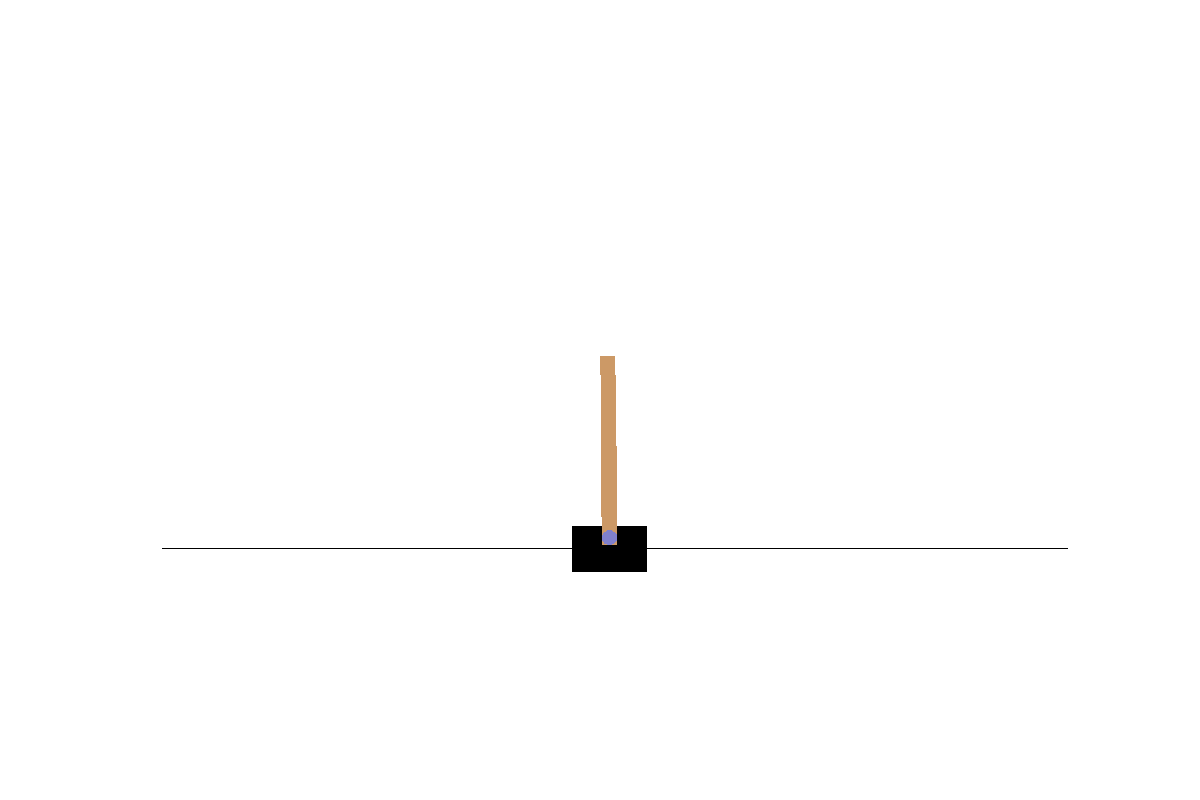
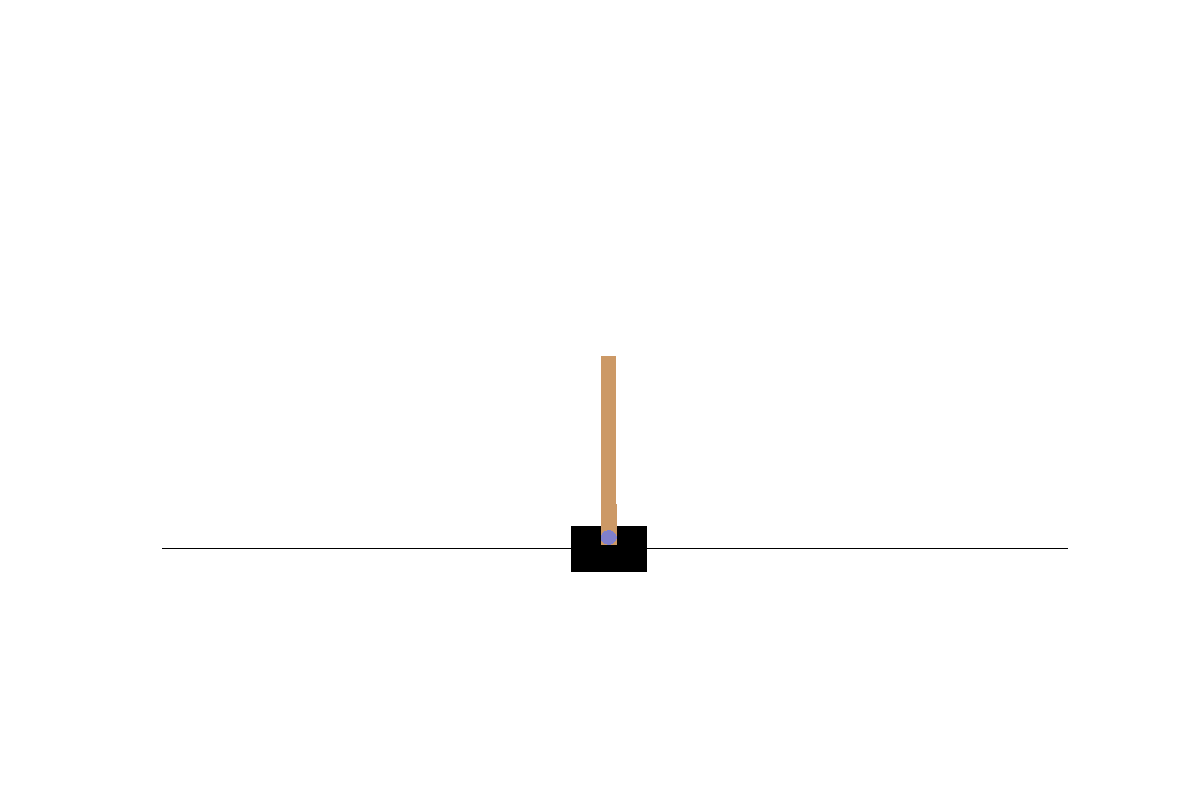
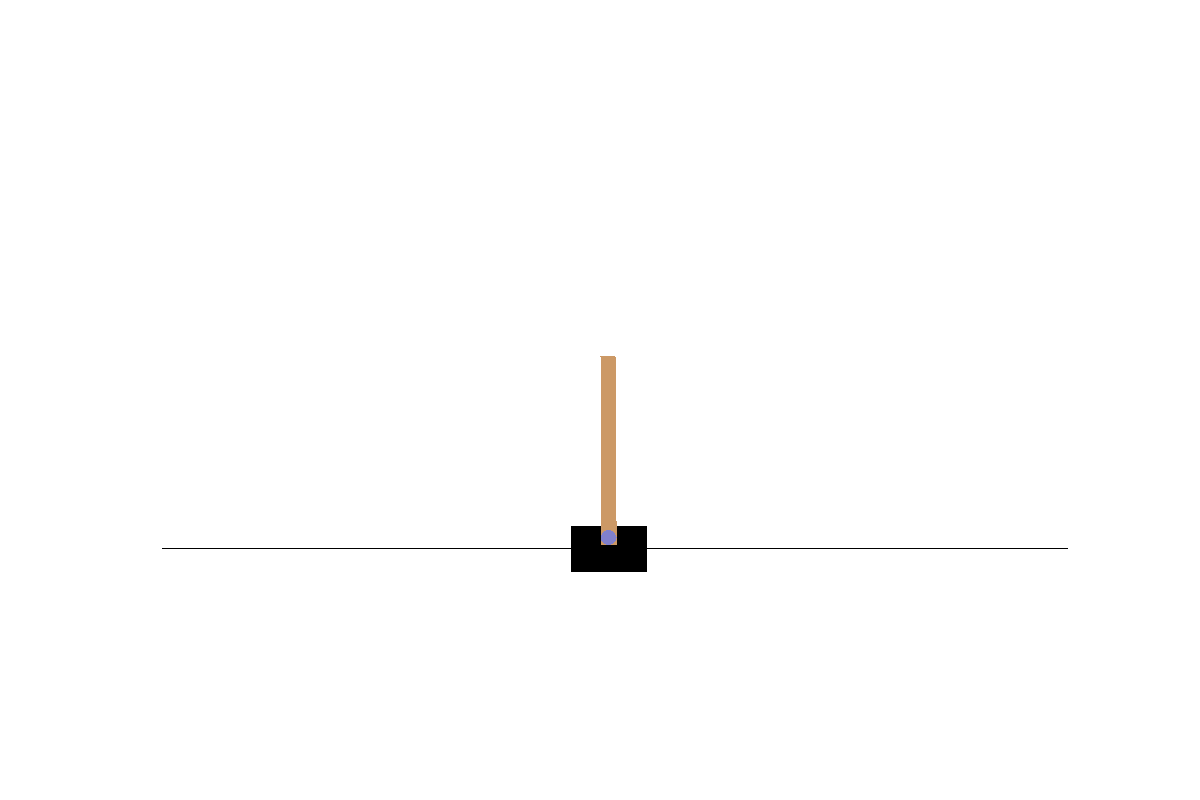
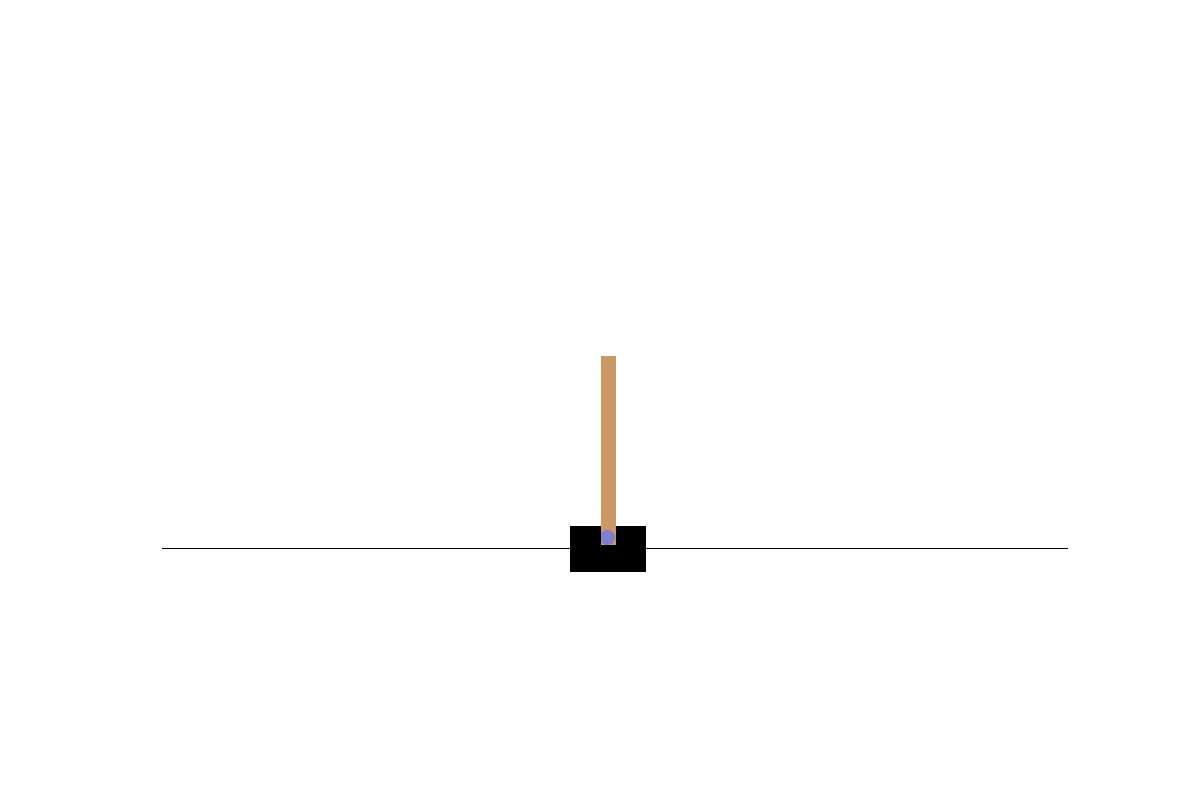
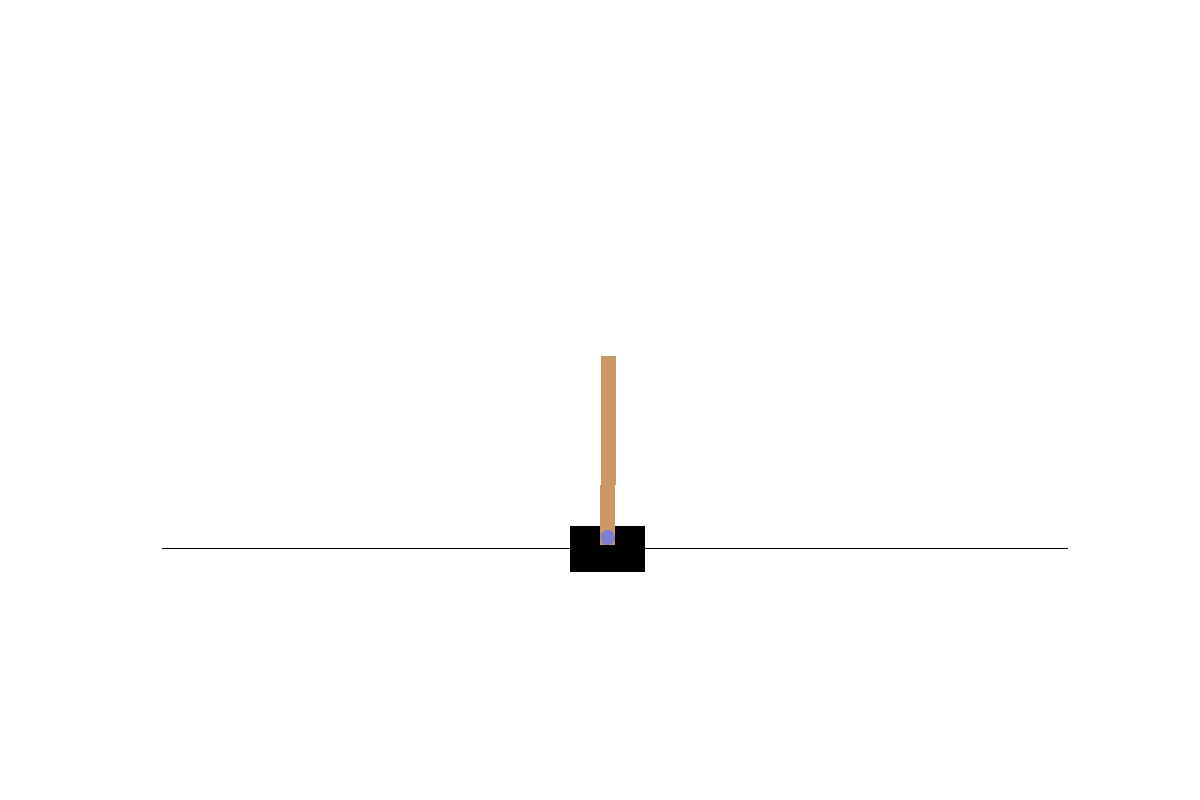
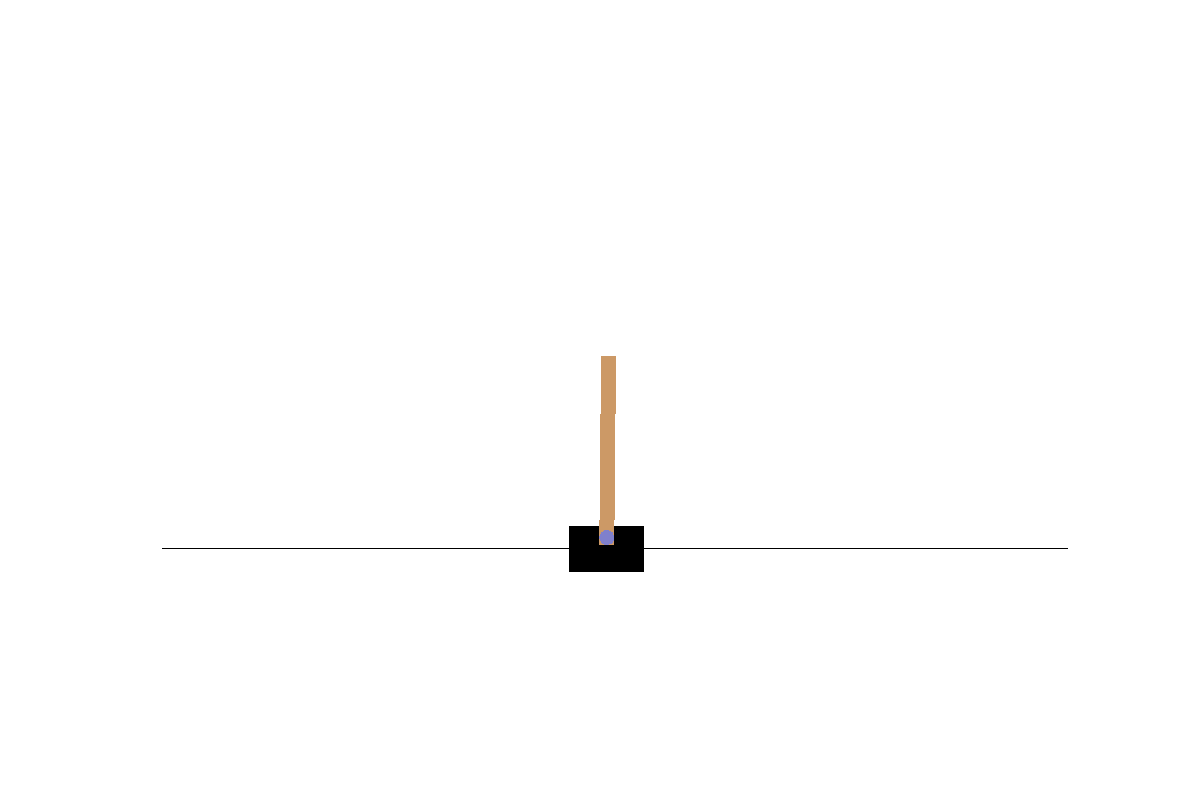
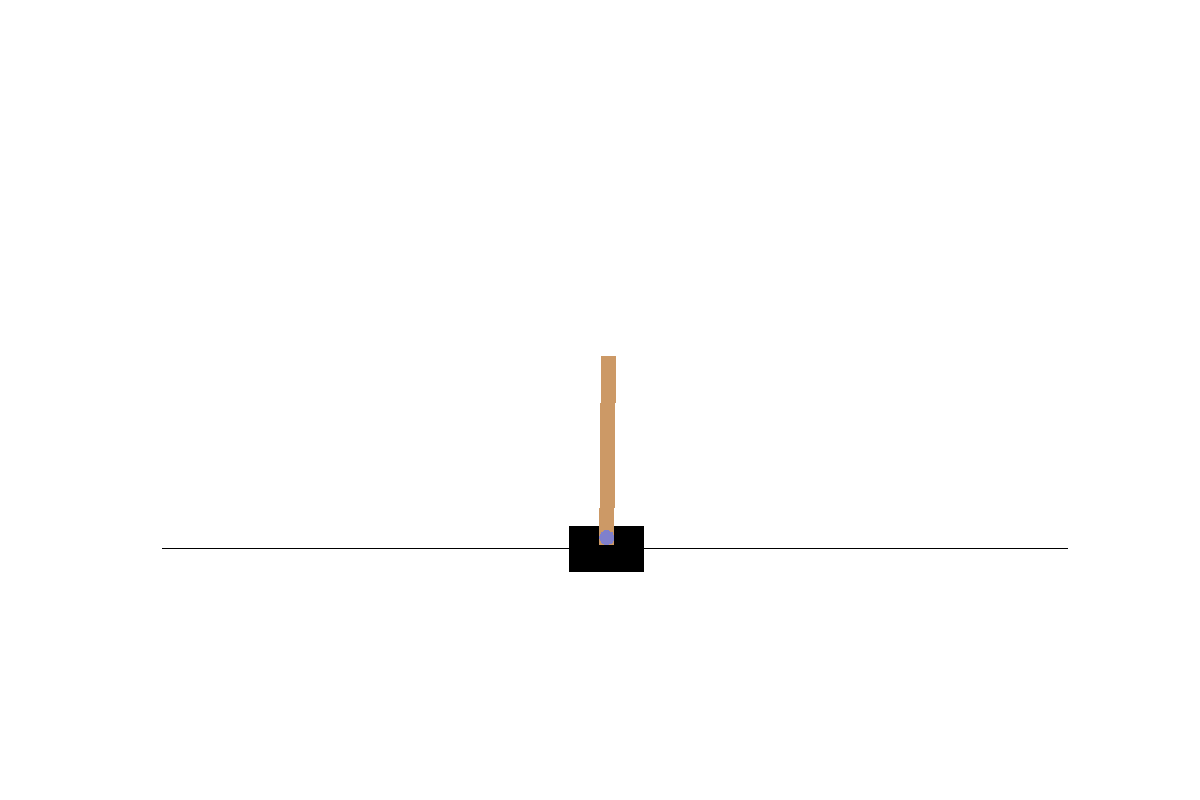
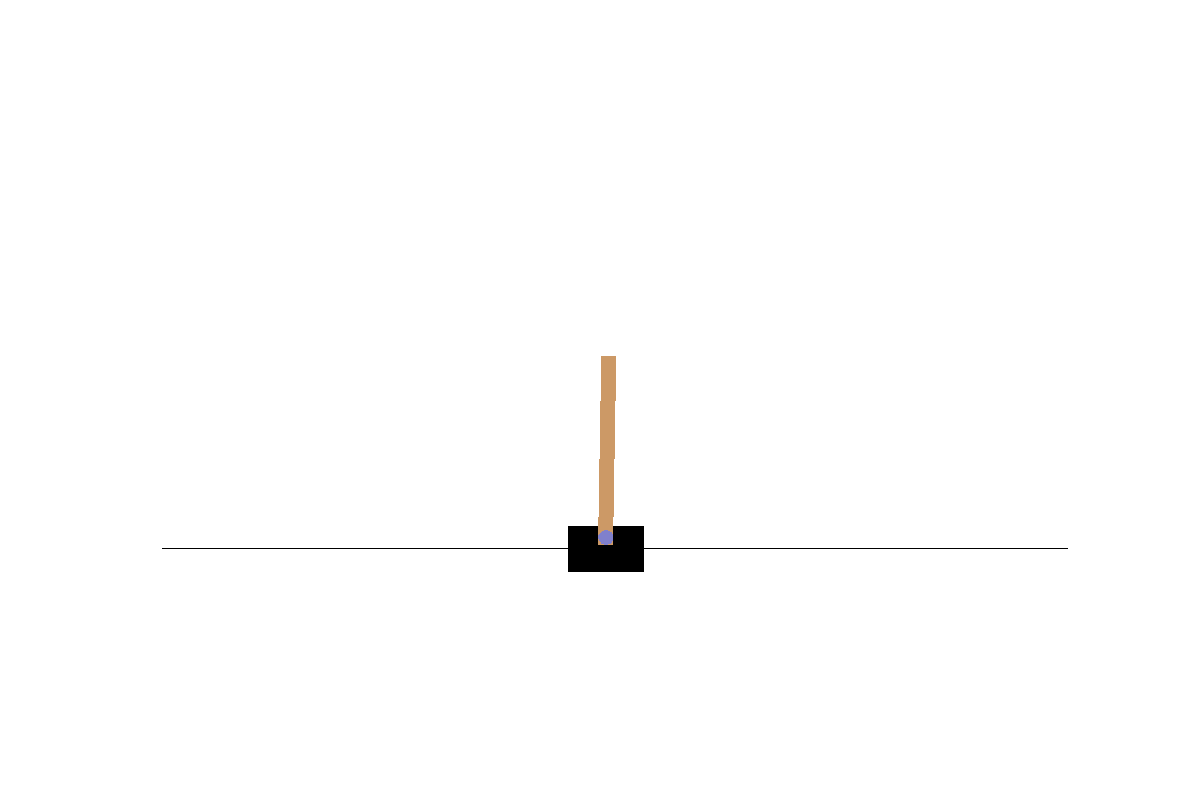
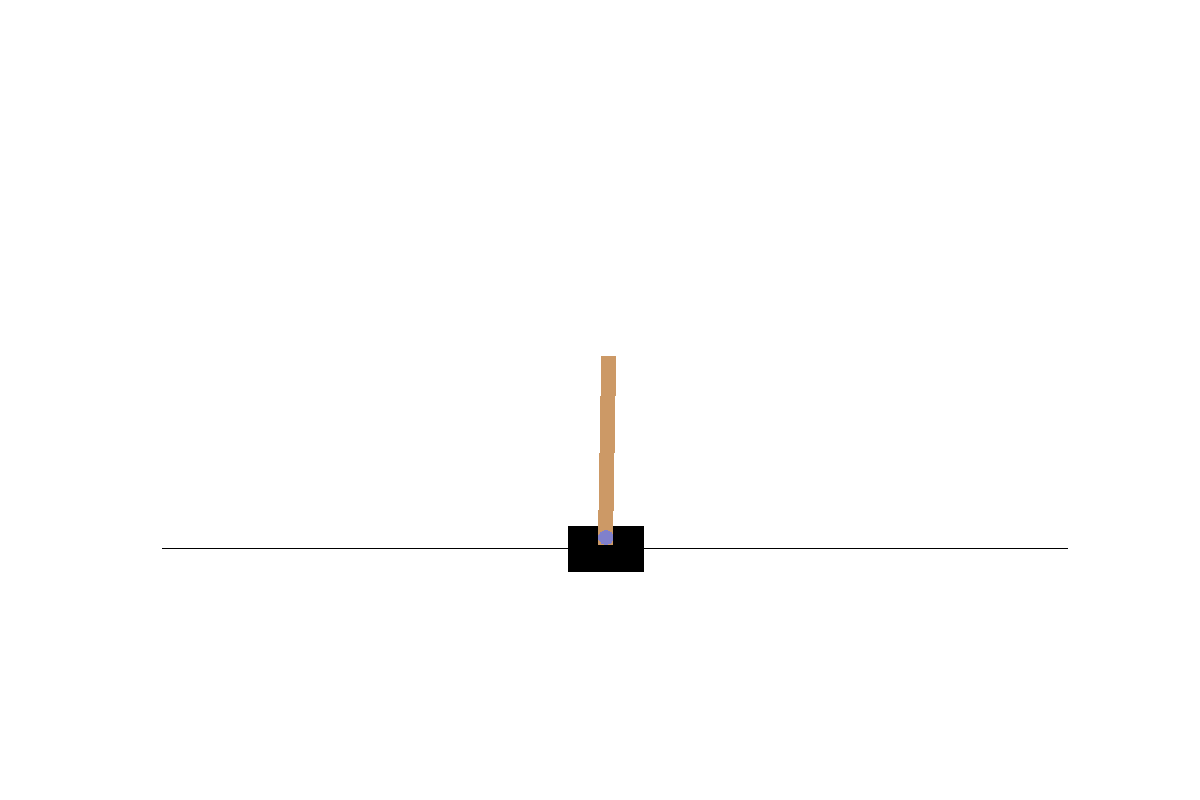
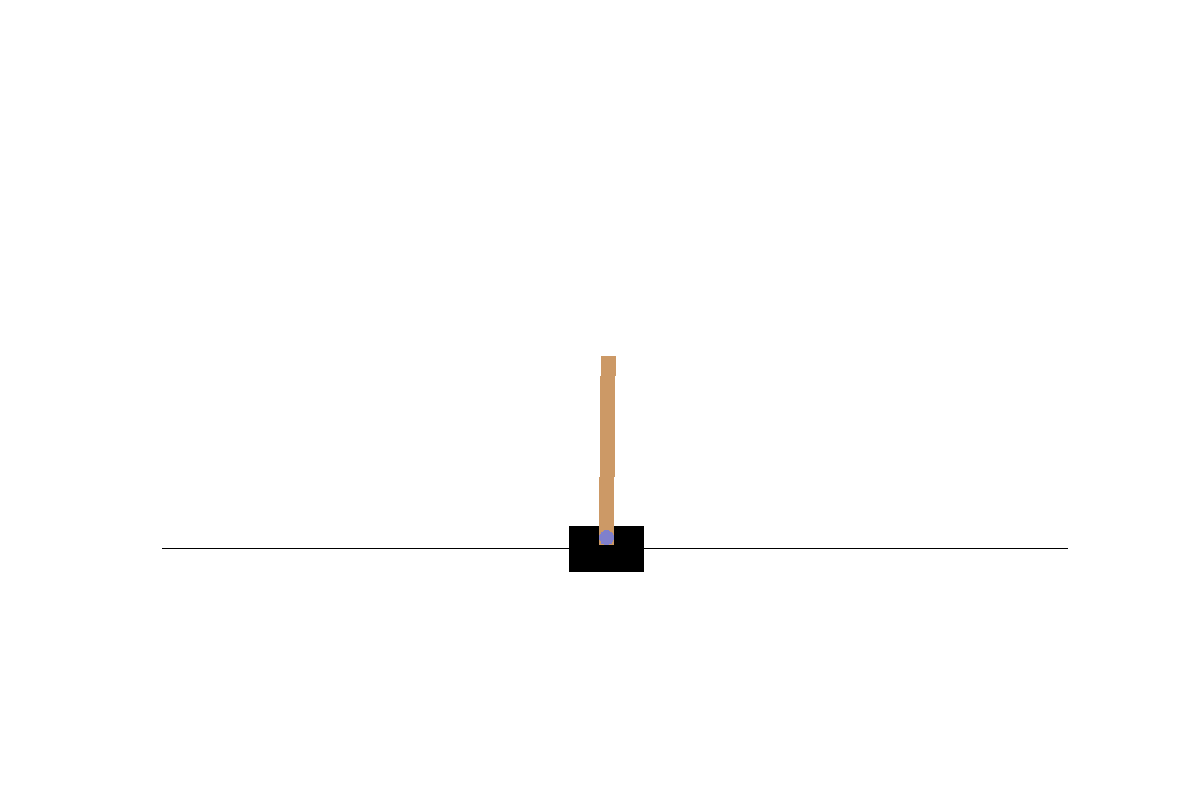
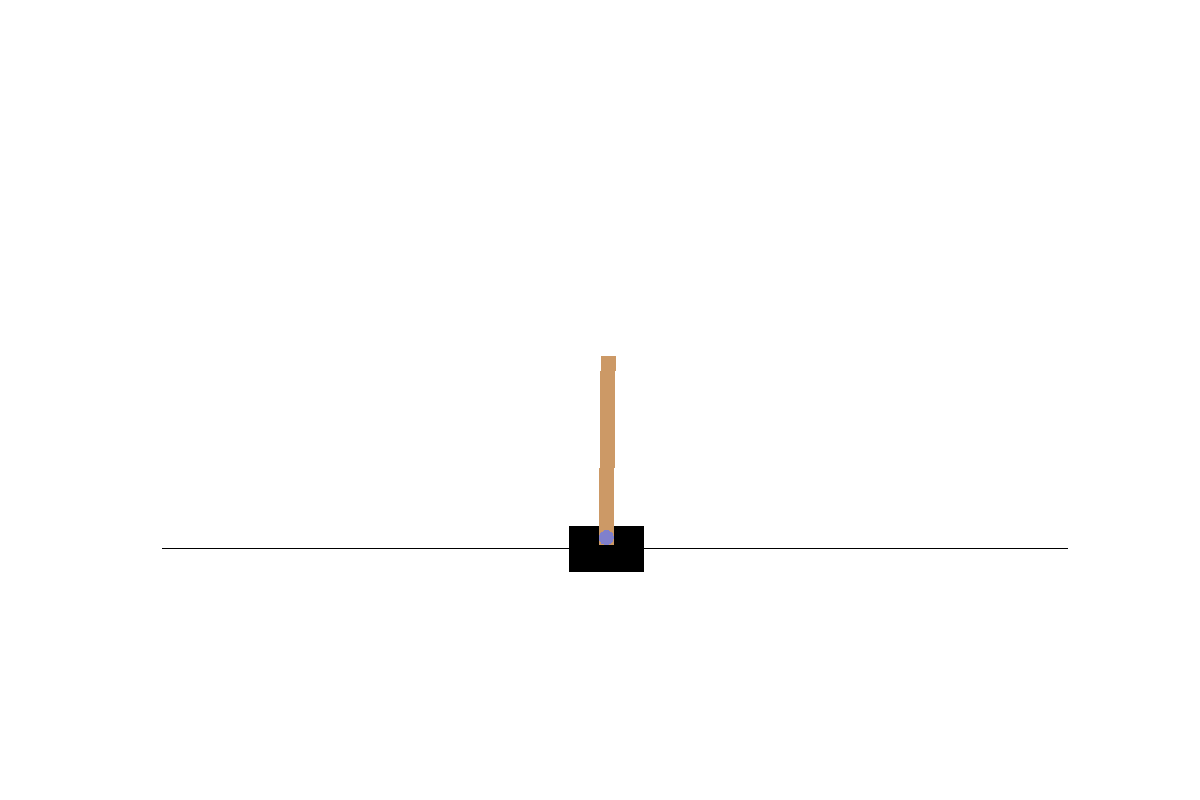
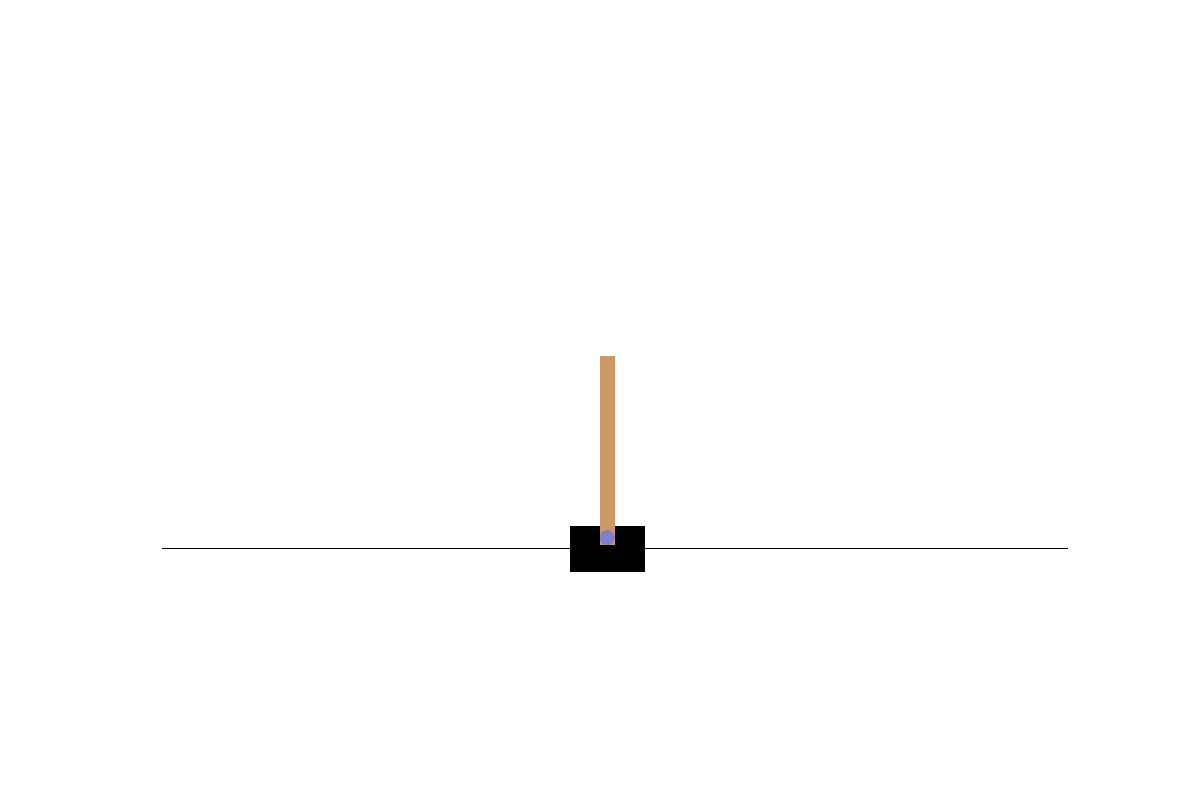
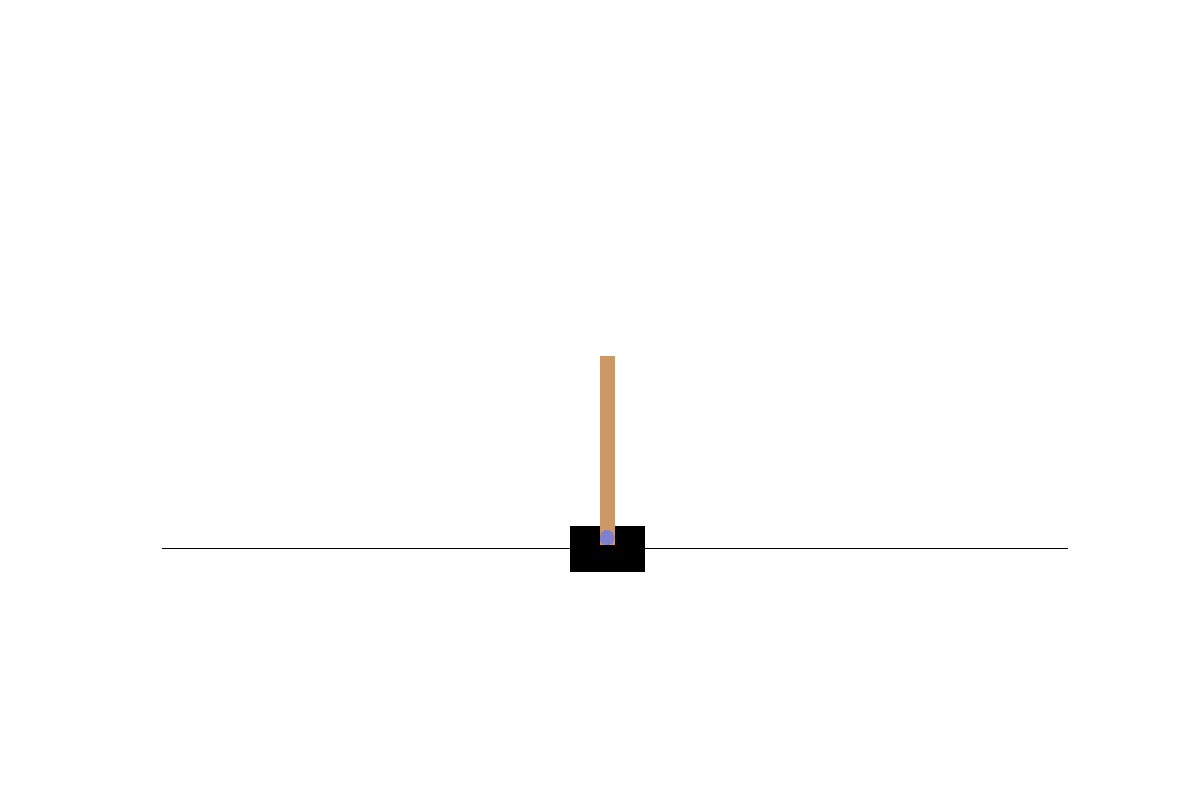
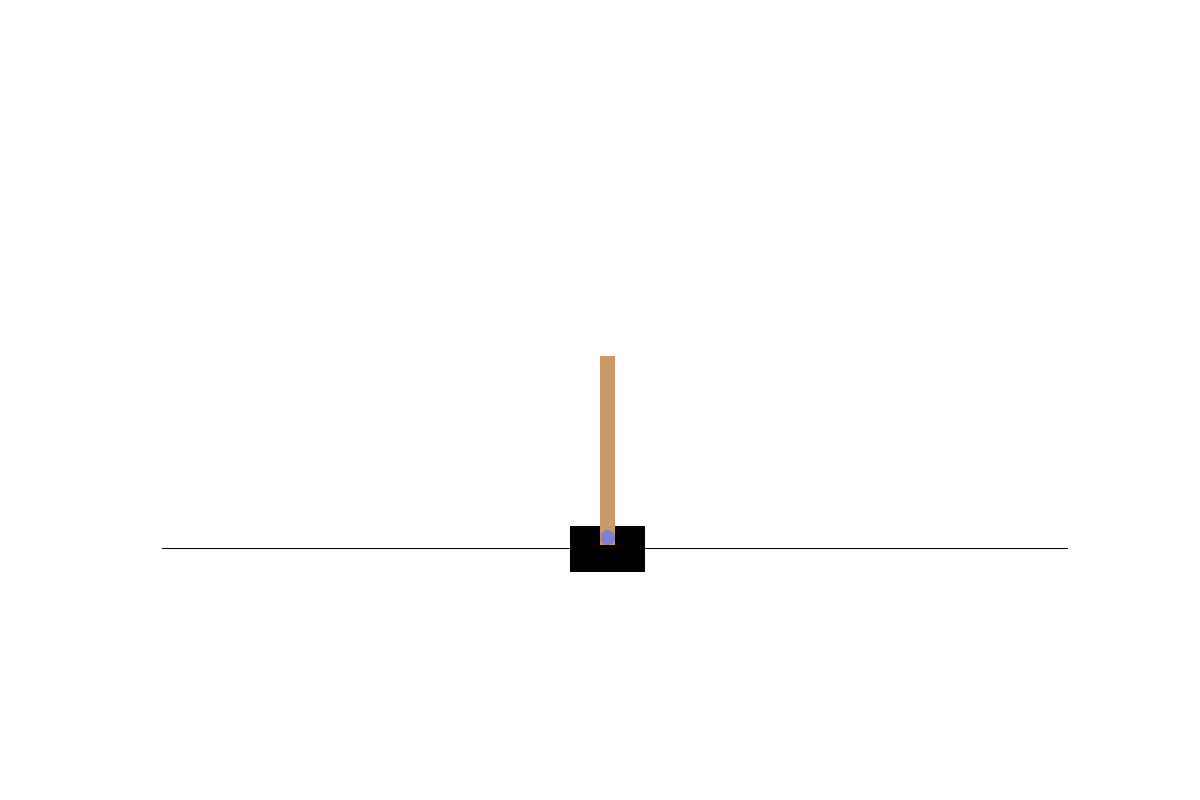
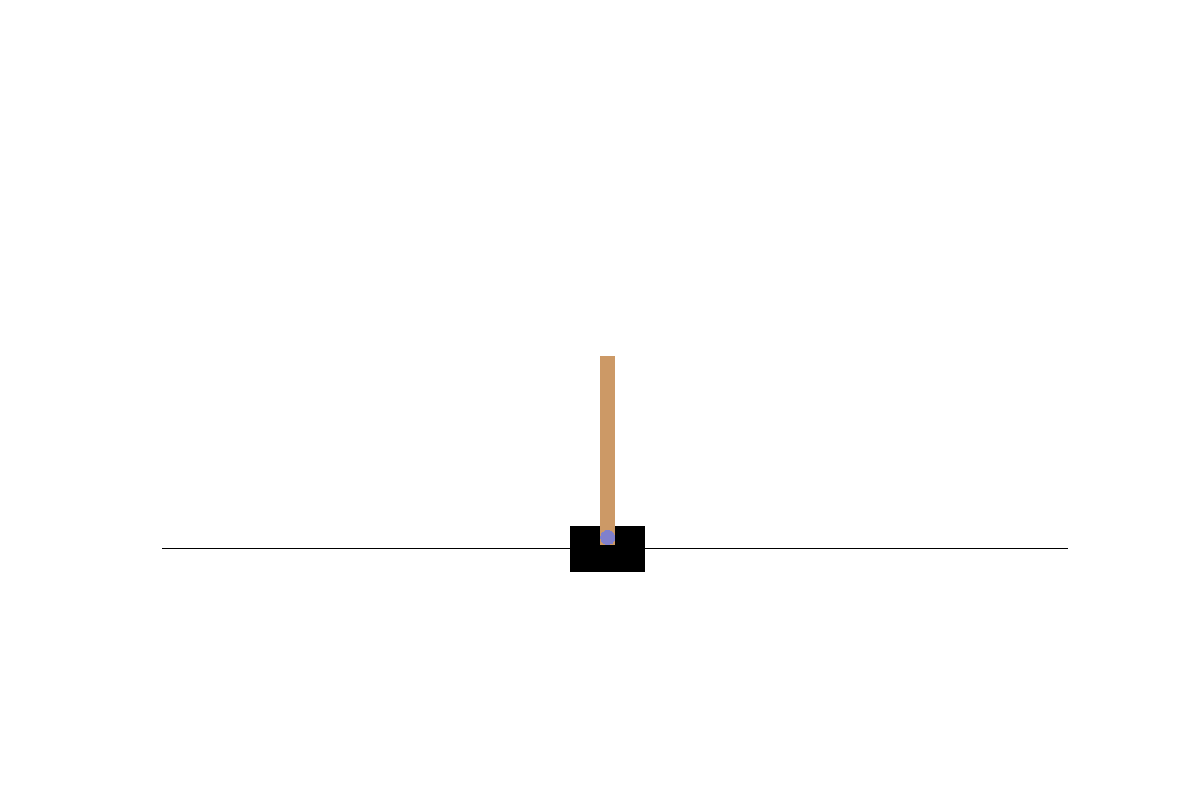
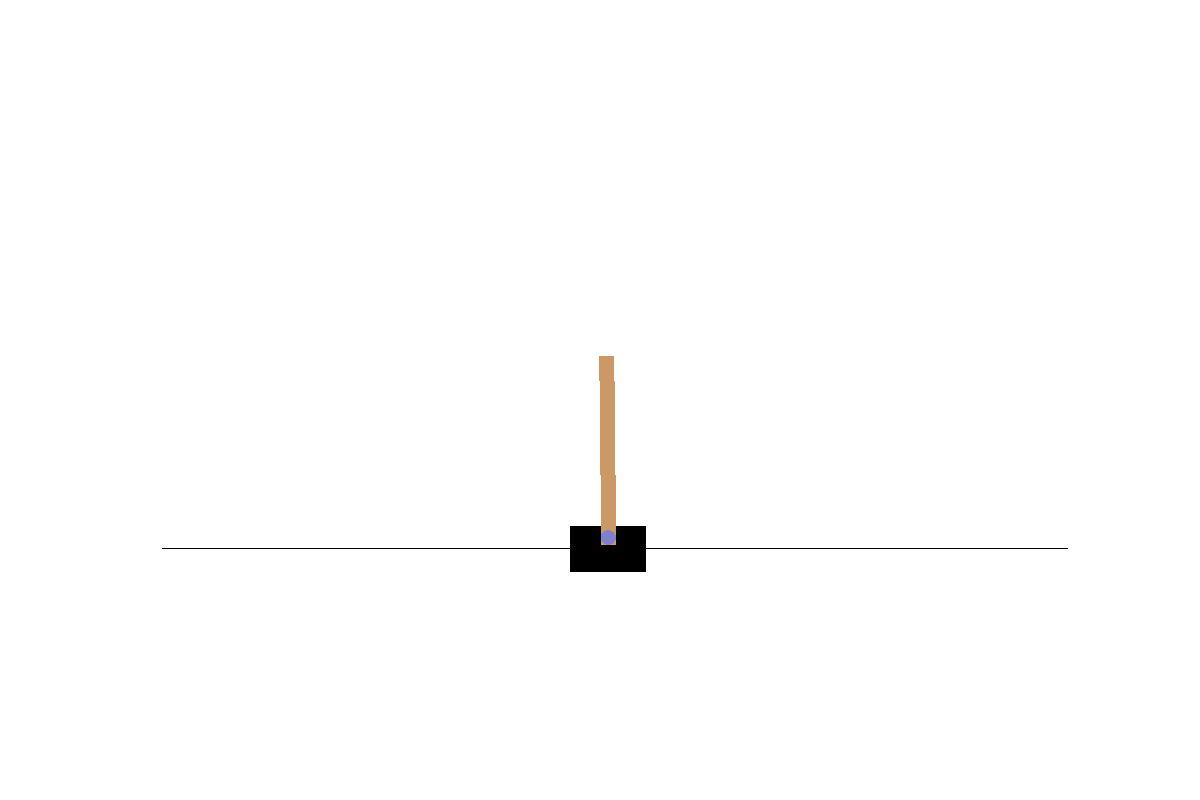
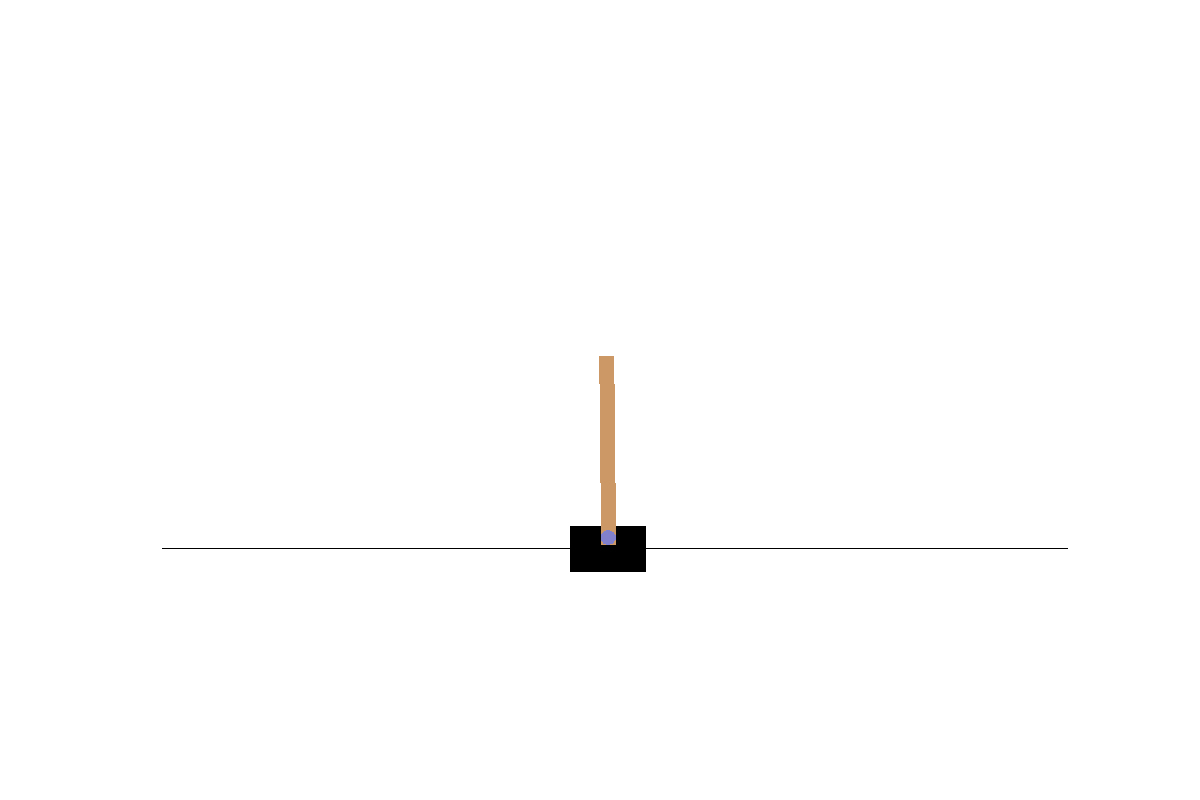
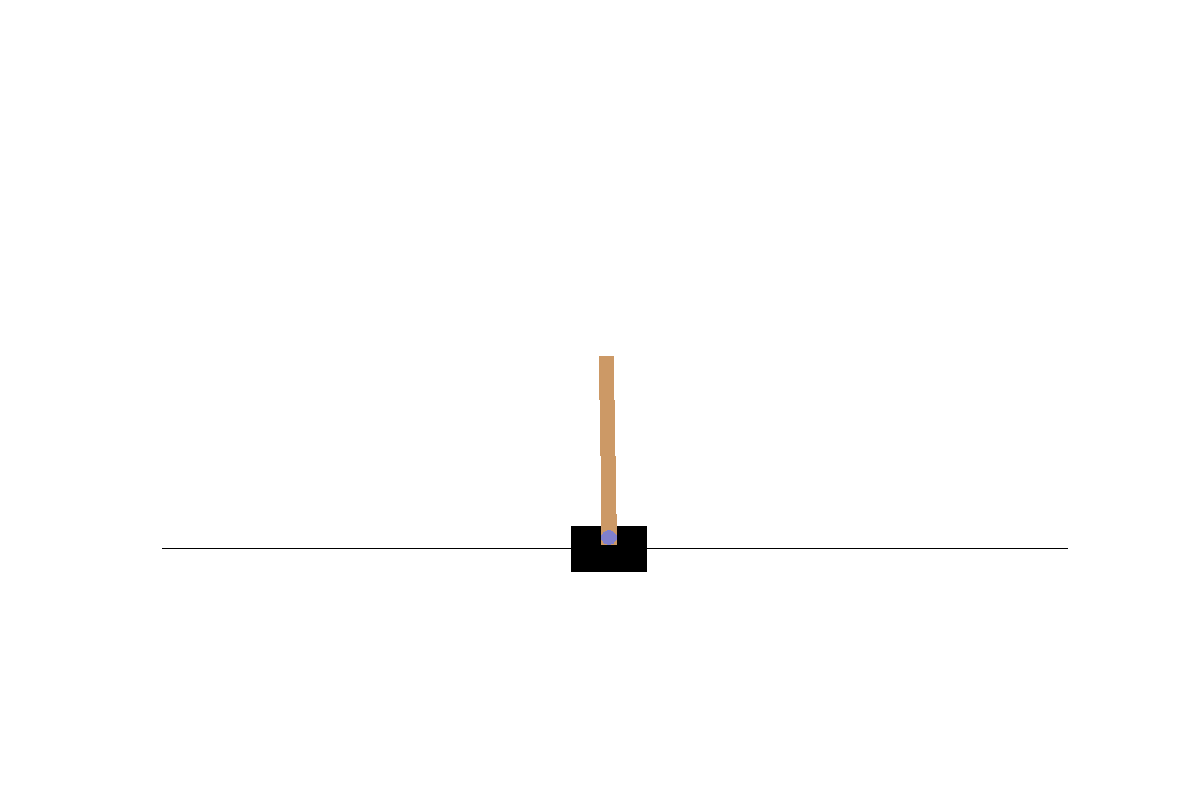
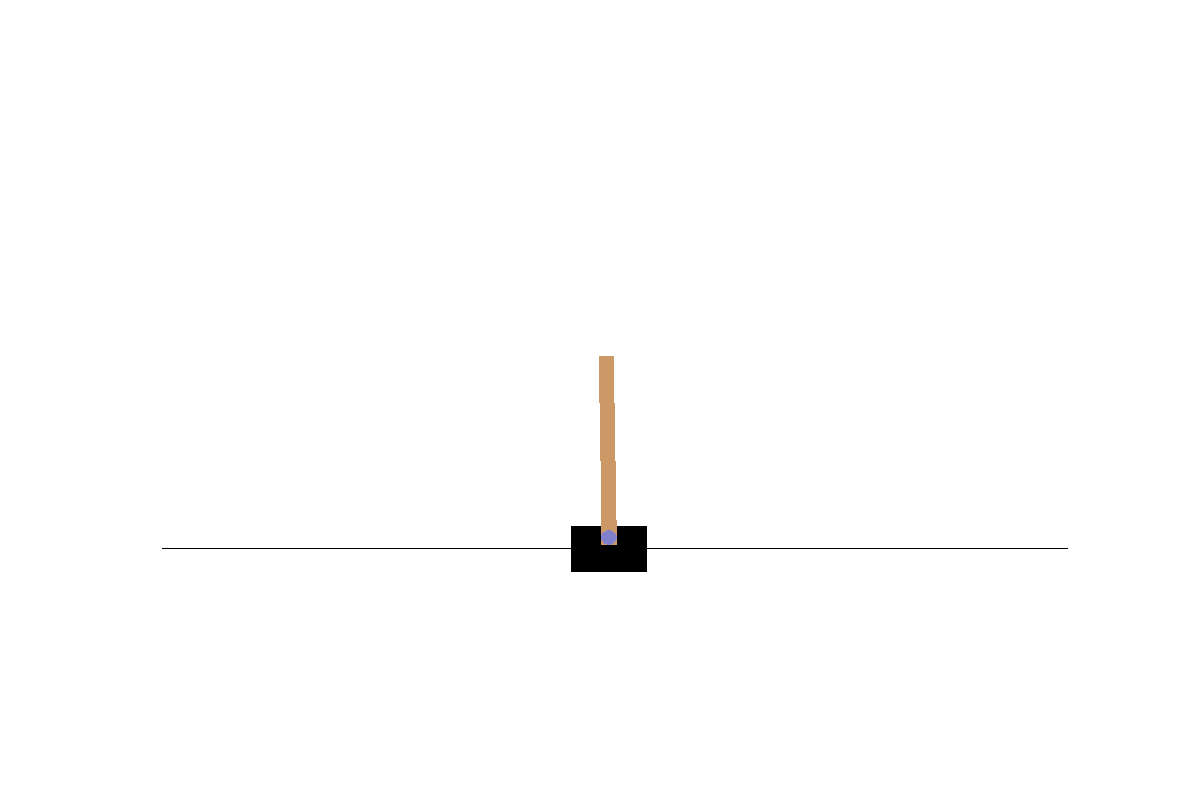
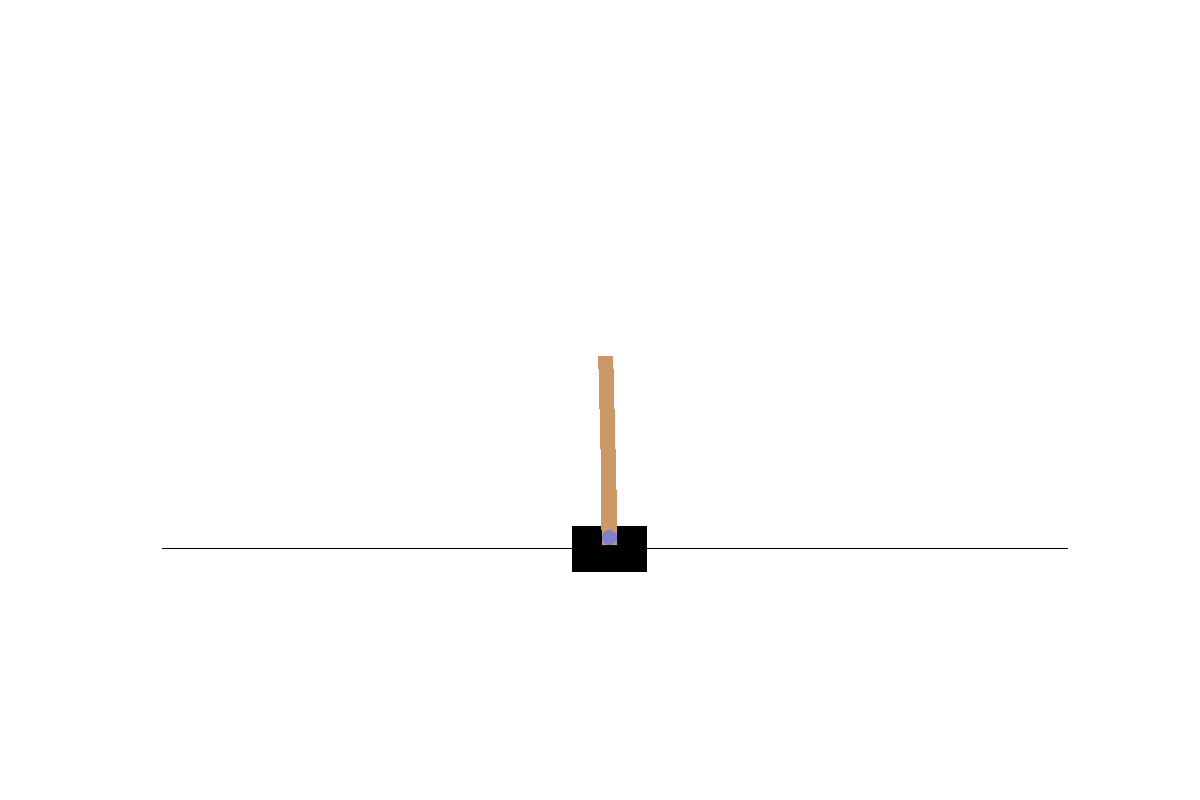
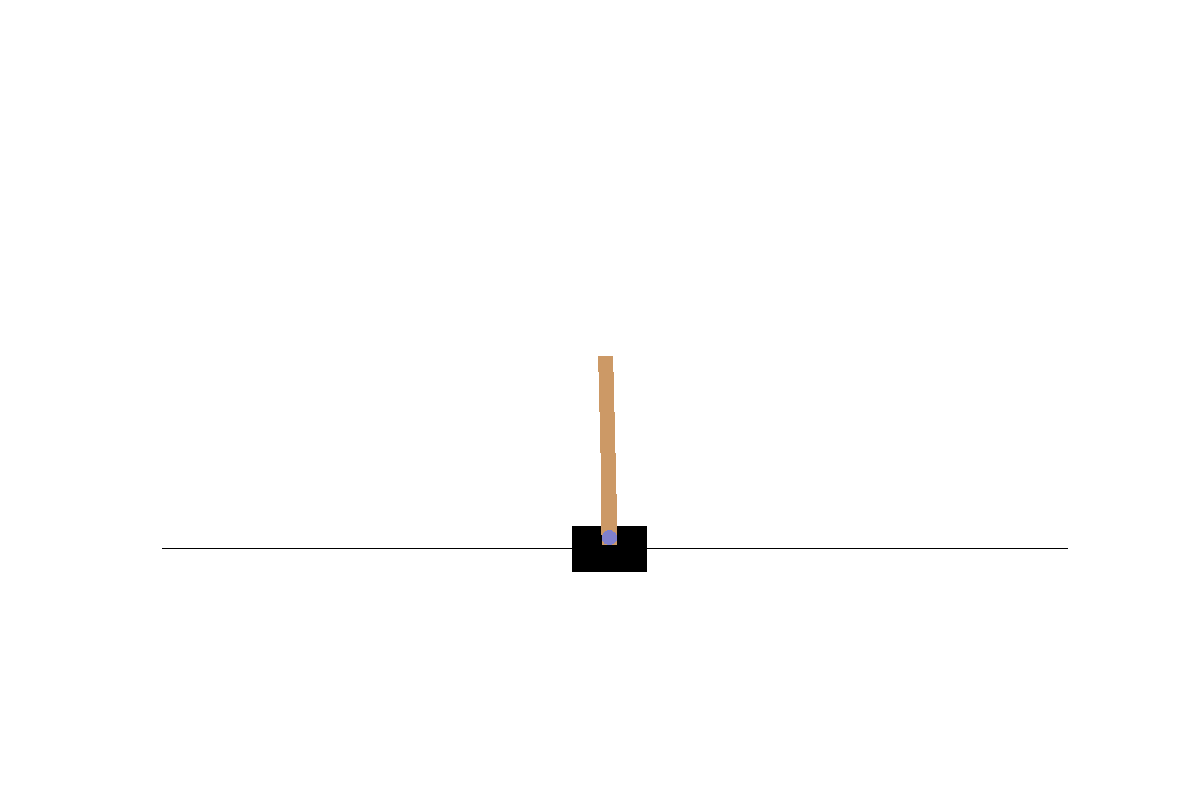
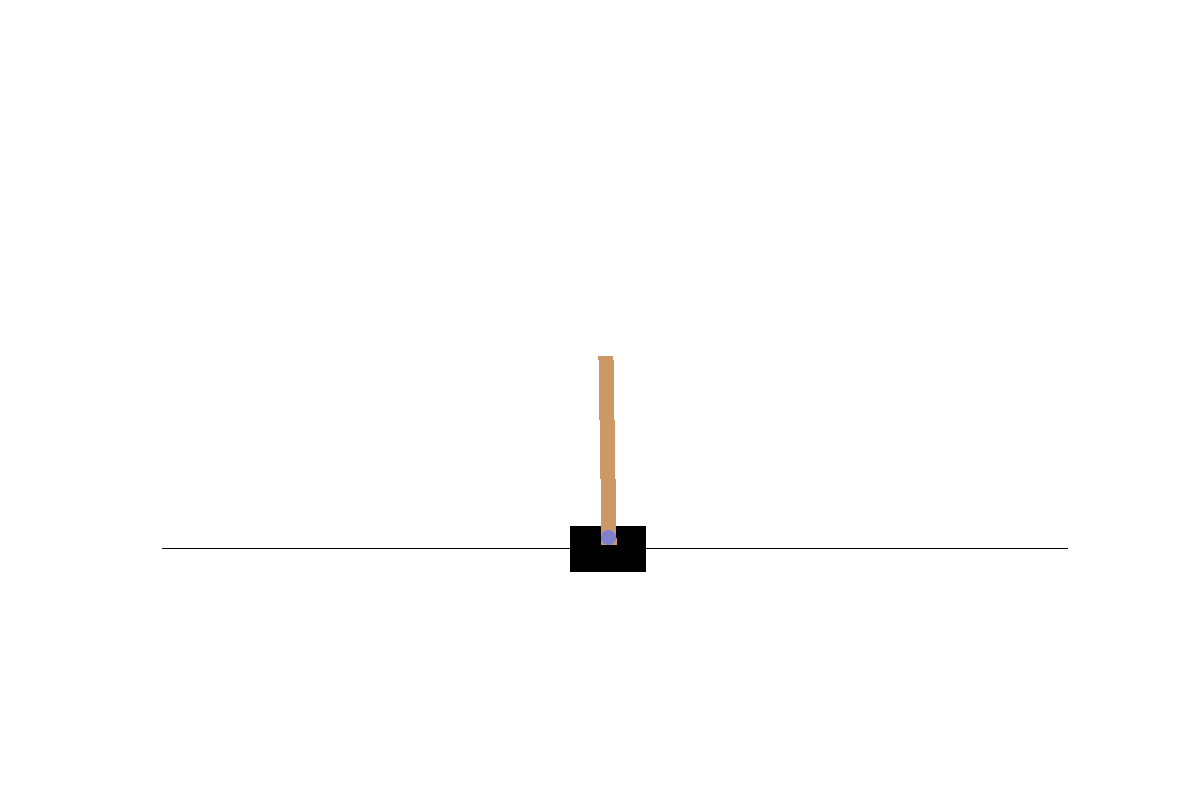
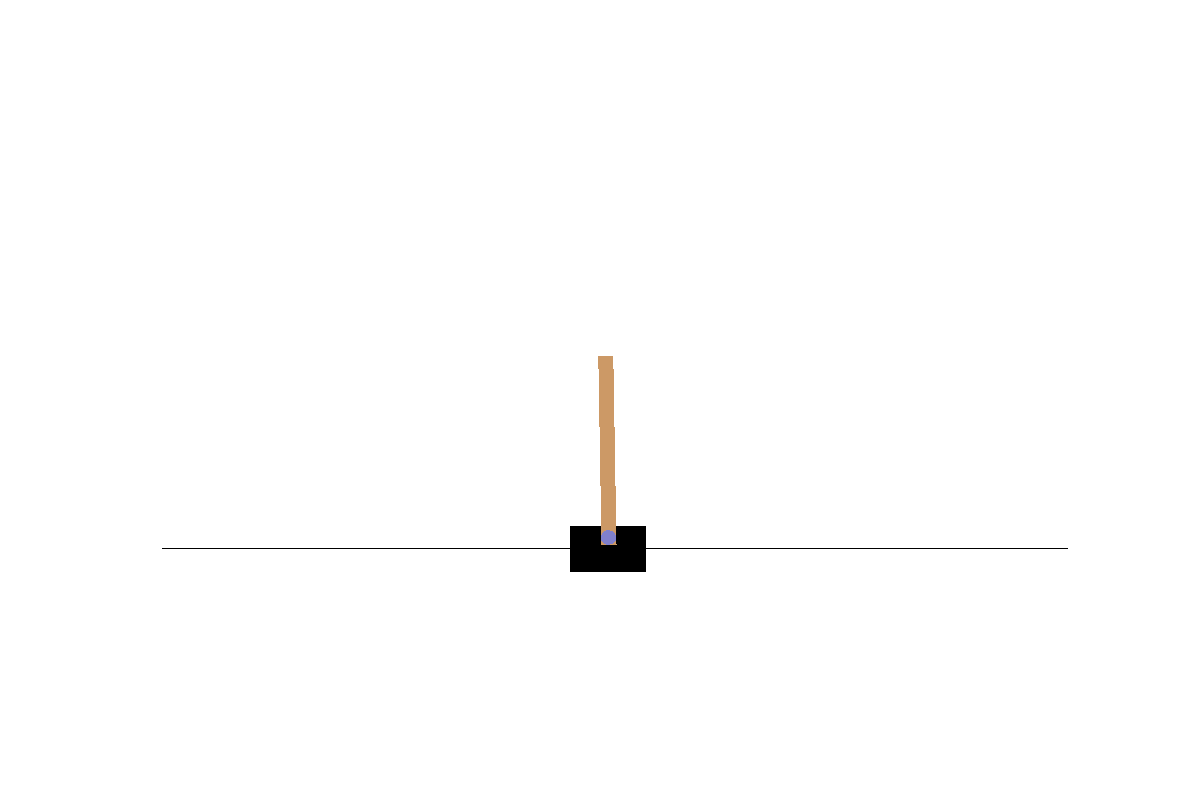
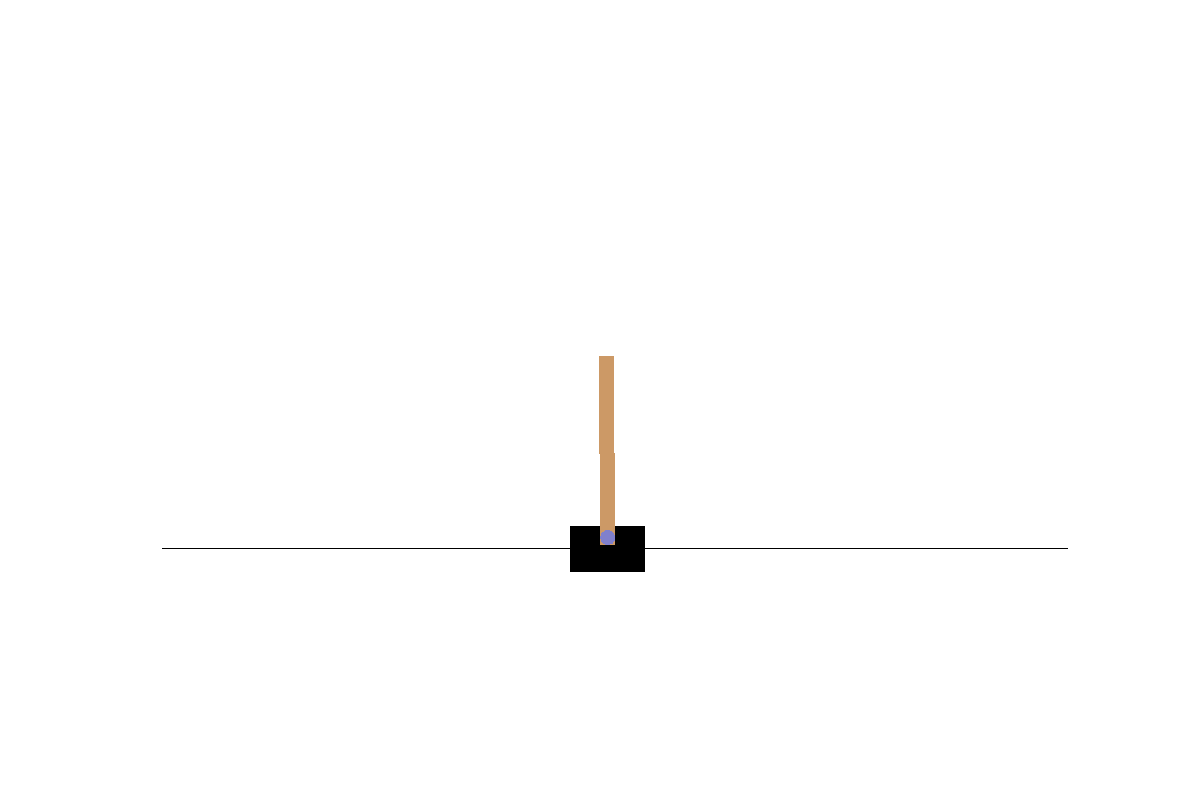
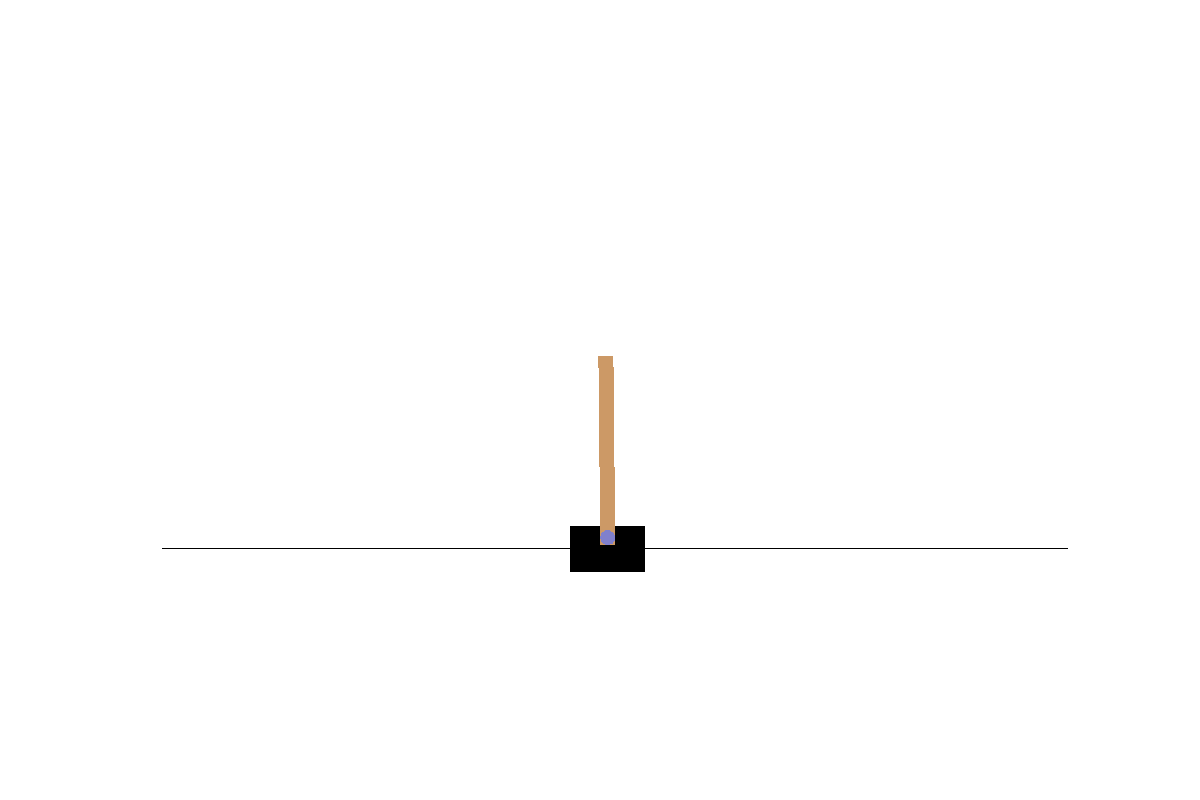
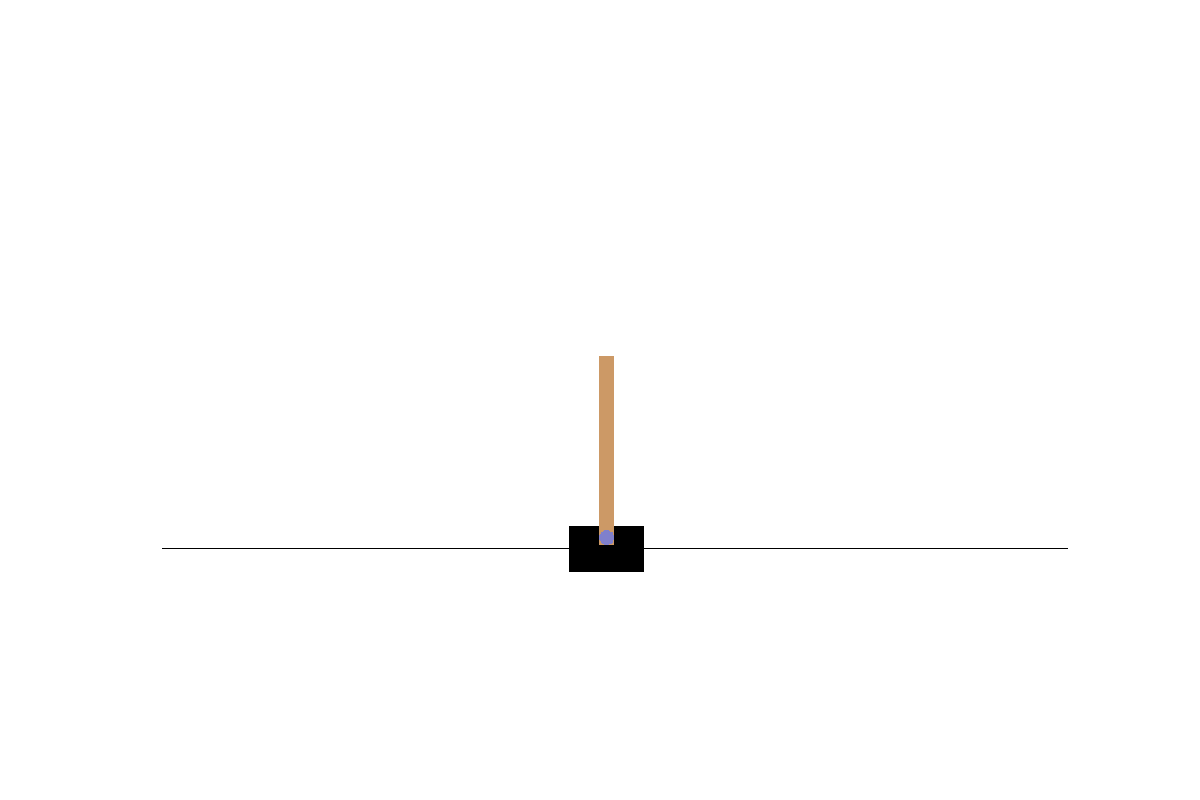
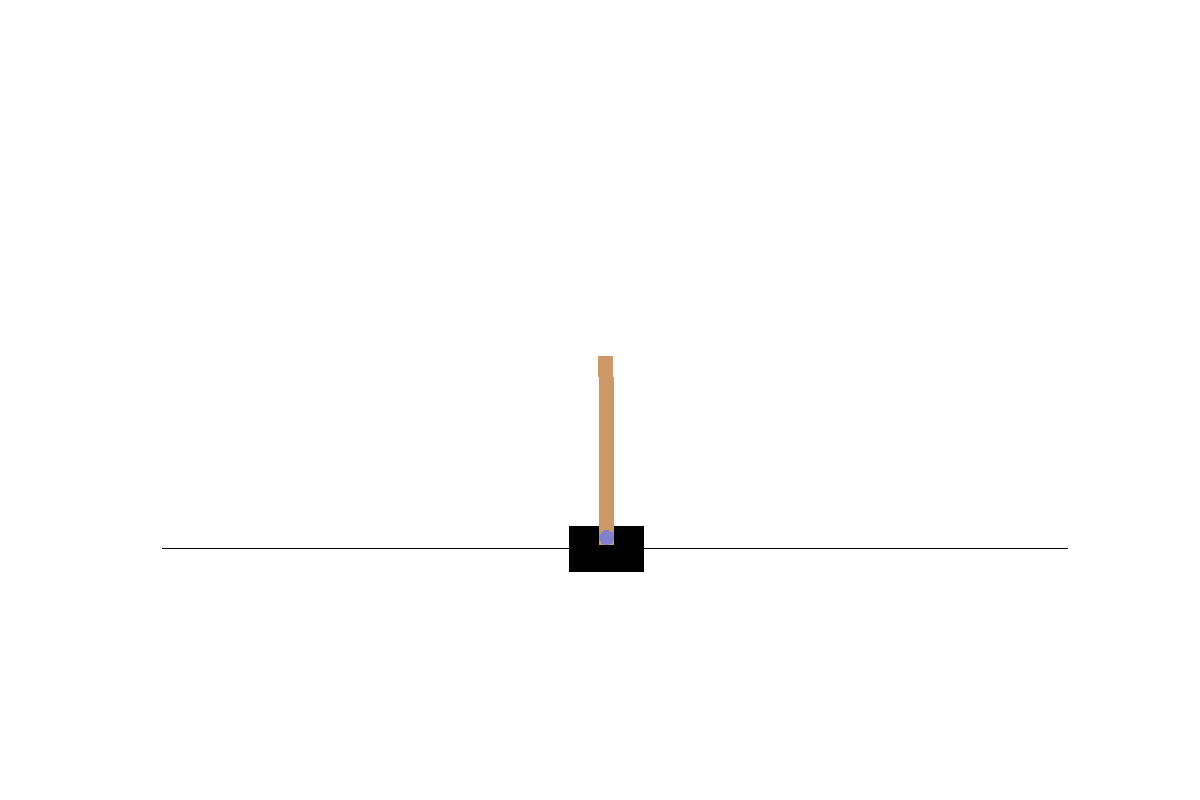
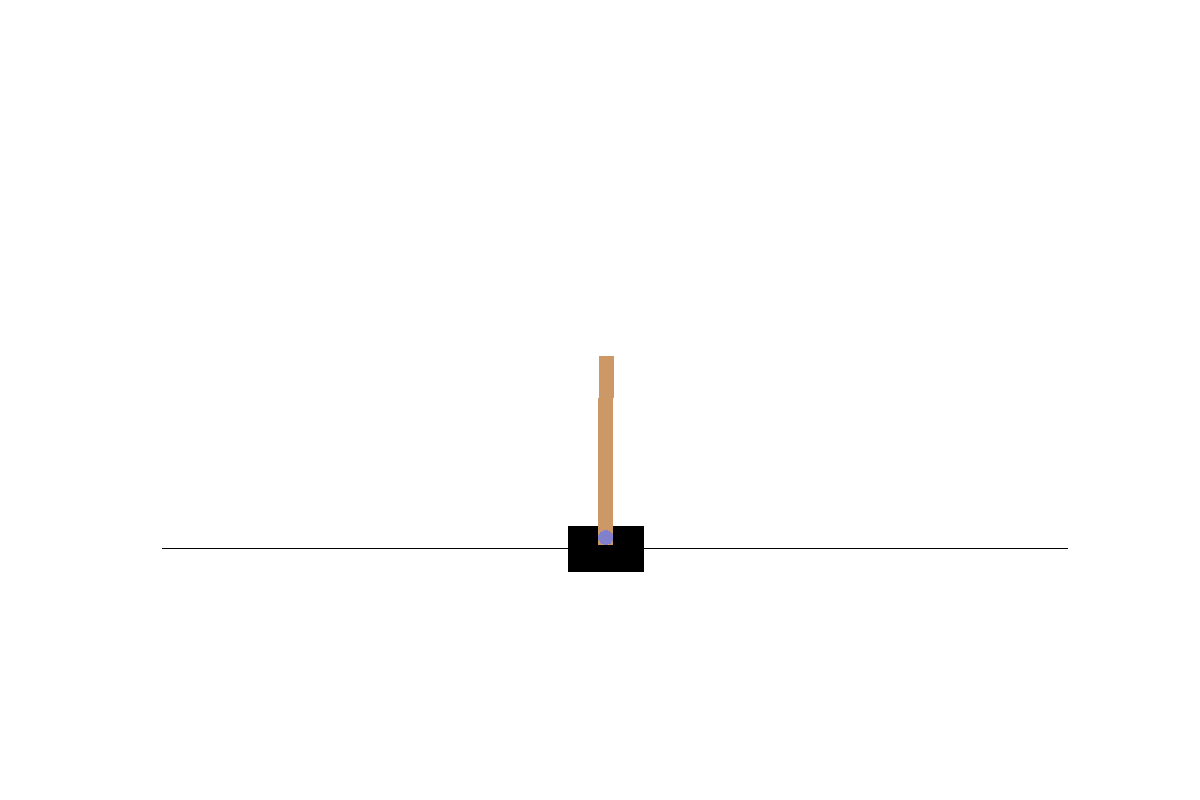
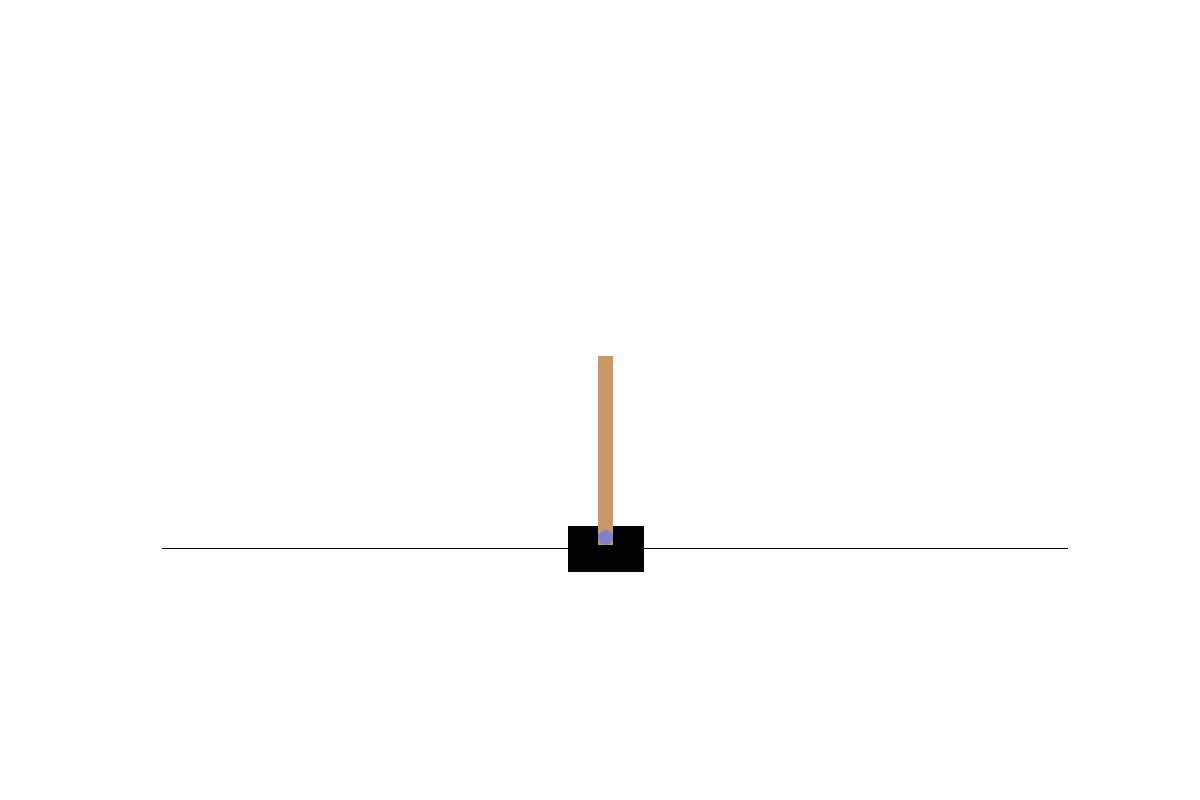
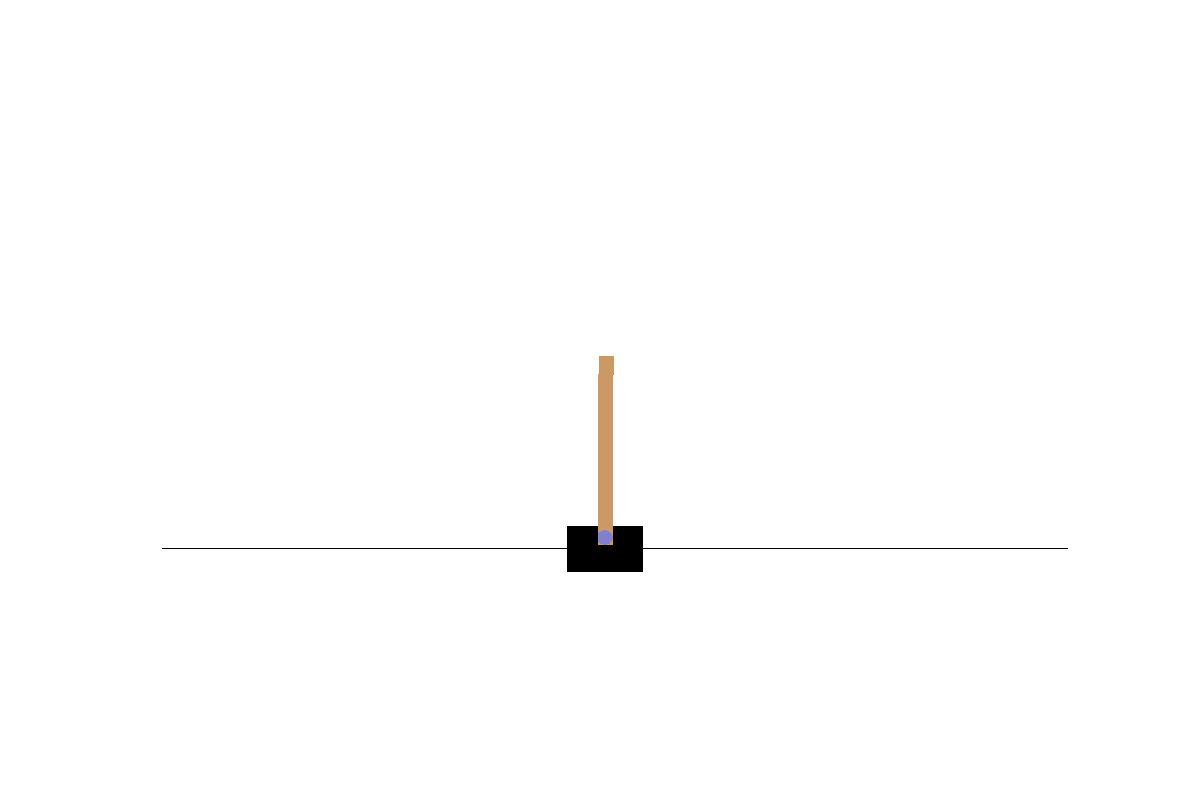
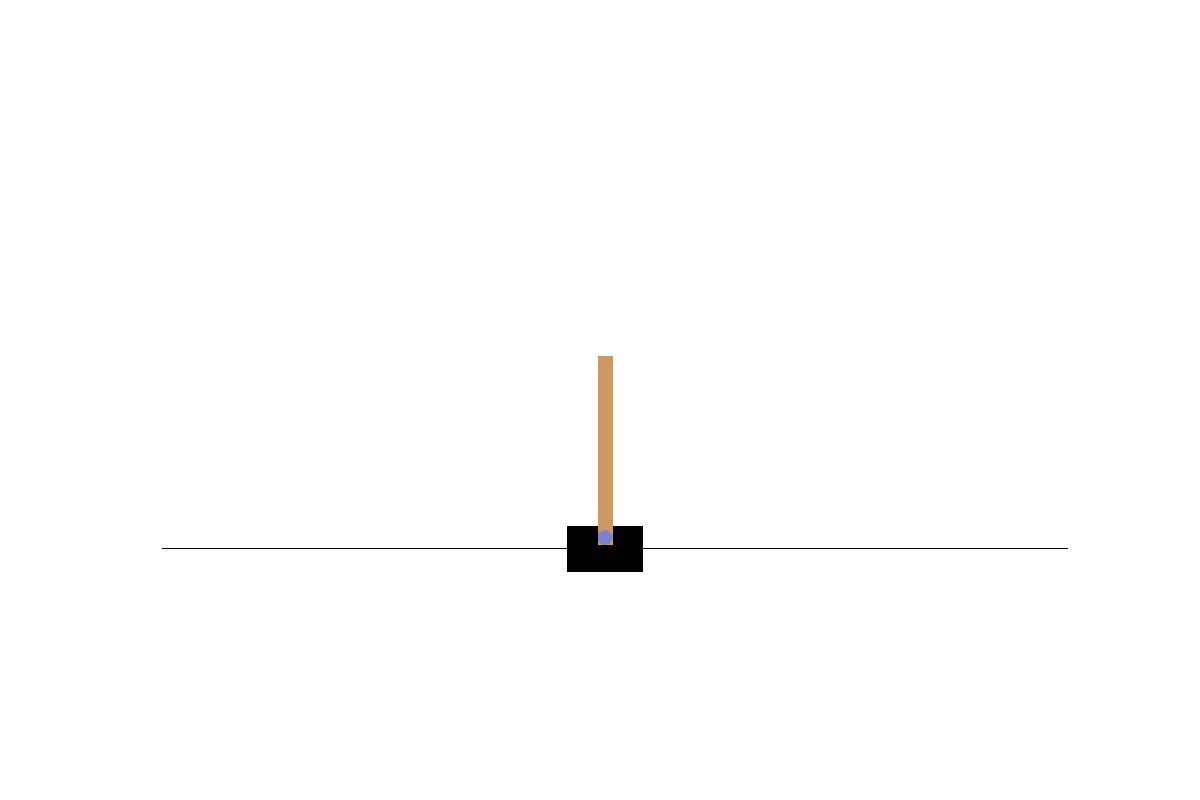
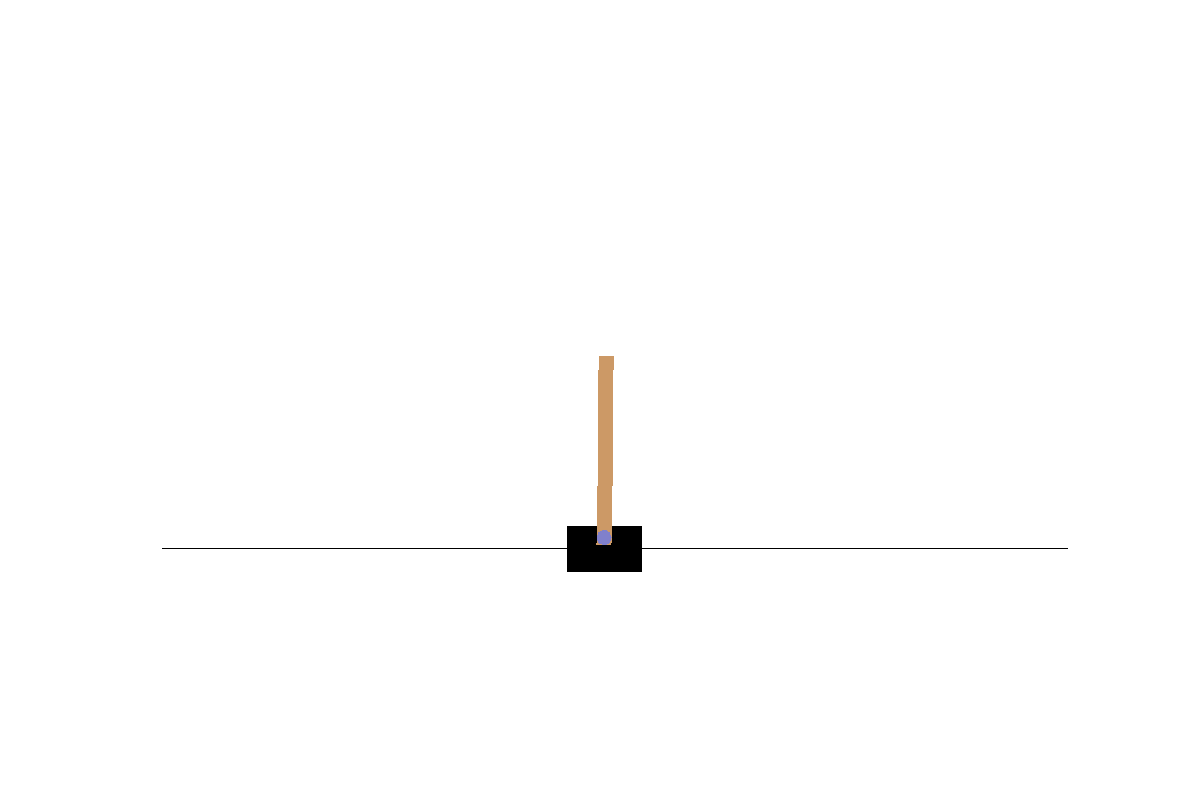
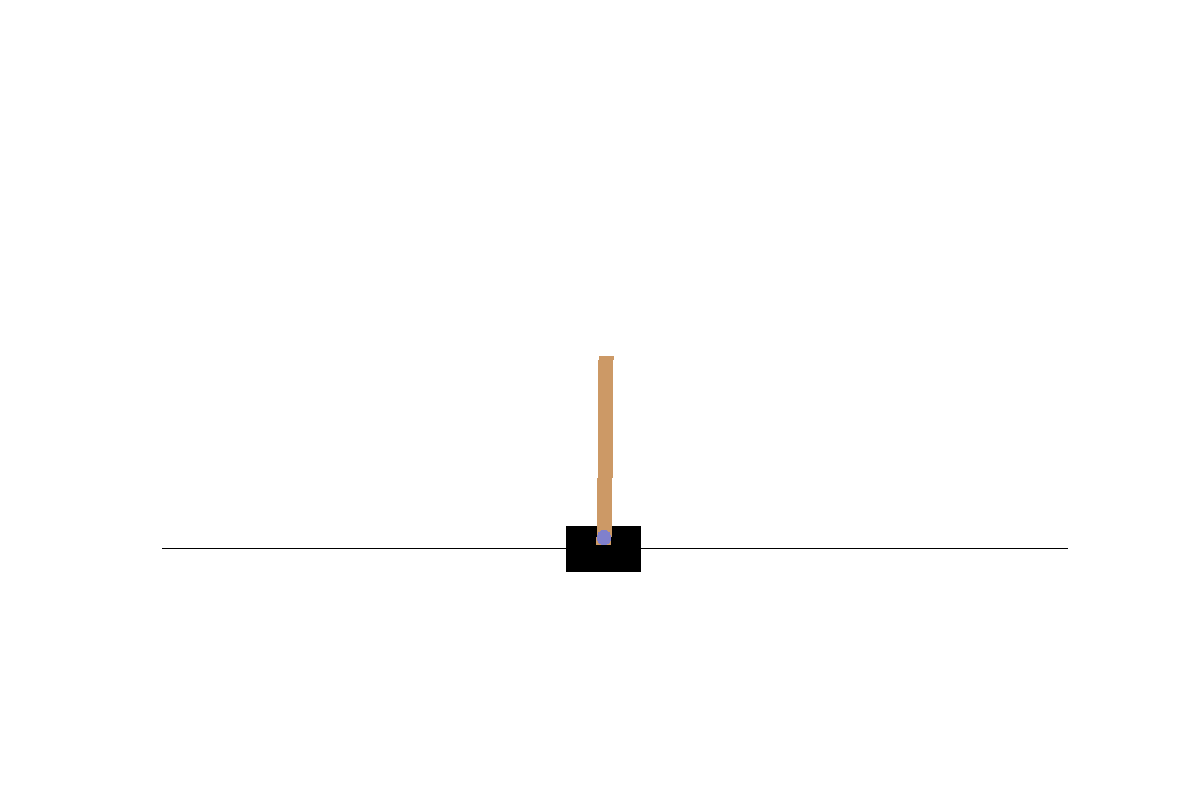
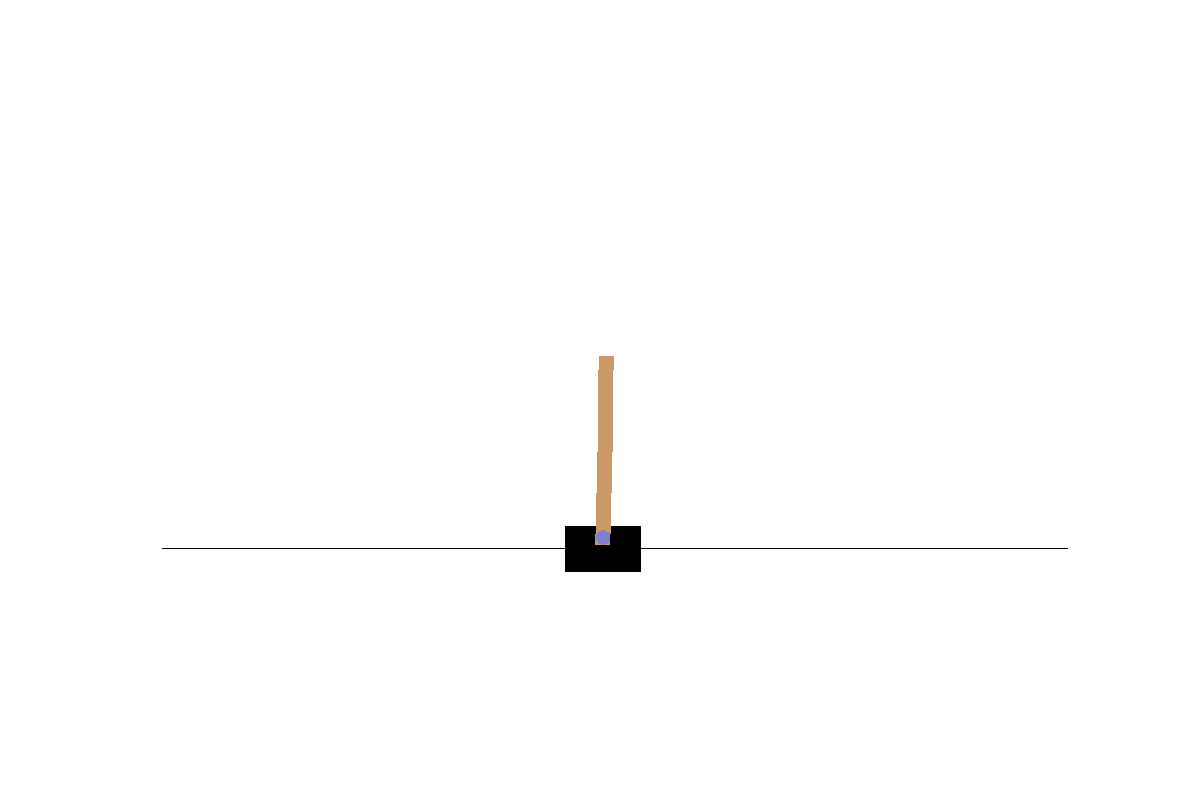
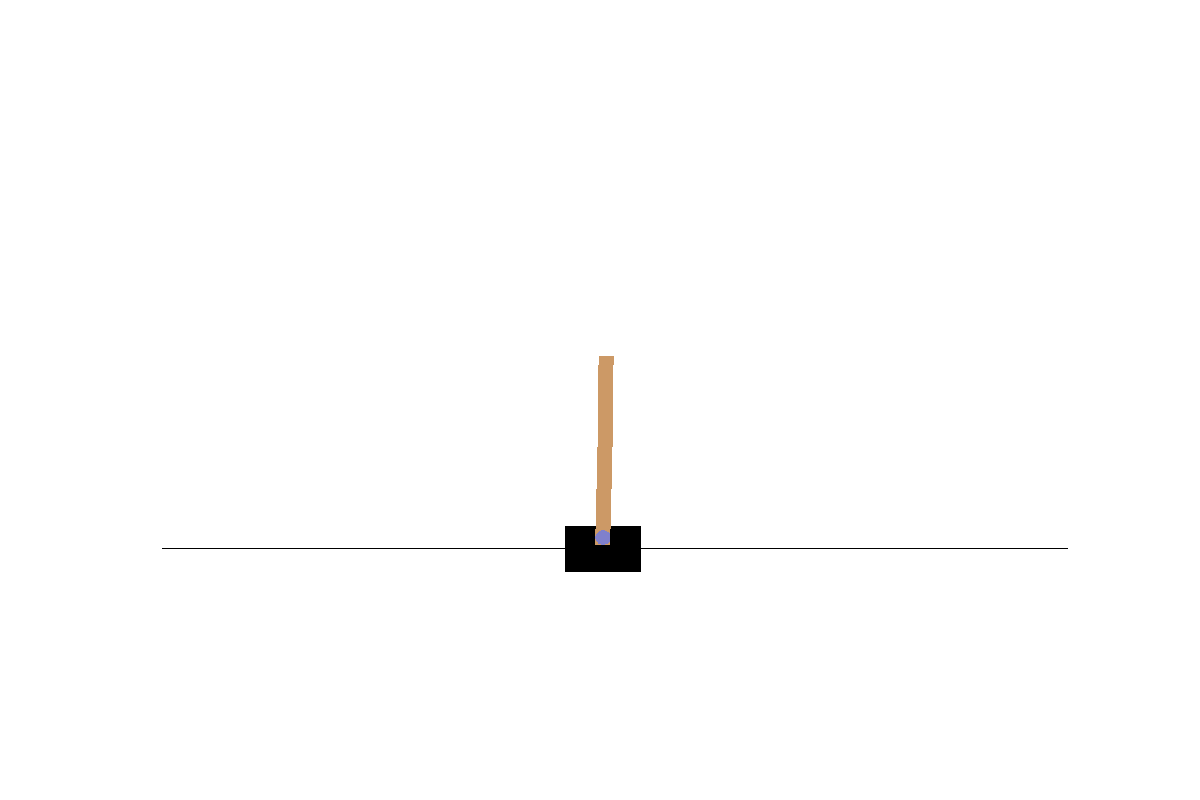
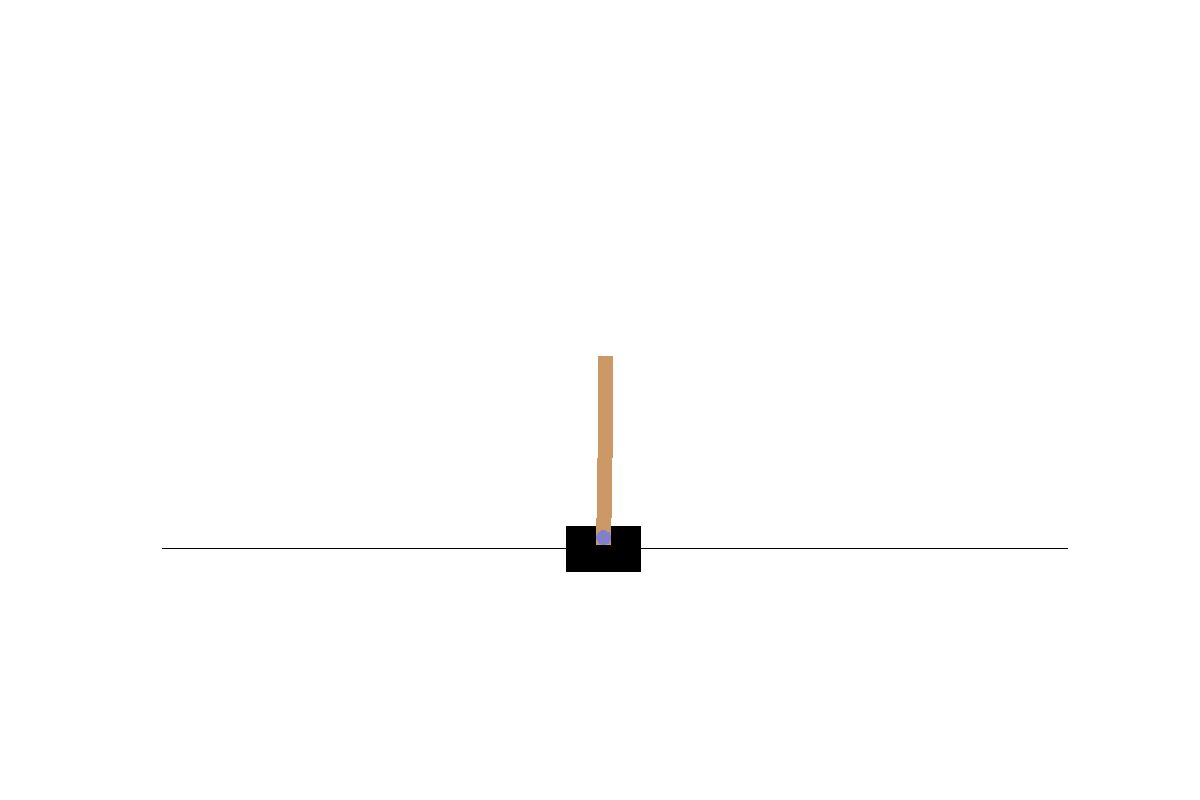
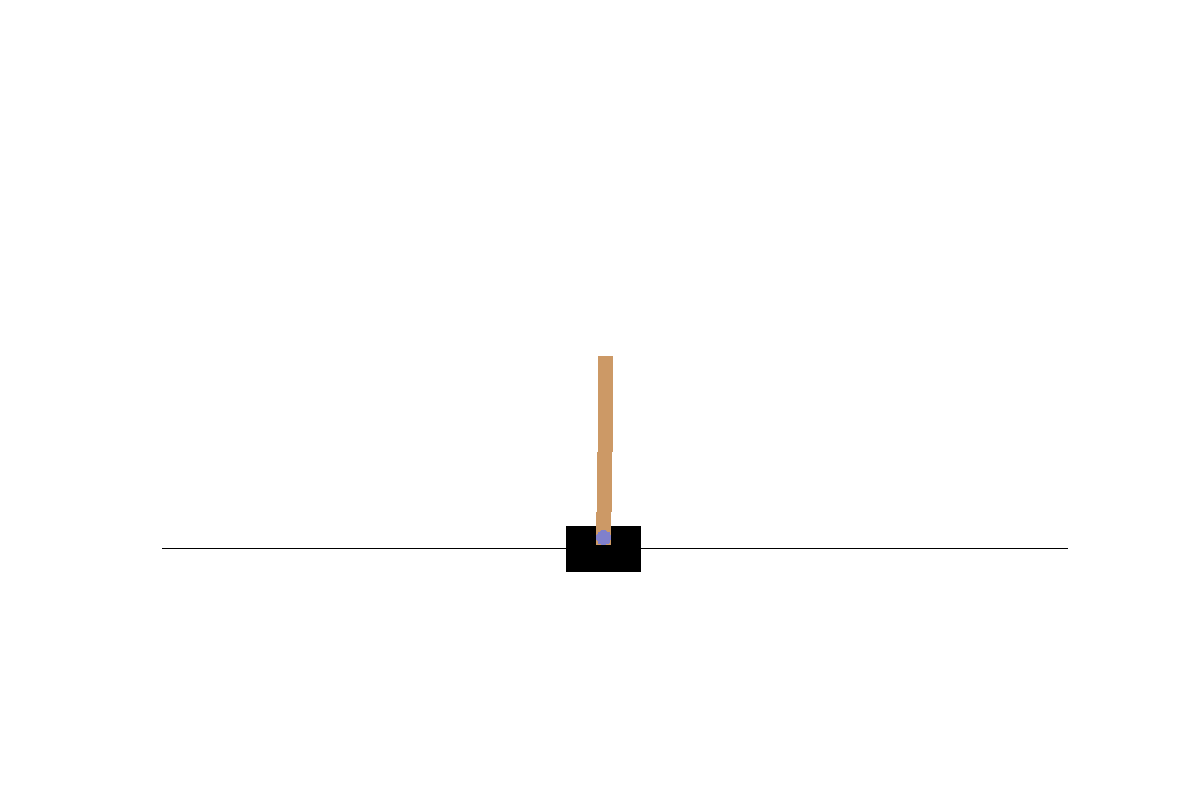
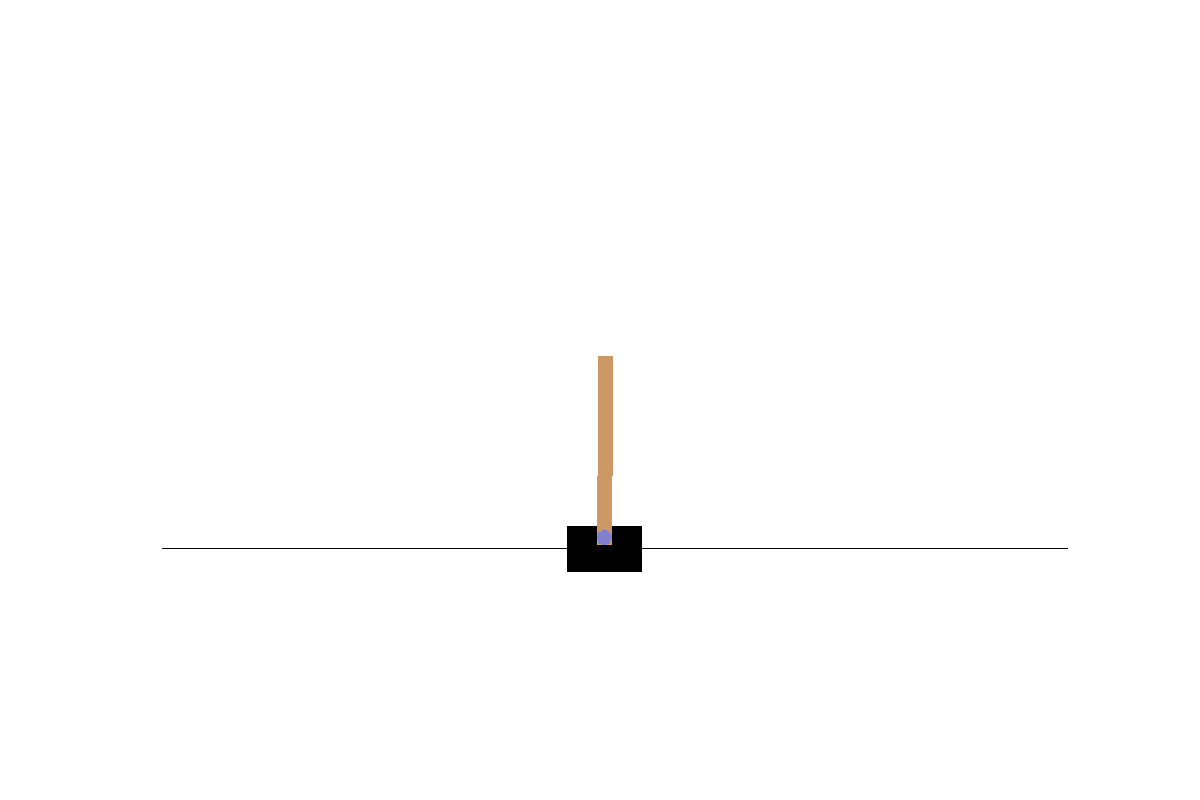
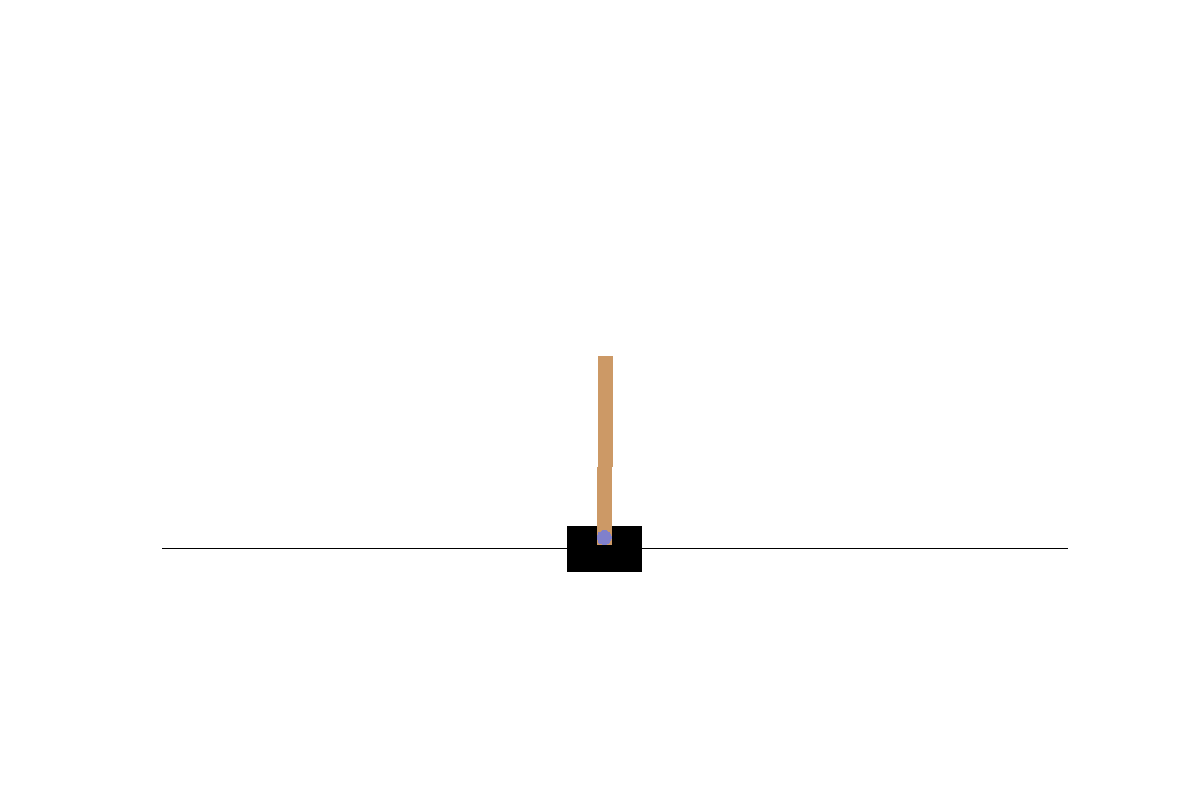
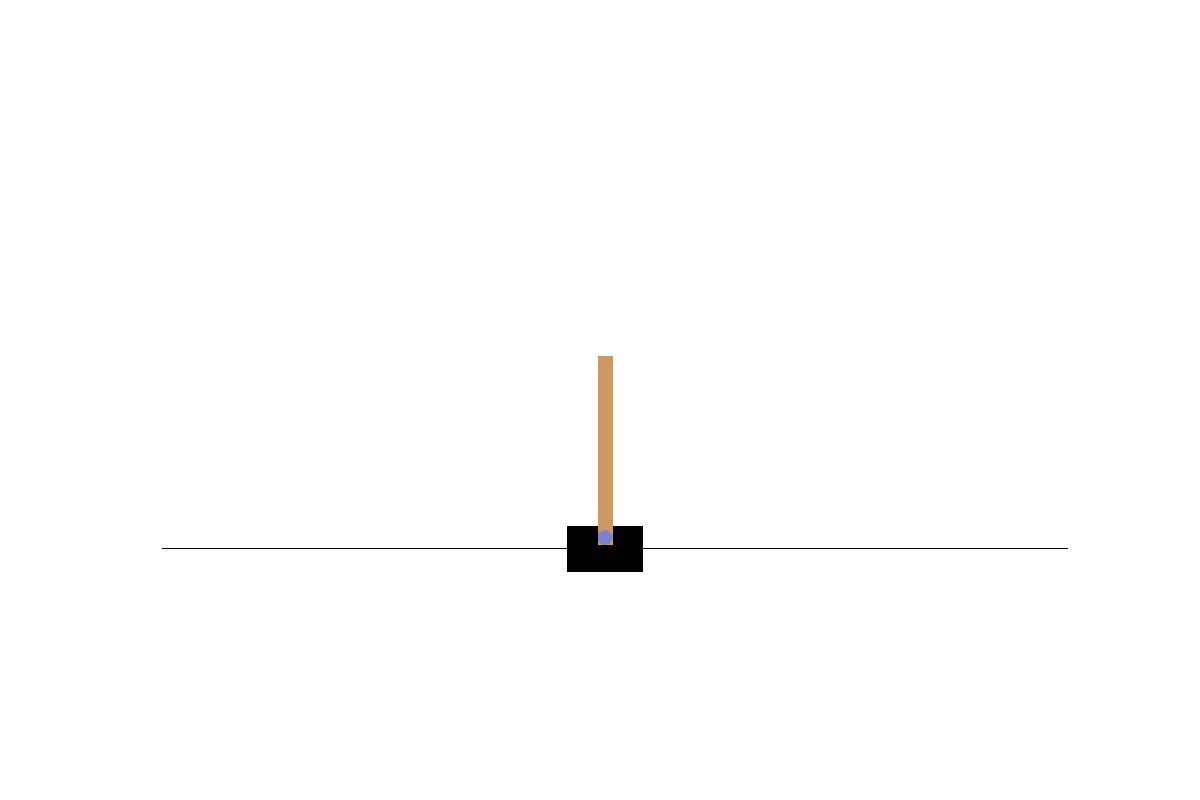
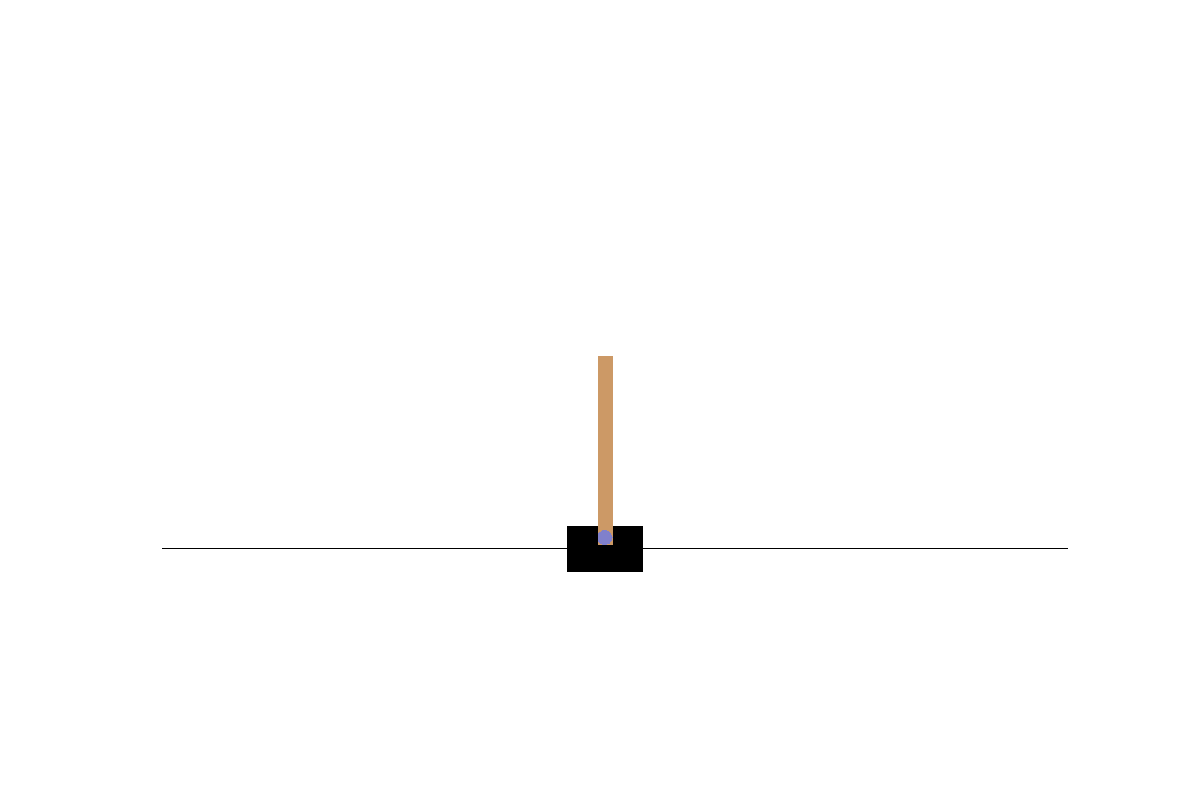
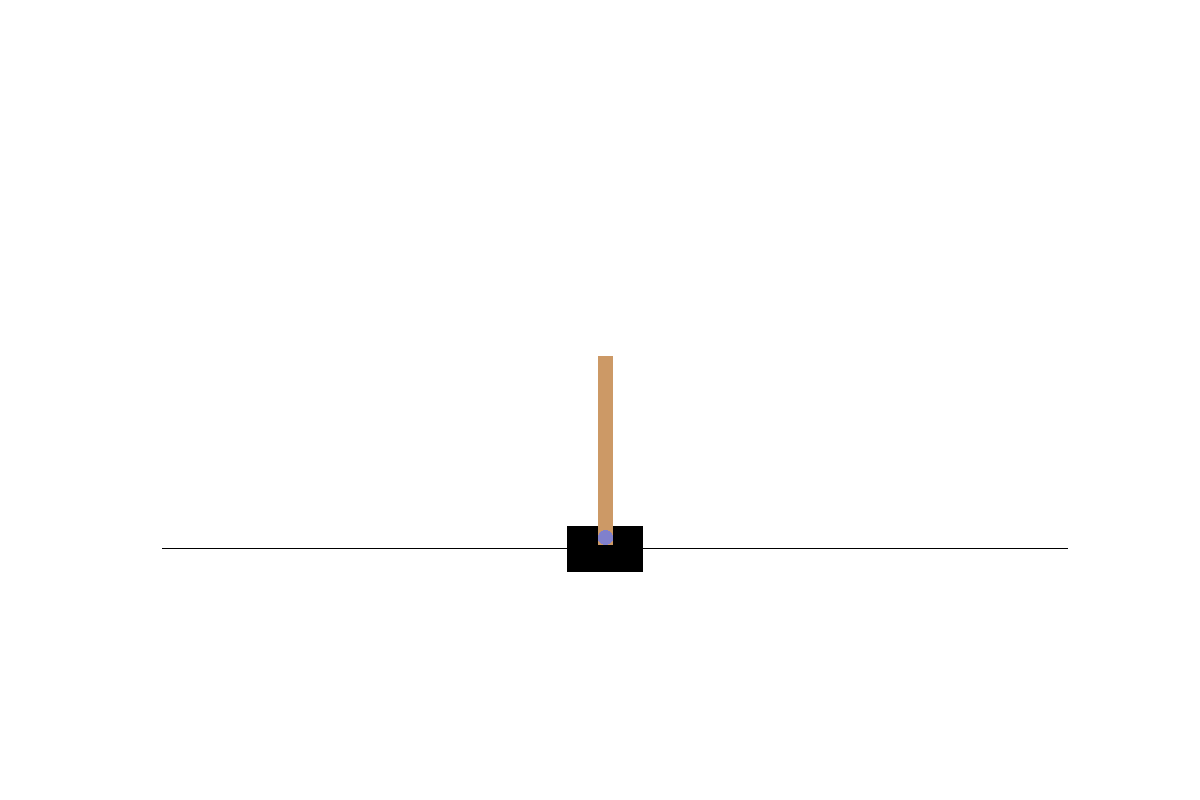
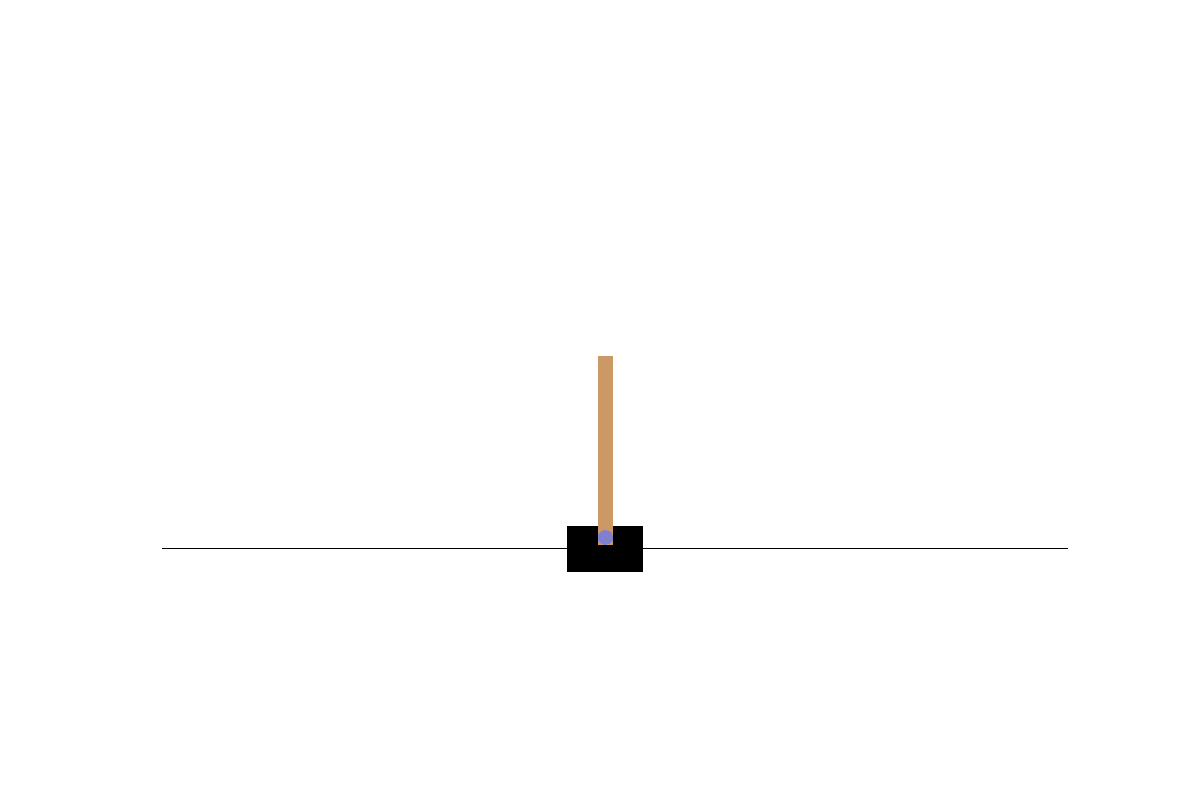
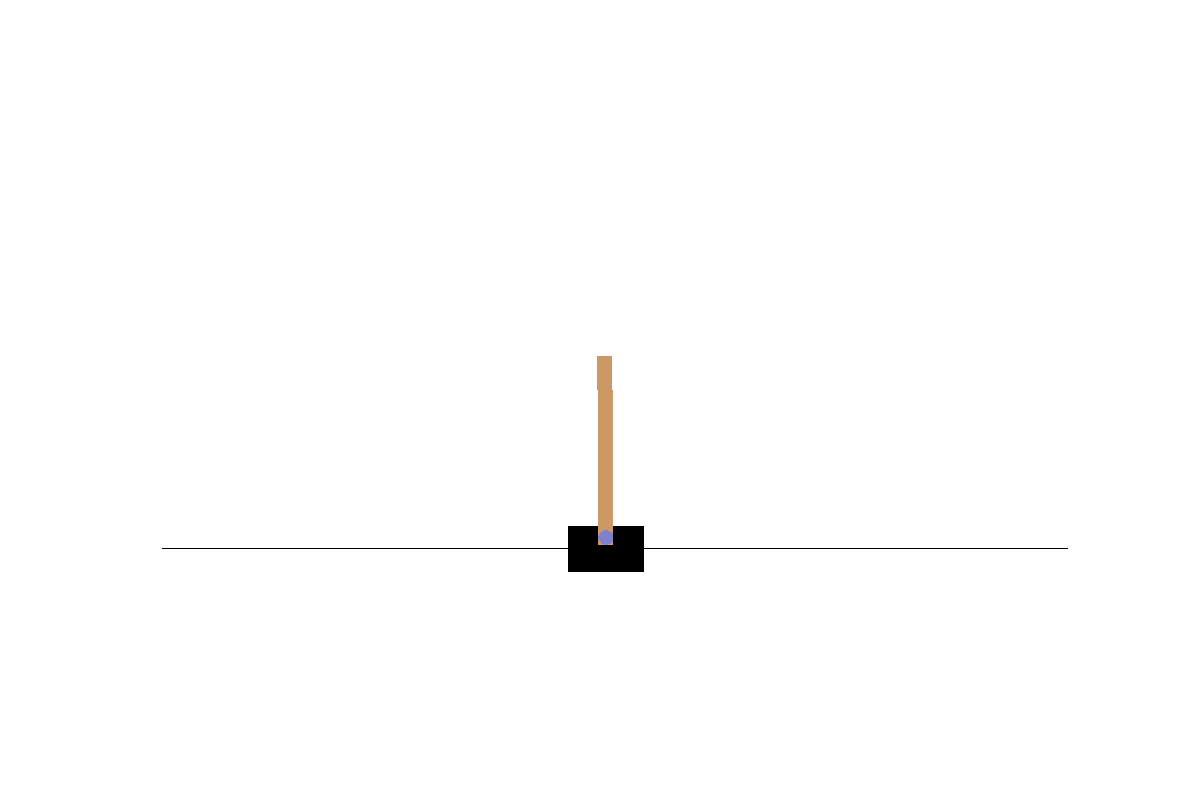
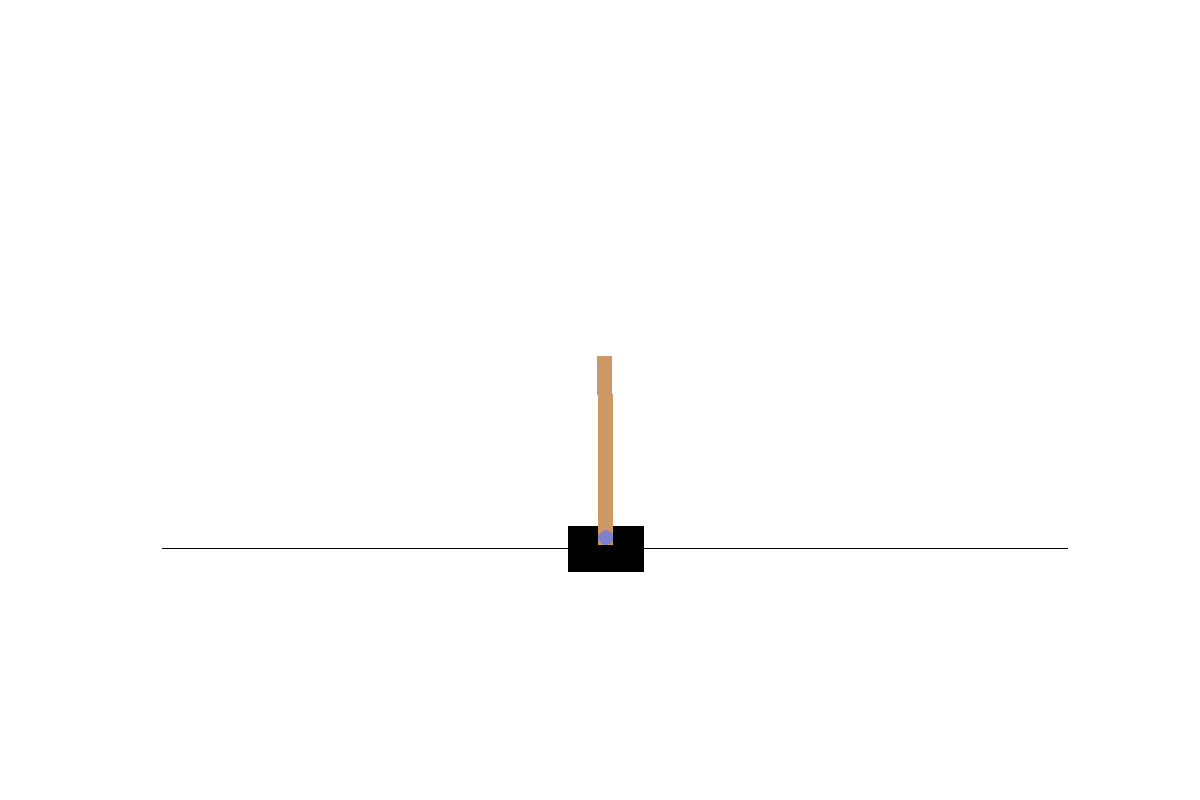
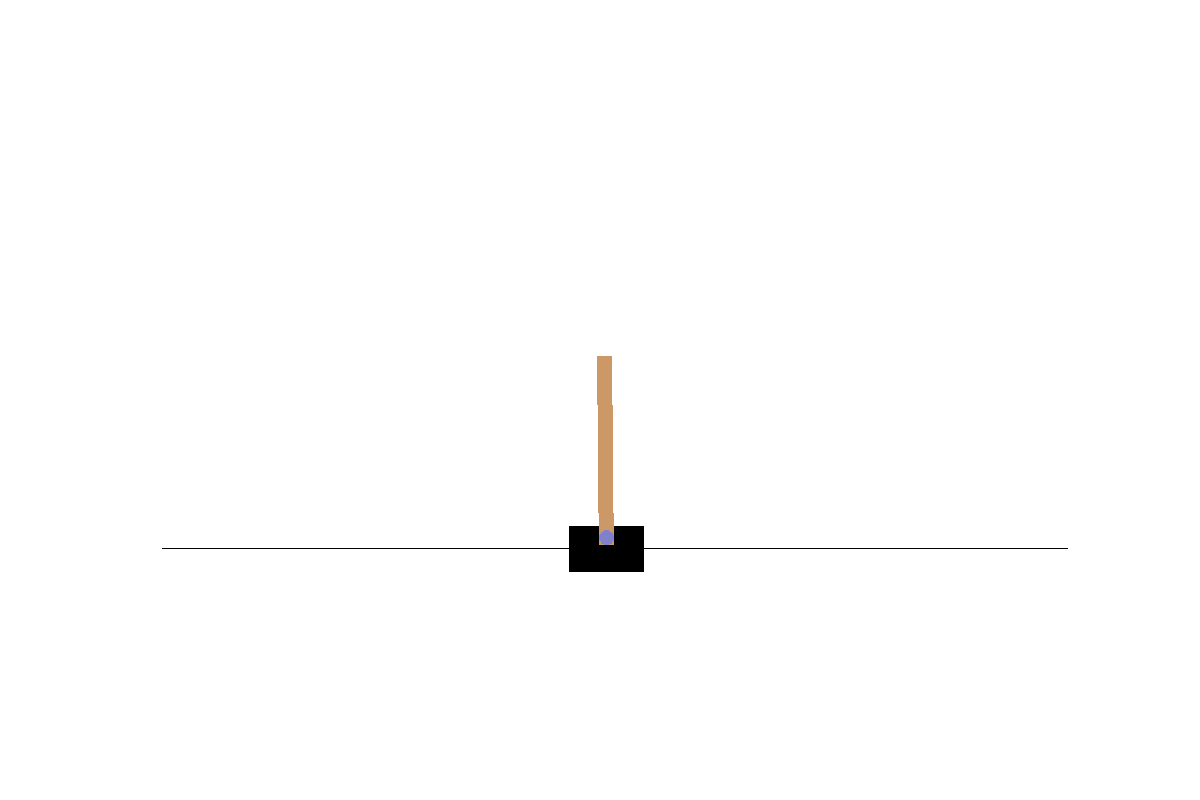
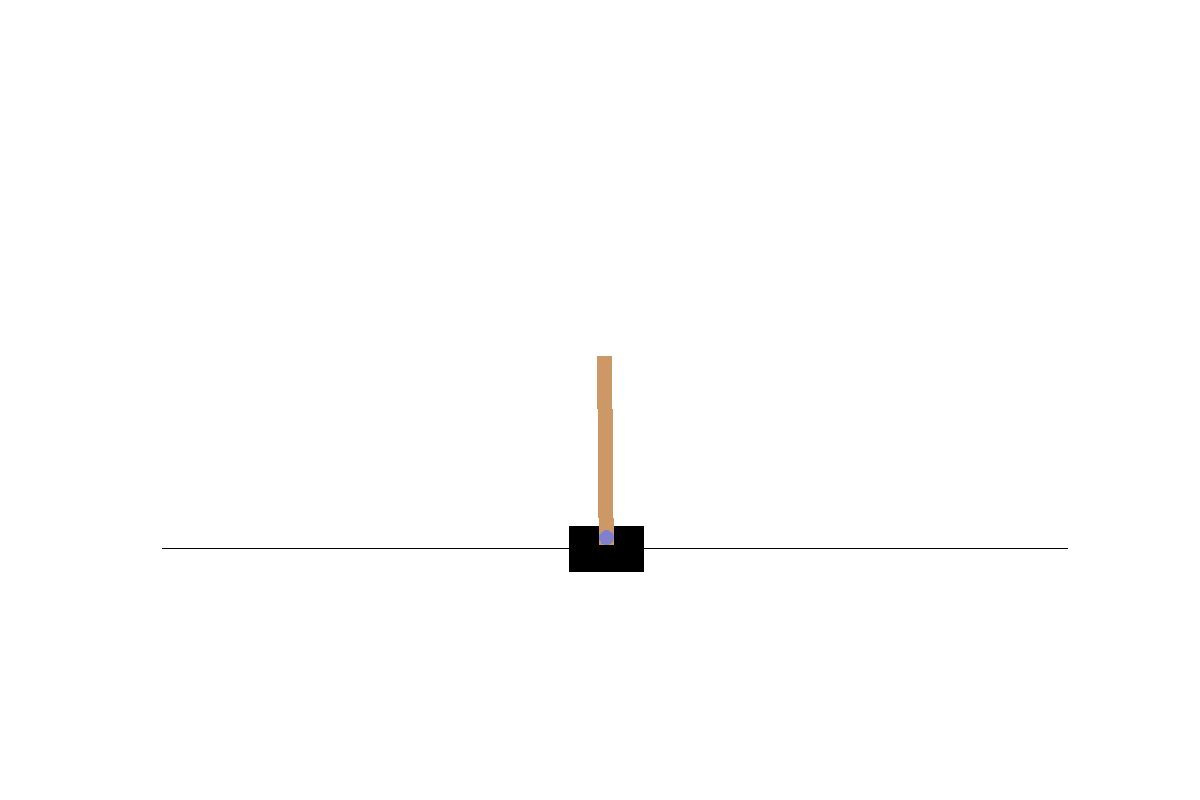
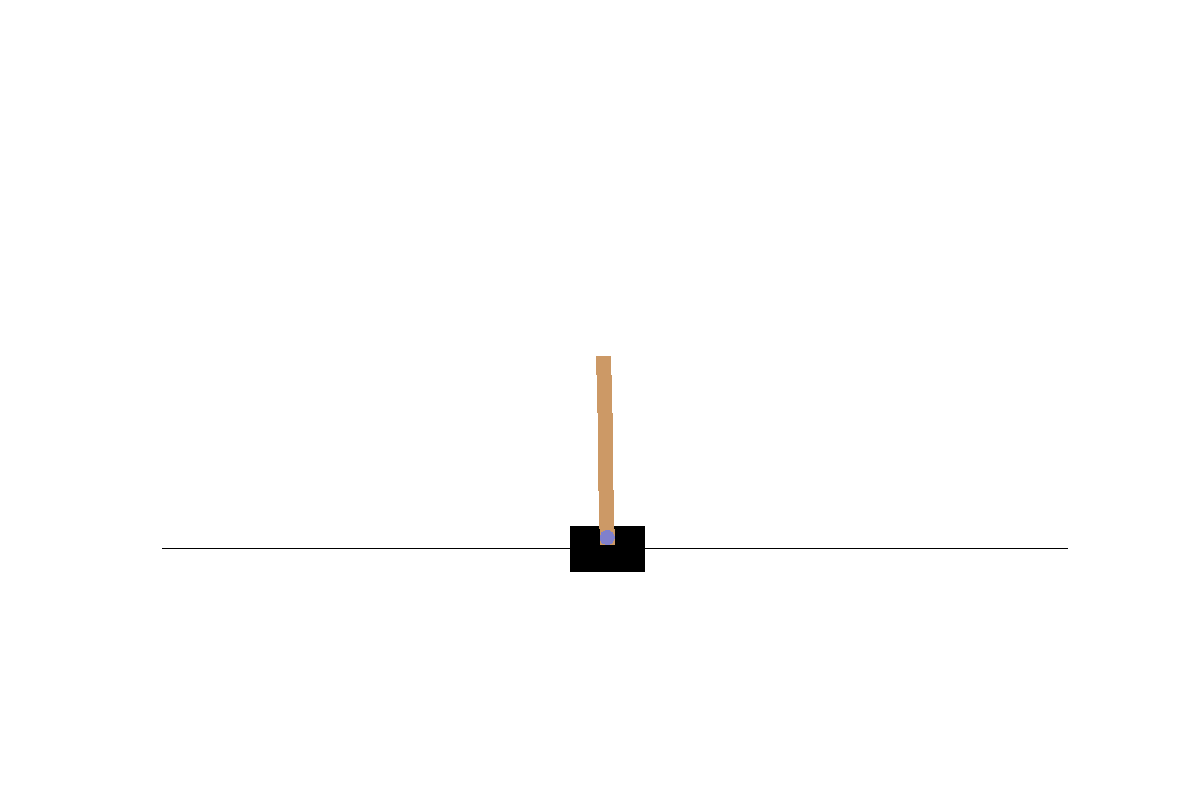
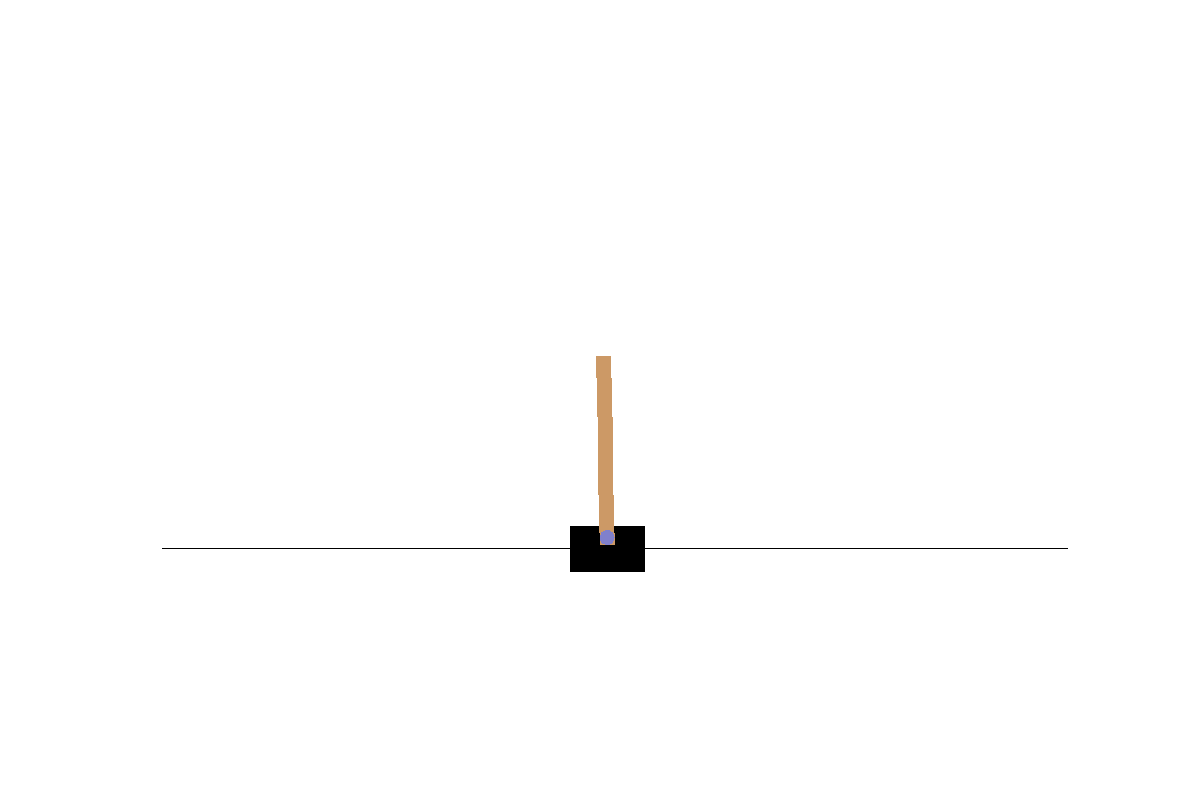
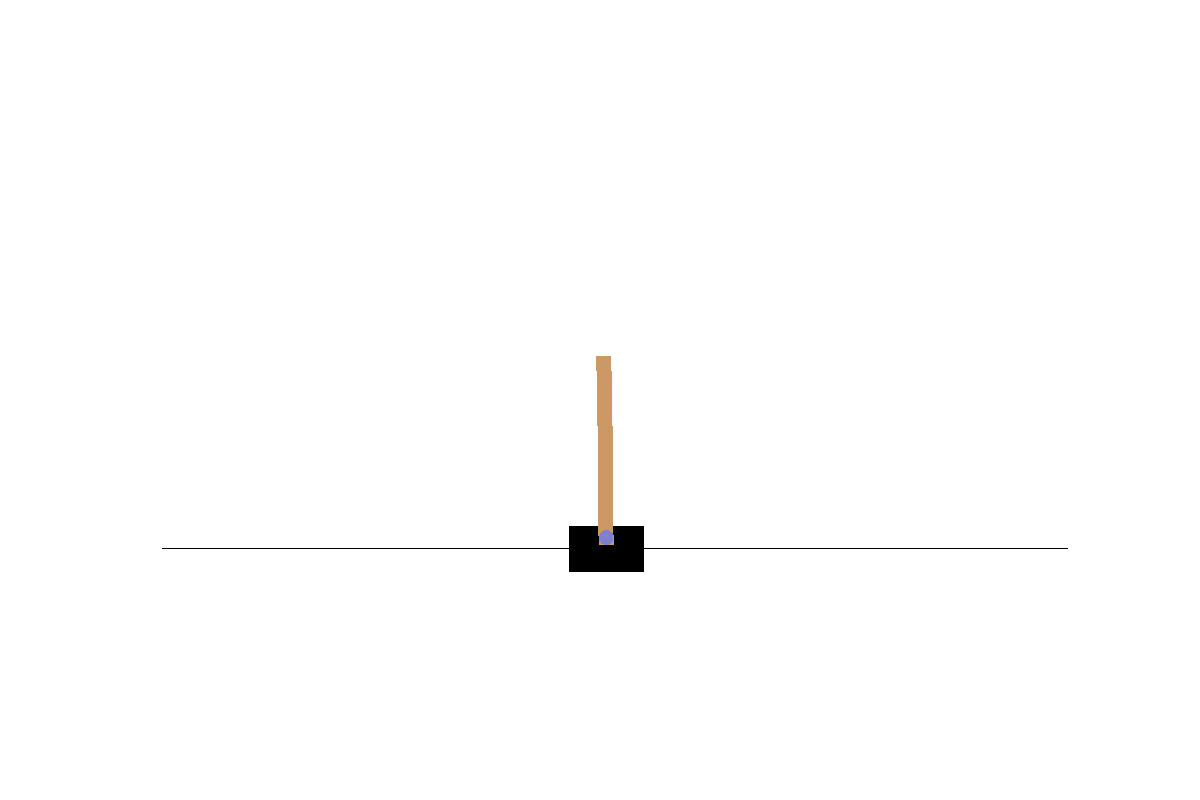
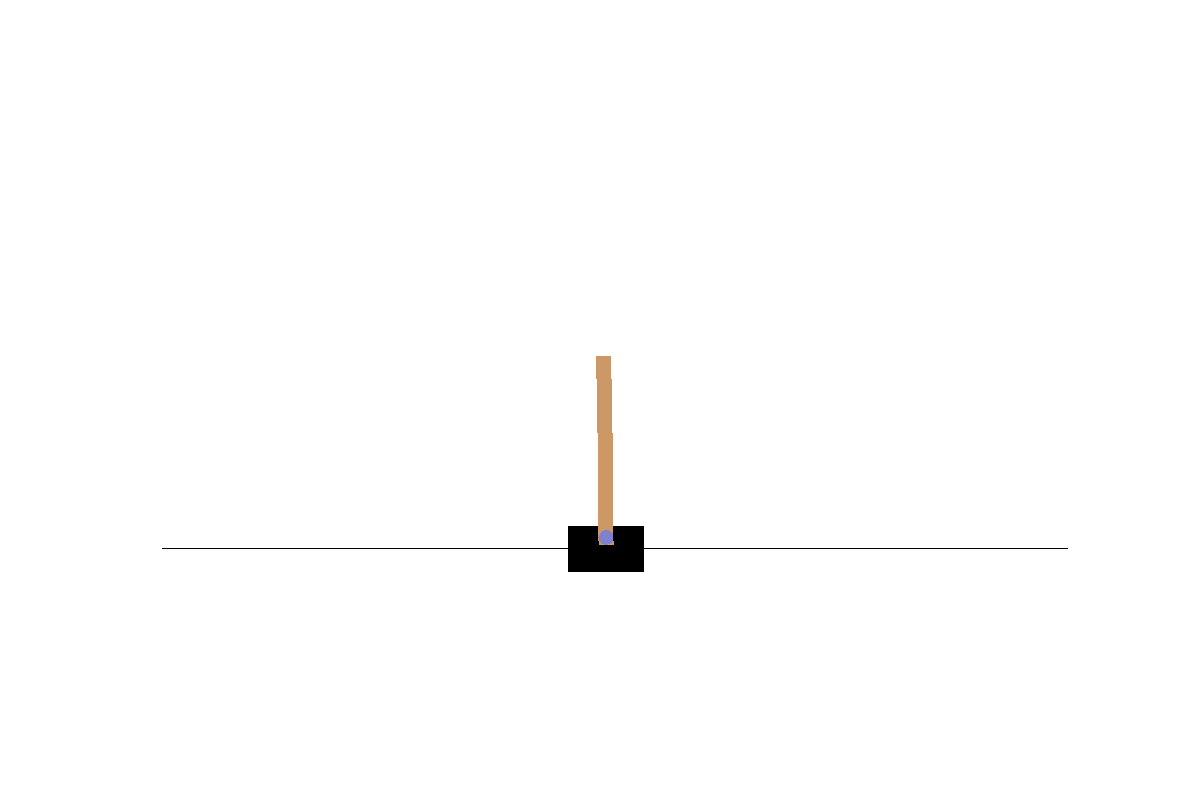
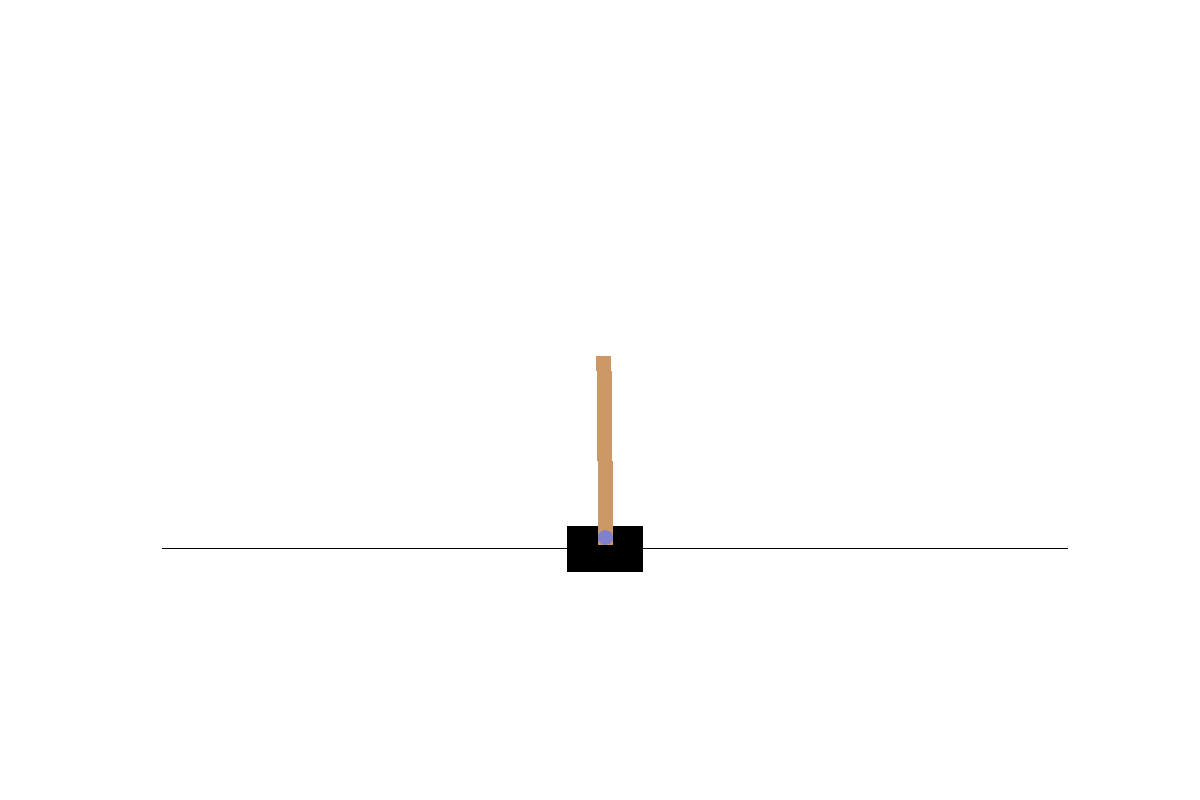
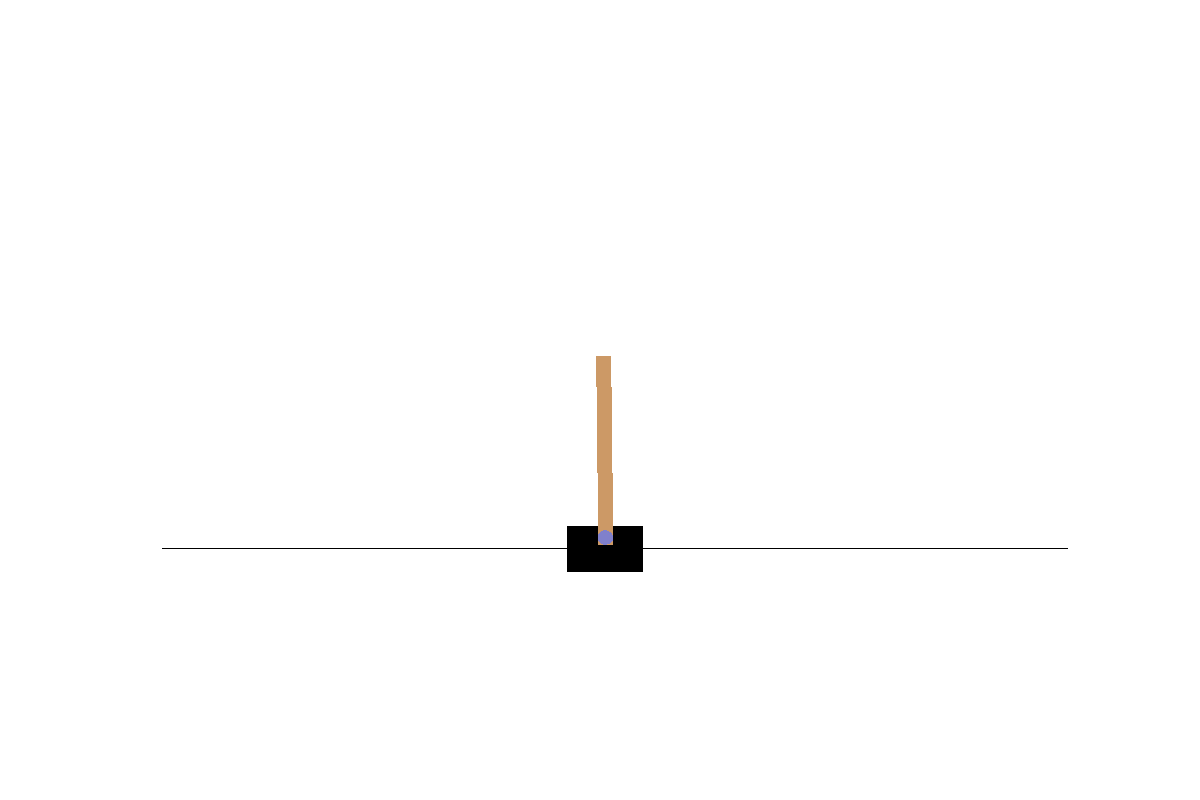
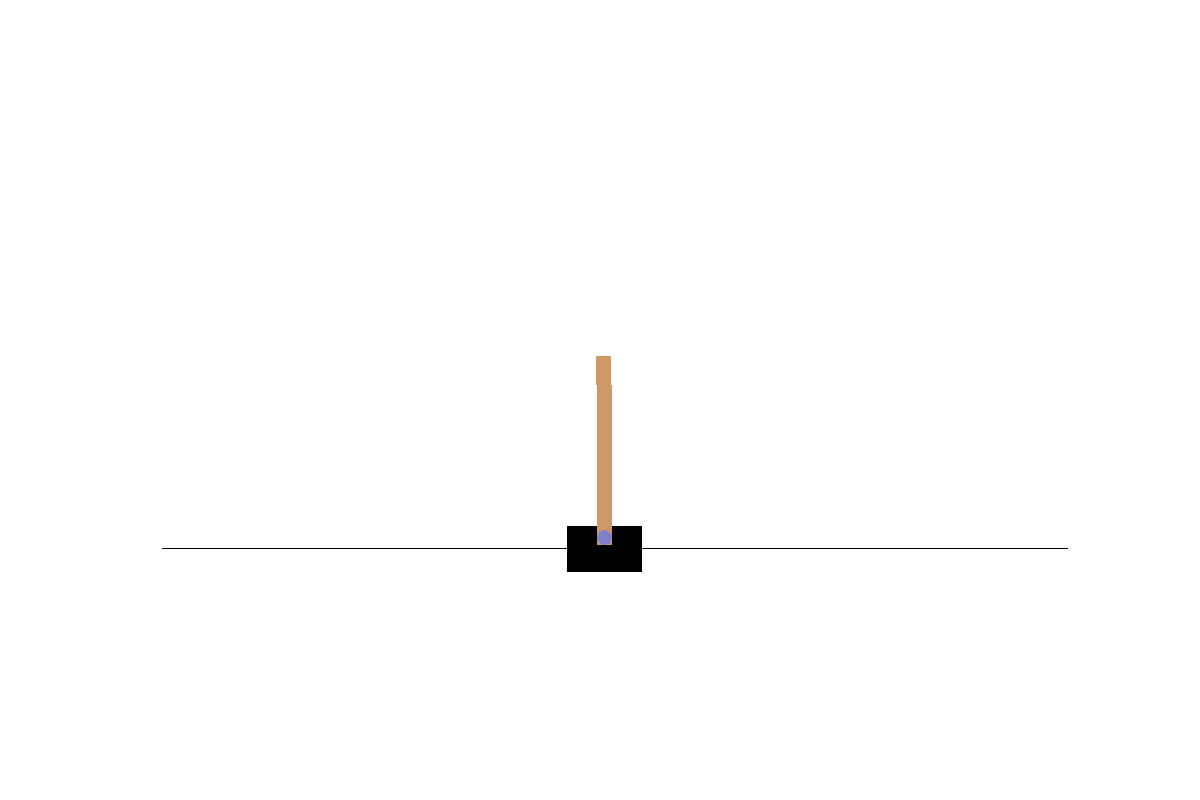
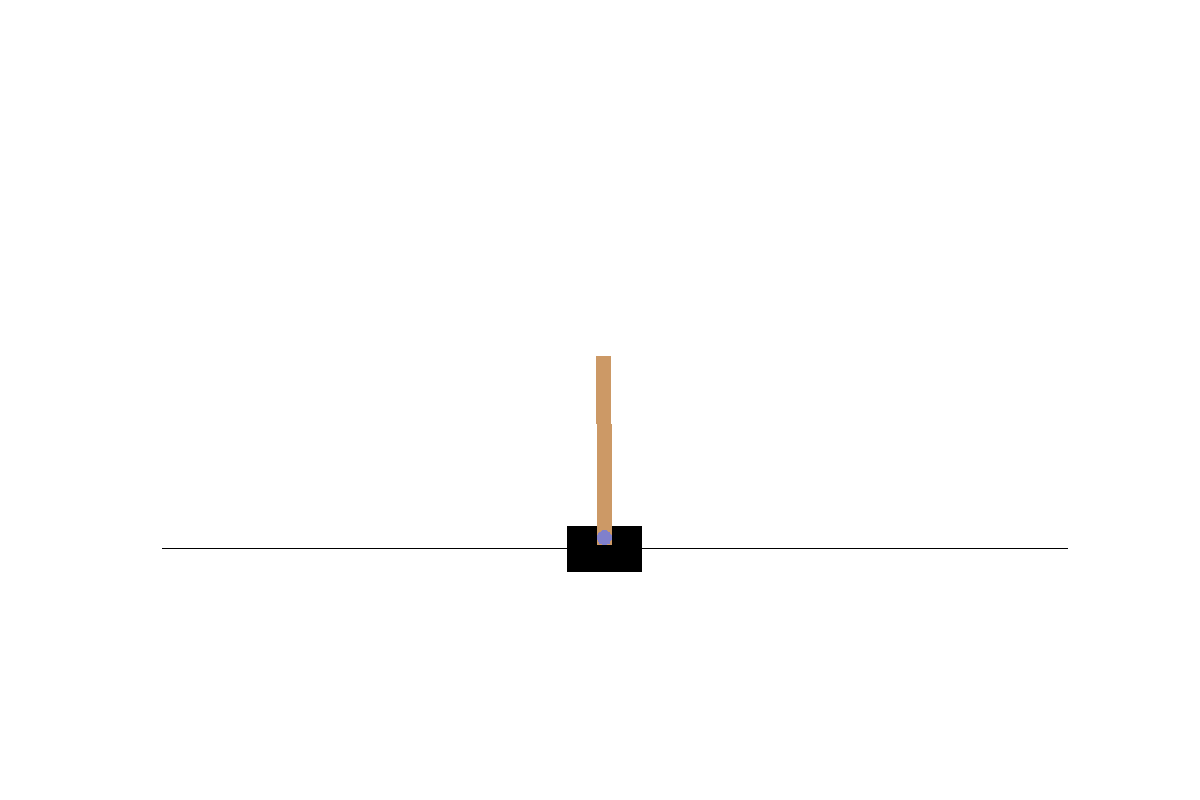
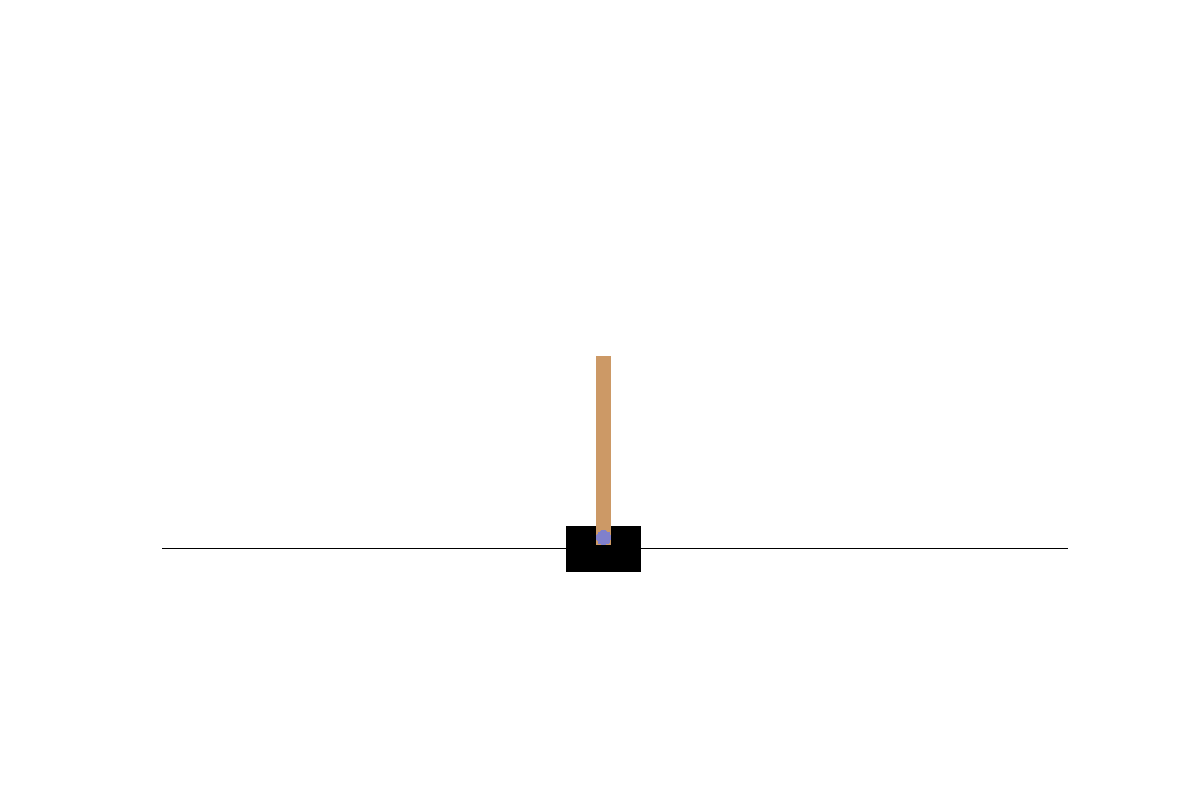
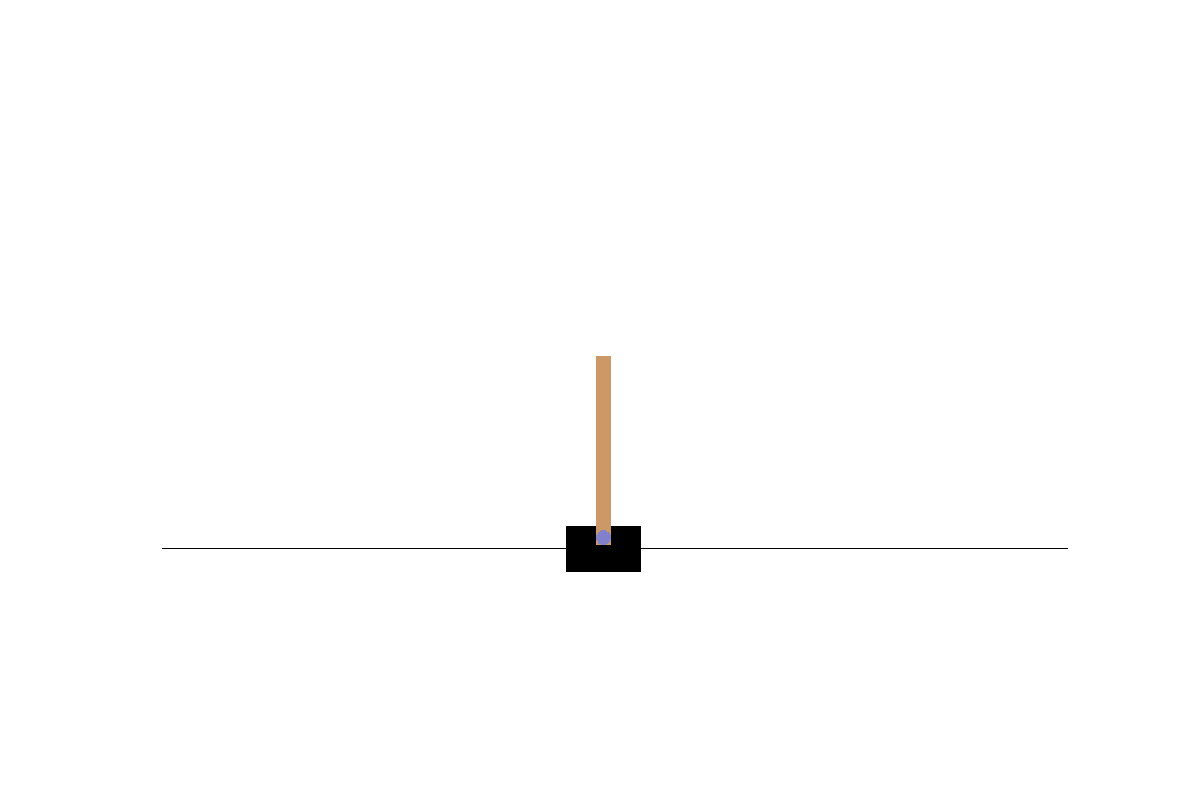
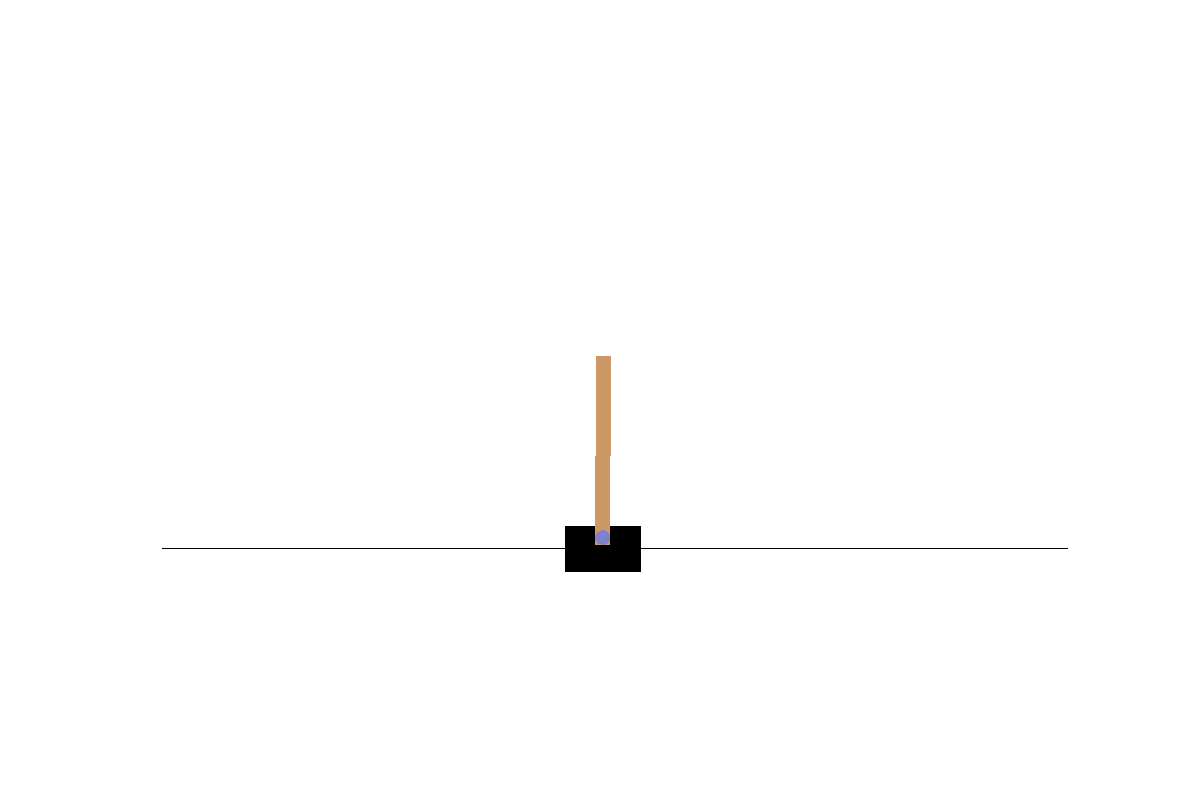
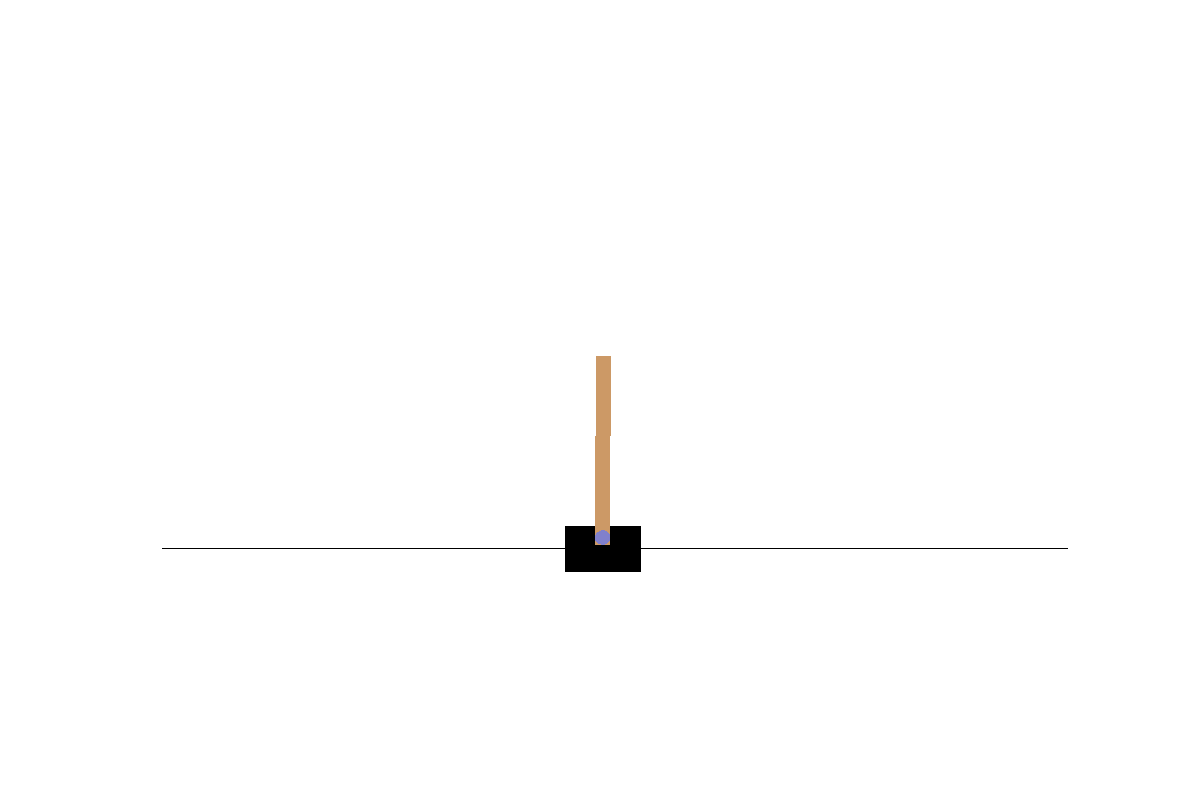
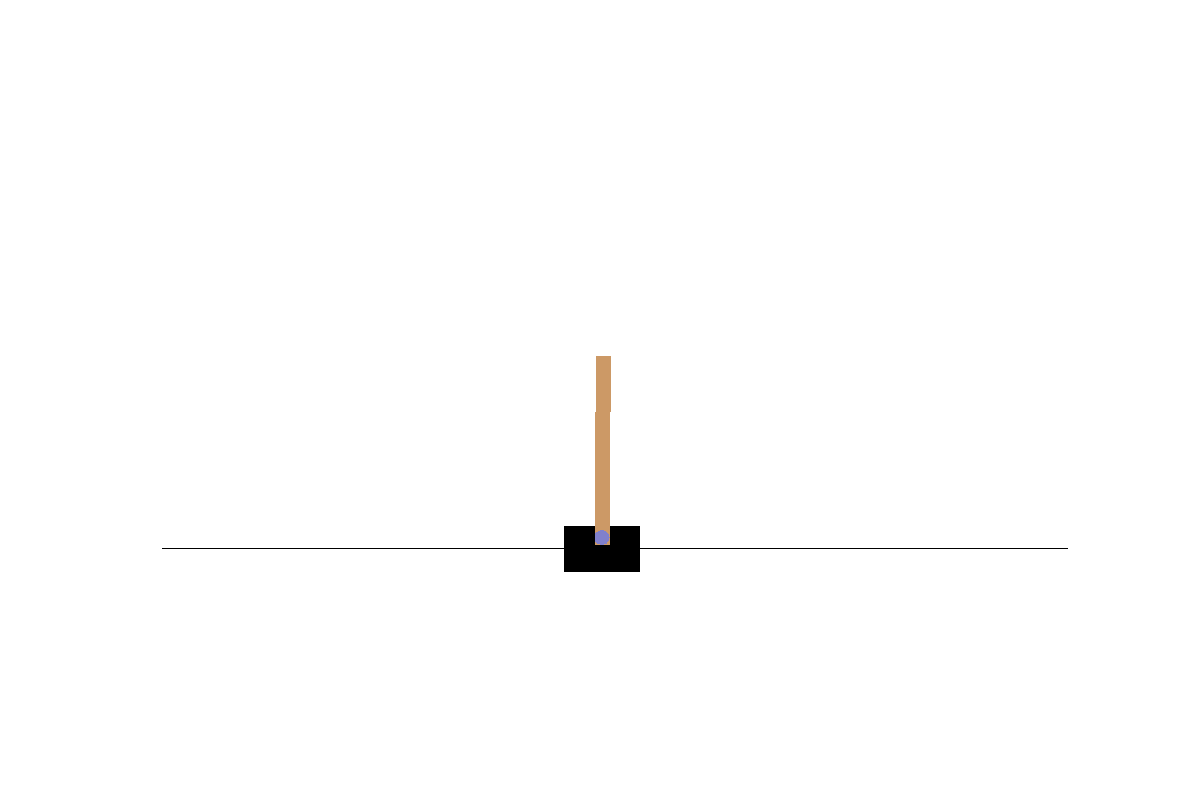
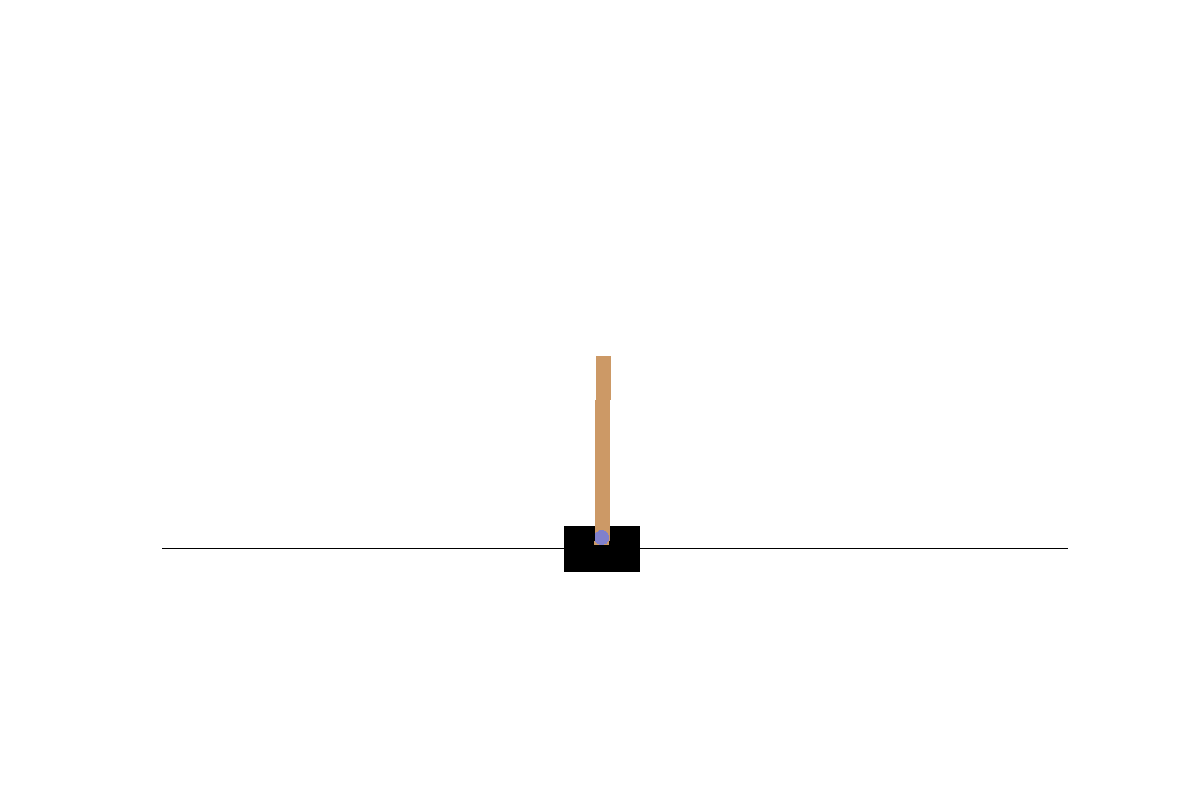
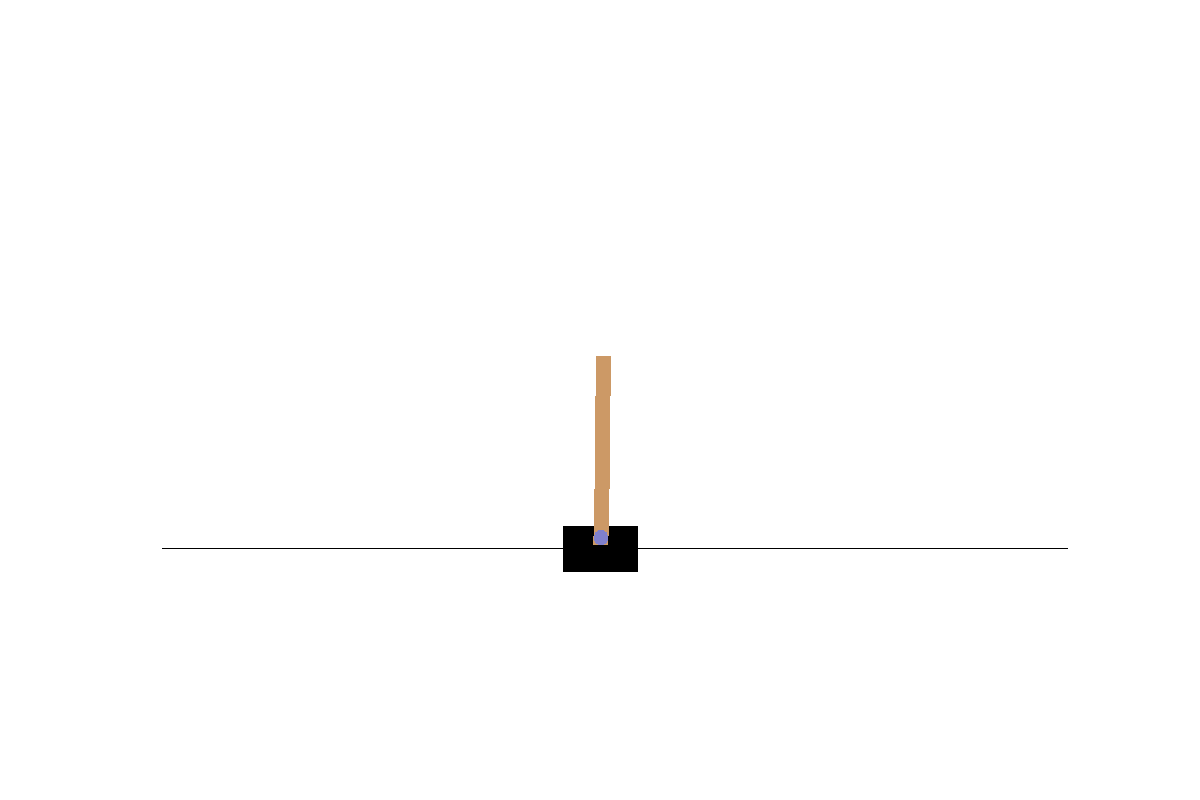
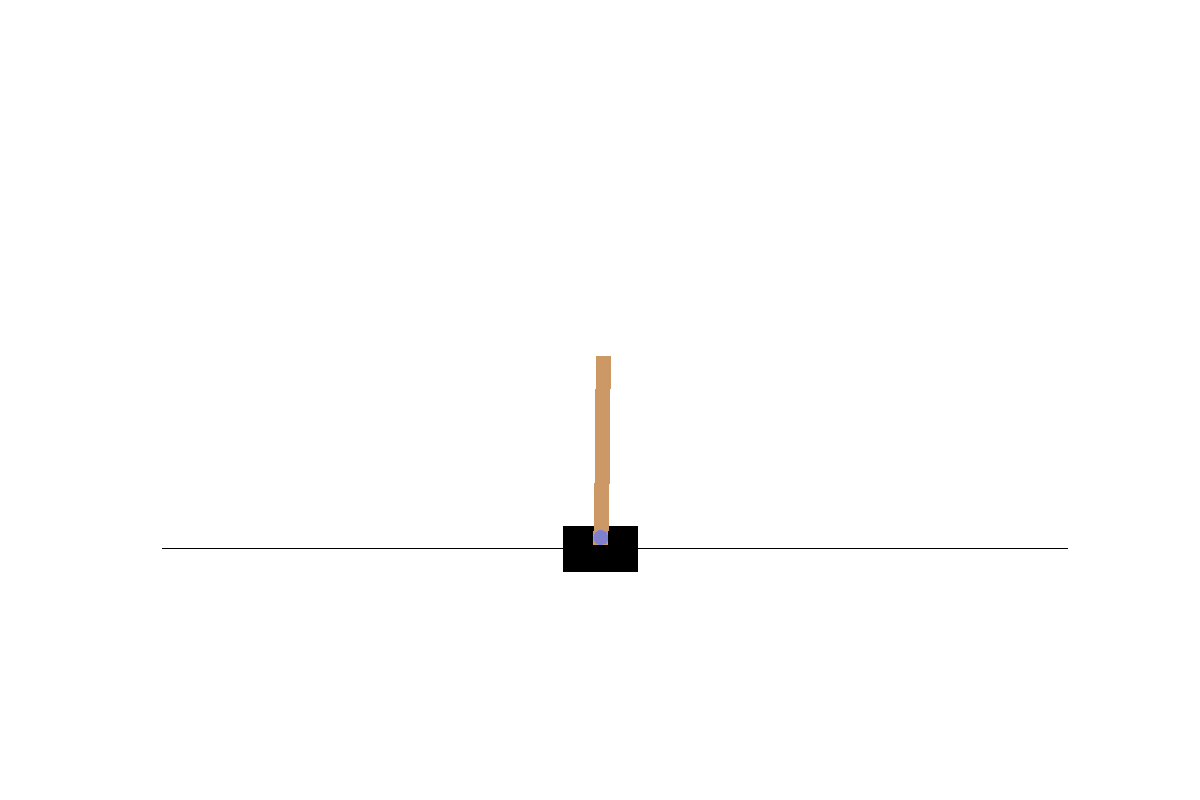
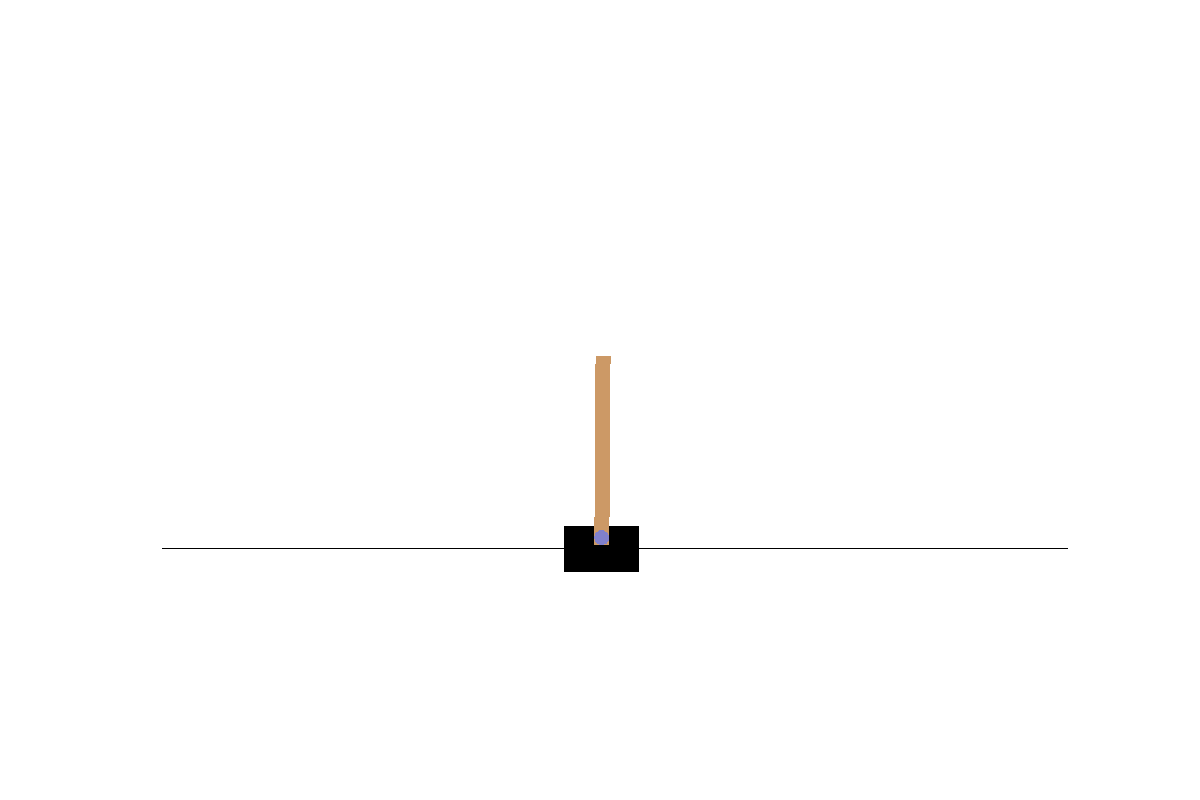
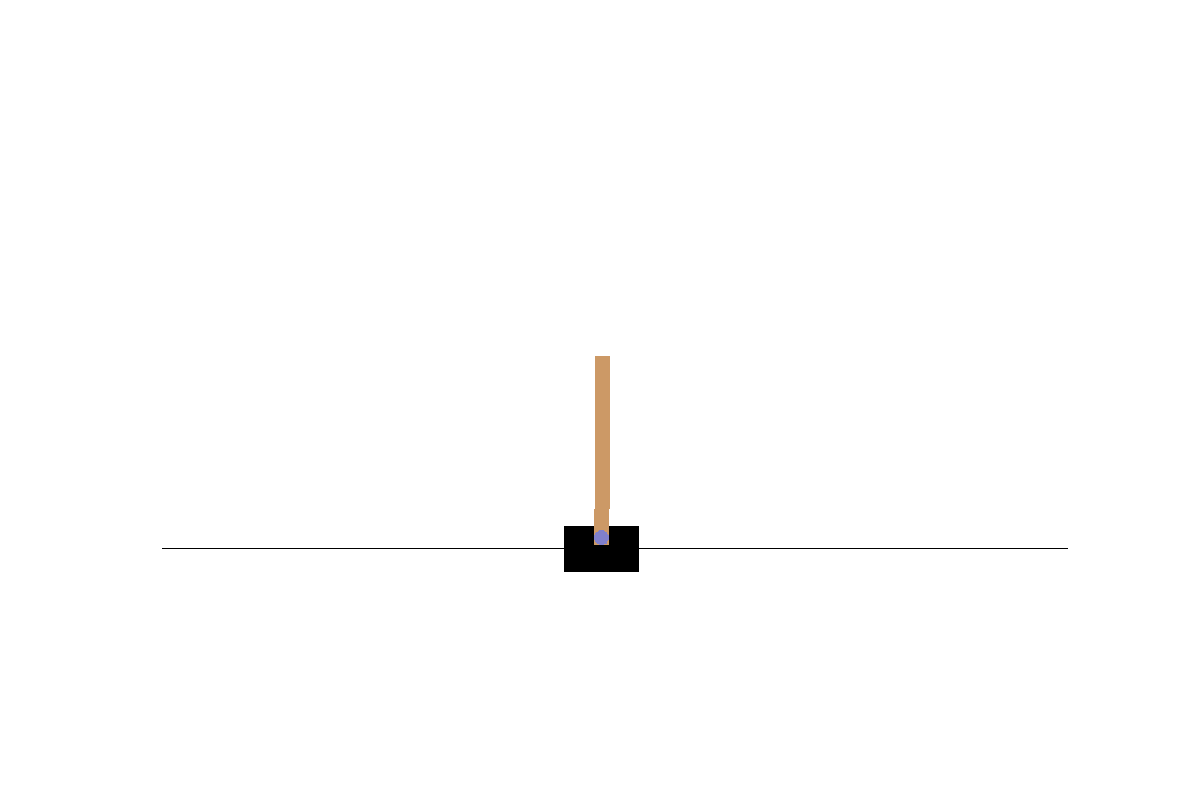
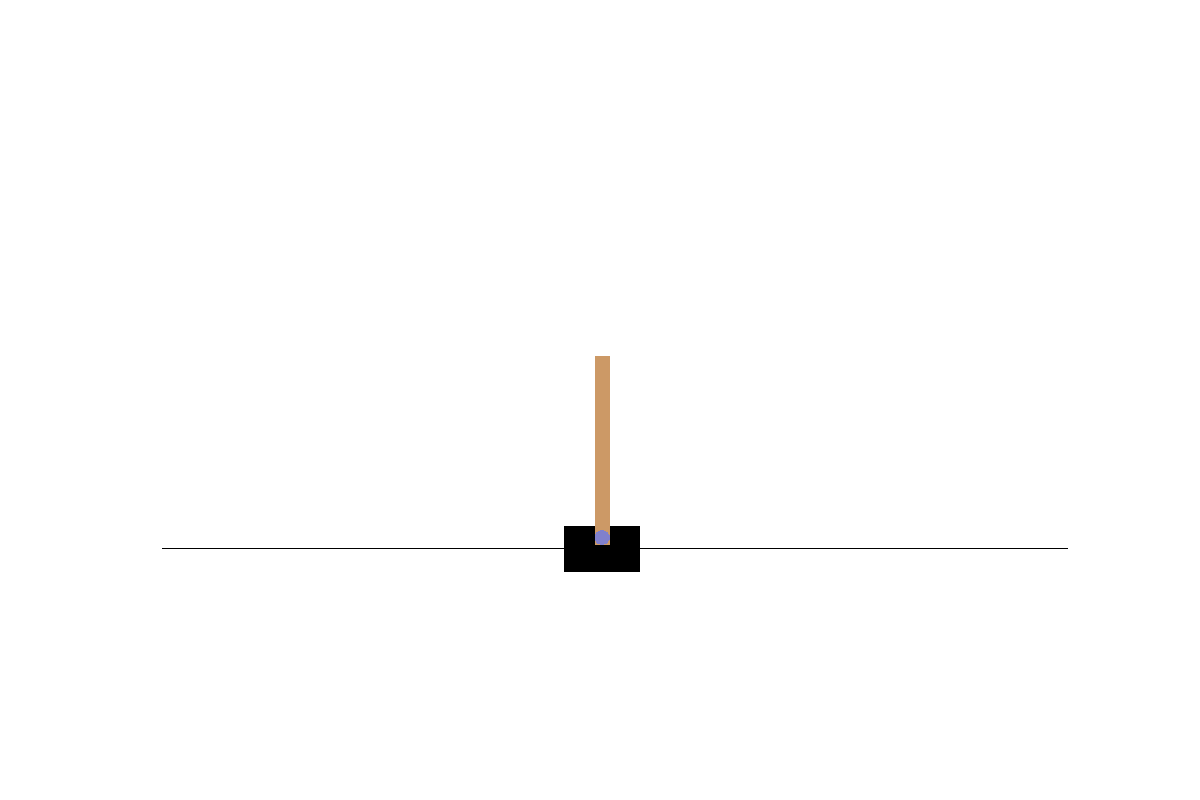
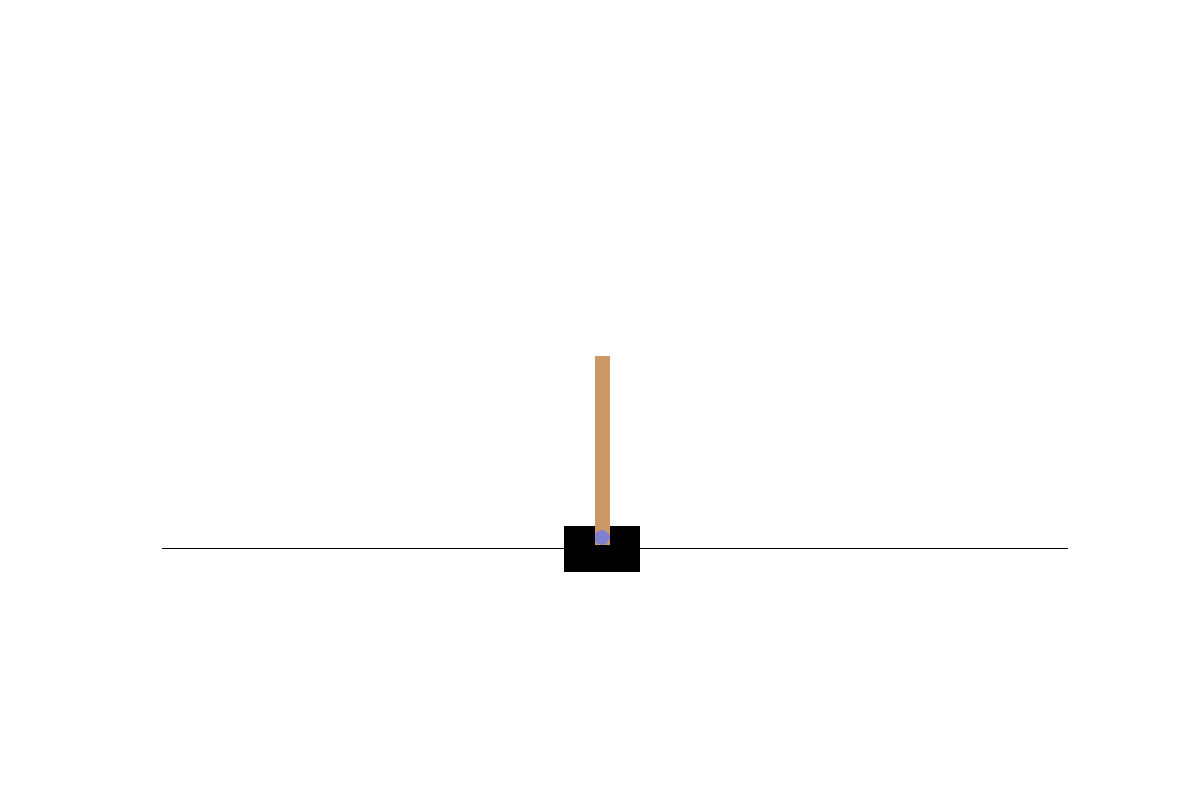
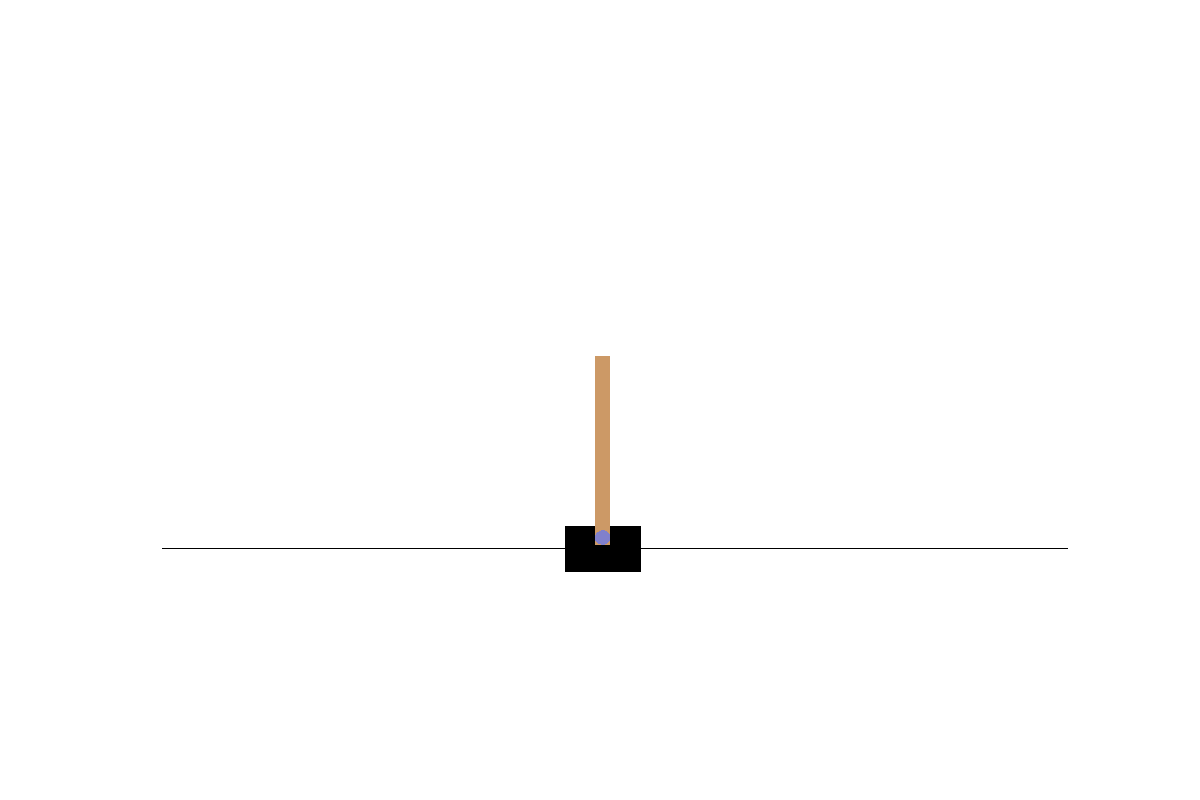
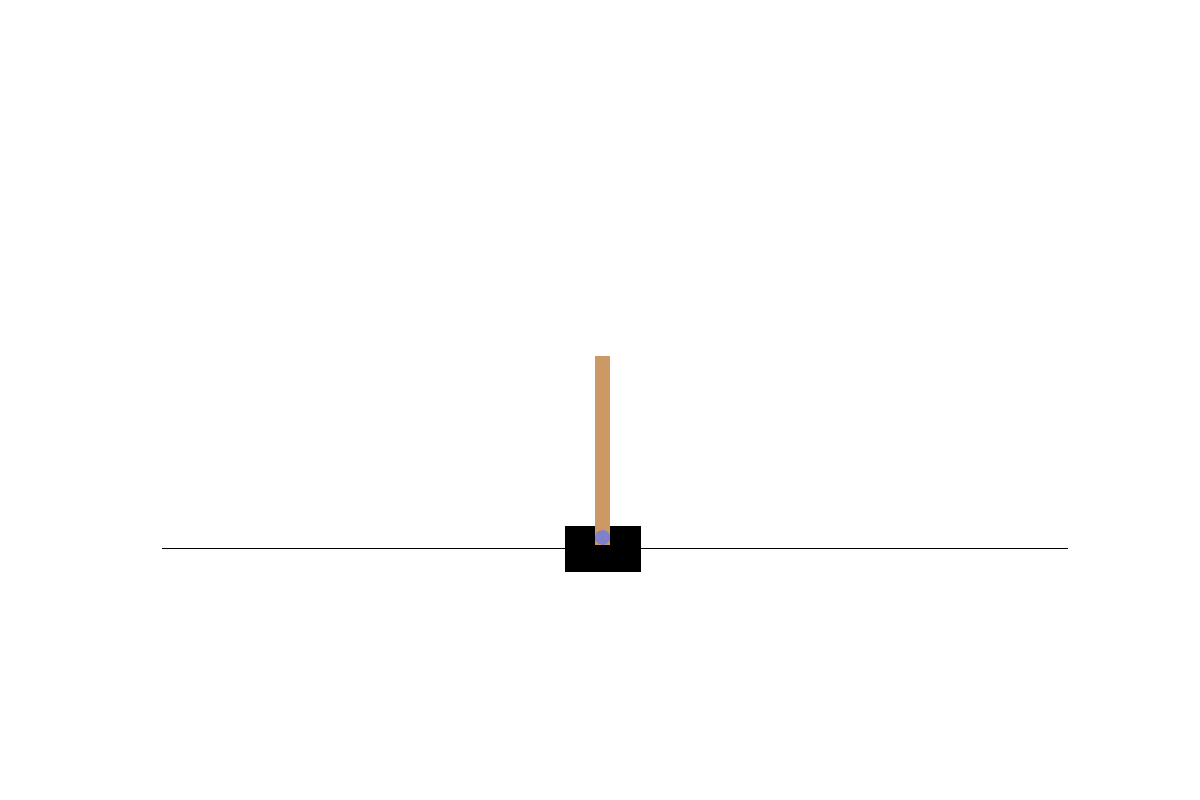
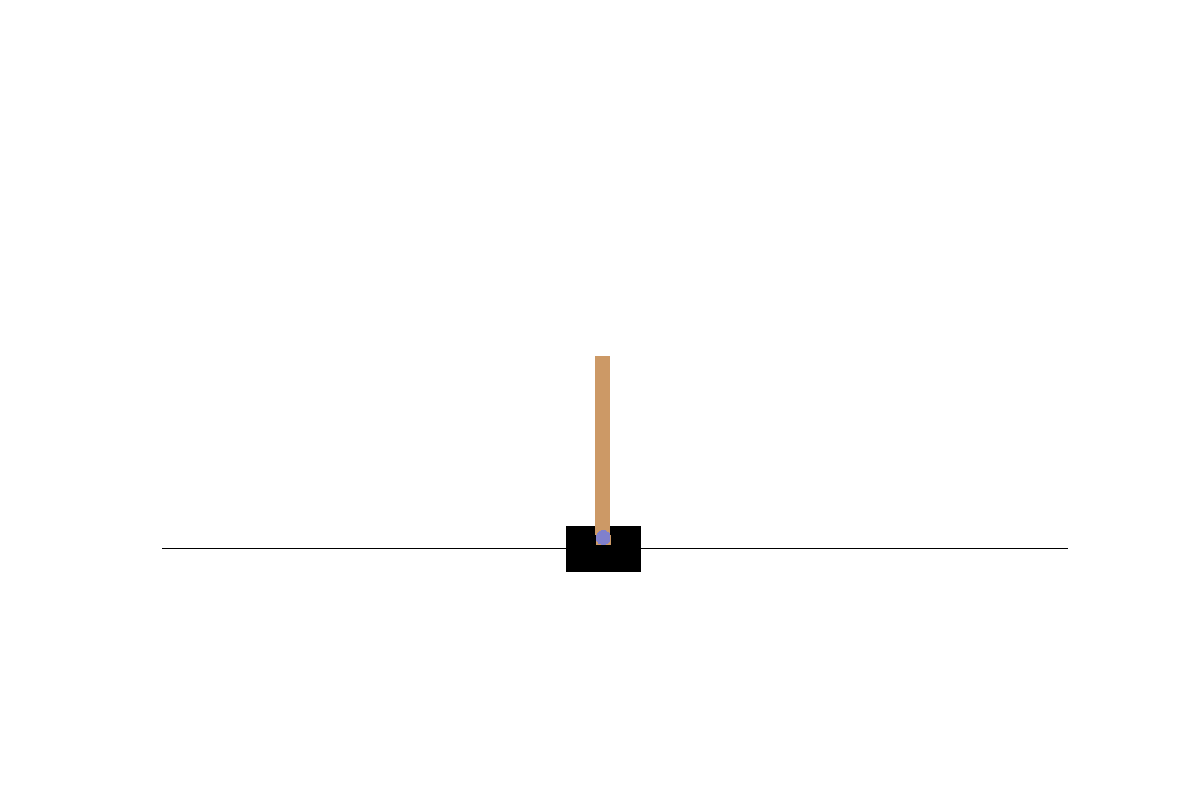
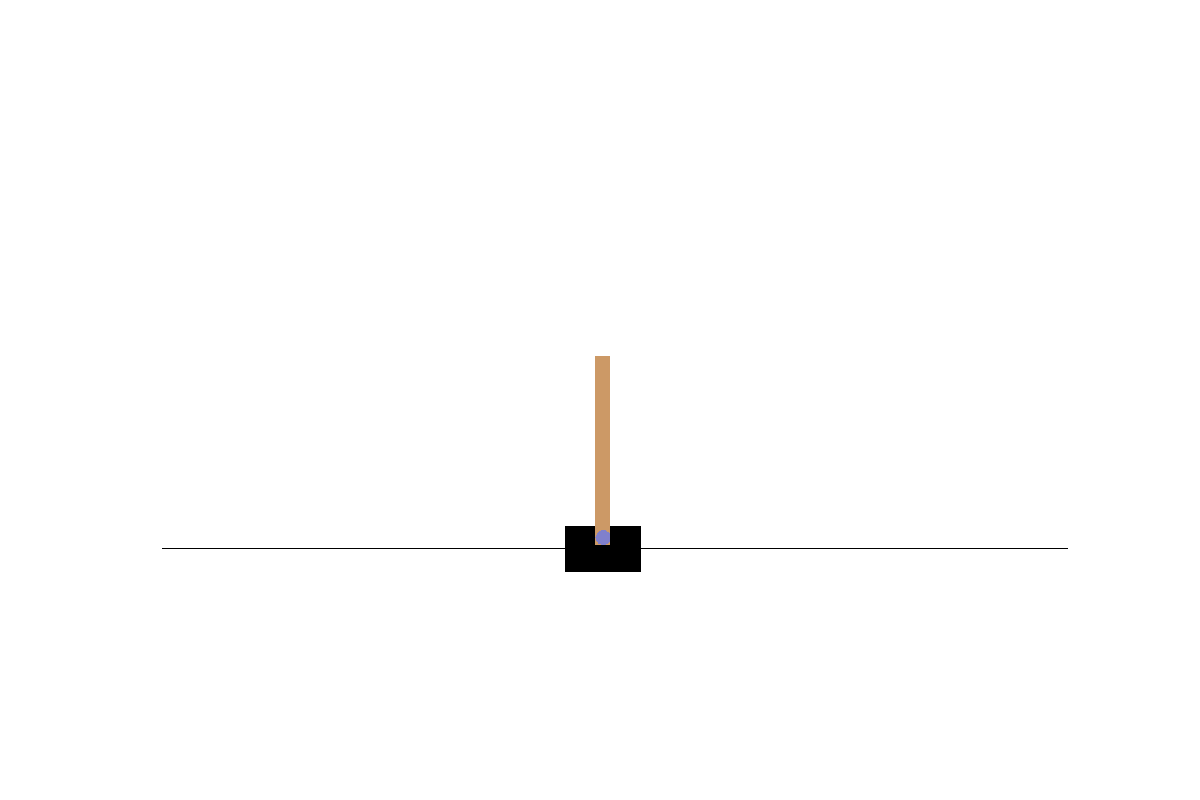
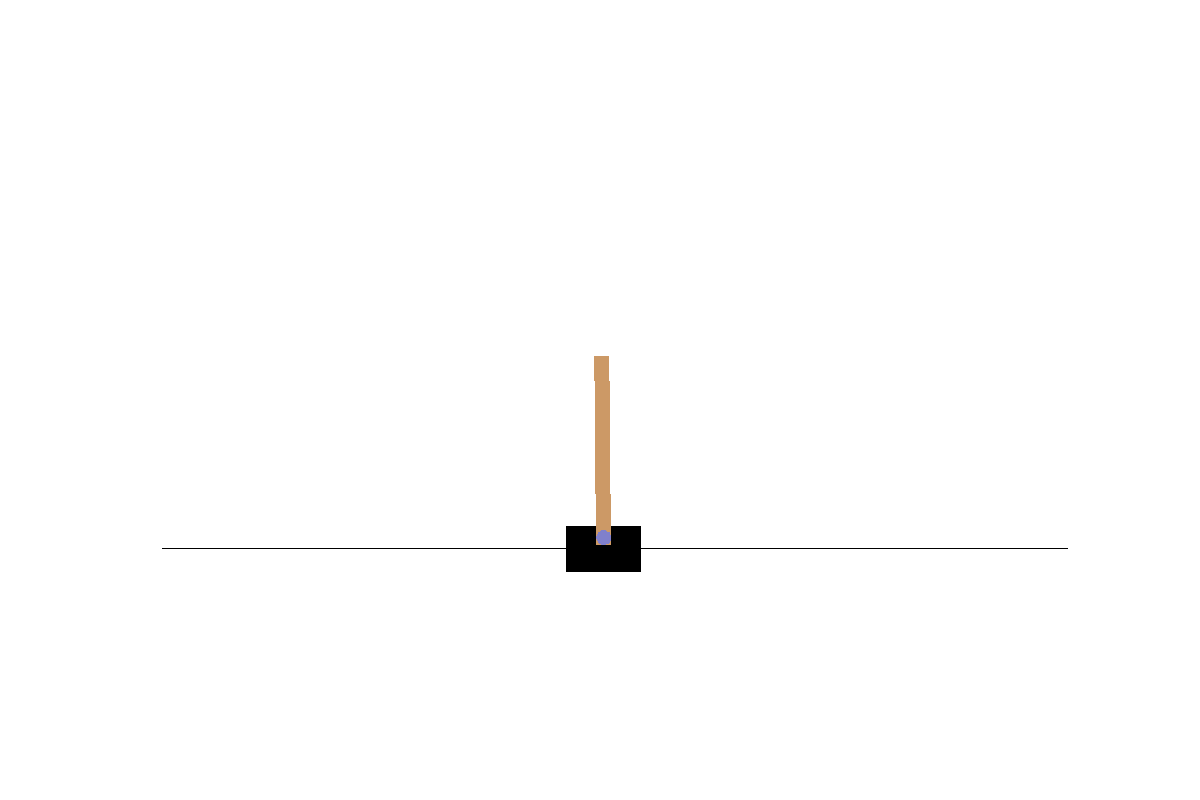
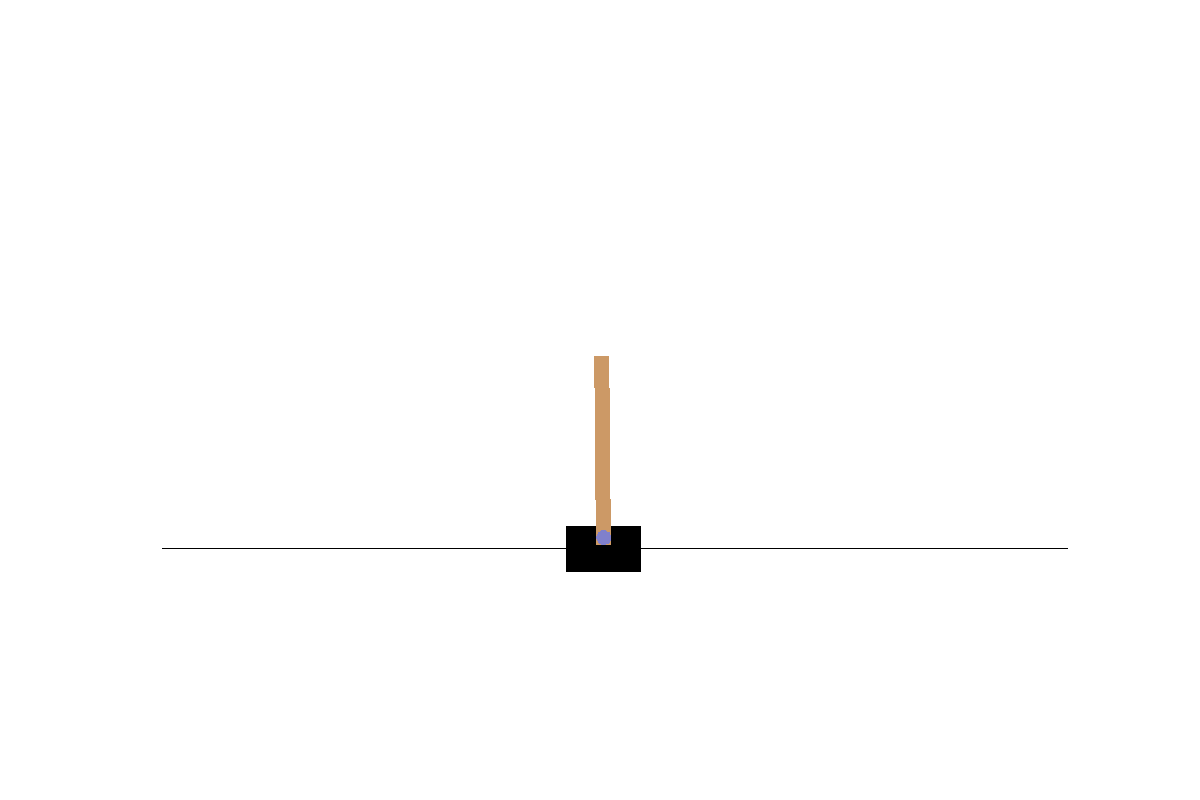
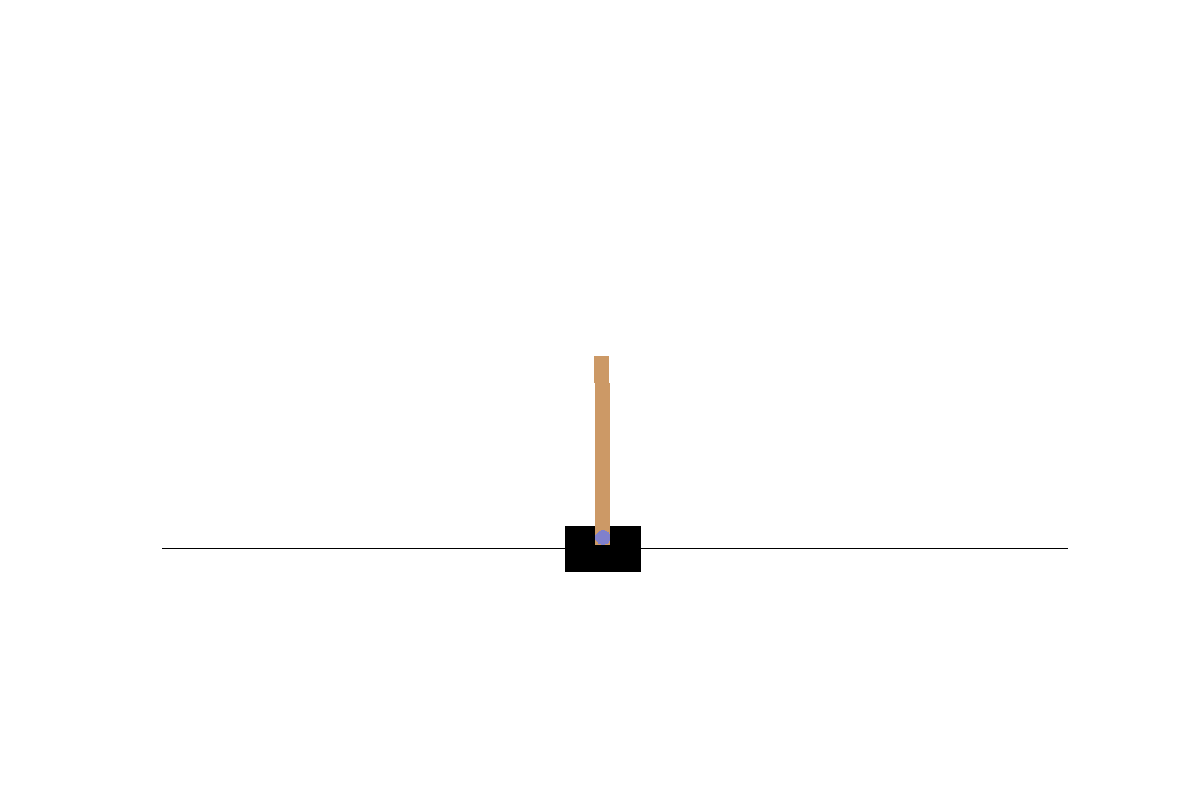
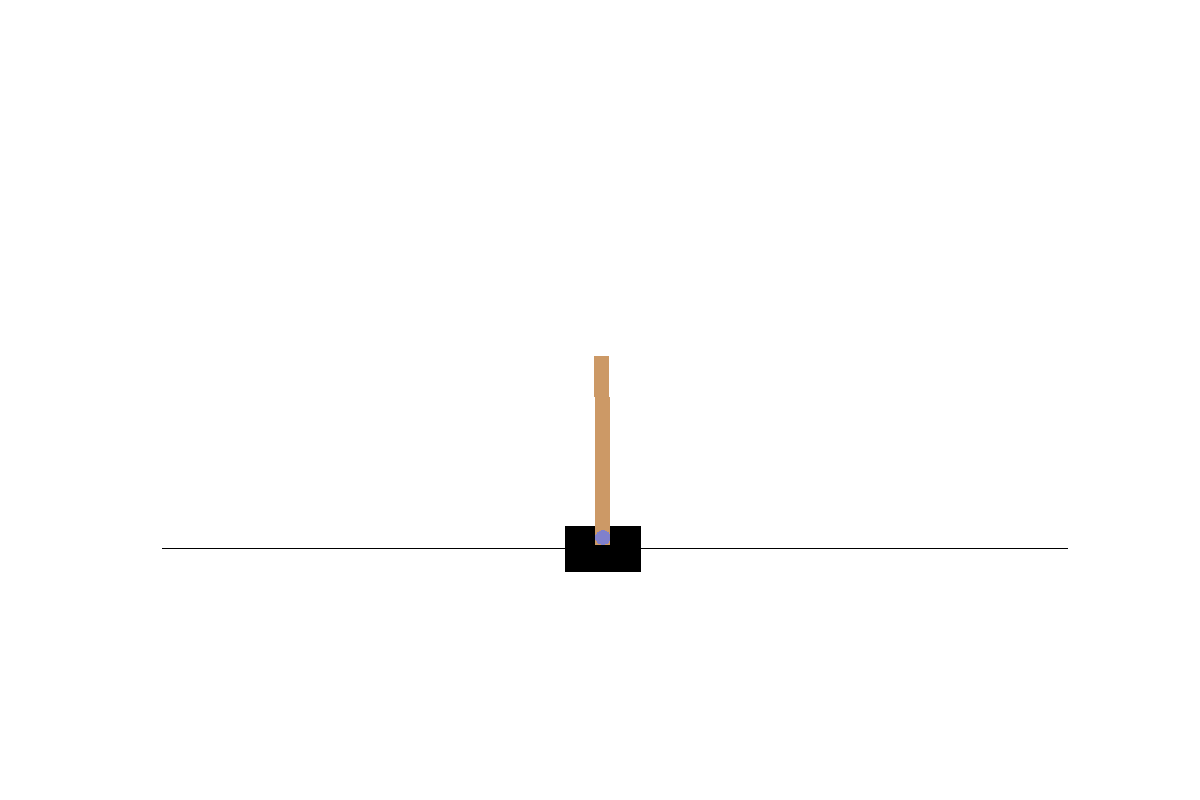
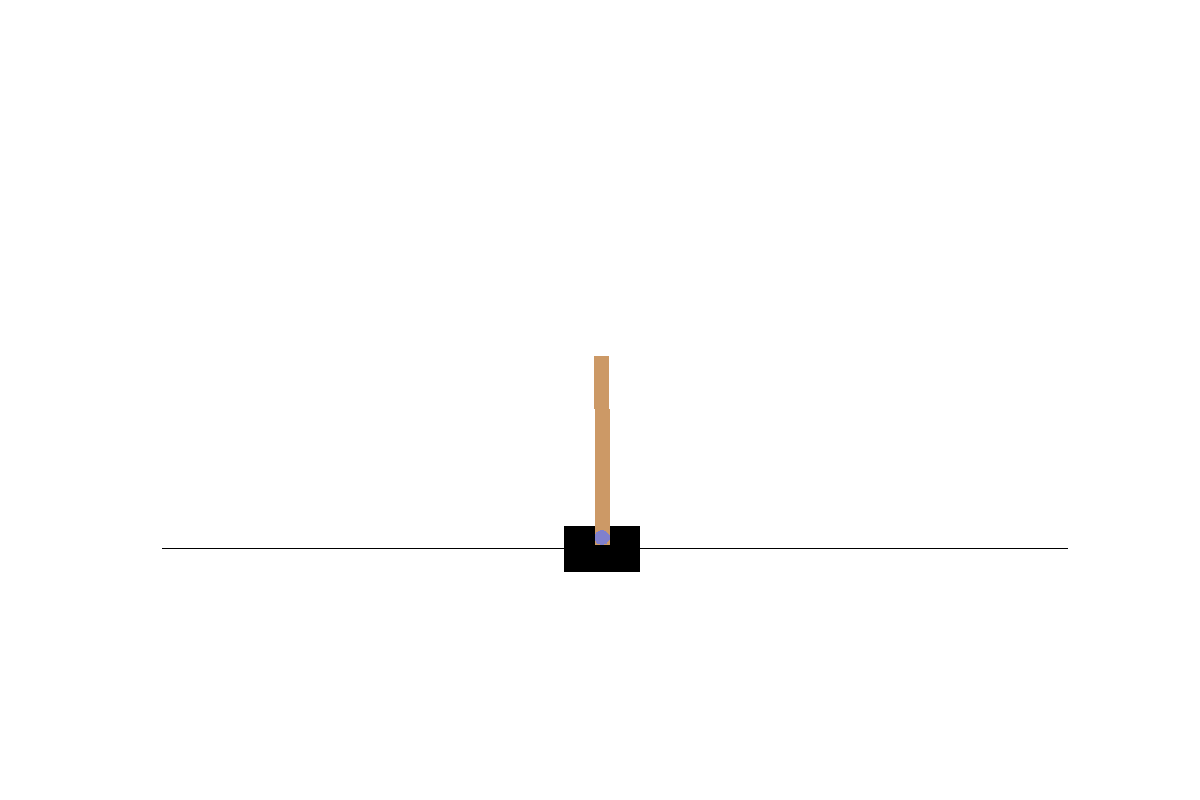
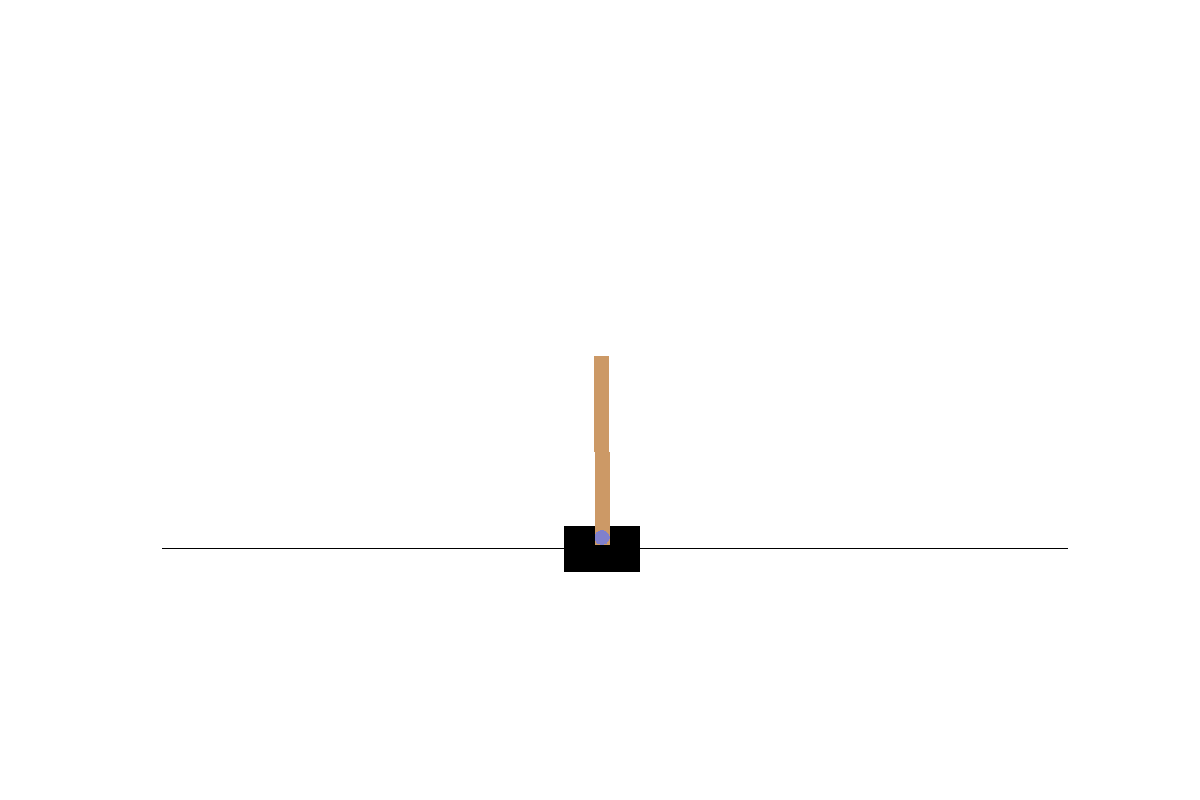
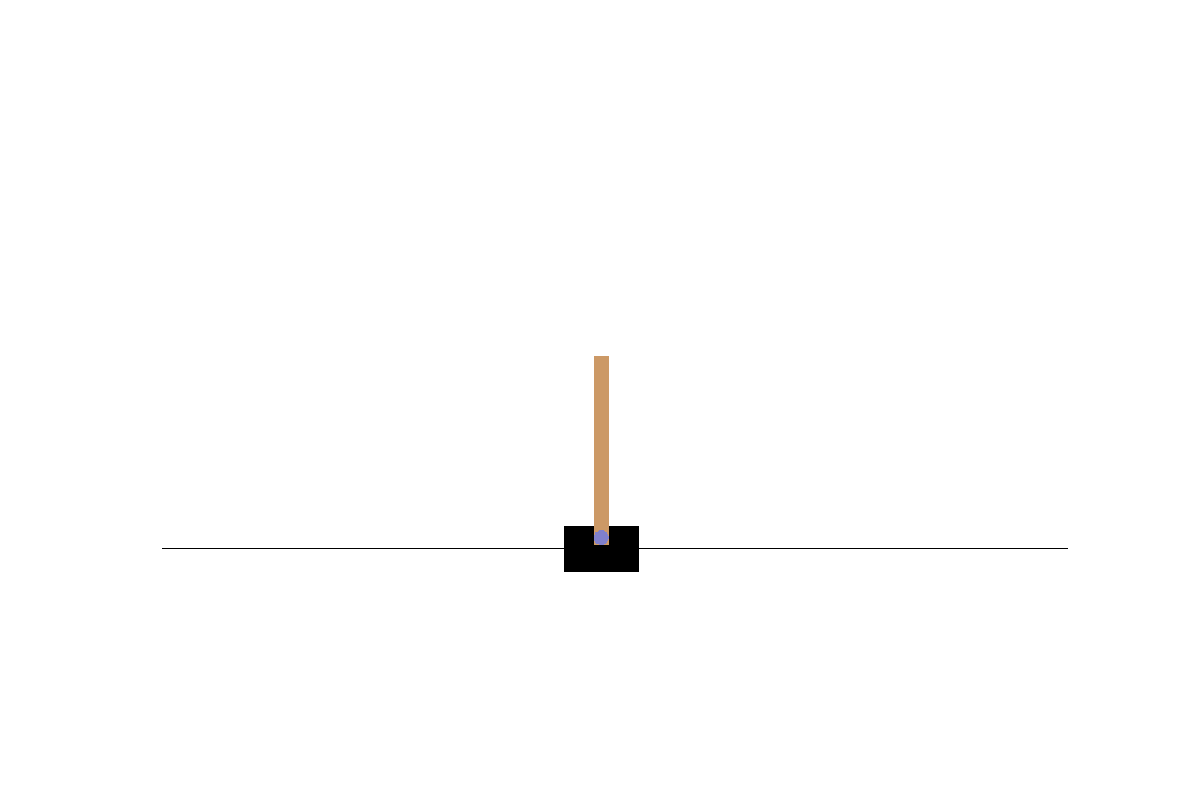
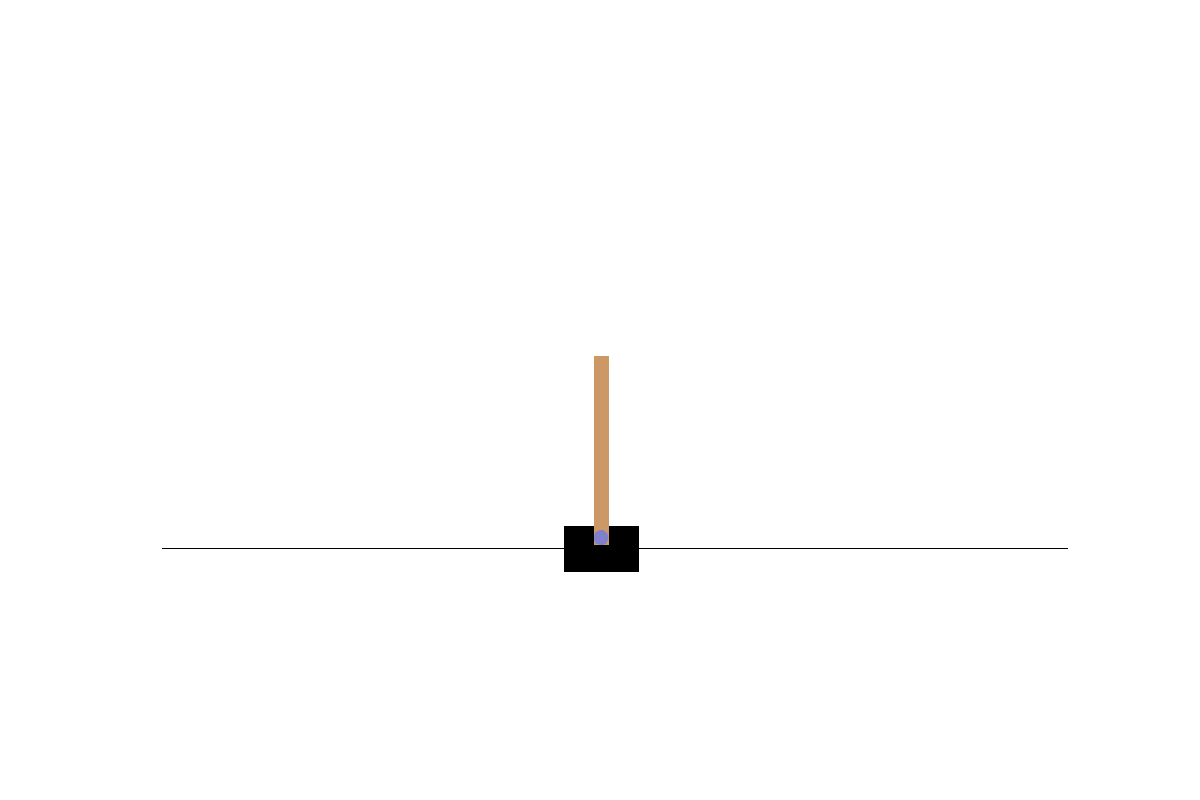
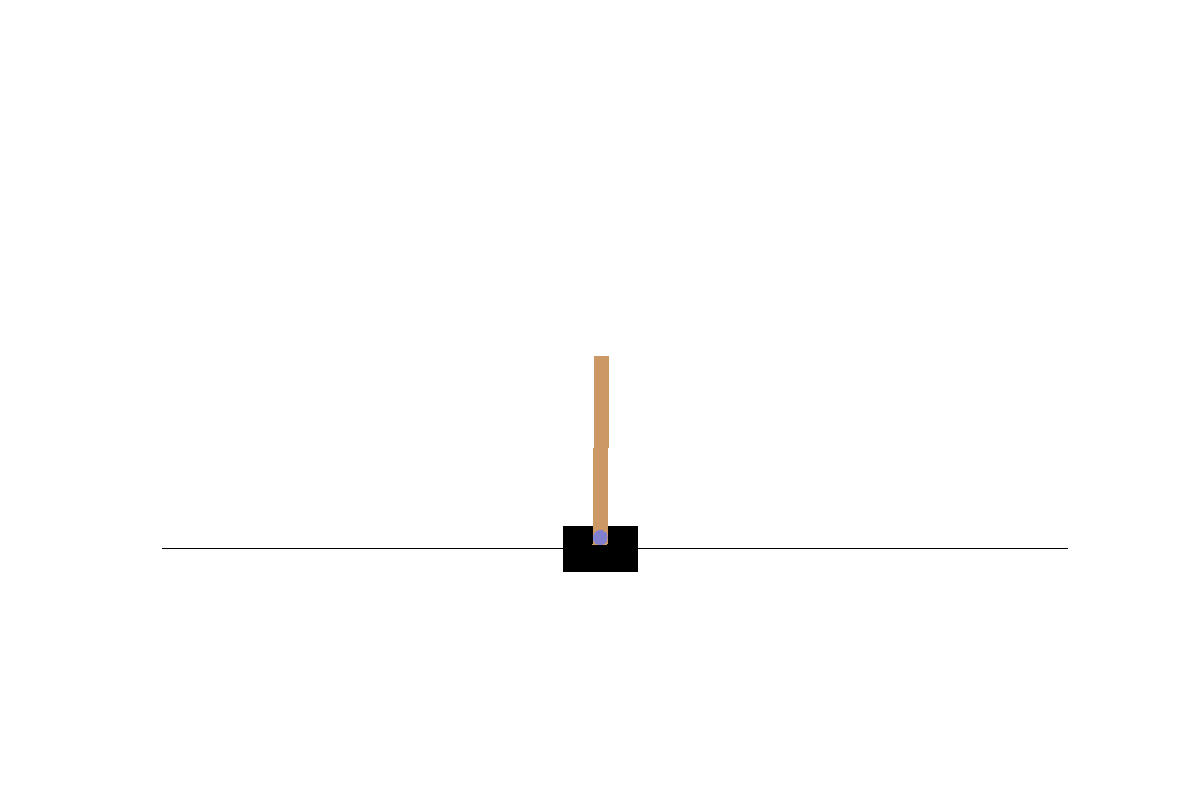
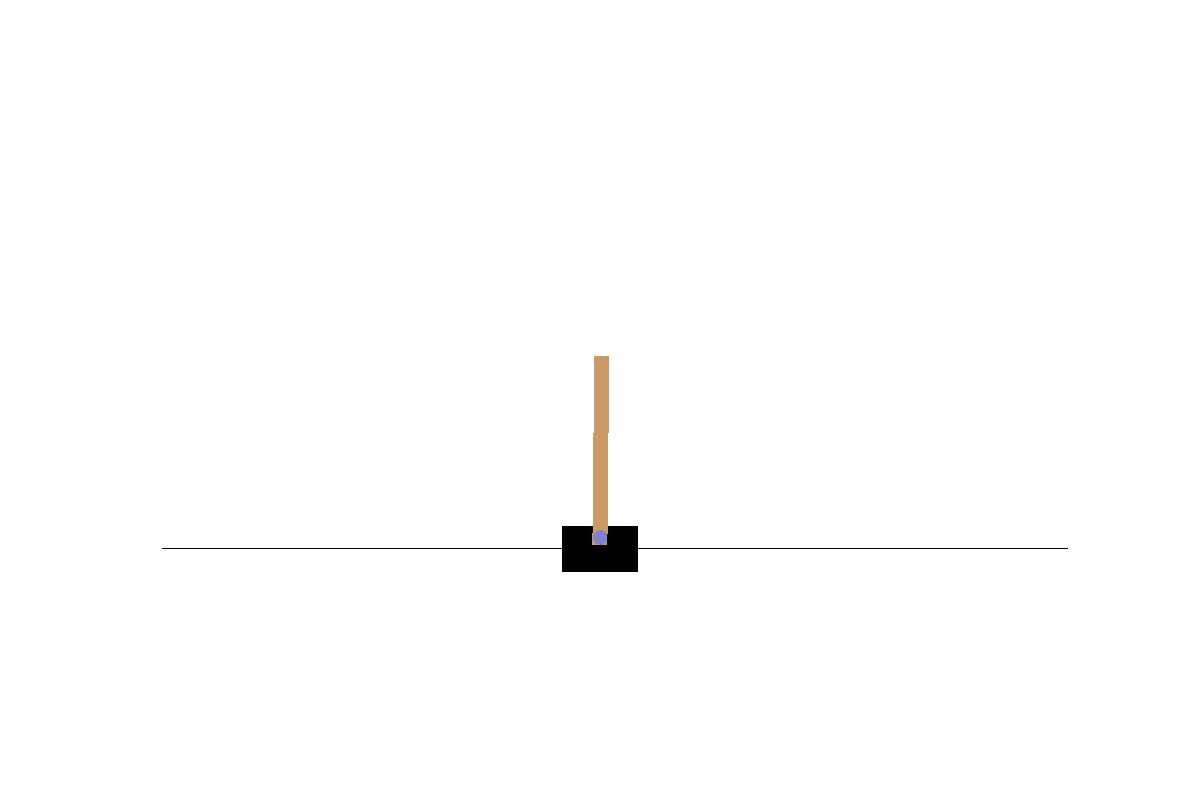
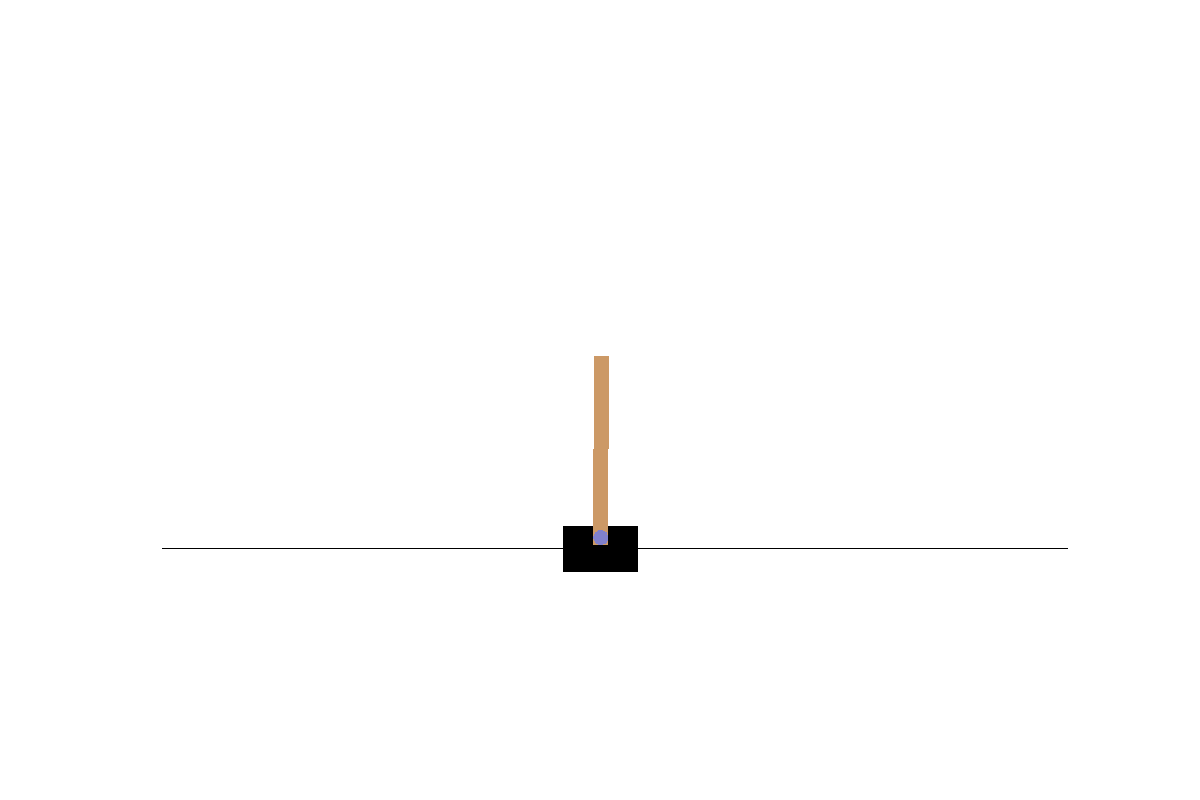
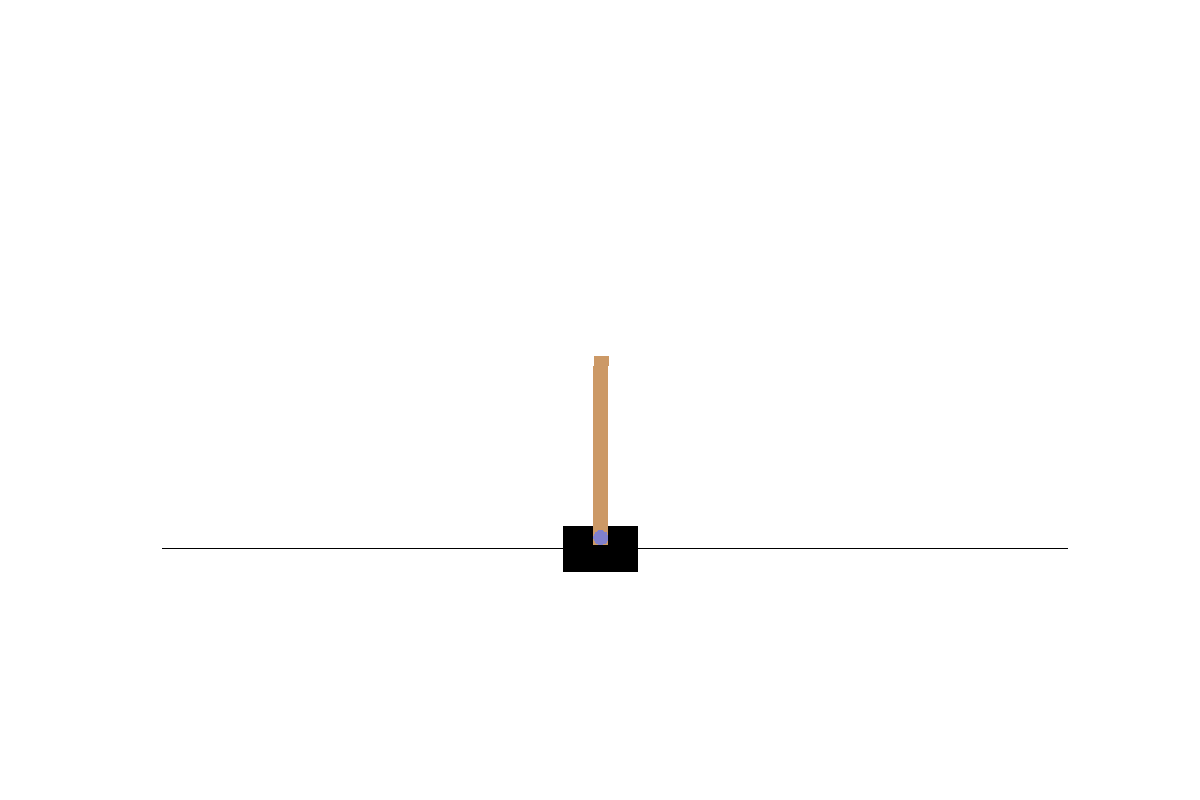
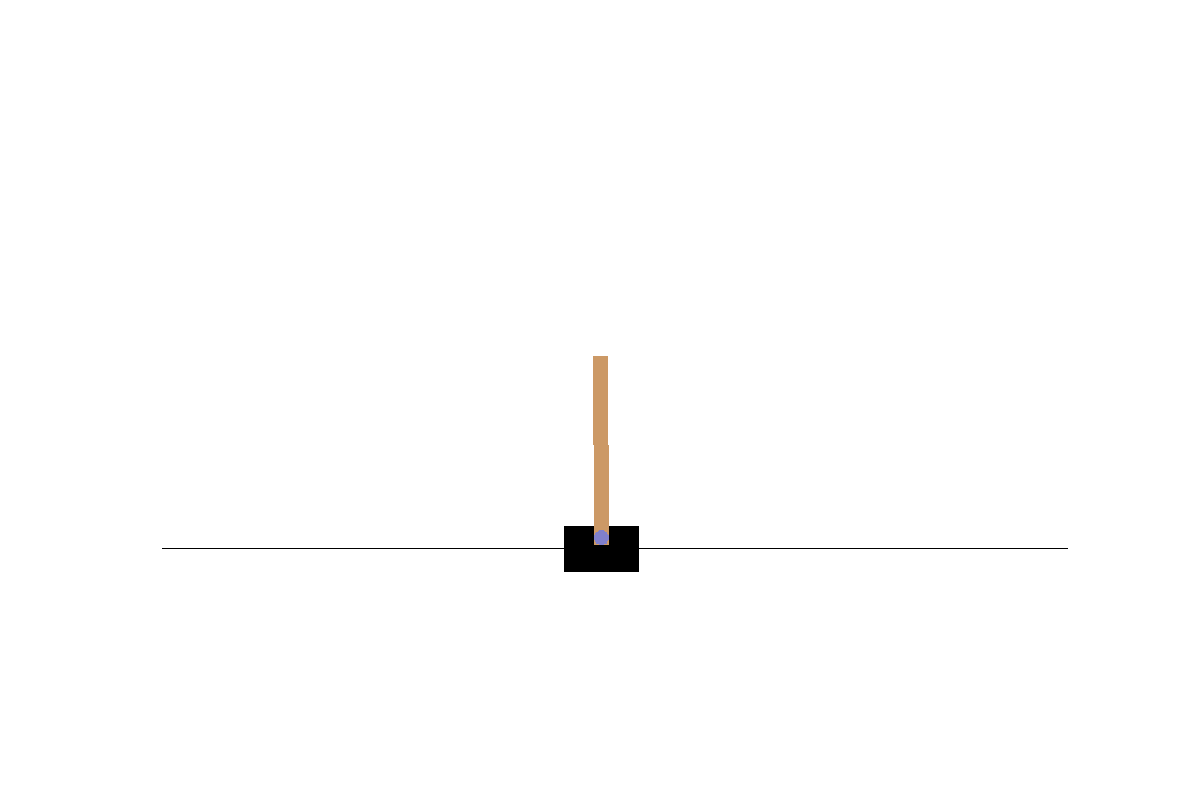
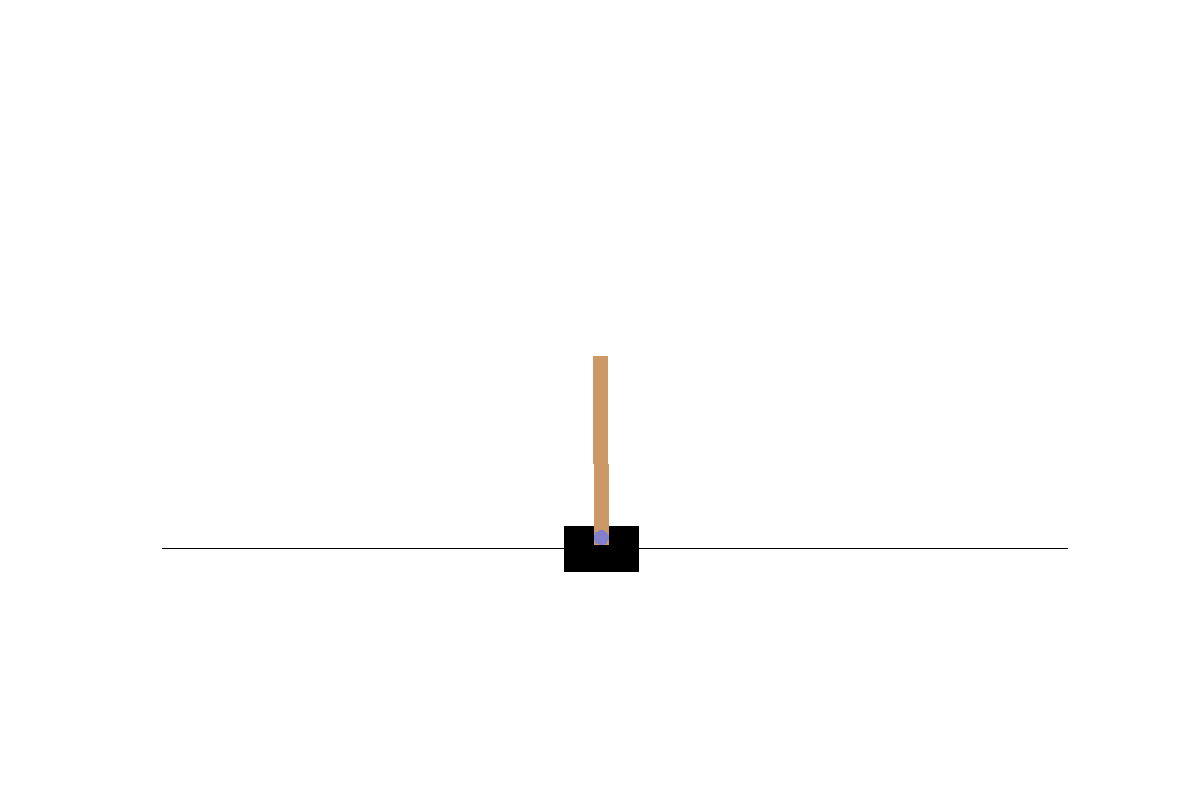
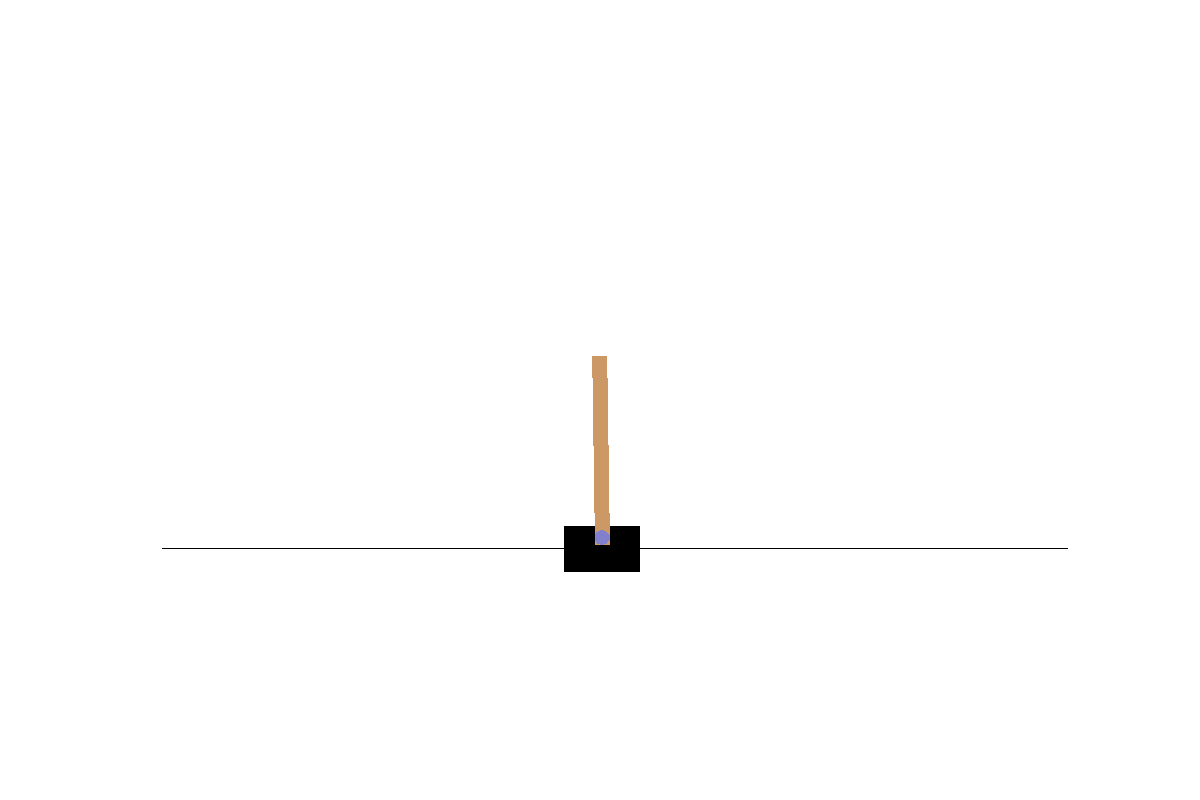
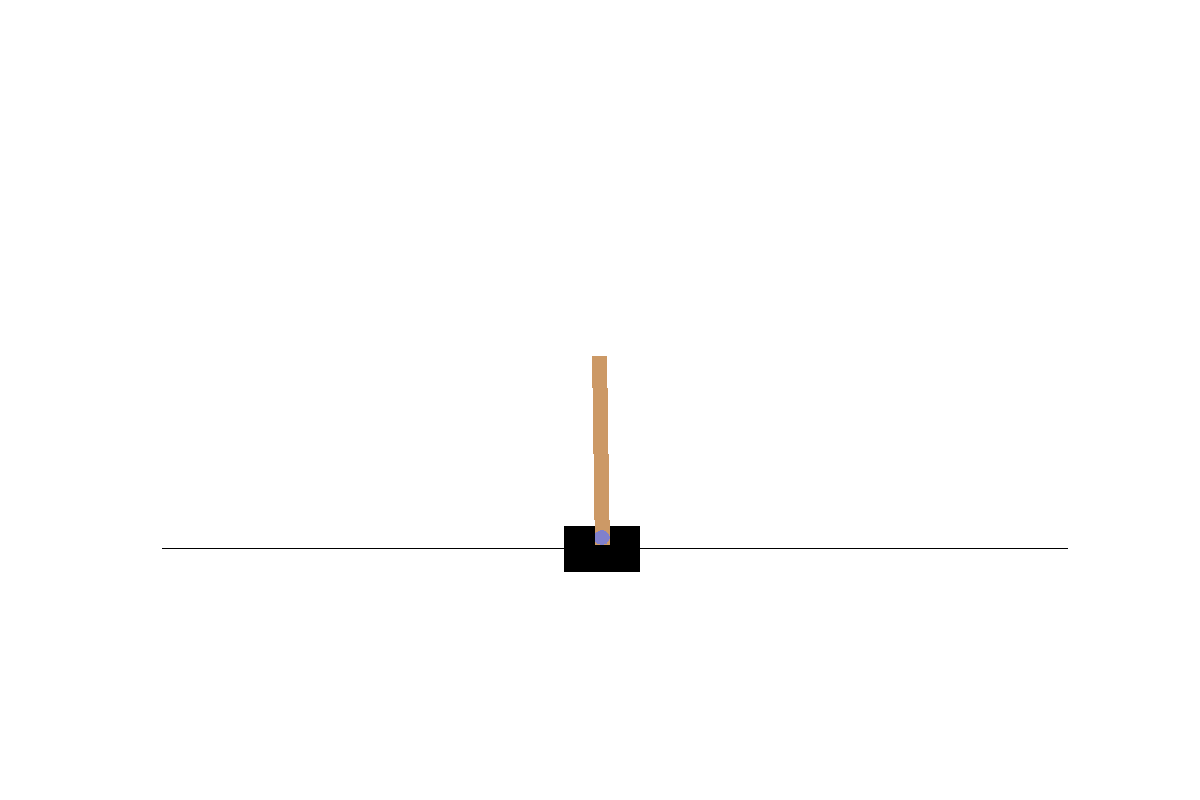
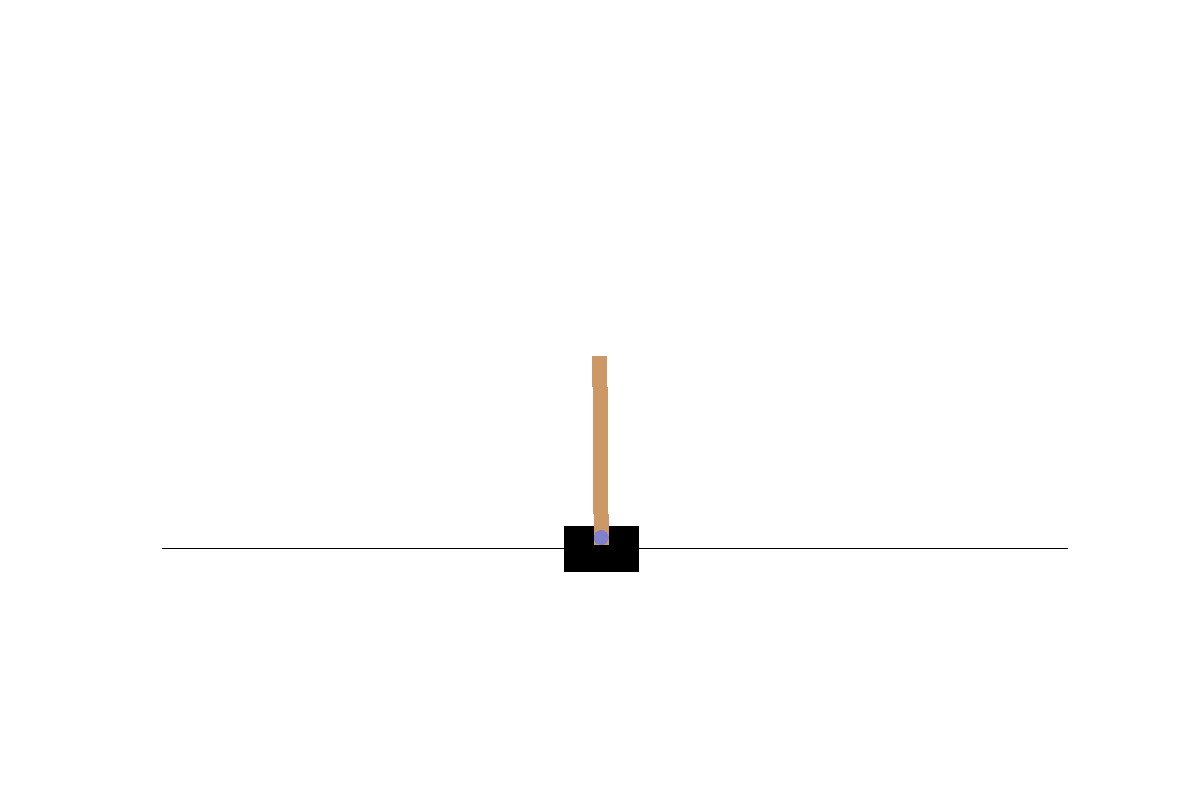
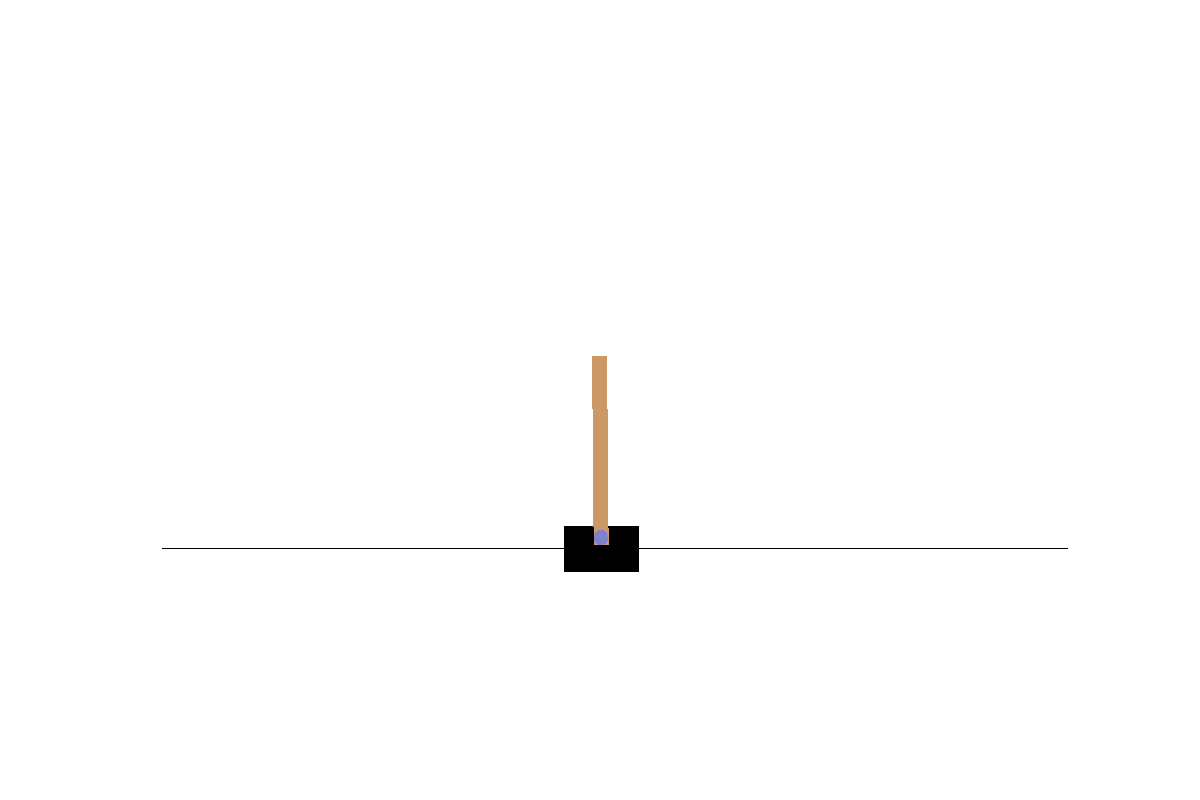
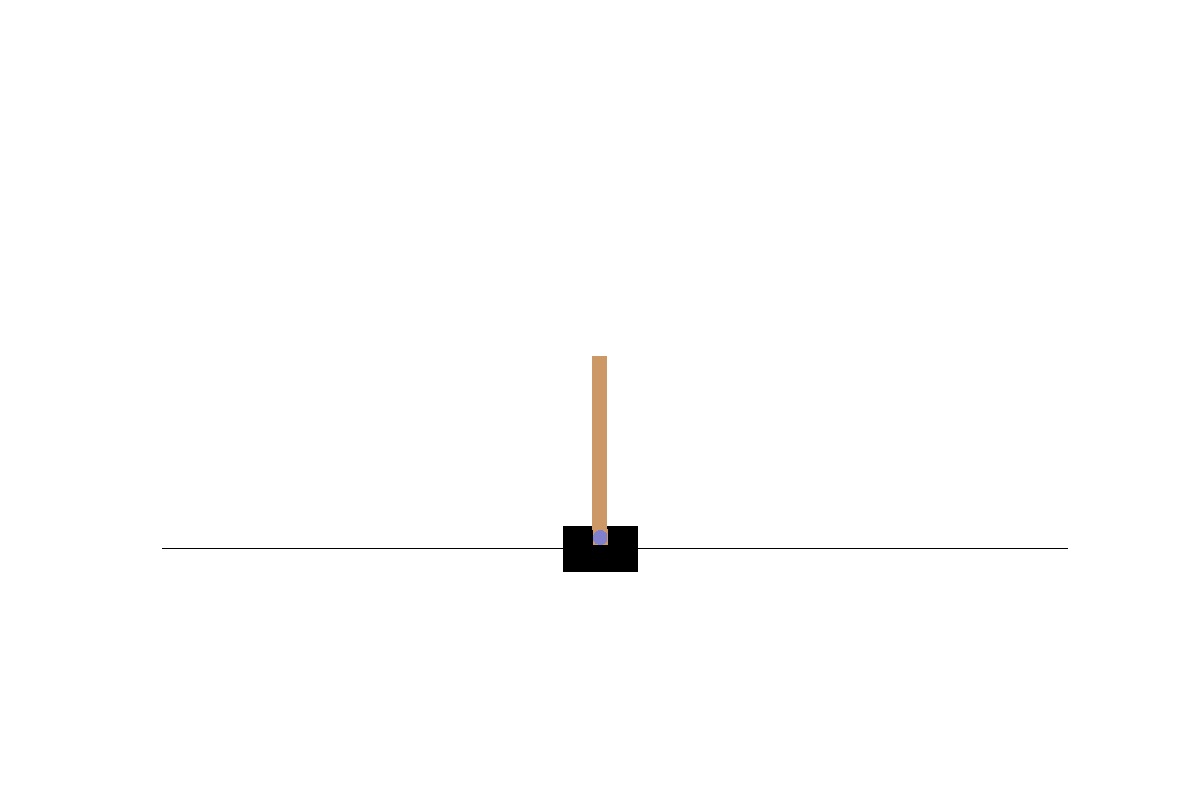
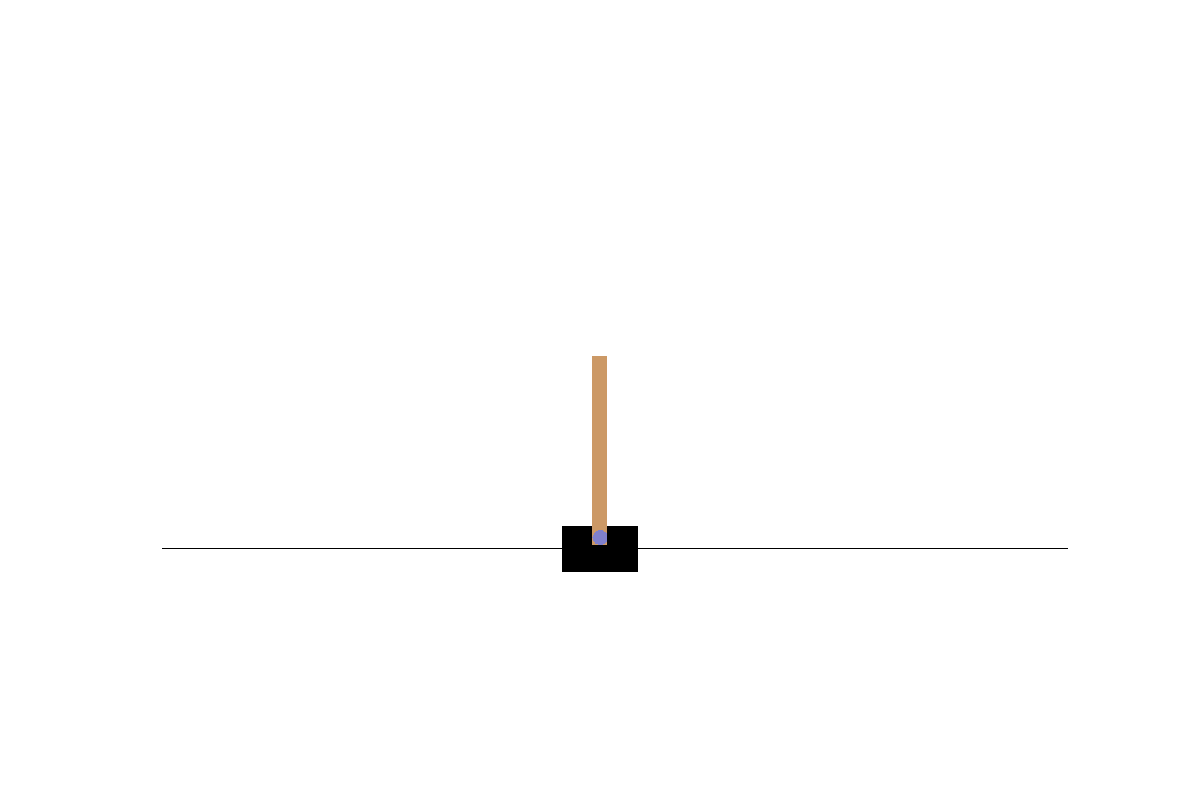
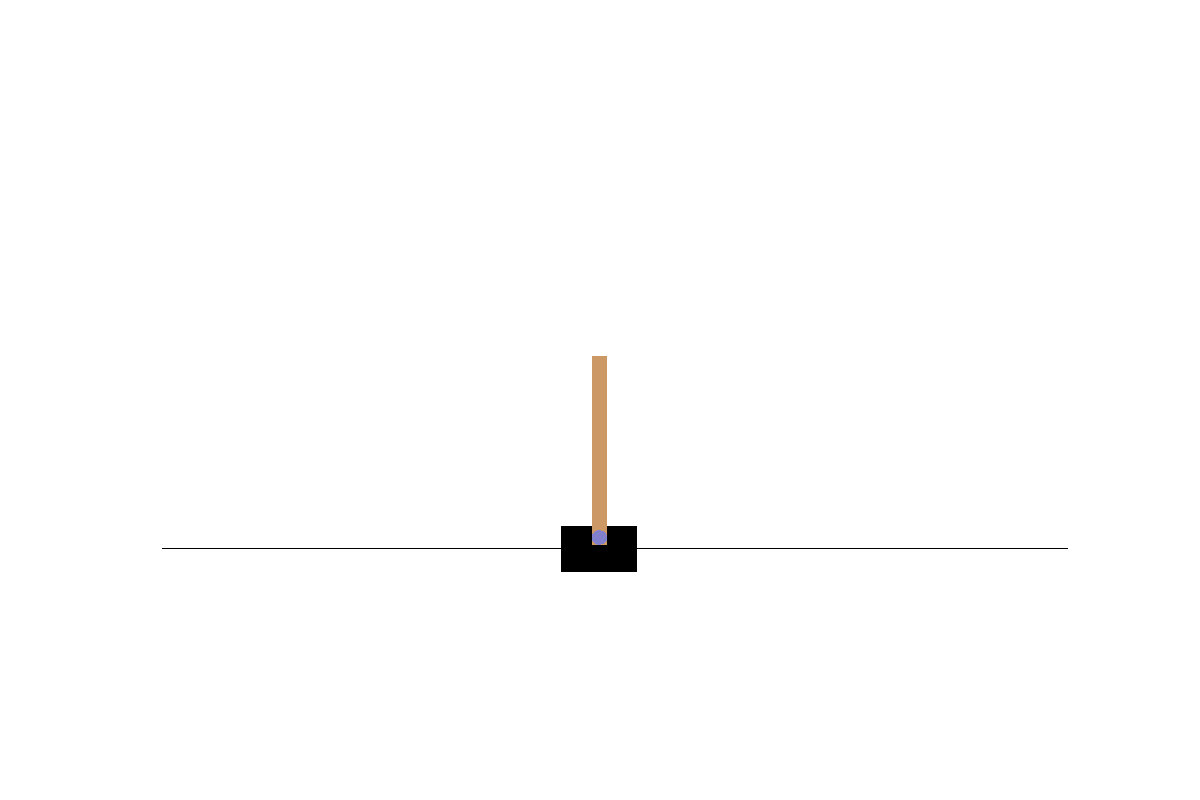
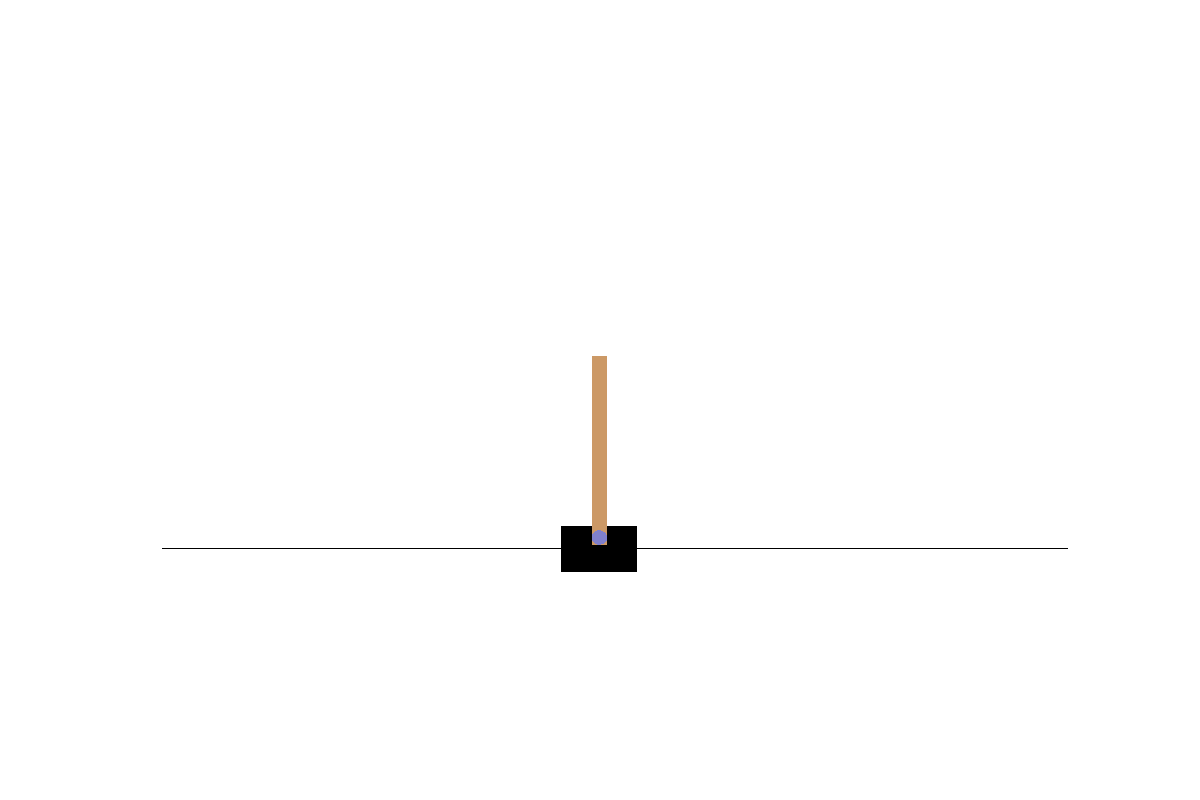
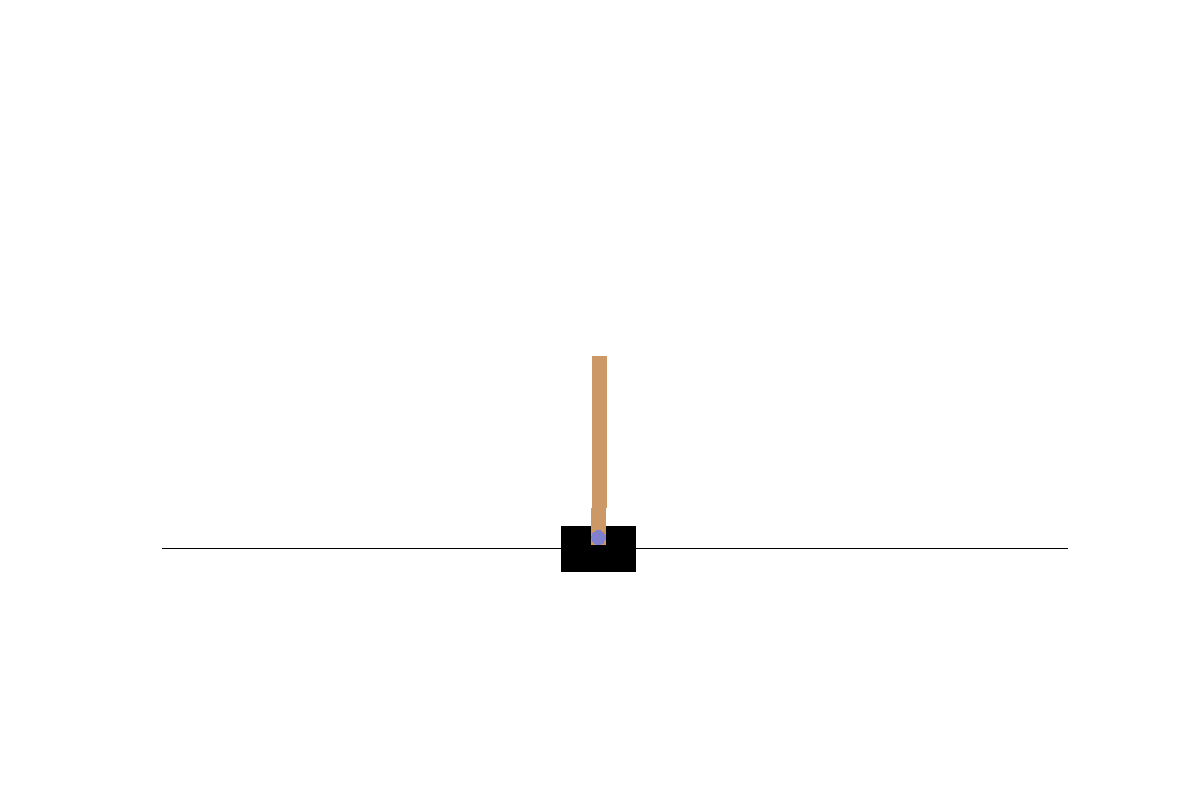
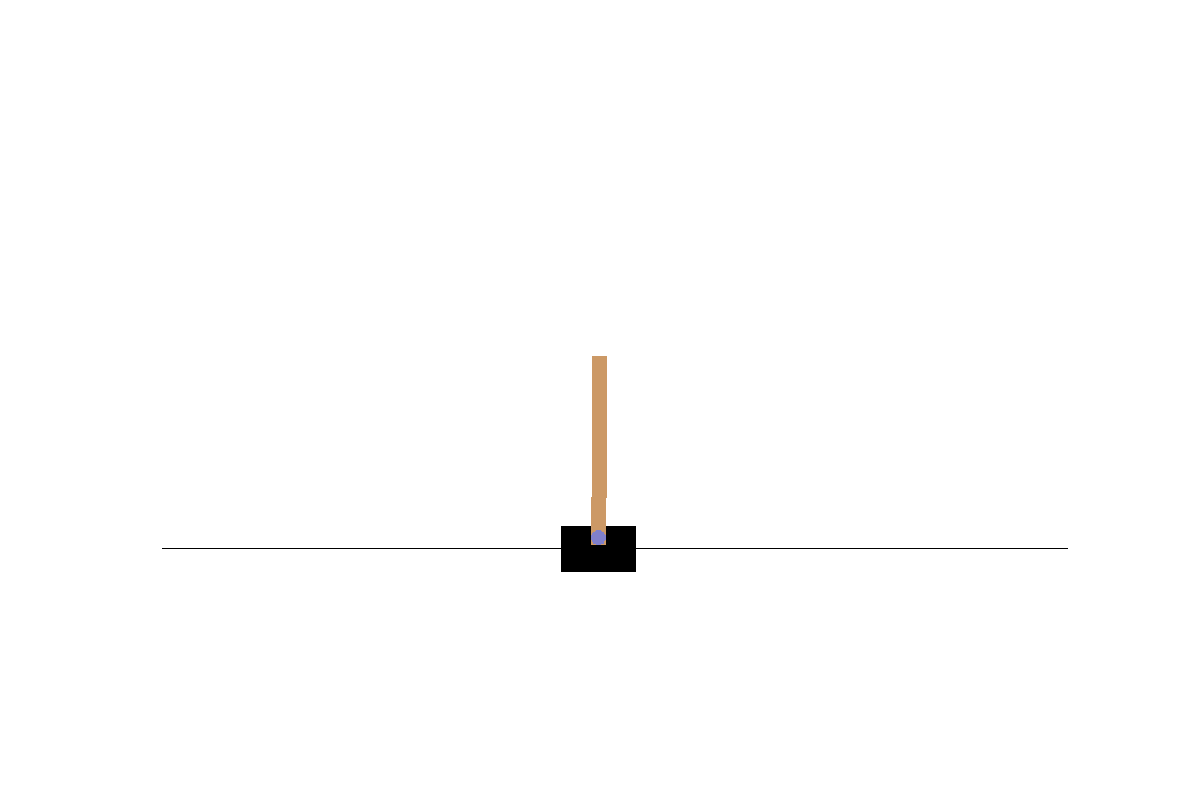
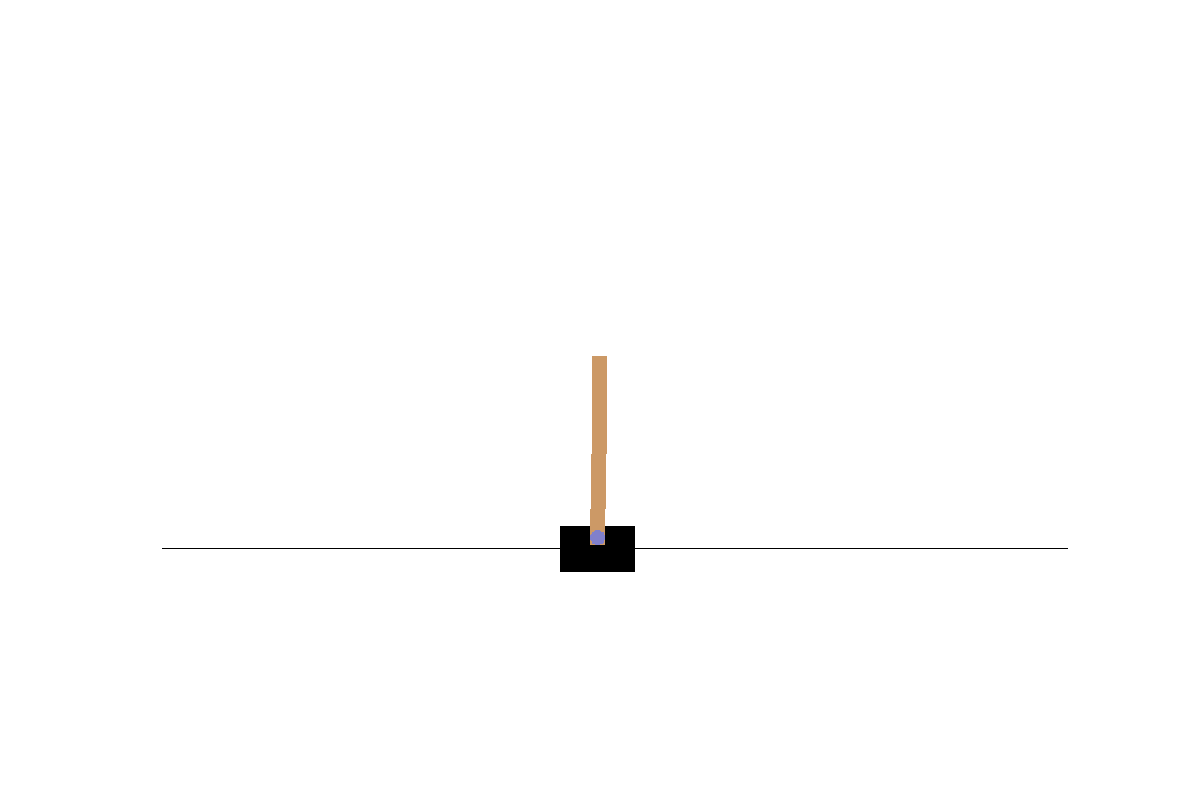
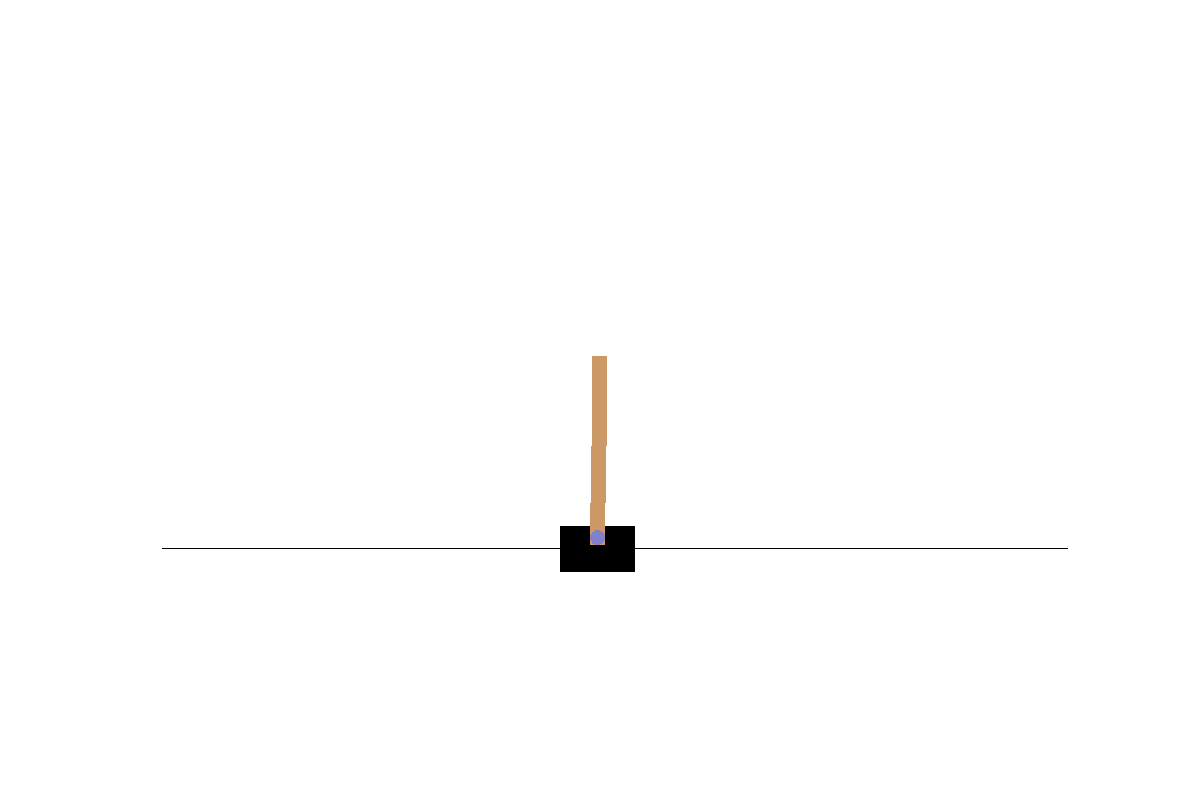
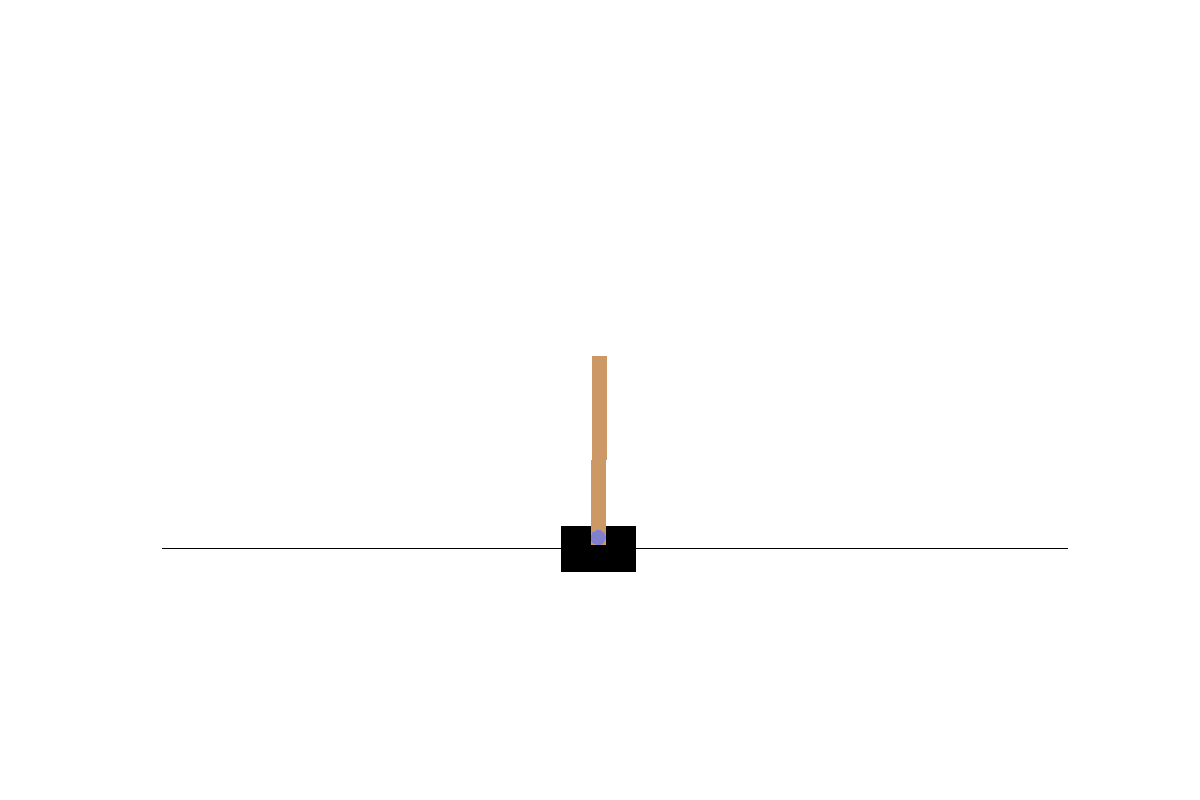
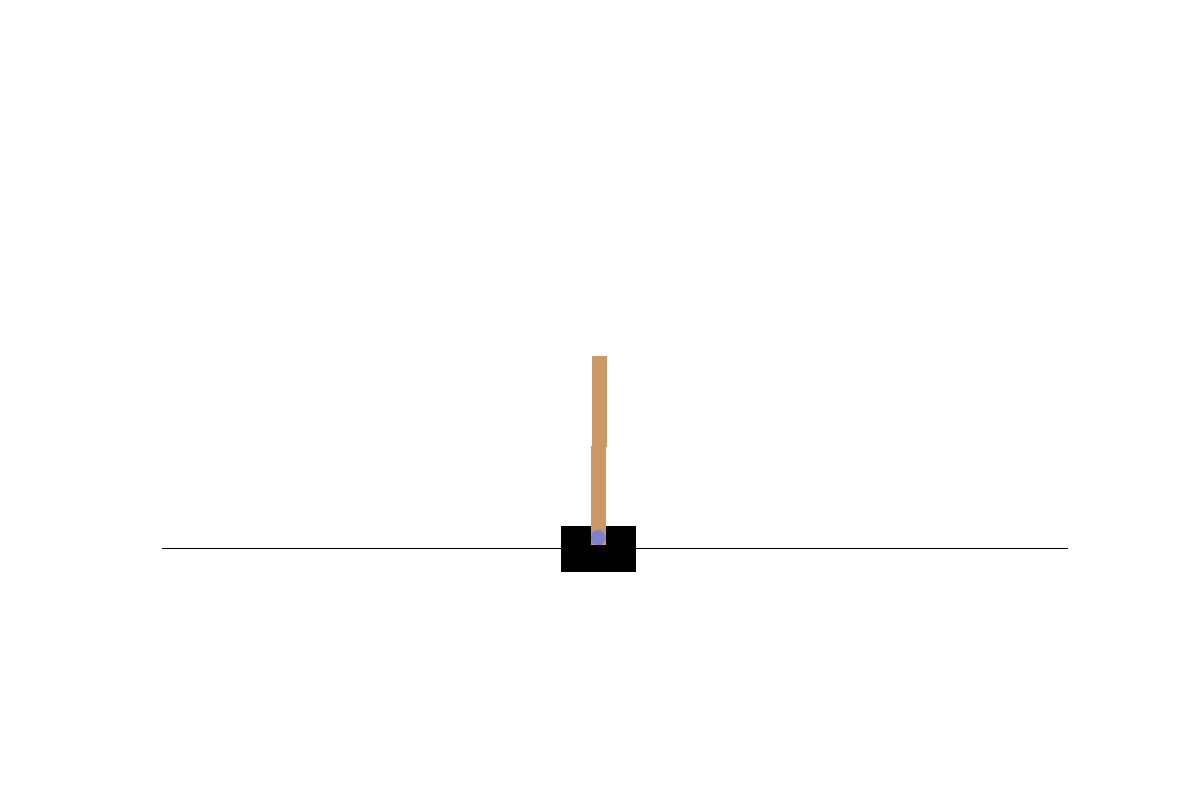
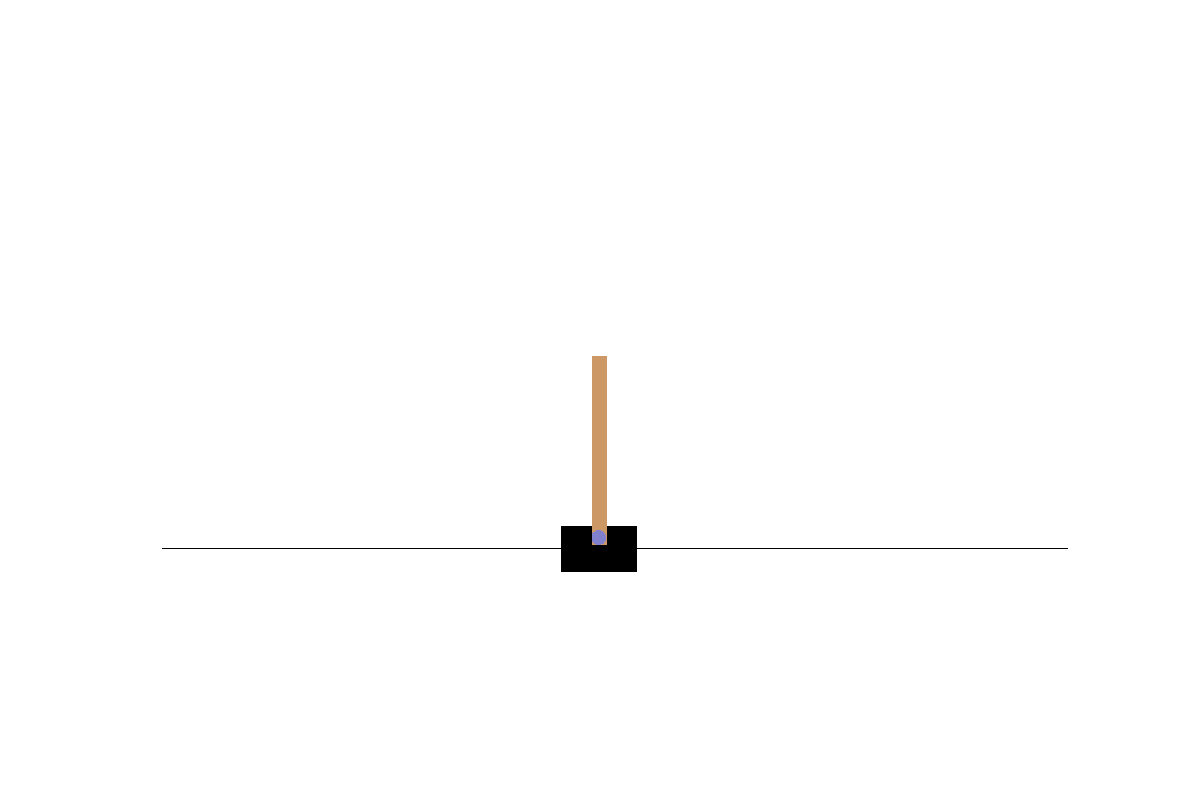
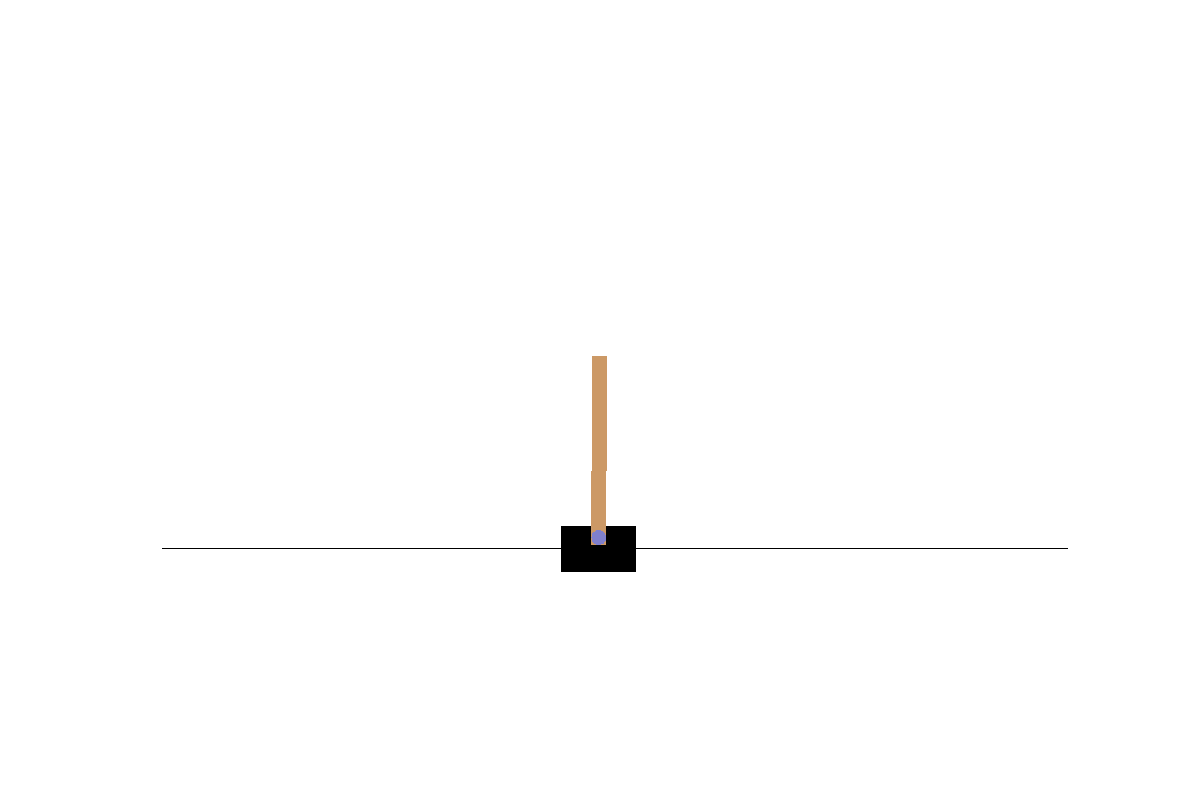
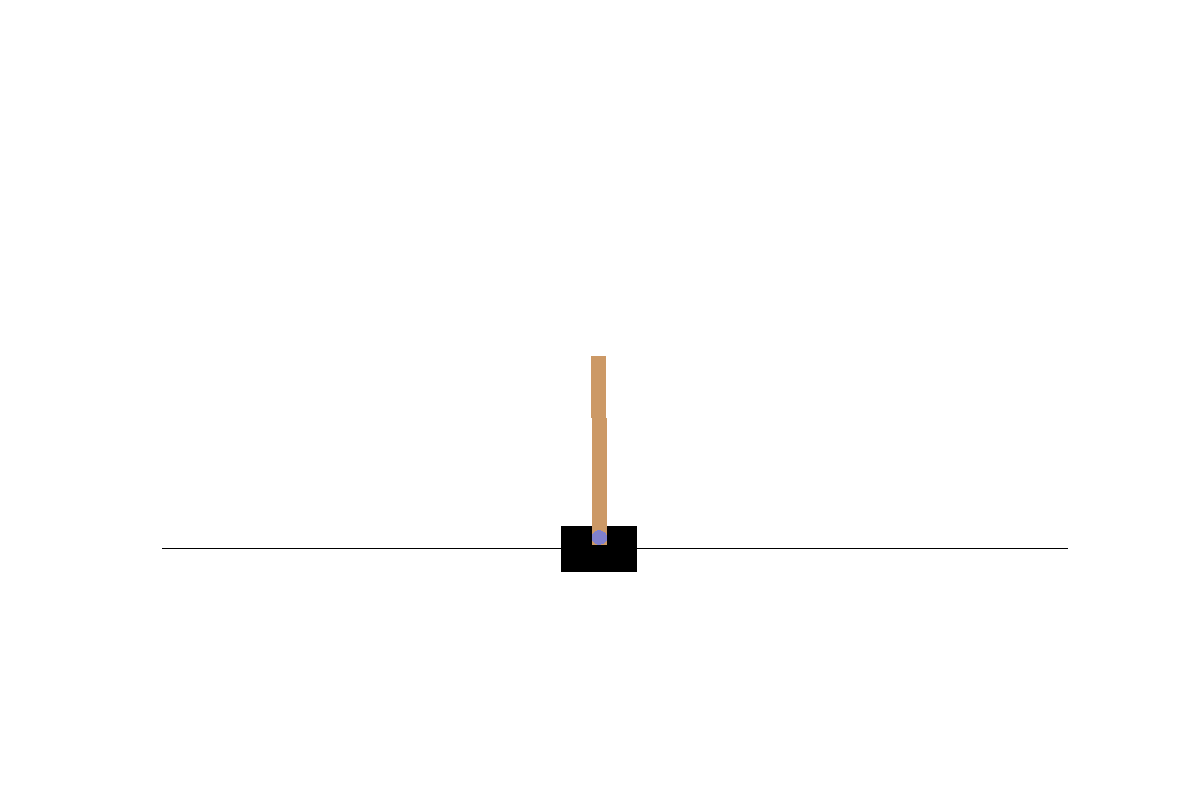
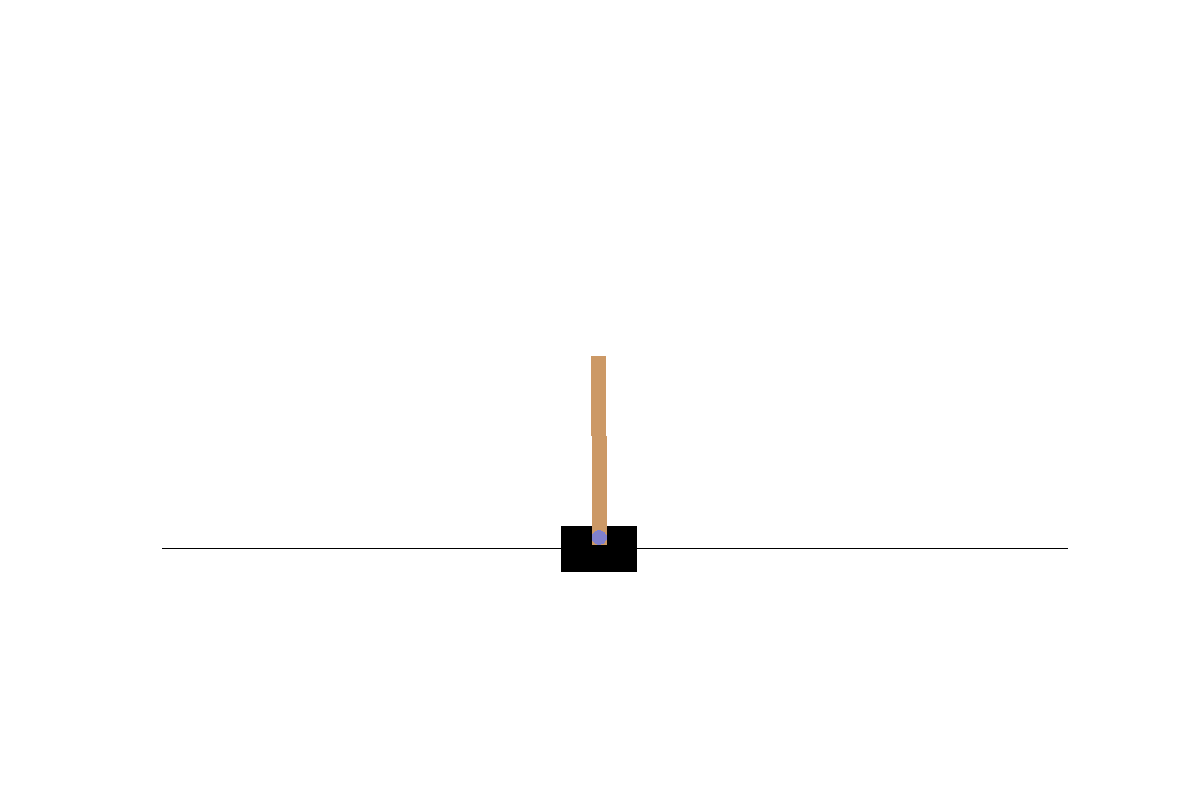
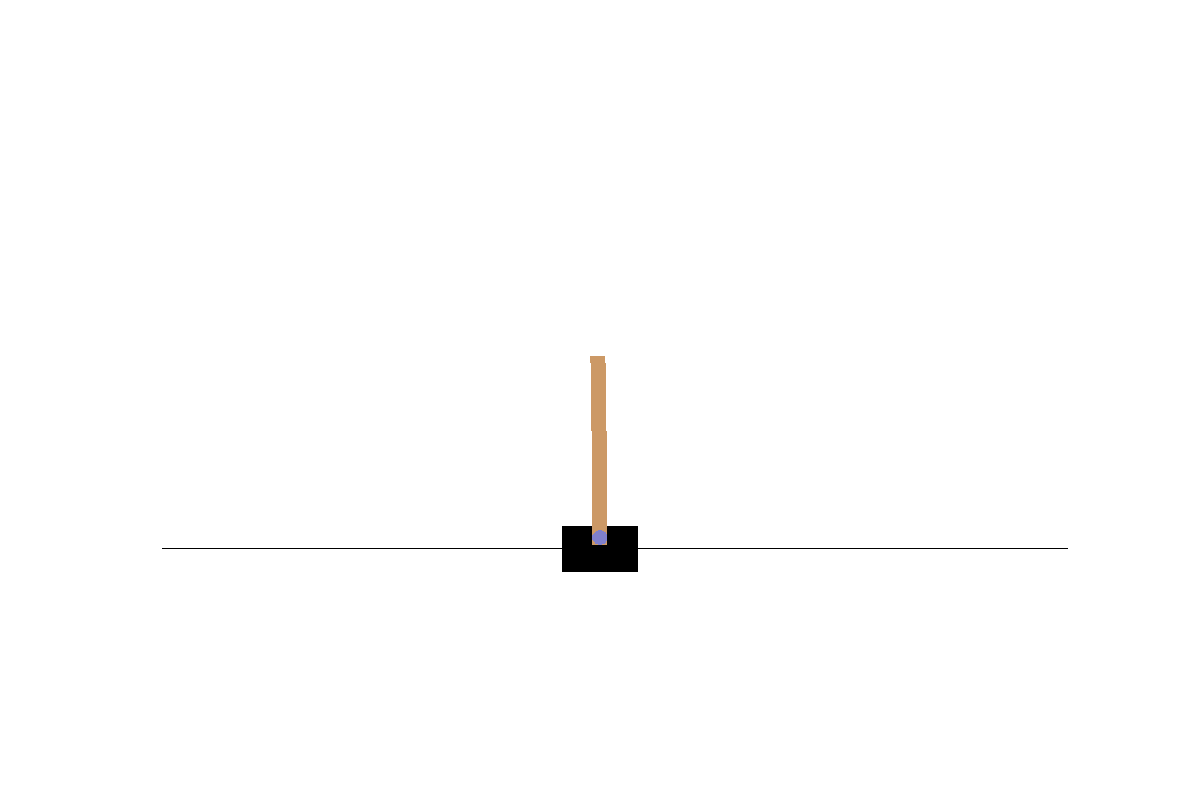
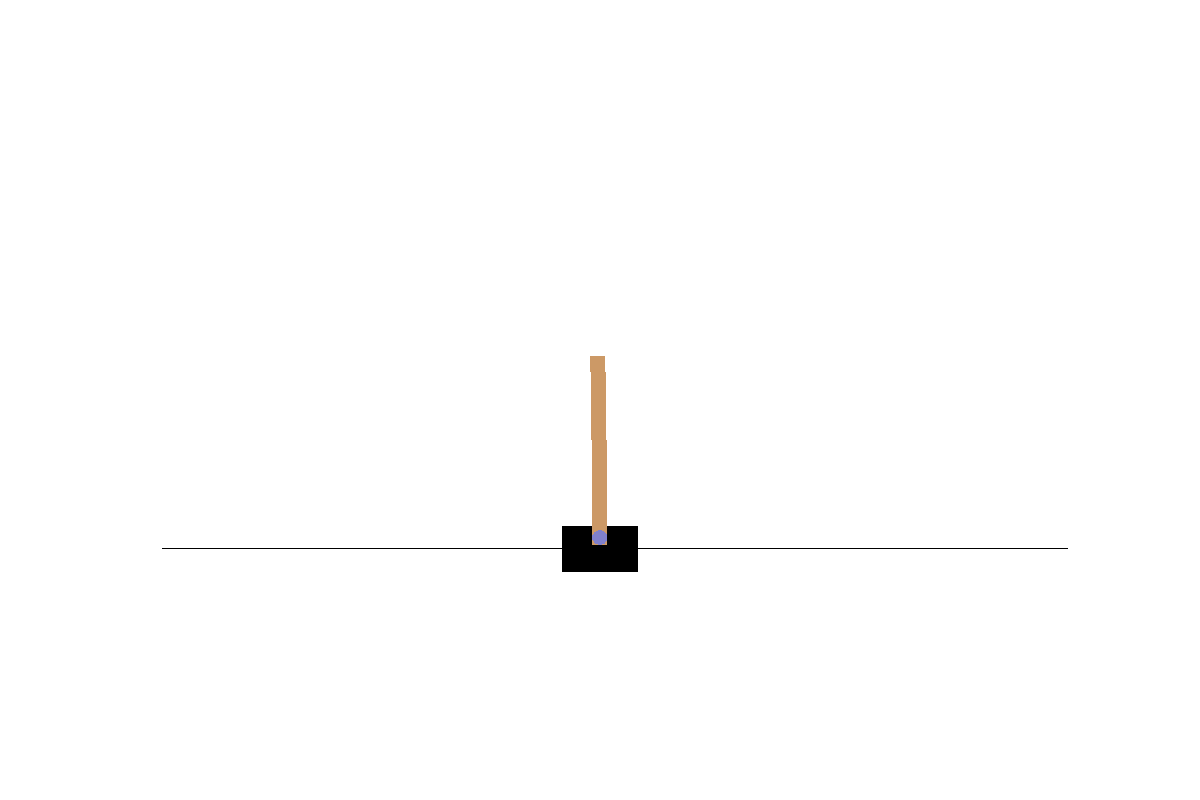
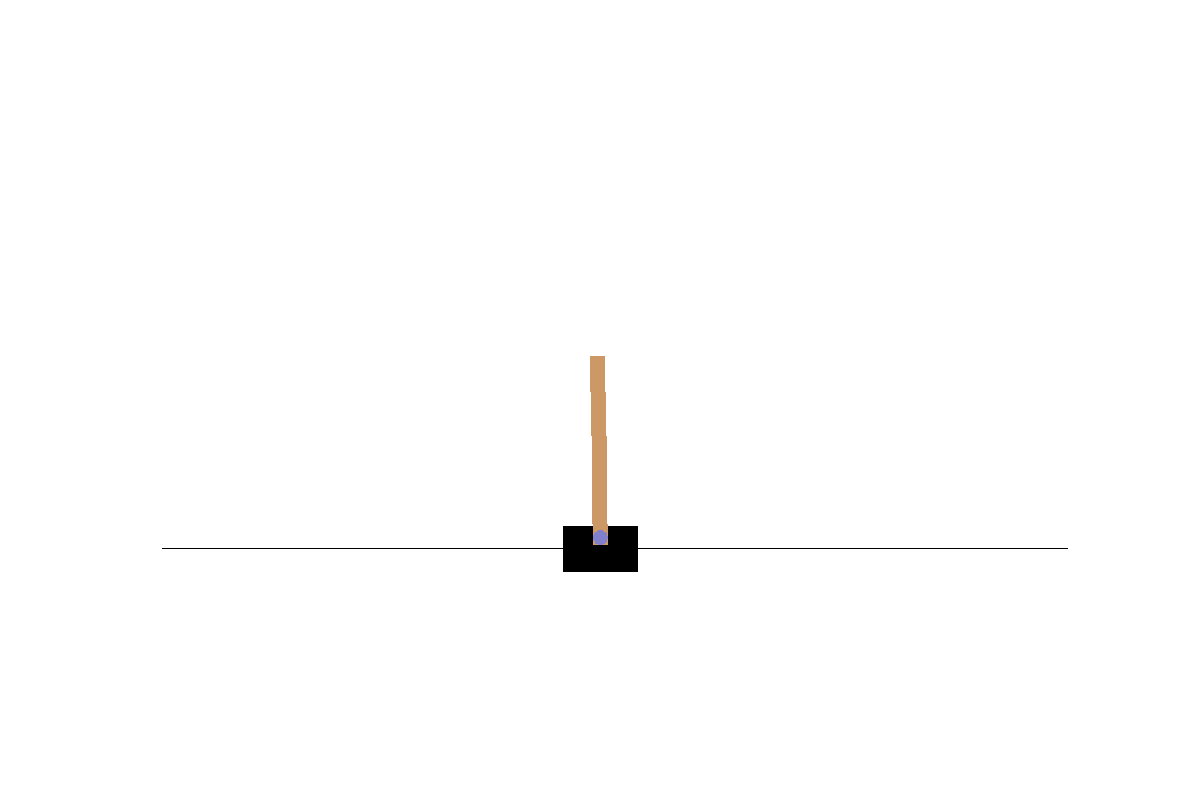
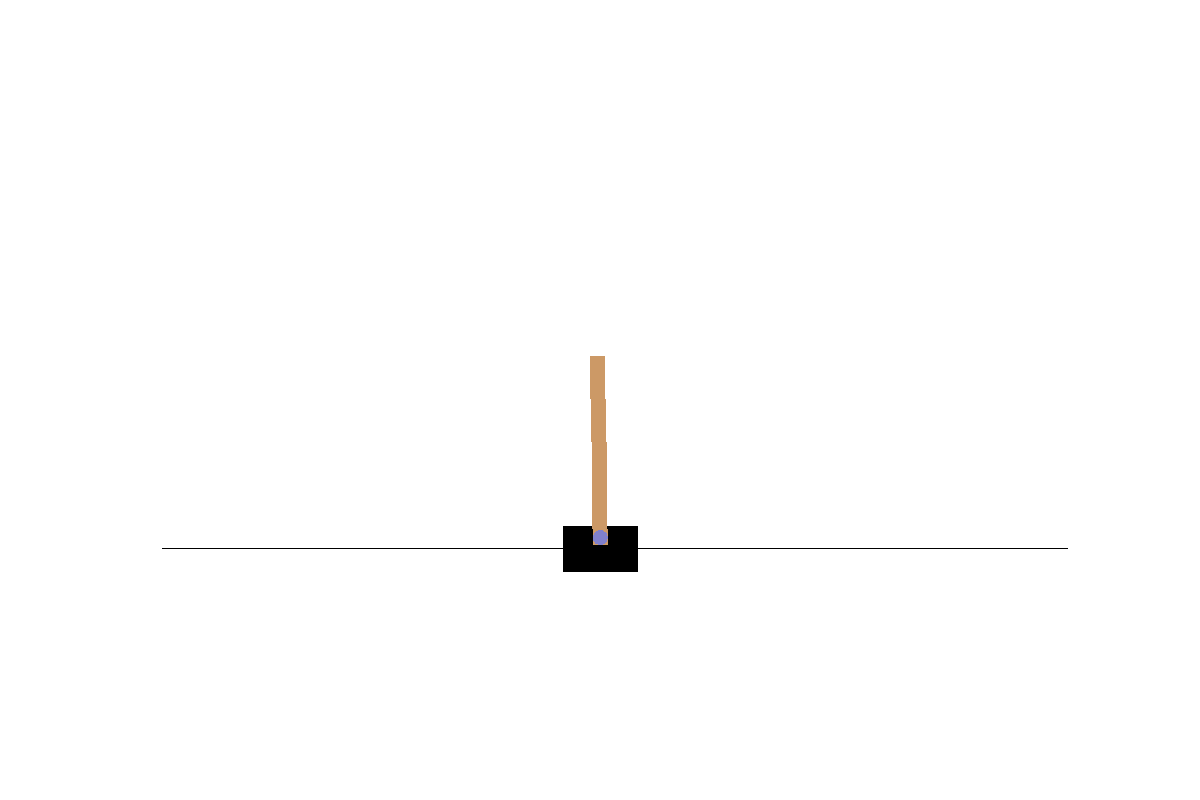
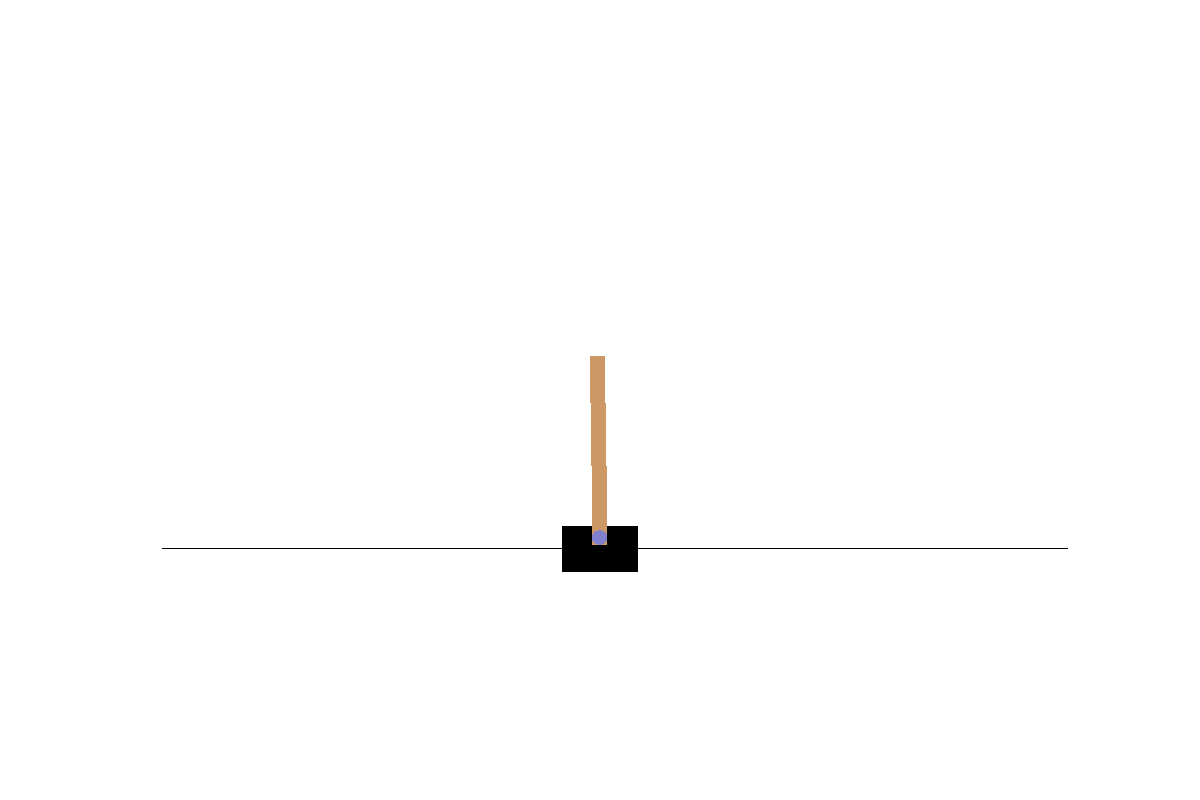
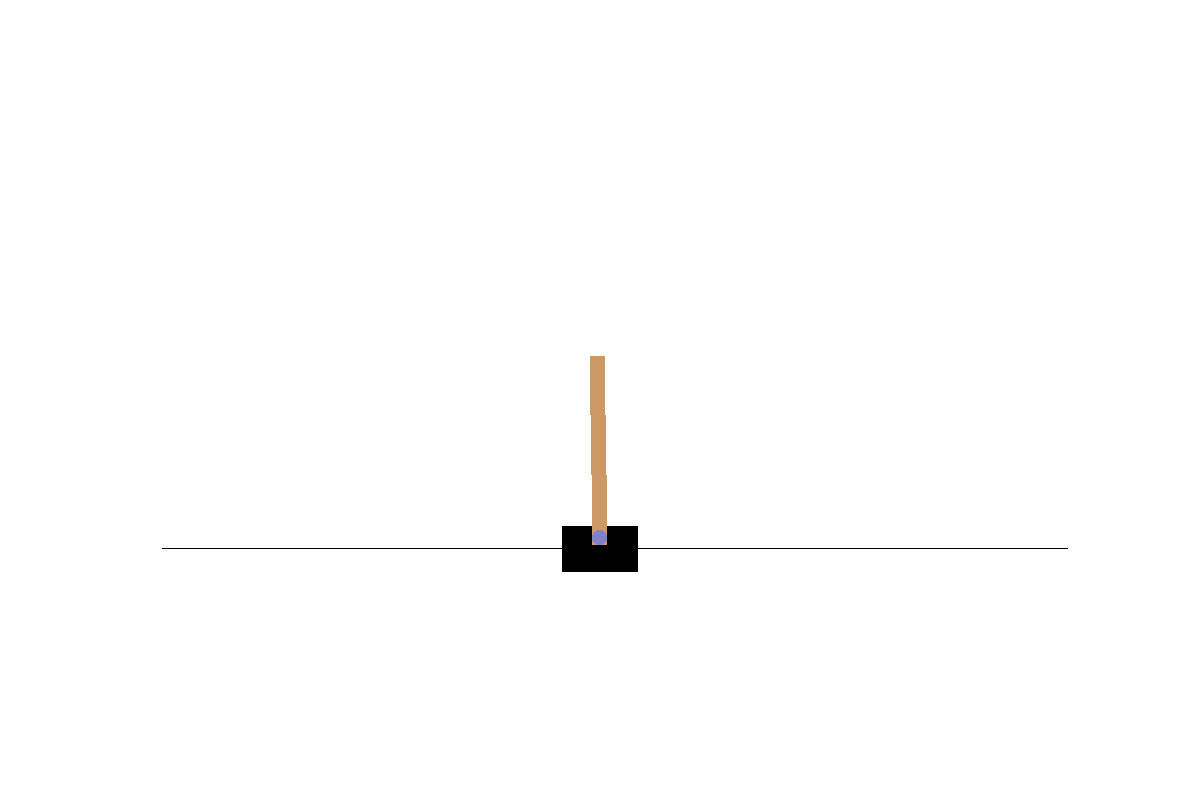
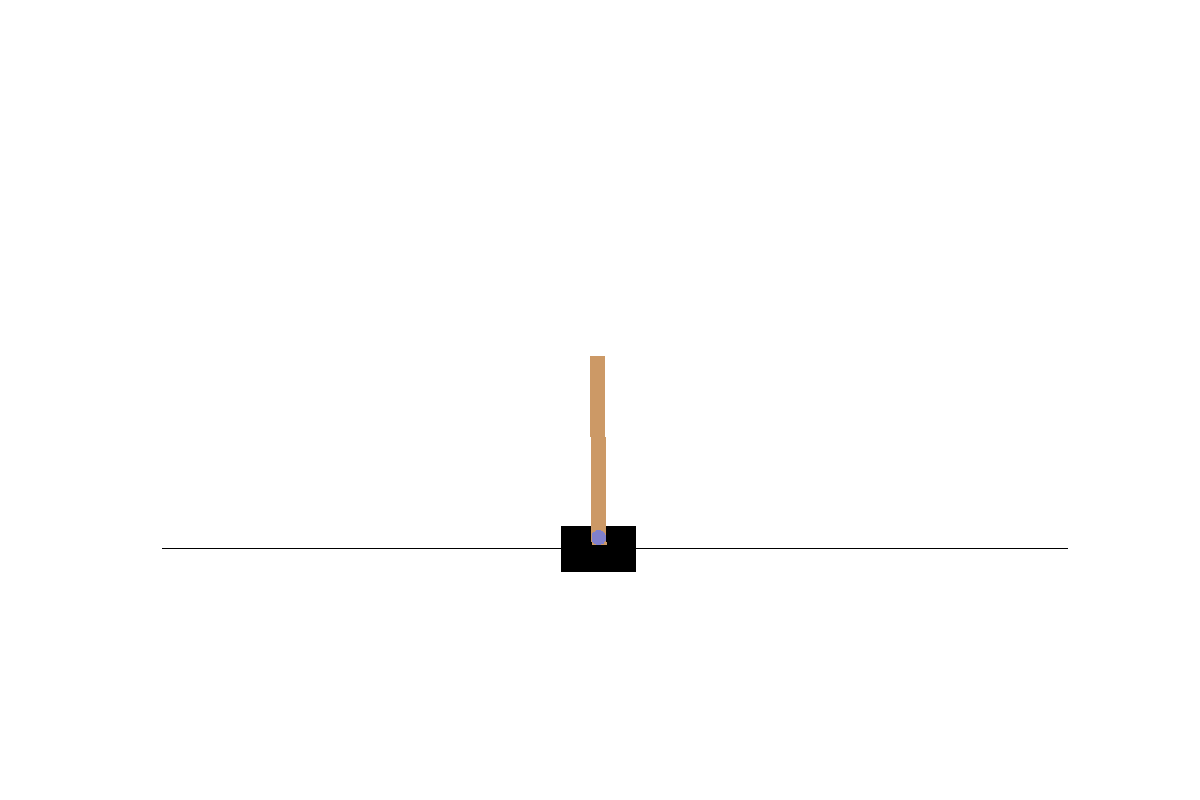
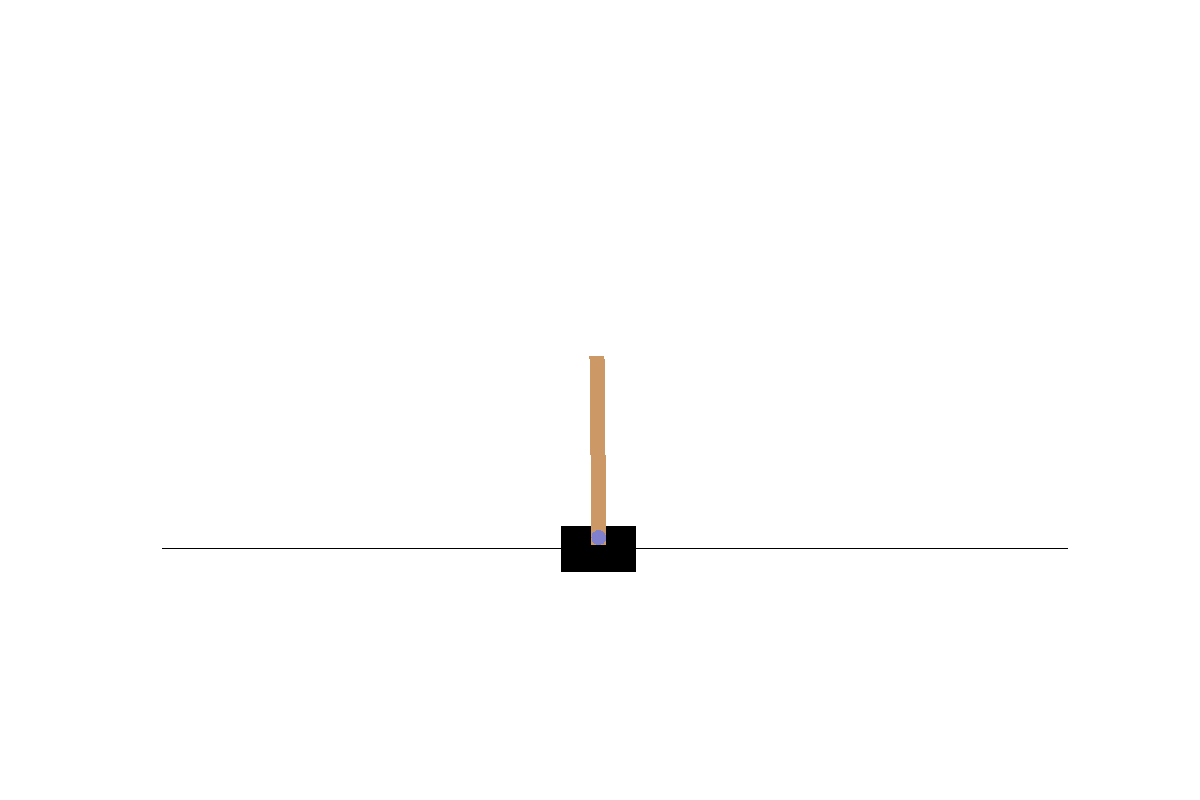
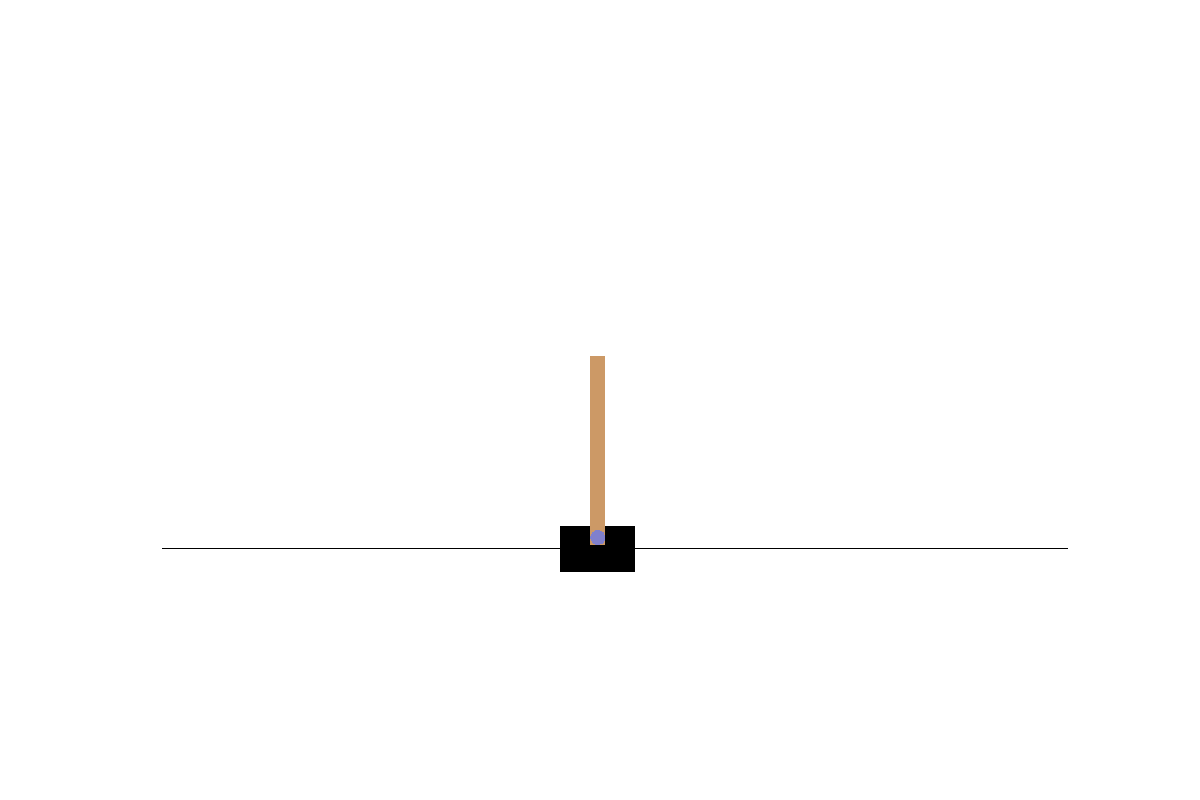
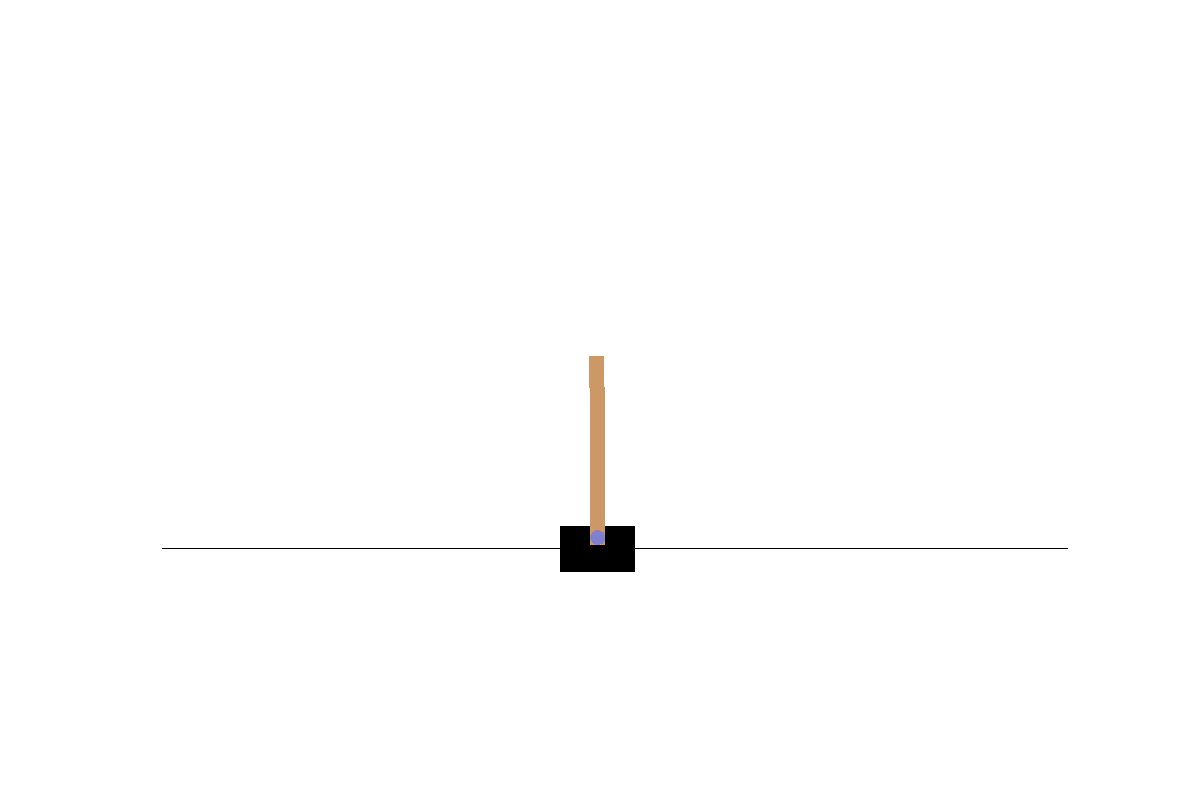
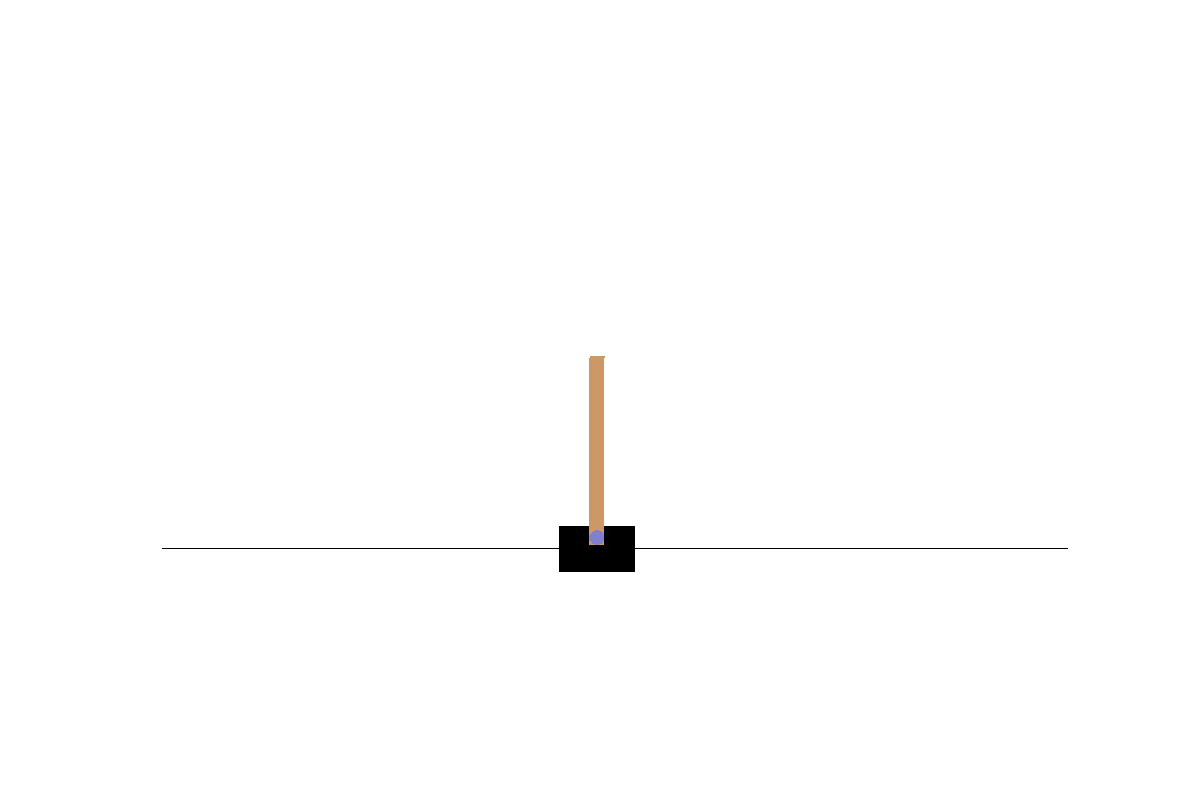
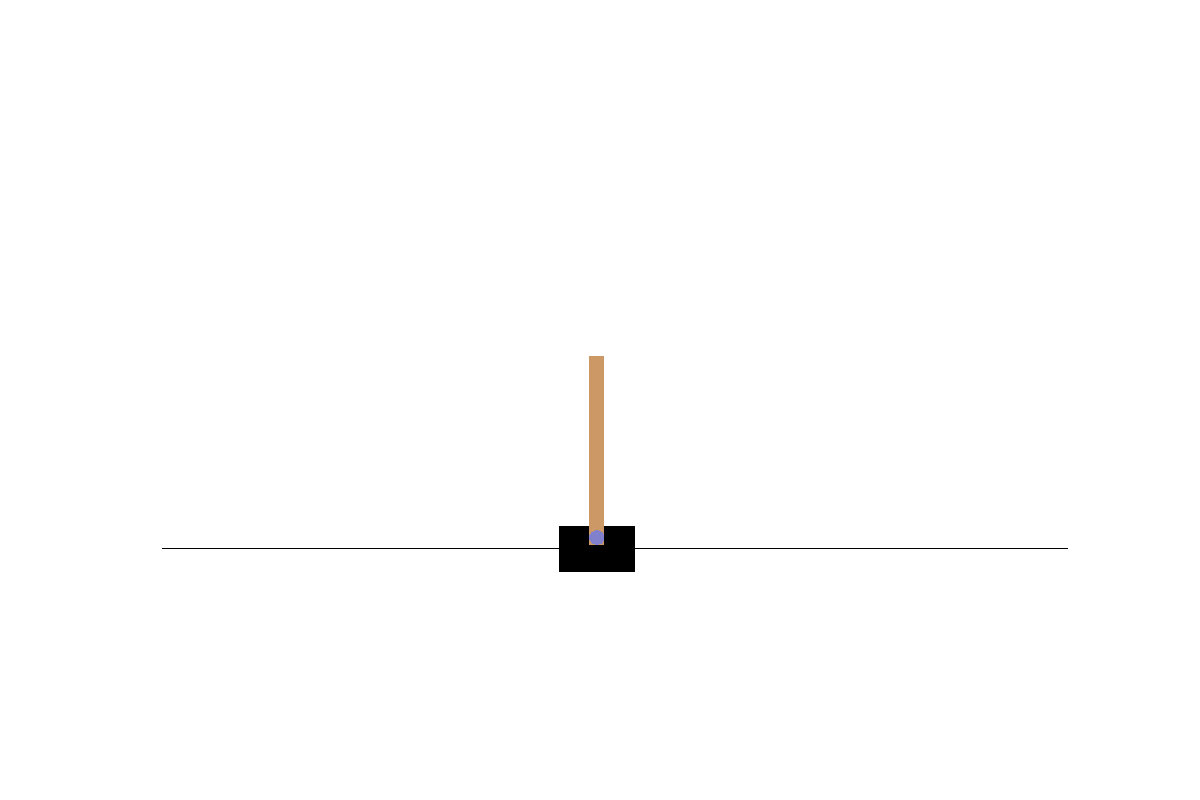
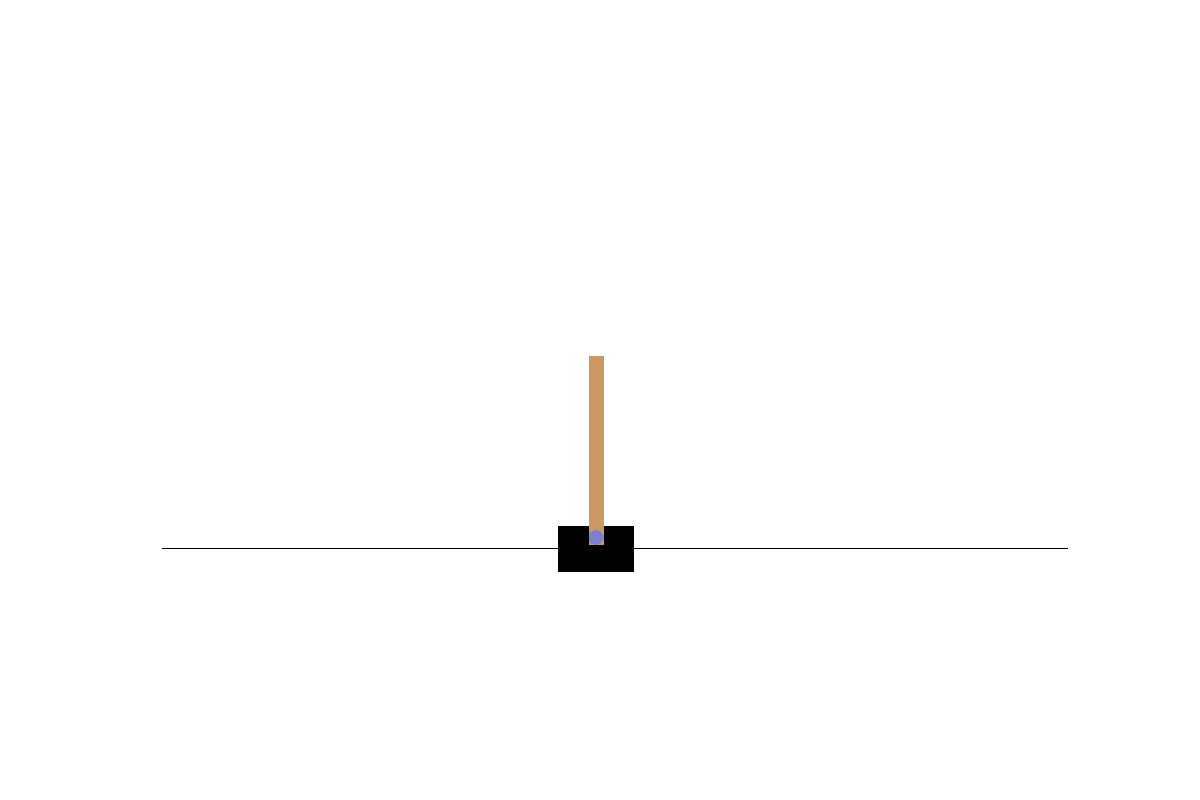
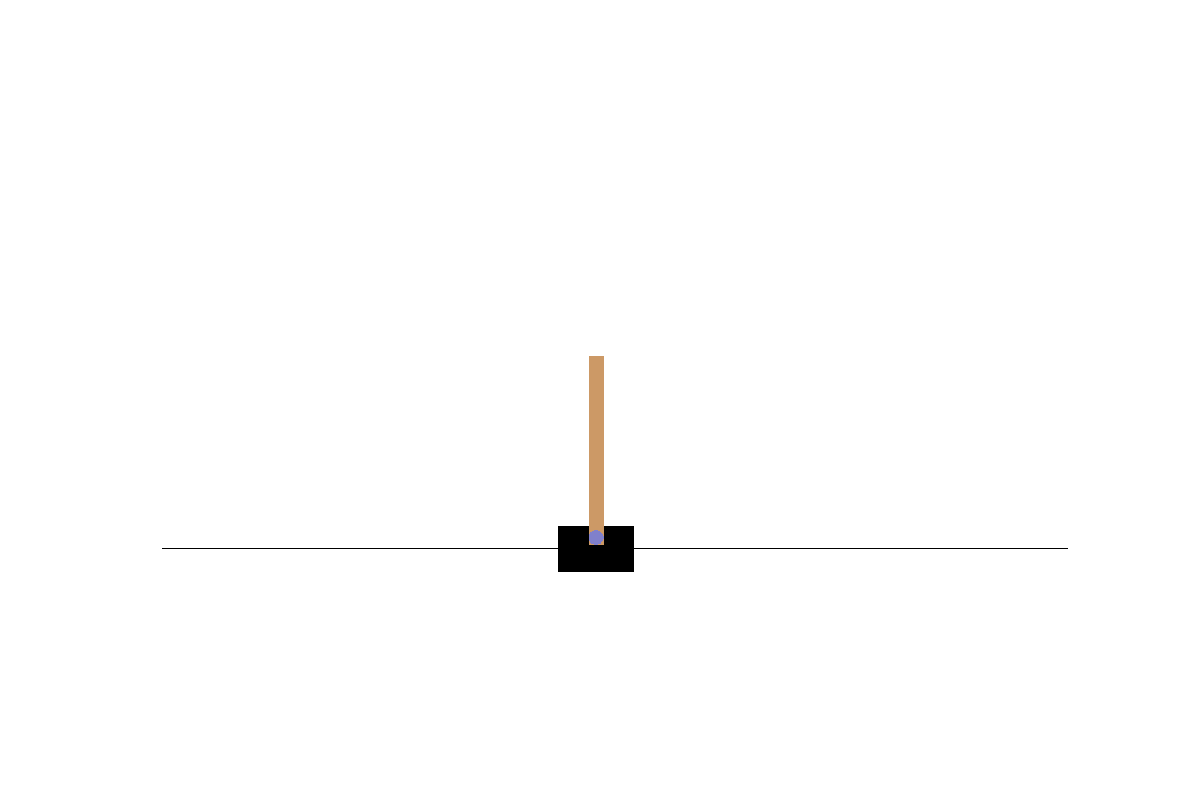
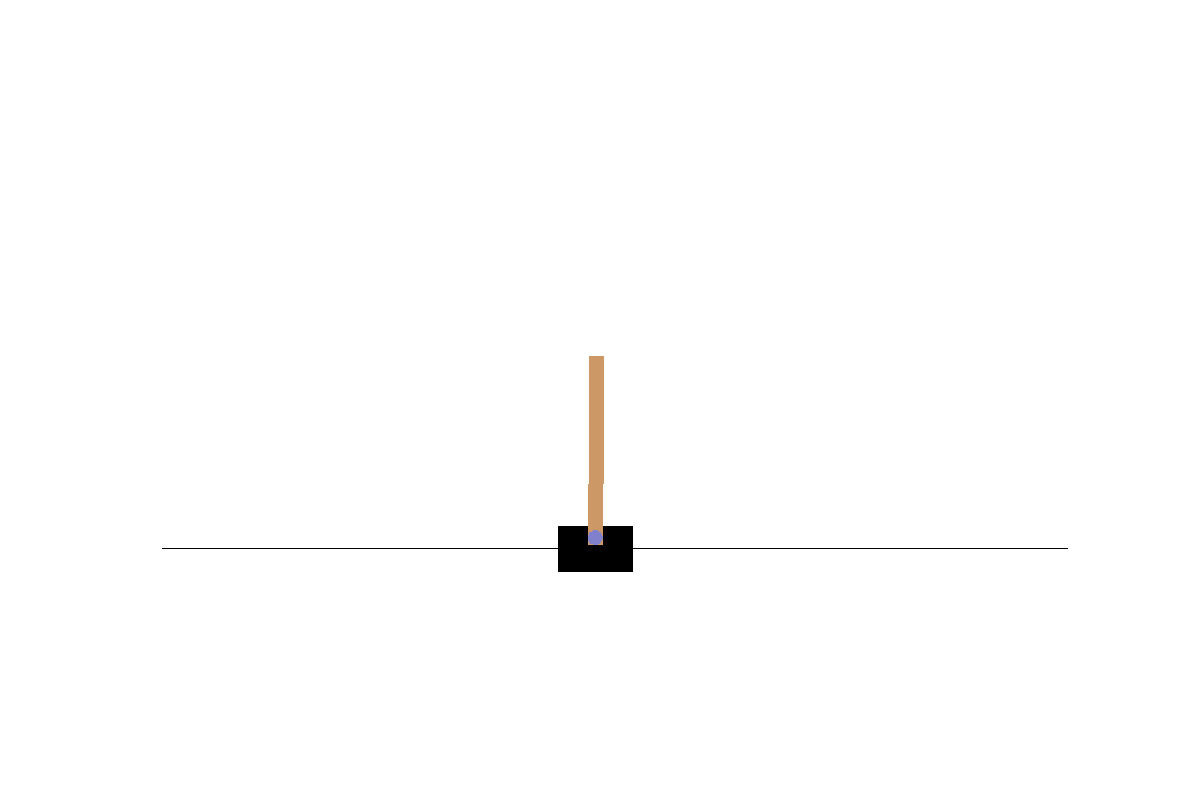
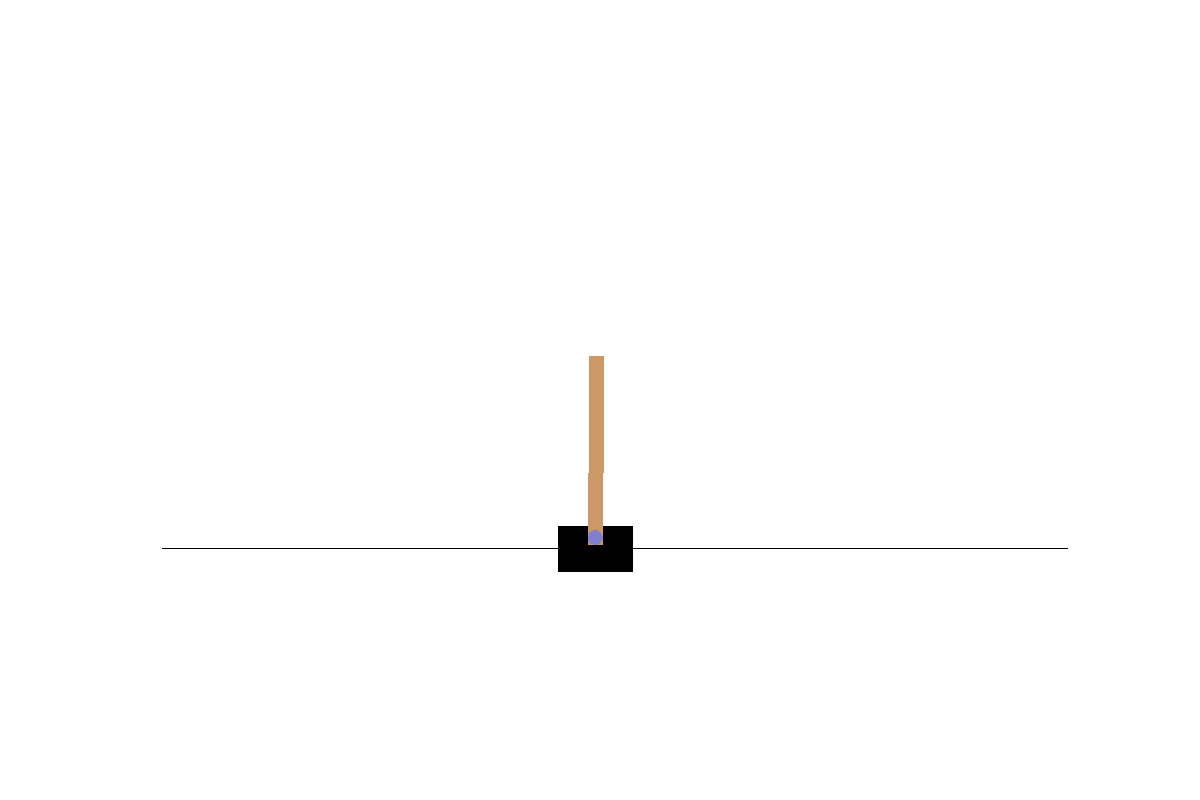
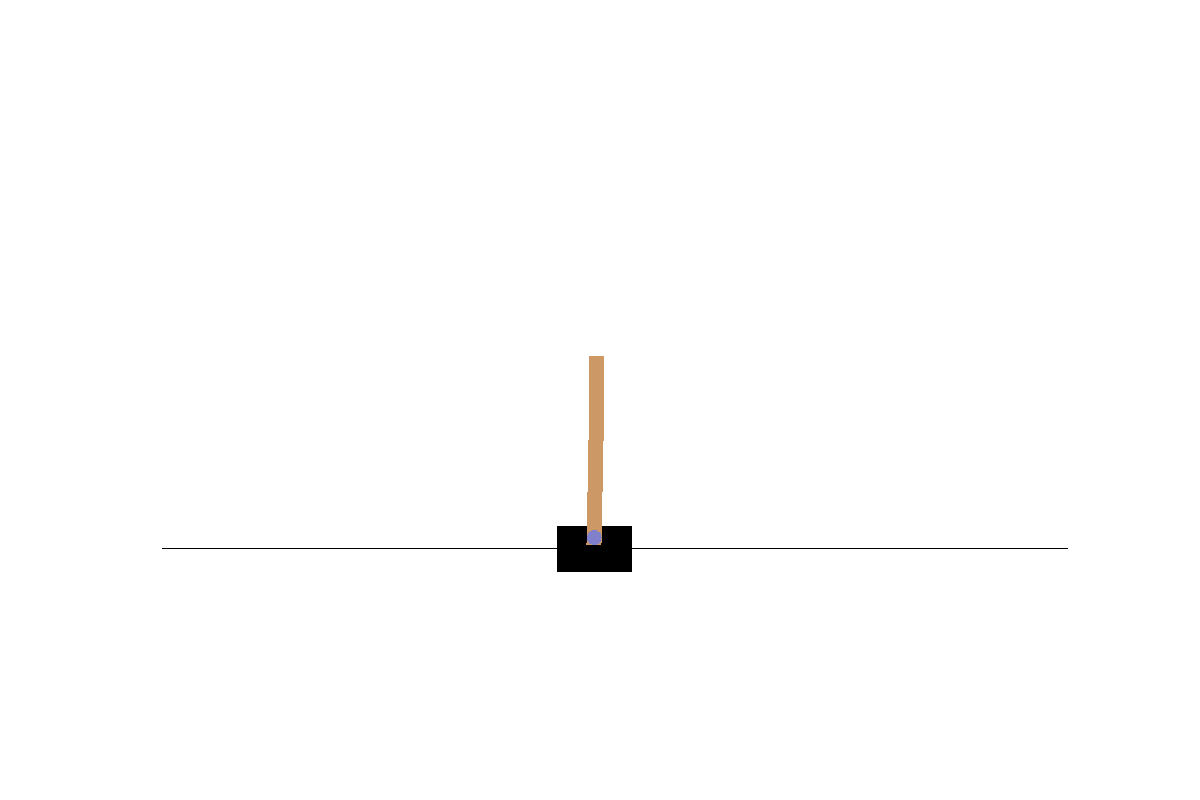
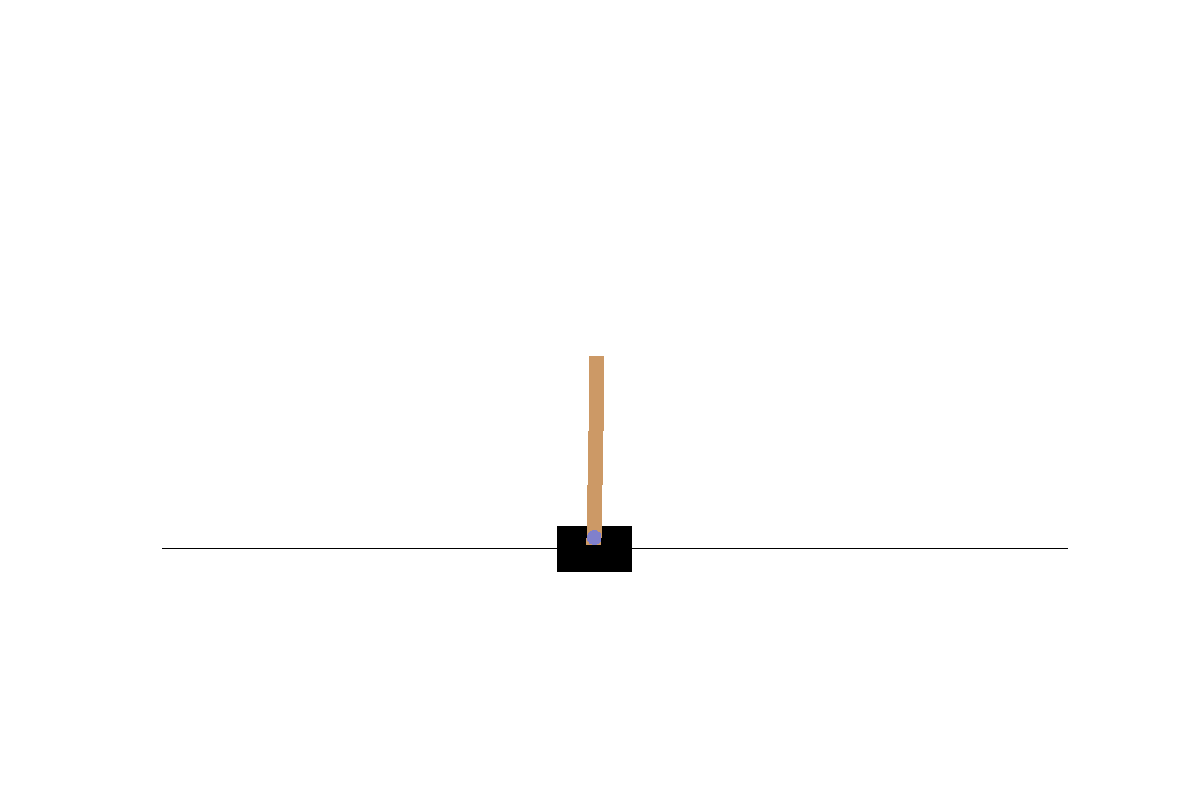
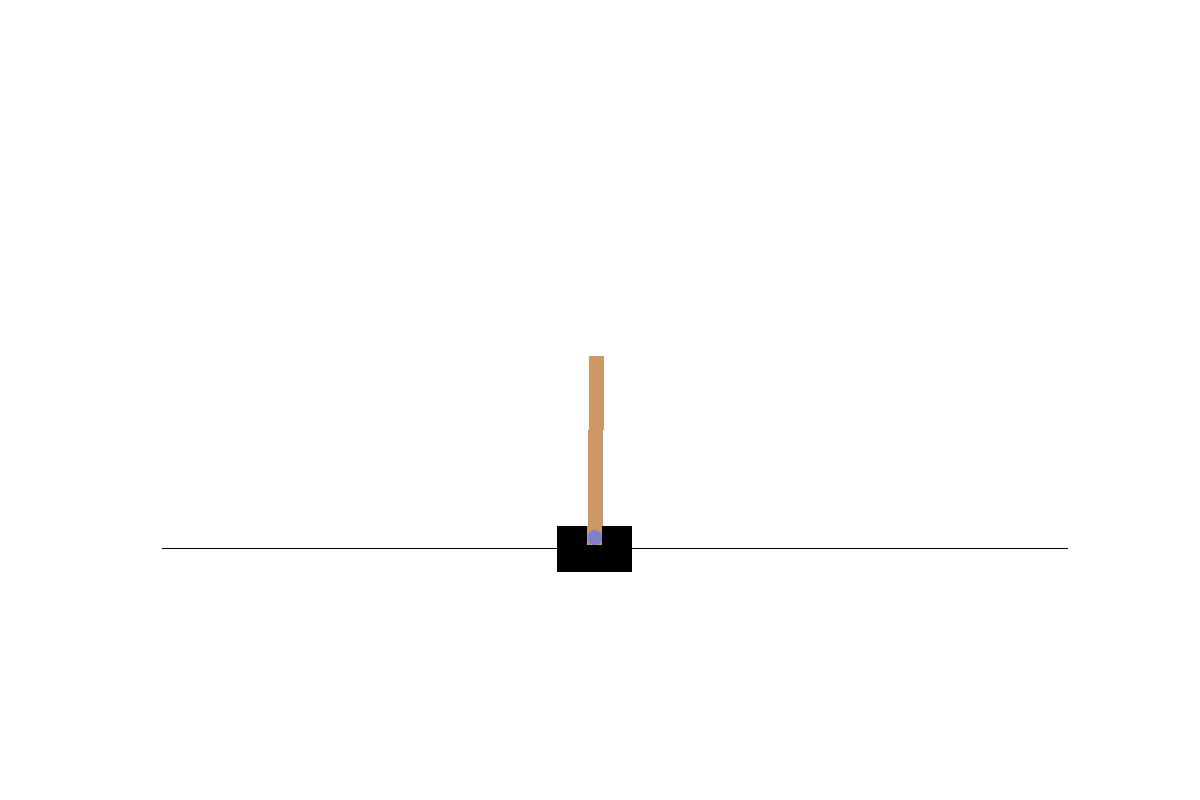
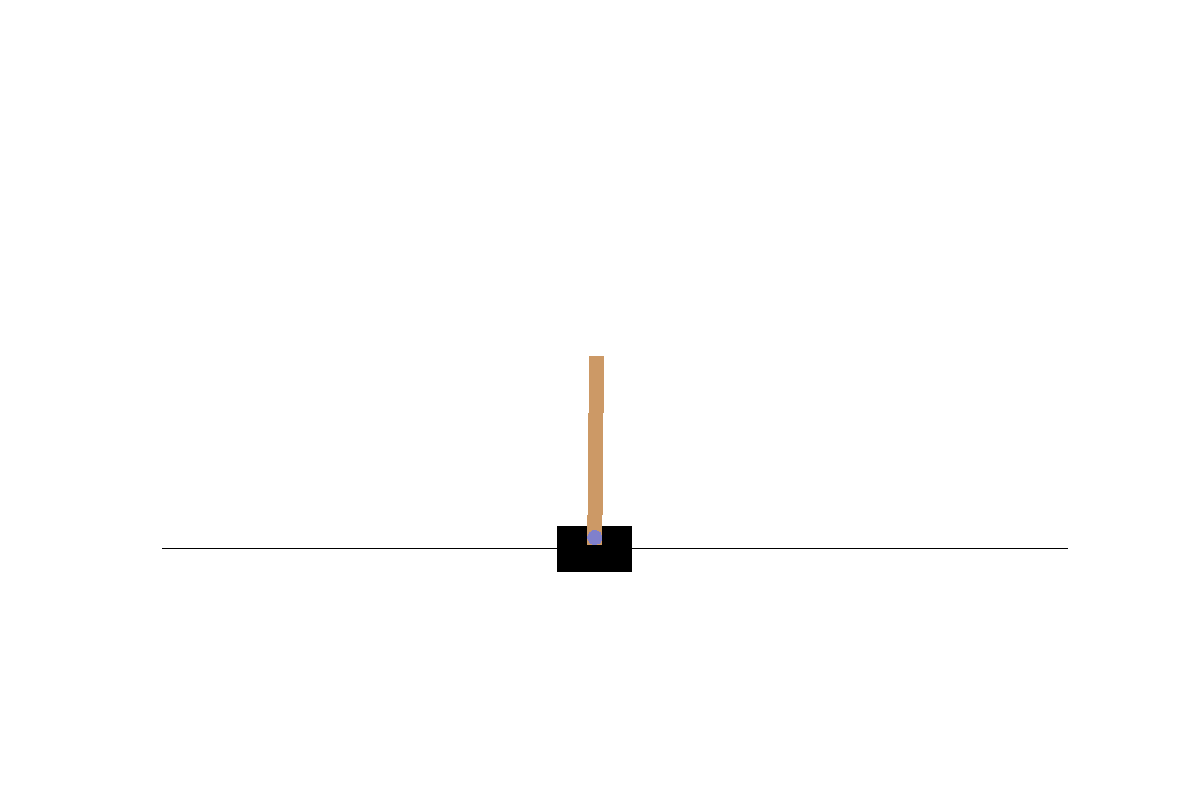
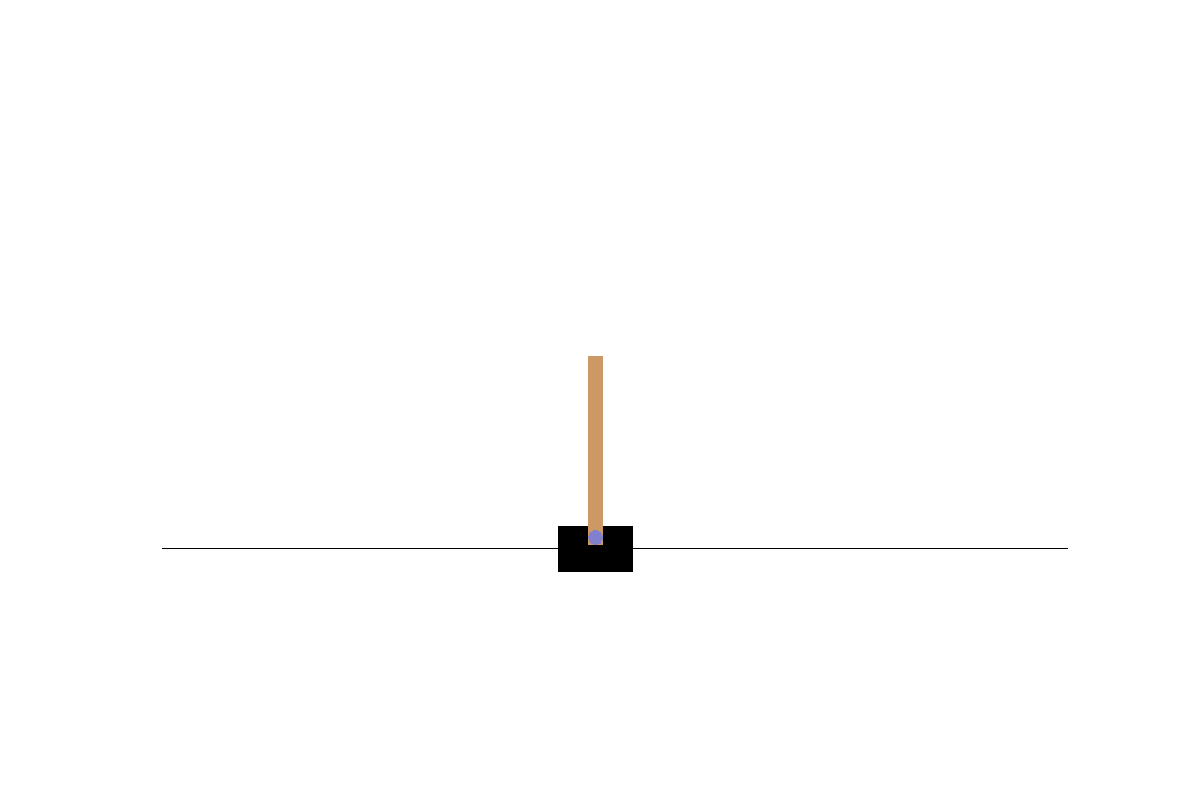
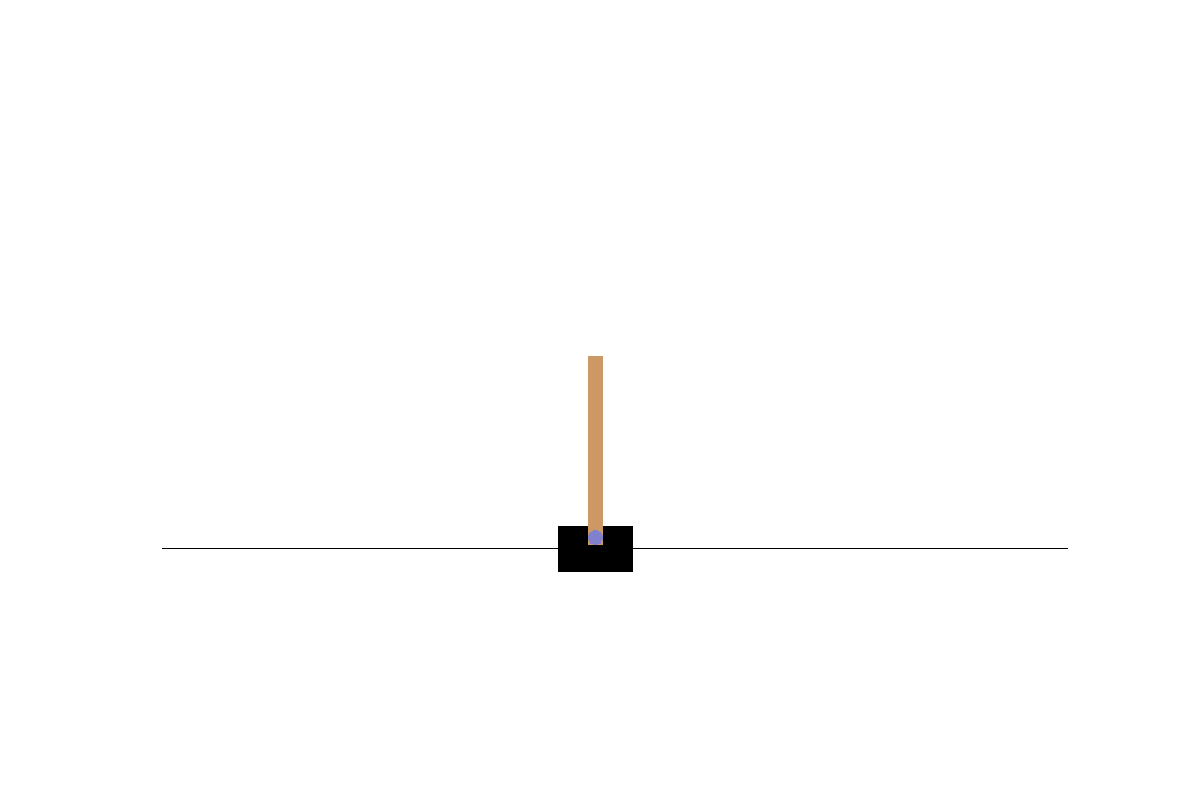
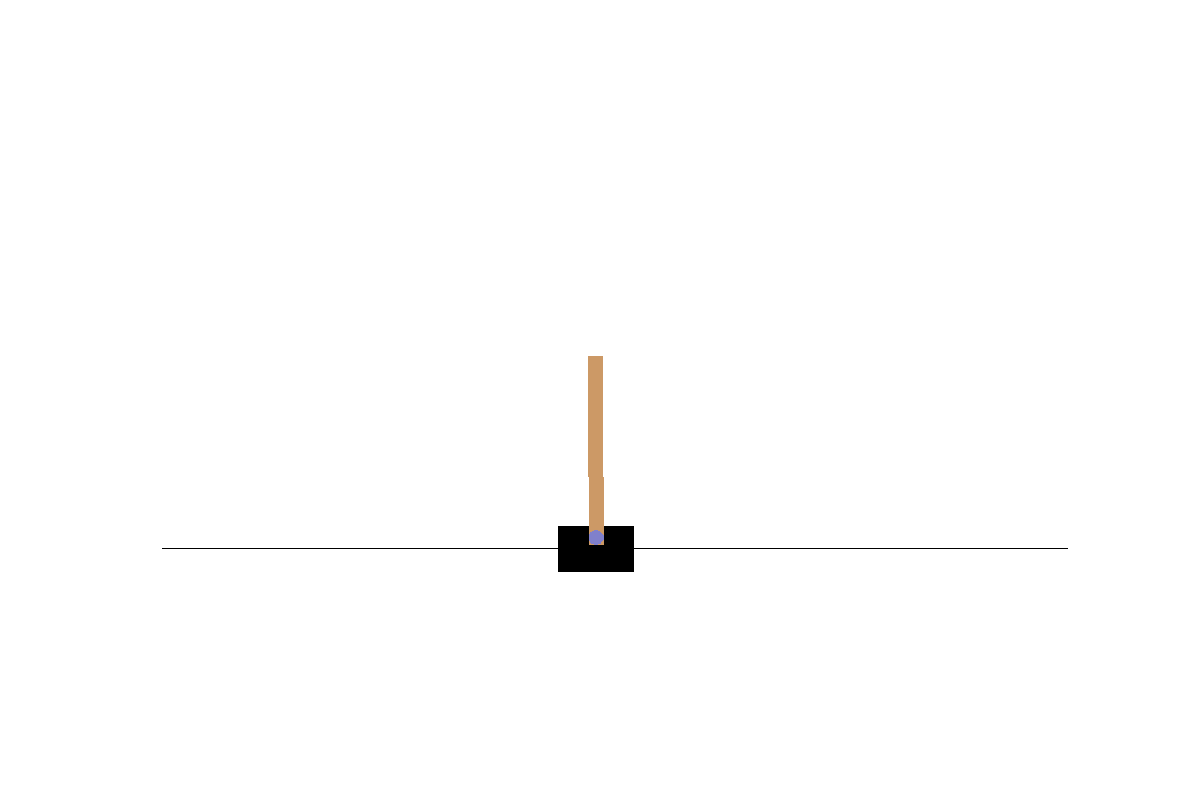
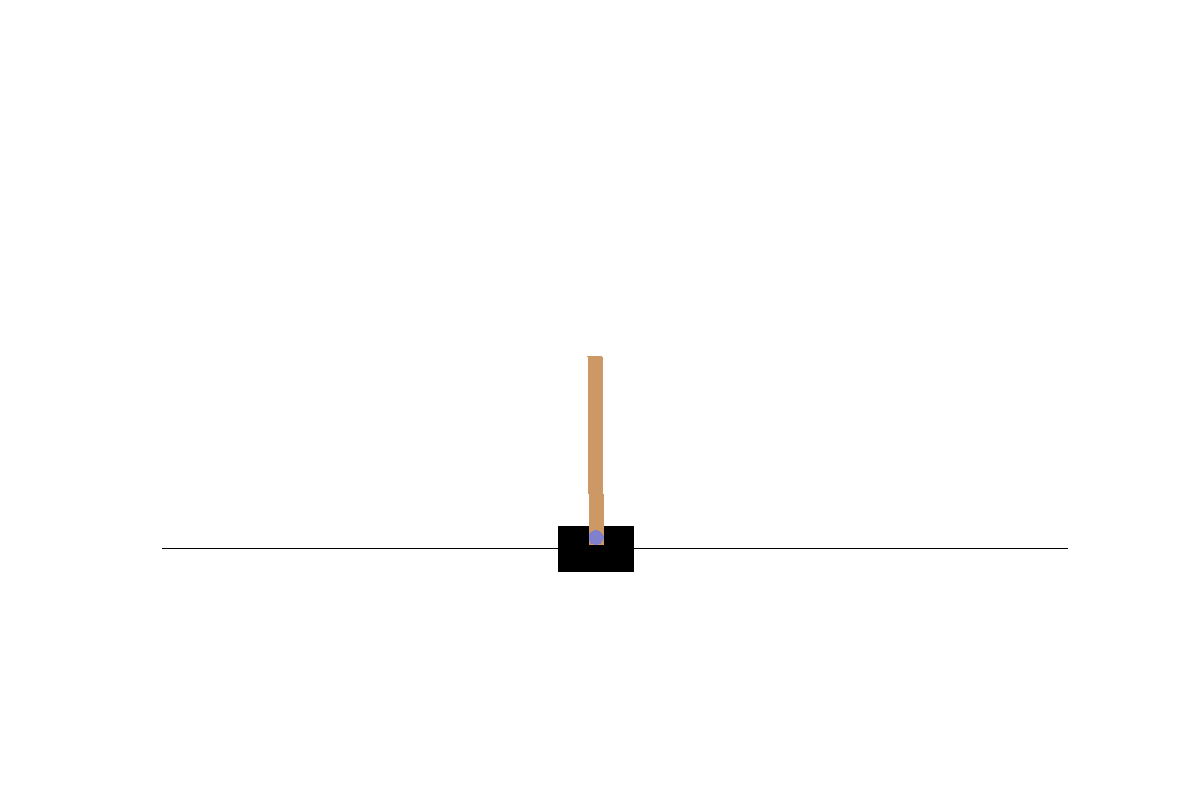
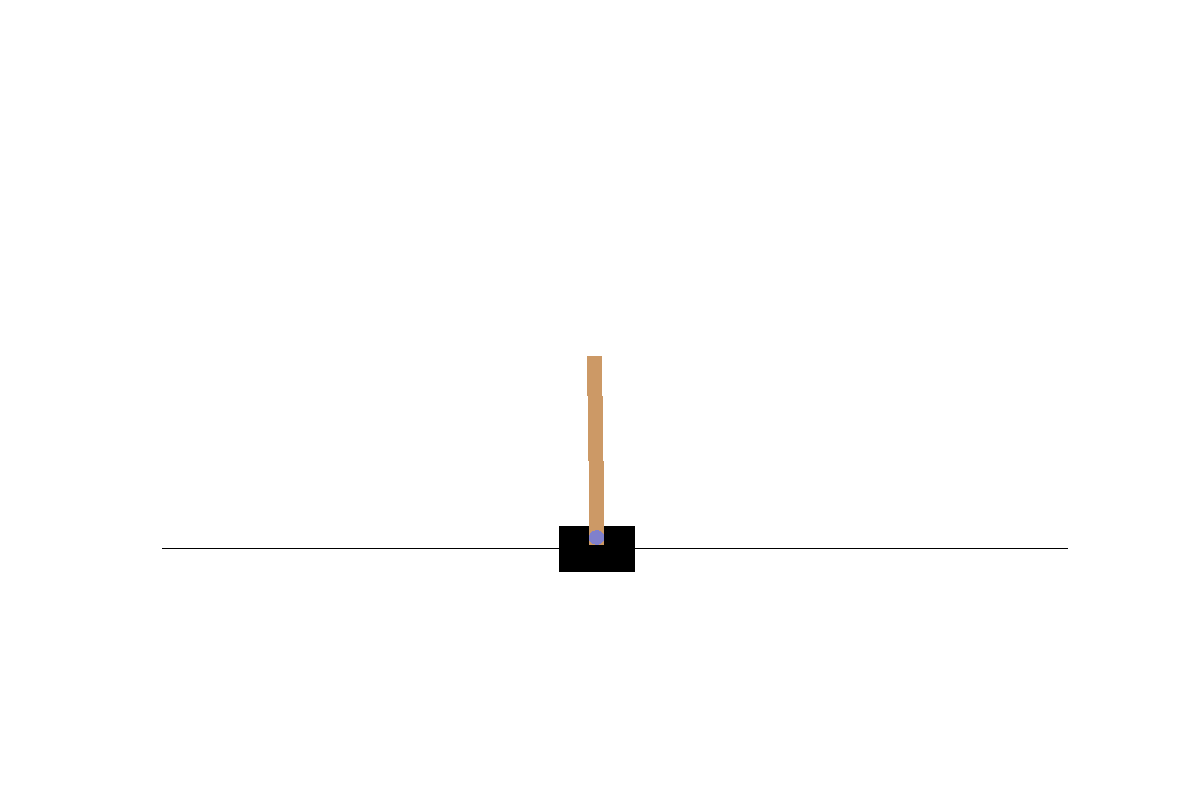
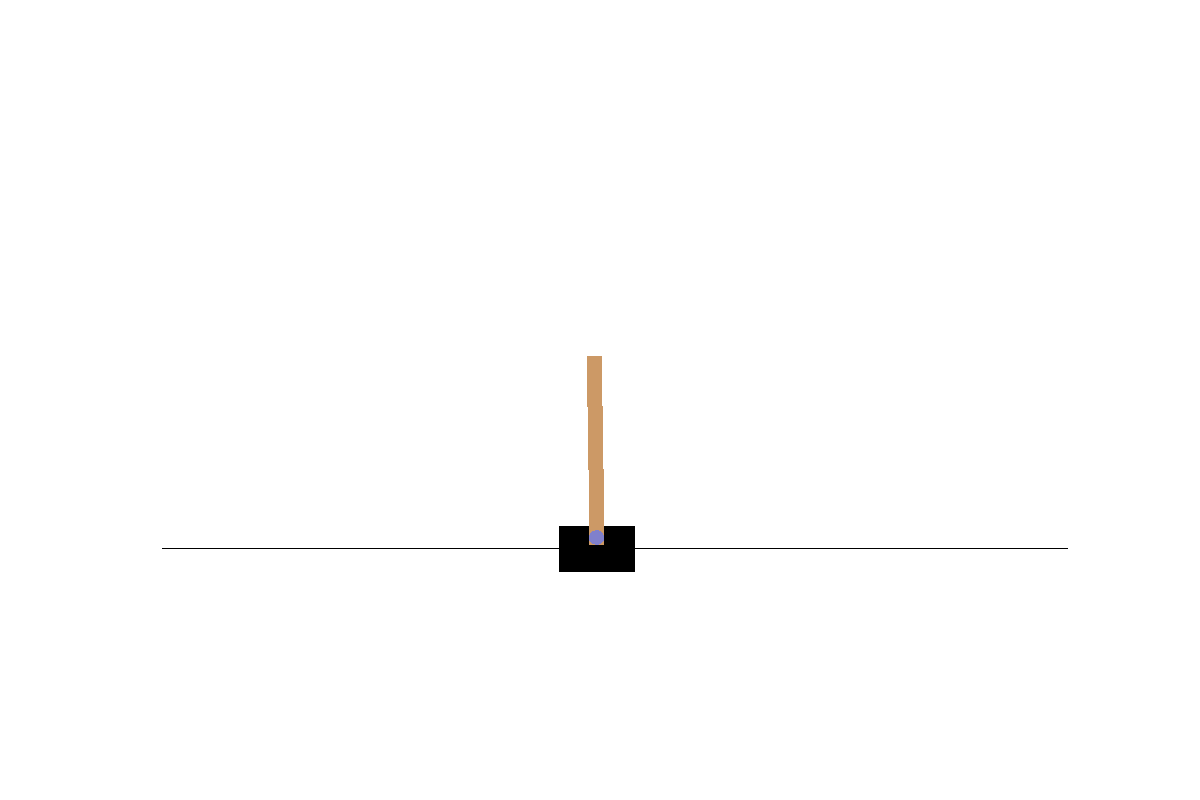
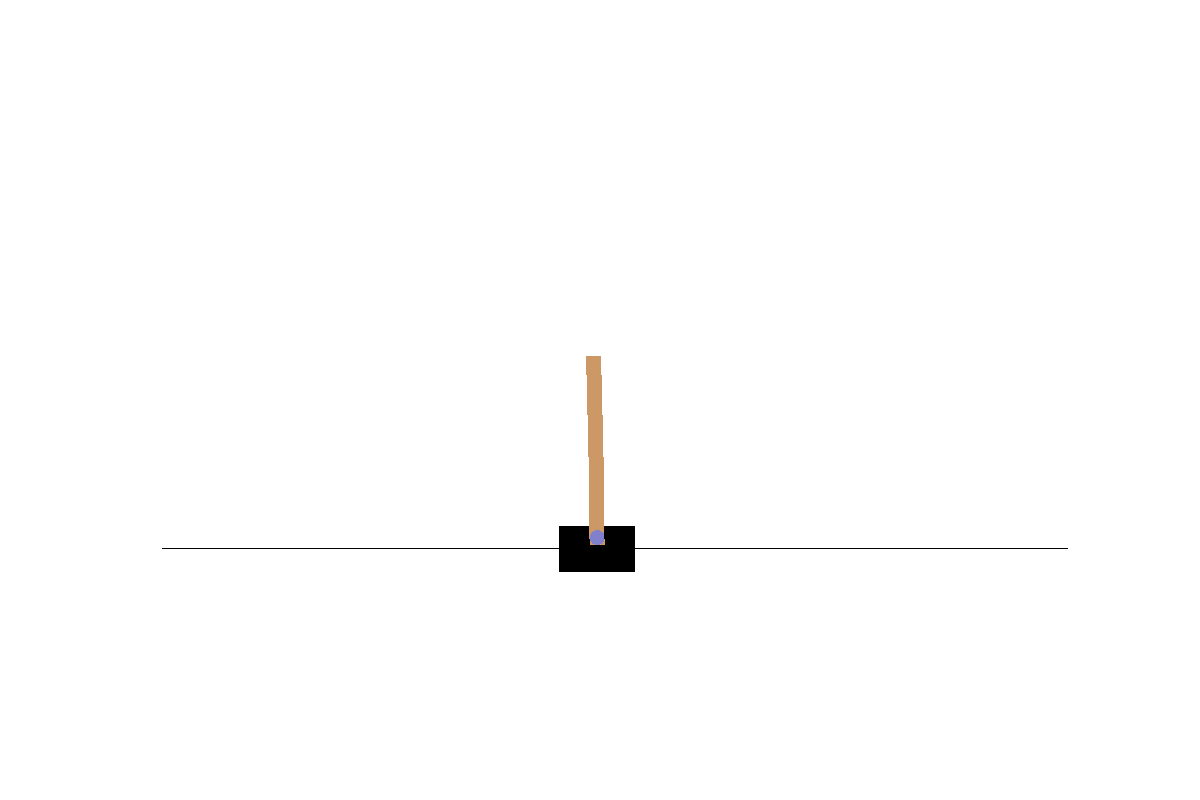
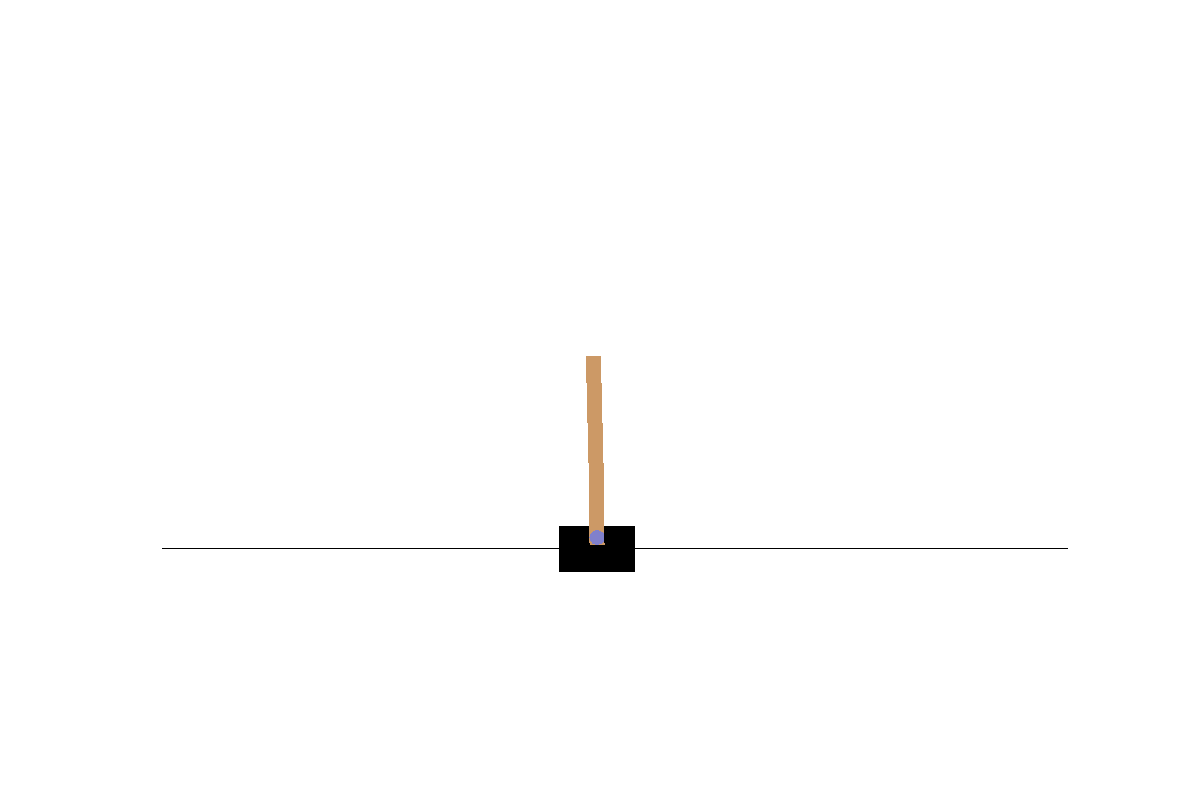
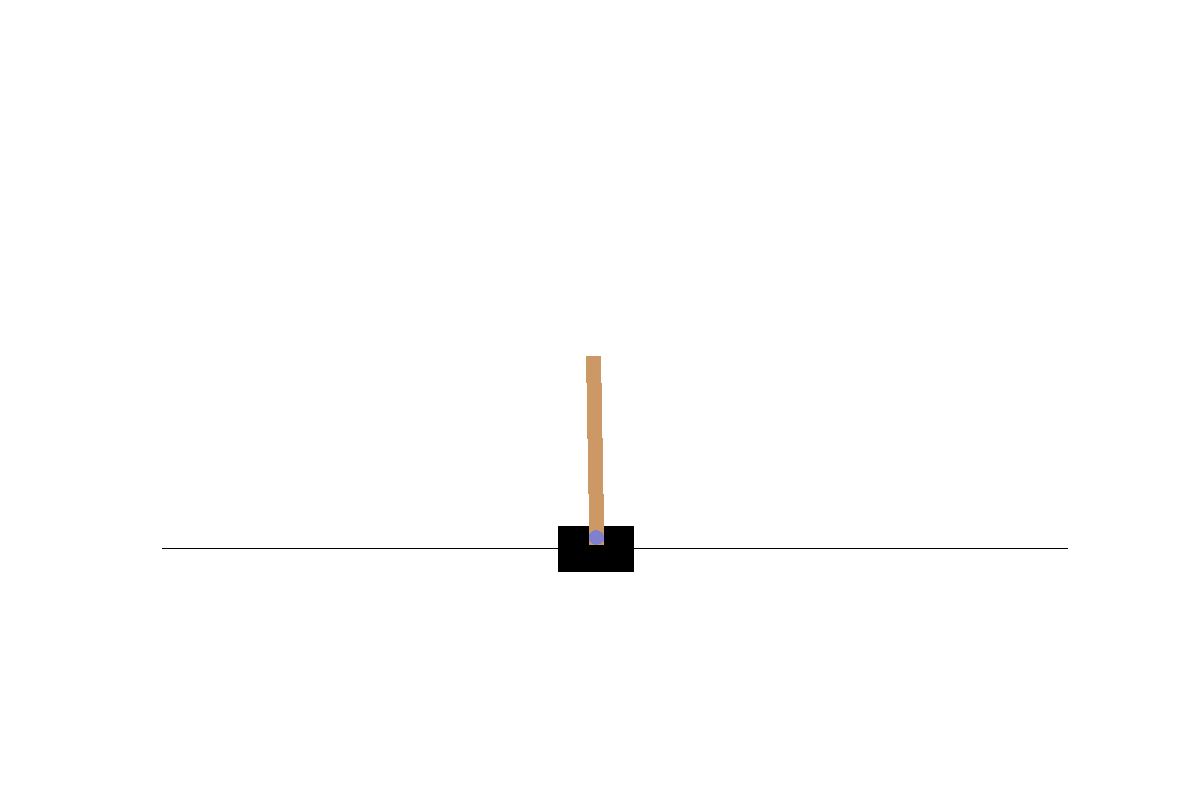
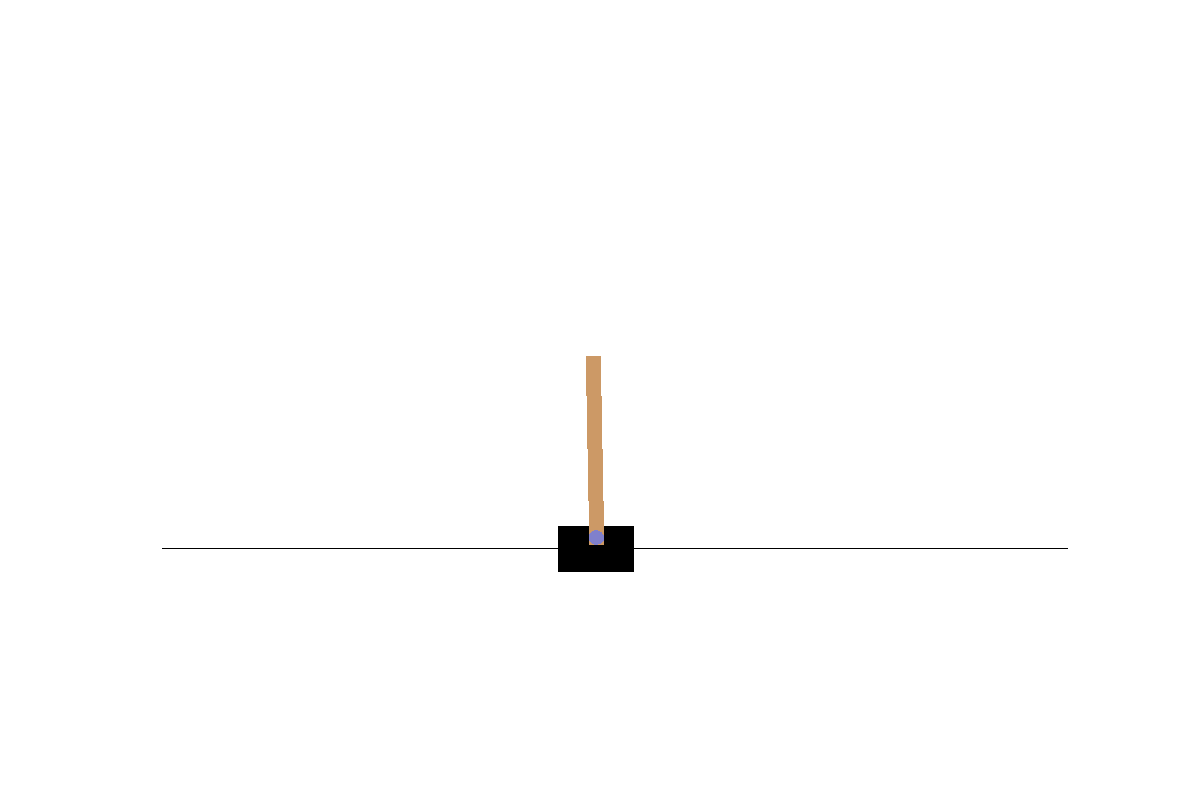
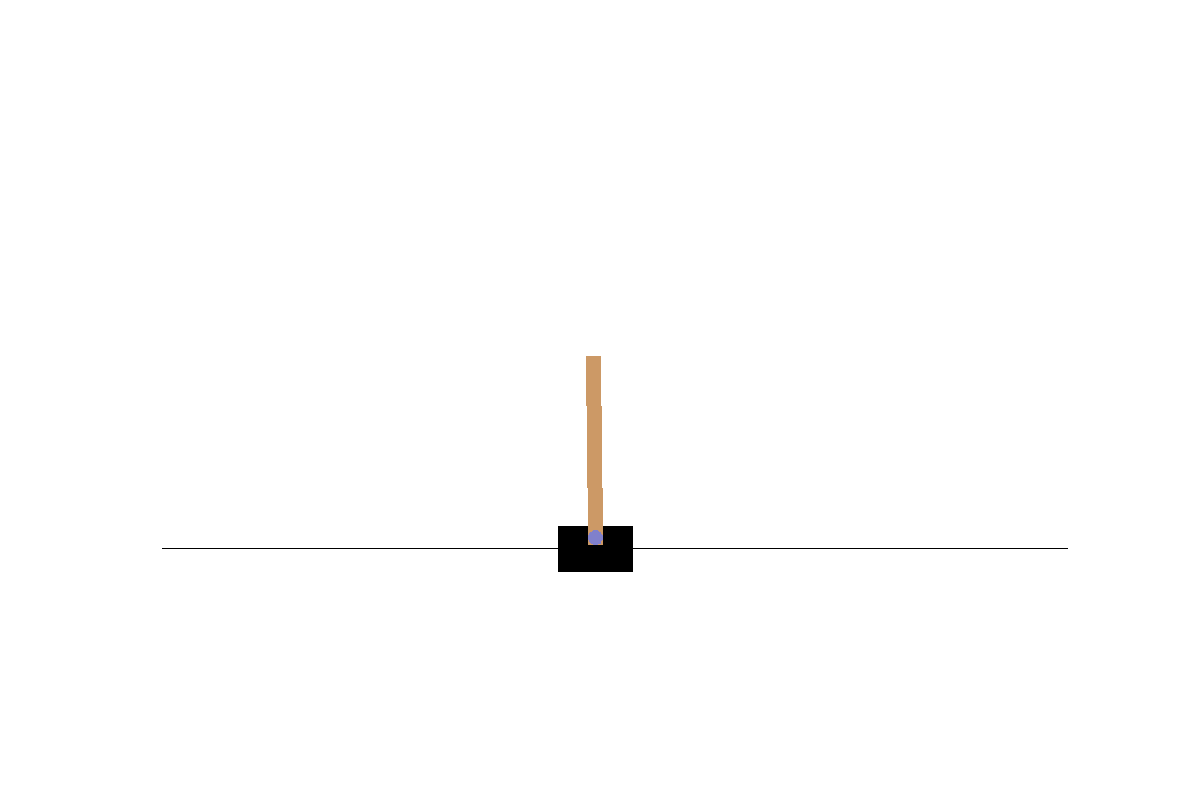
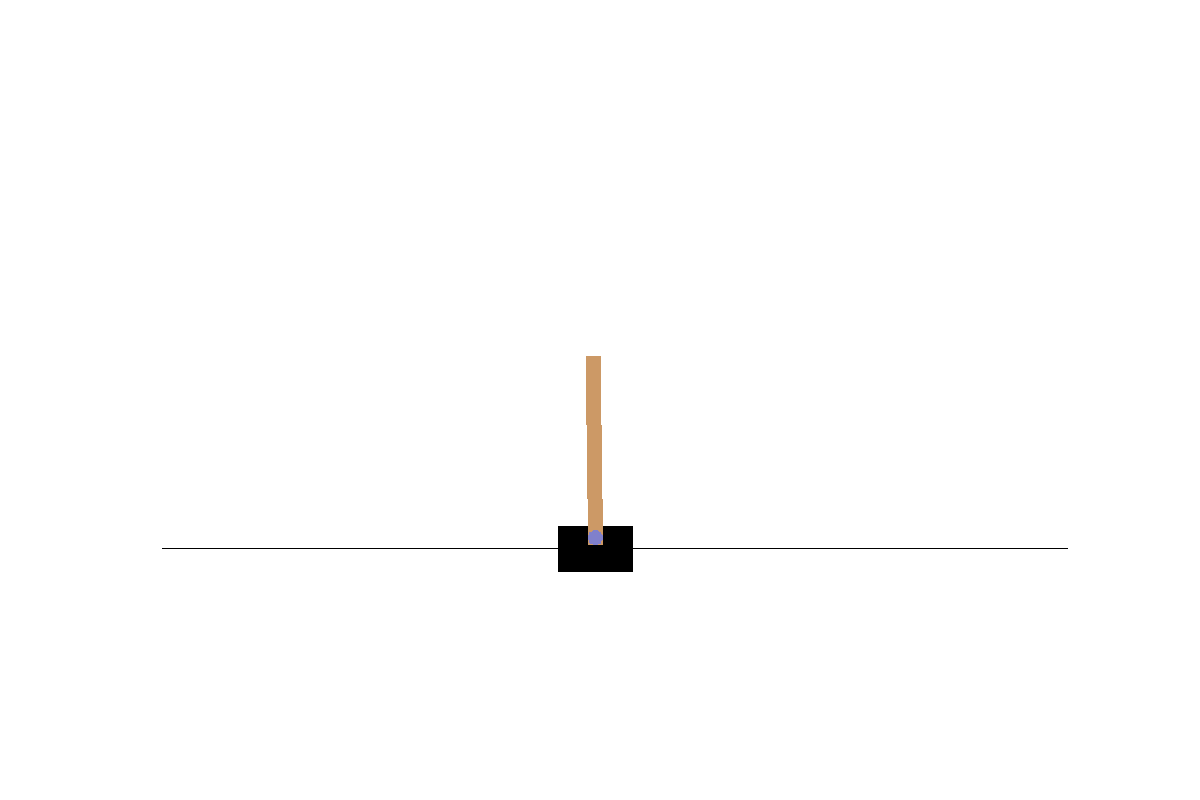
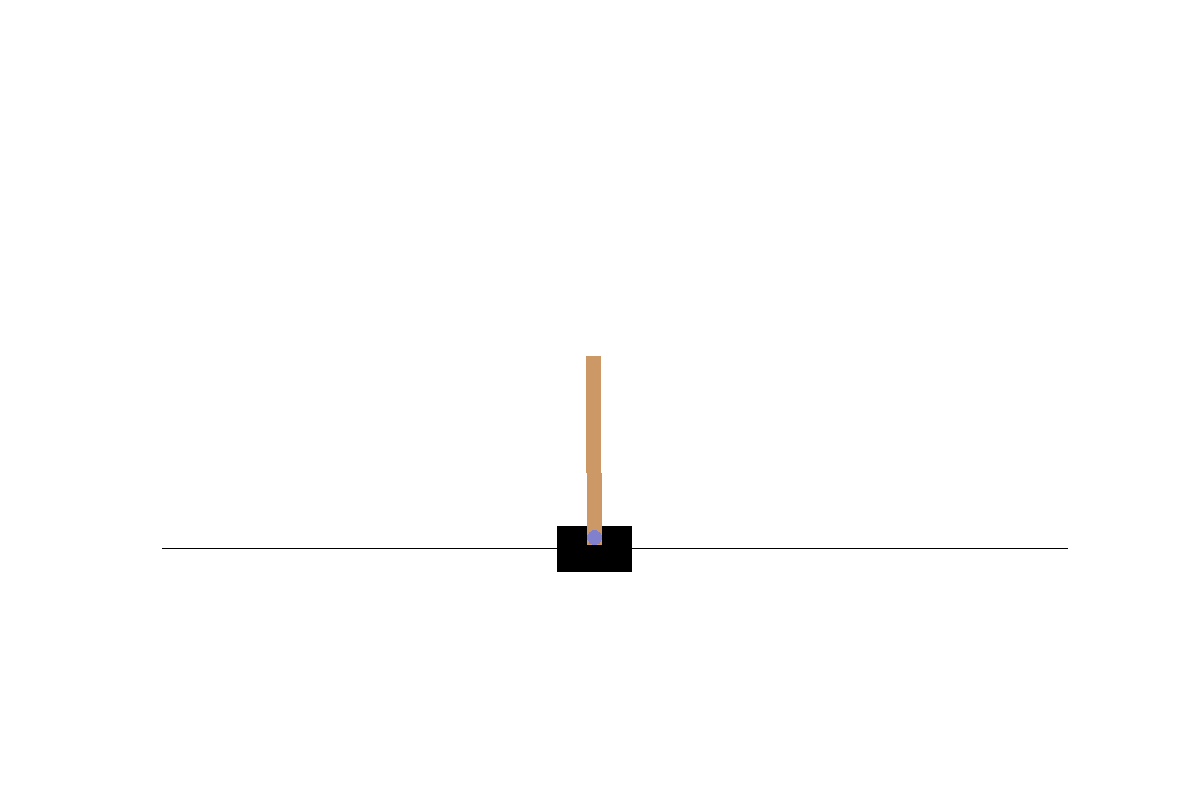
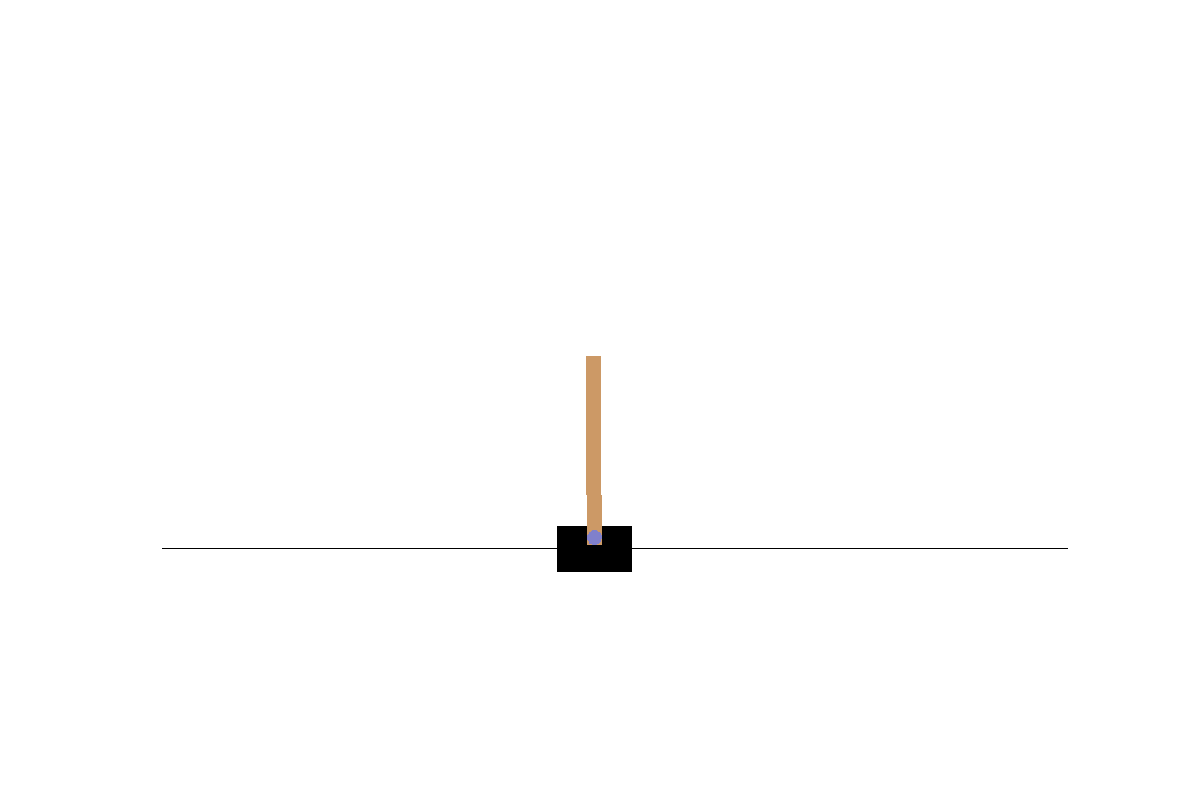
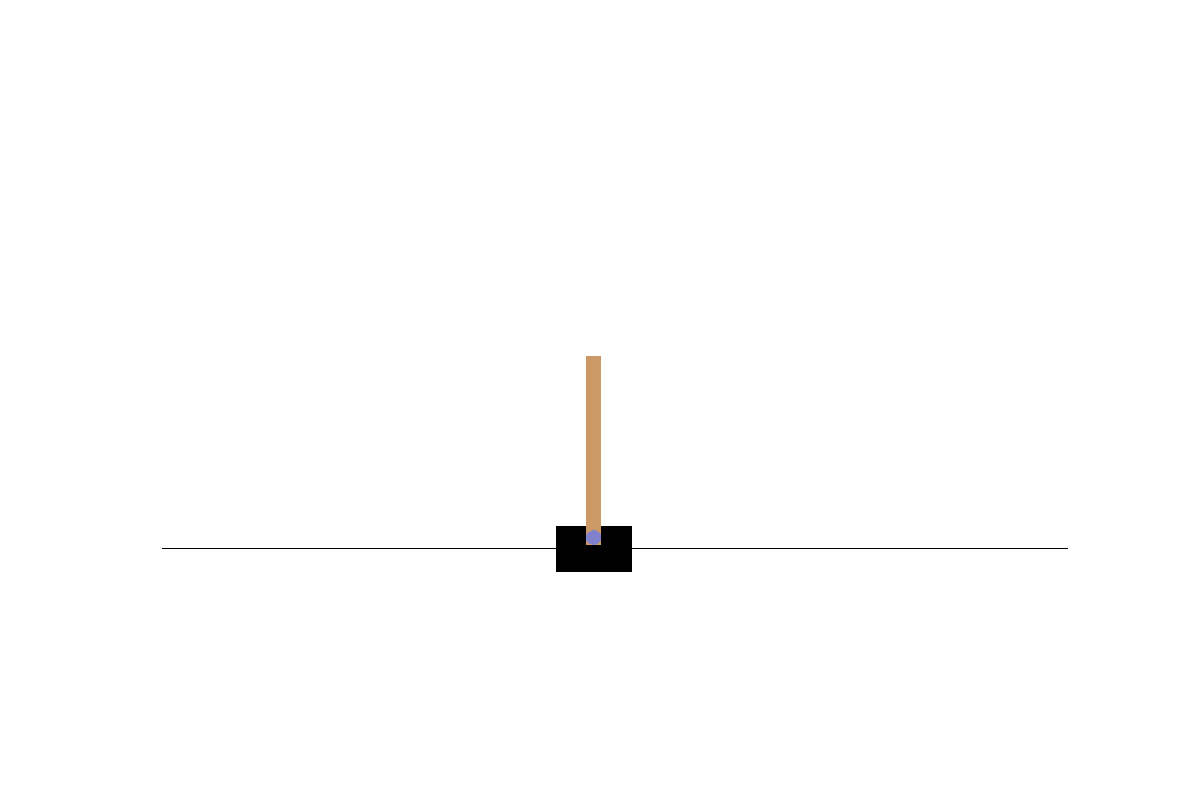
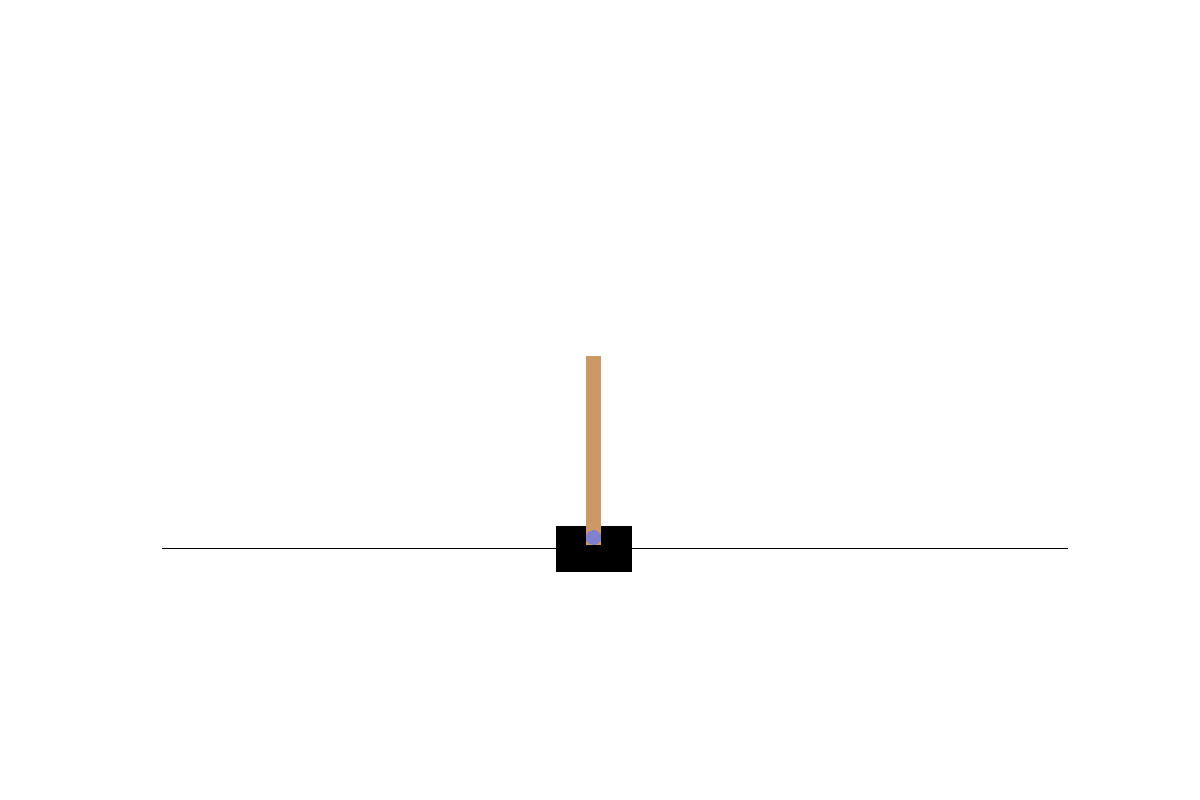
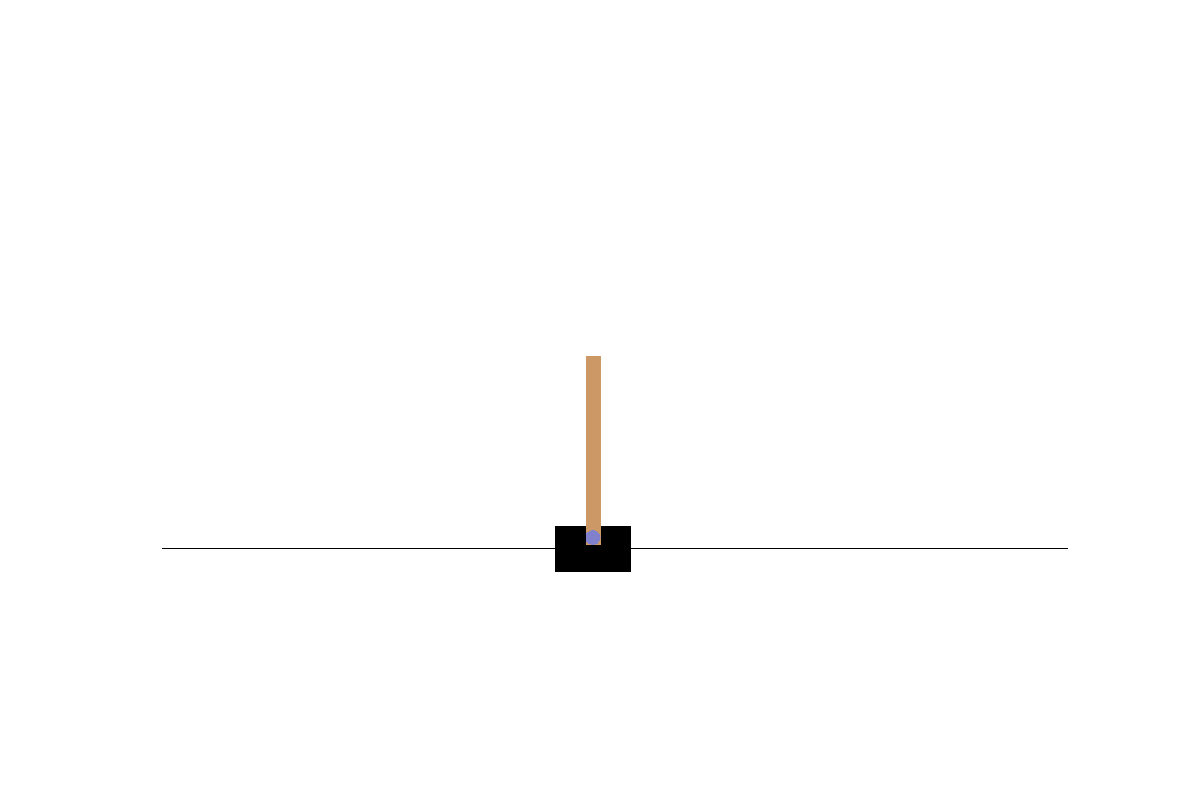
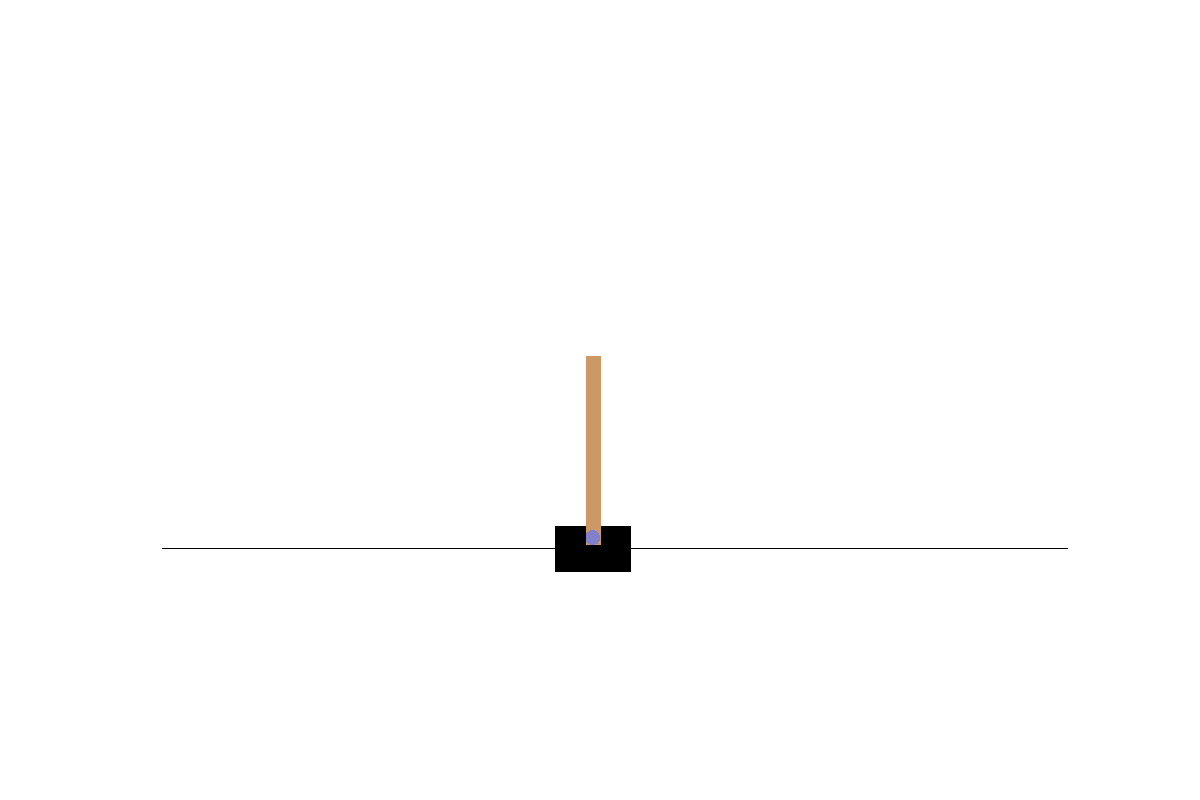
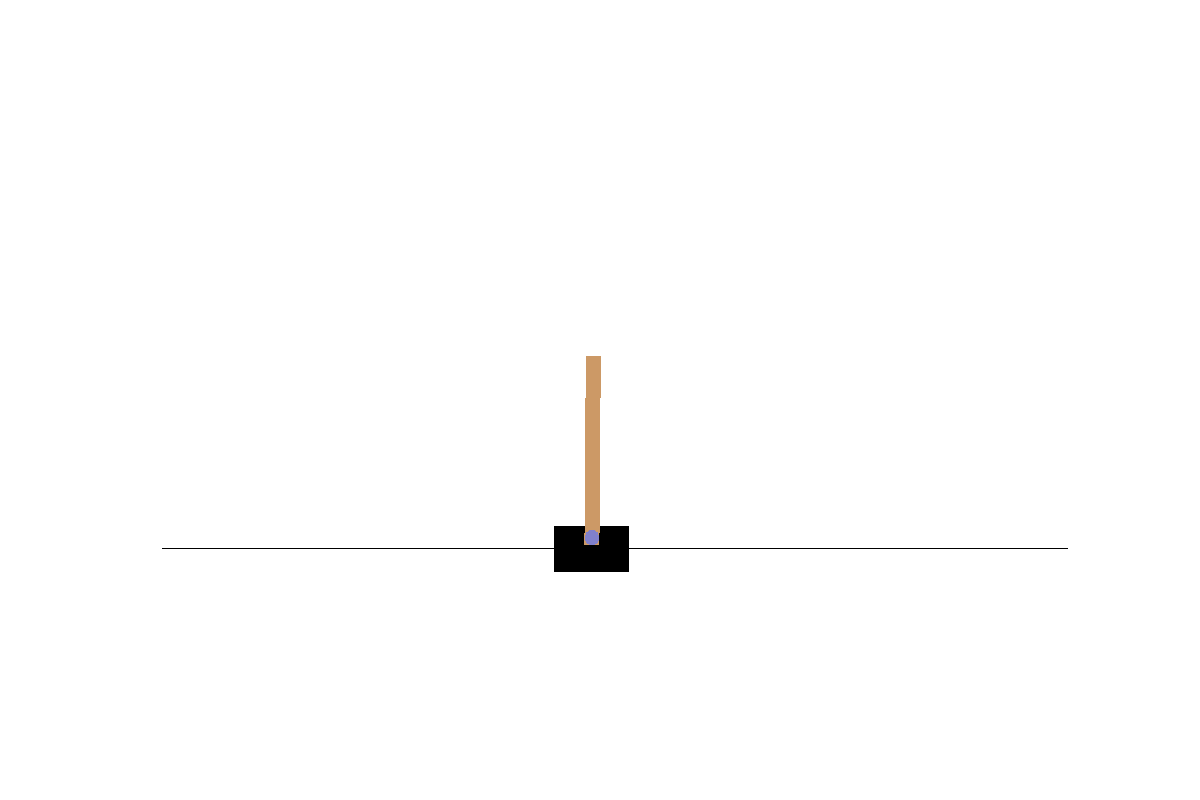
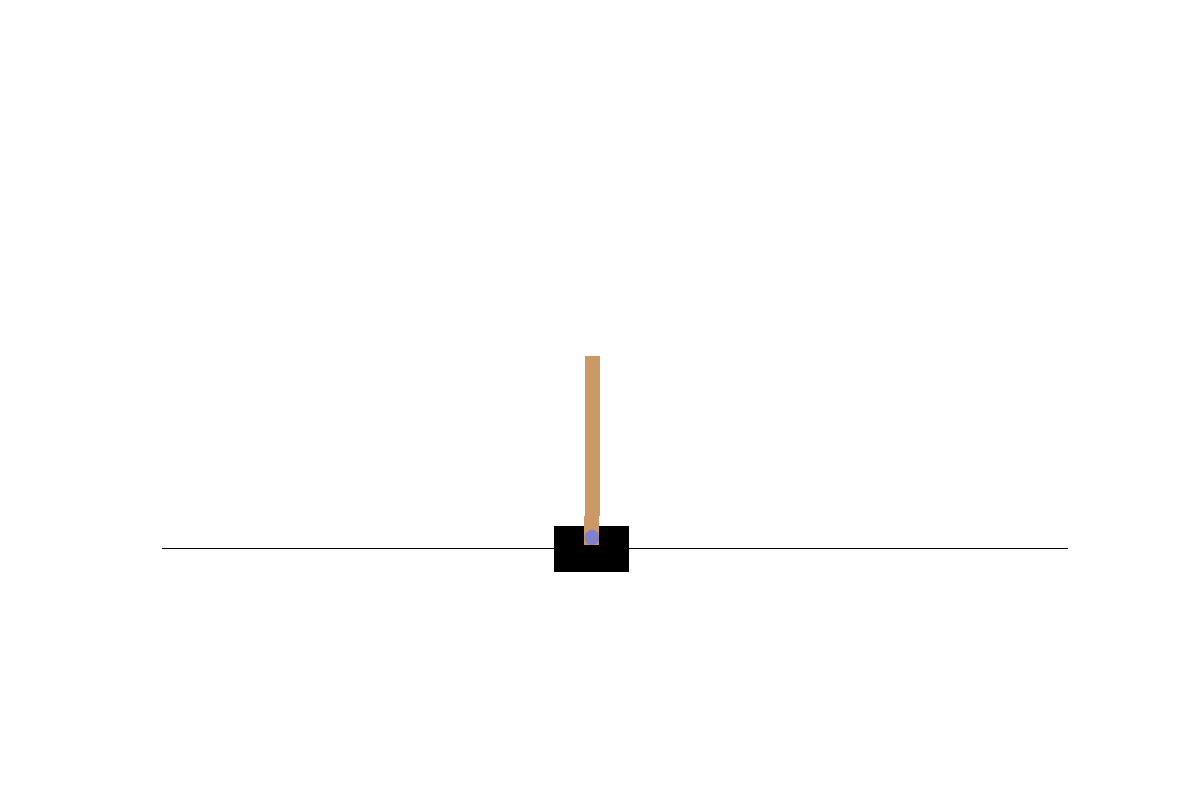
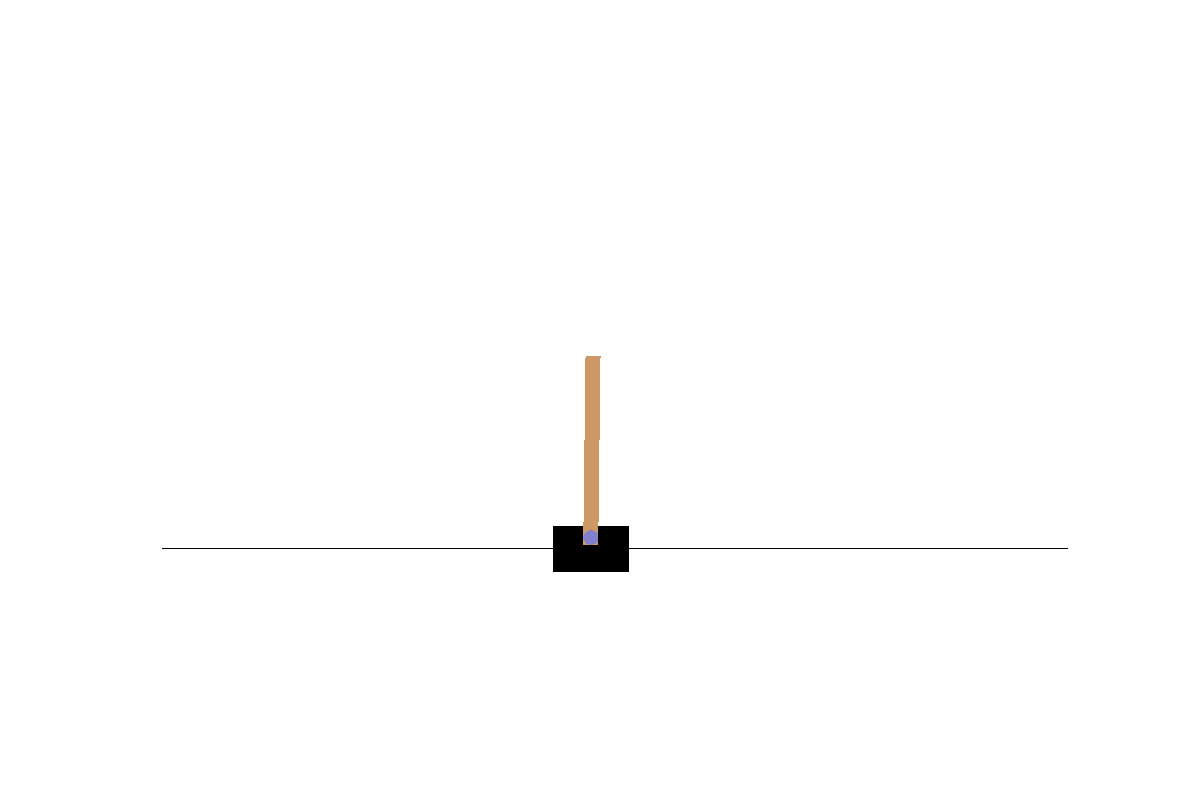
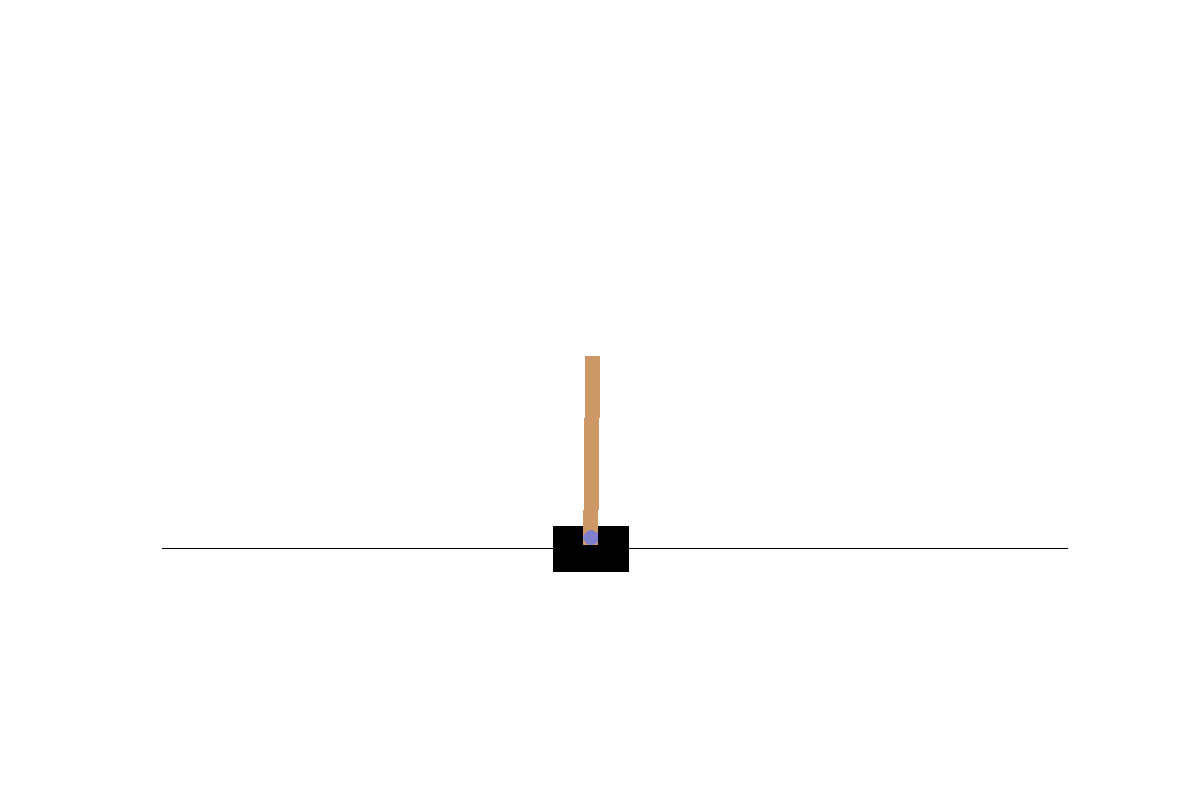
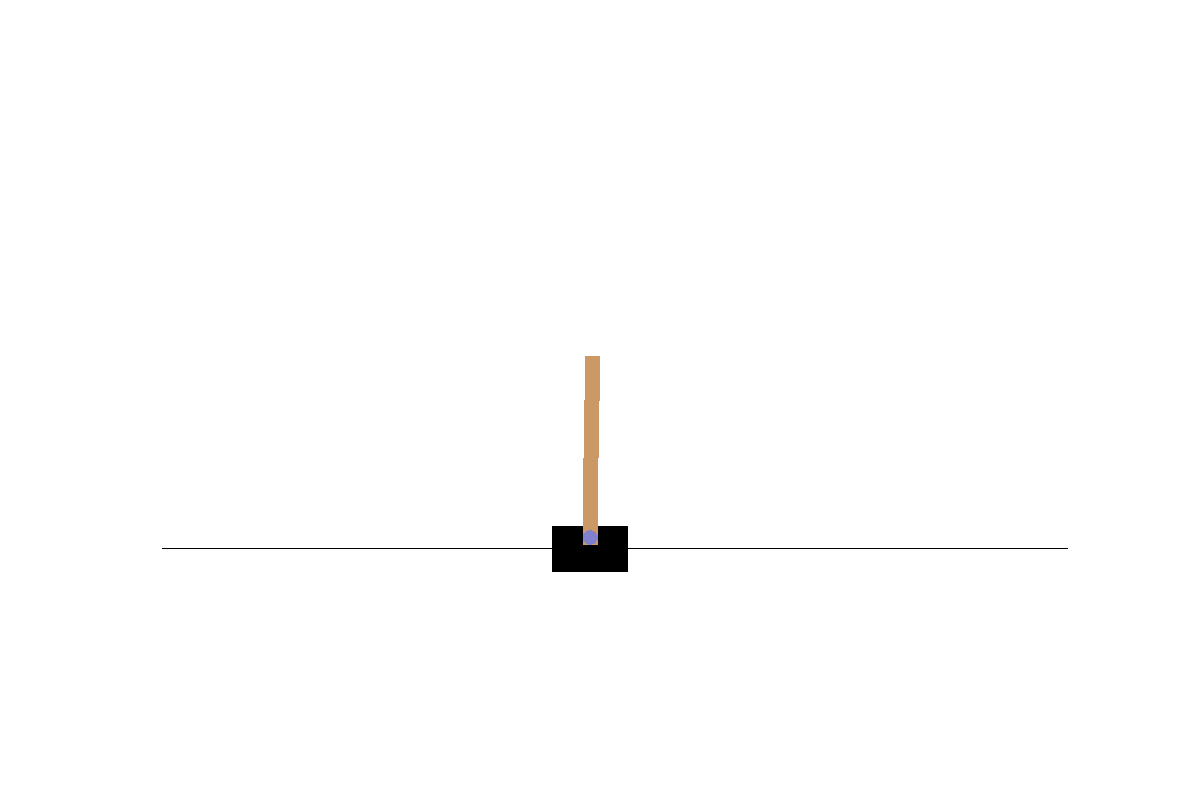
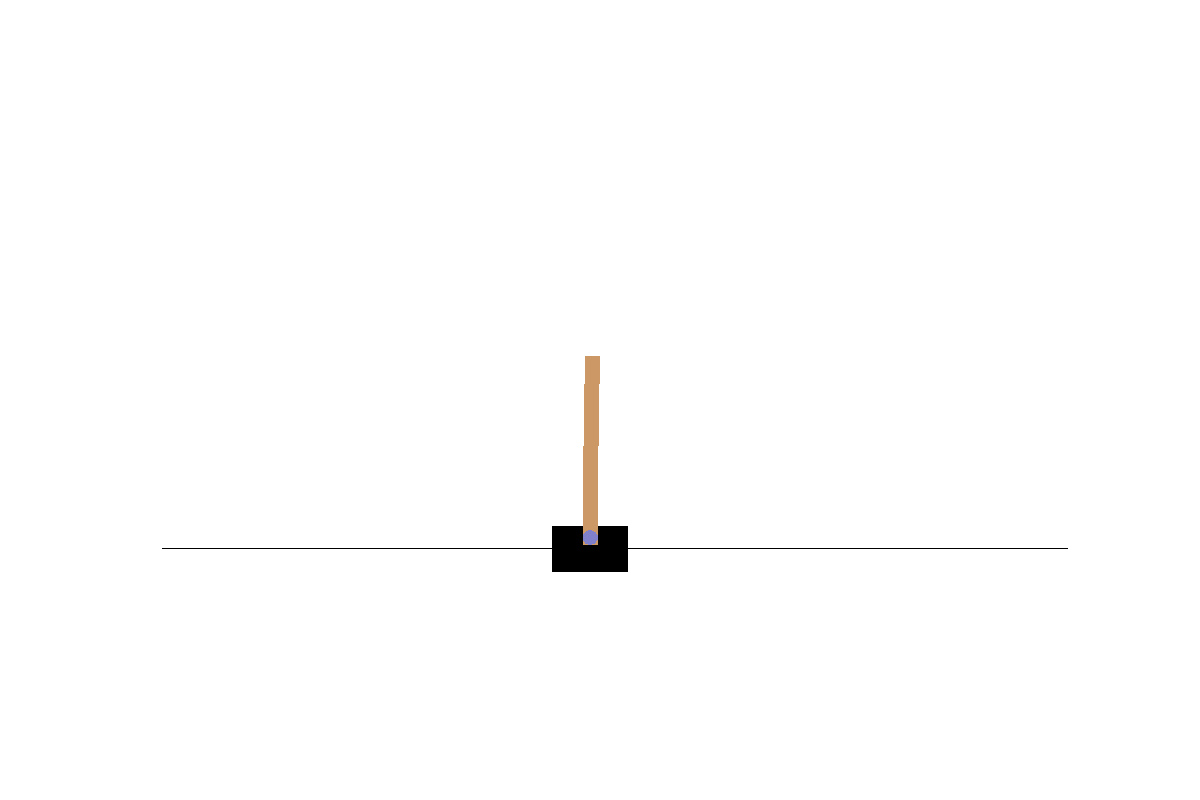
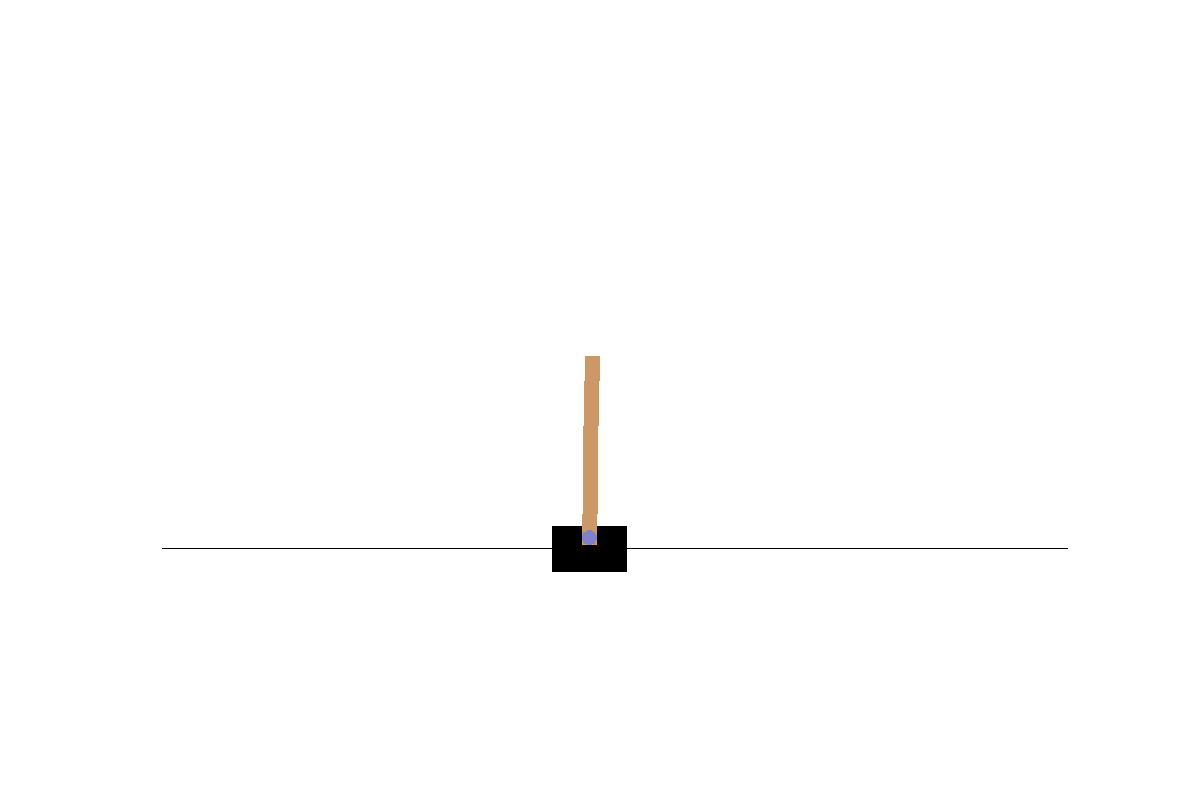
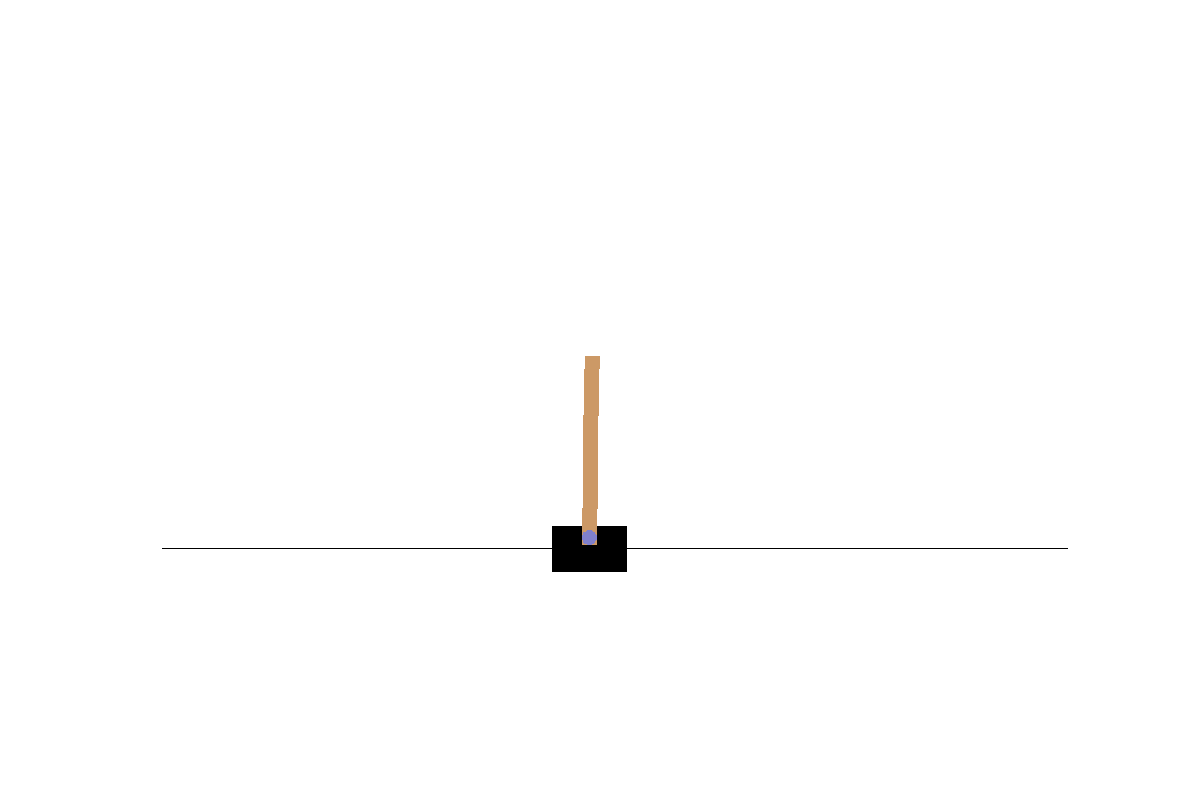
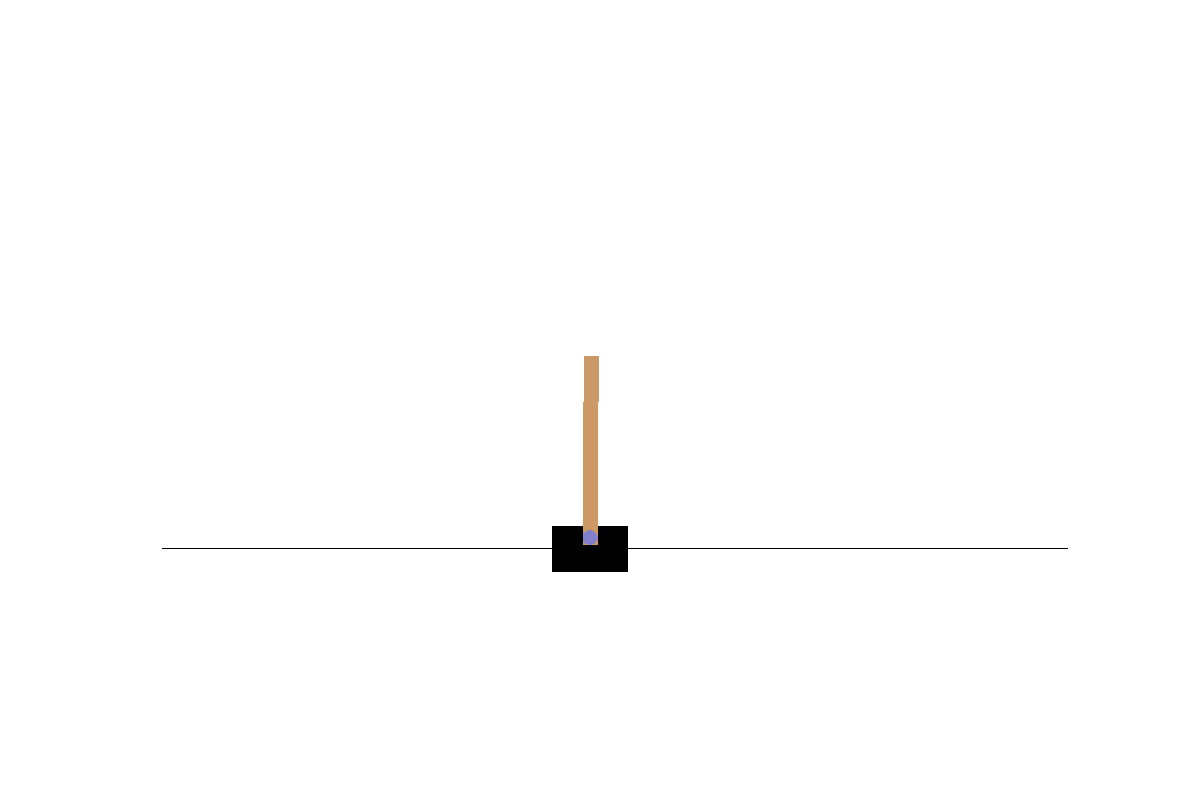
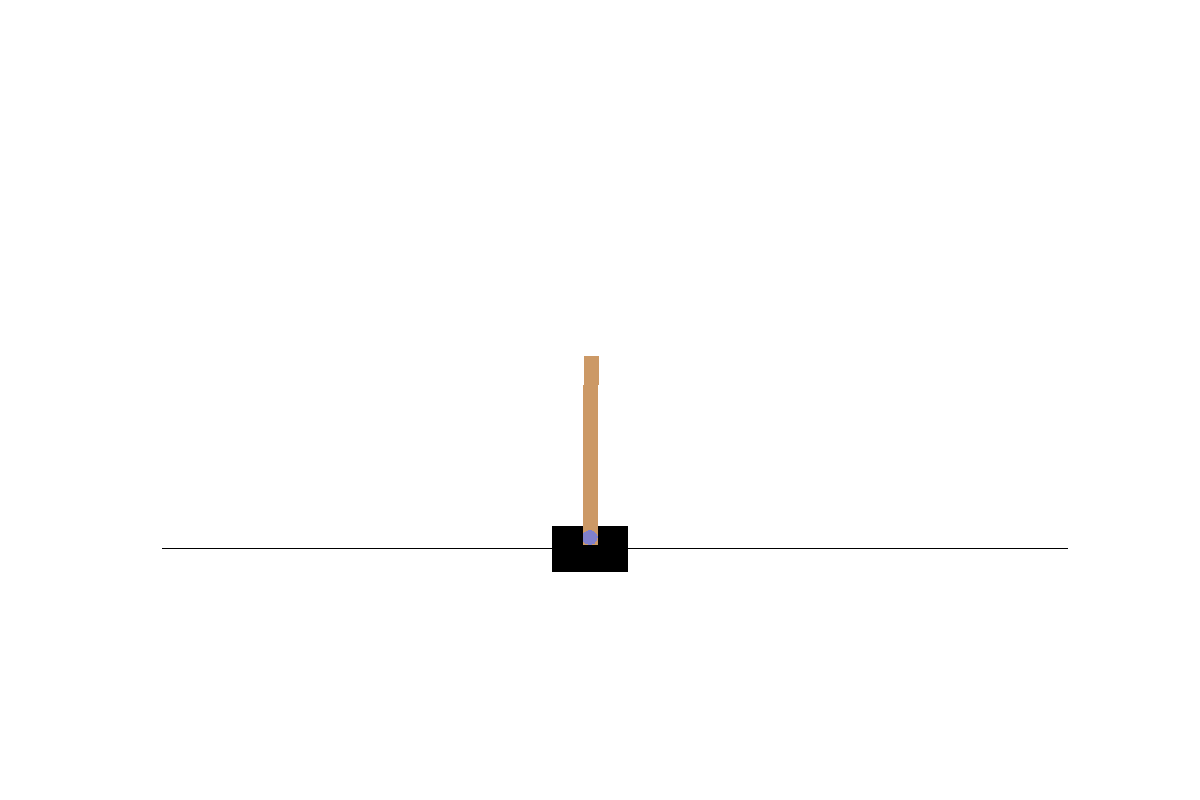
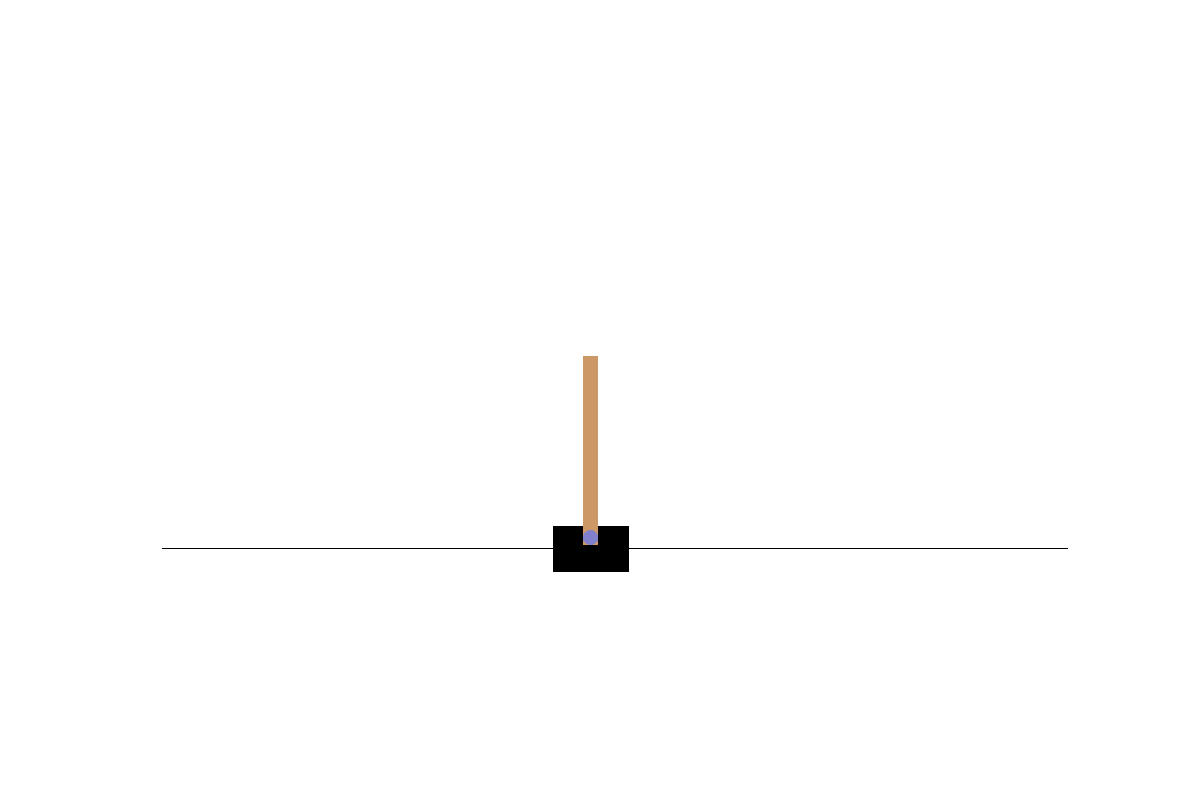
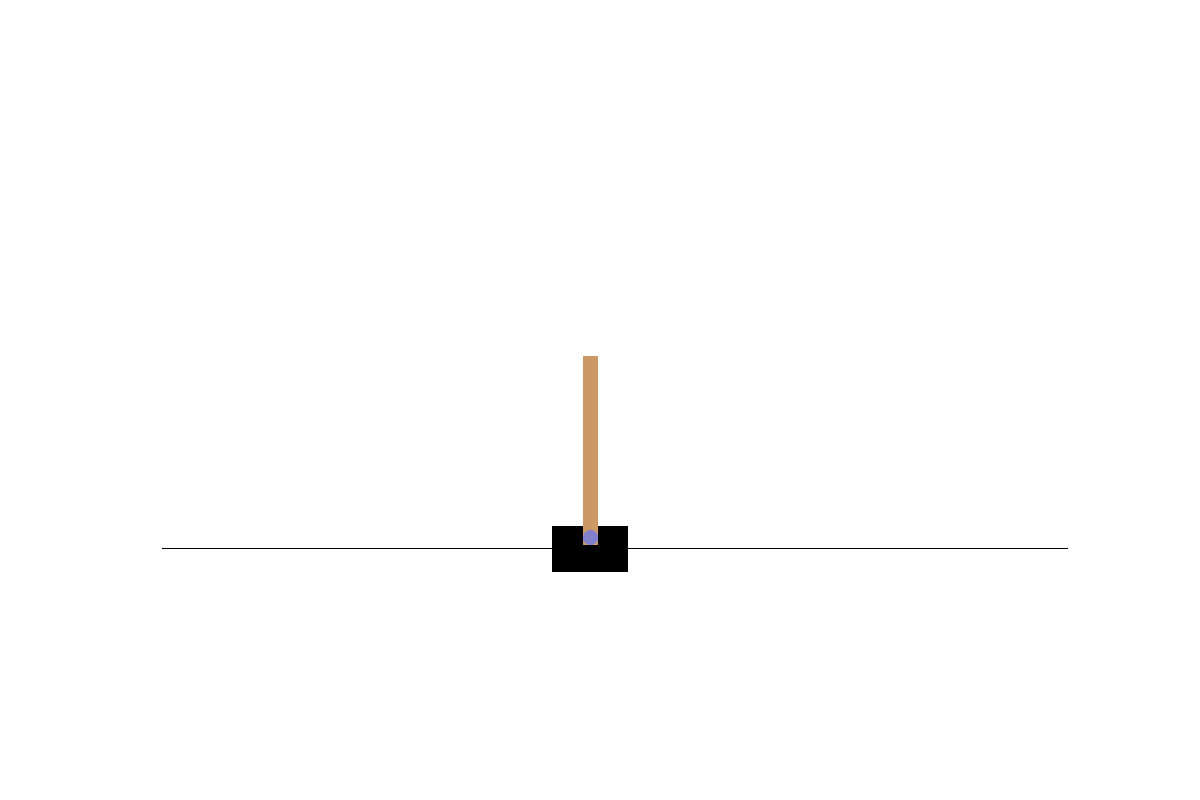
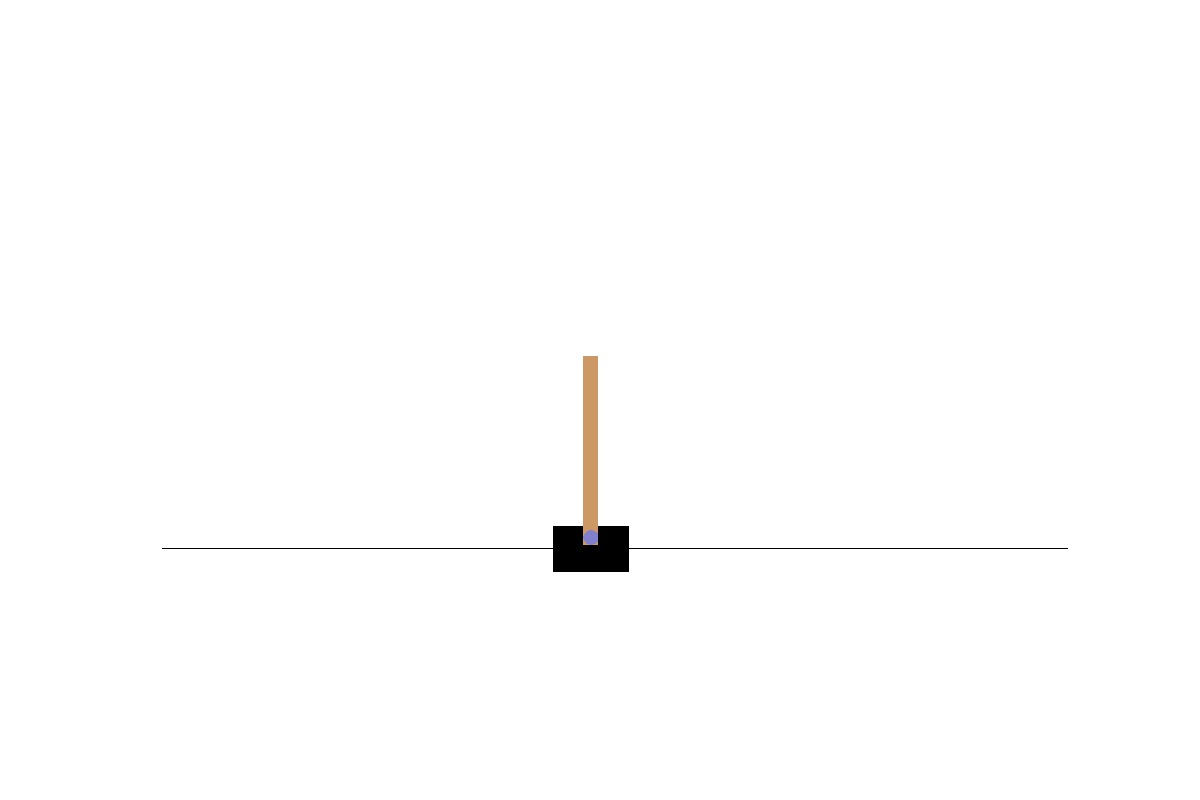
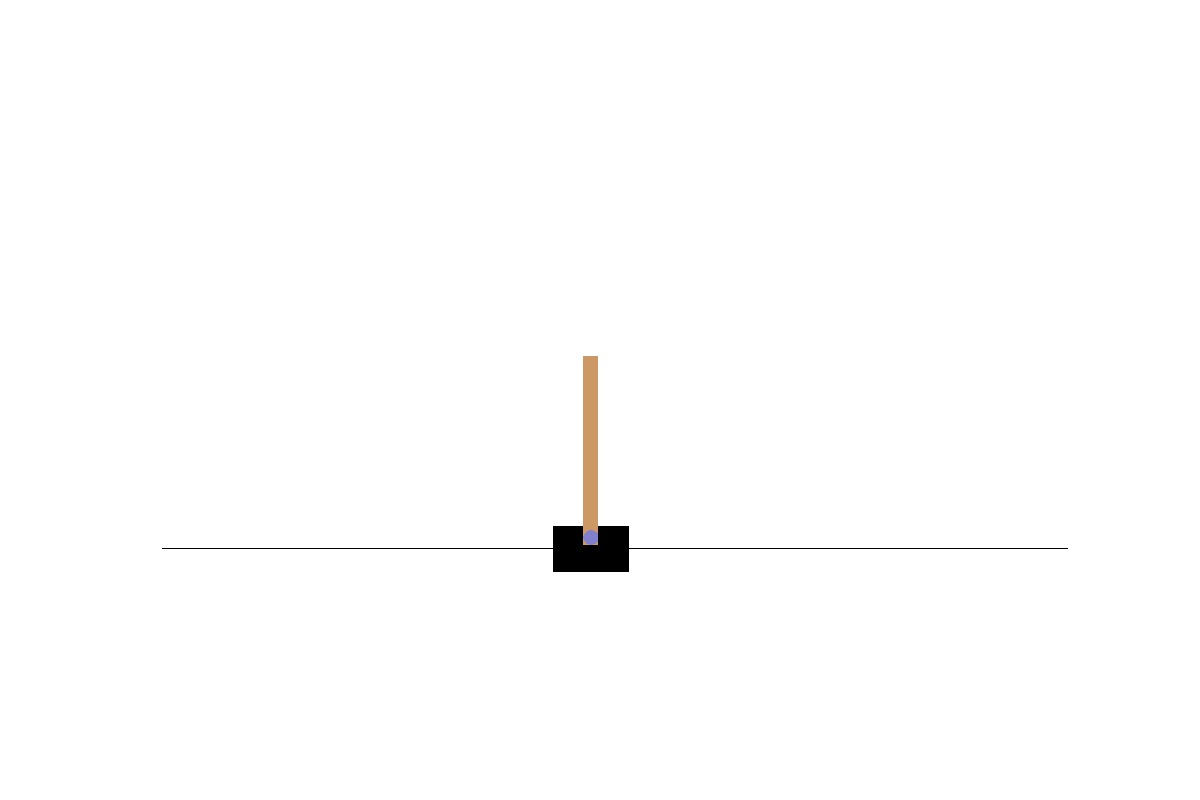
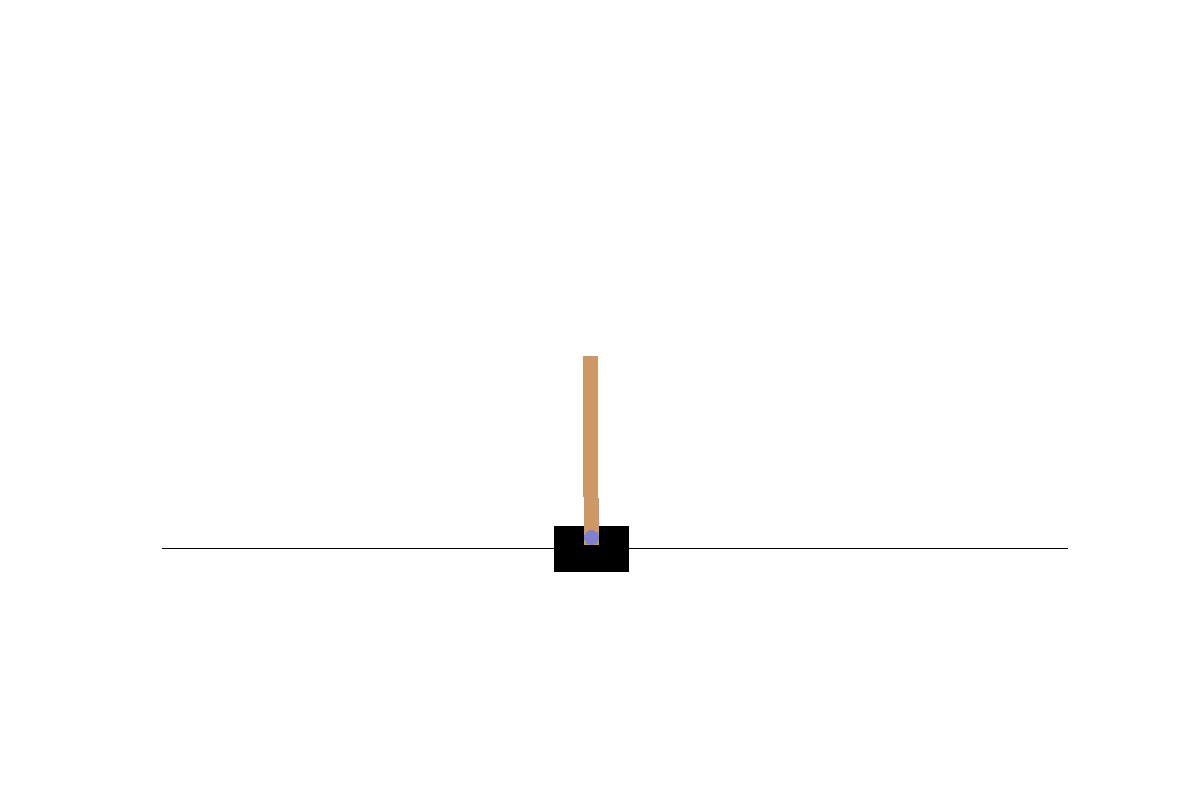
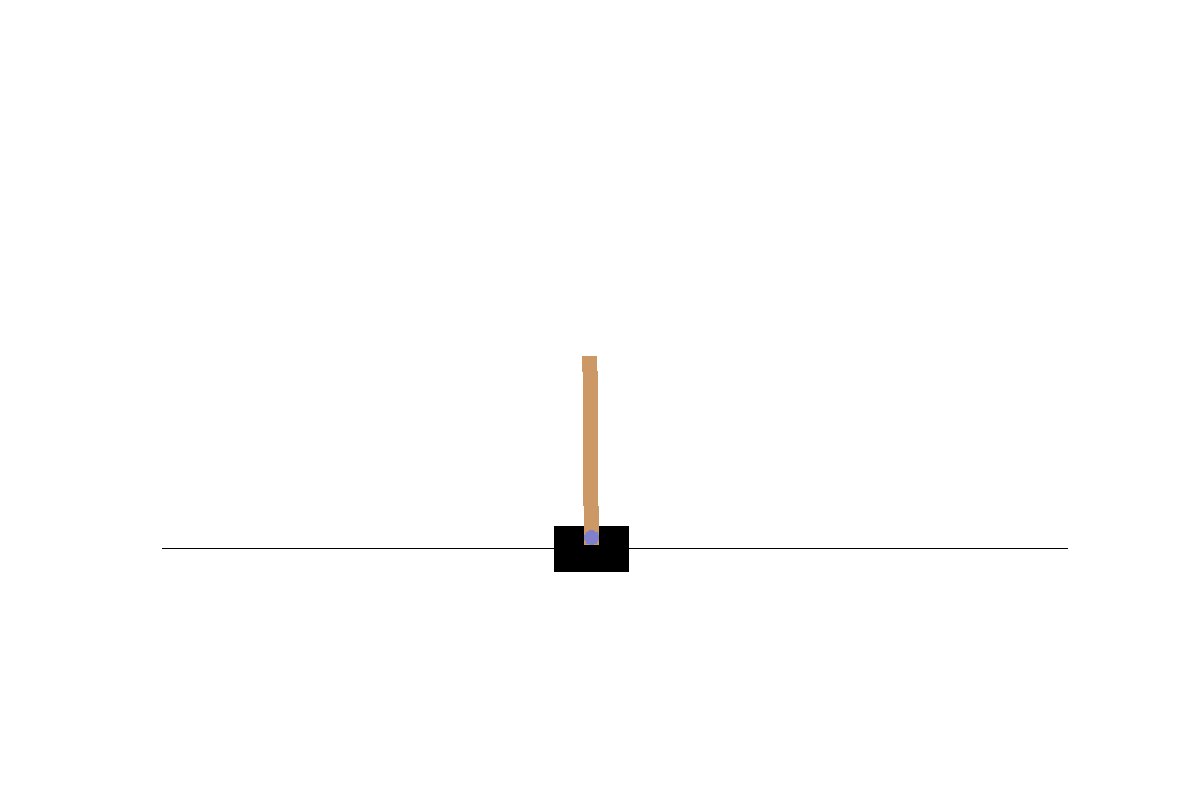
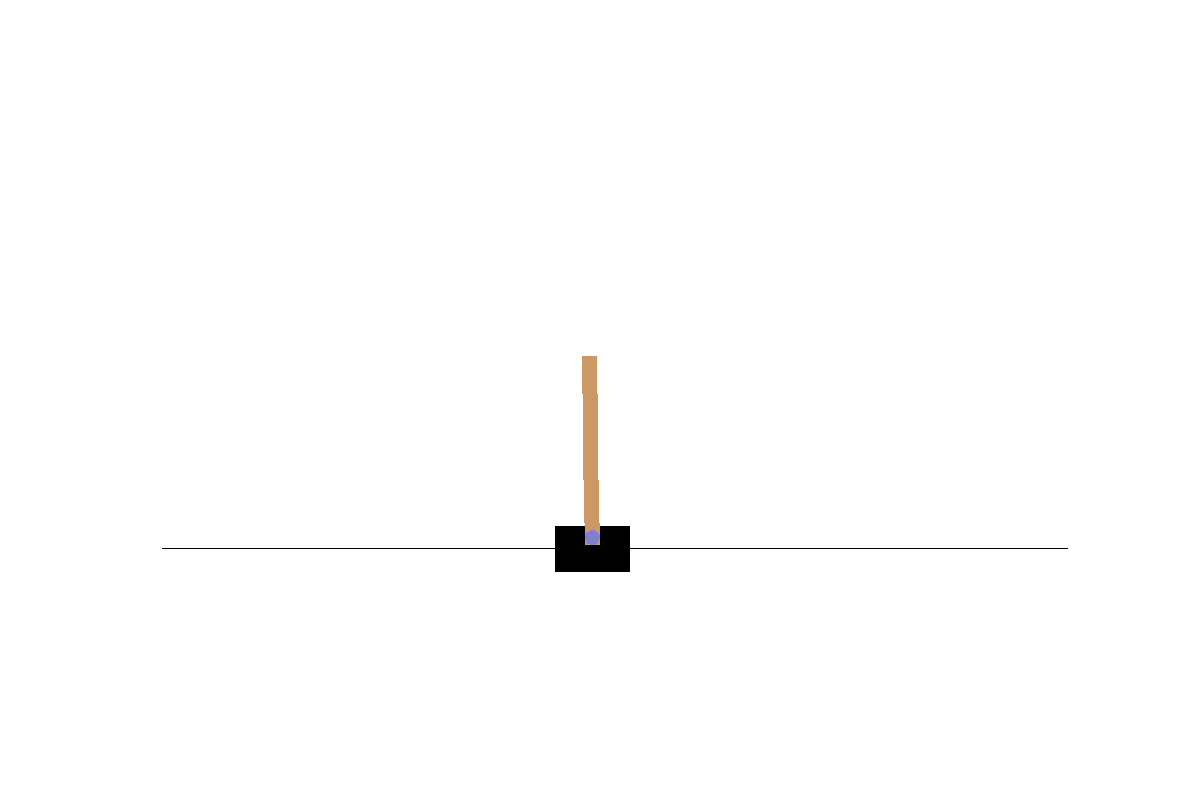
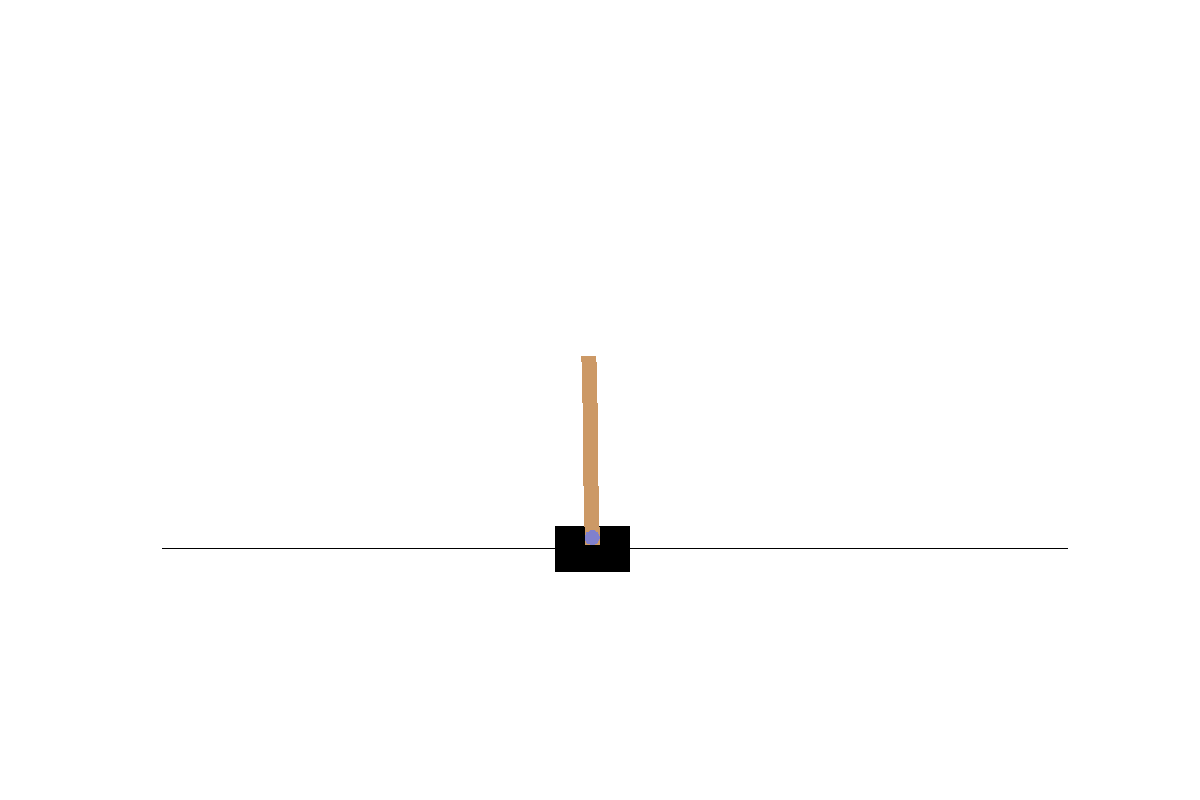
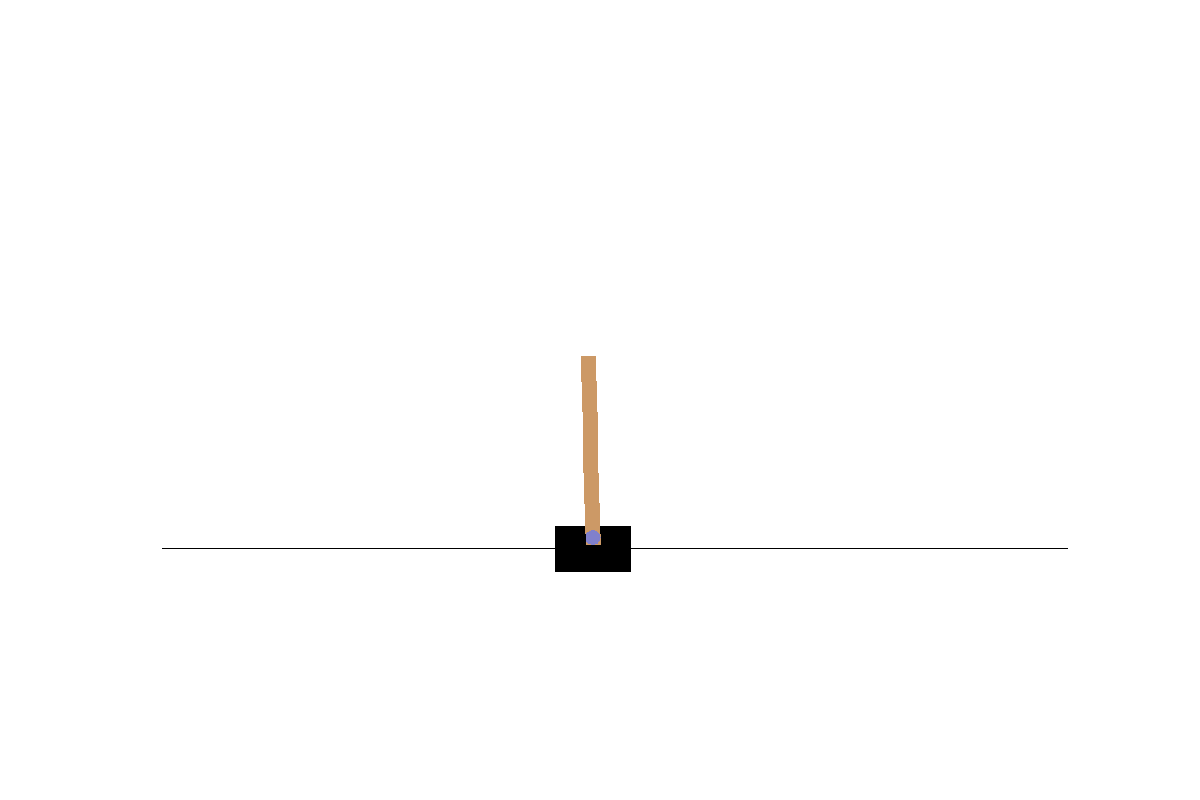
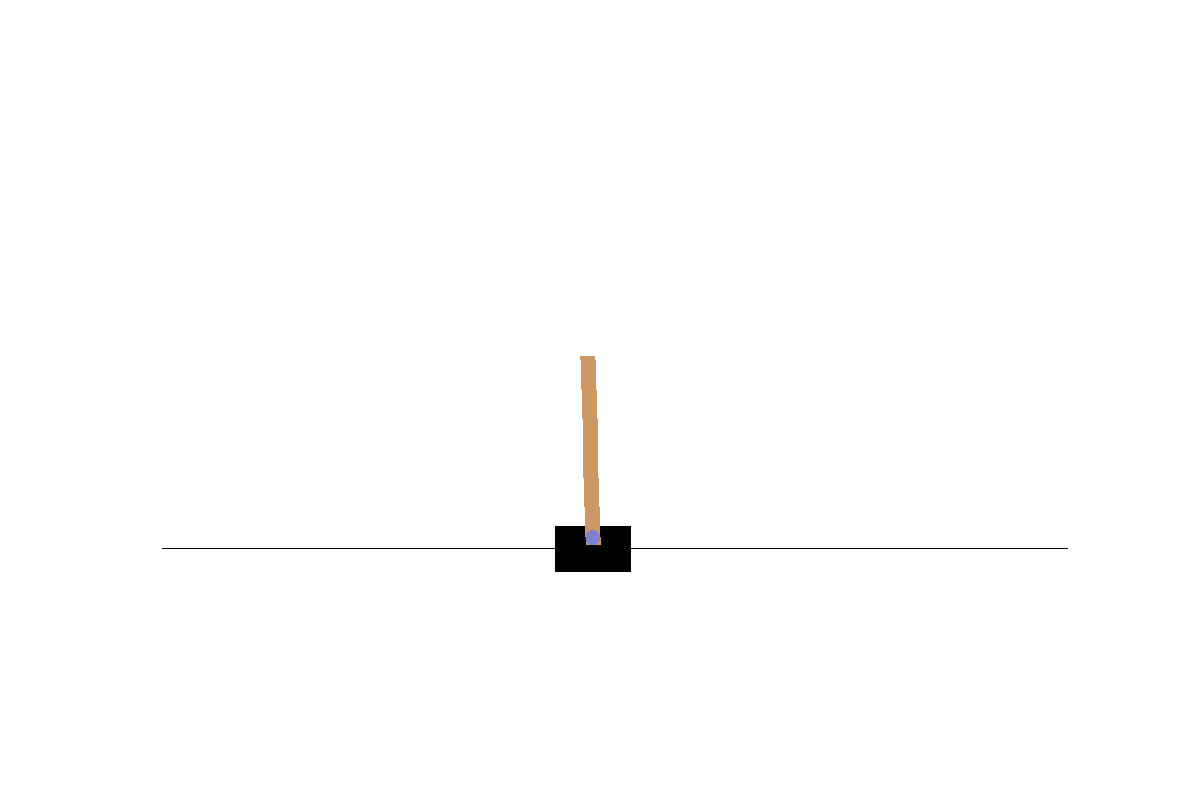
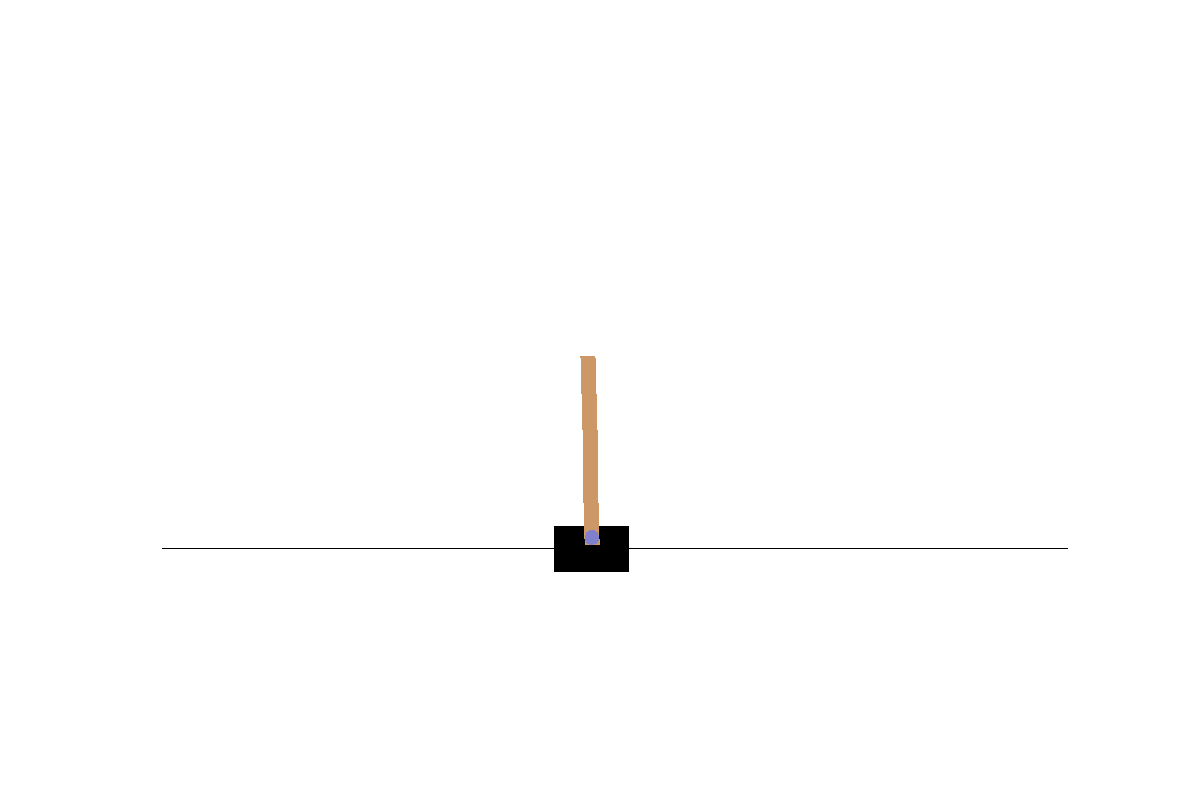
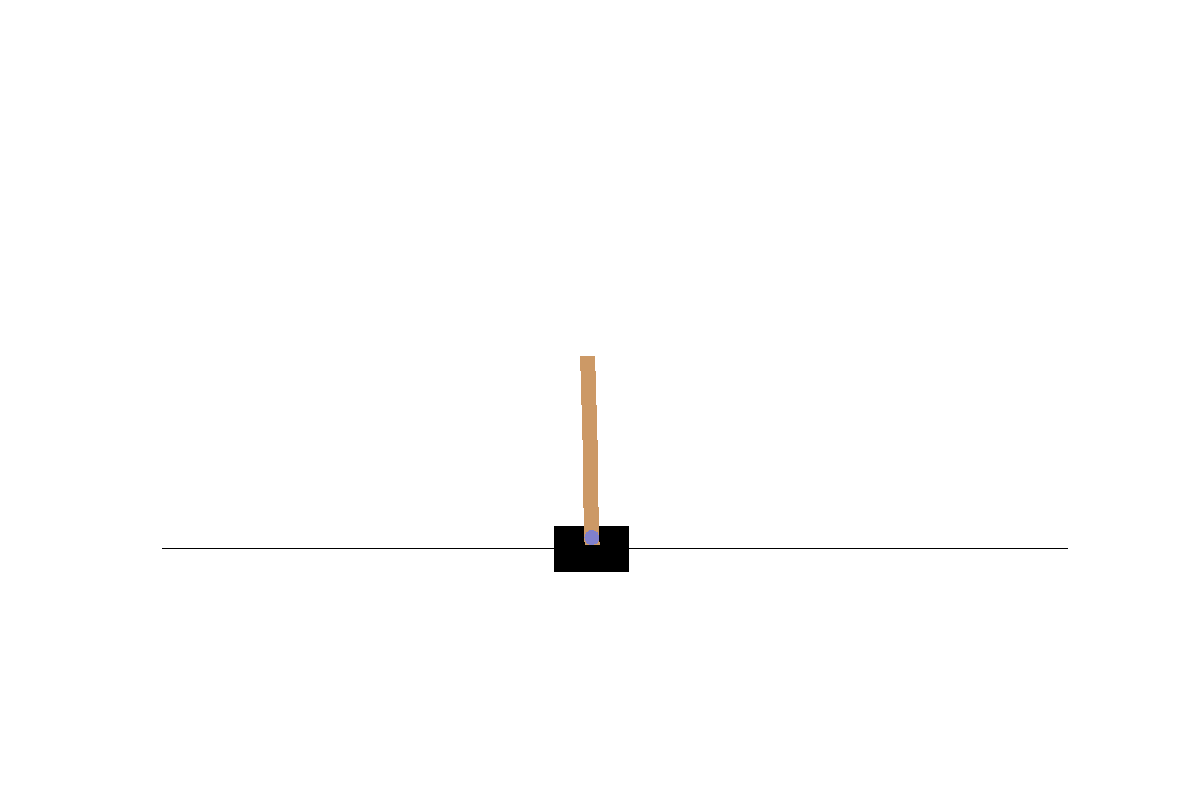
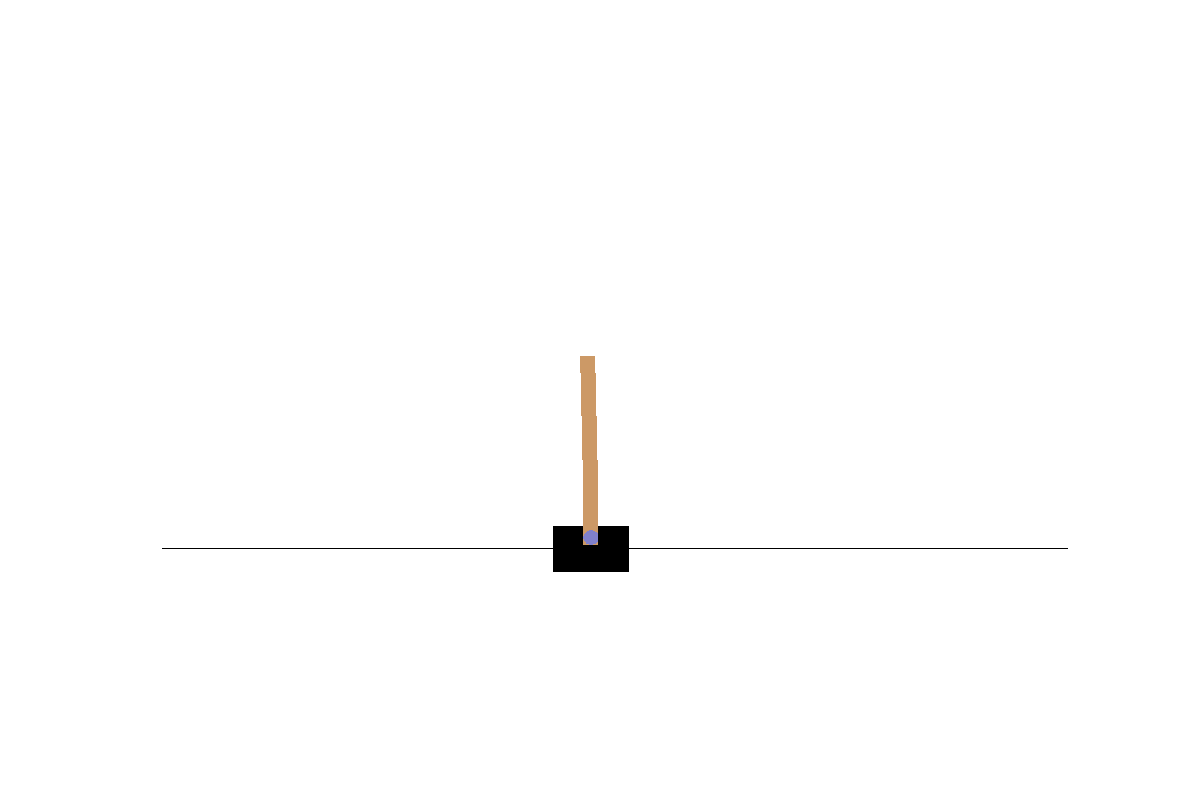
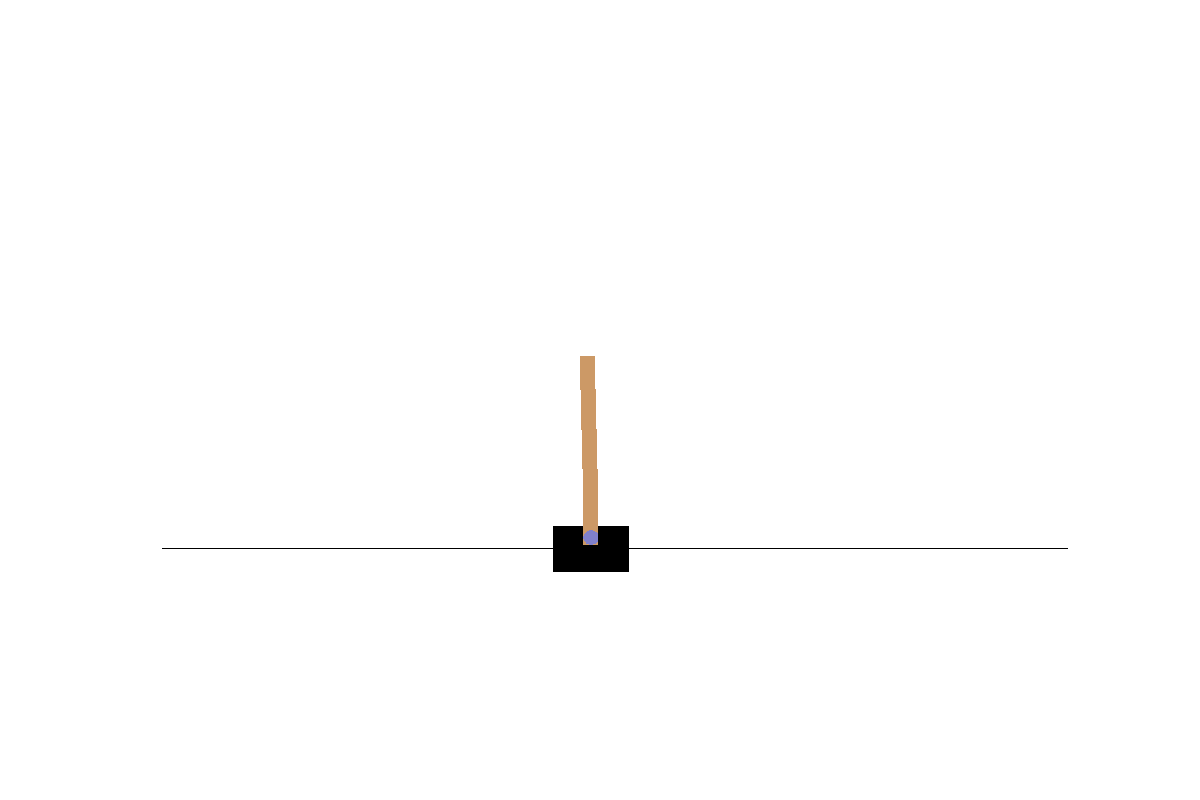
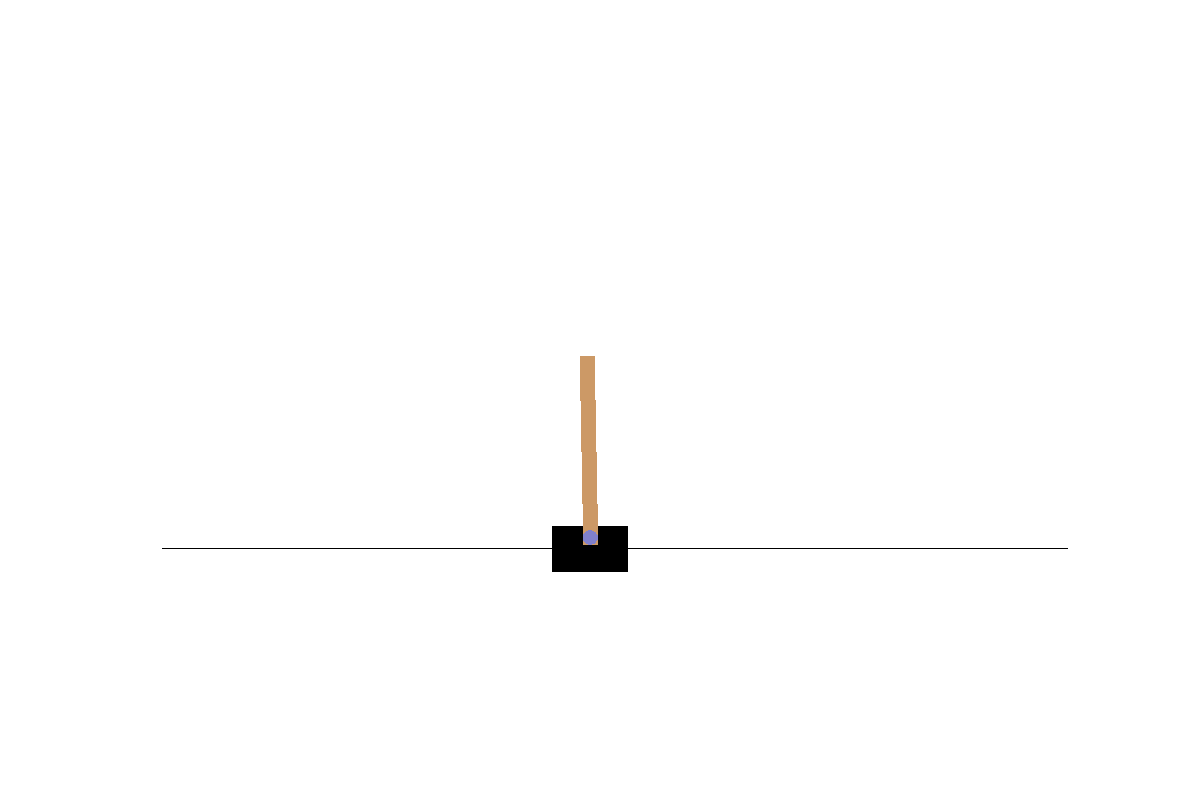
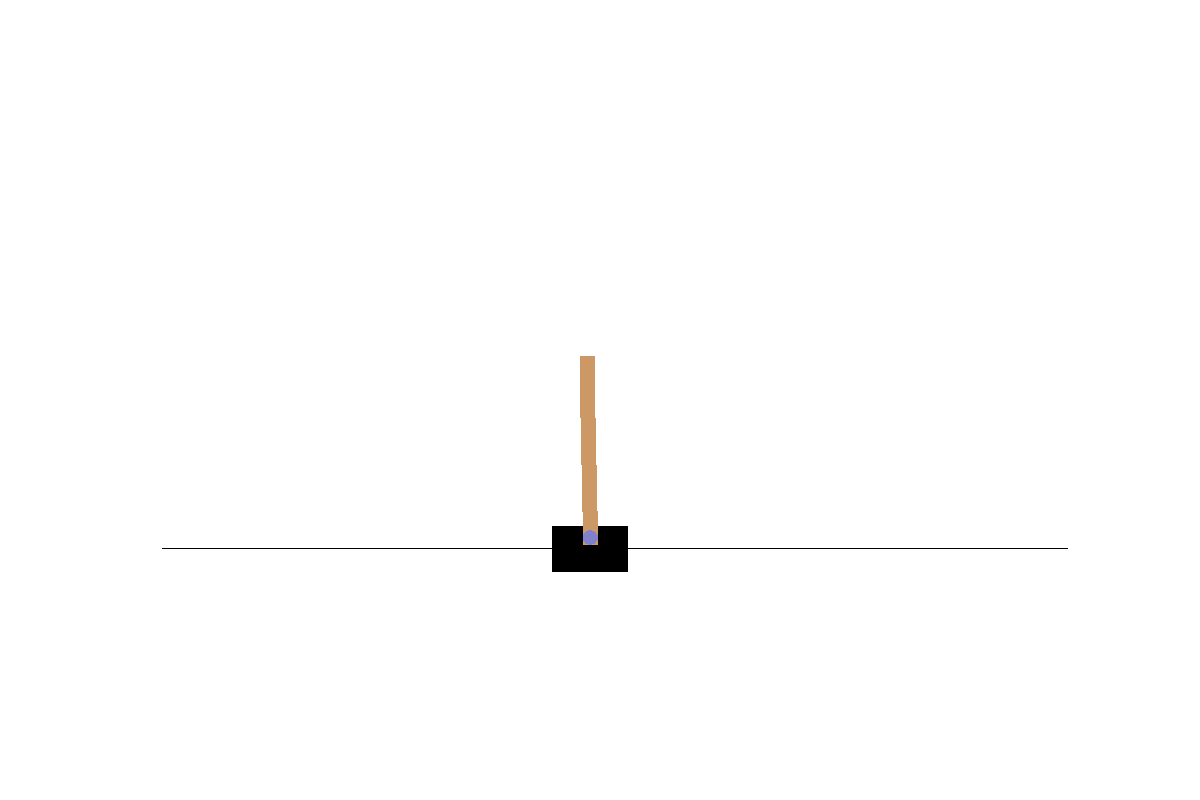
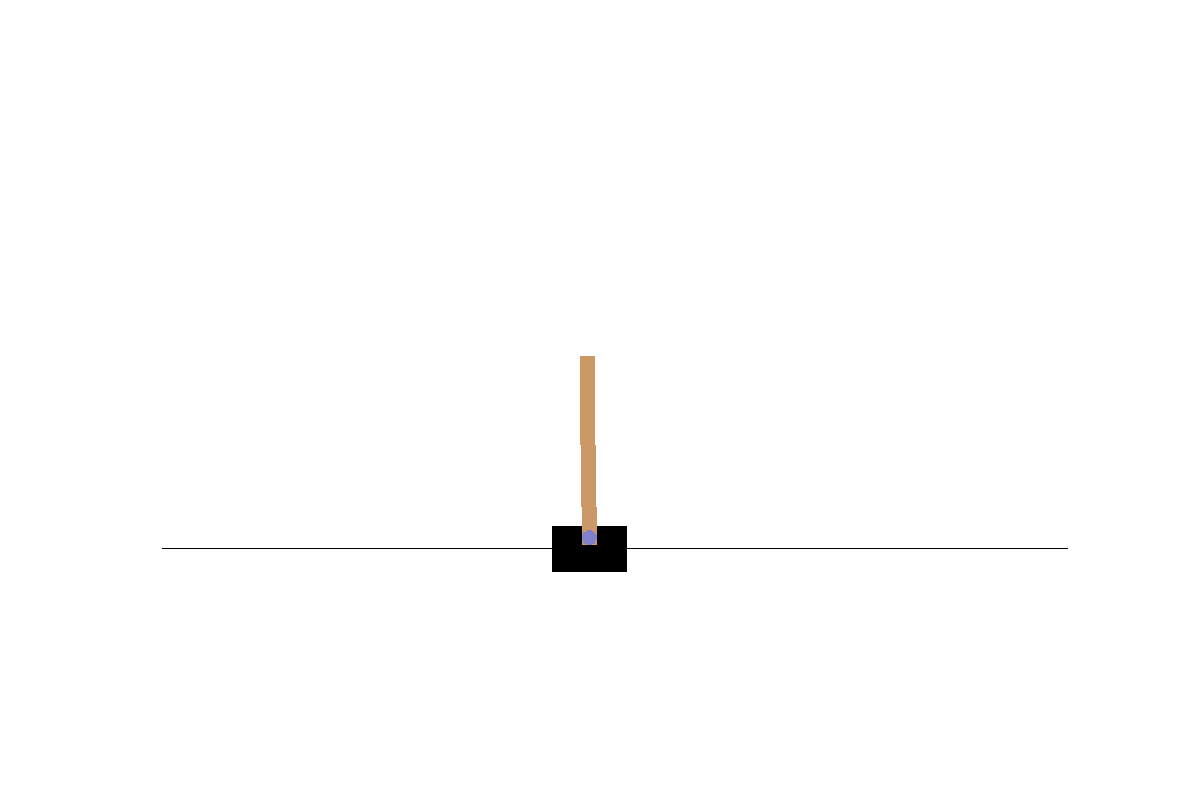
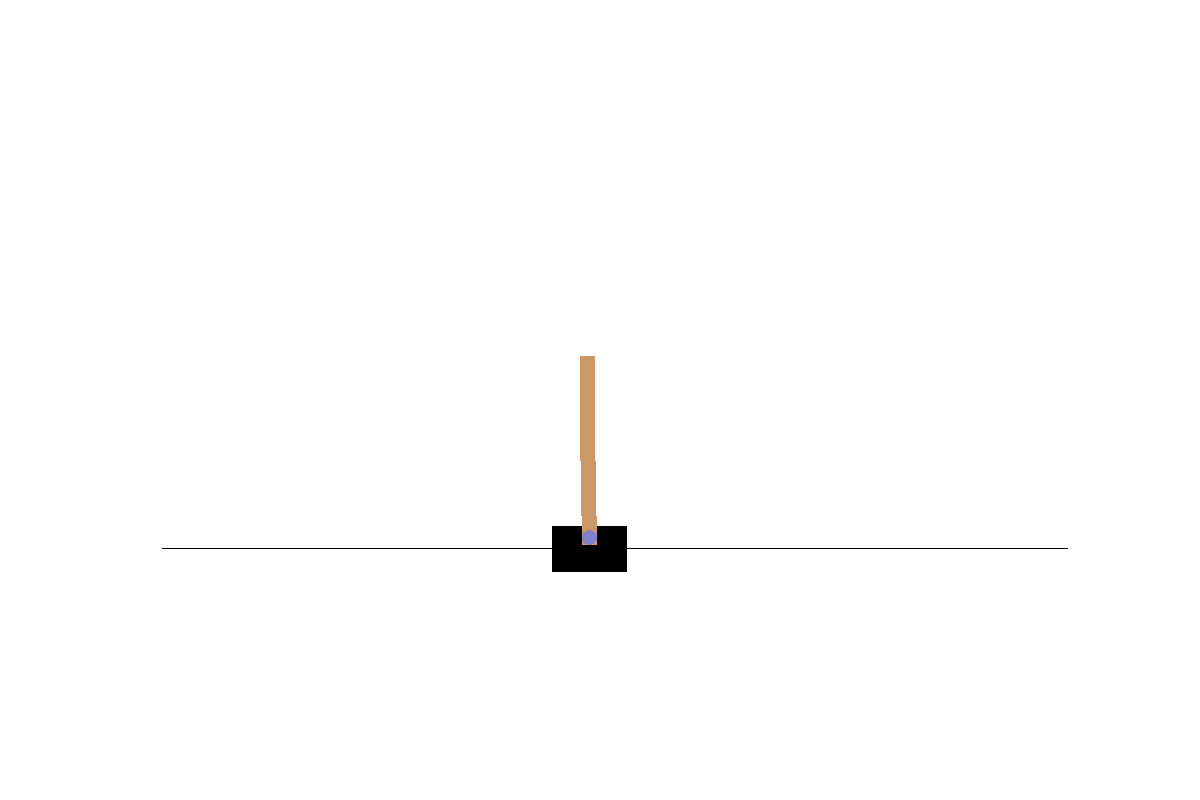
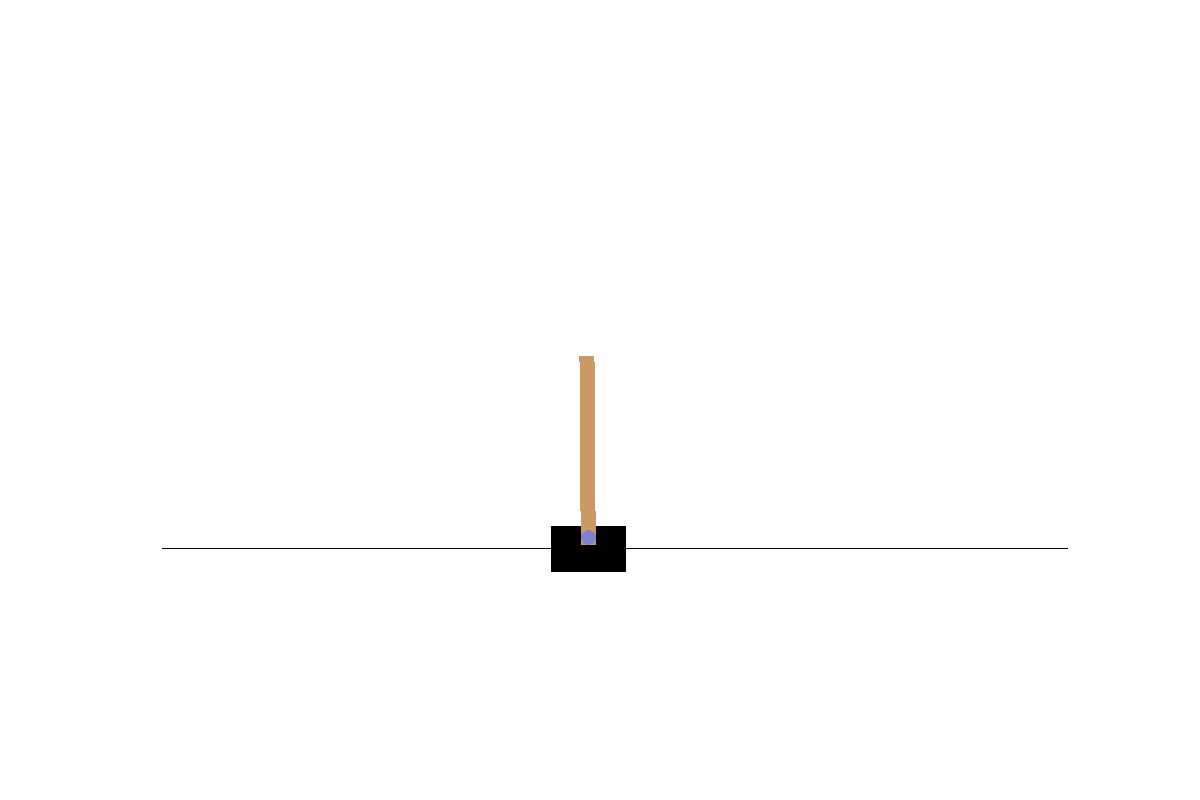
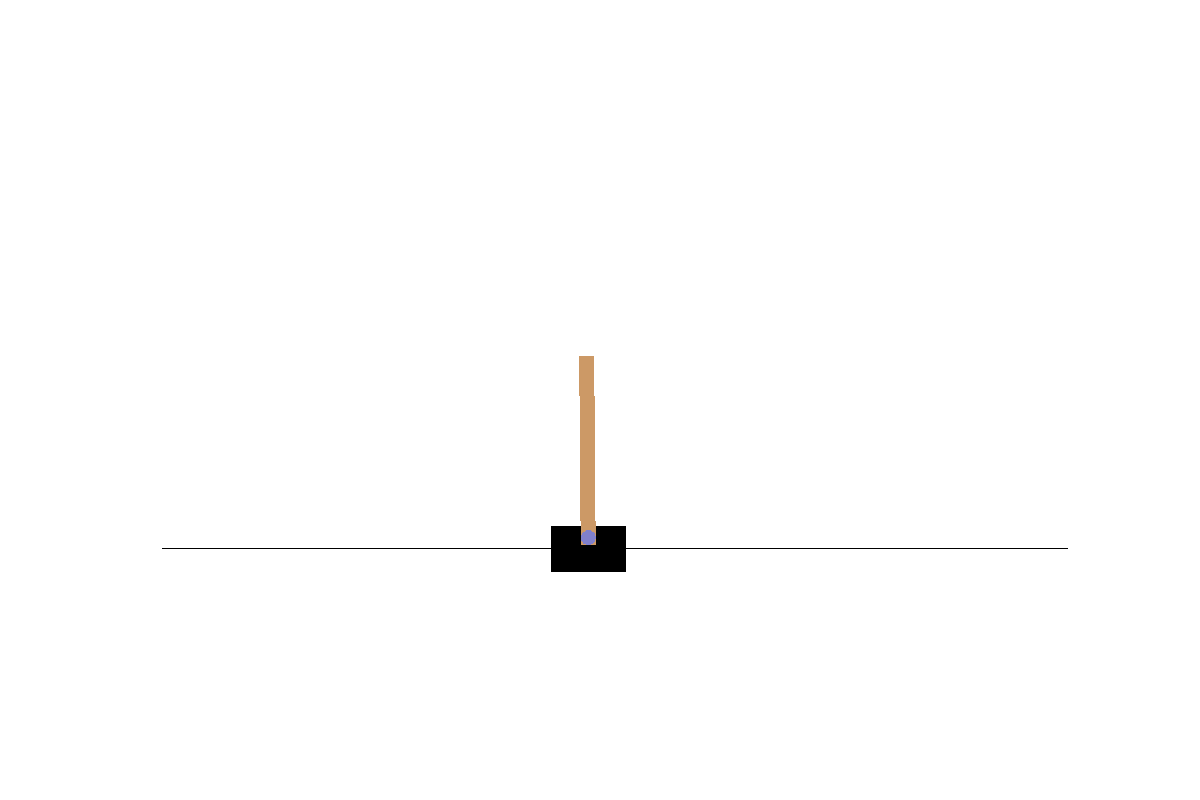
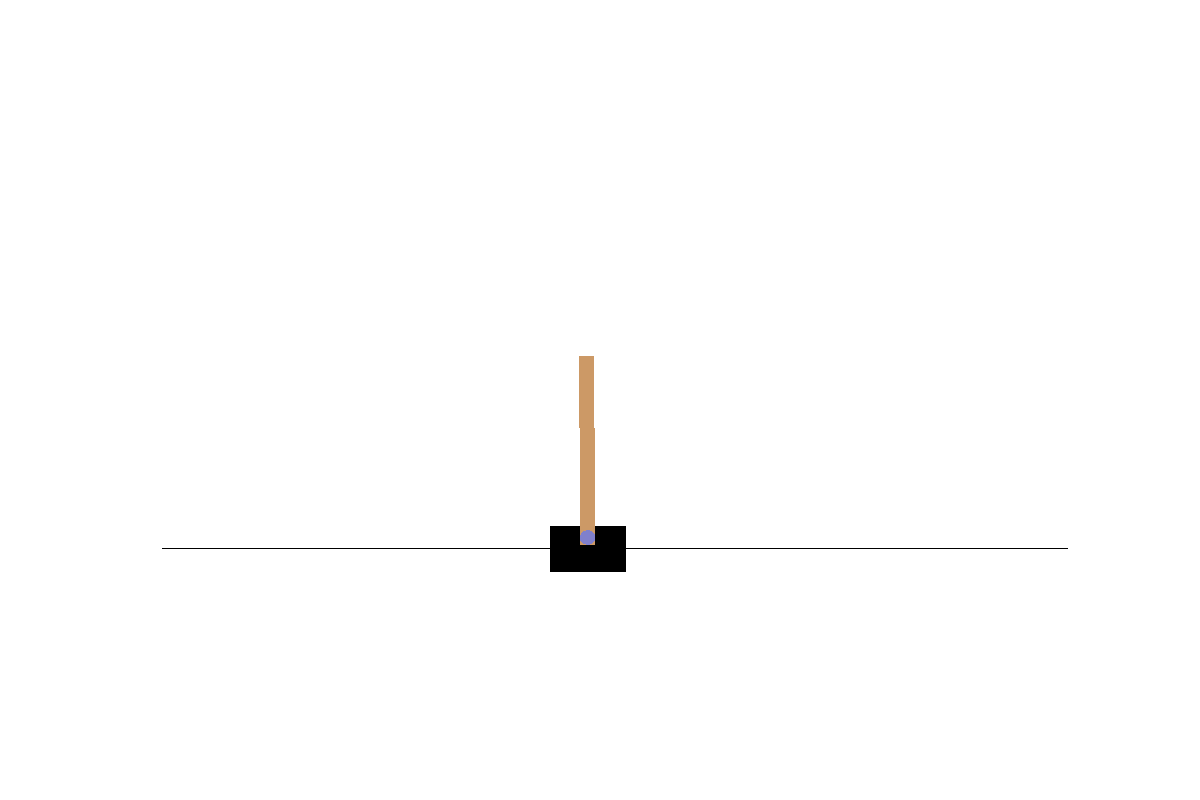
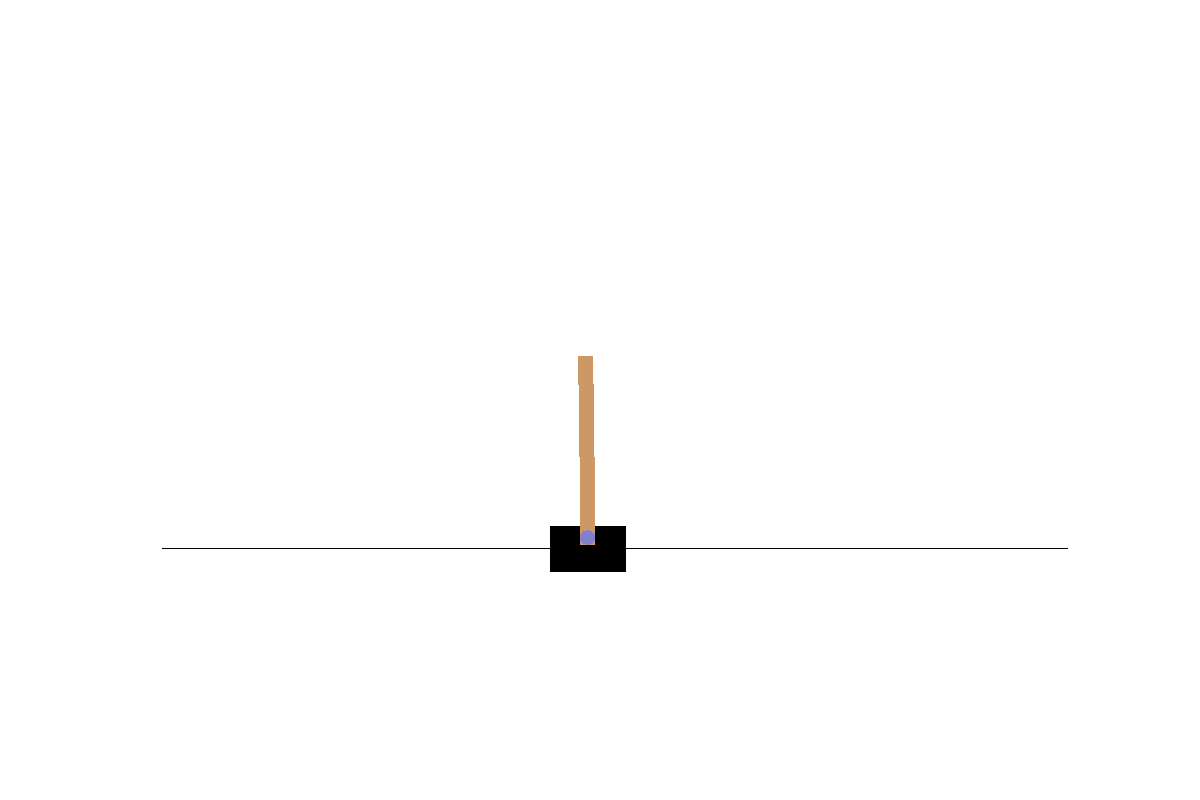
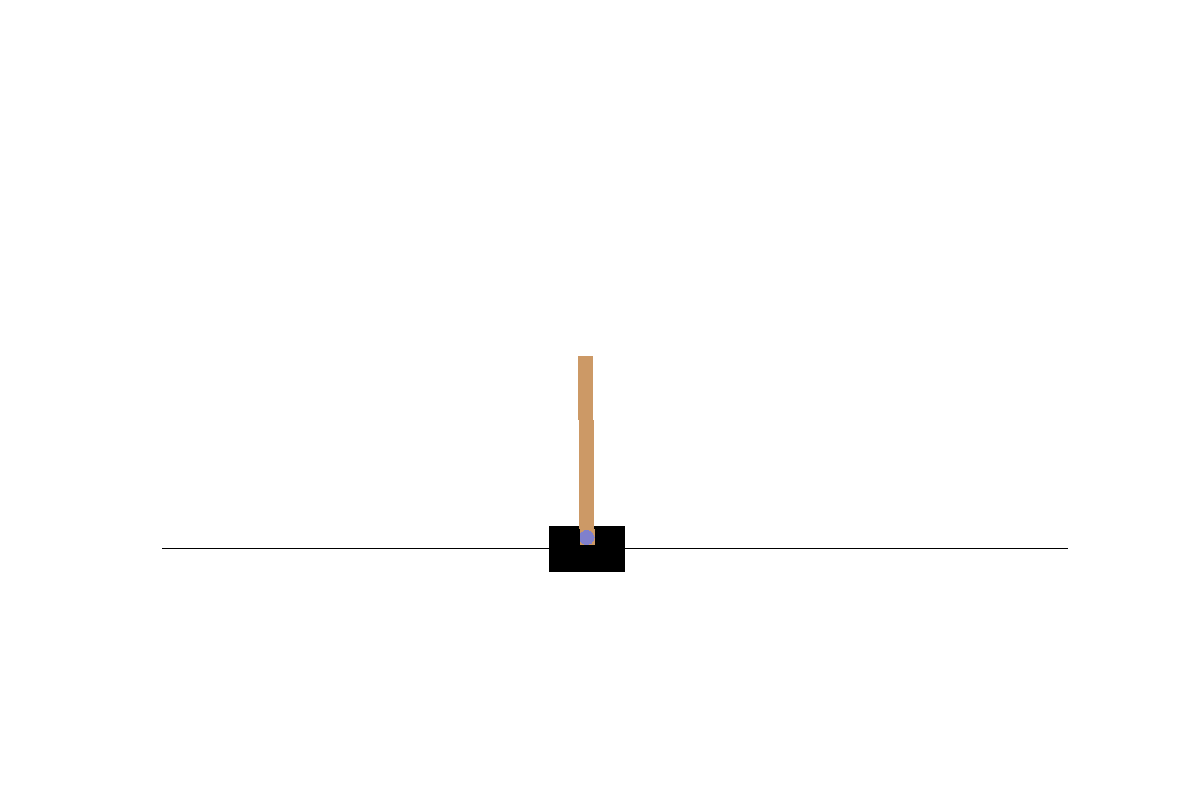
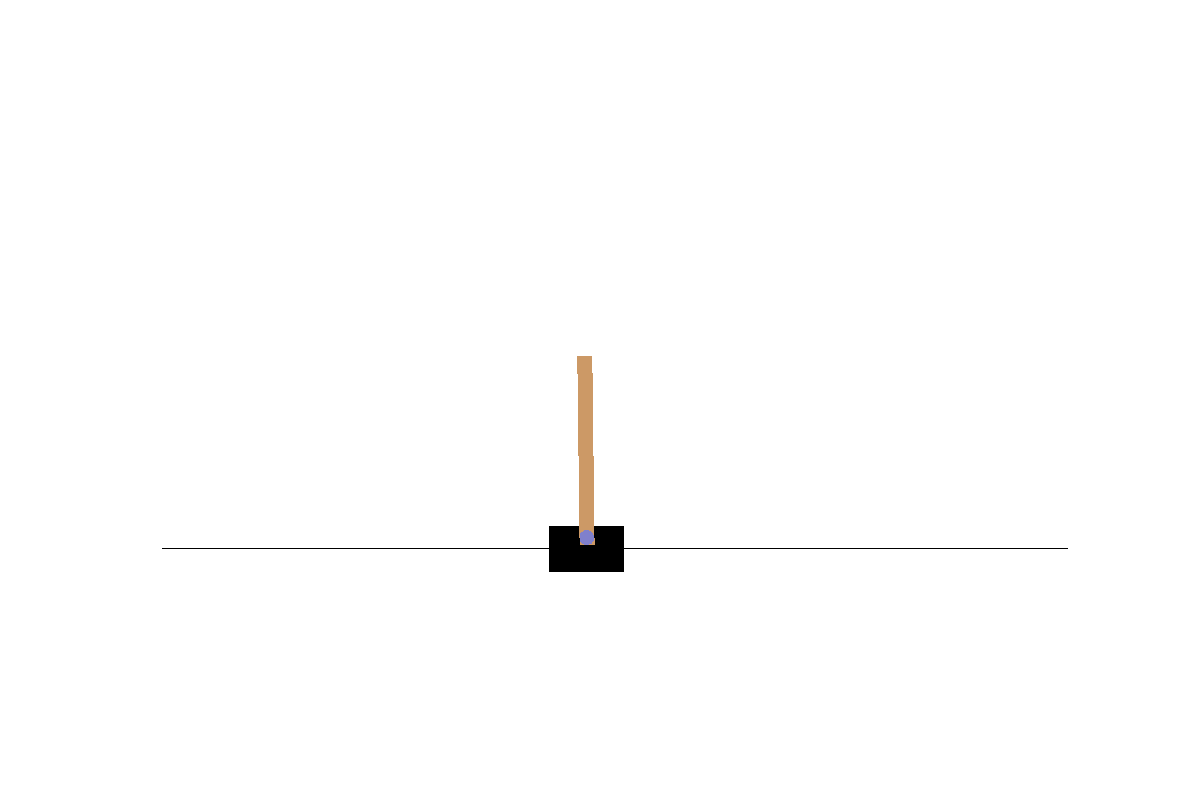
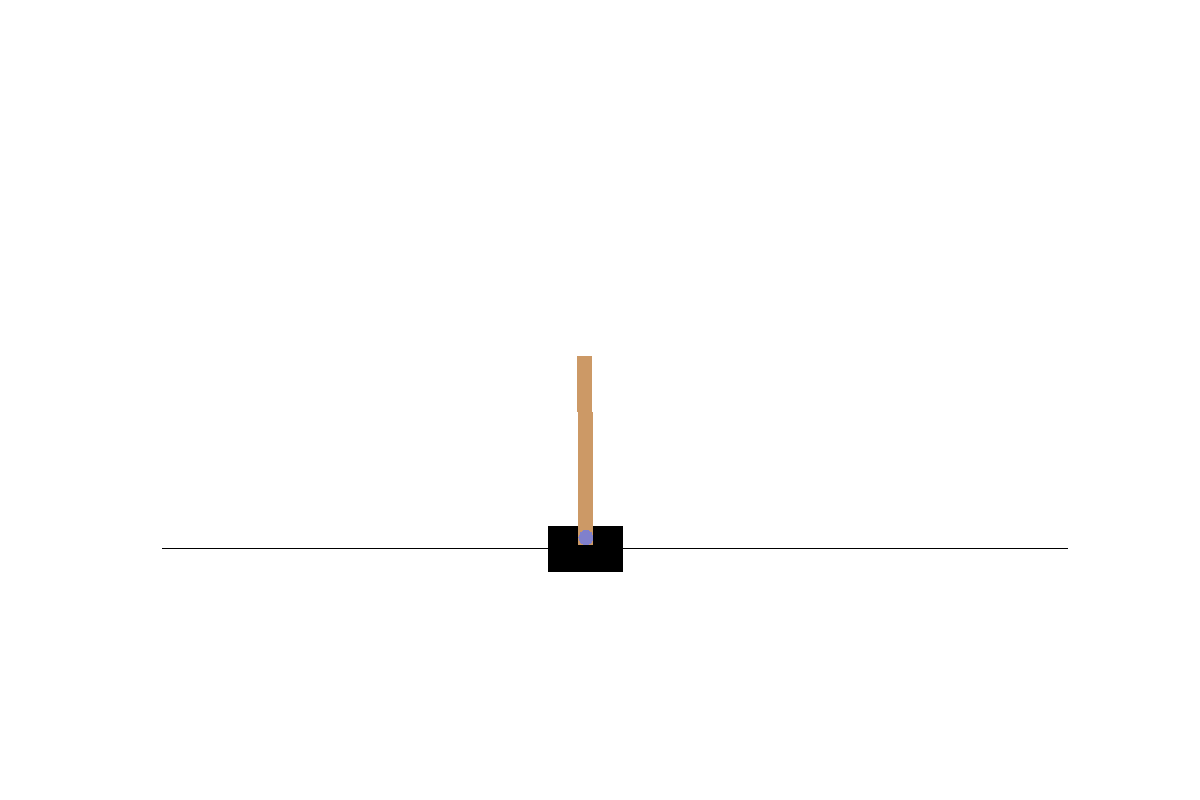
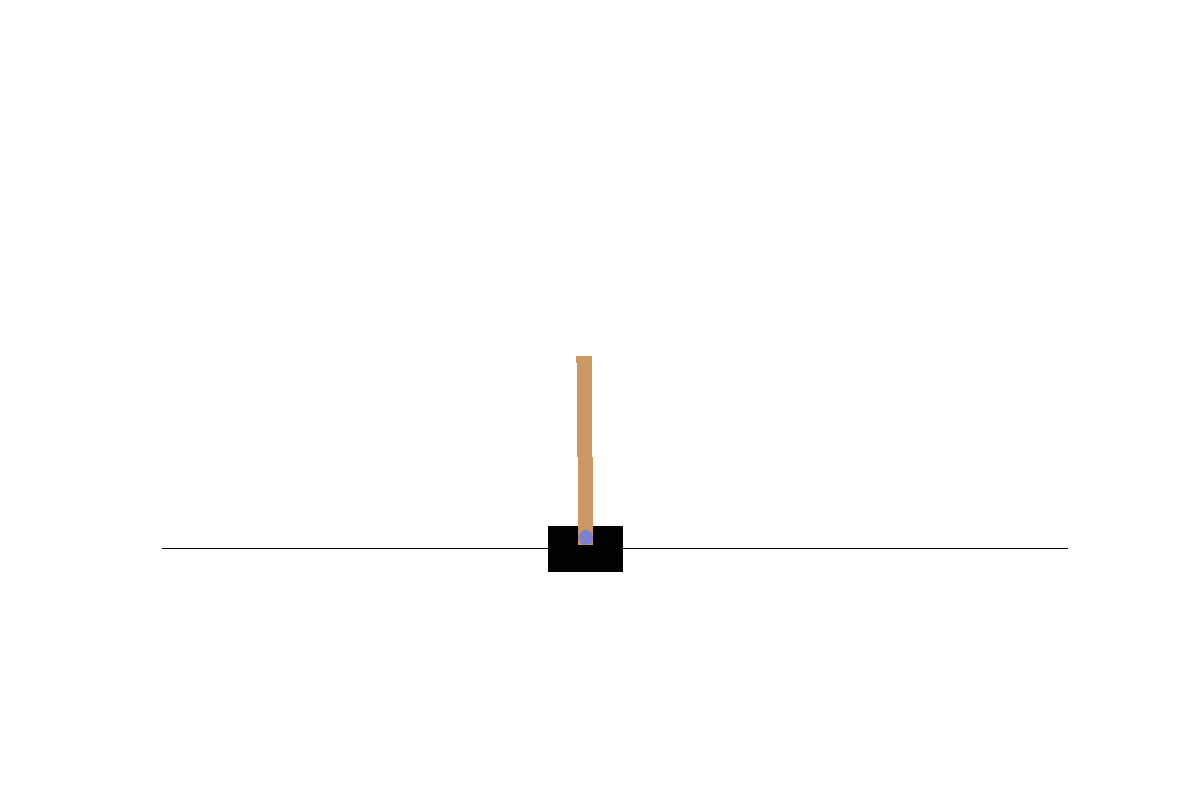
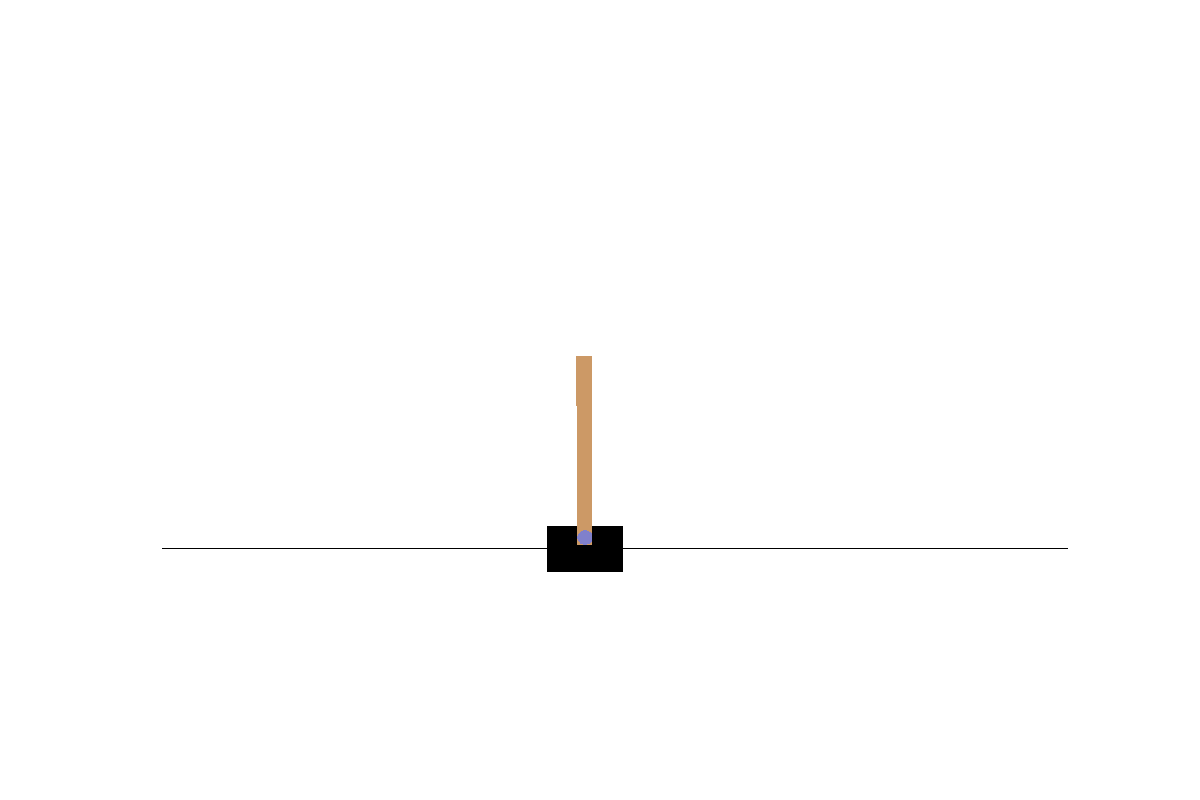
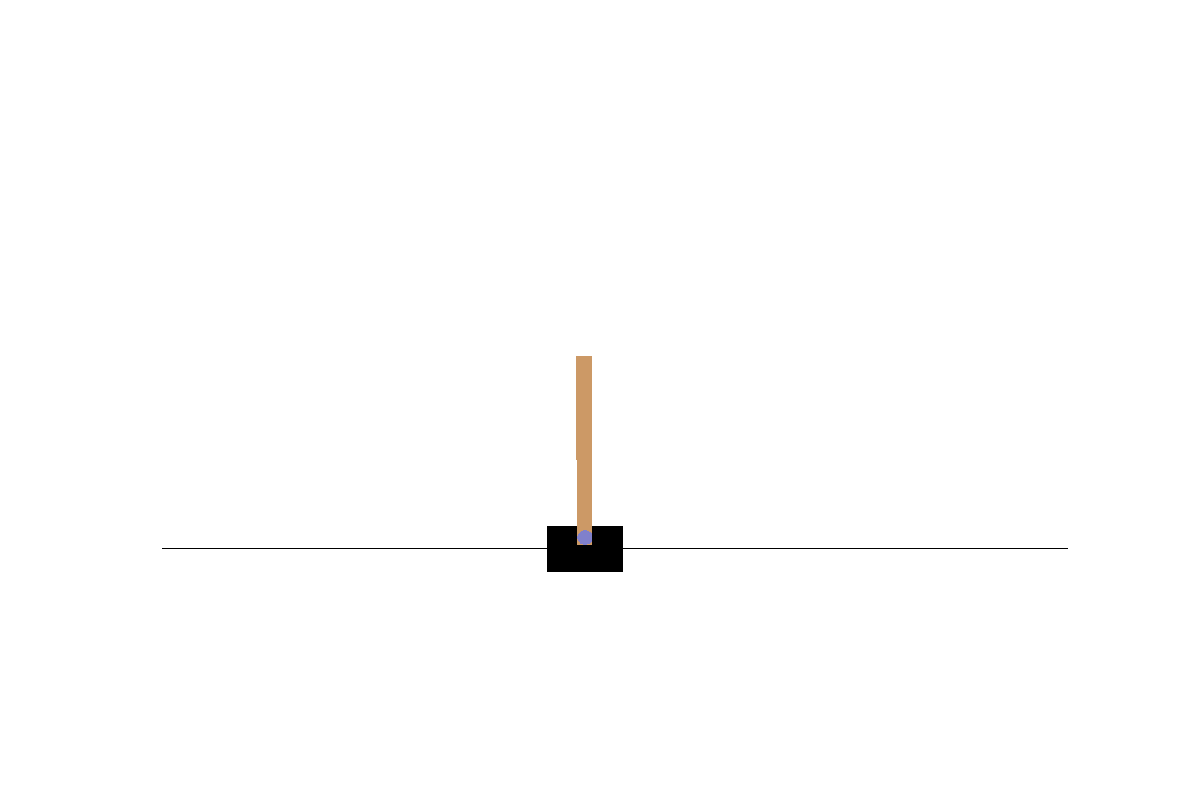
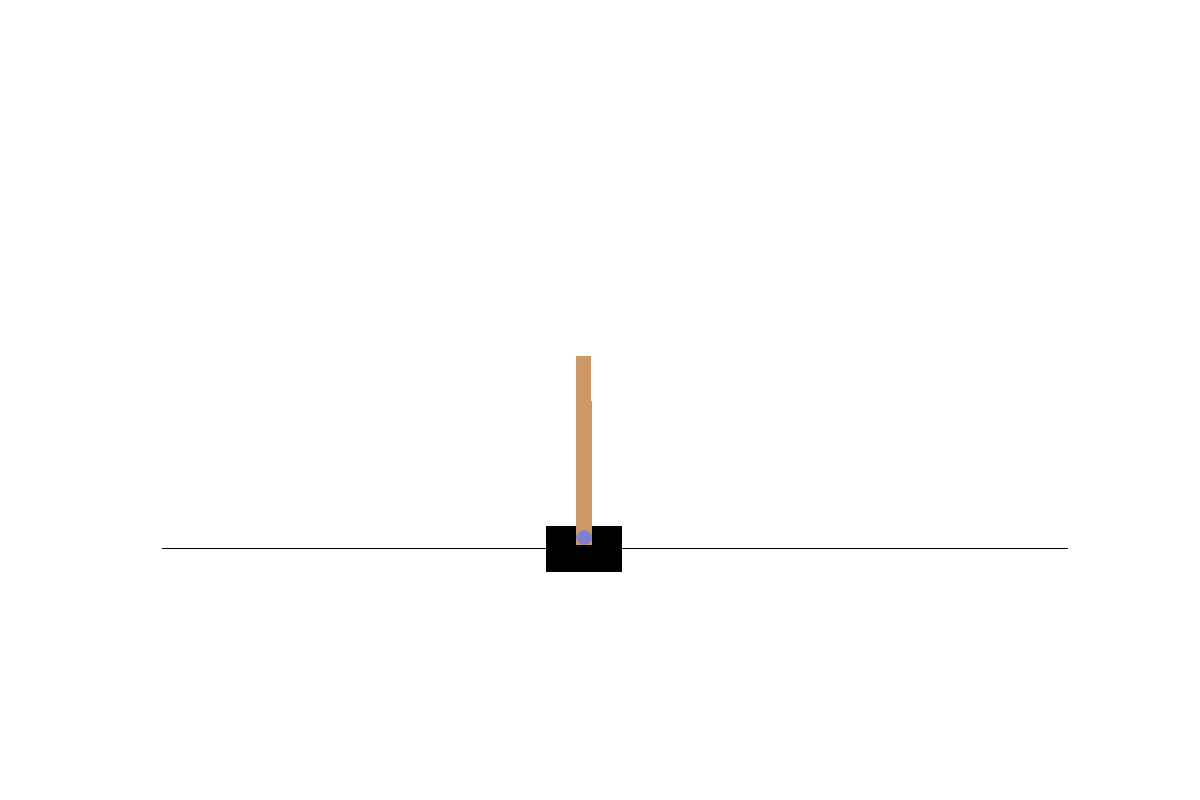
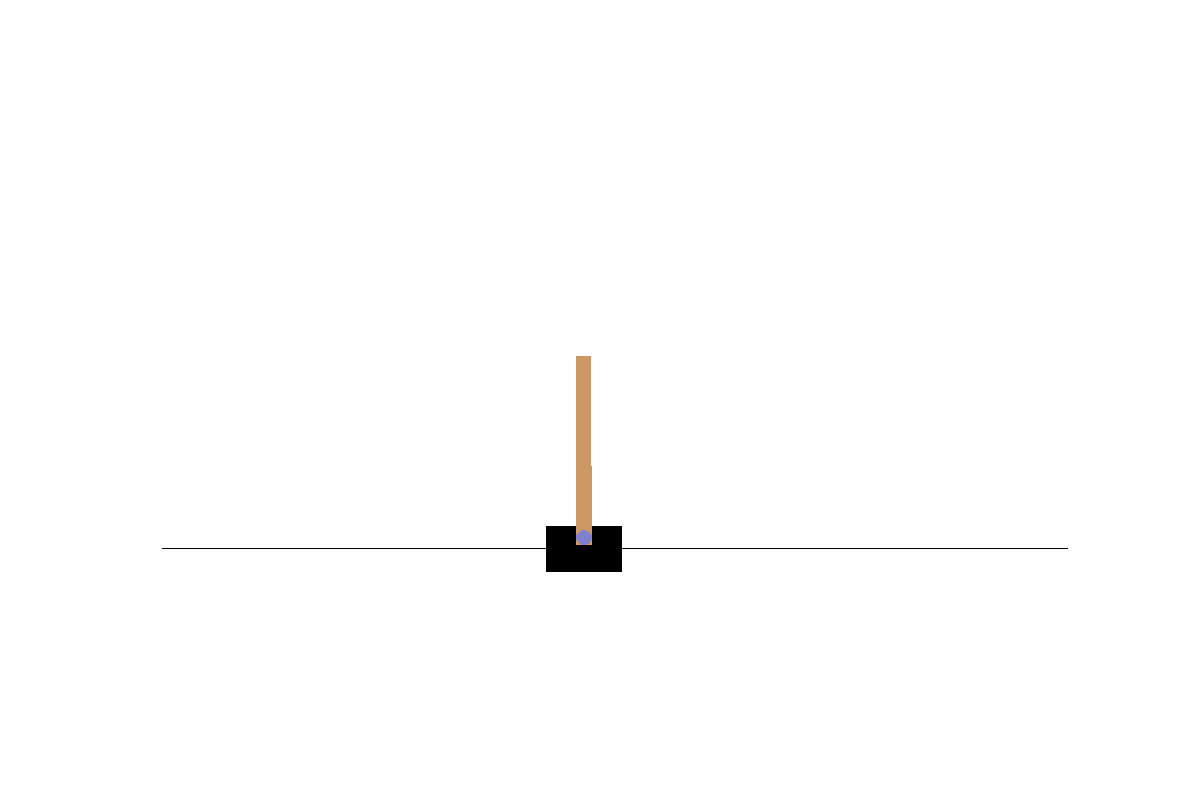
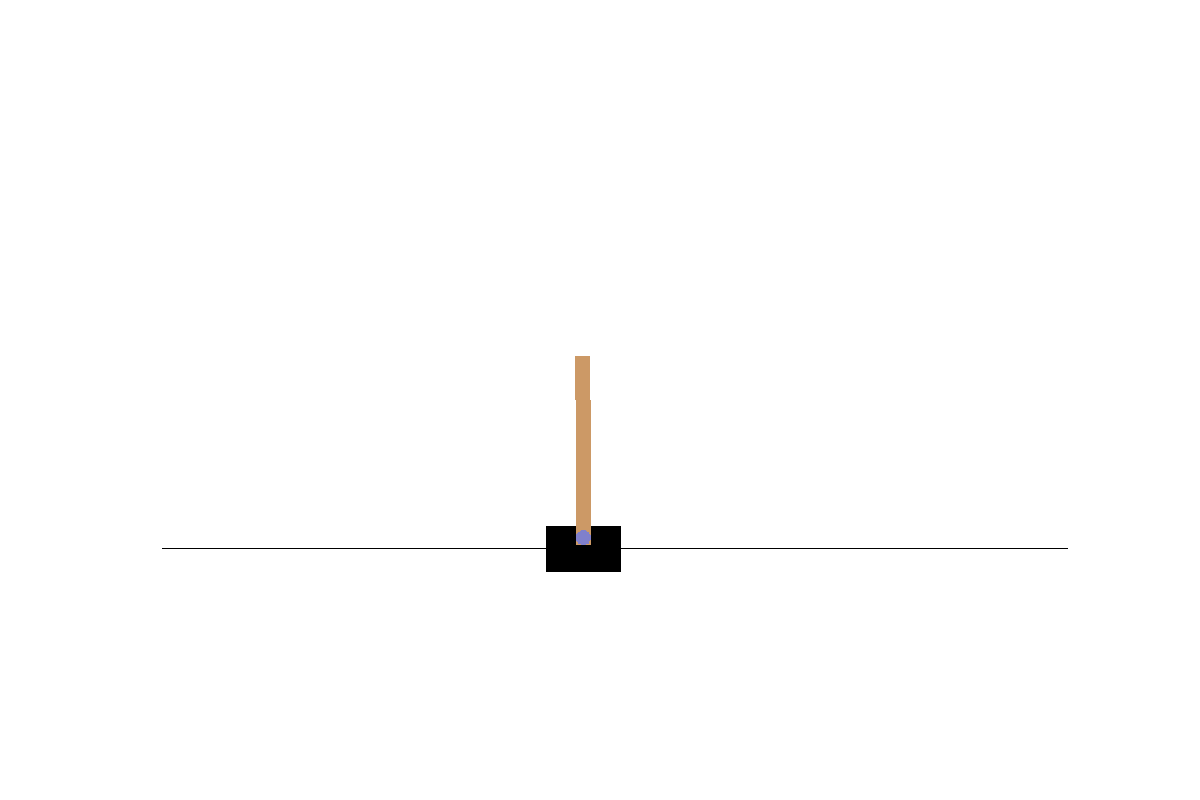
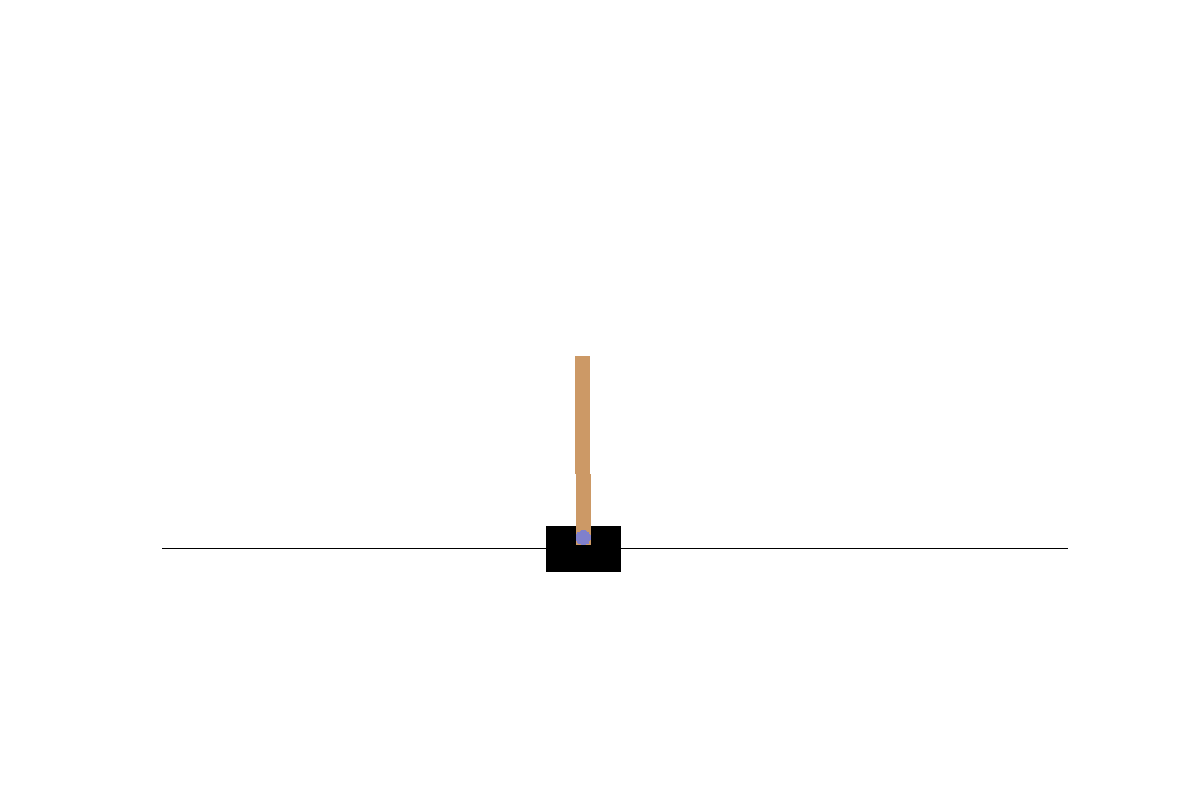
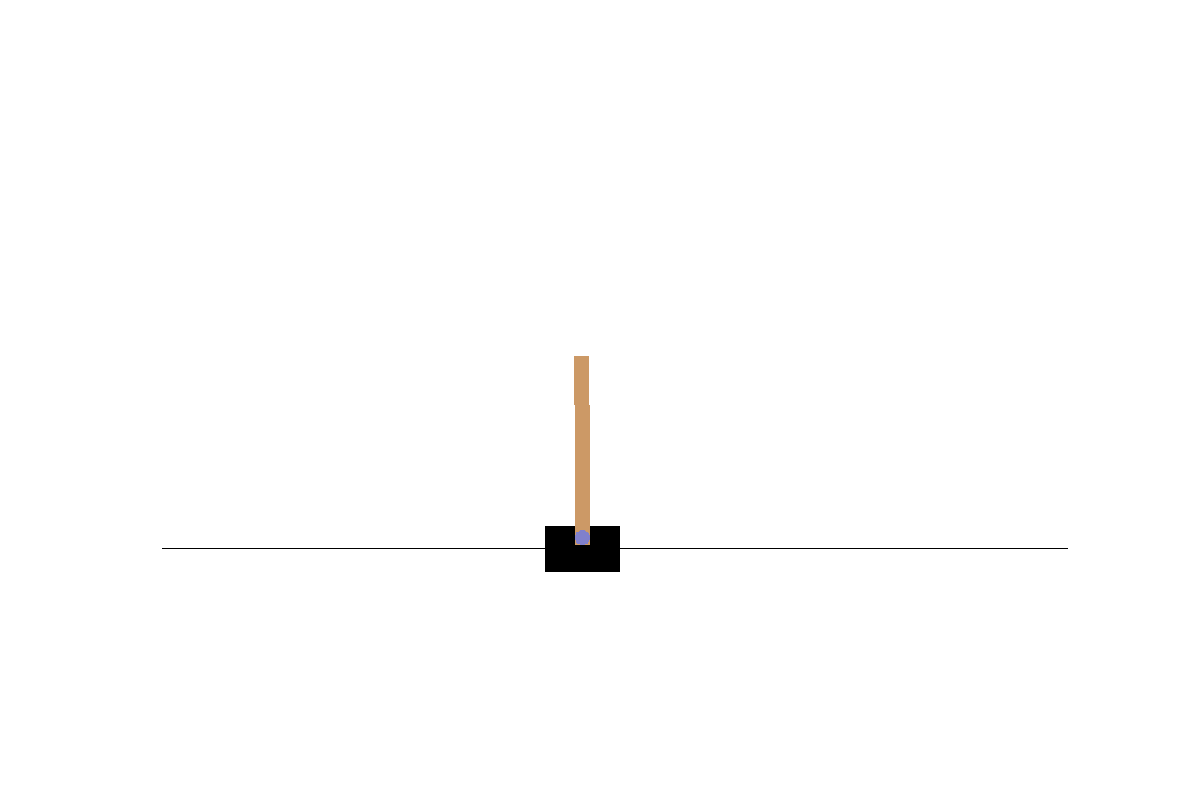
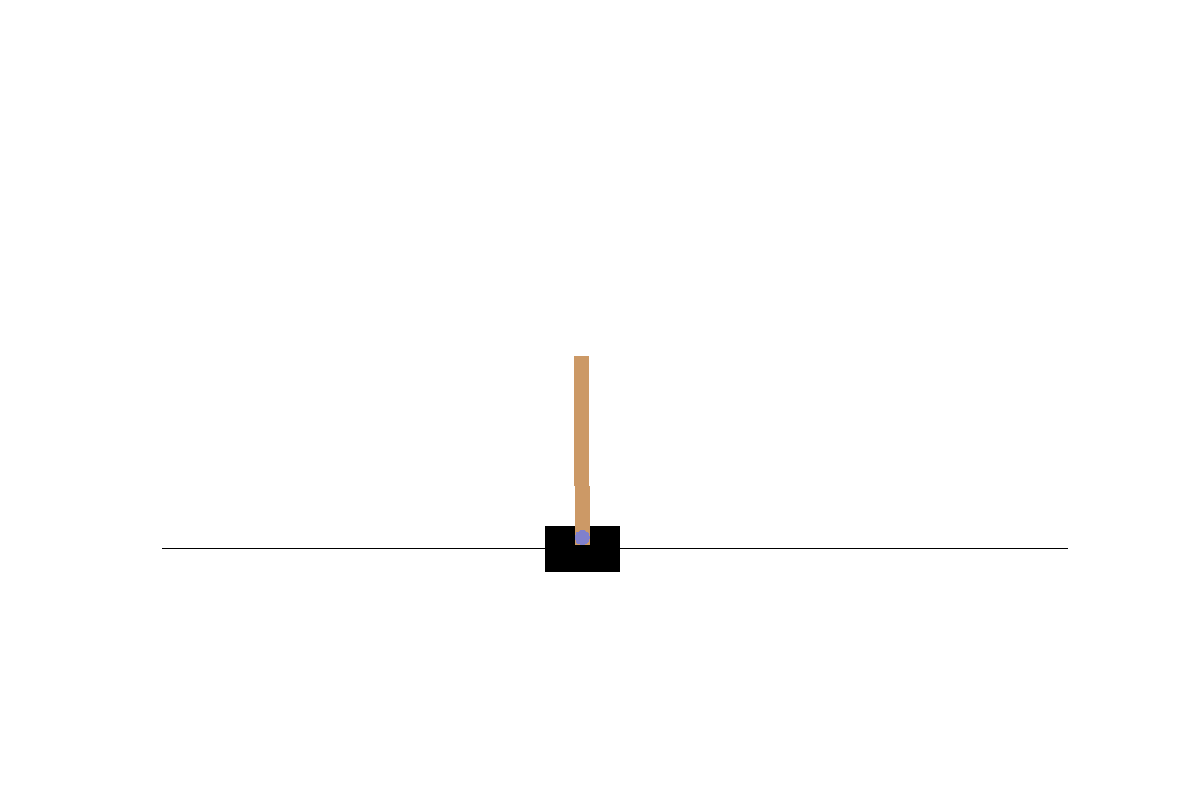
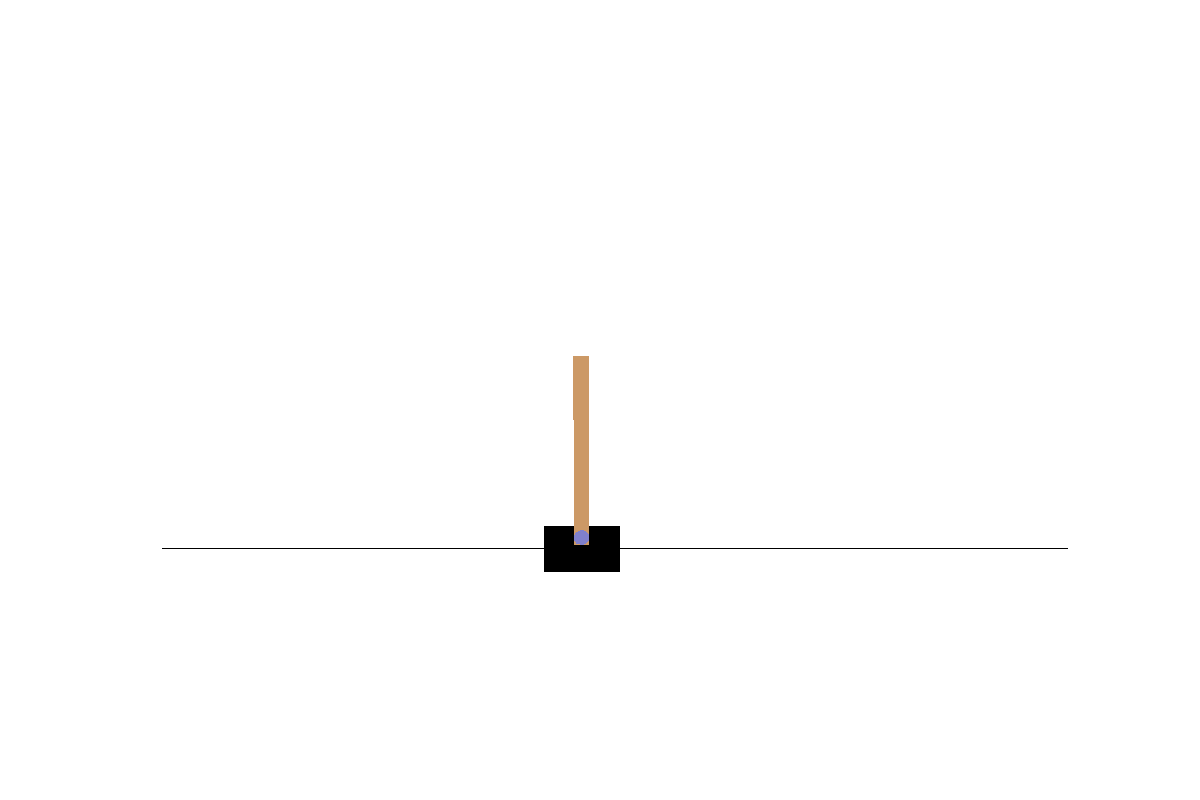
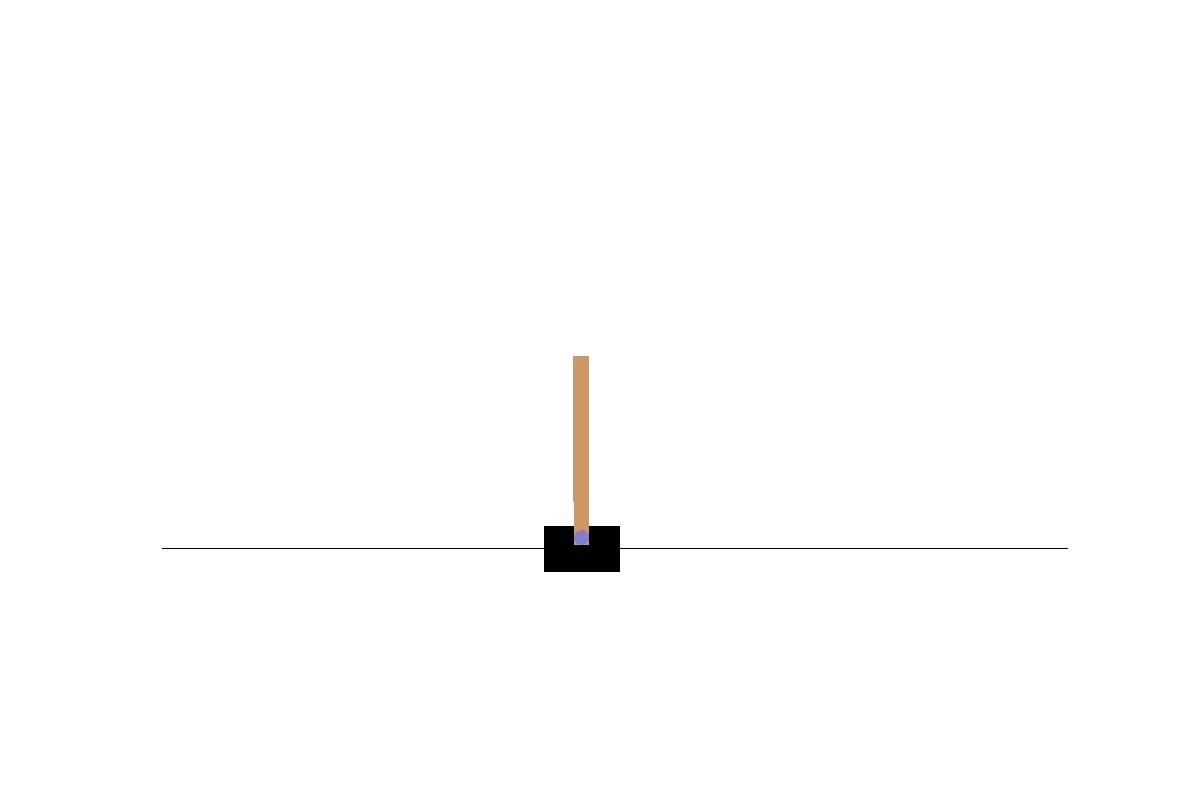
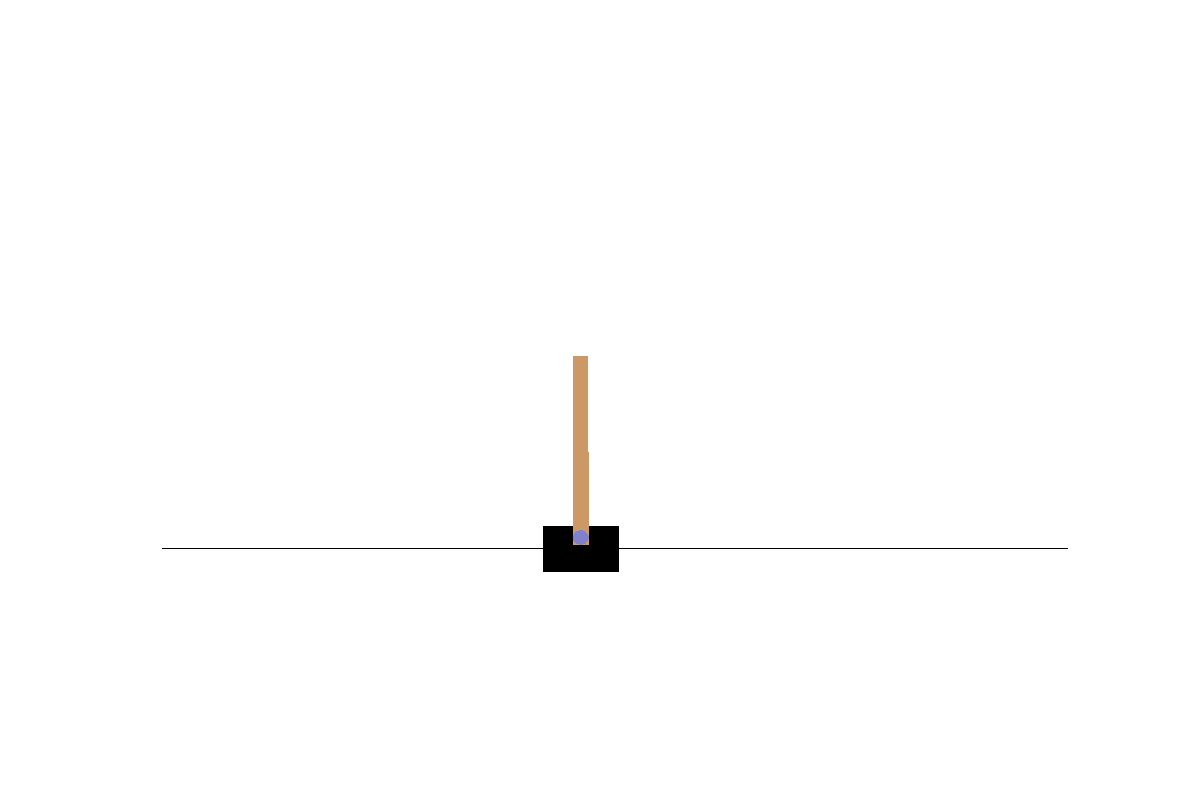
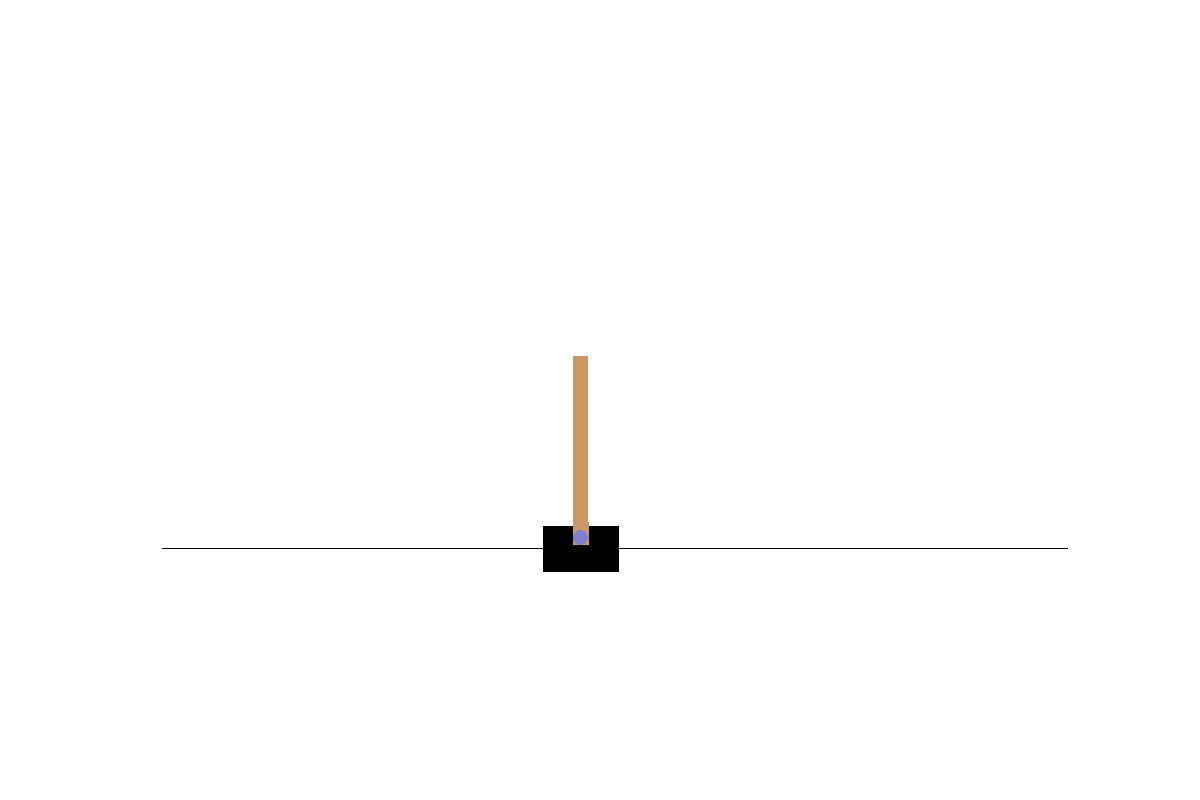
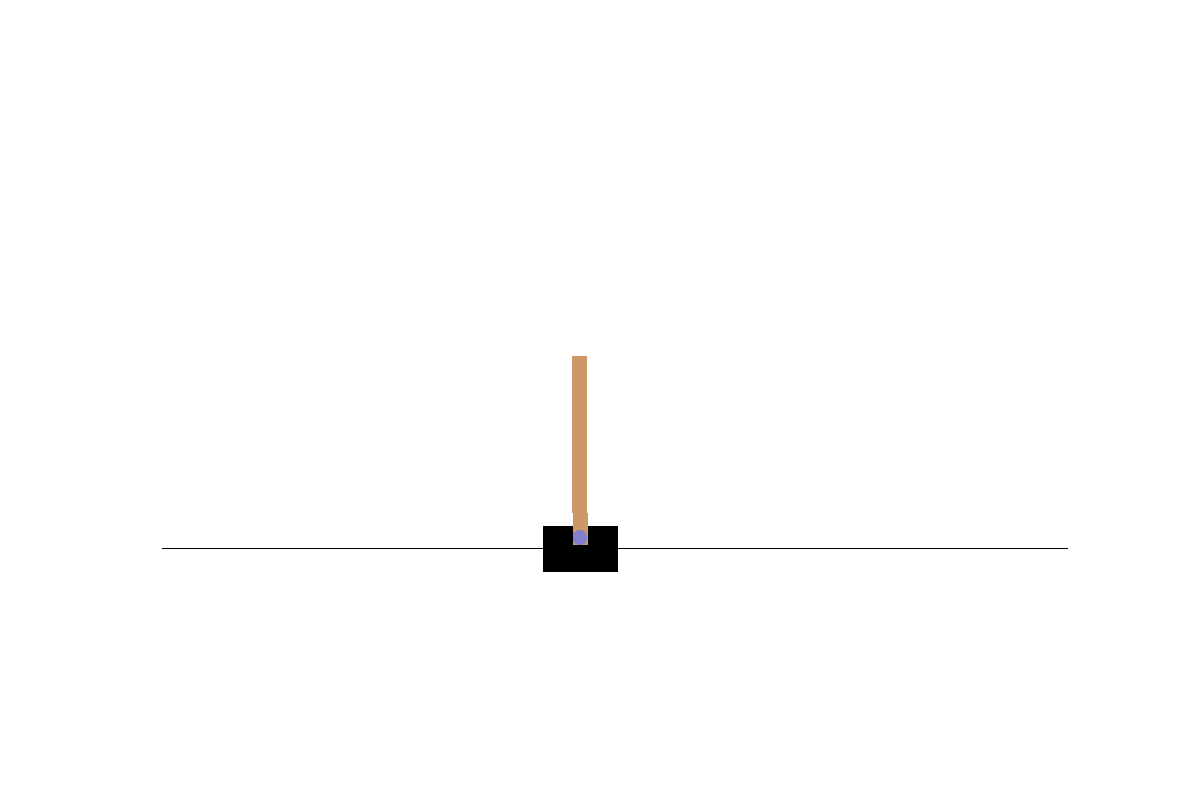
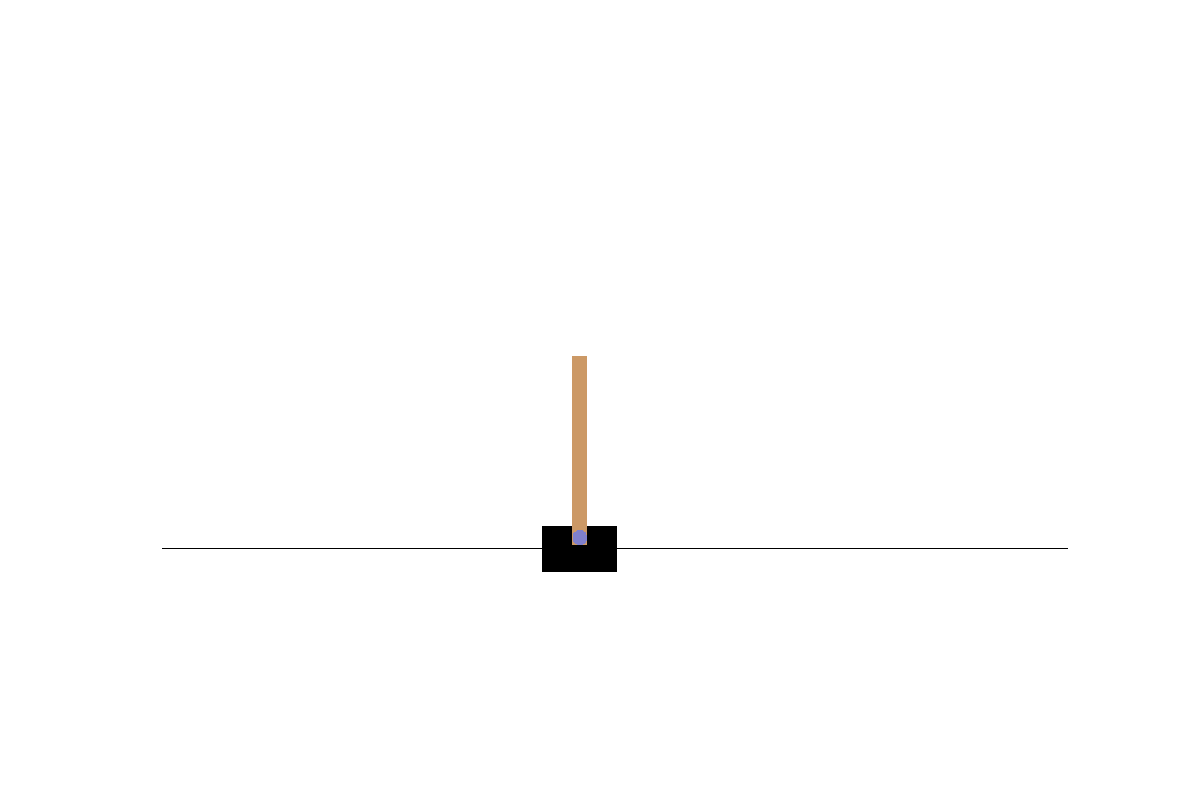
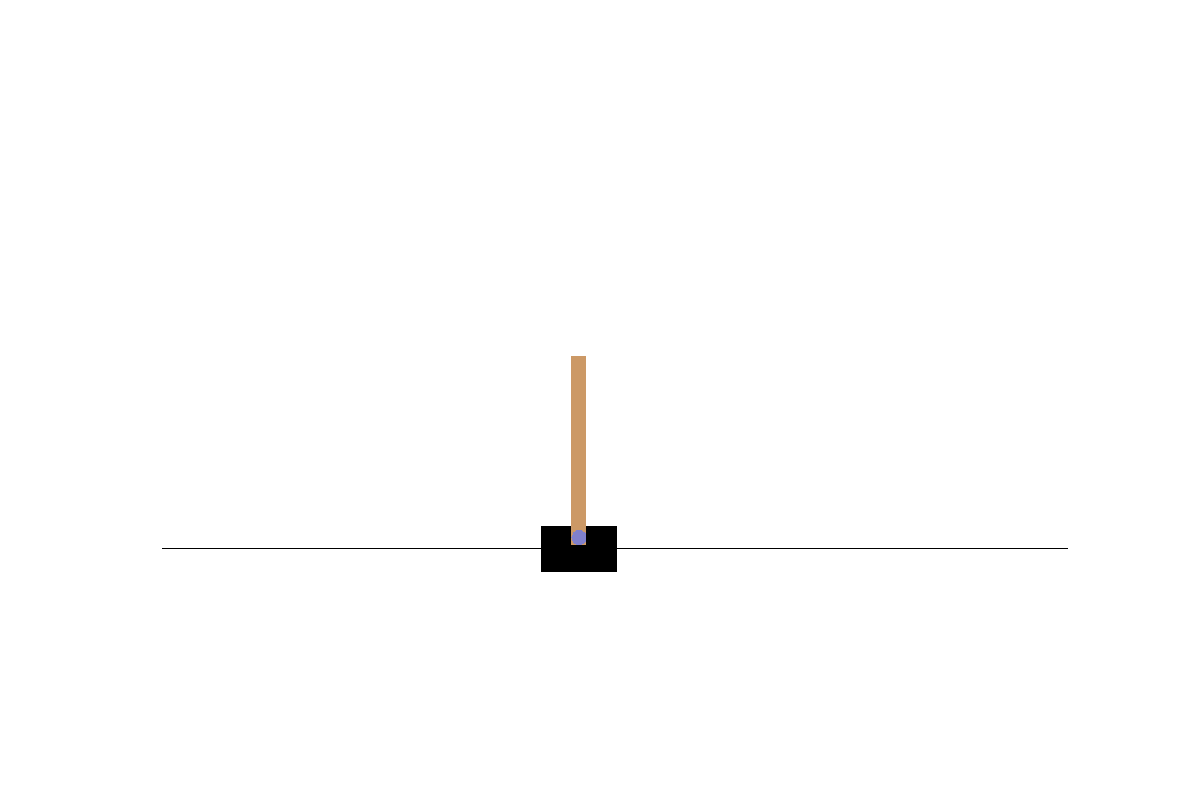
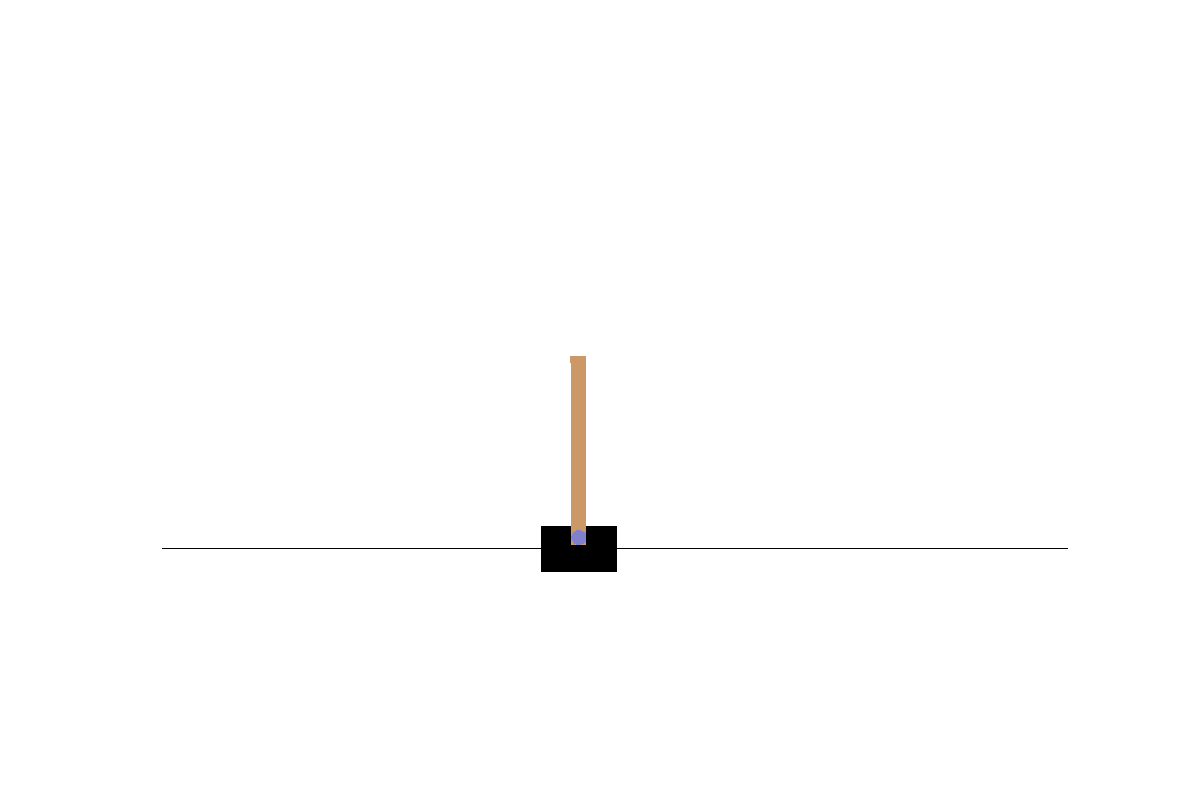
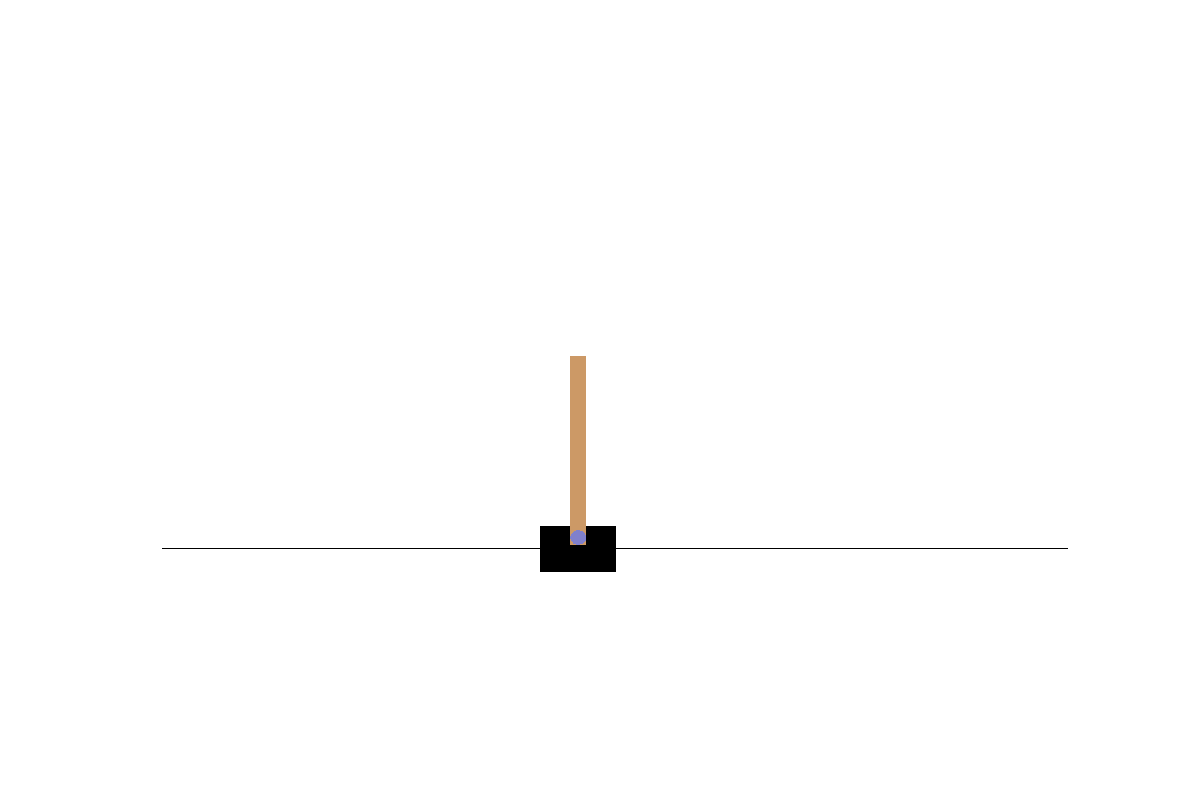
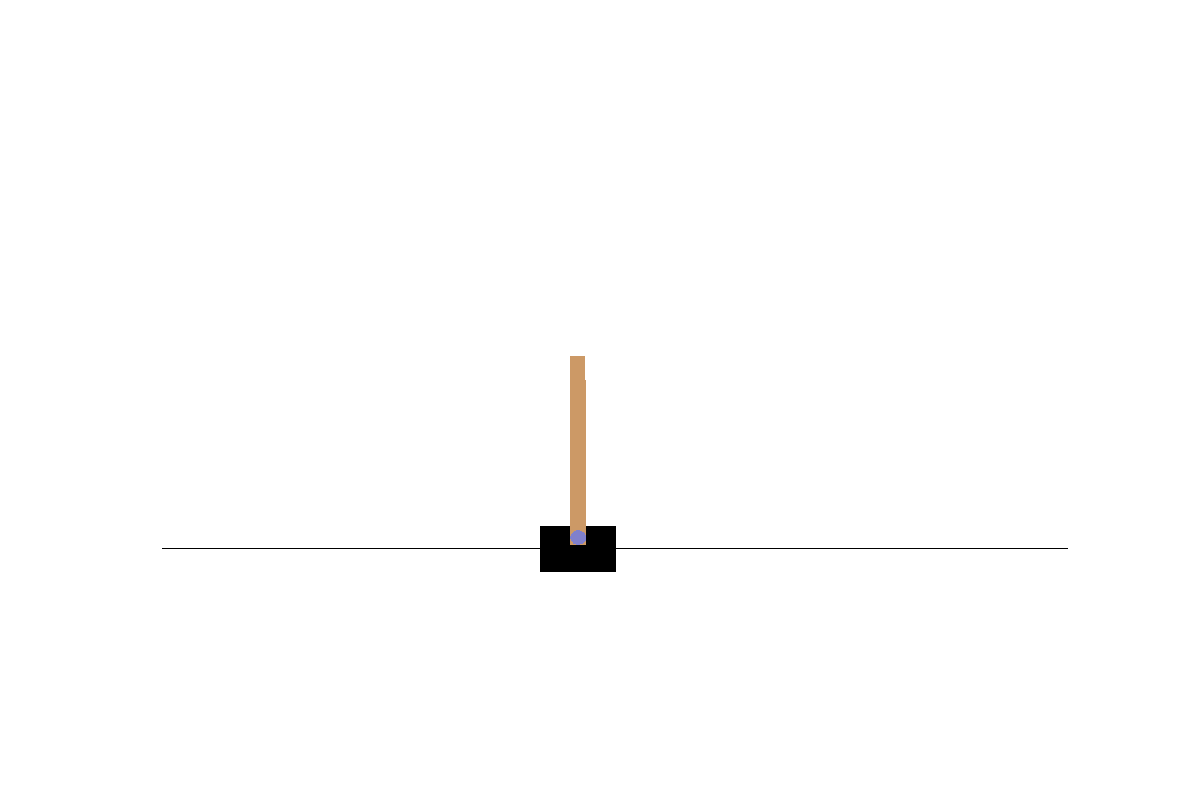
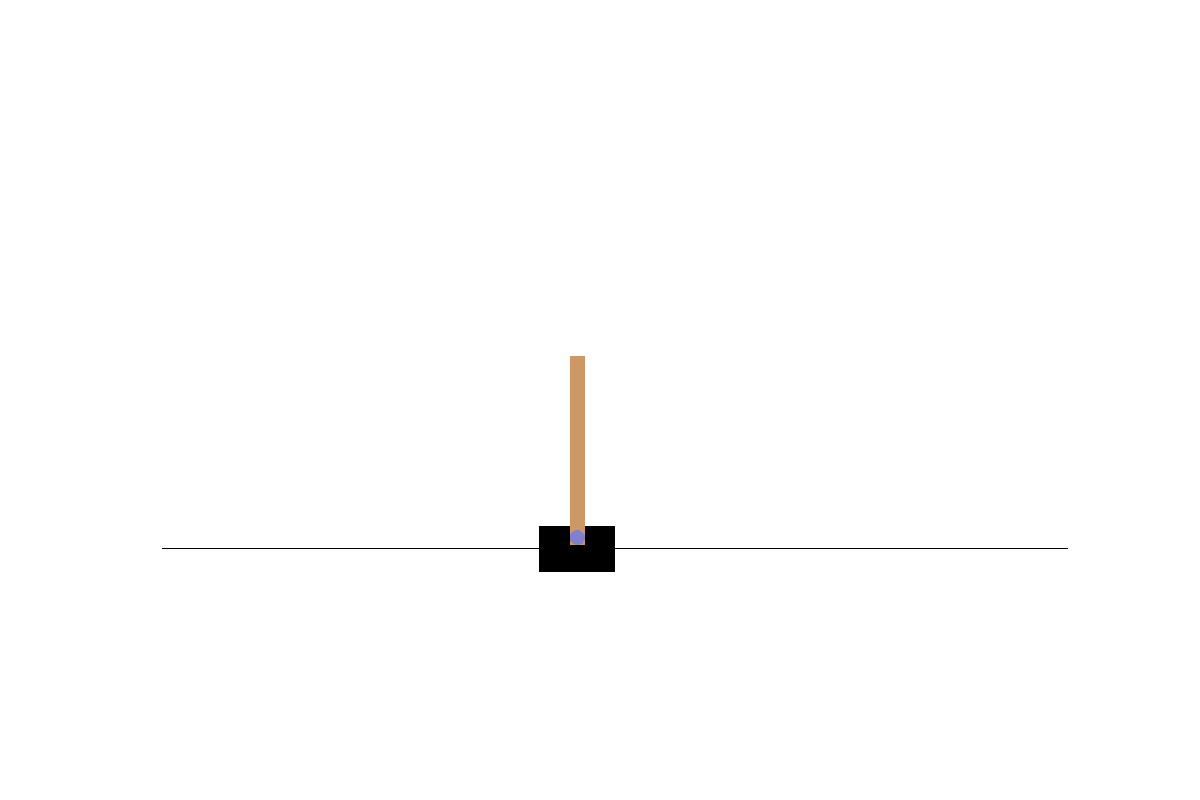
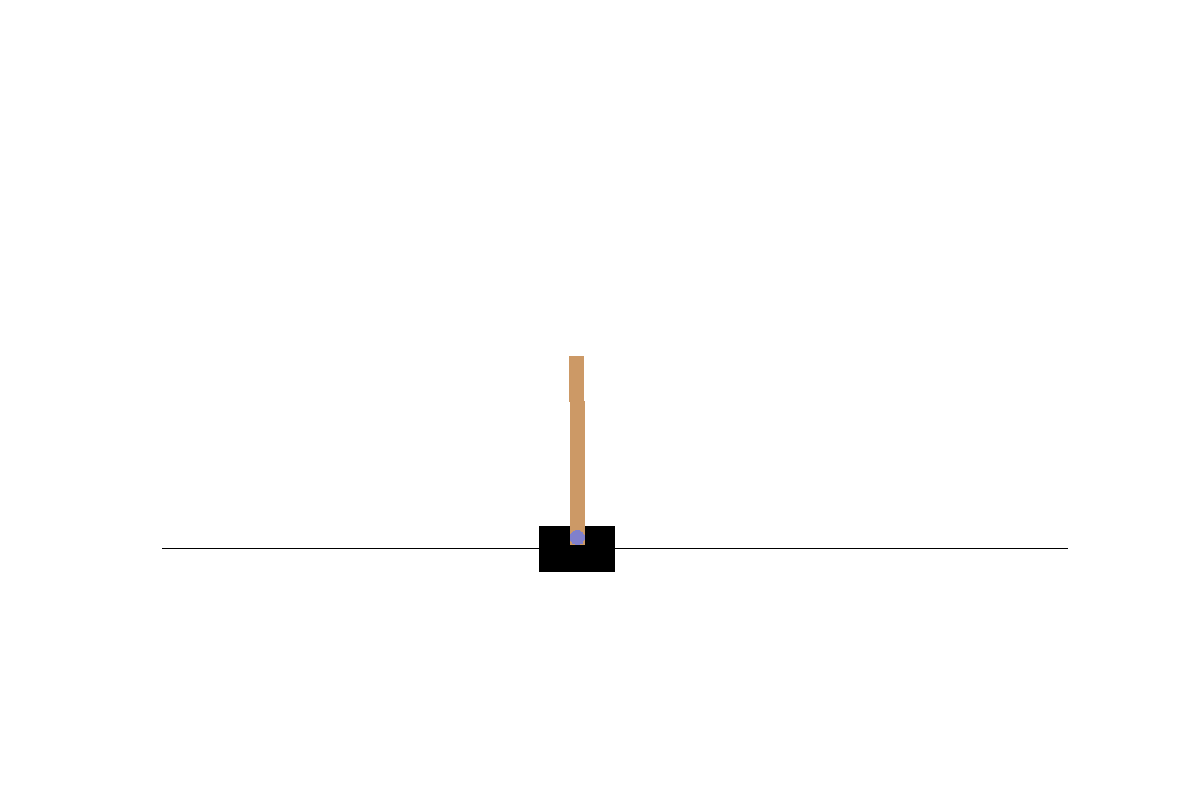
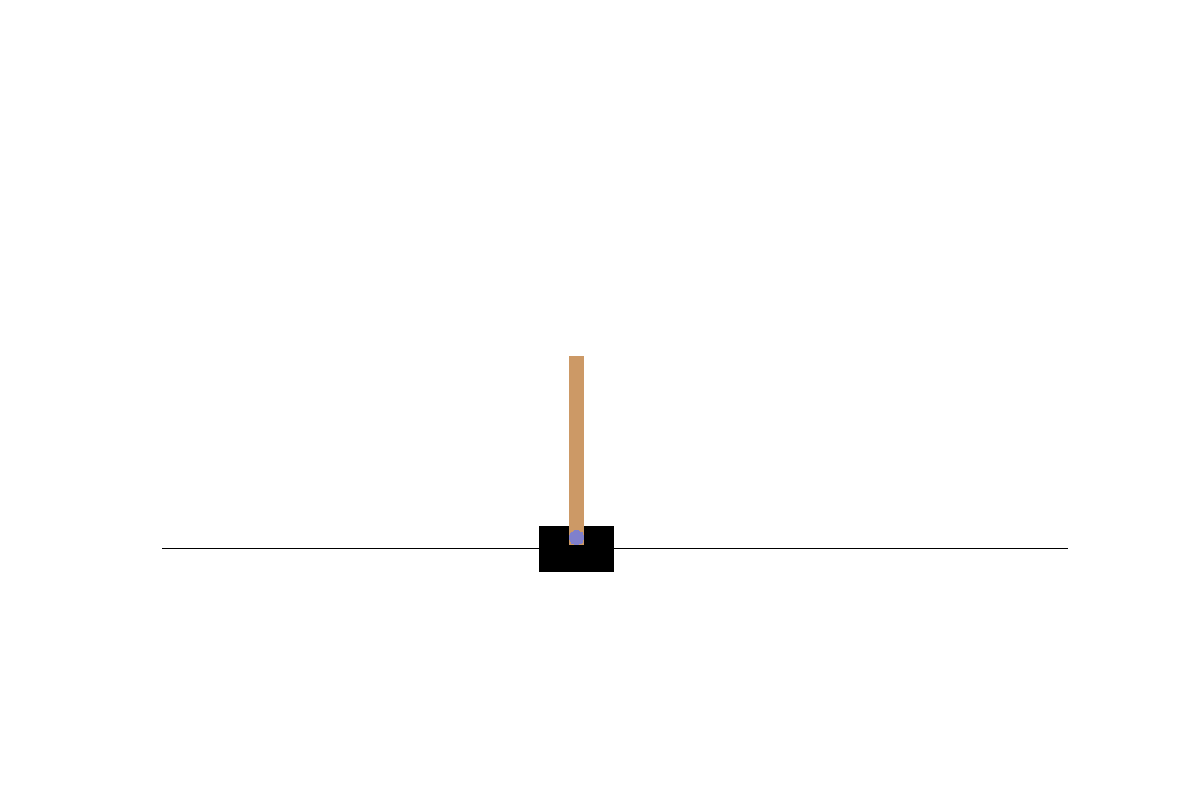
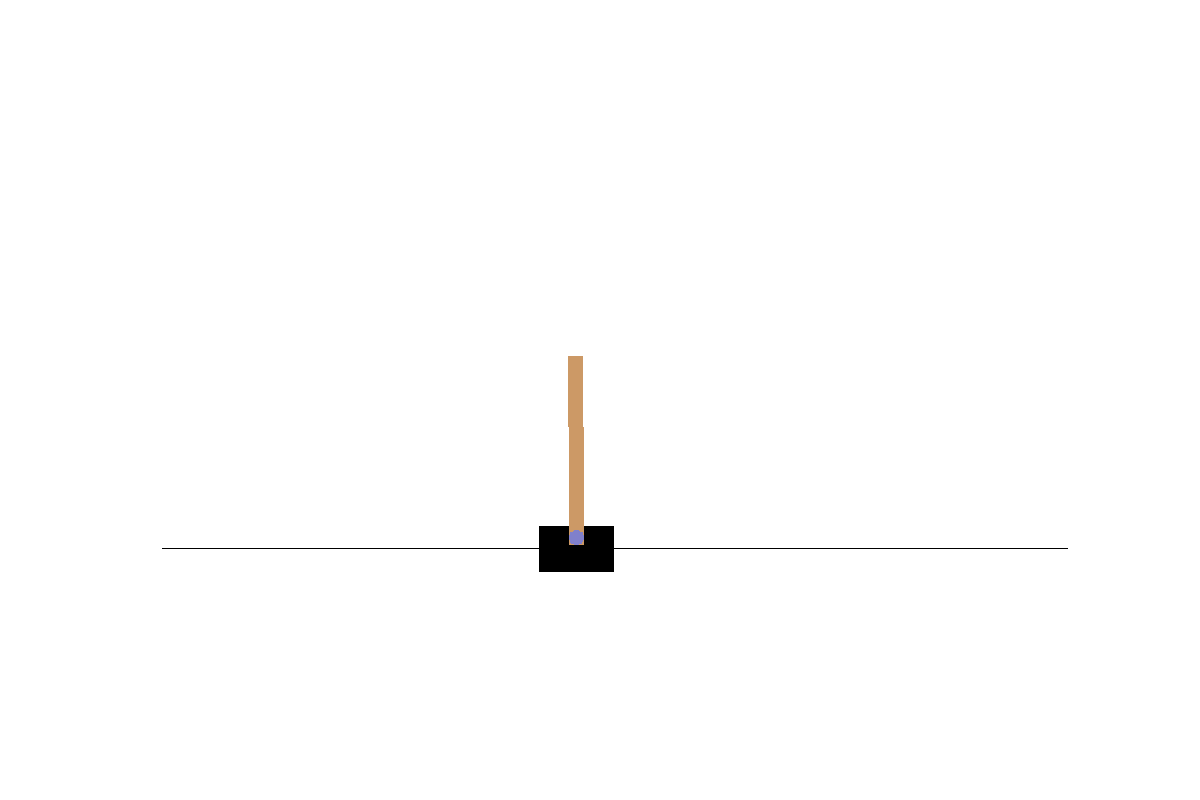
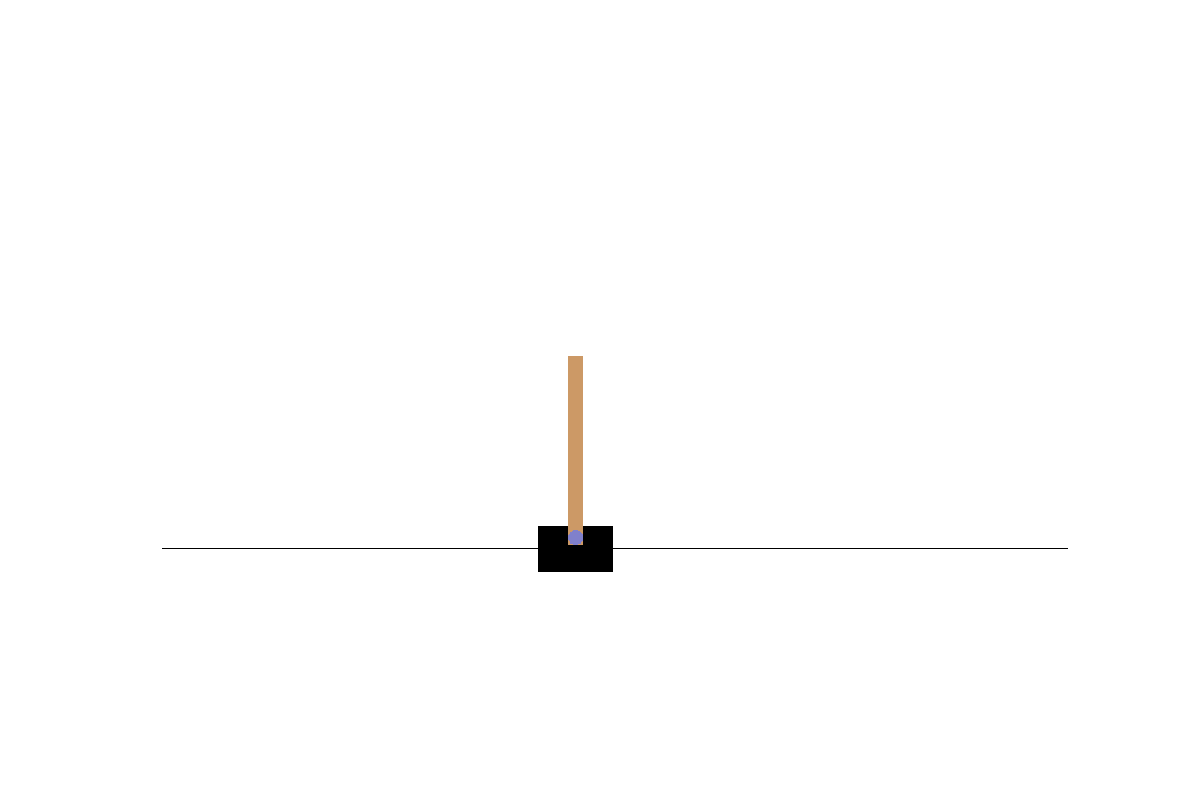

200.0

In [109]:
weights = np.random.normal(0, 1, size=(1000, 4))
scores = np.array([runSimulation(linearChoiceFactory(x)) for x in weights])
print("Best score:", scores.max())
runSimulation(linearChoiceFactory(weights[scores.argmax()]), render=True)

Average:  82.49666666666667



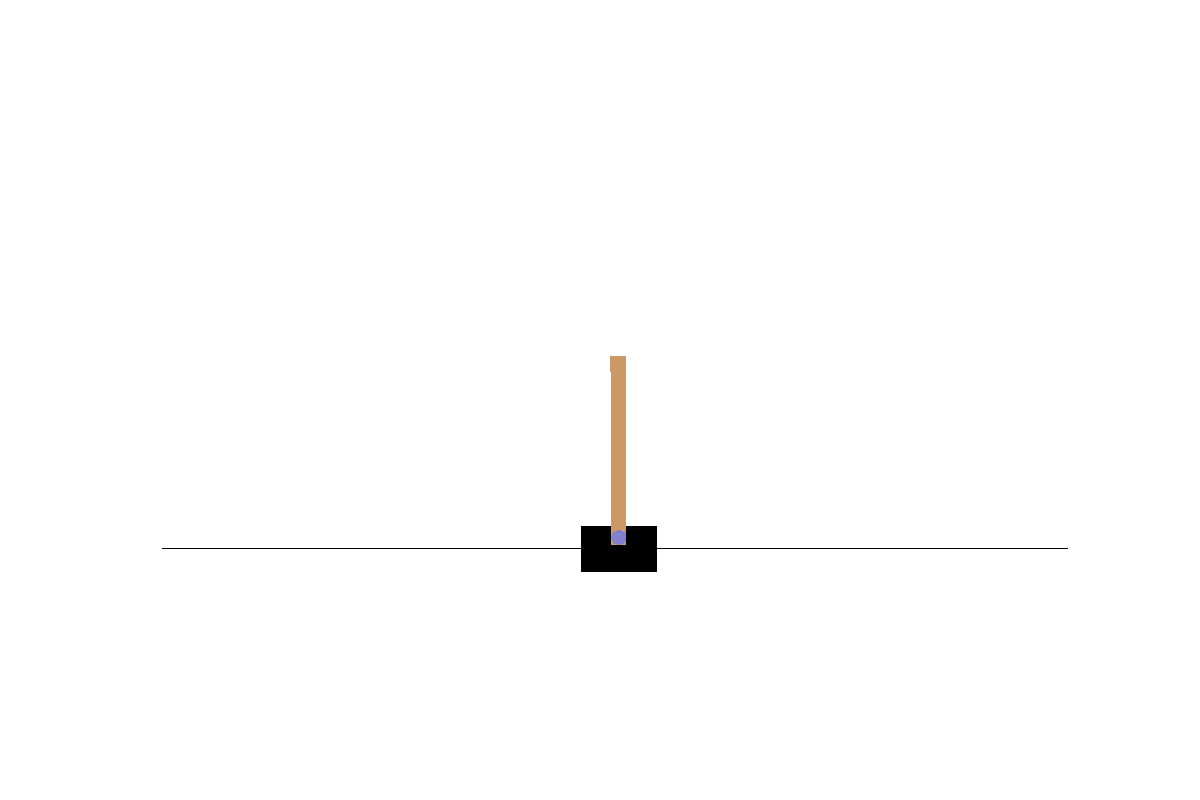
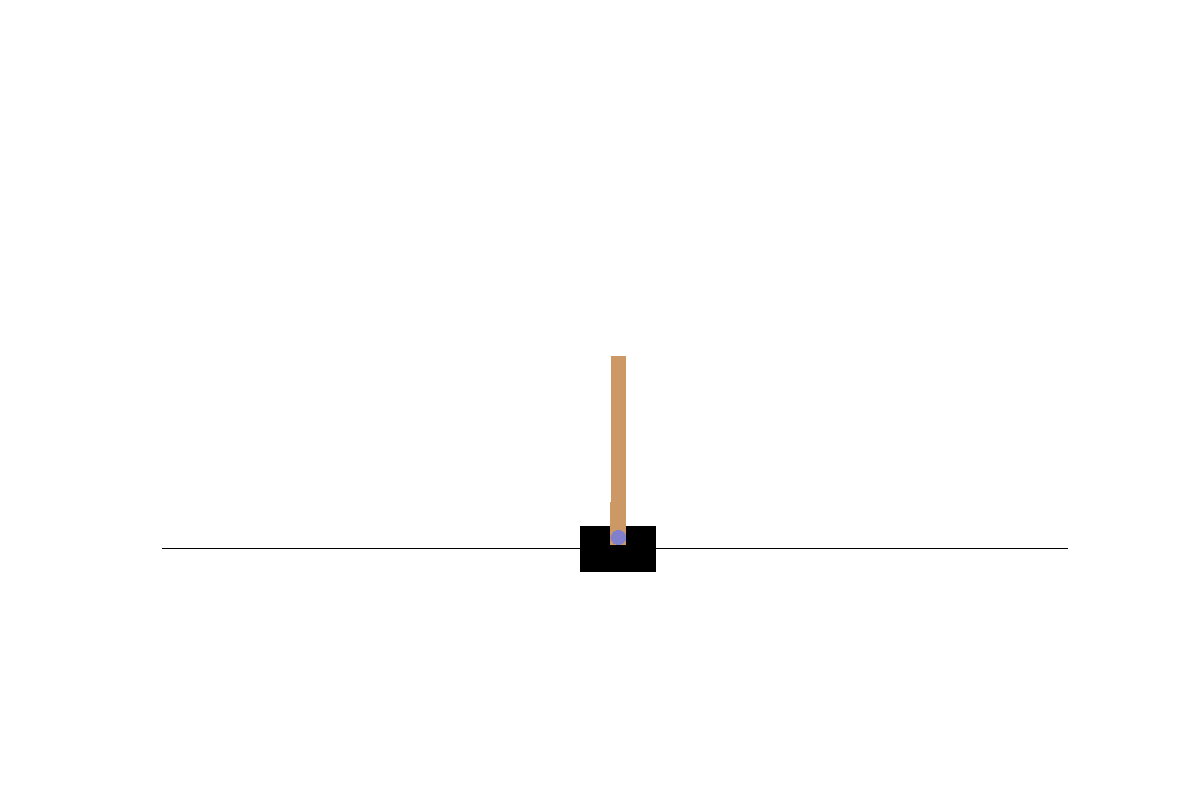
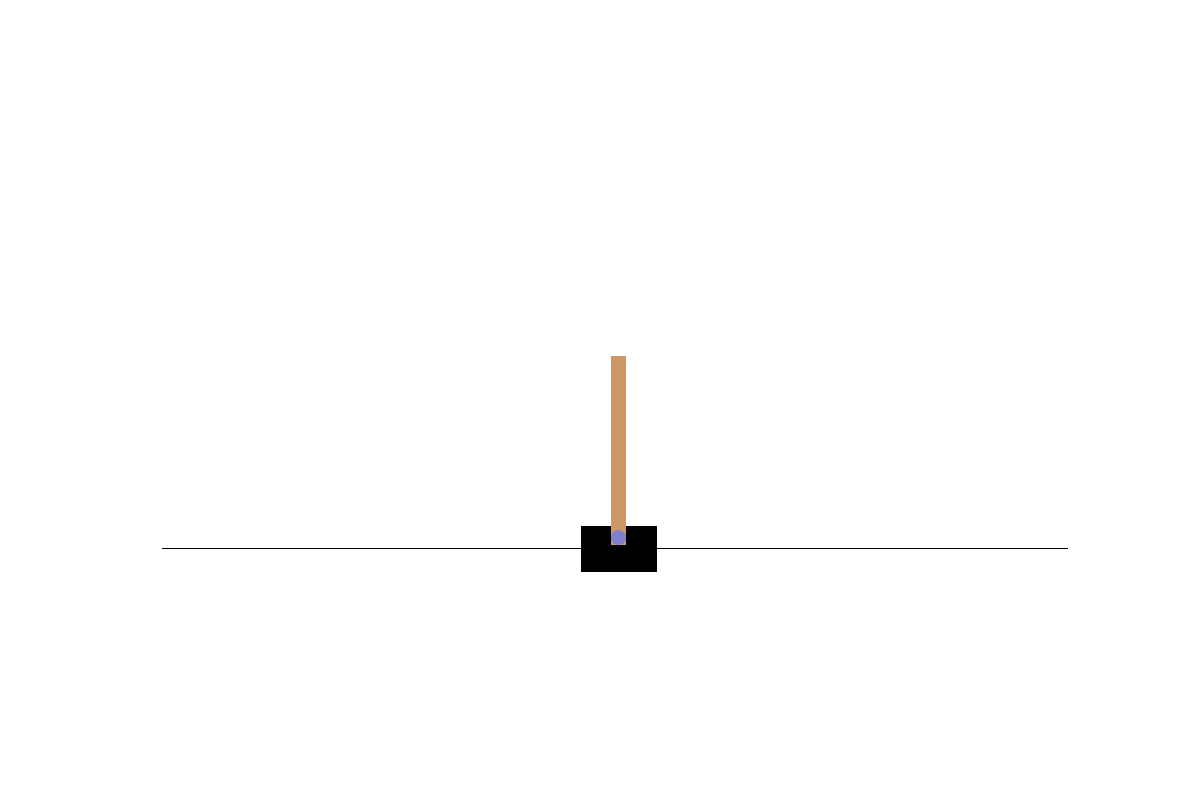
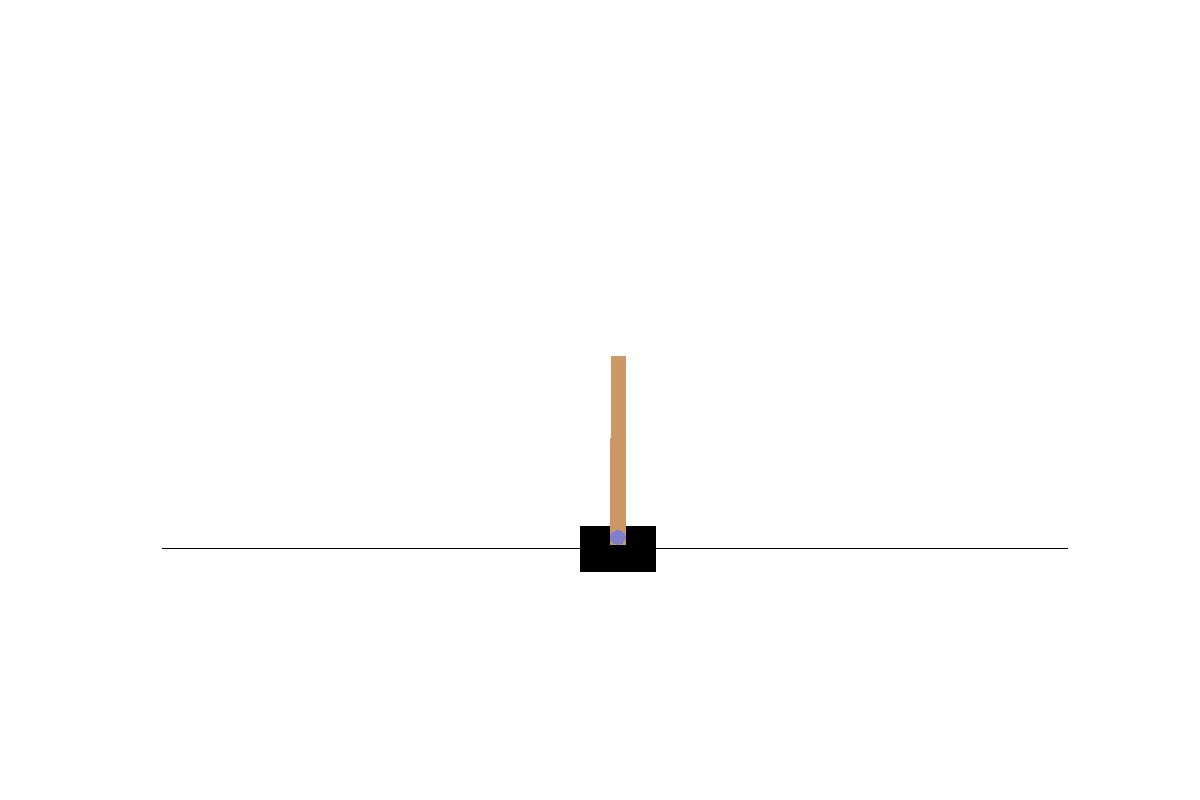
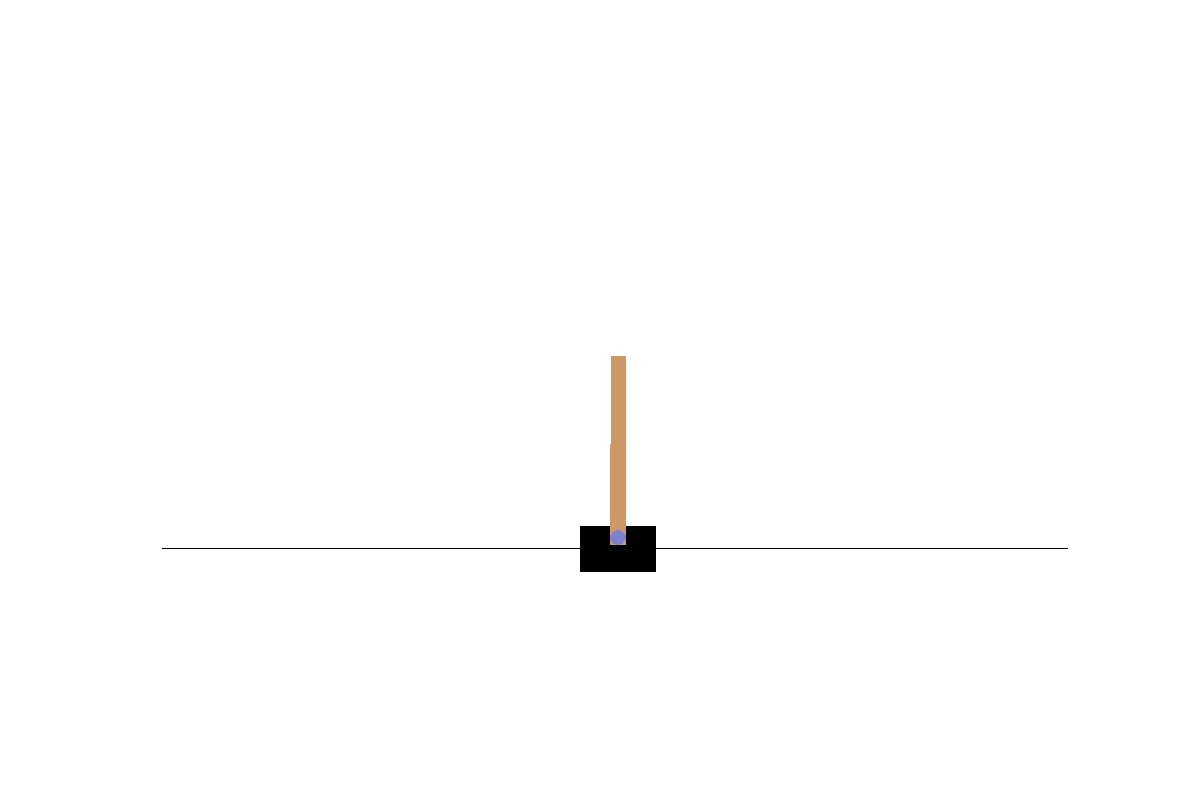
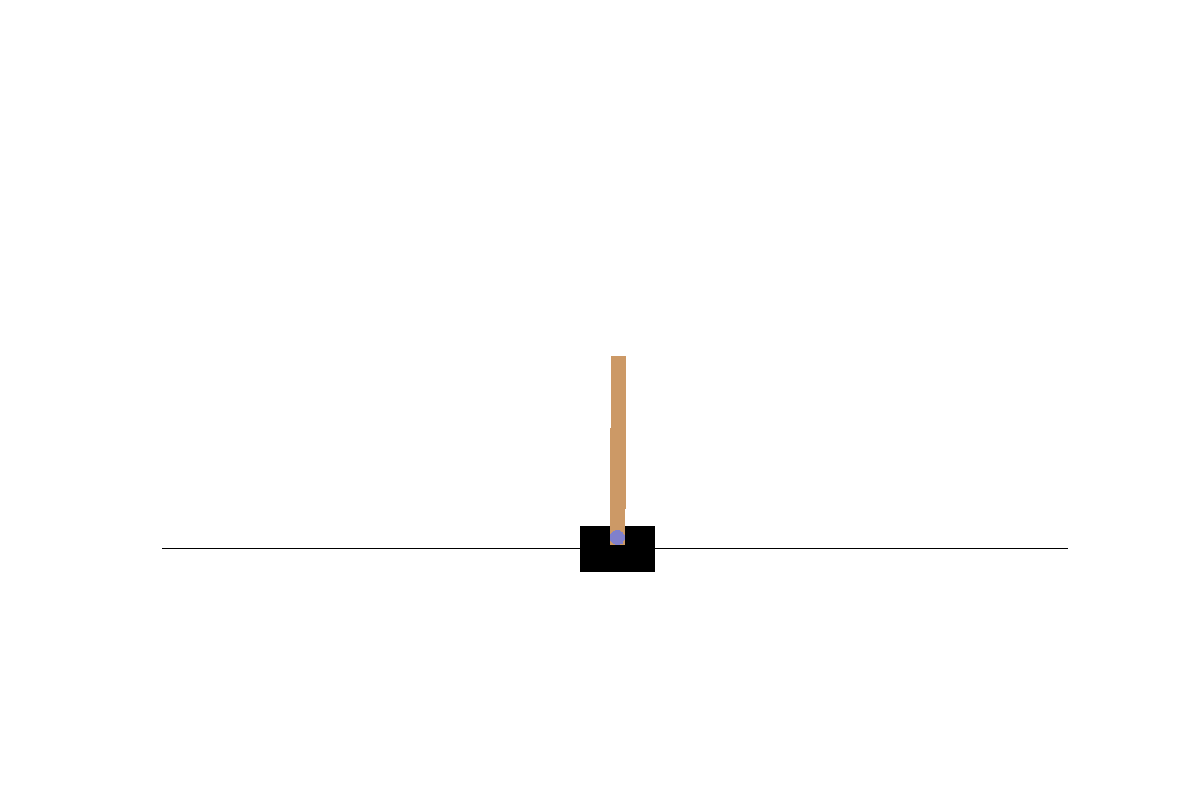
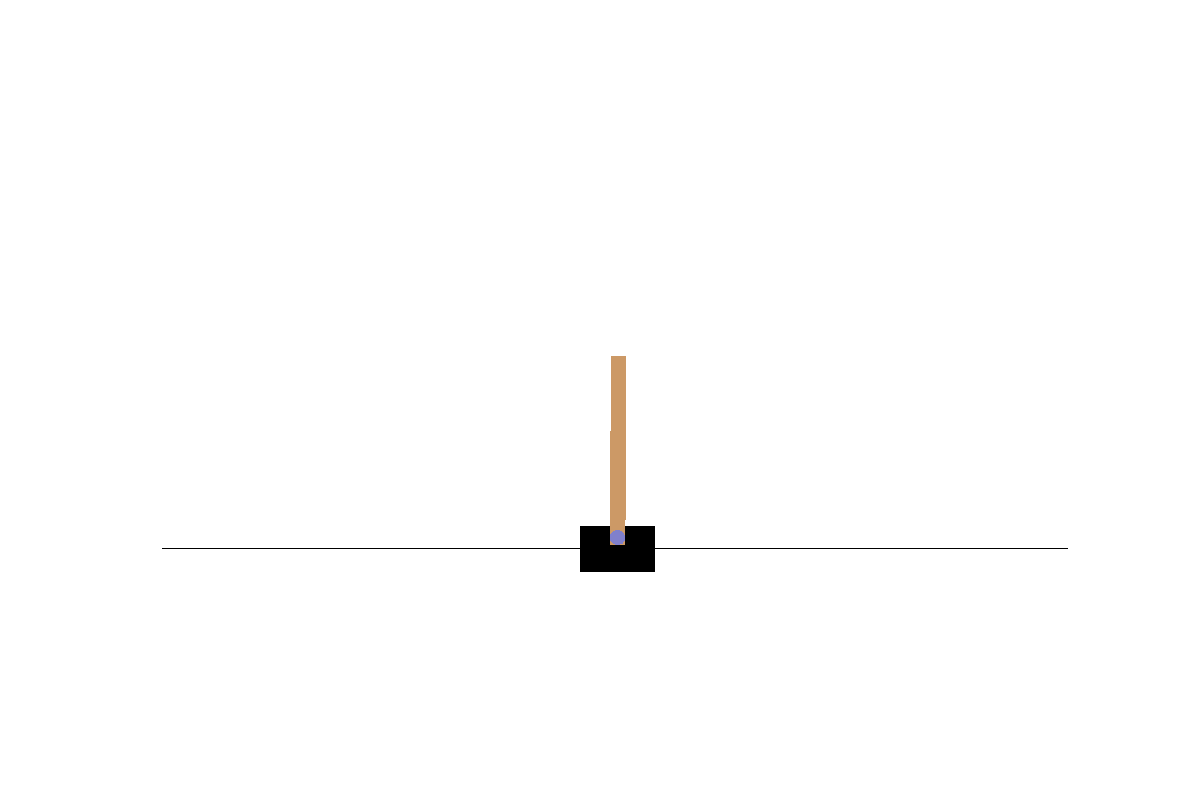
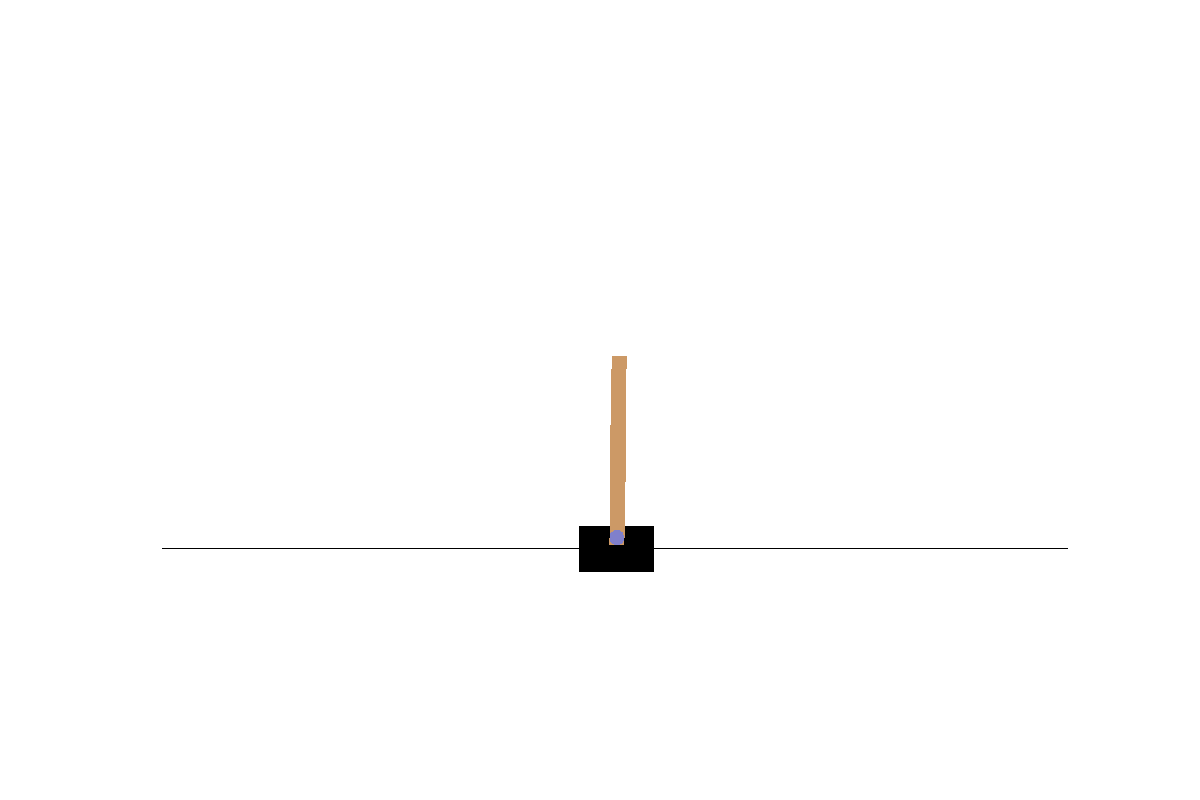
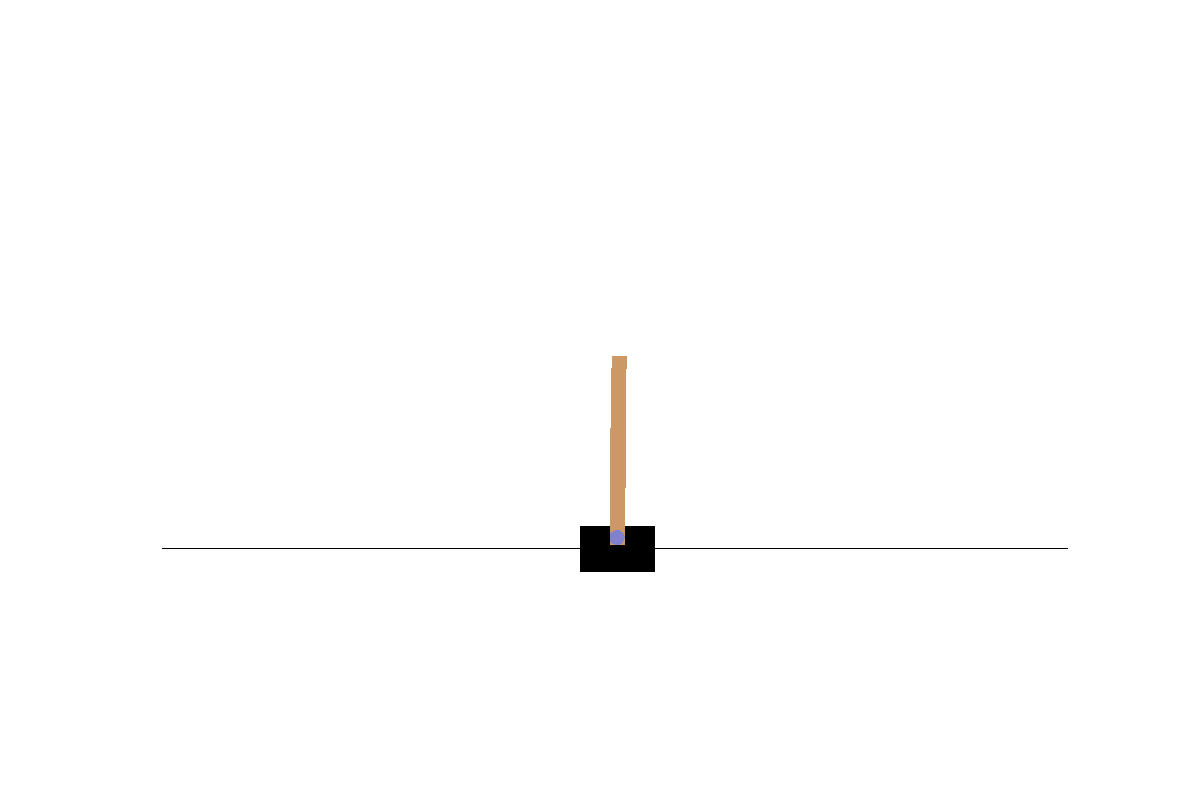
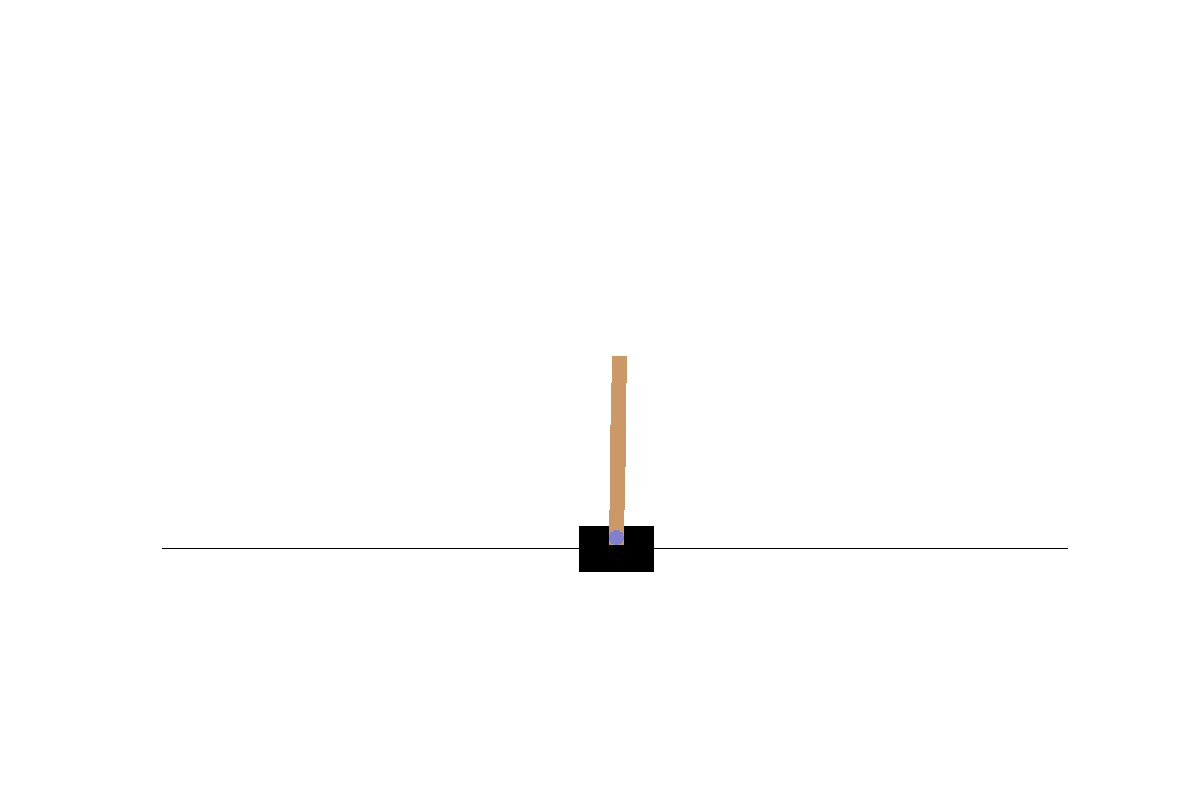
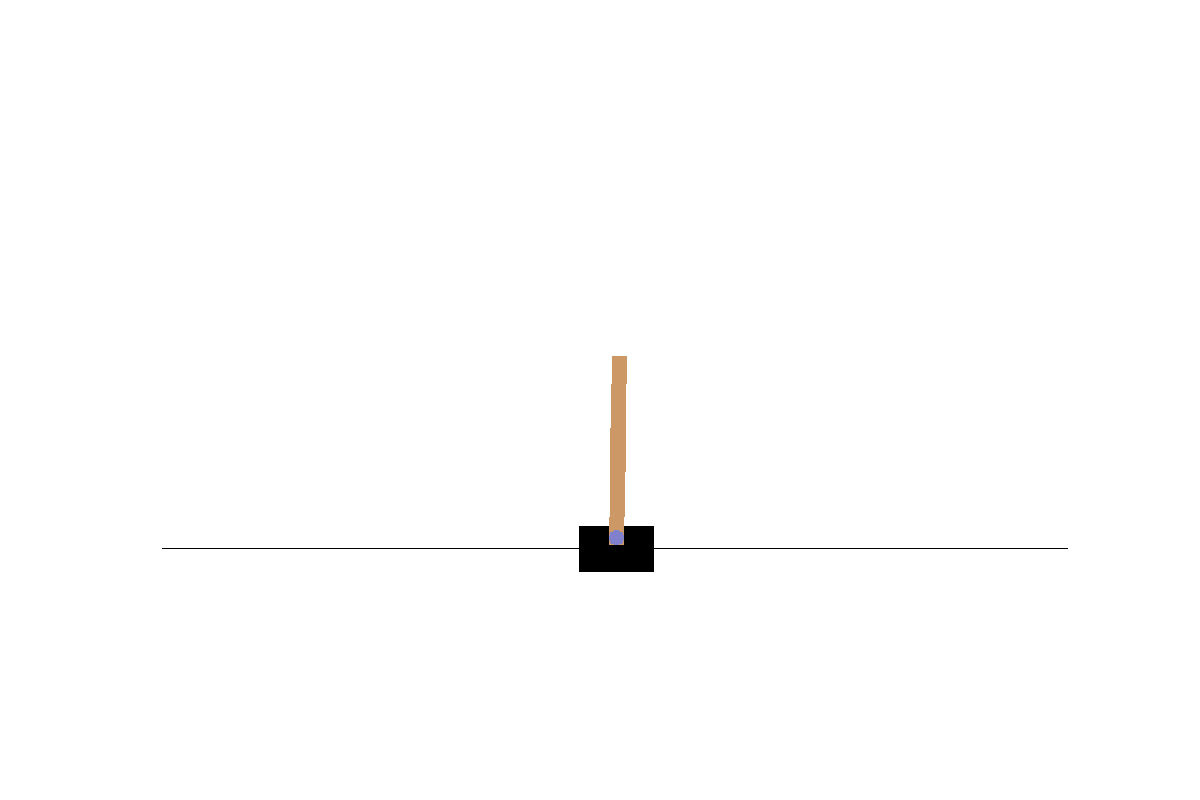
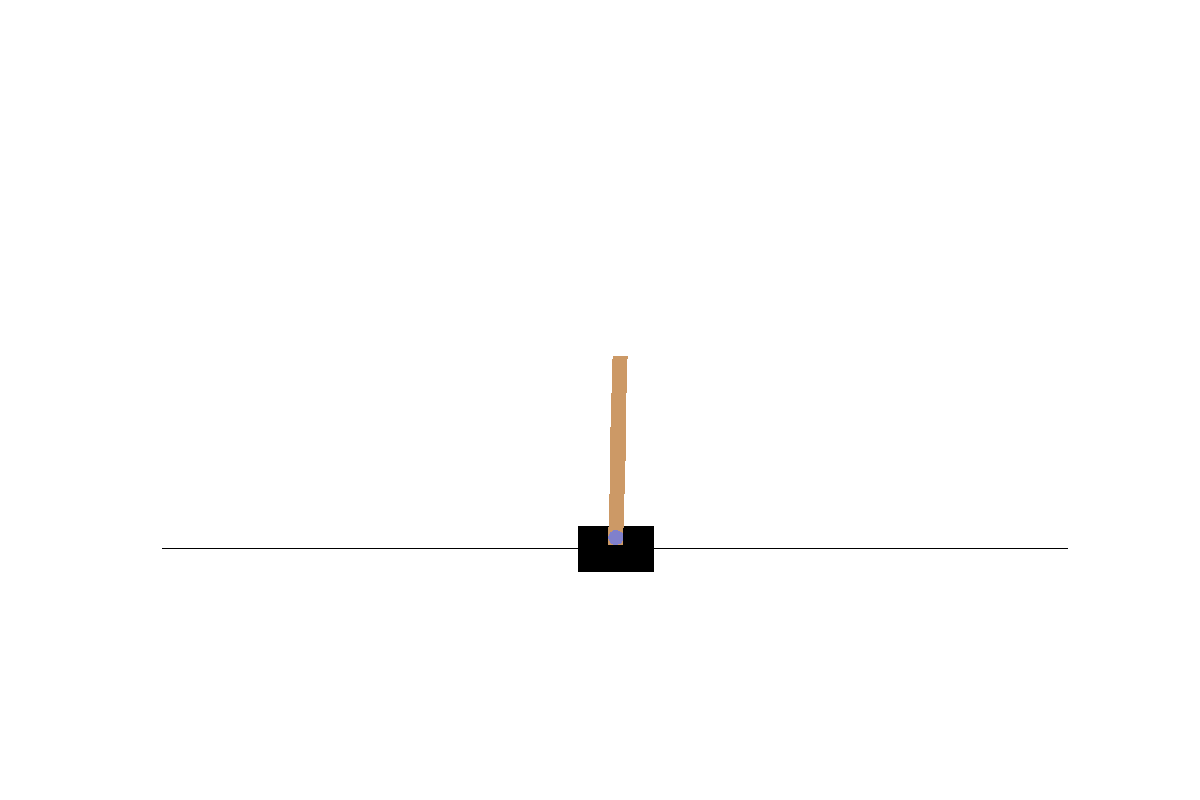
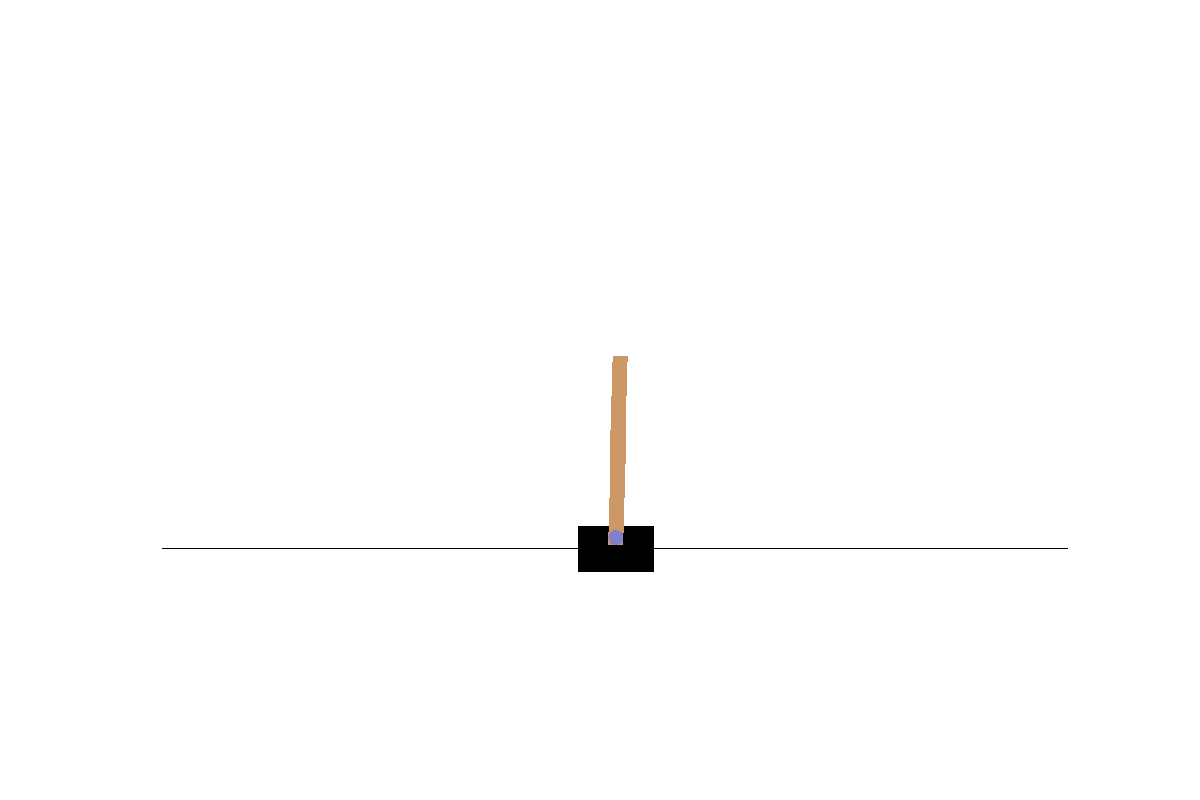
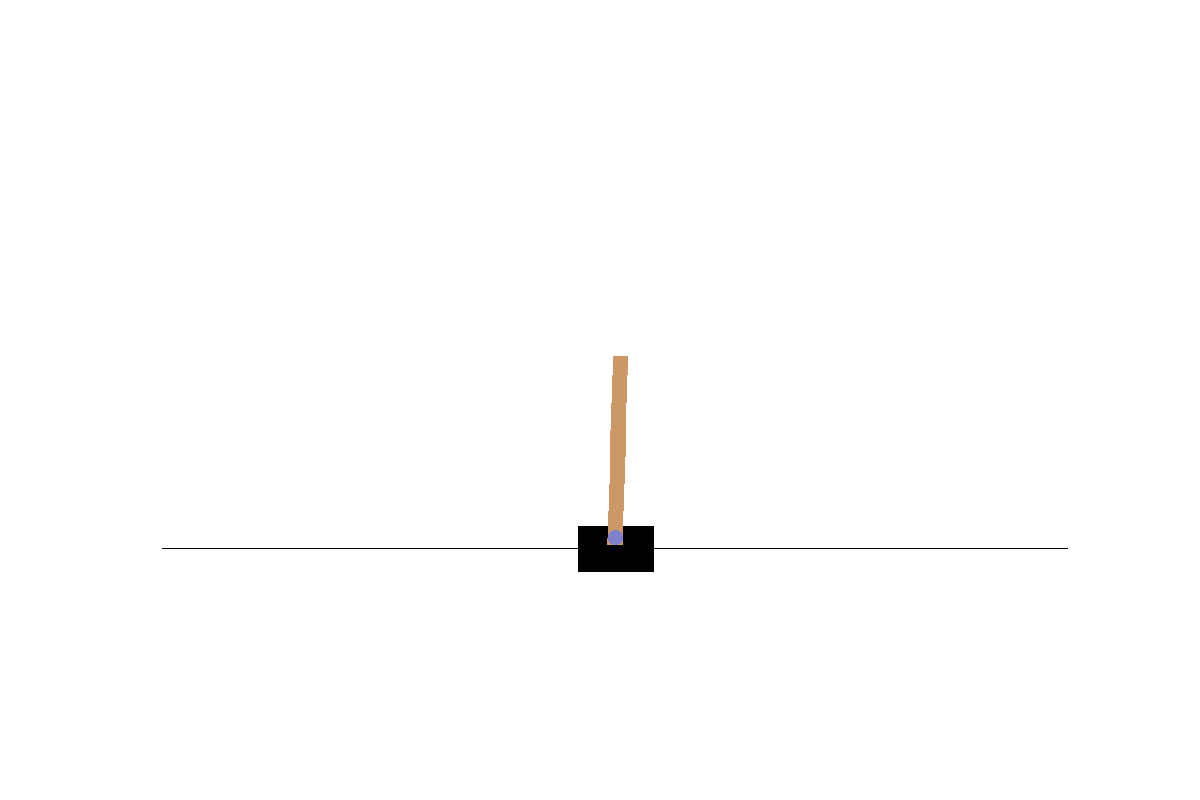
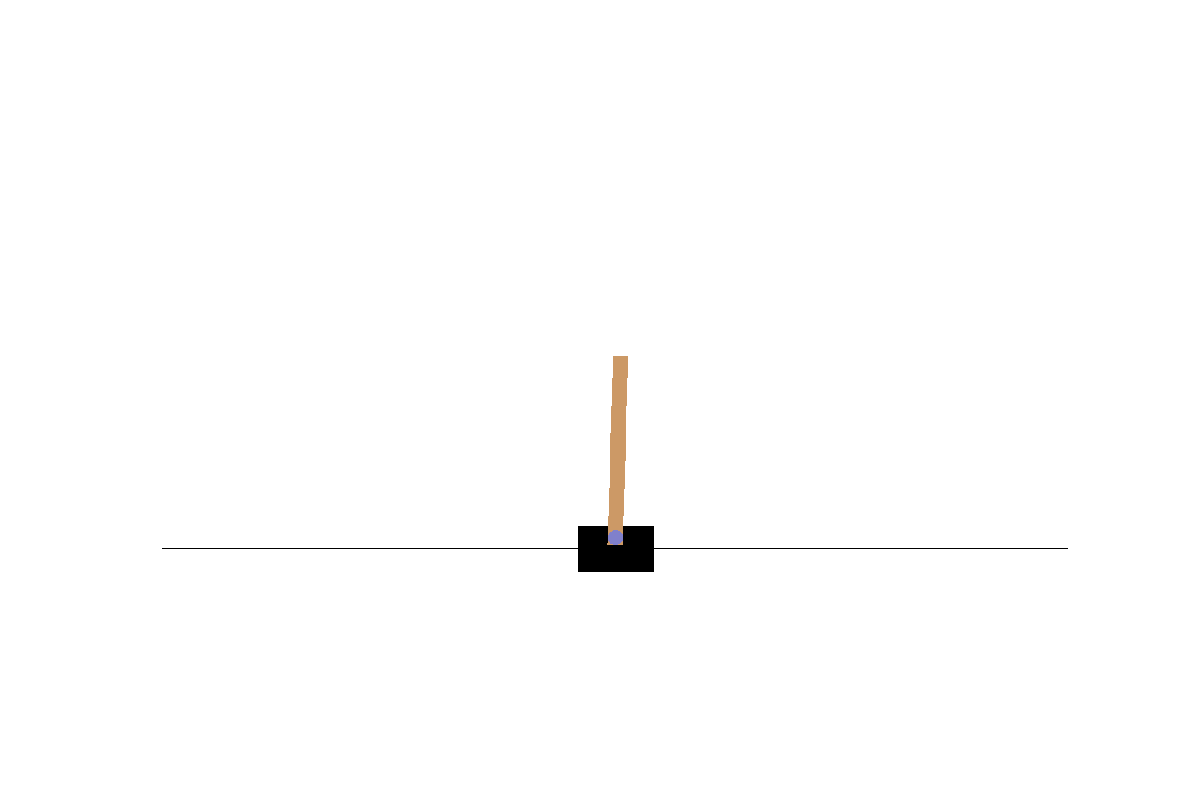
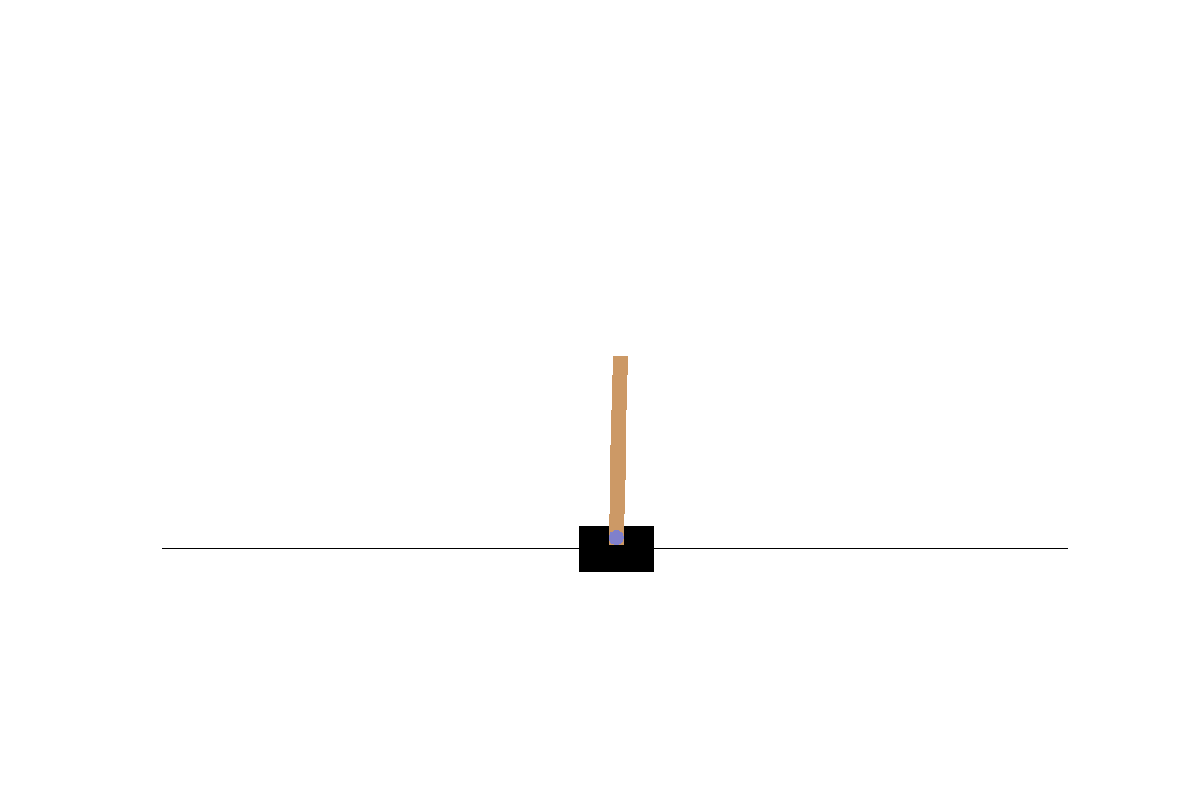
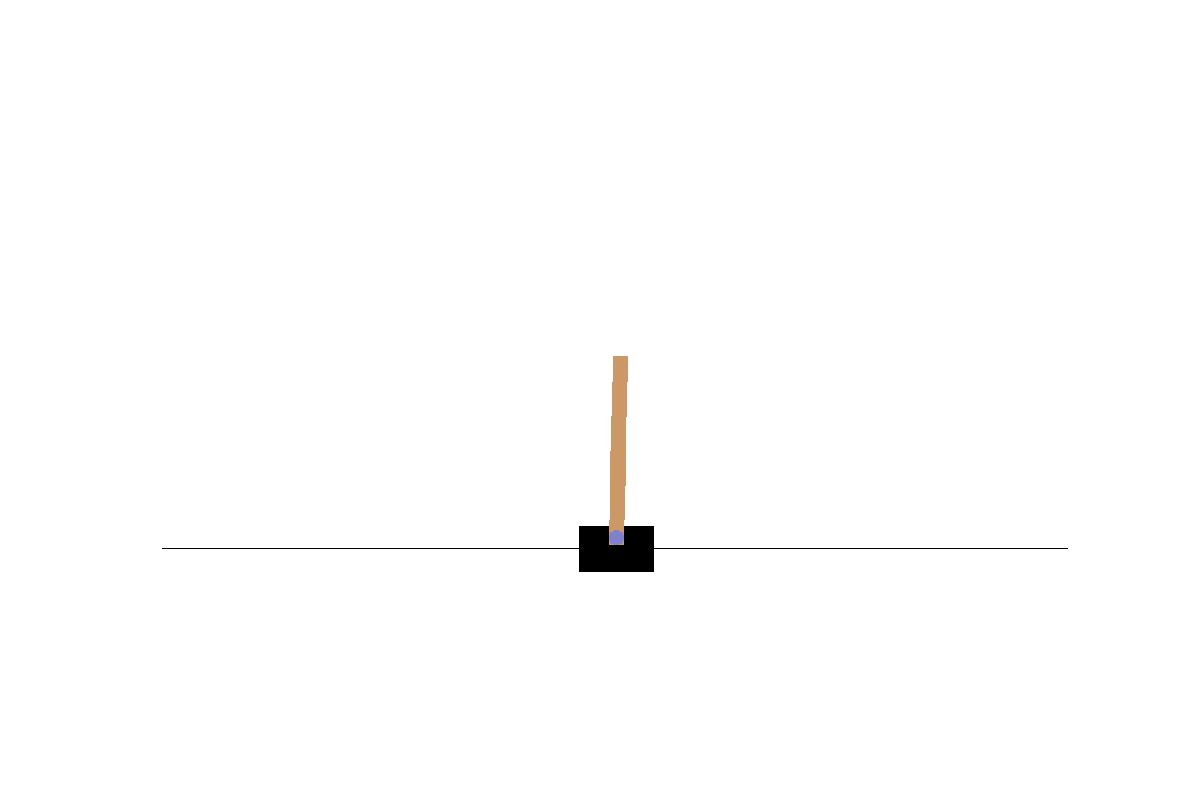
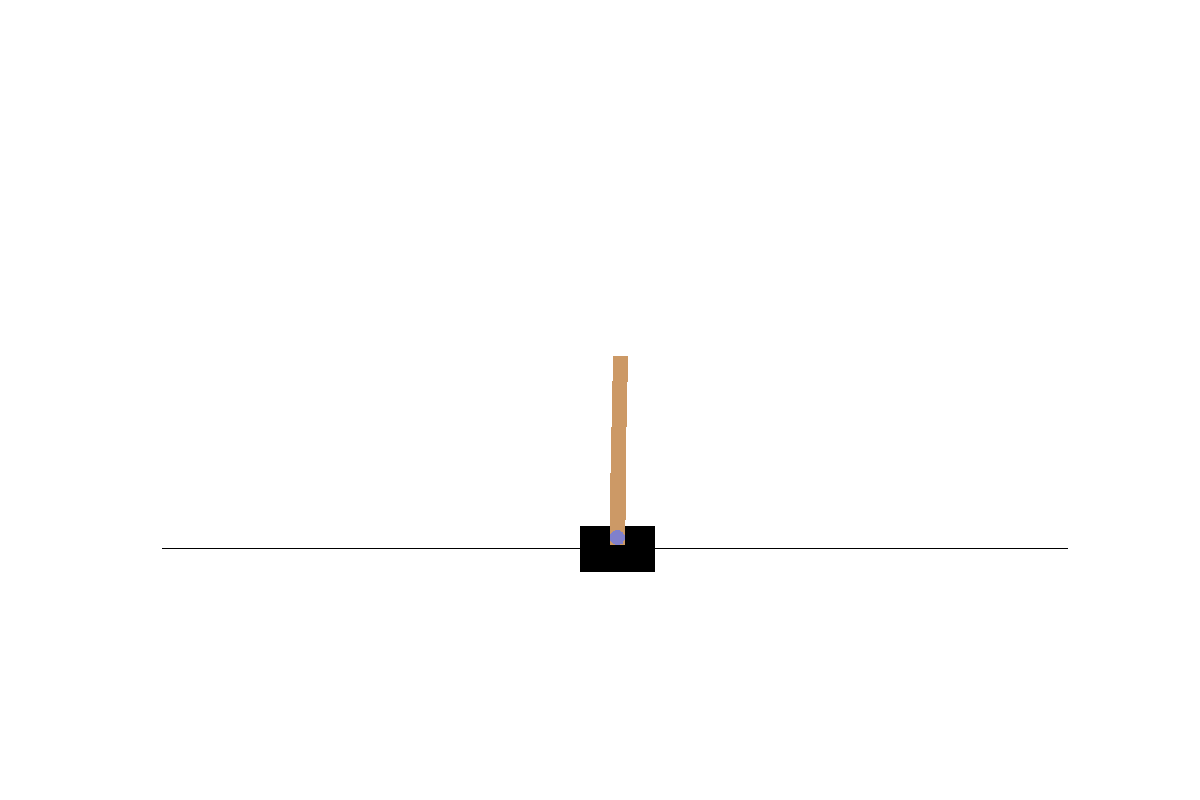
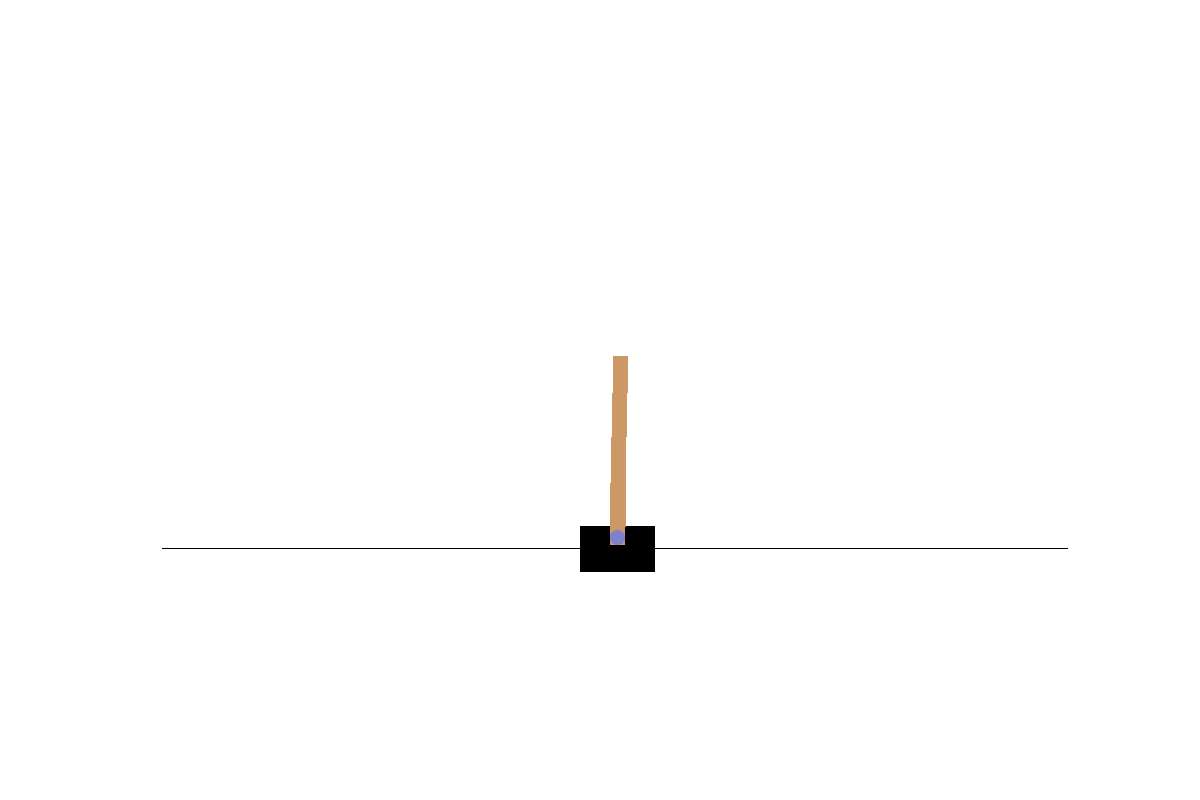
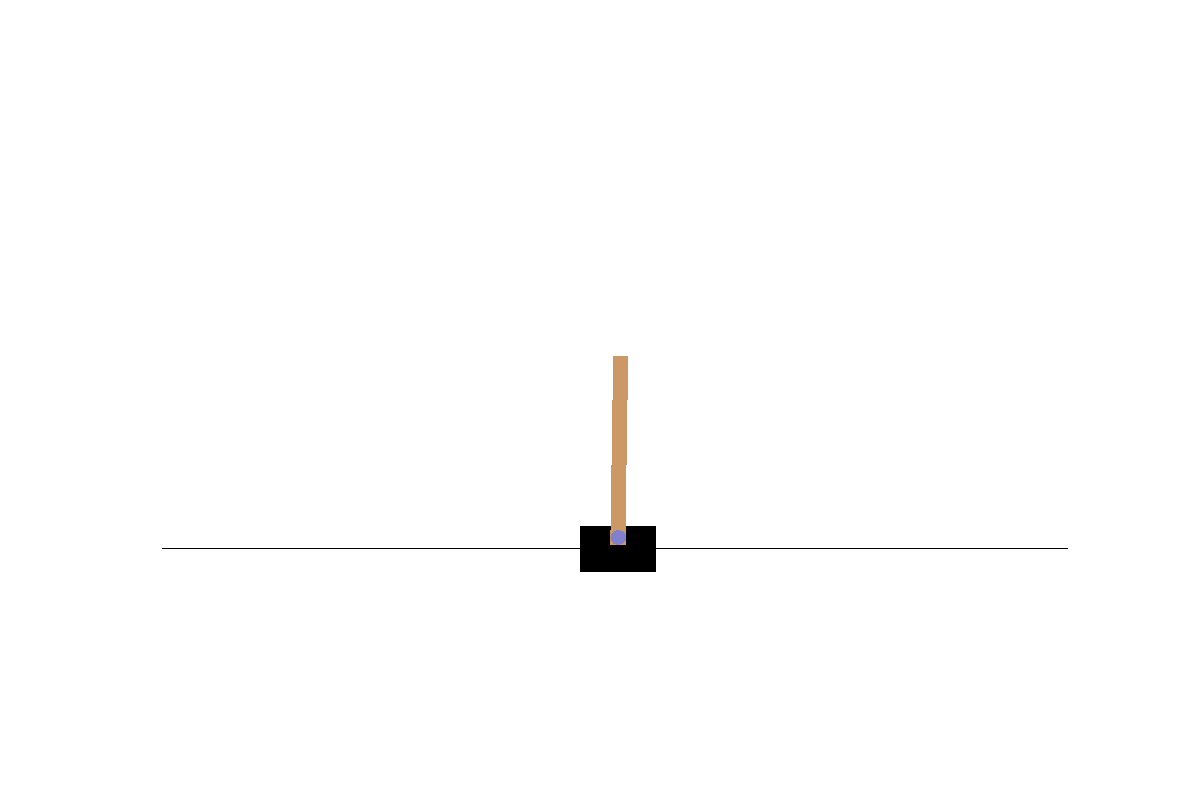
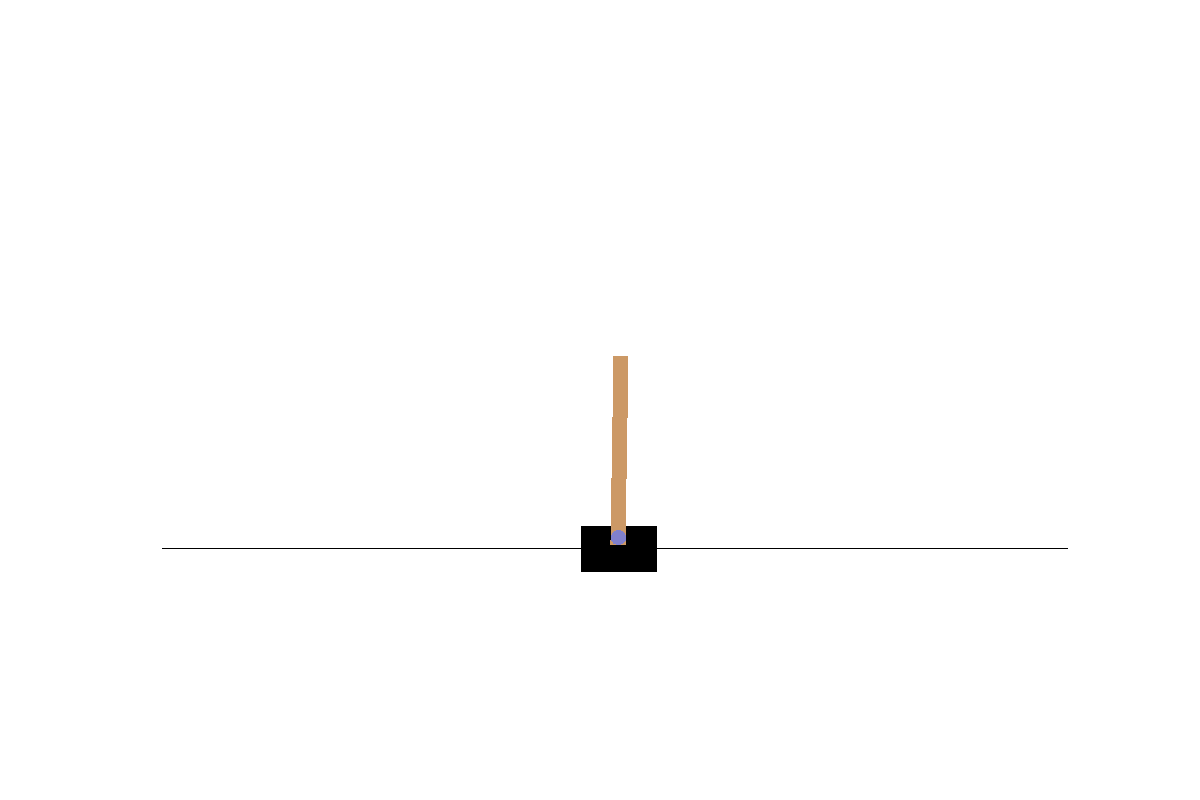
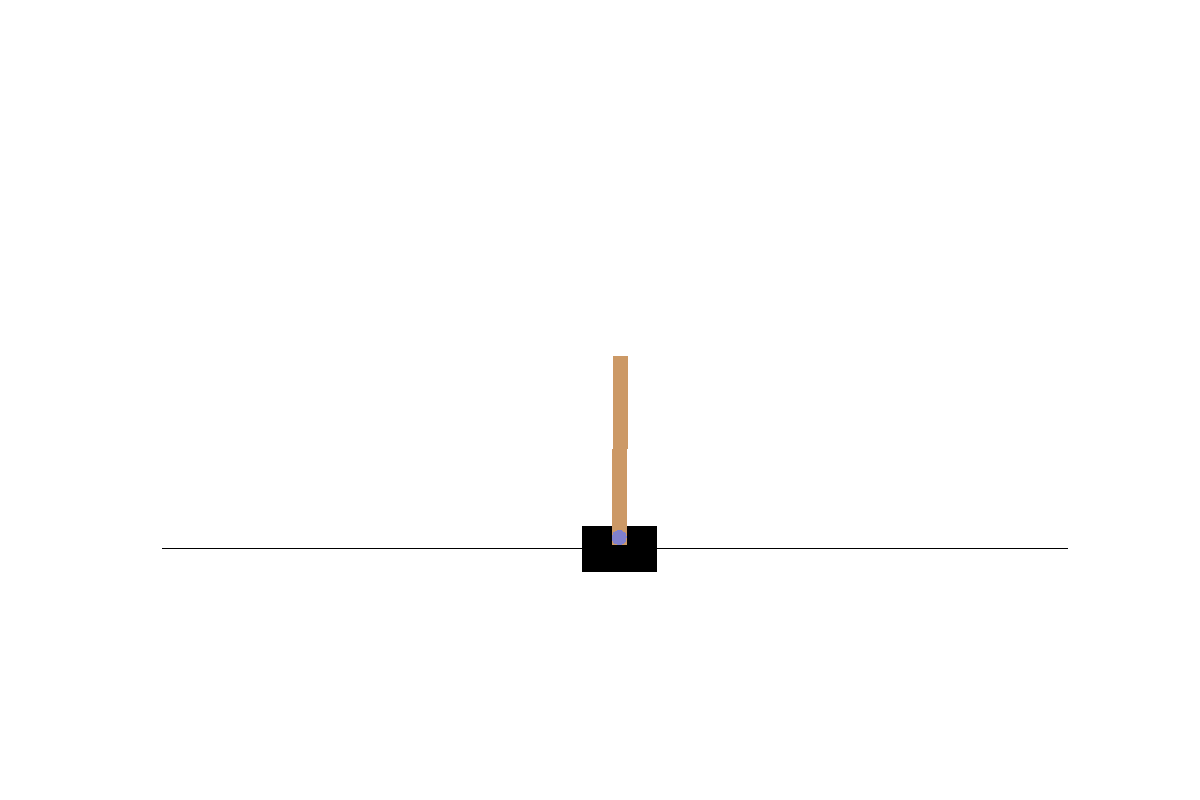
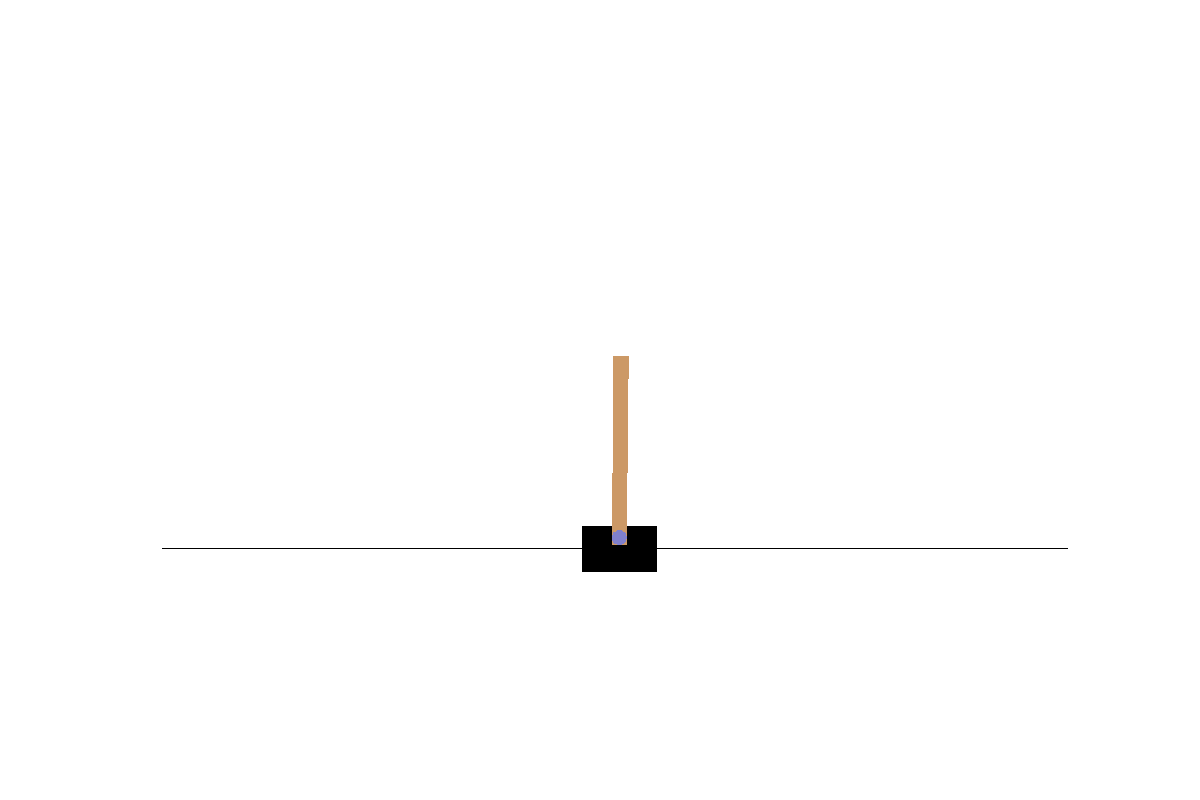
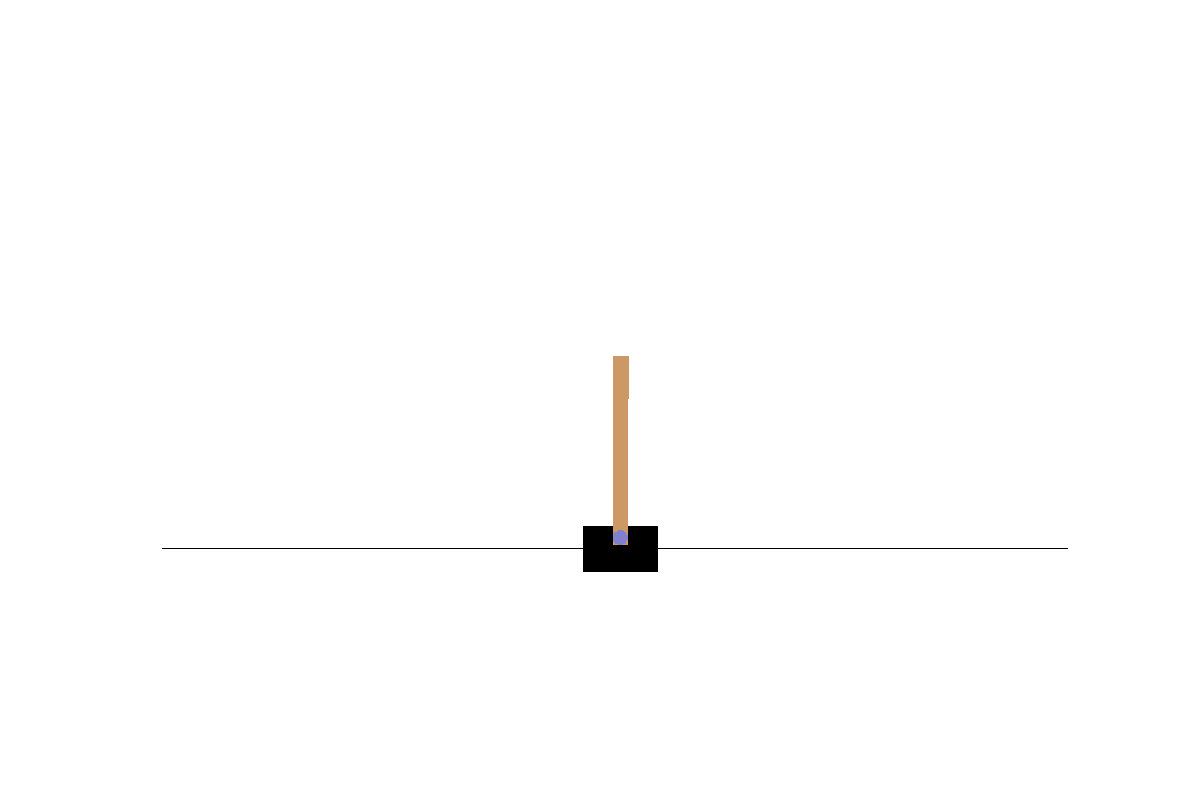
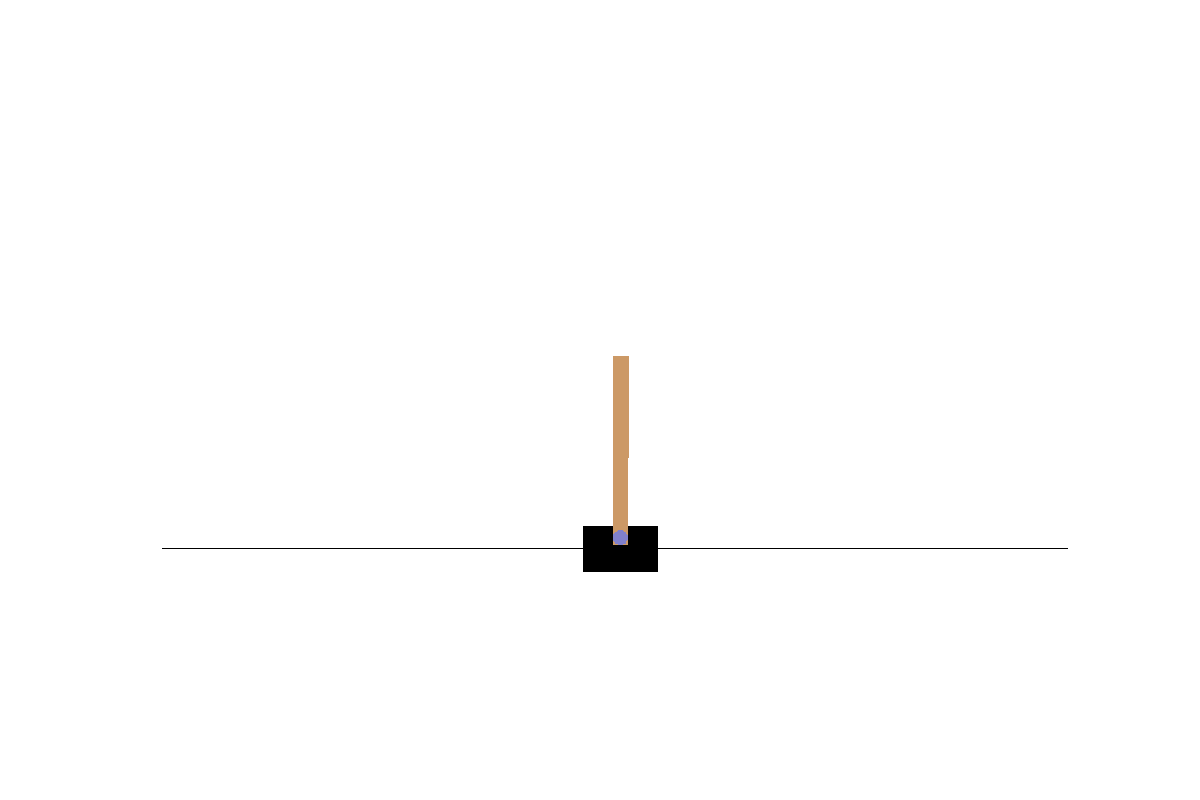
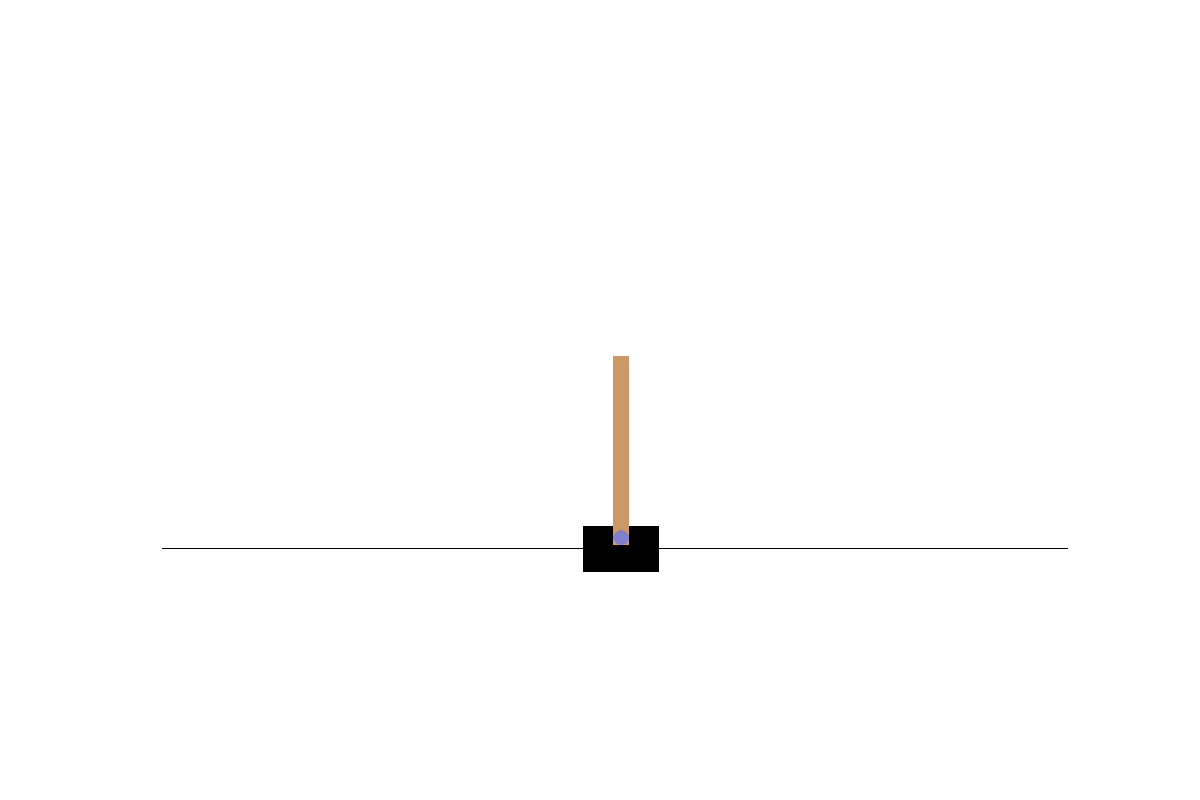
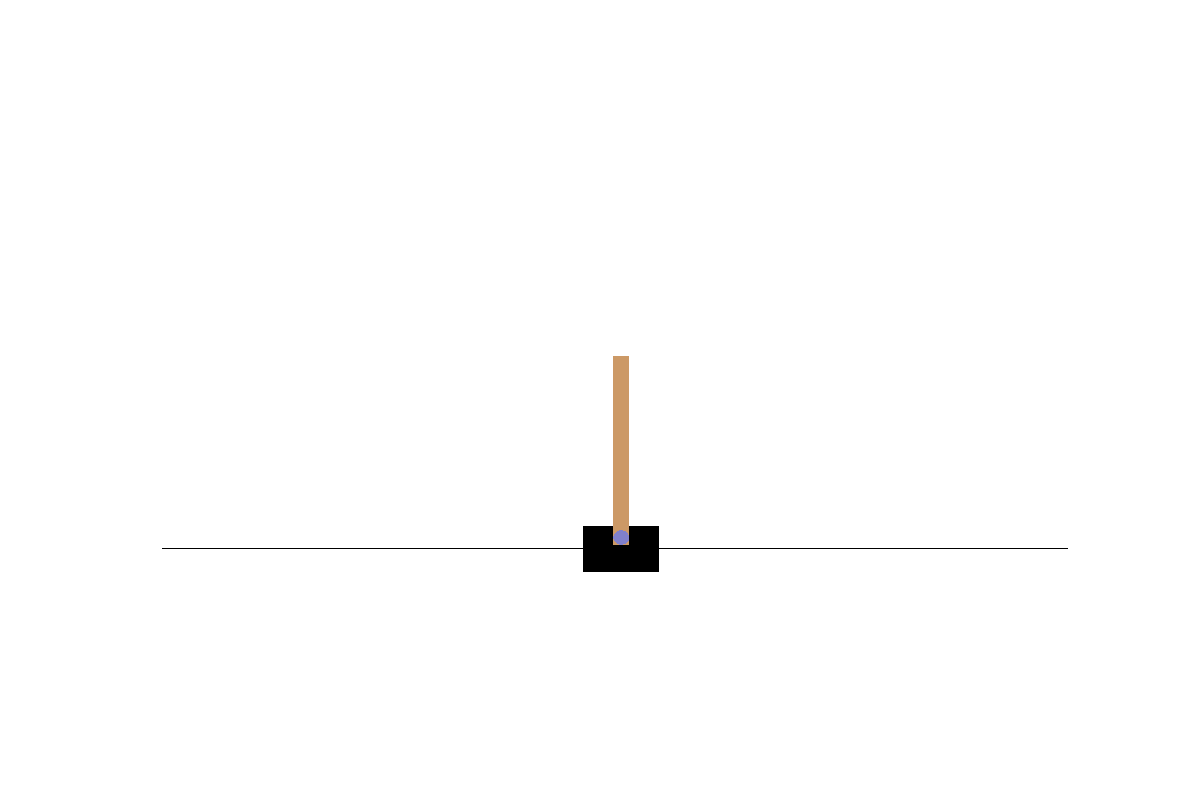
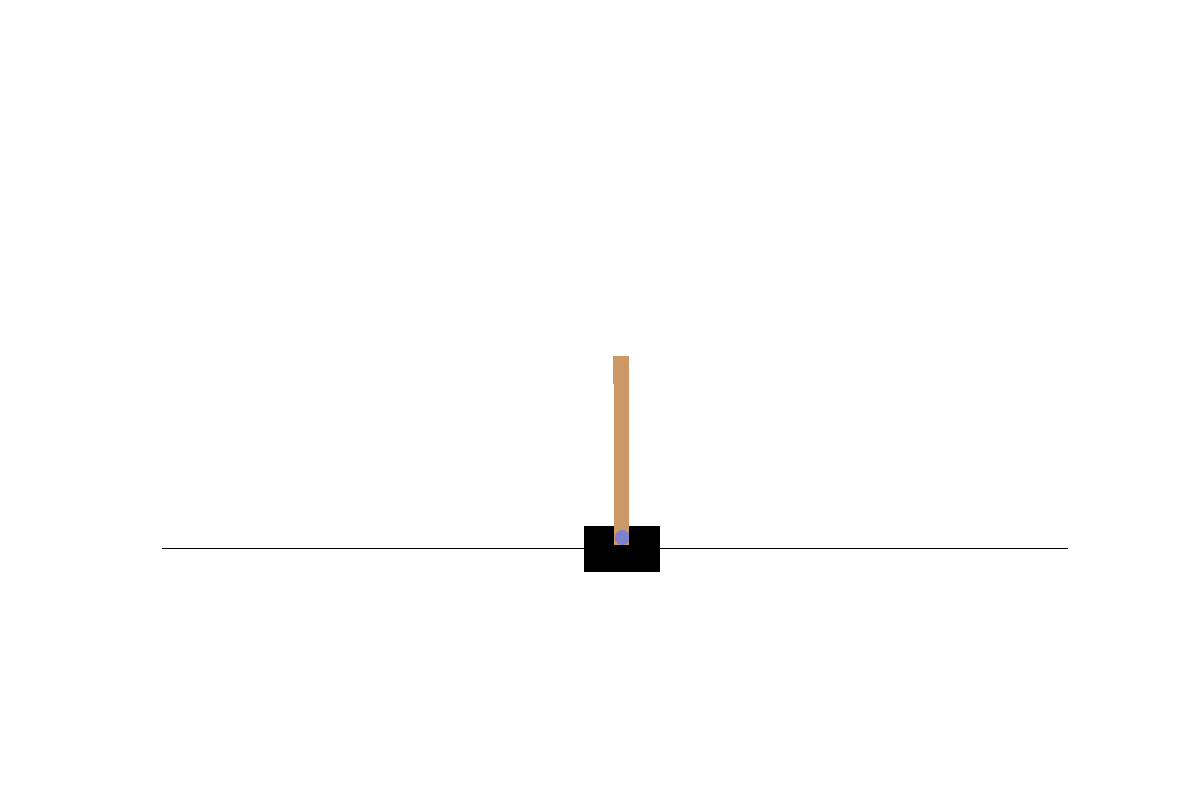
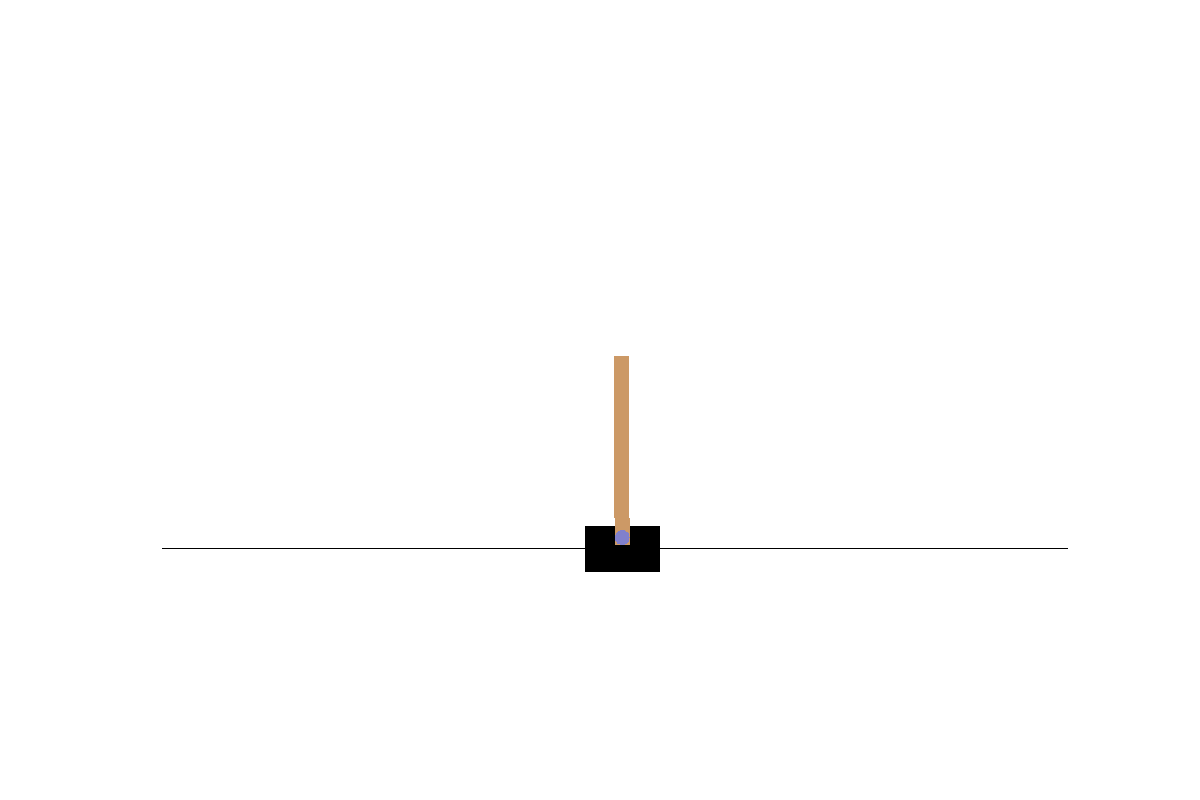
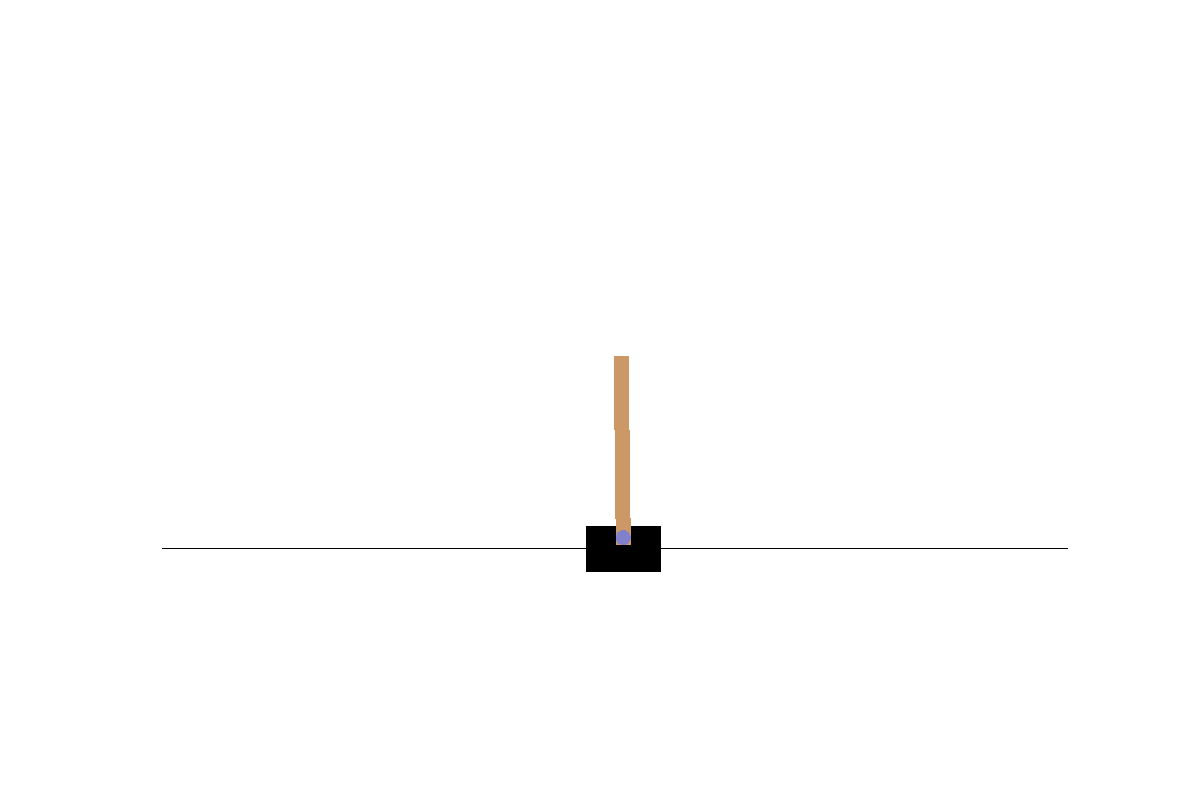
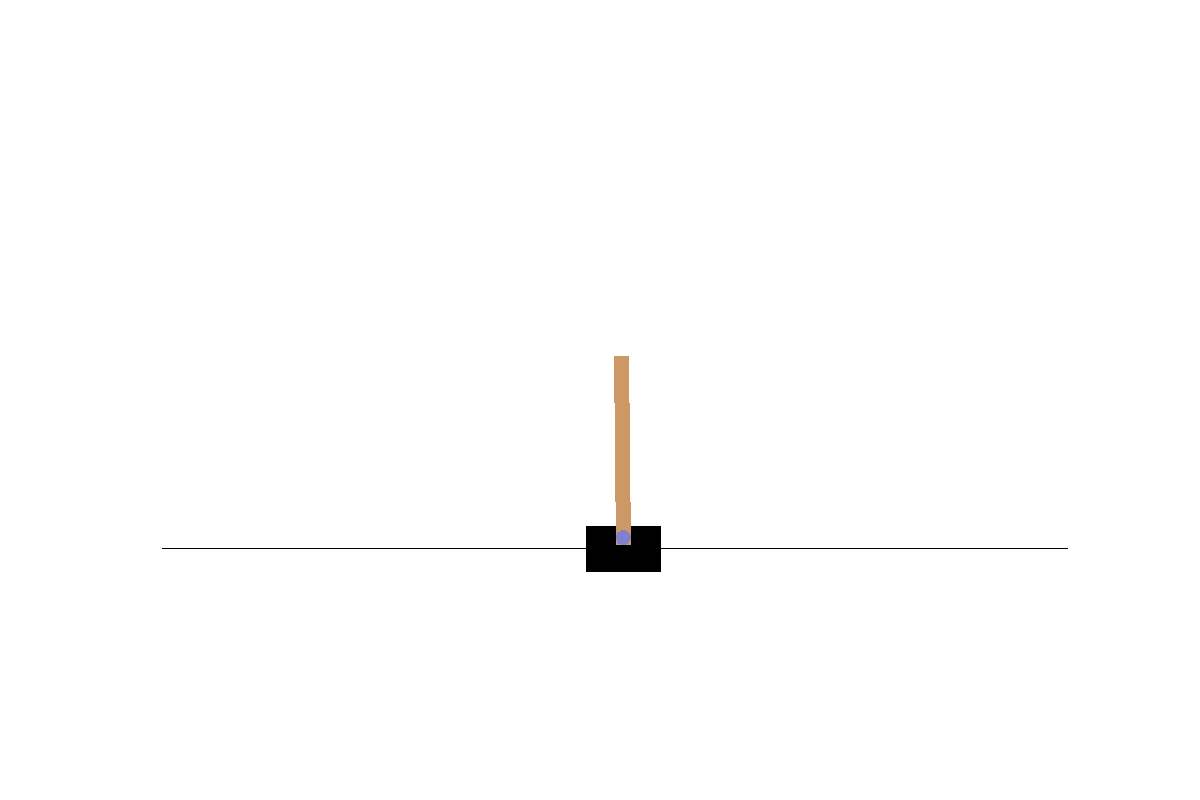
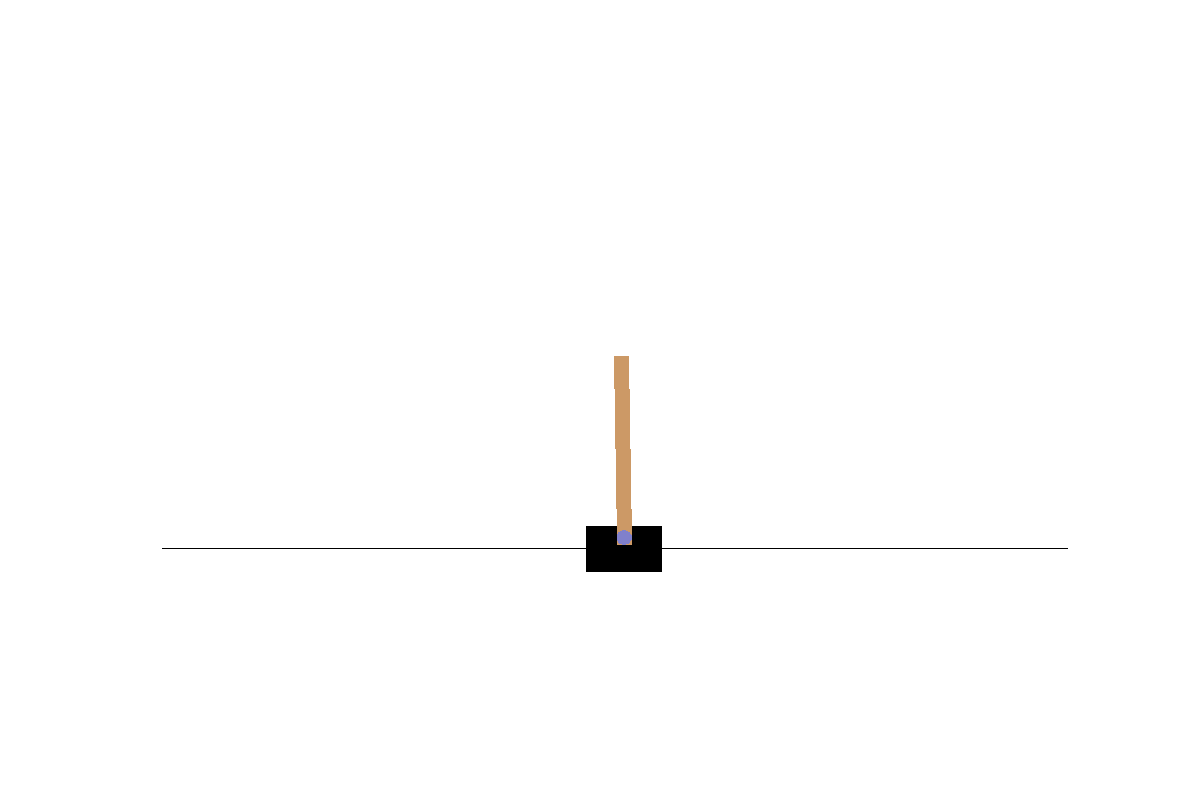
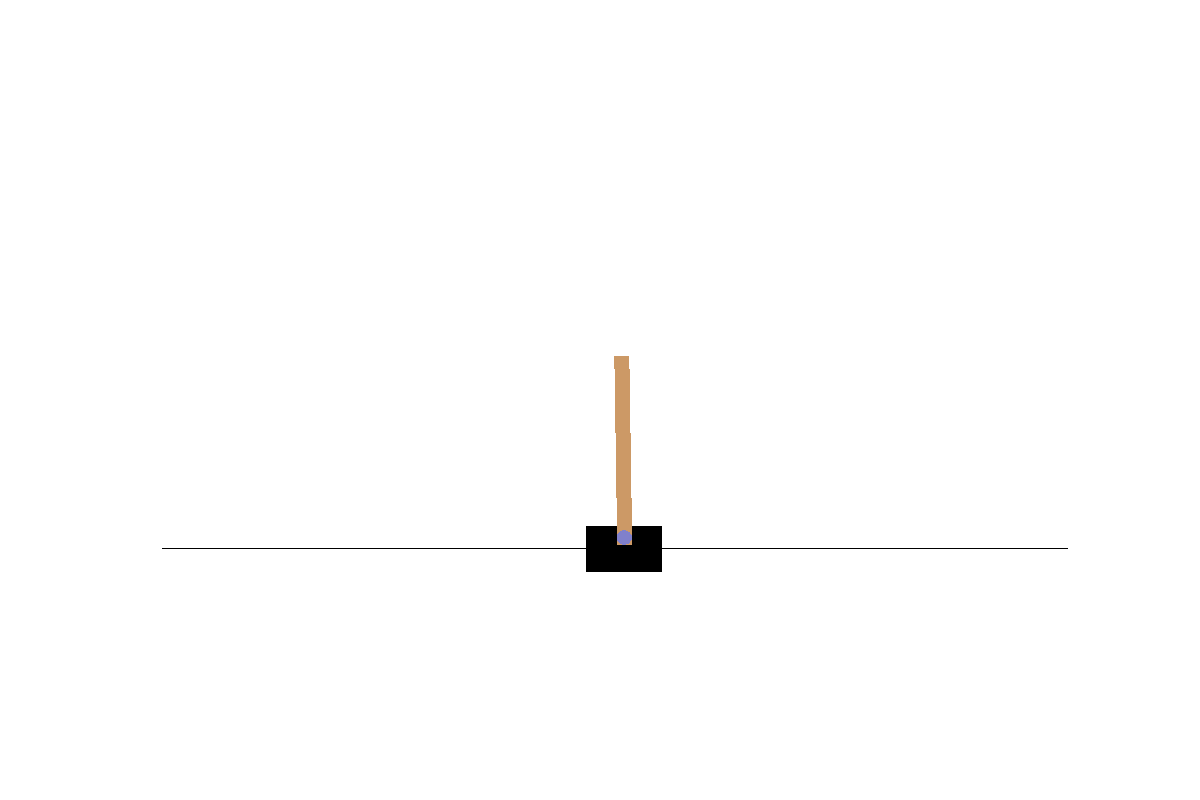
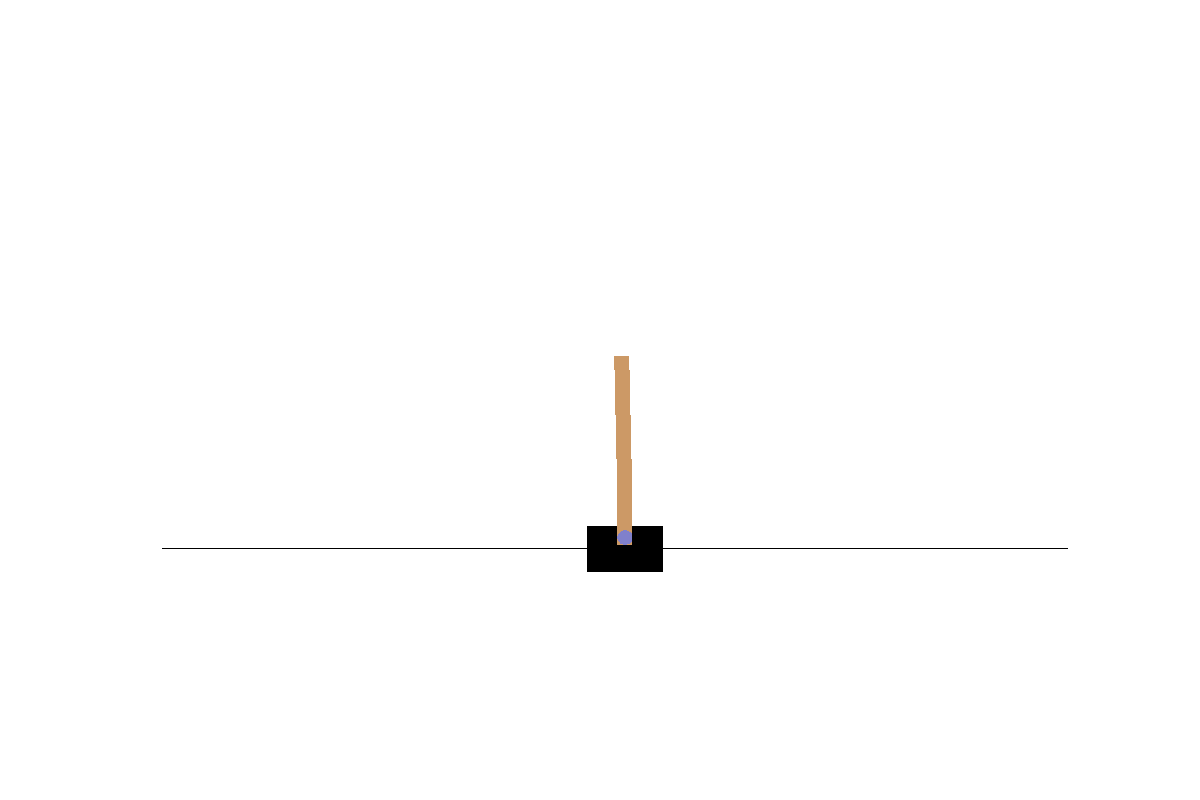
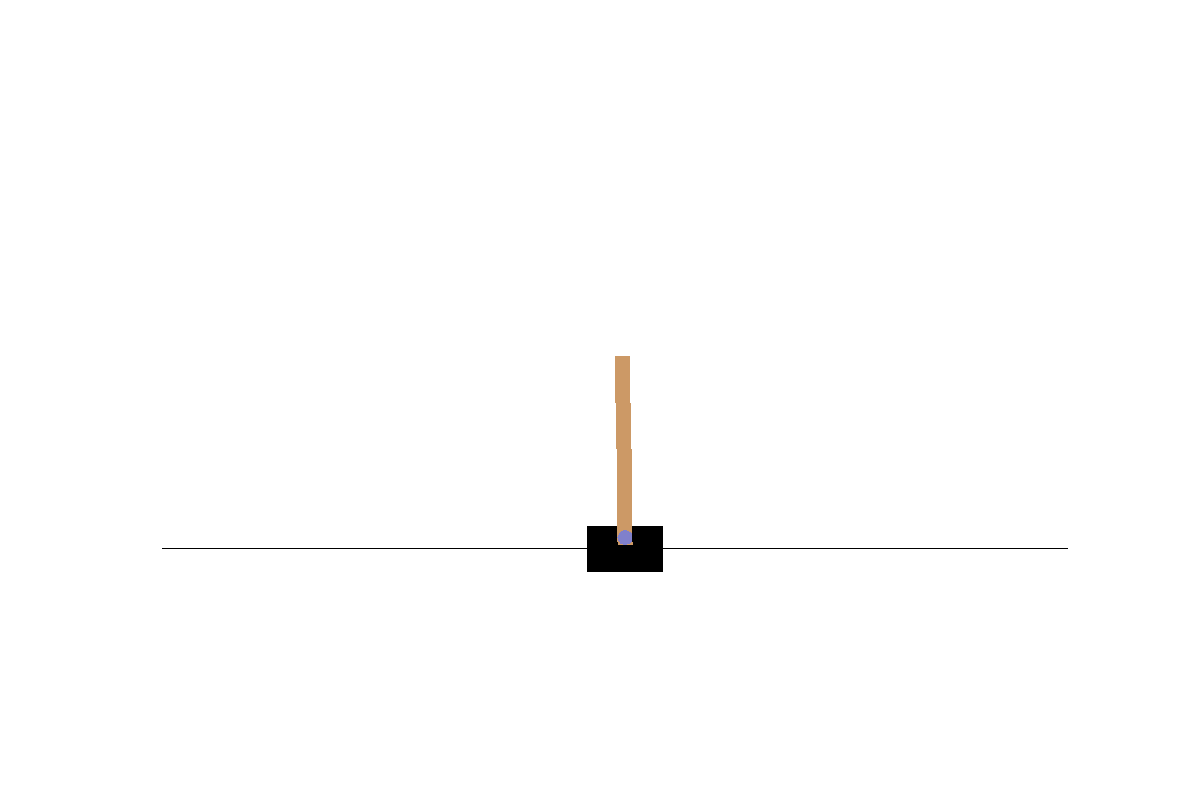
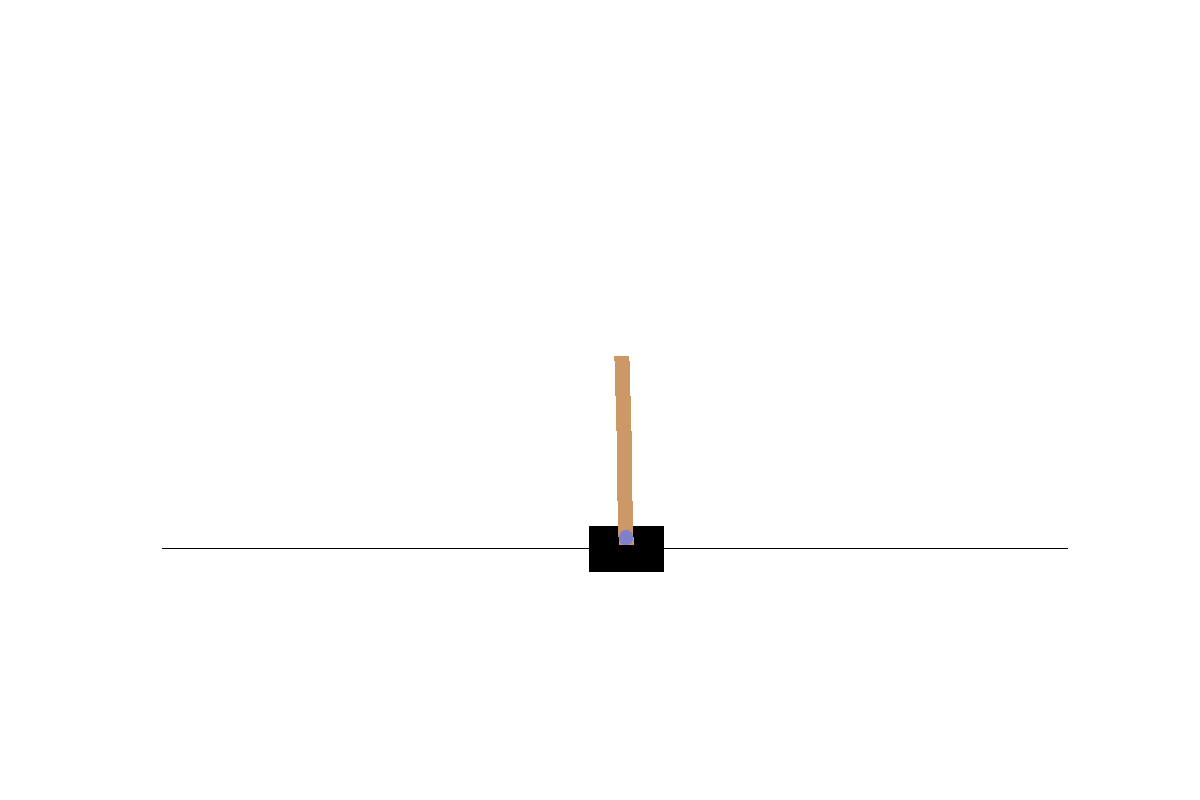
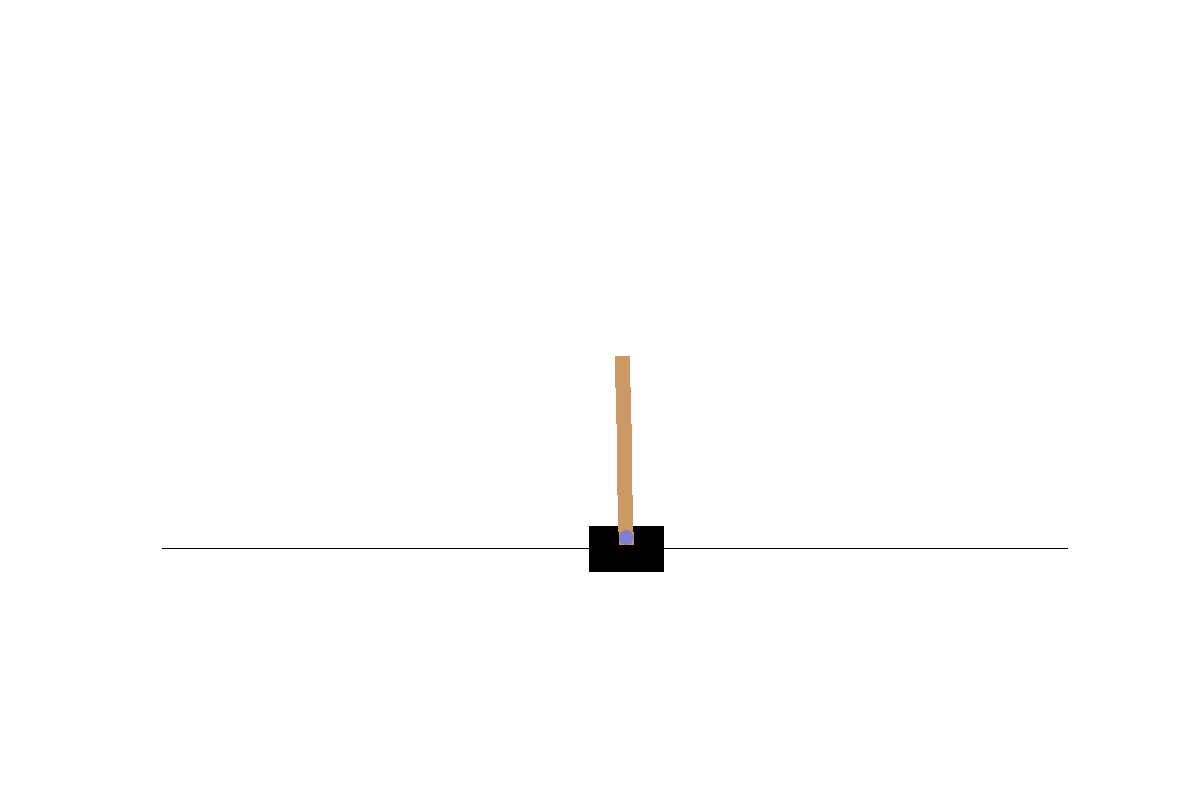
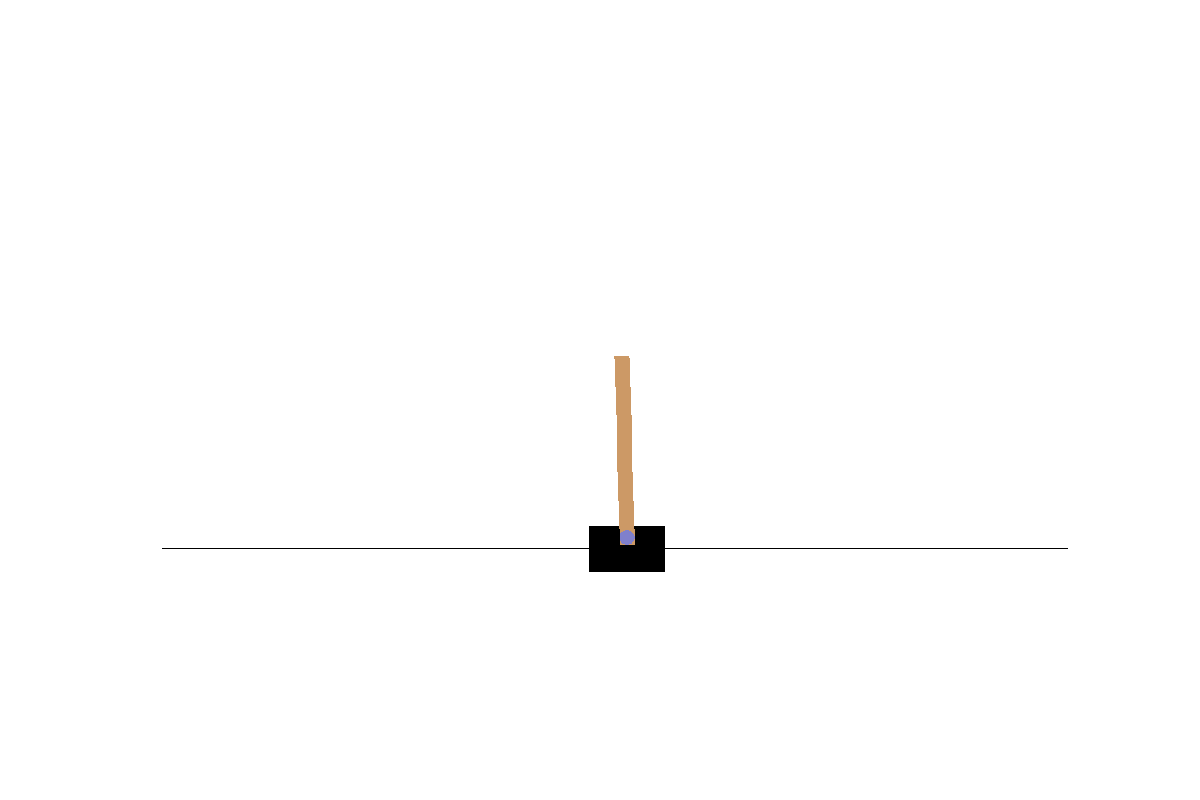
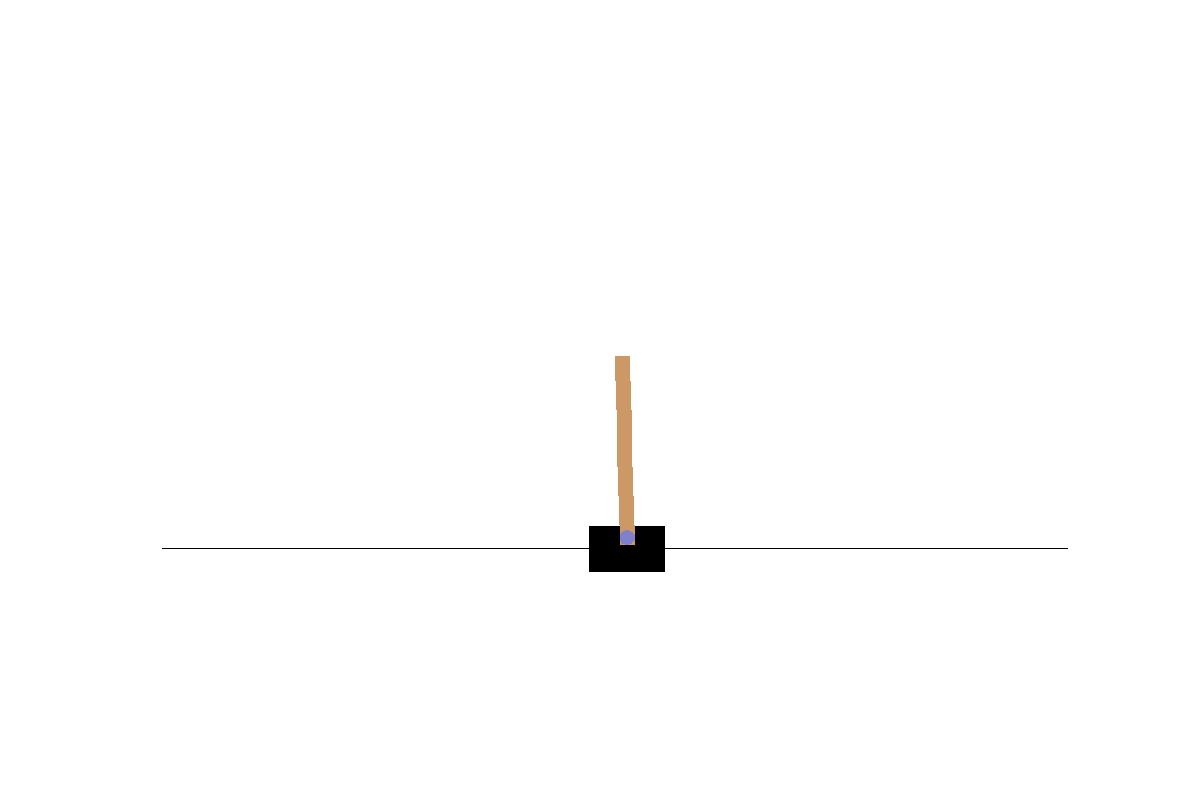
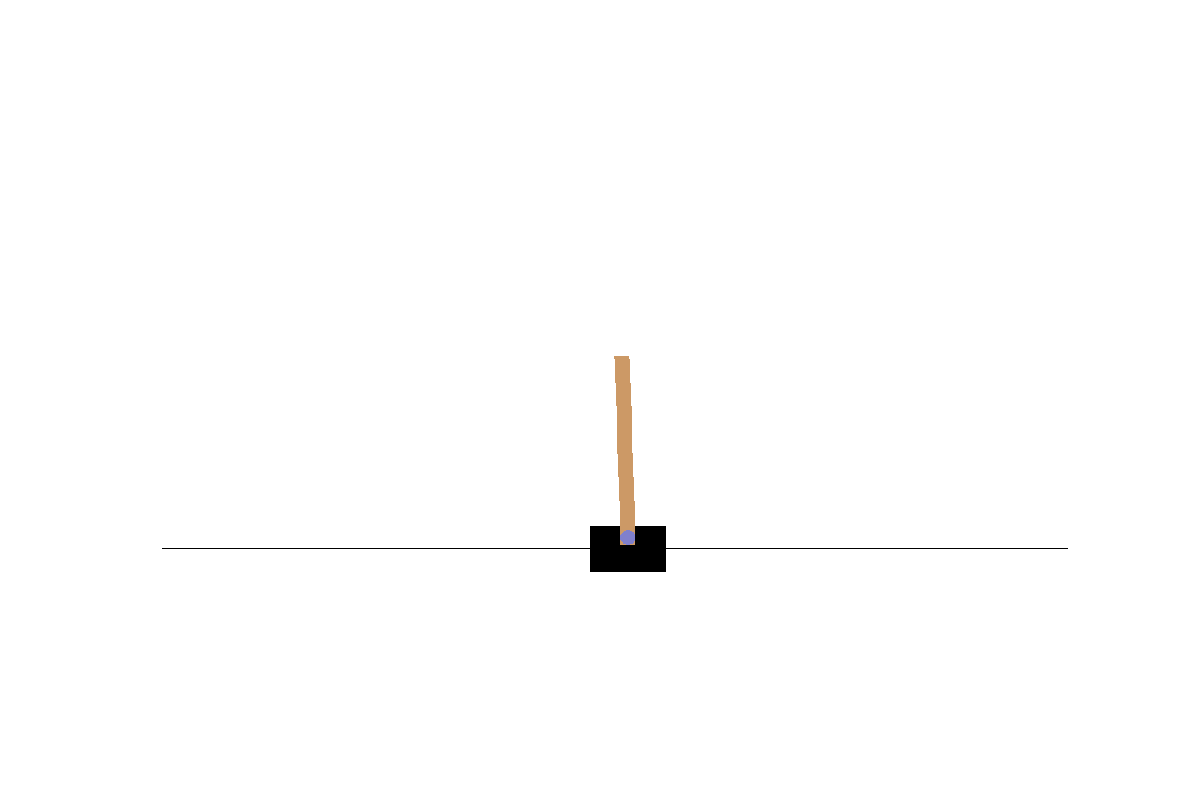
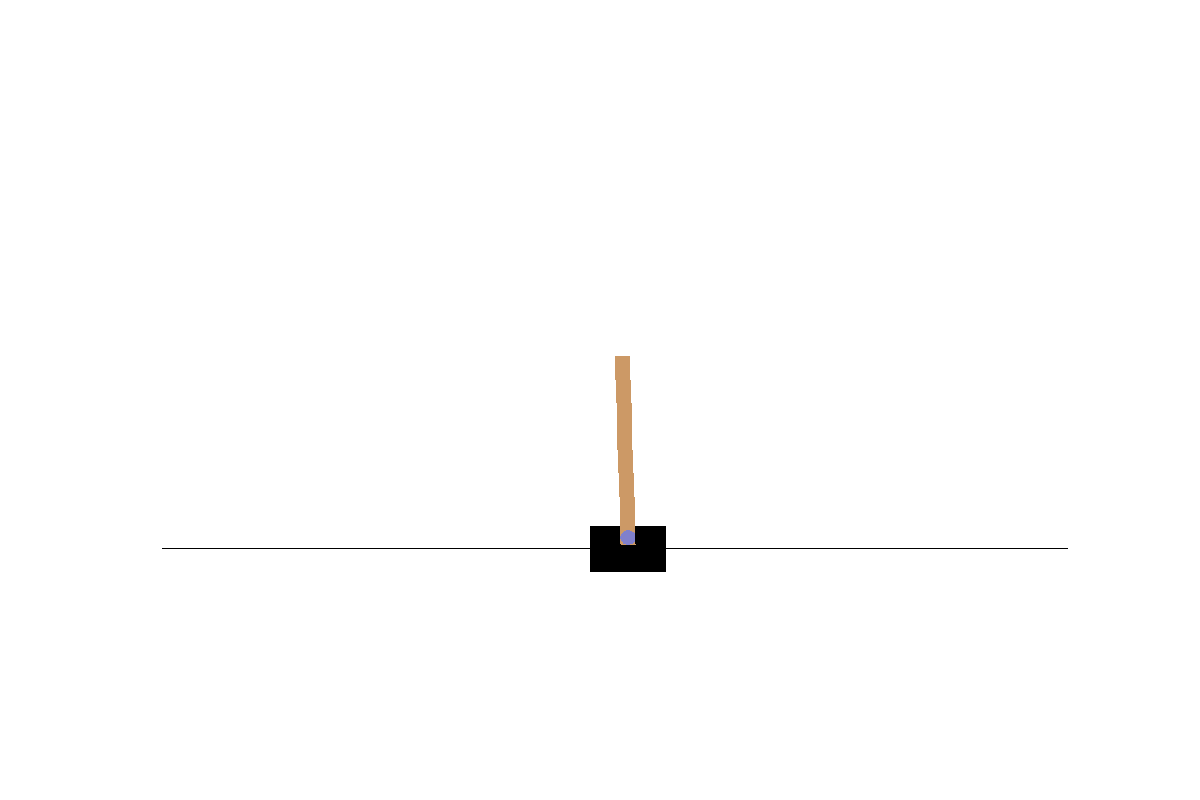
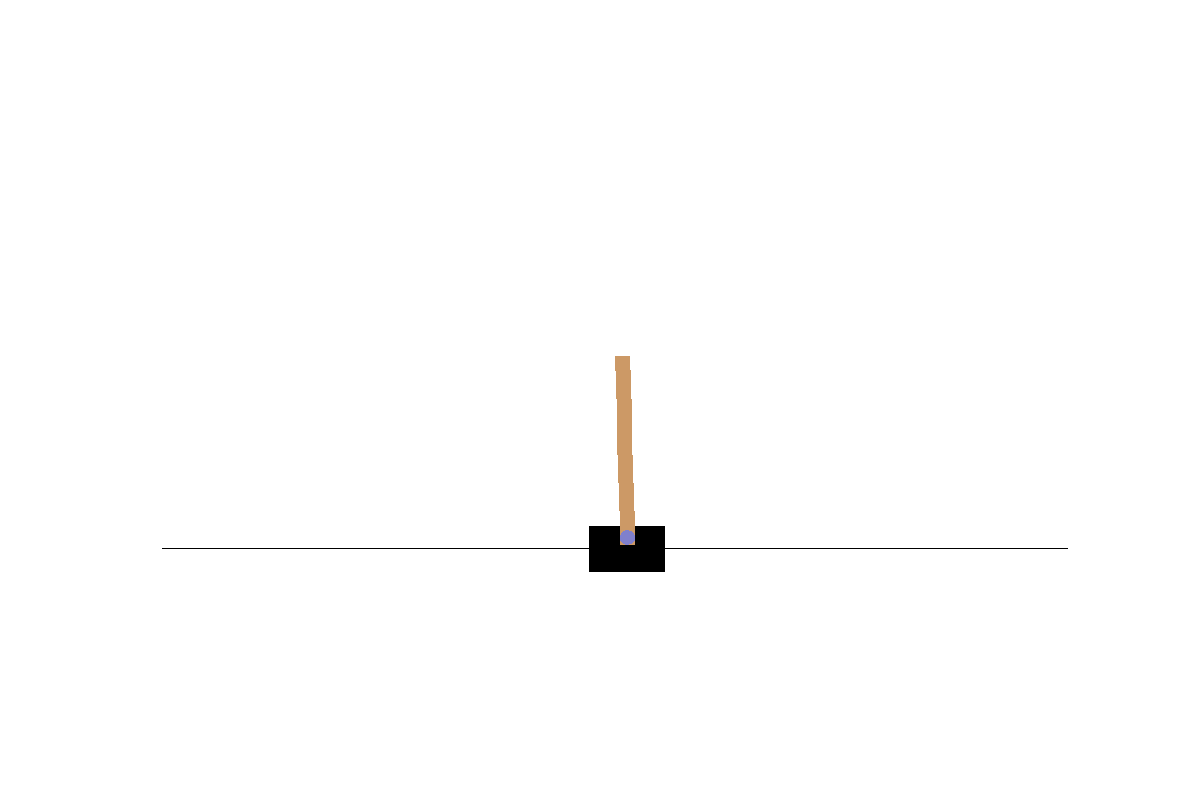
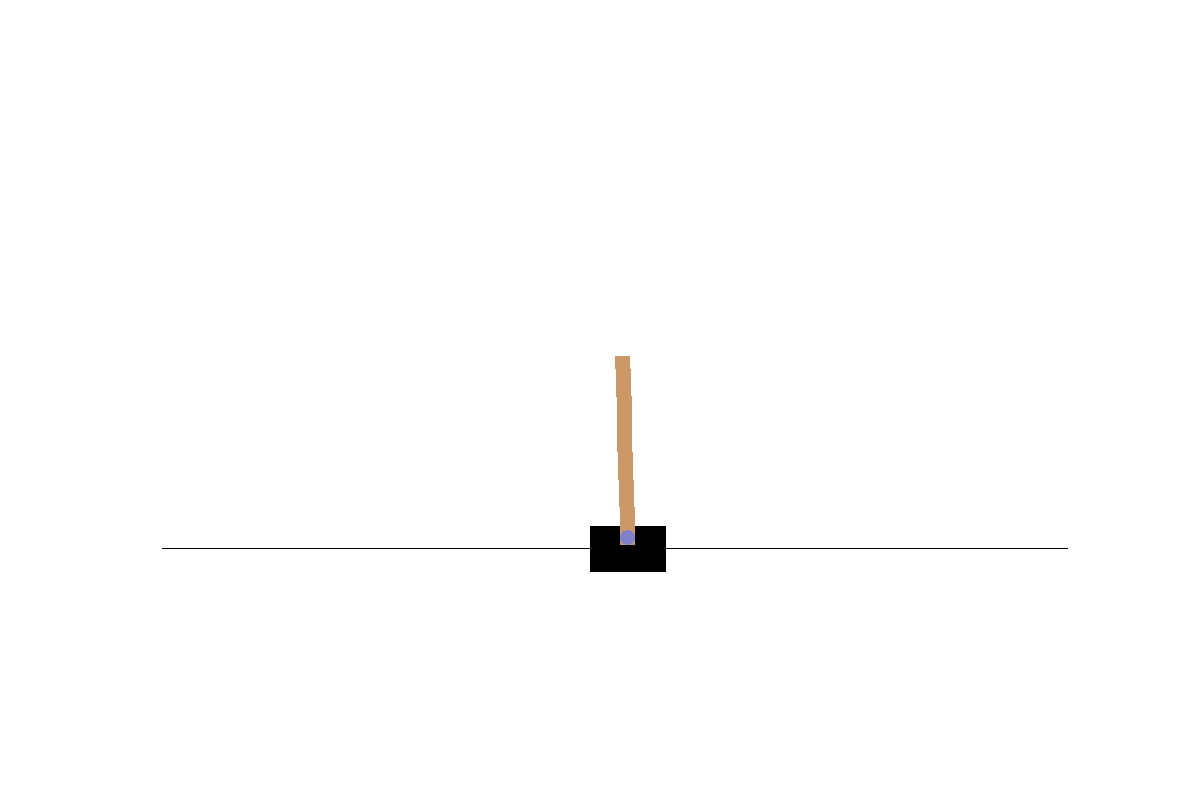
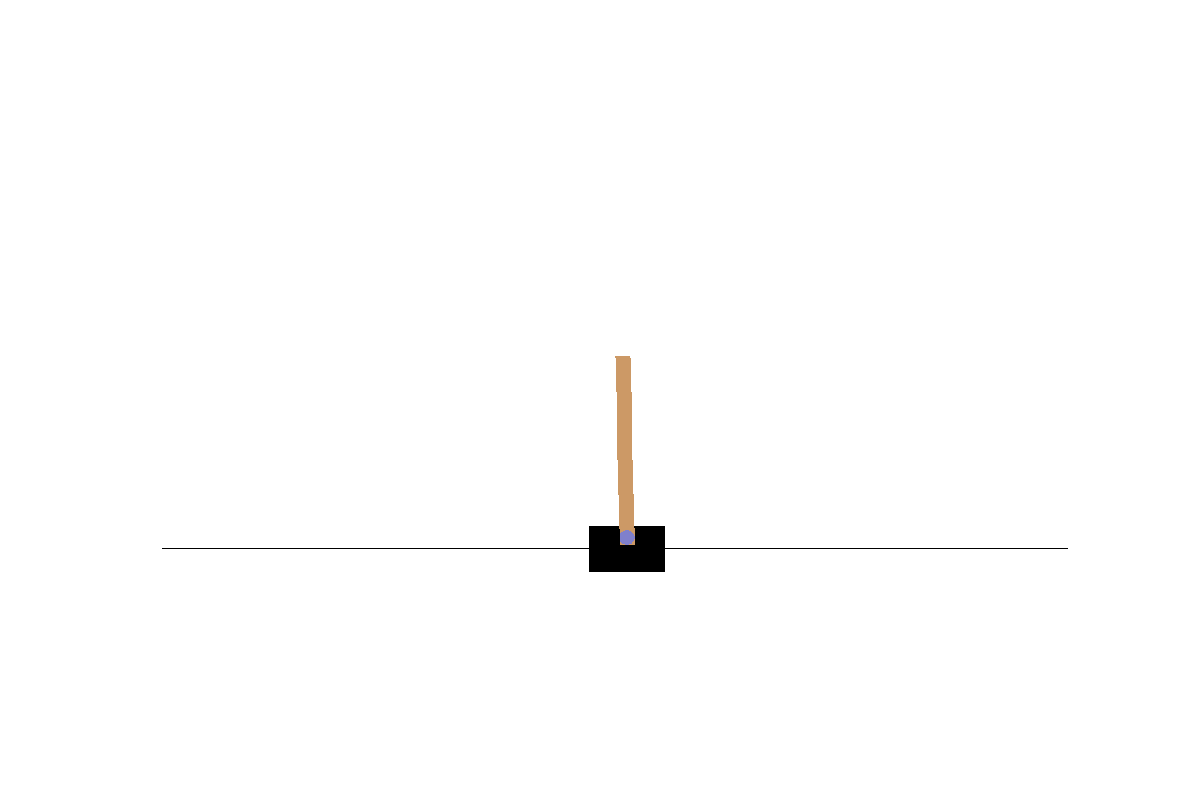
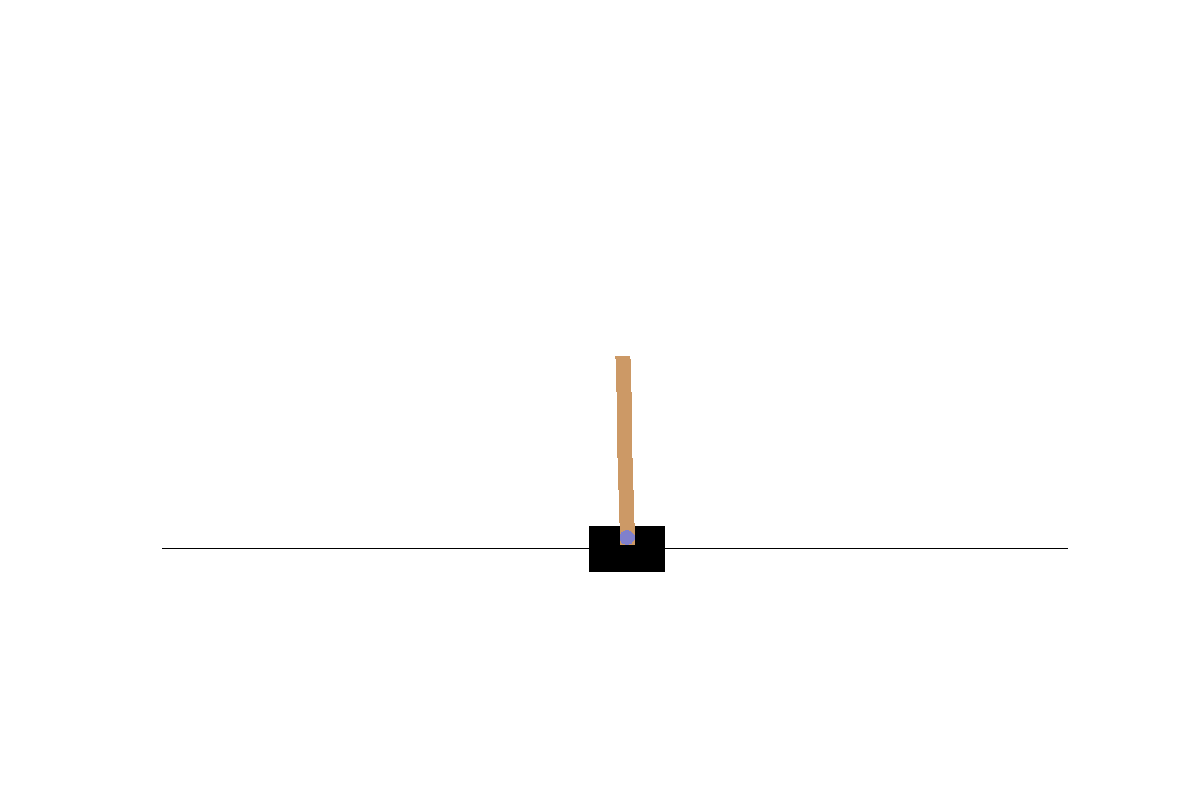
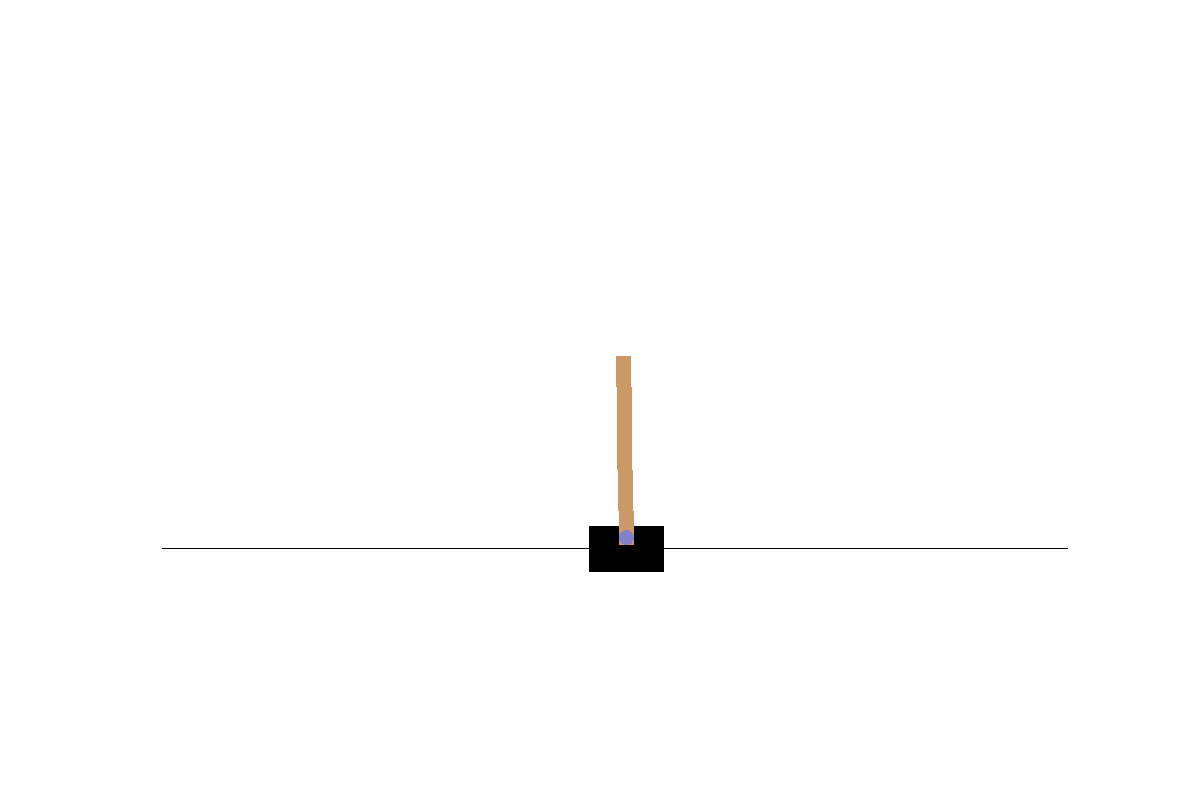
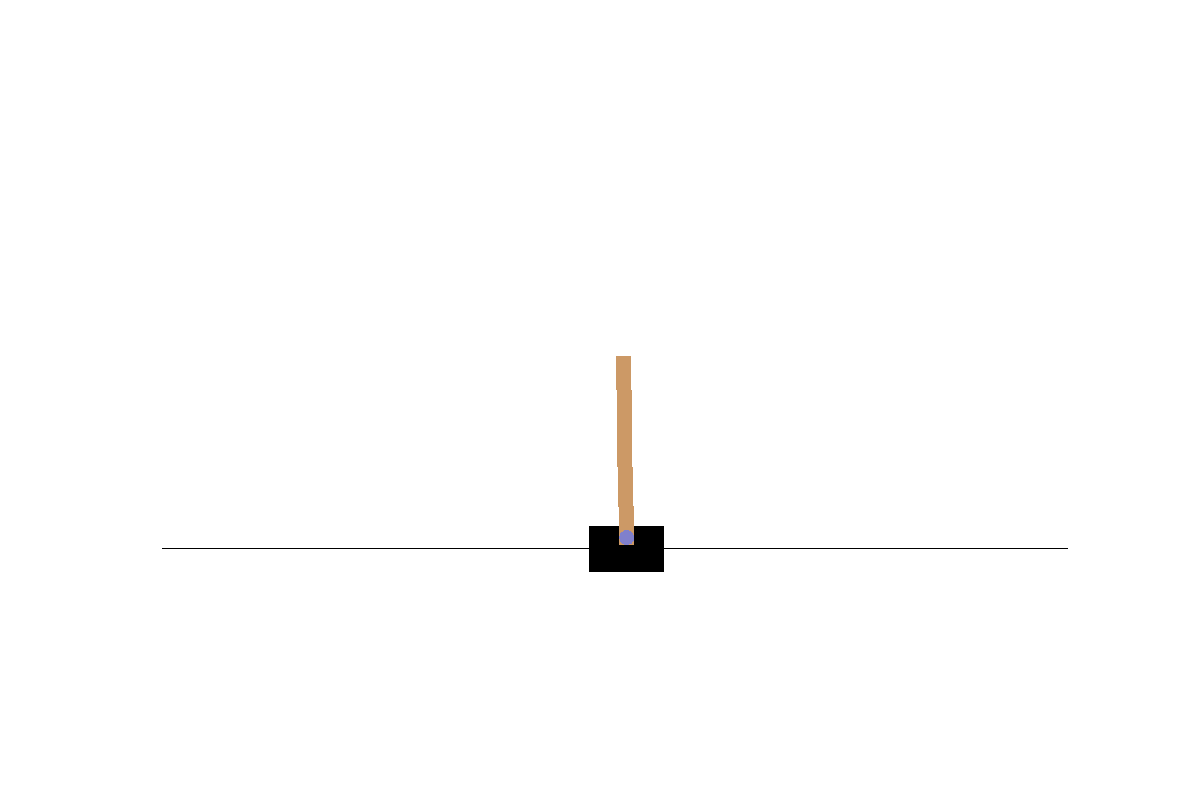
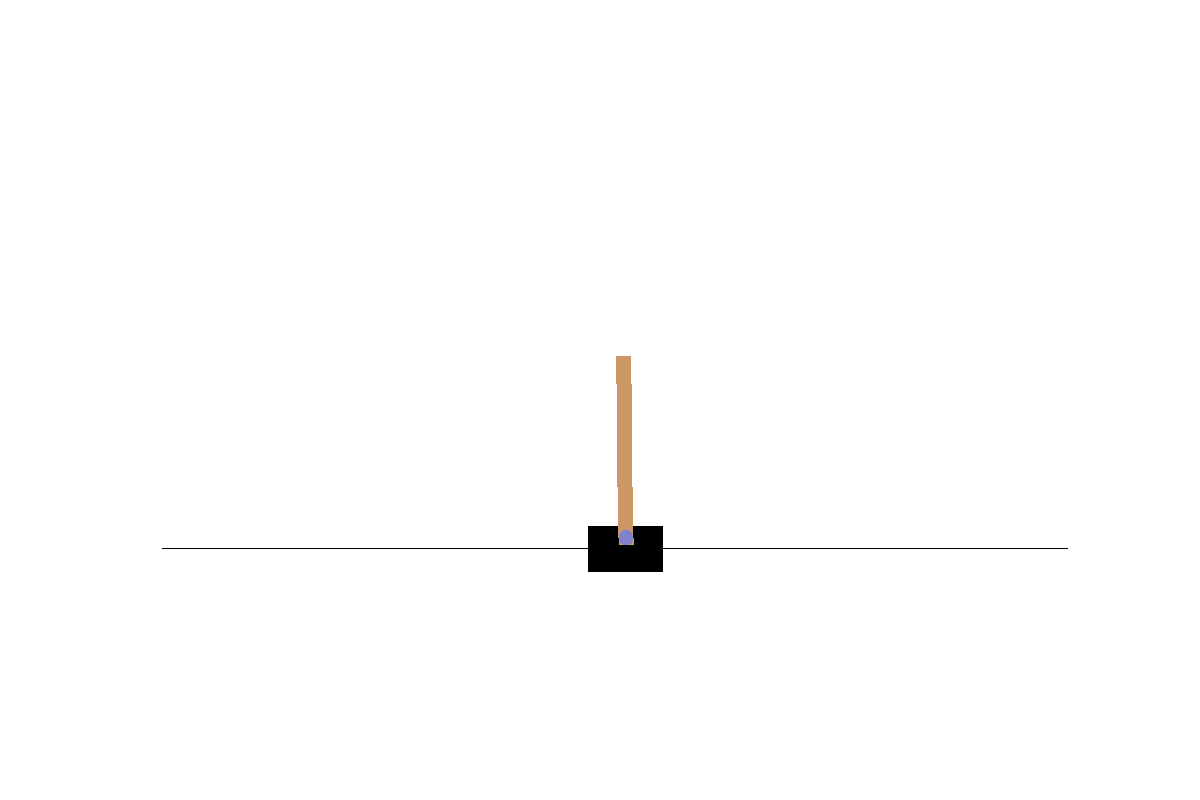
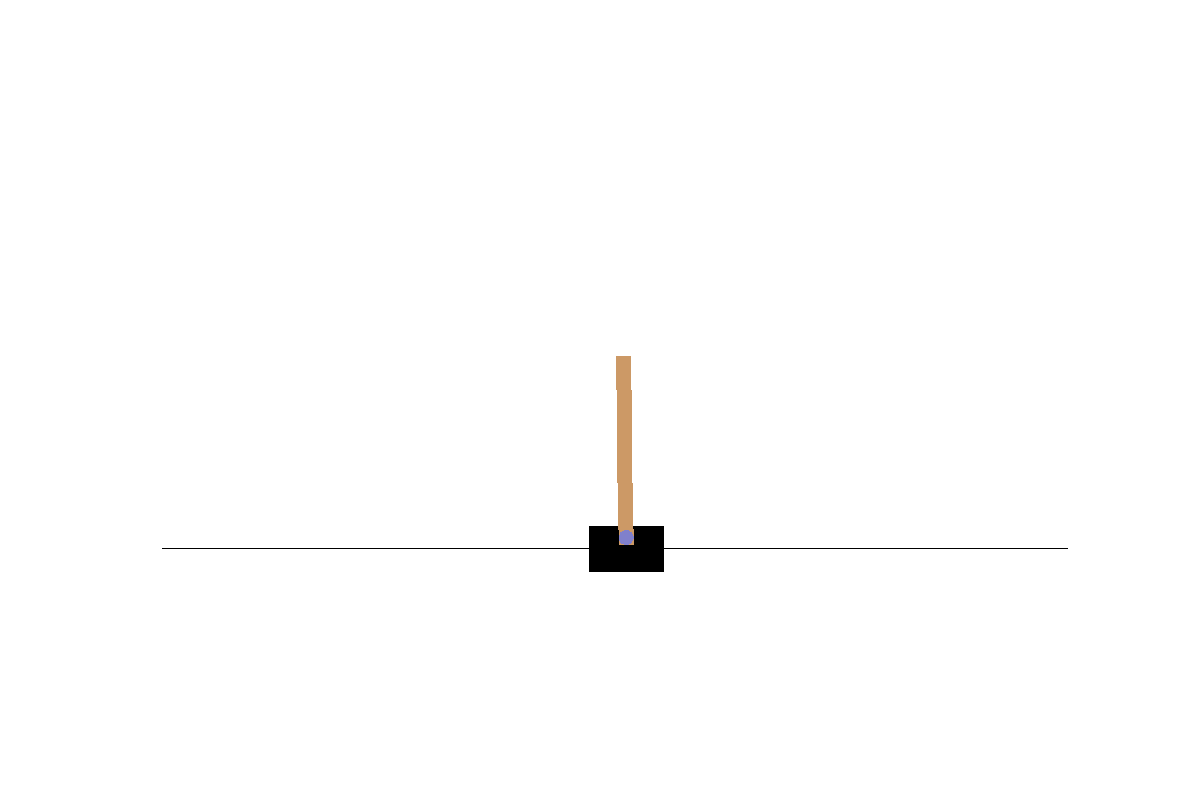
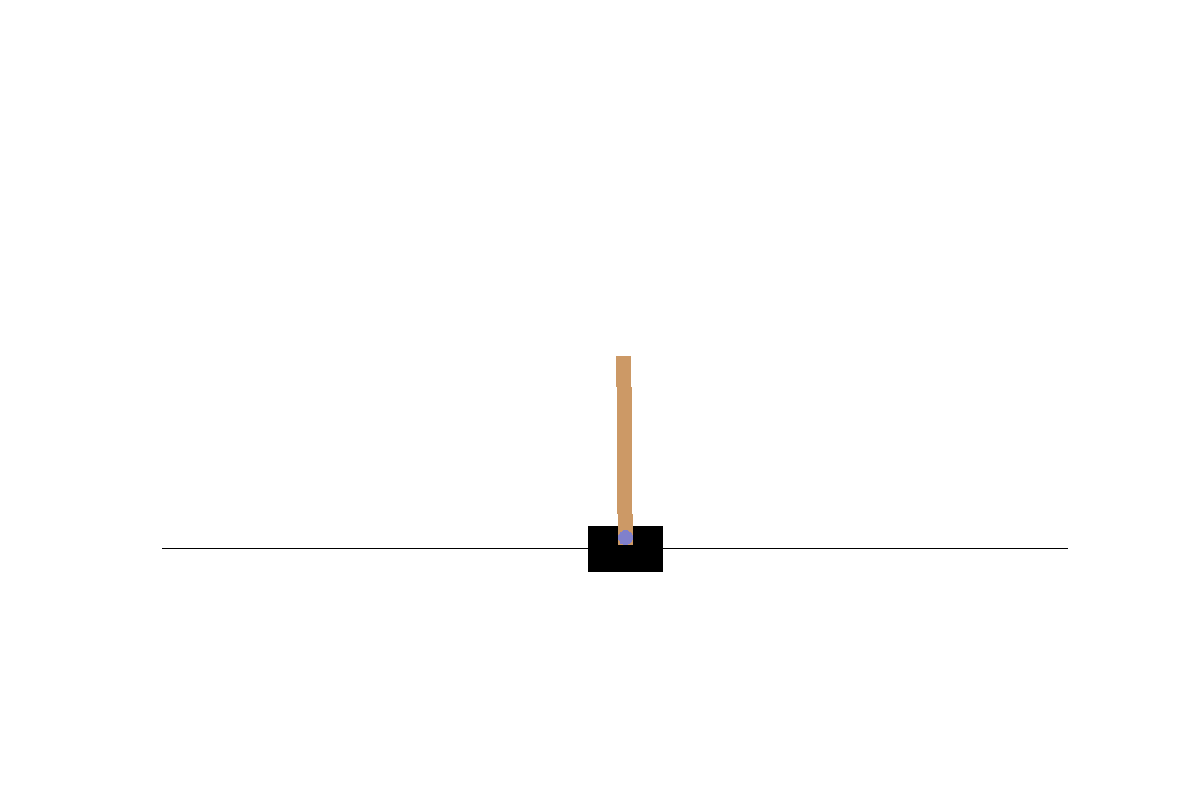
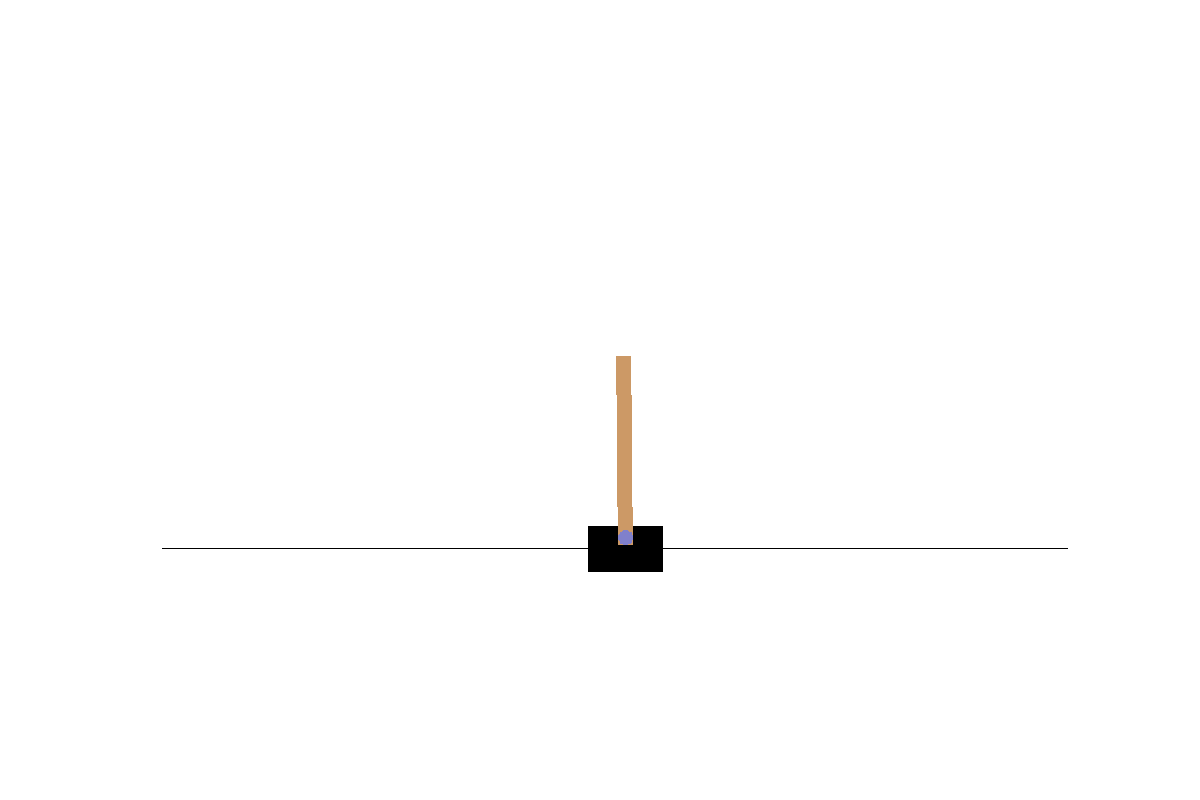
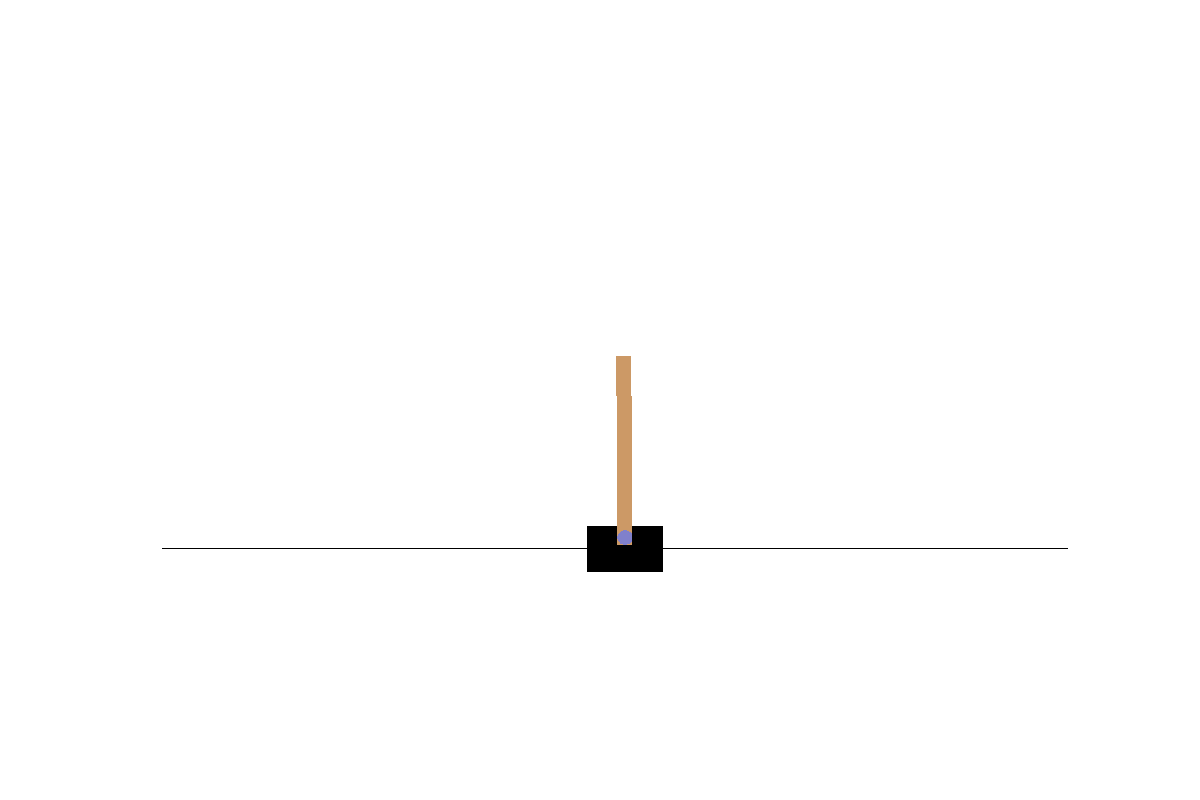
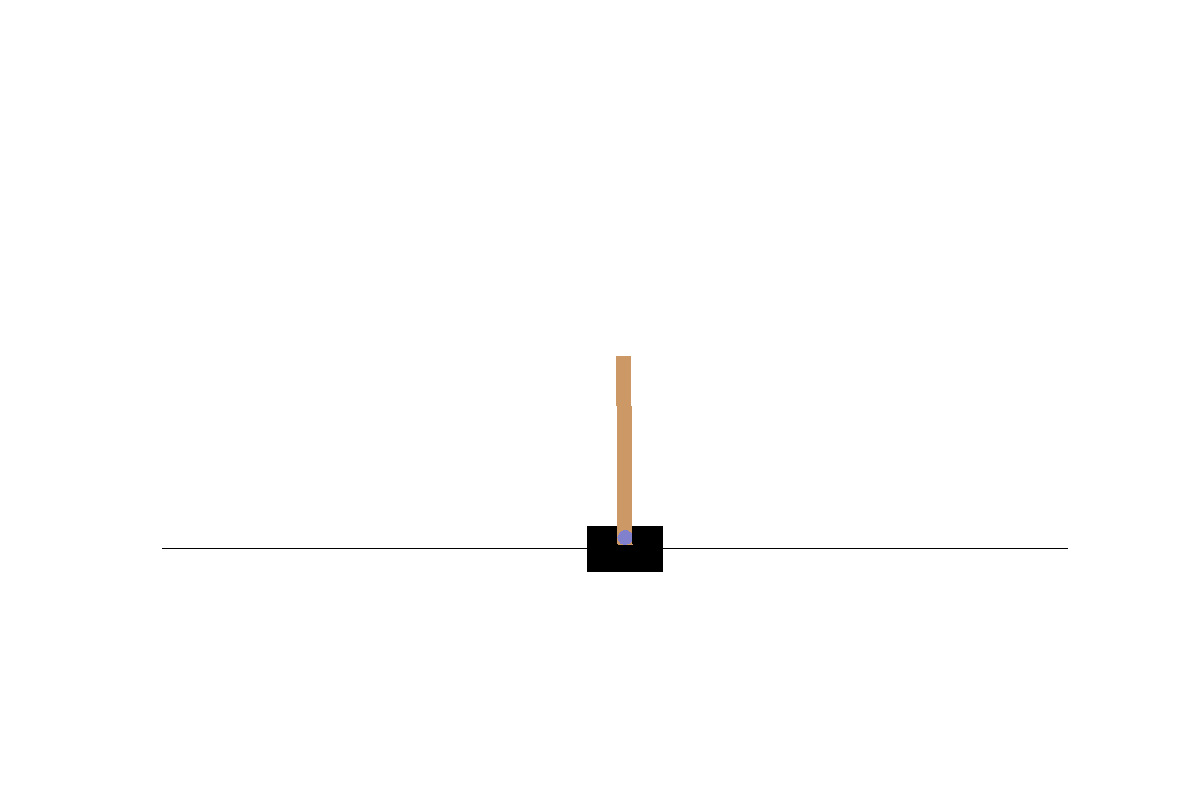
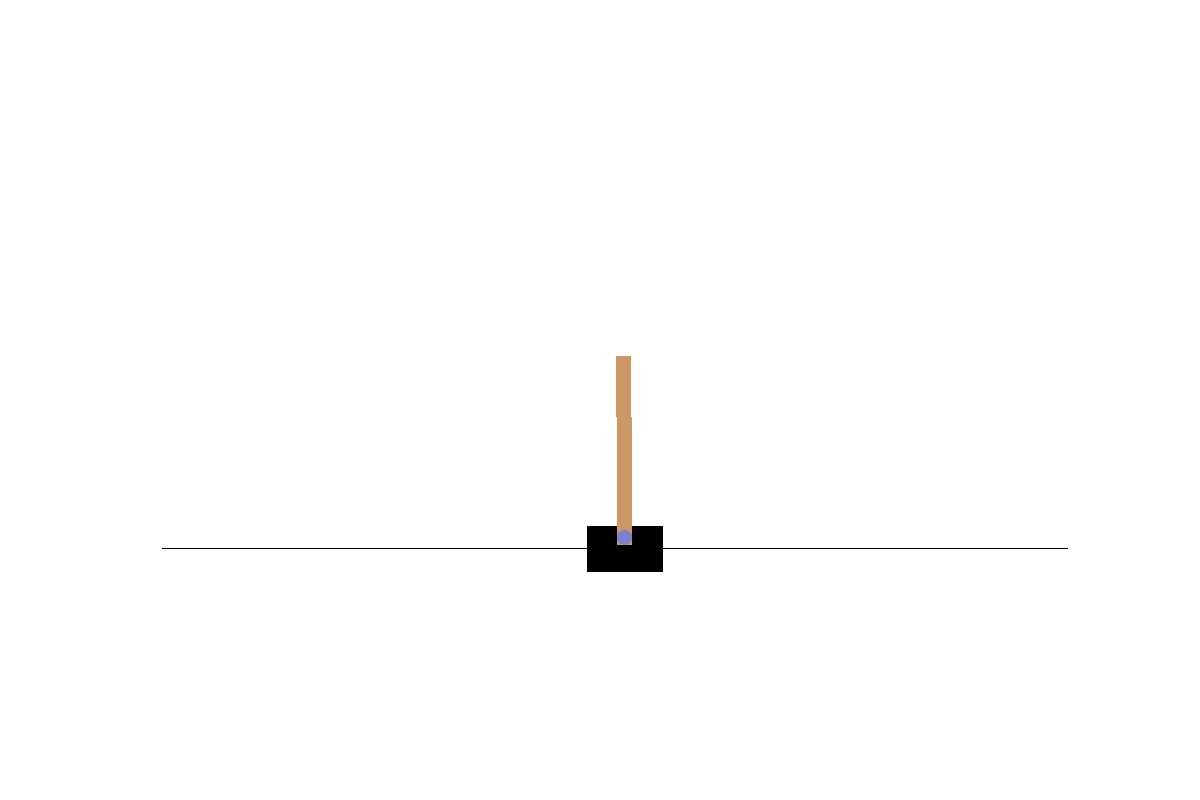
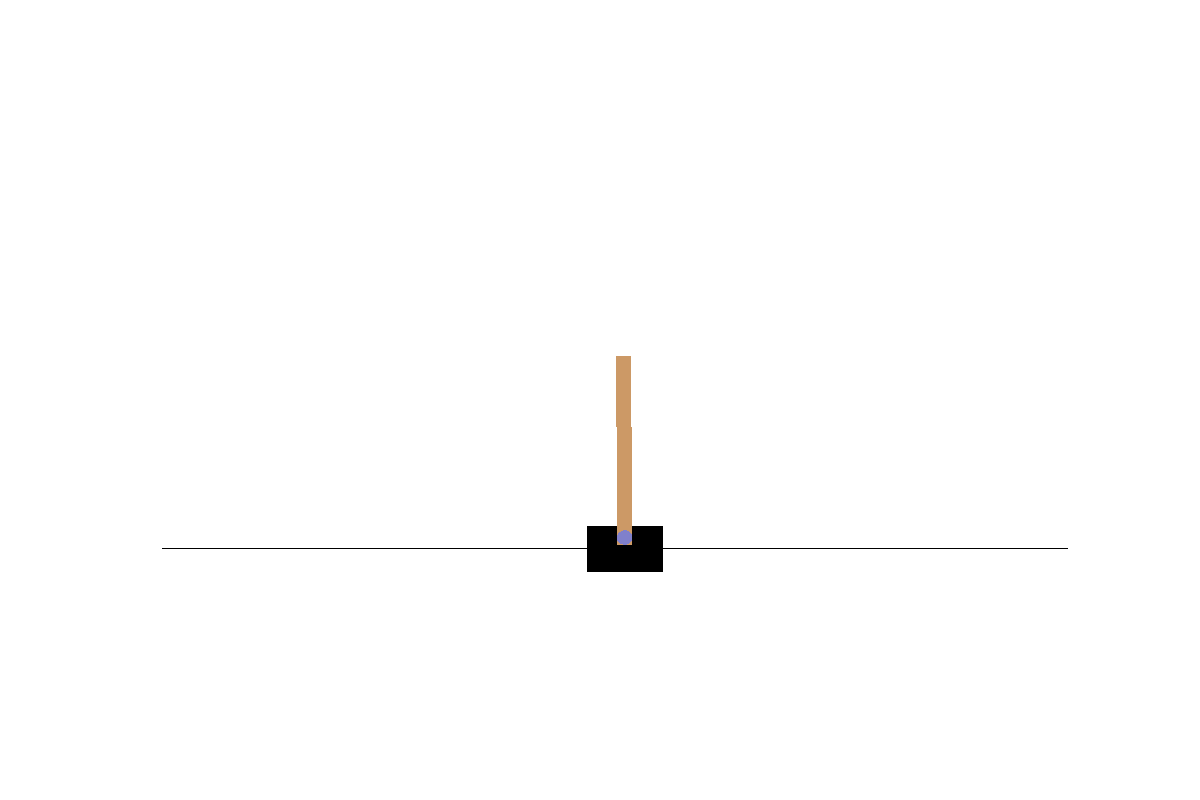
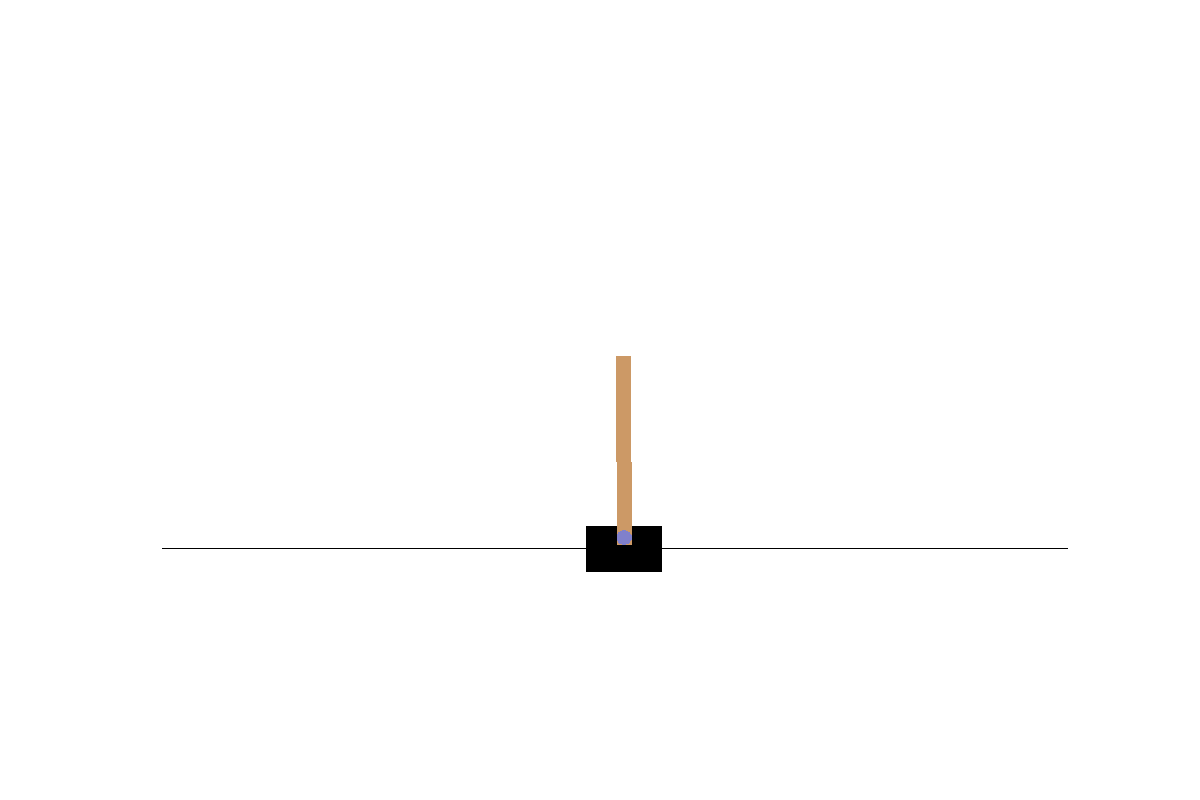
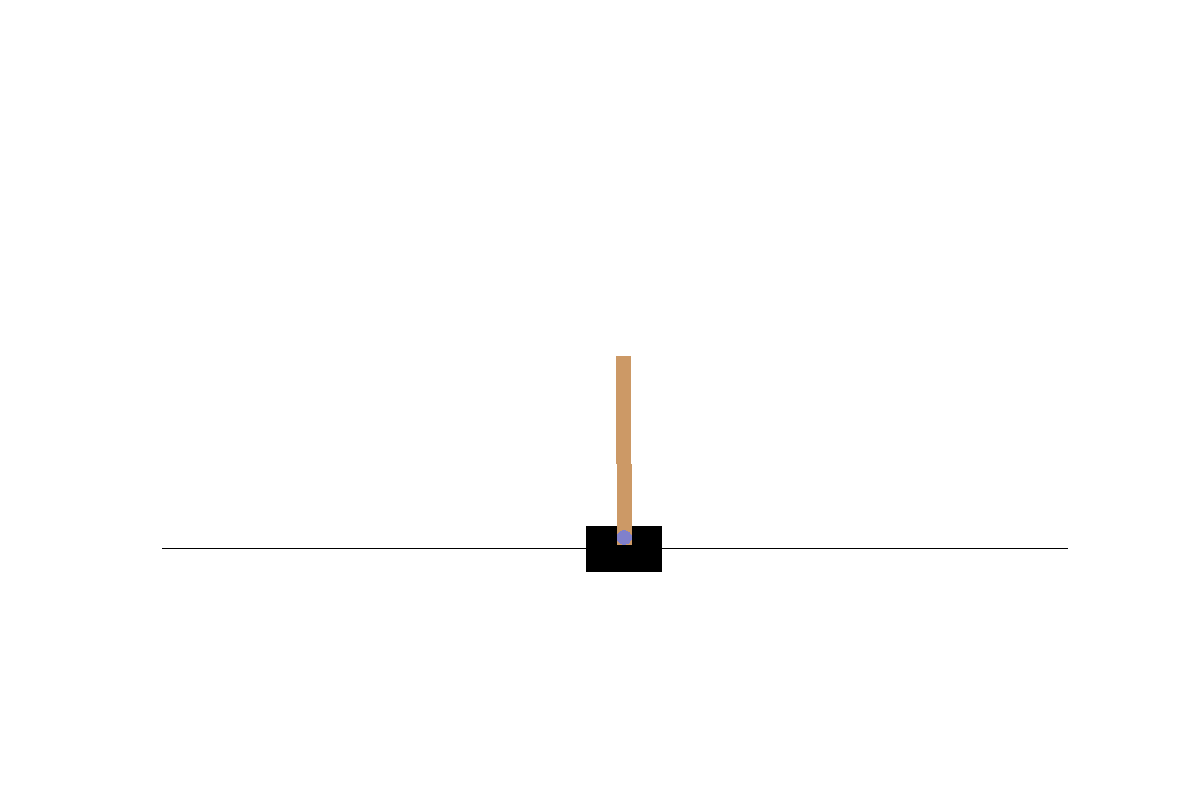
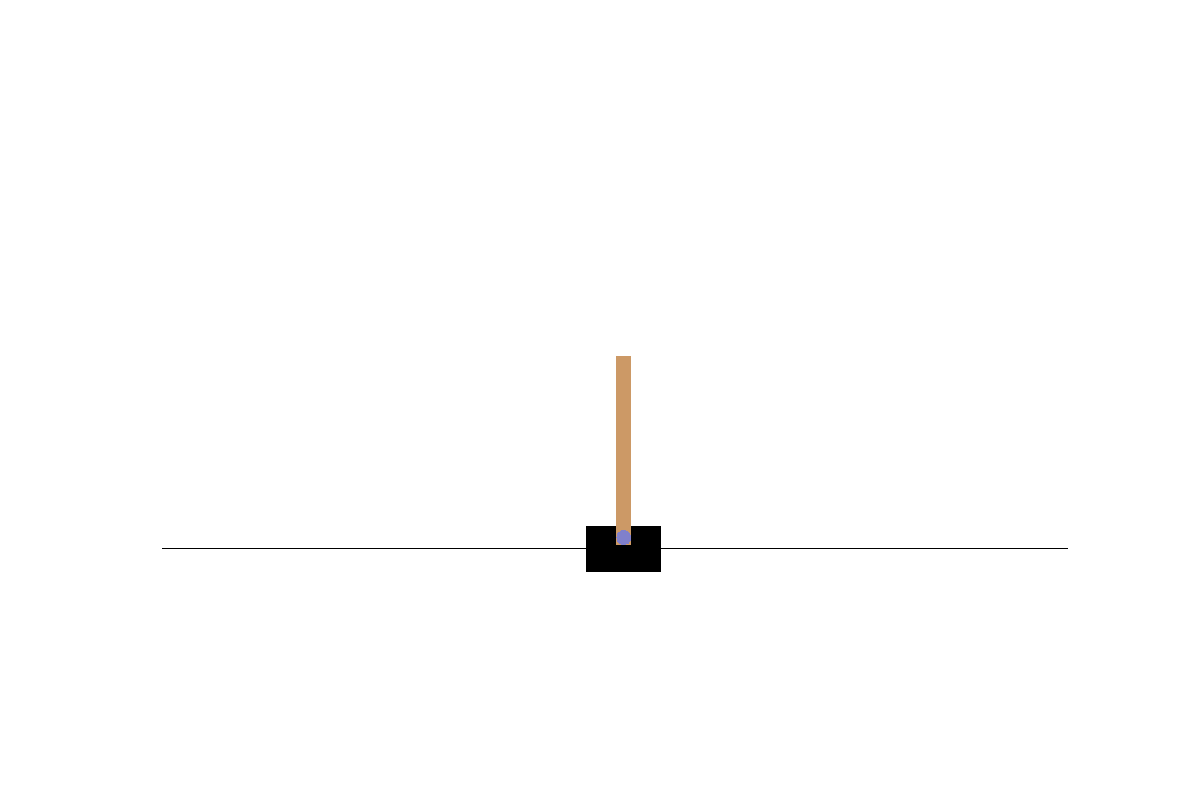
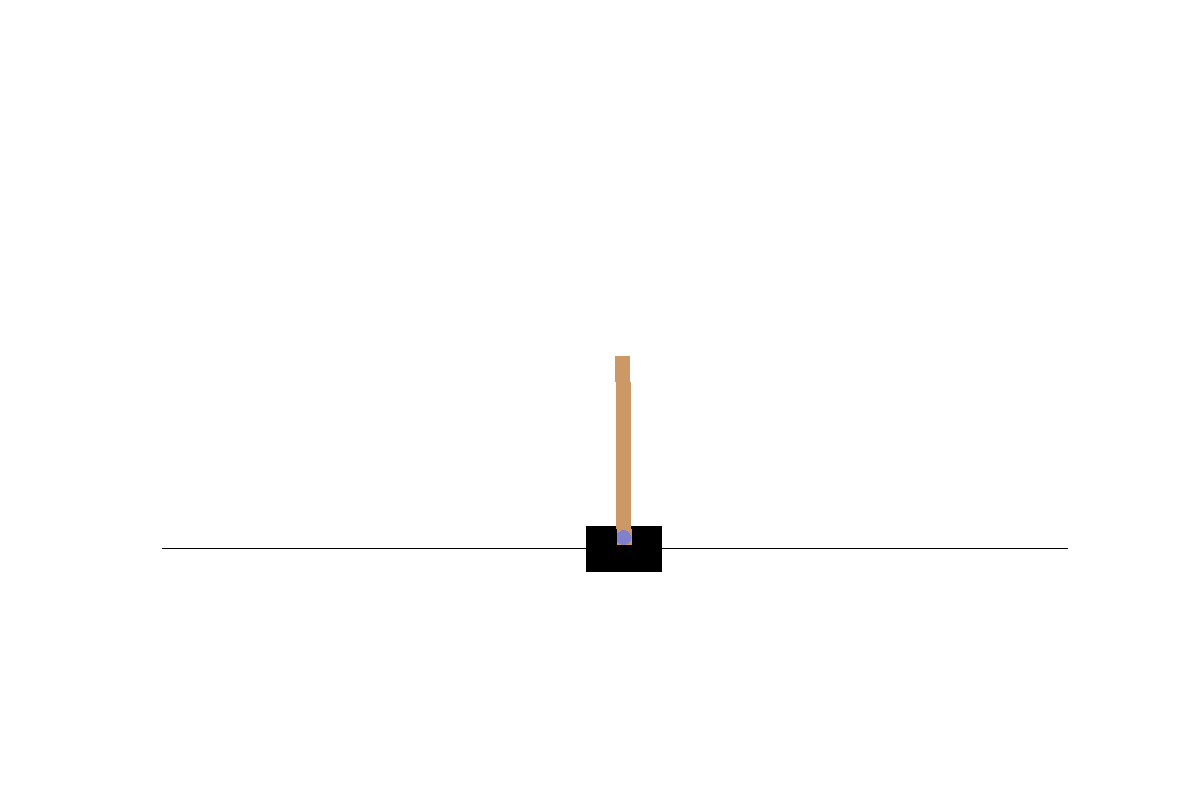
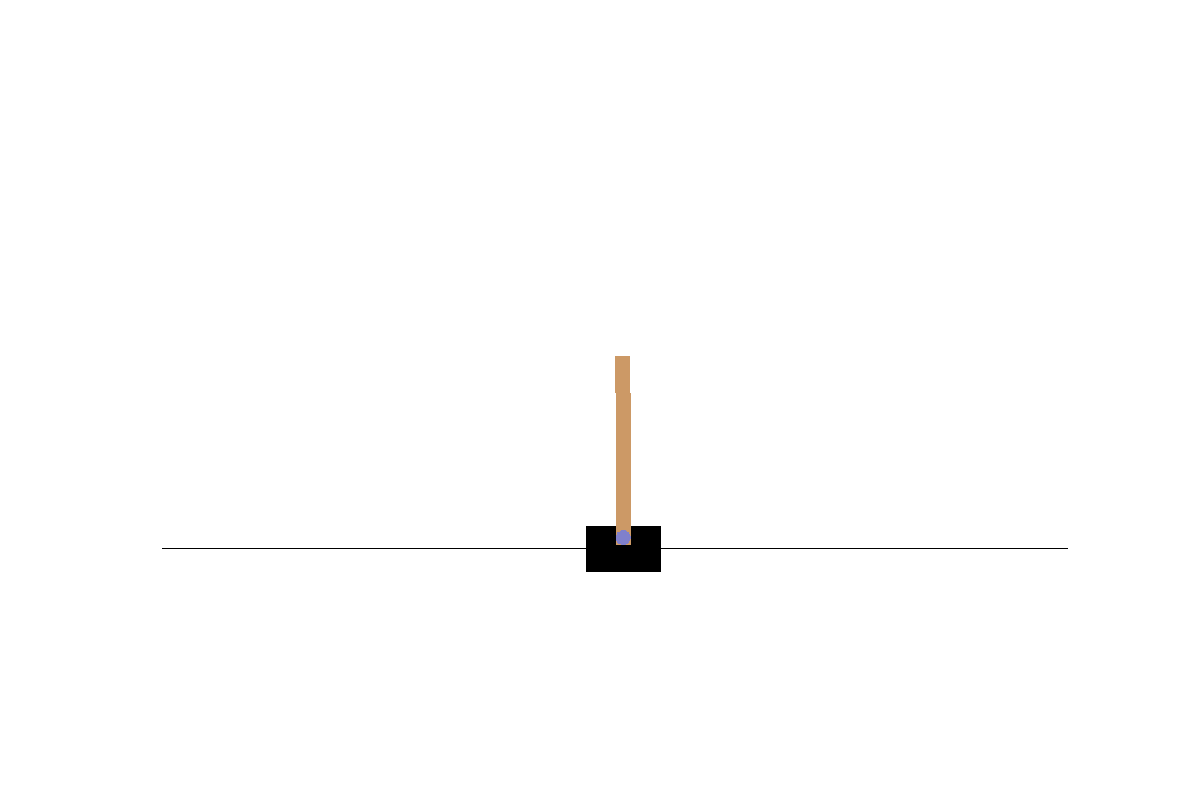
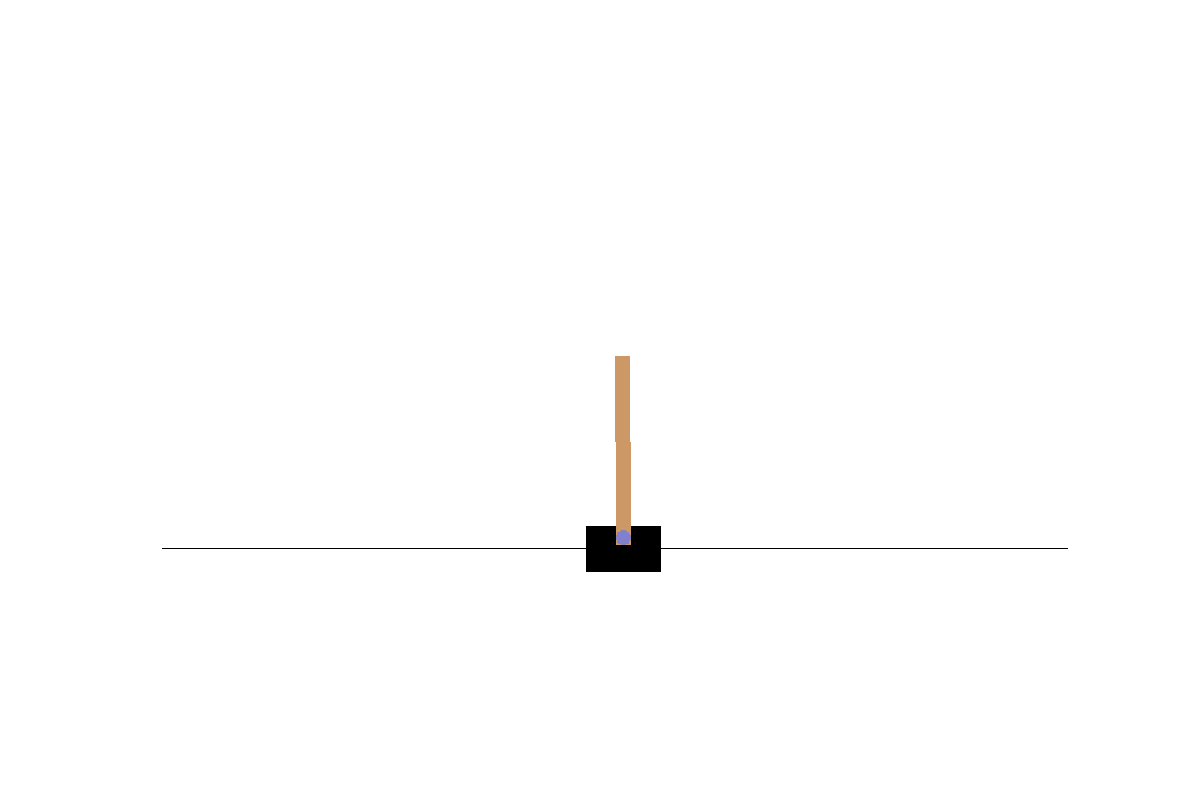
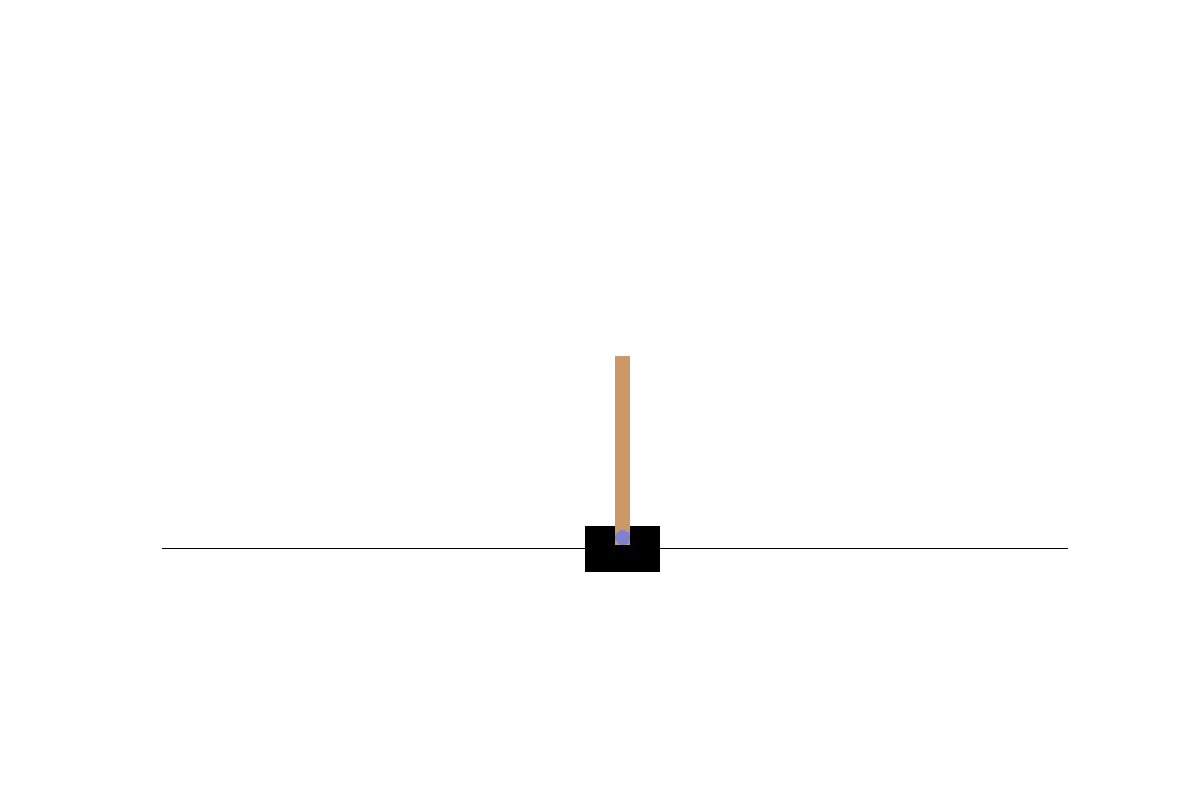
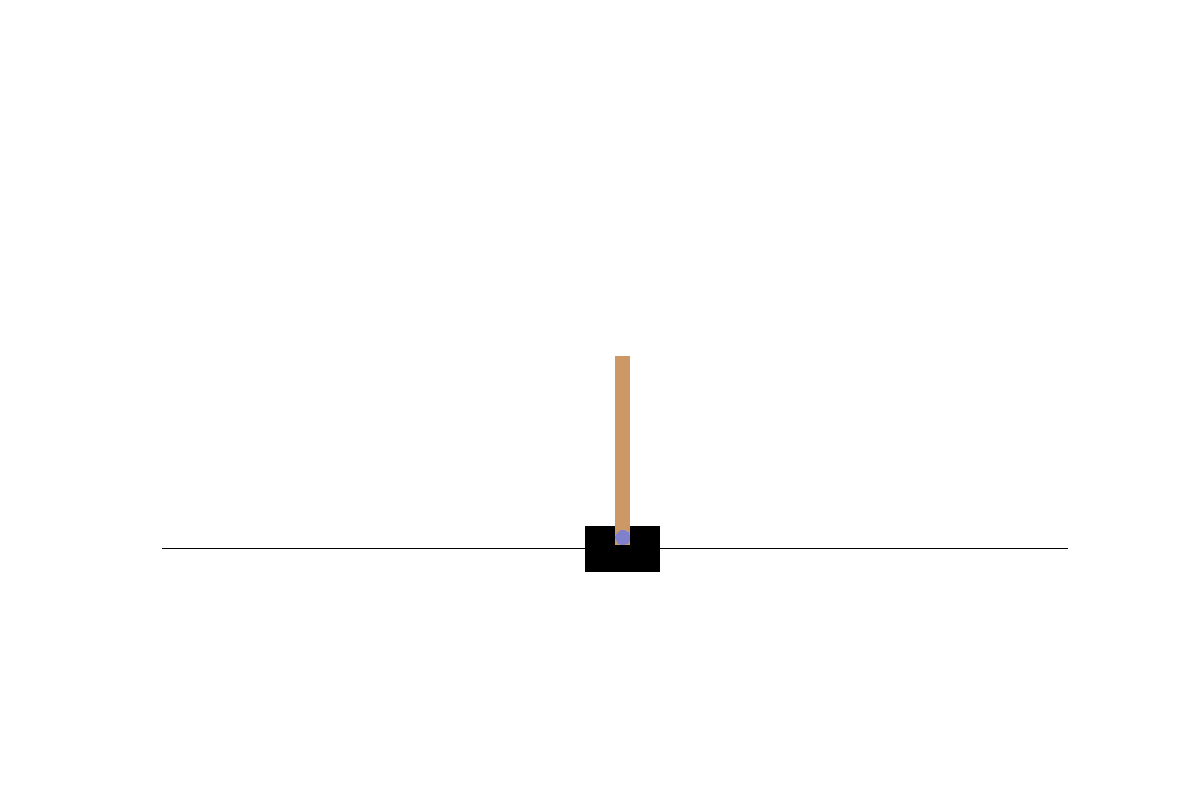
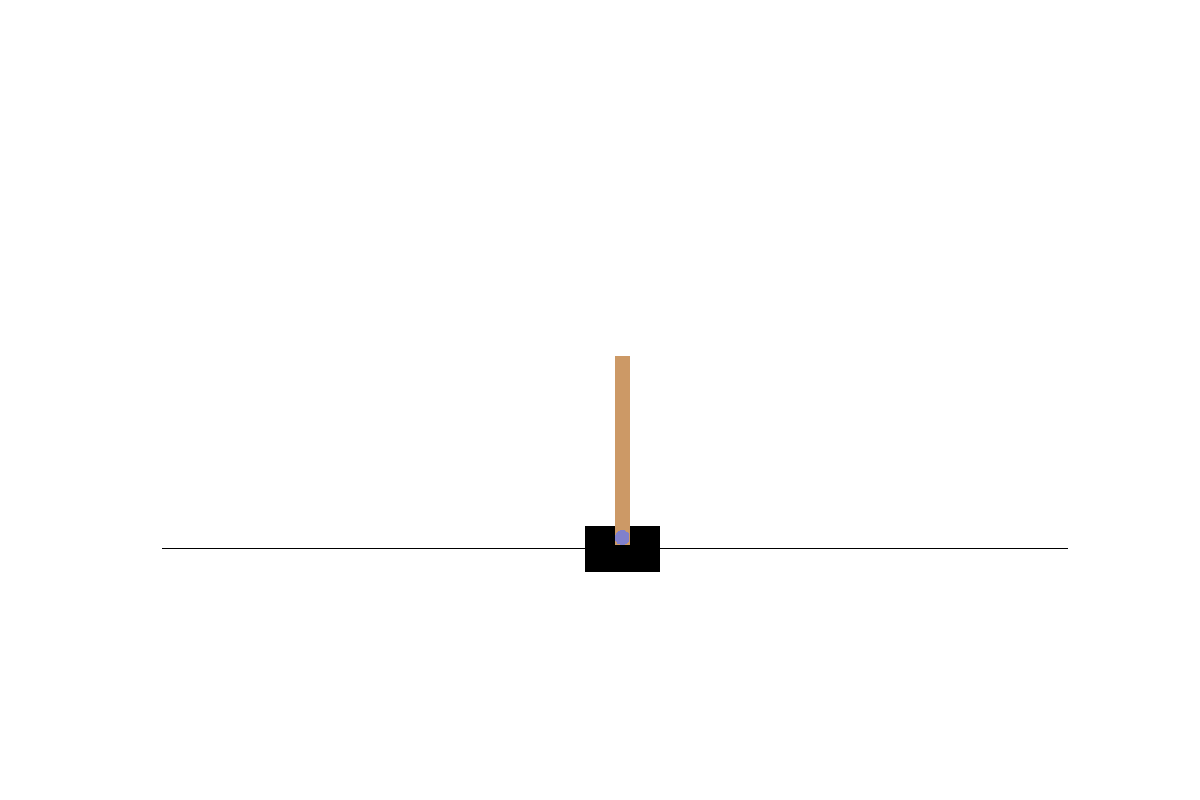
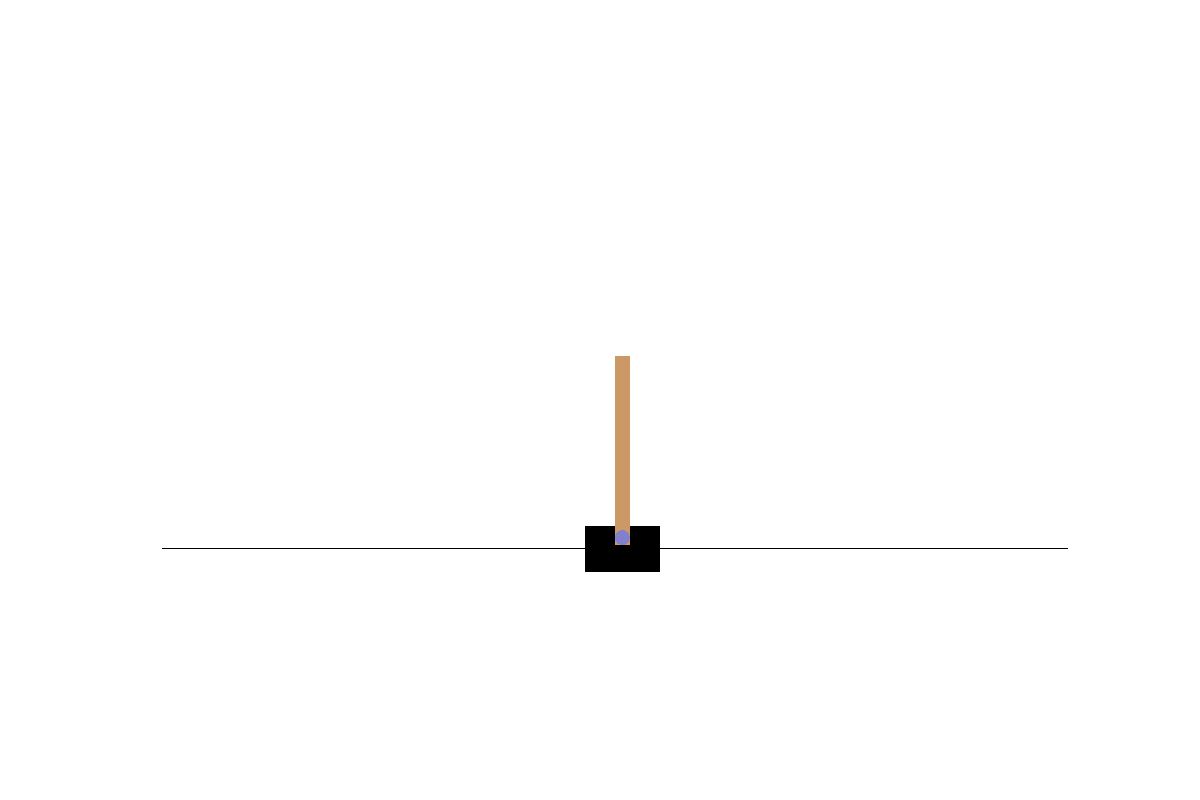
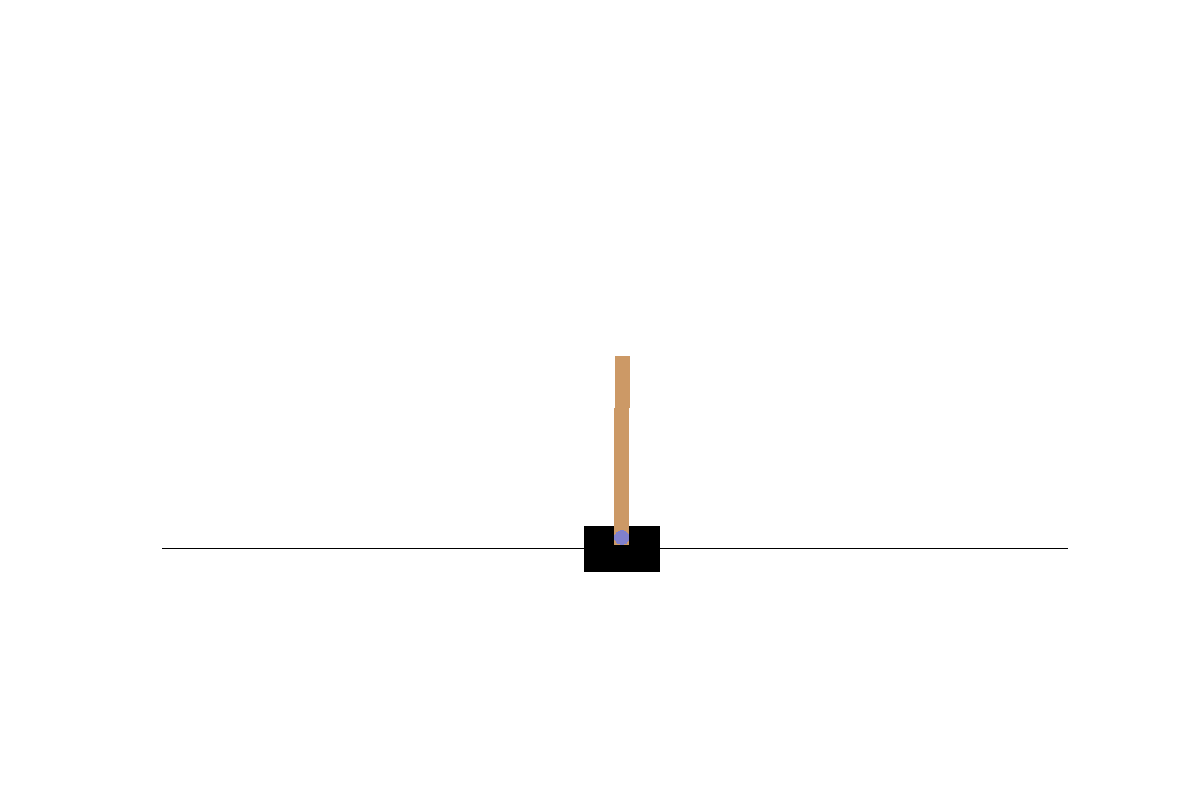
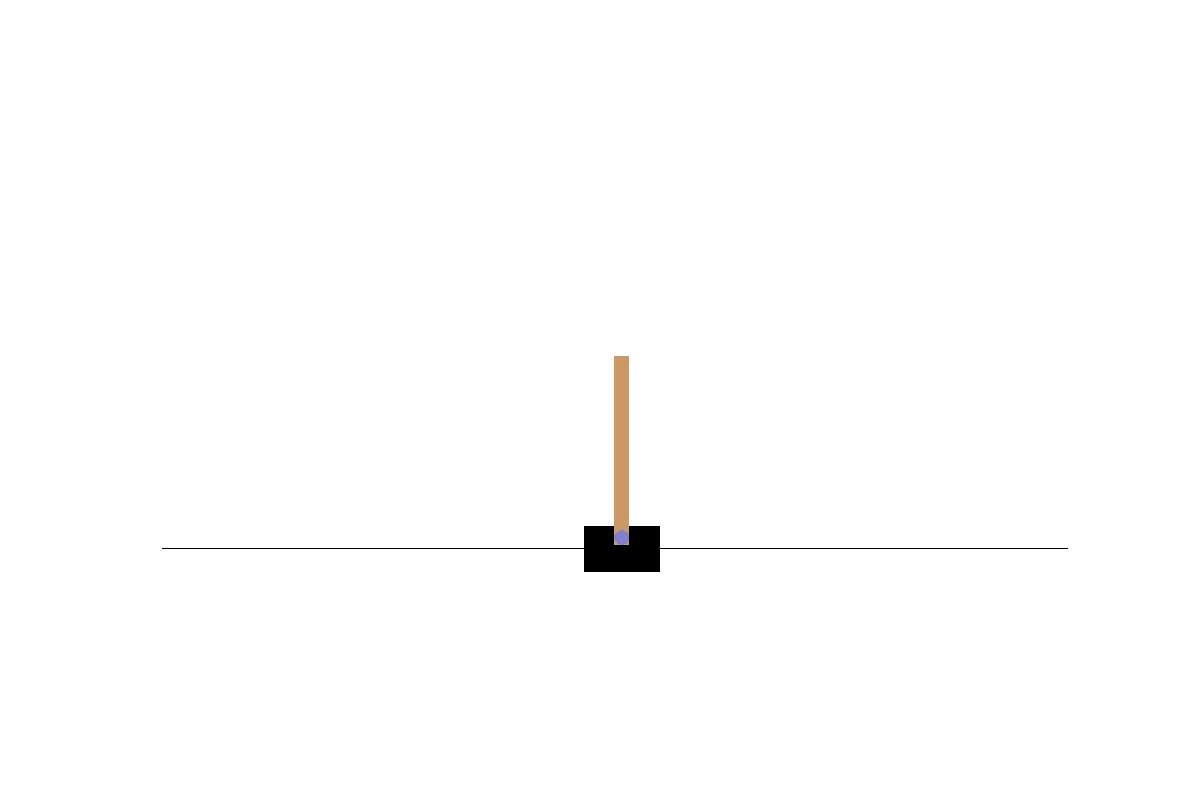
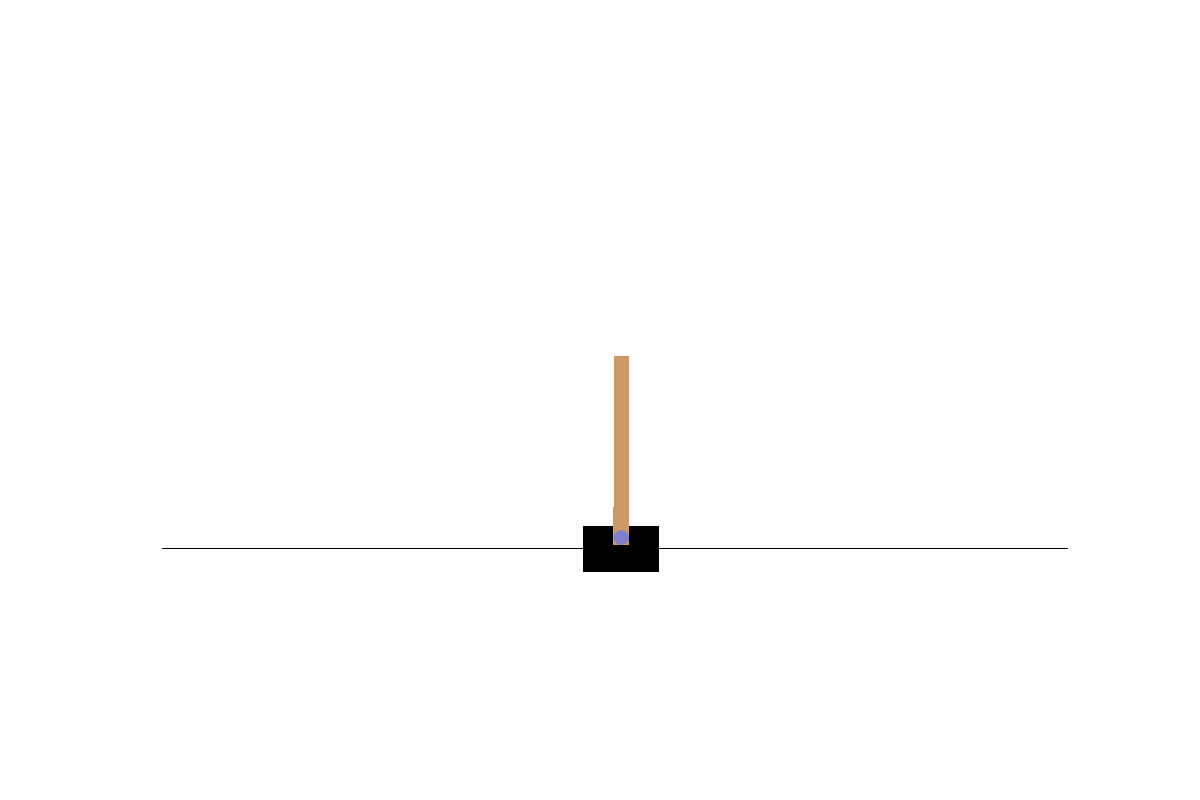
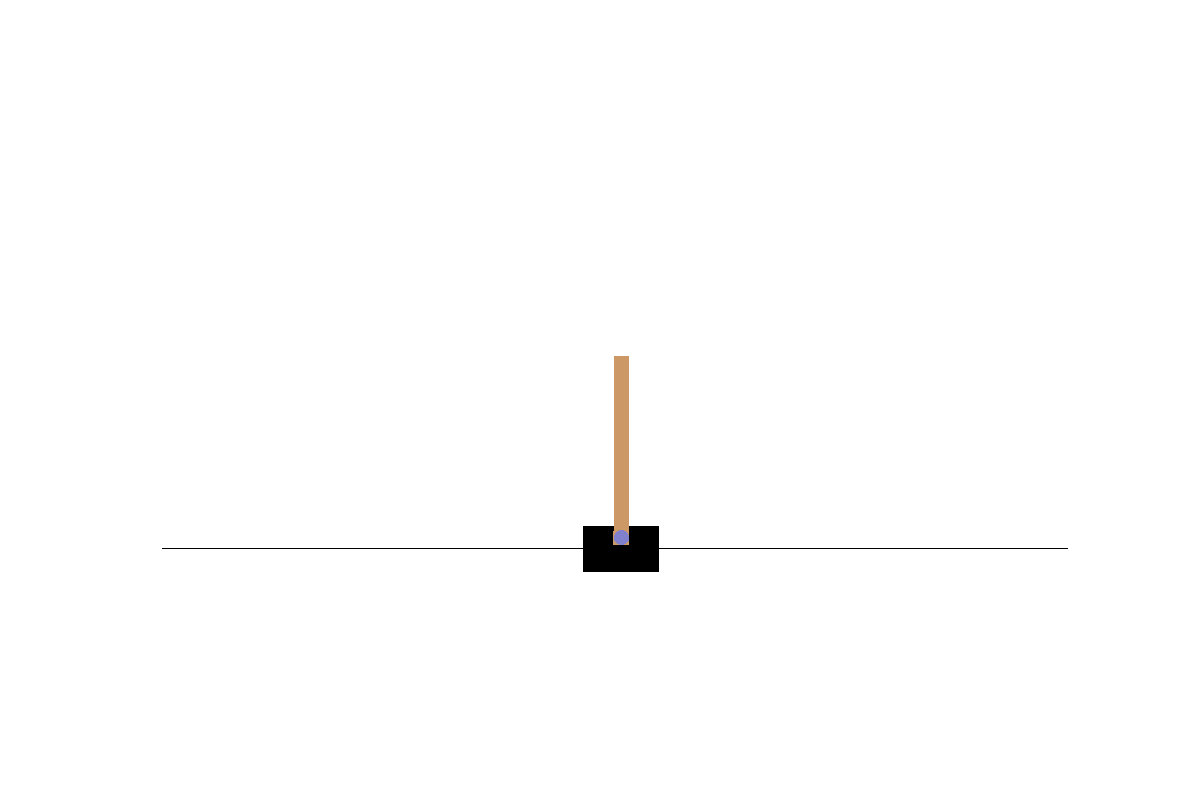
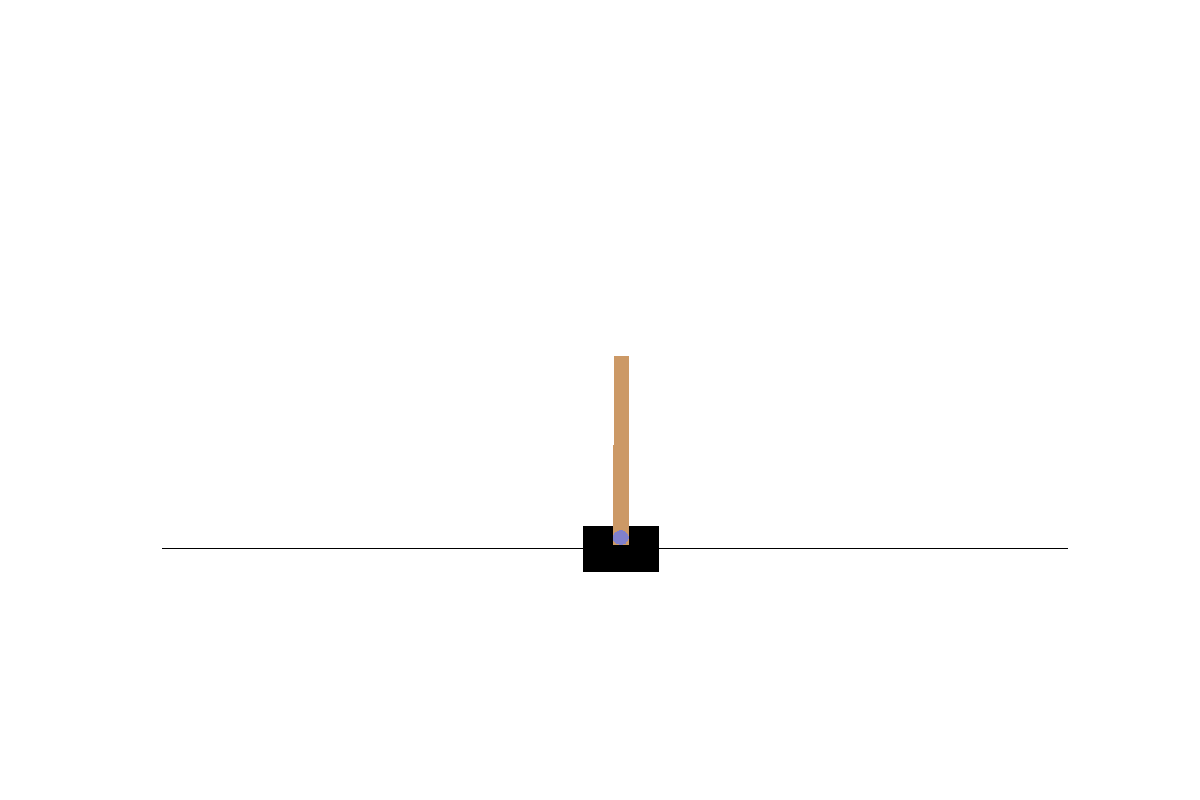
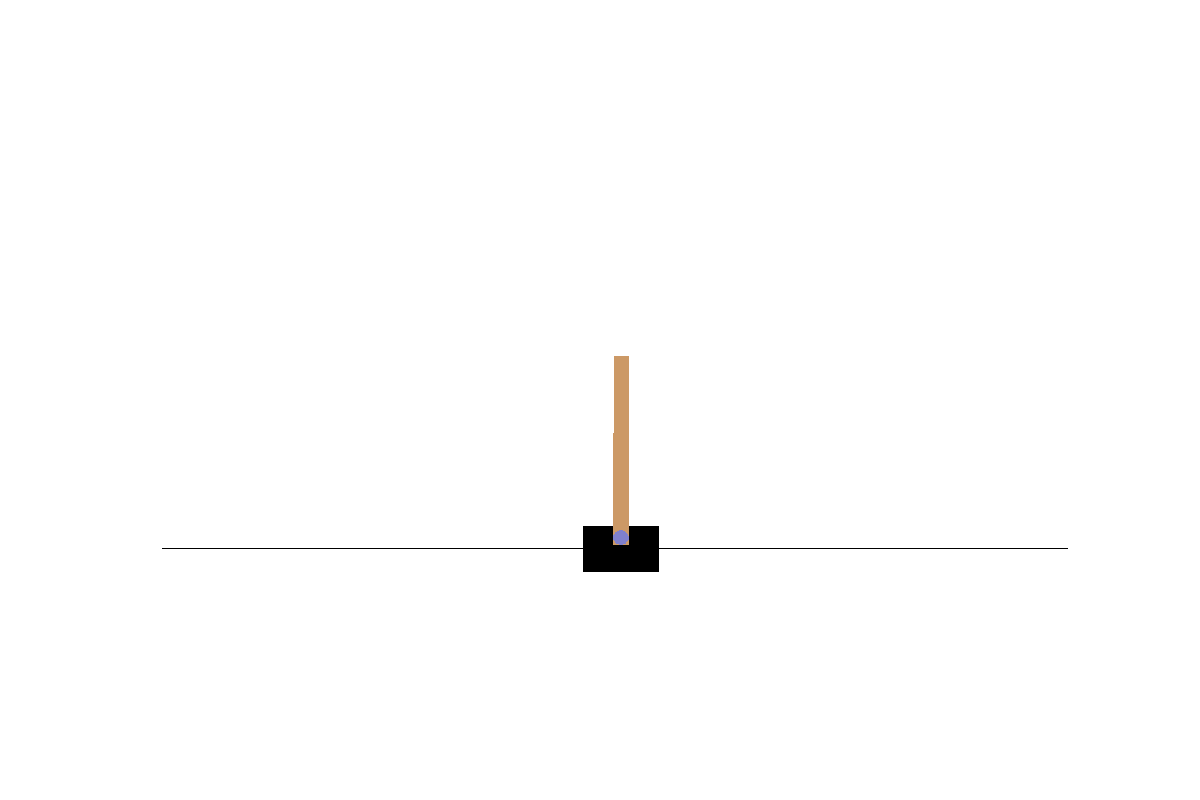
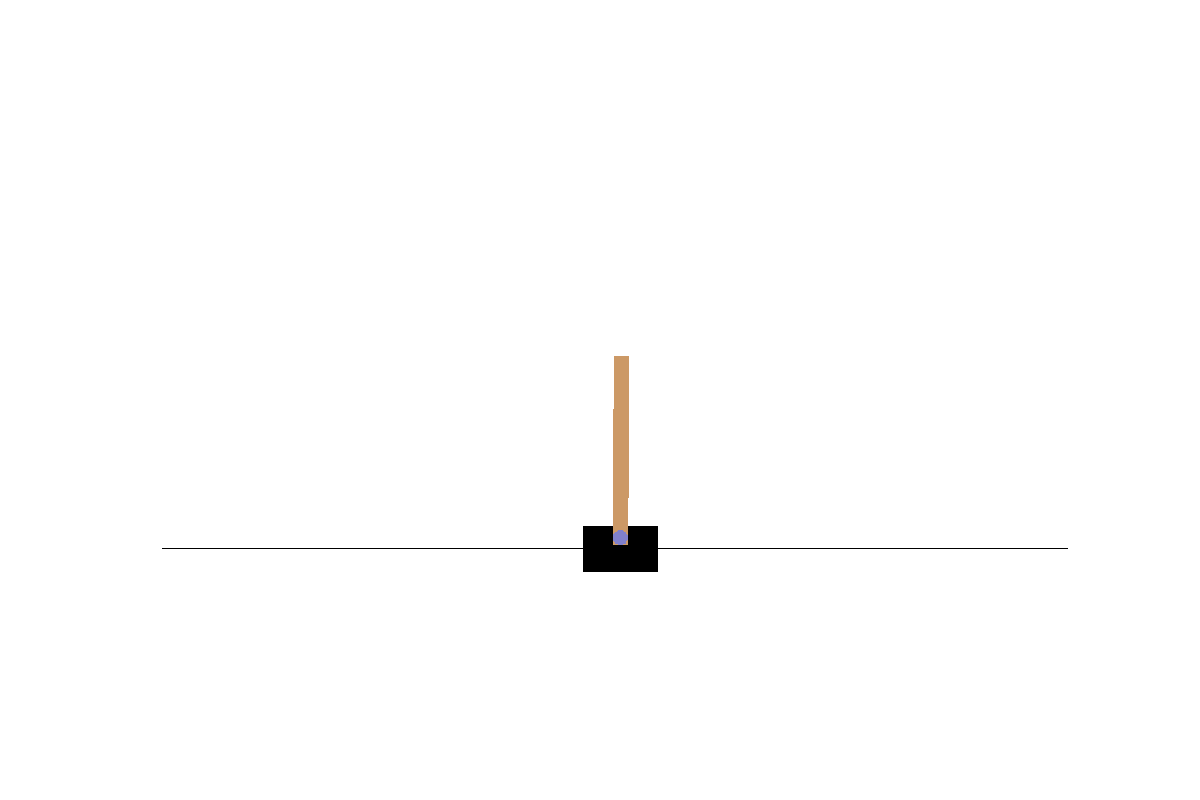
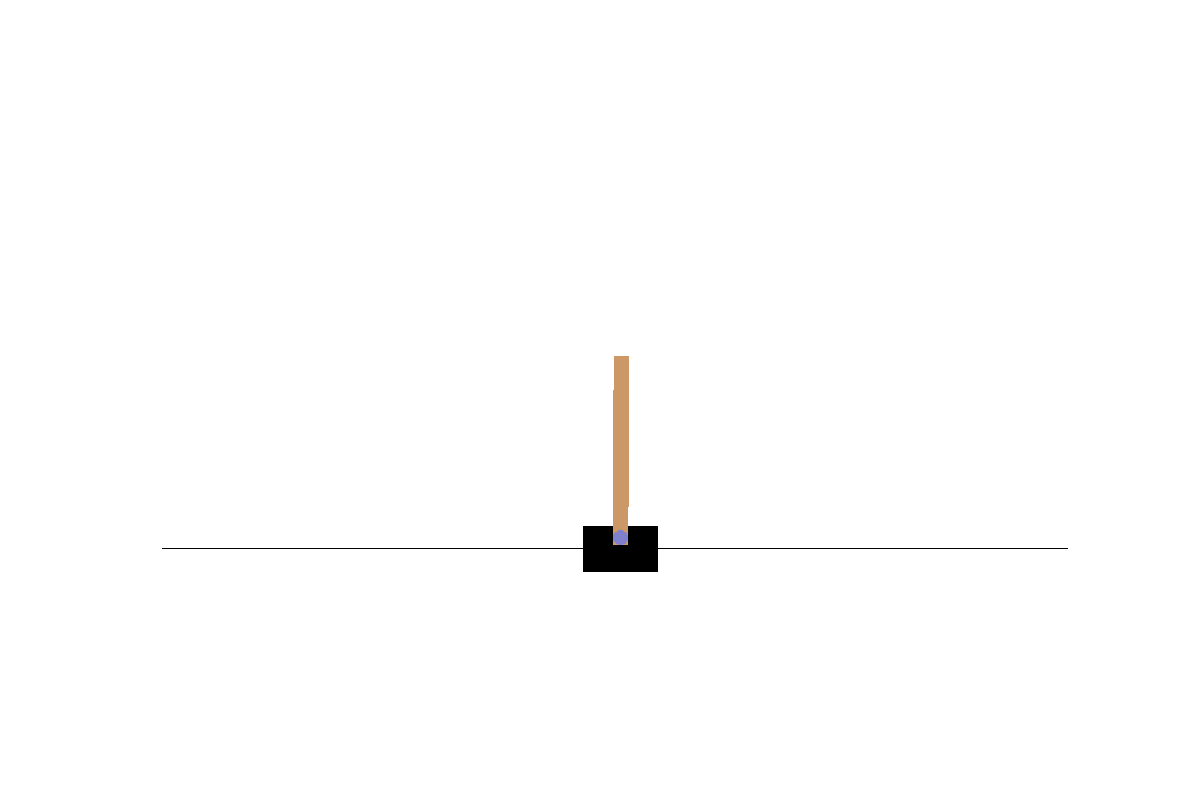
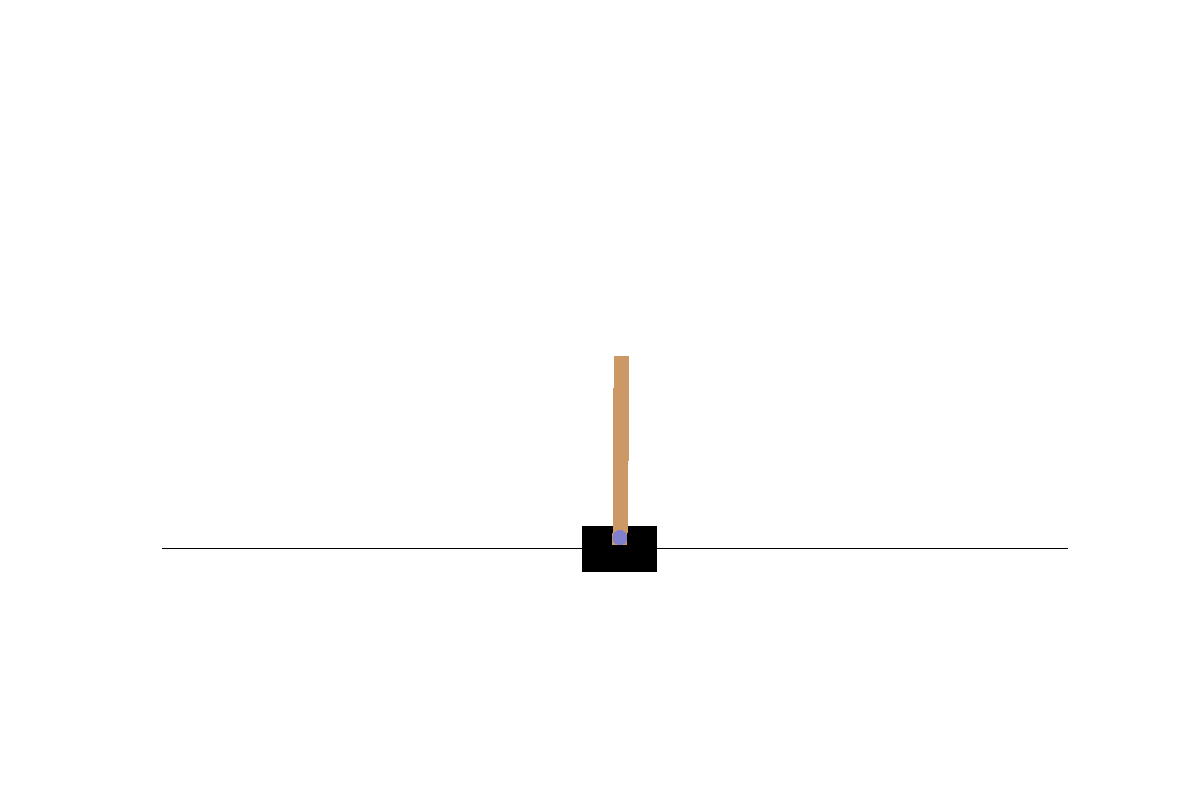
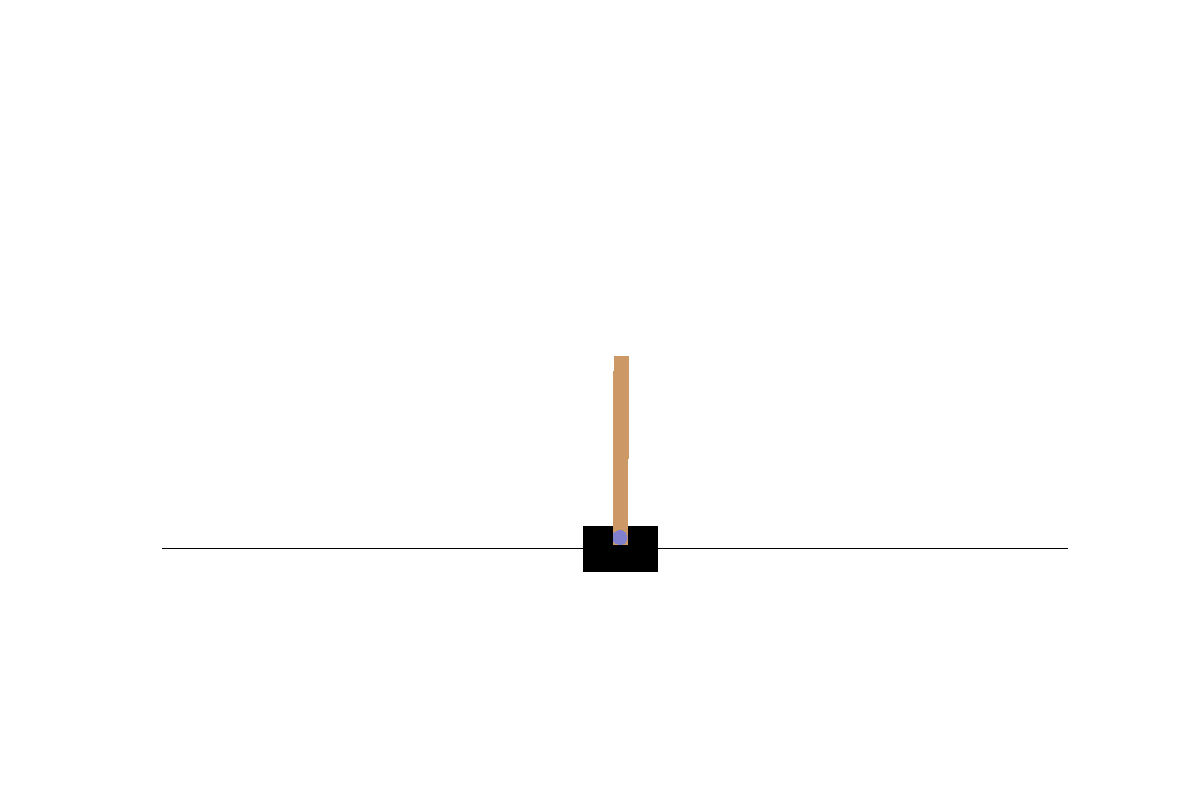
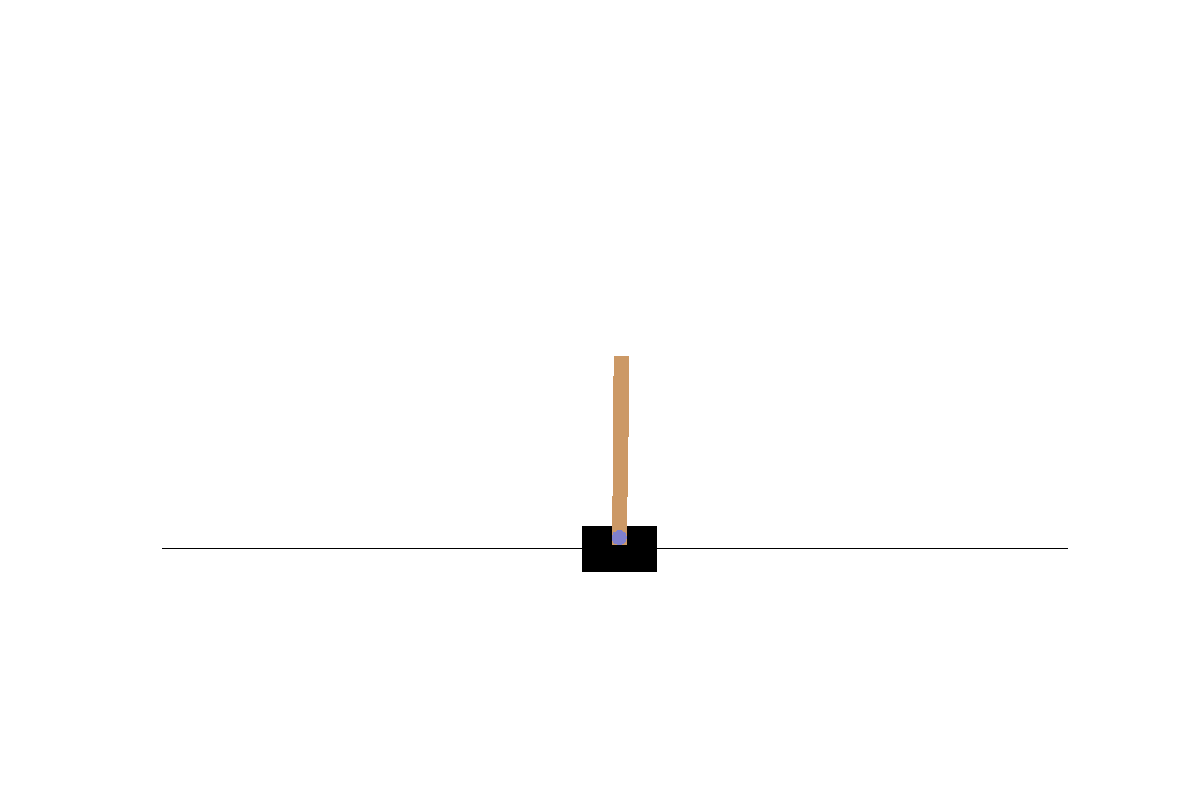
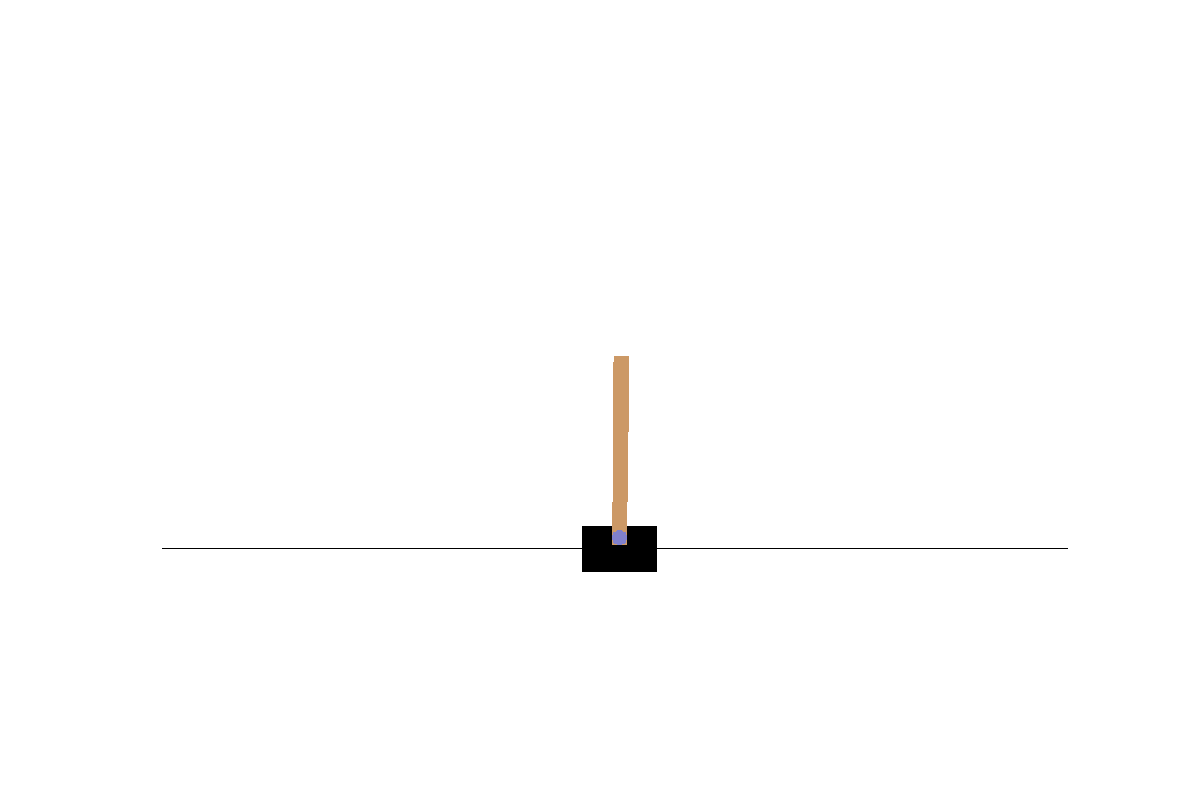
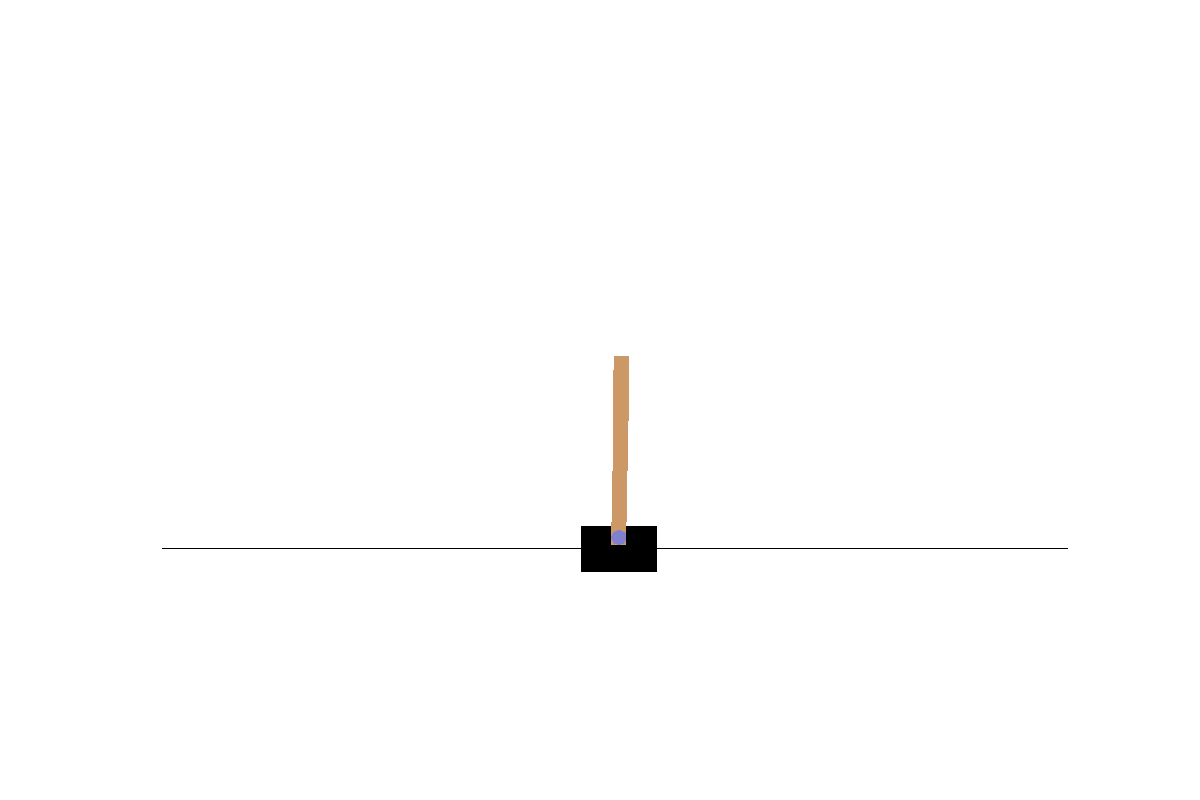
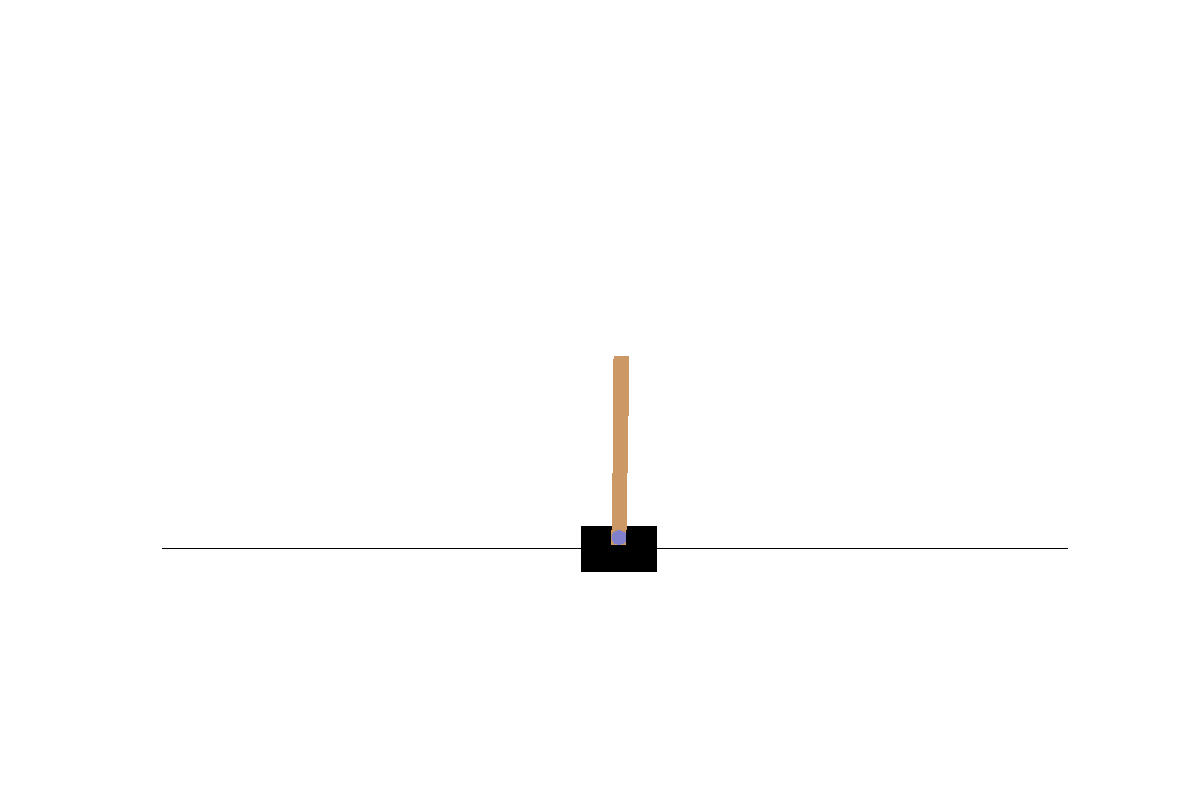
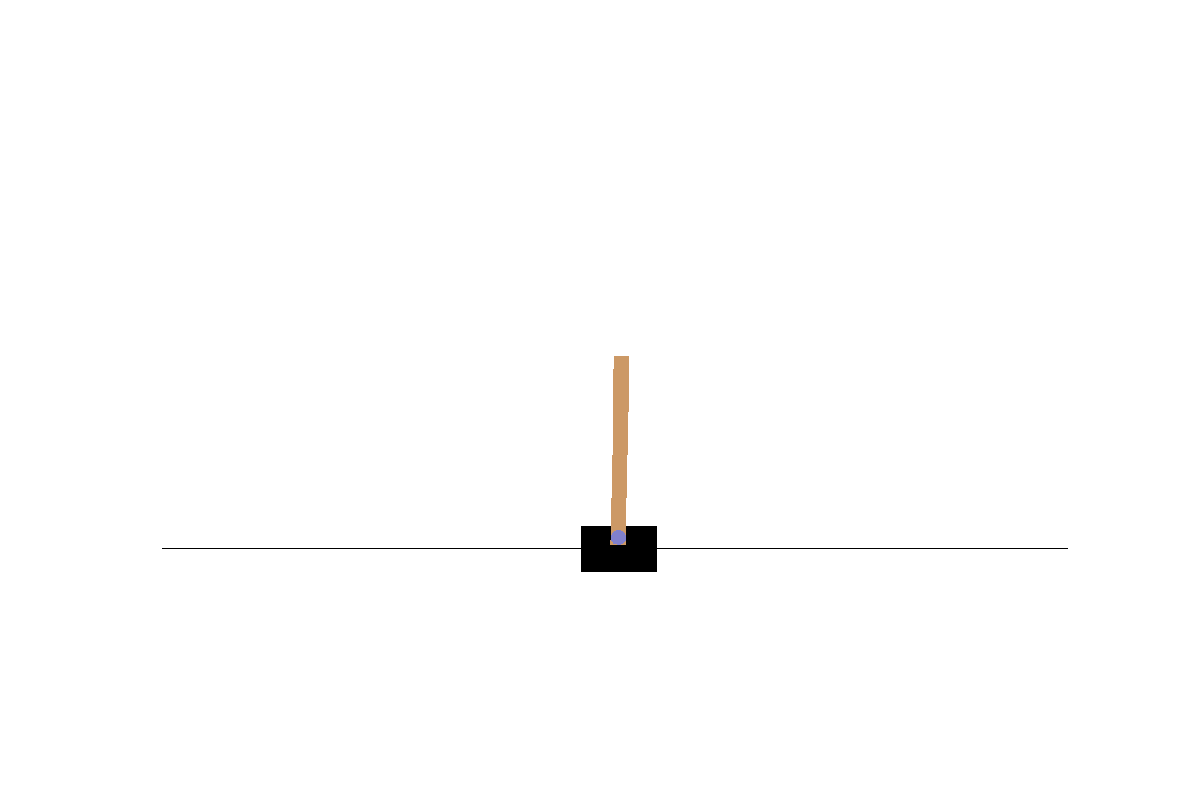
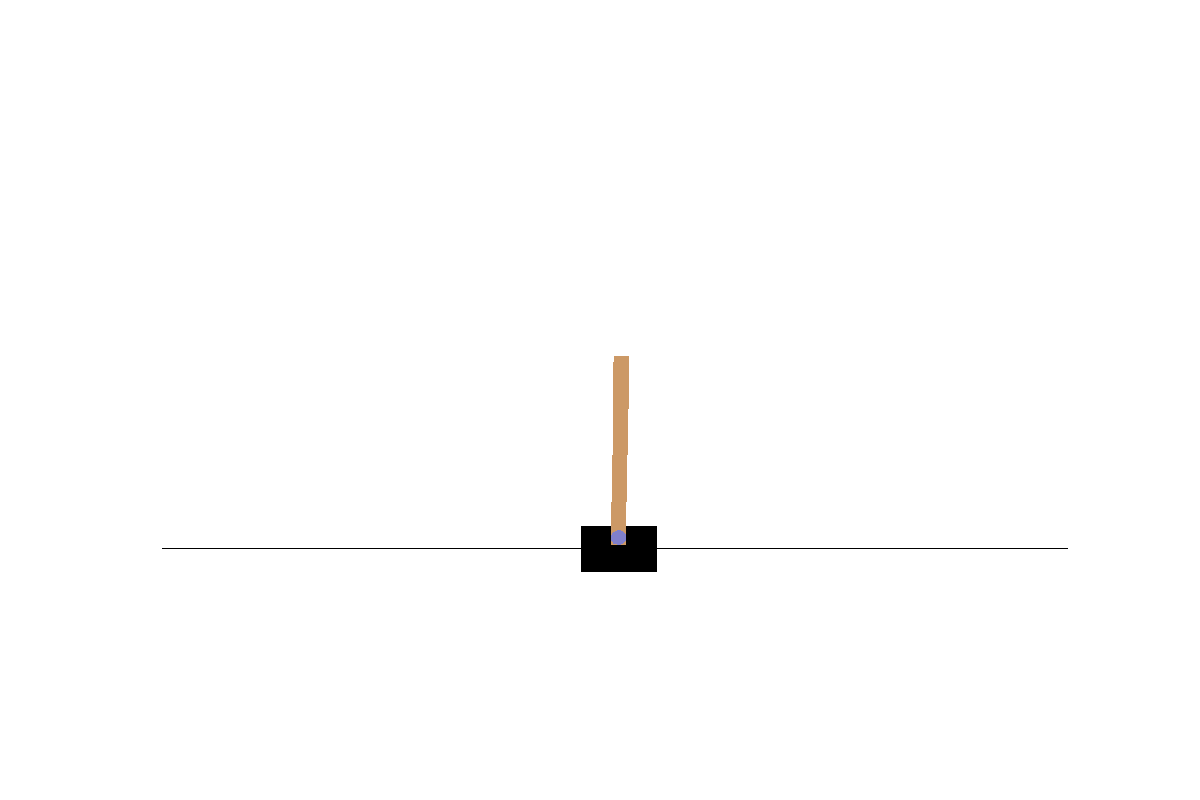
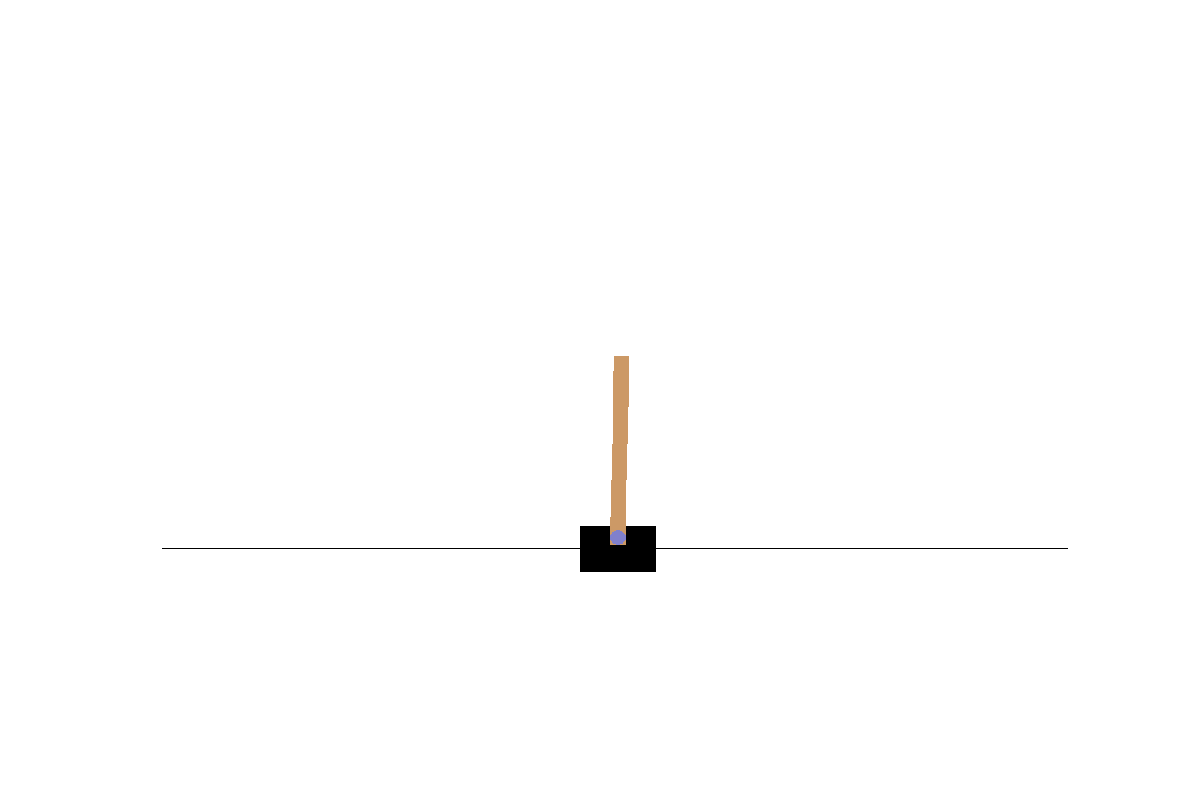
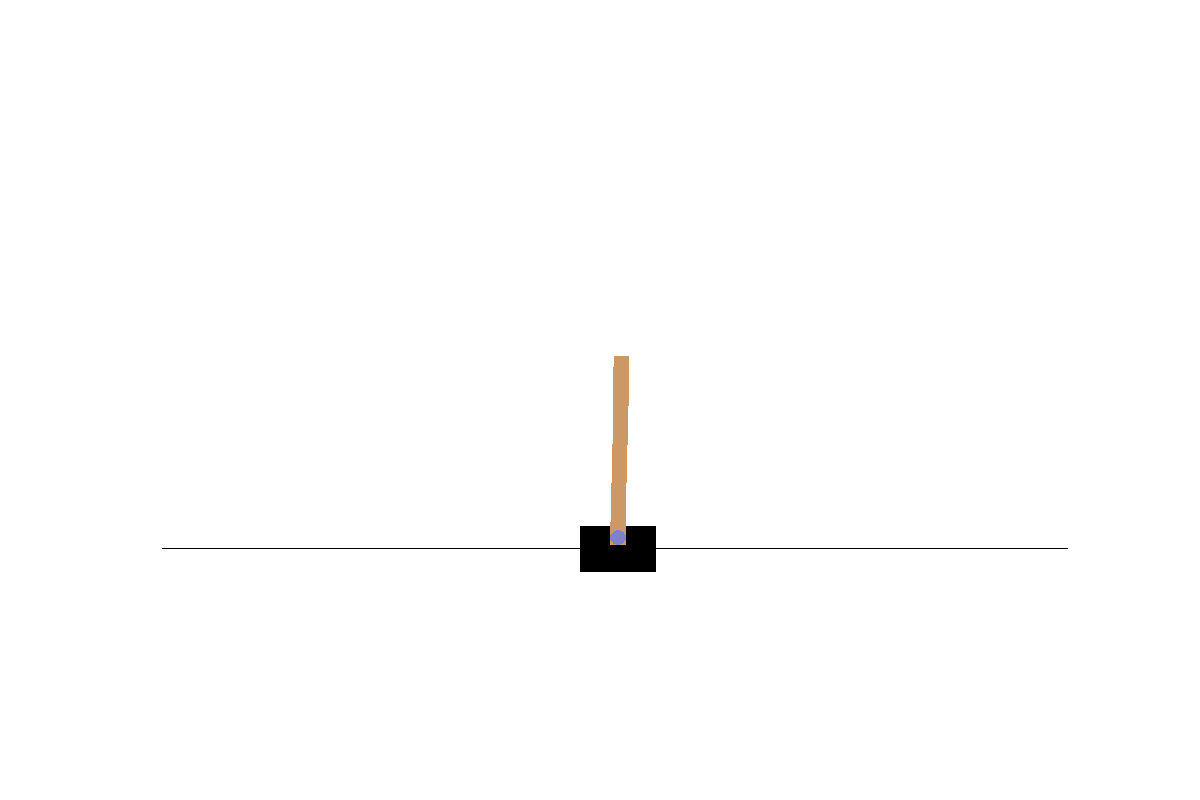
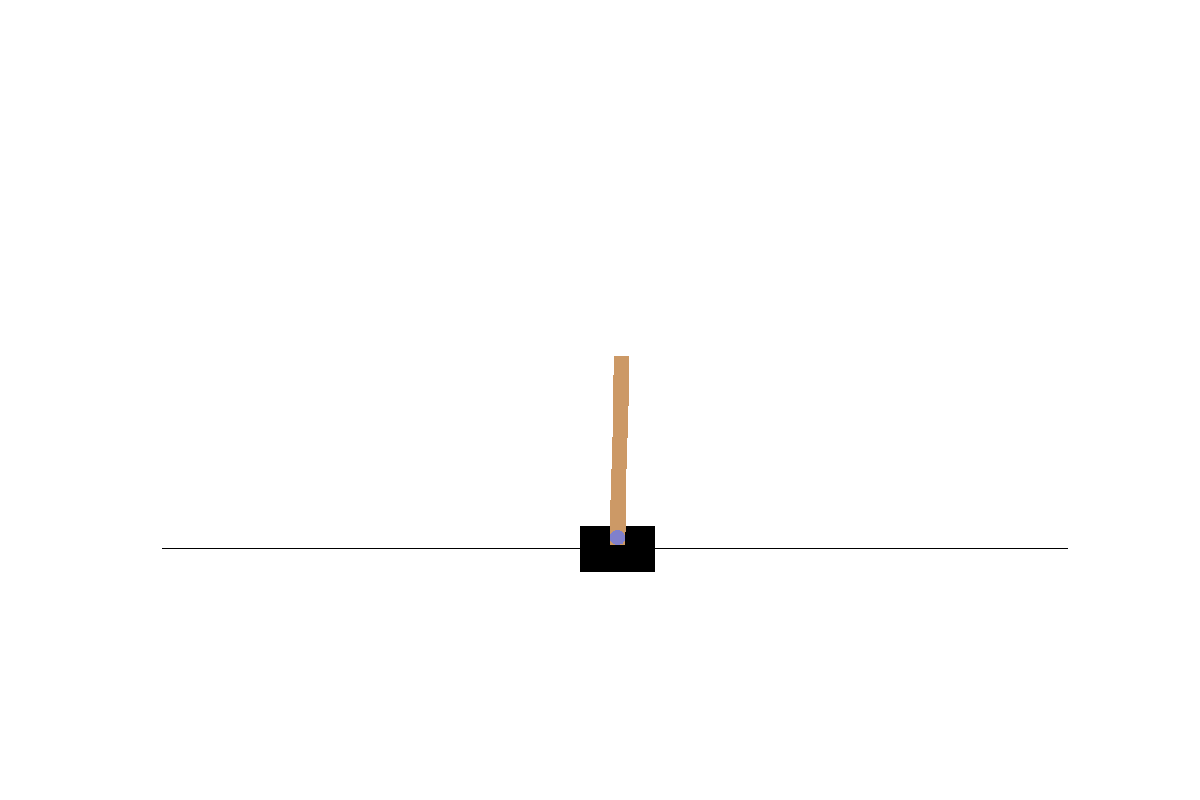
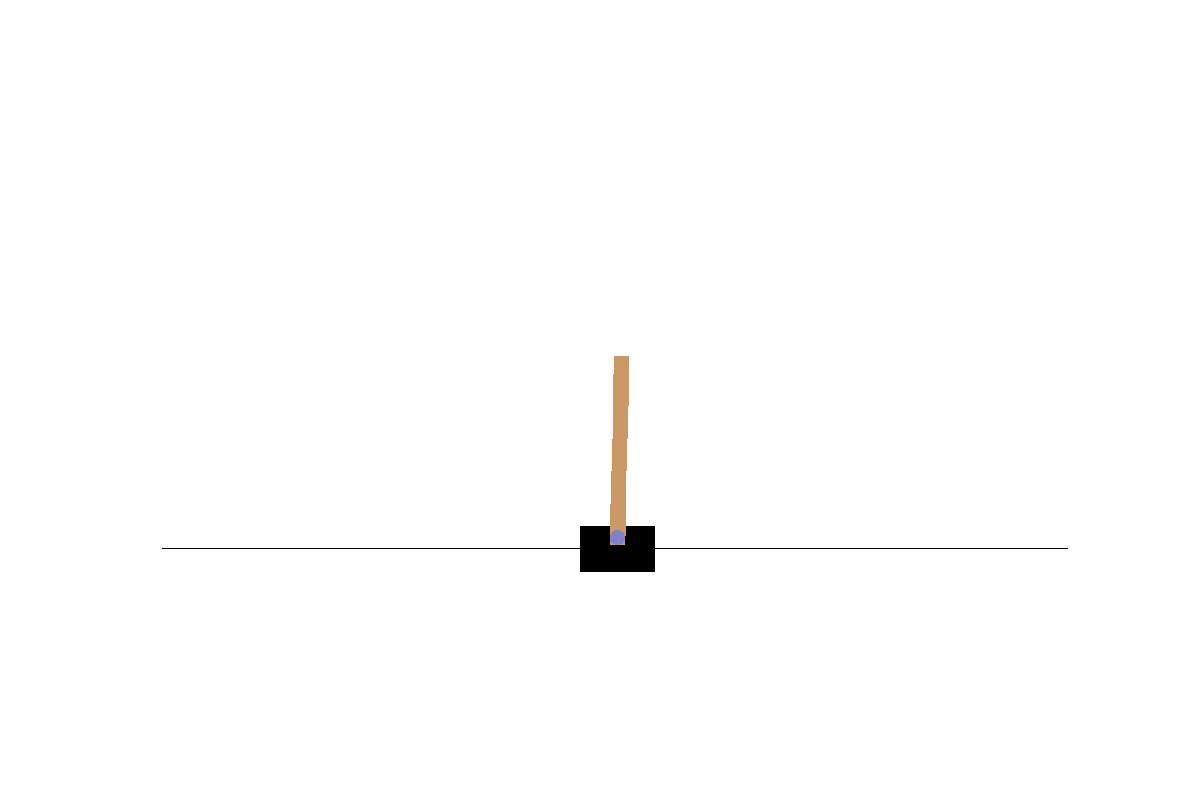
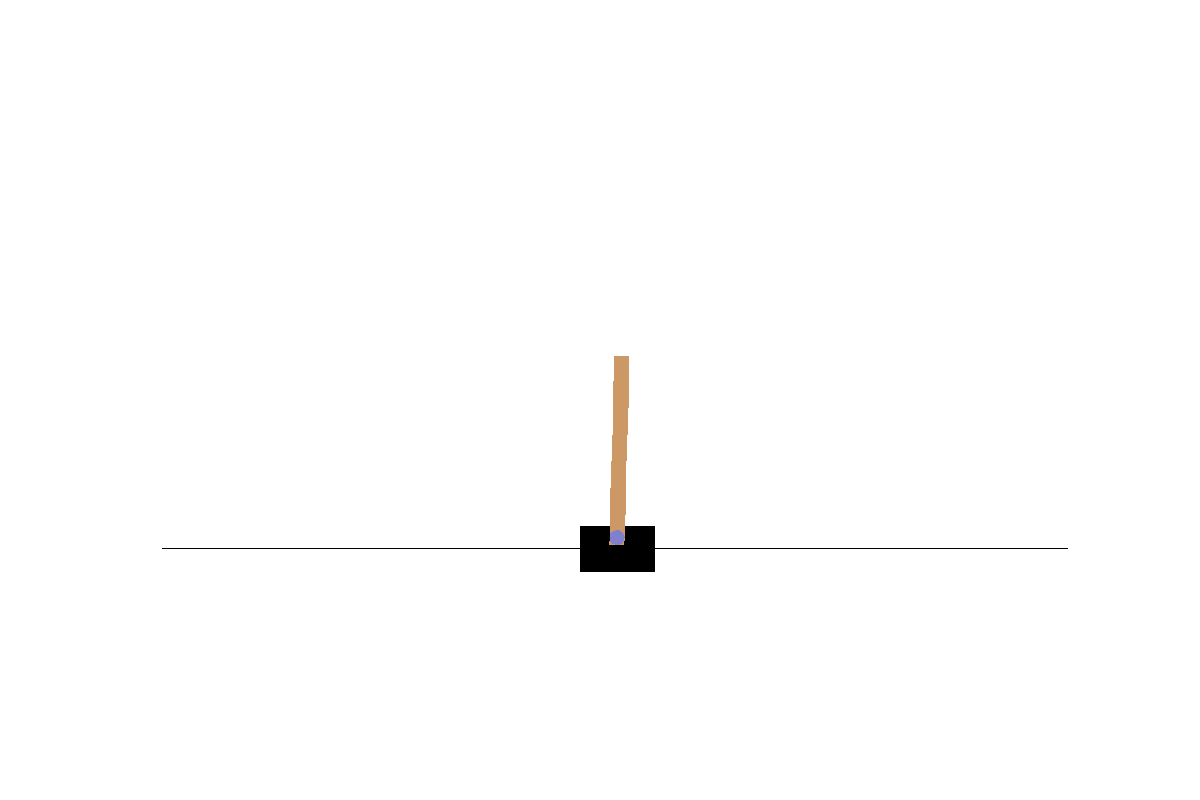
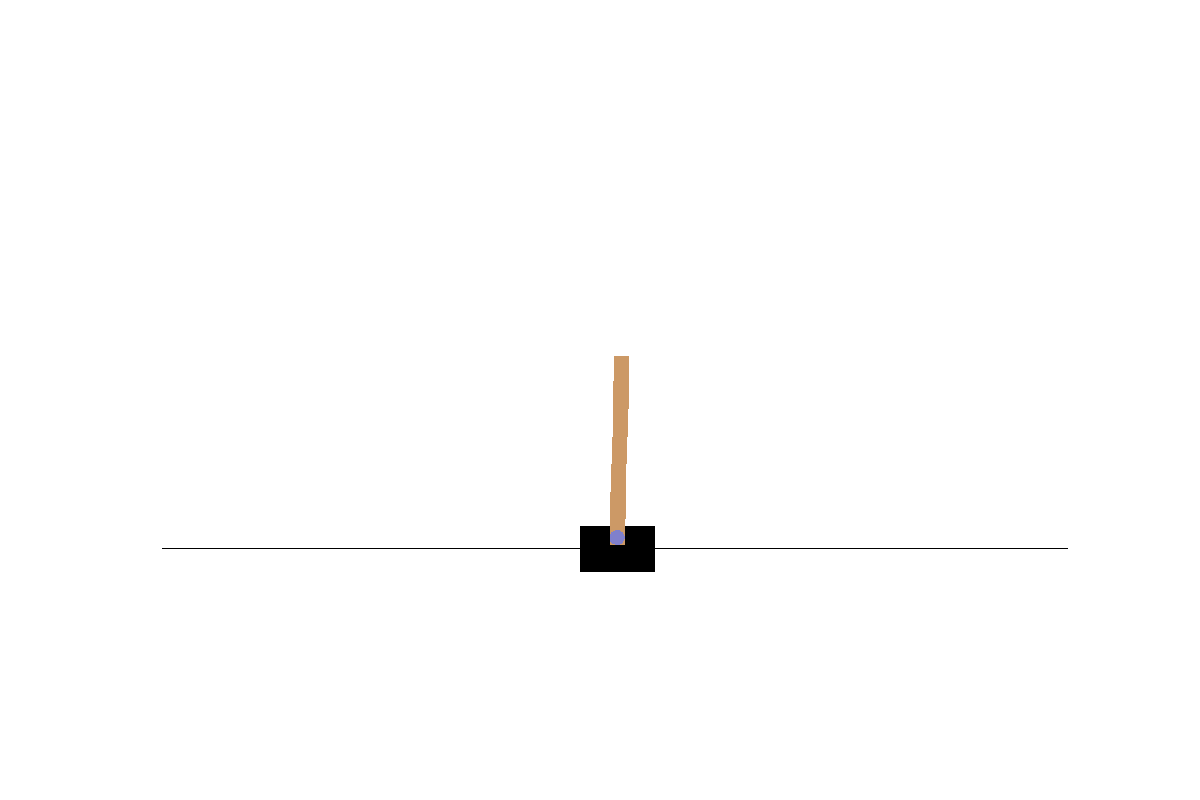
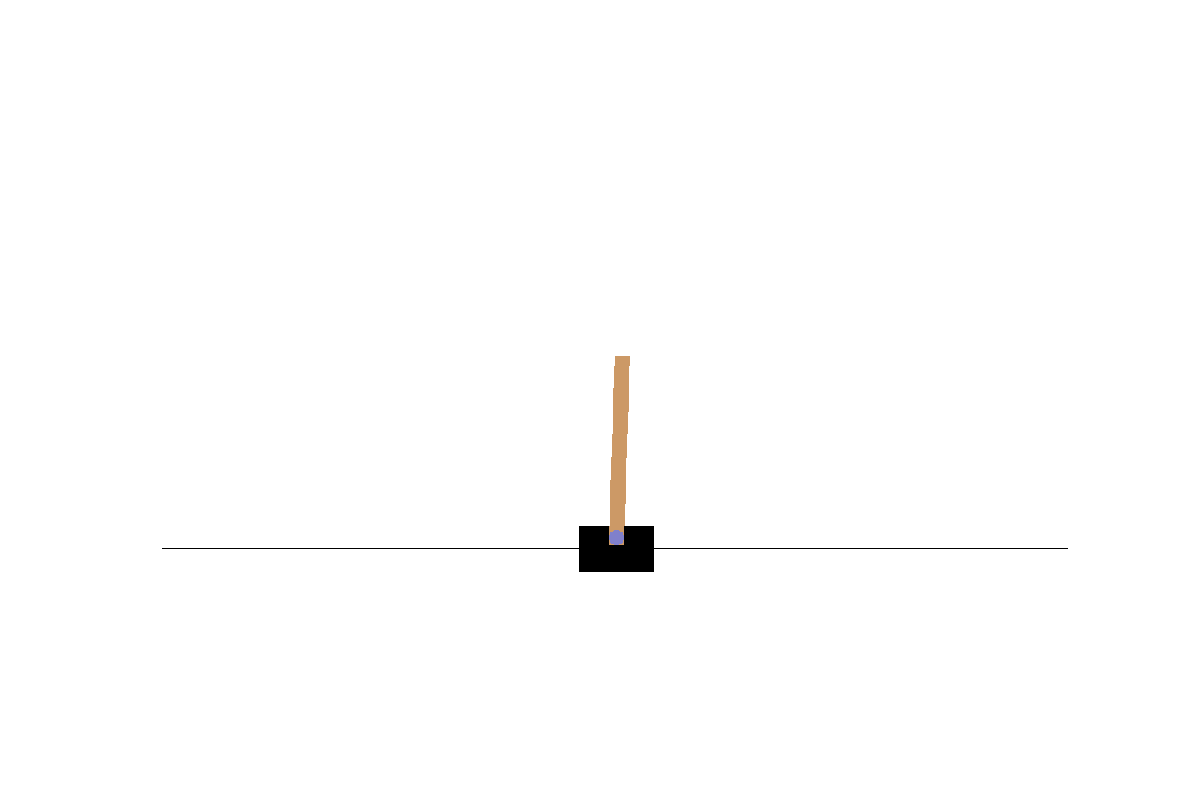
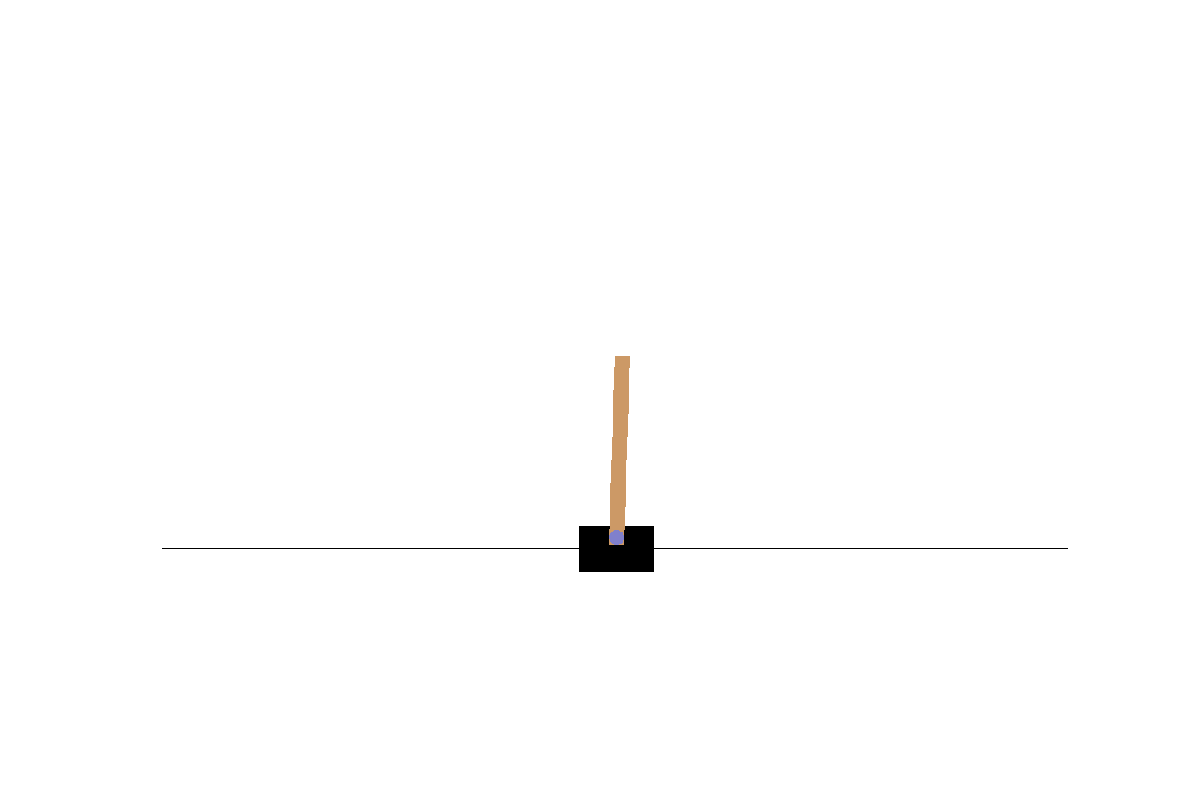
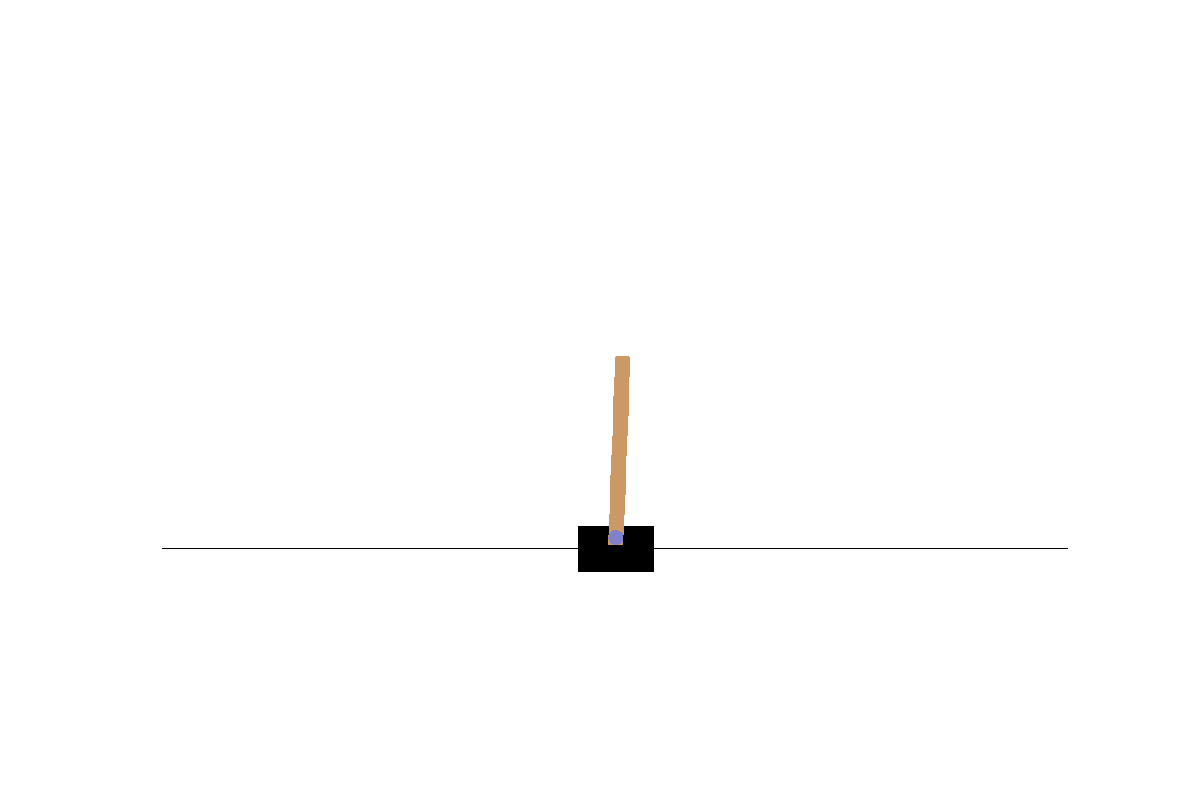
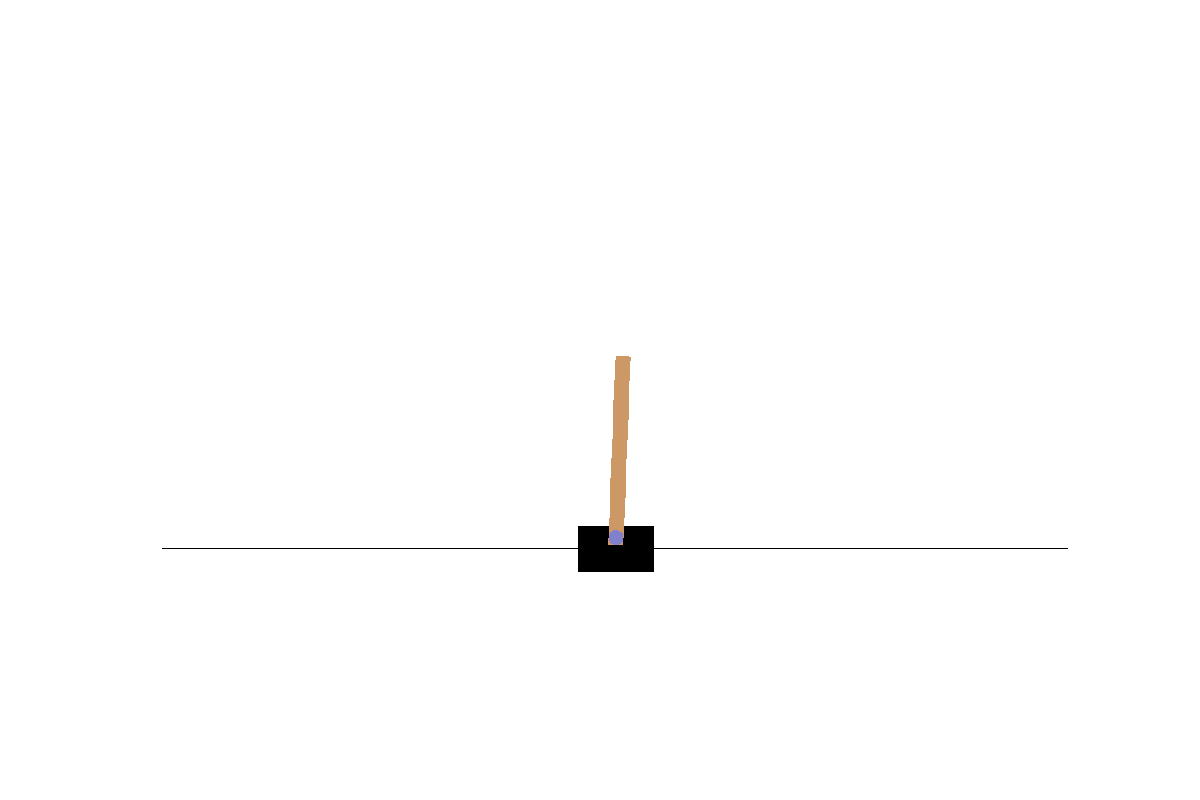
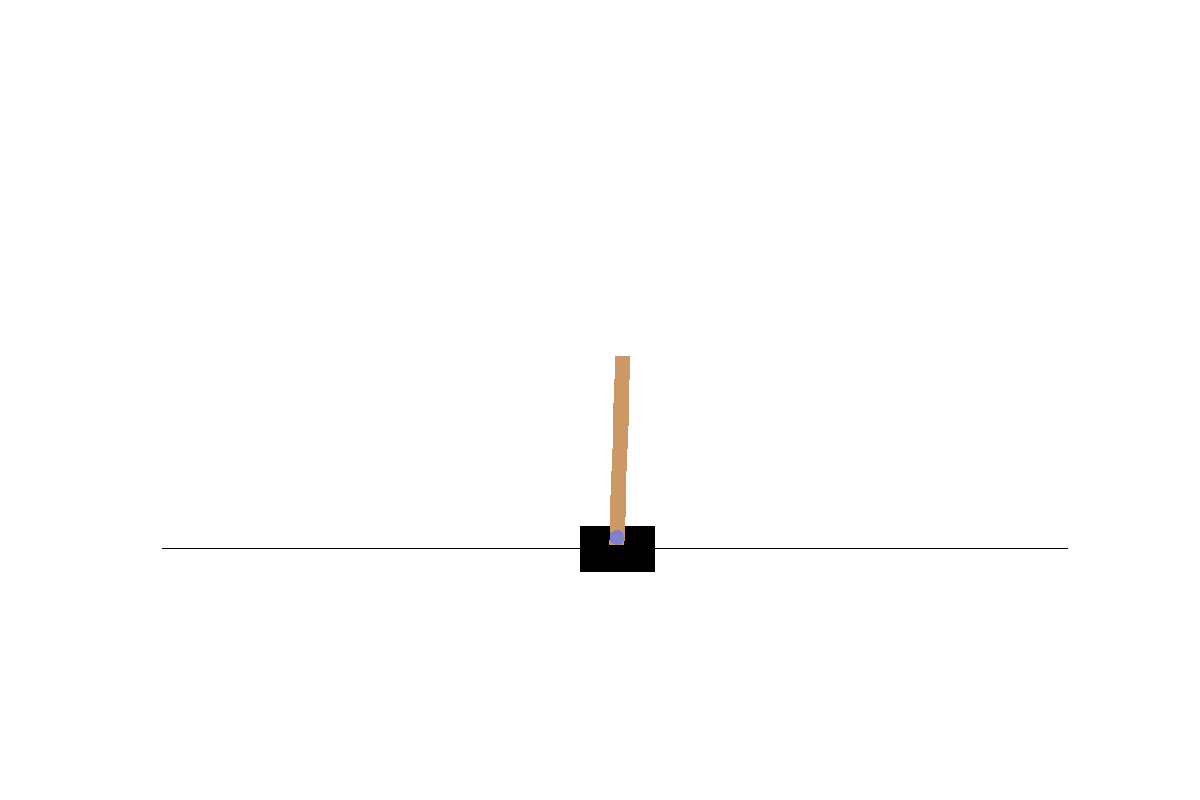
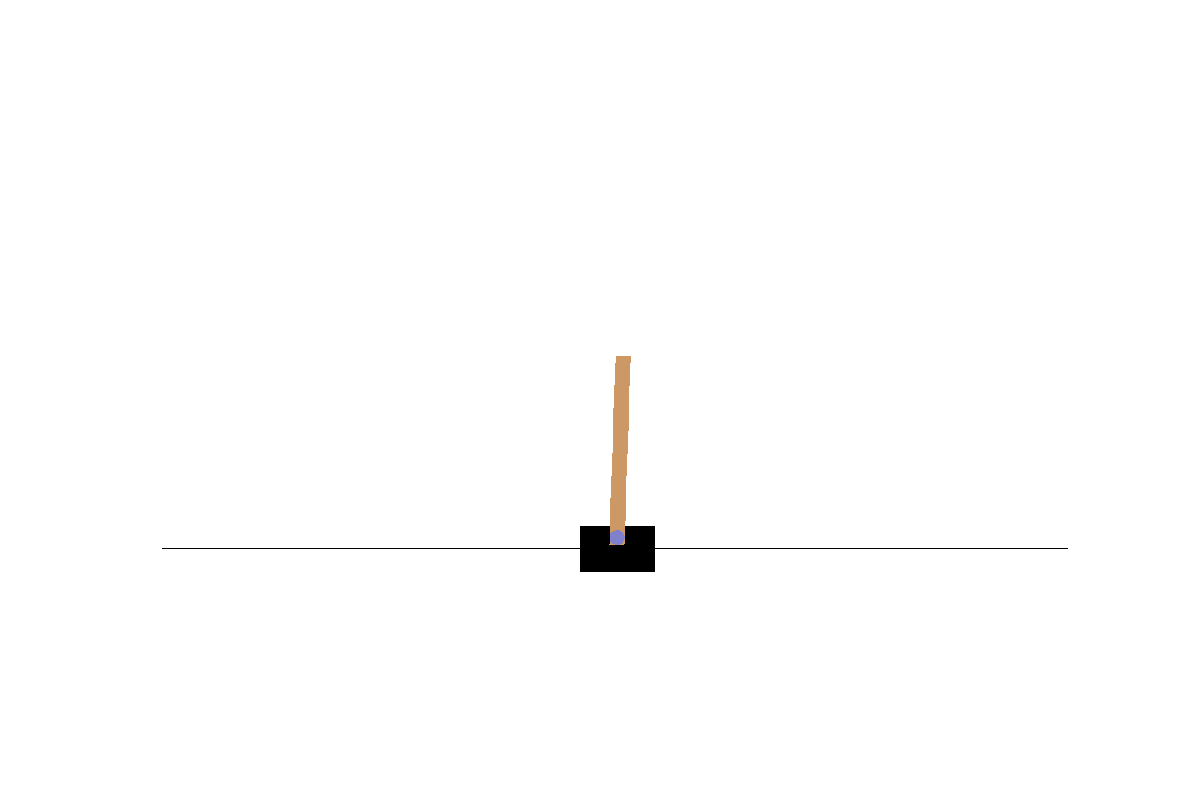
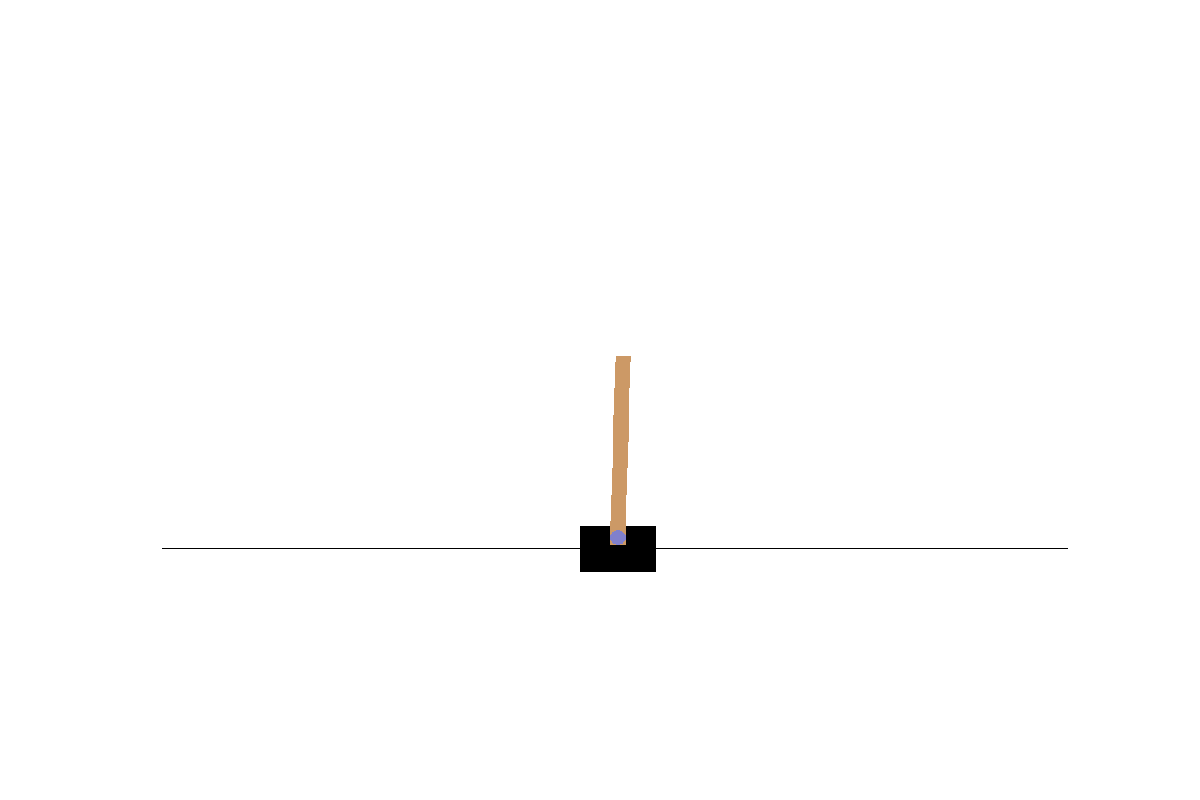
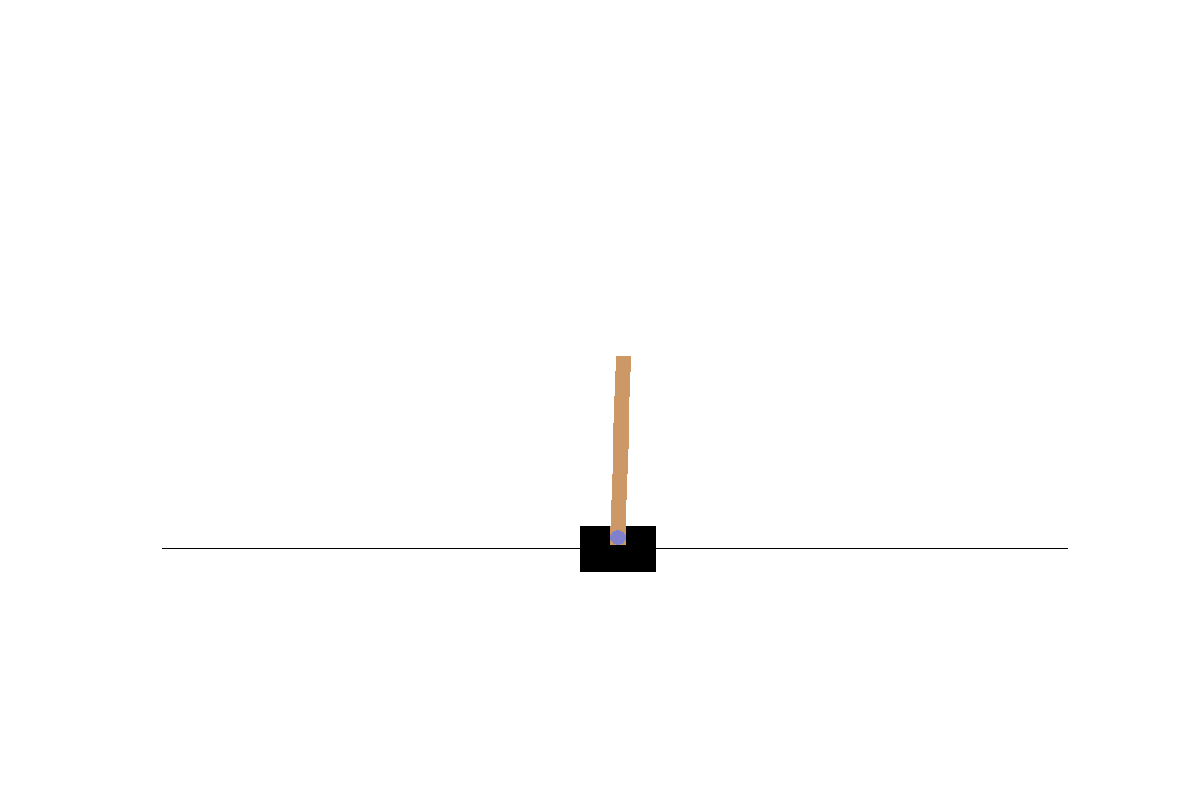
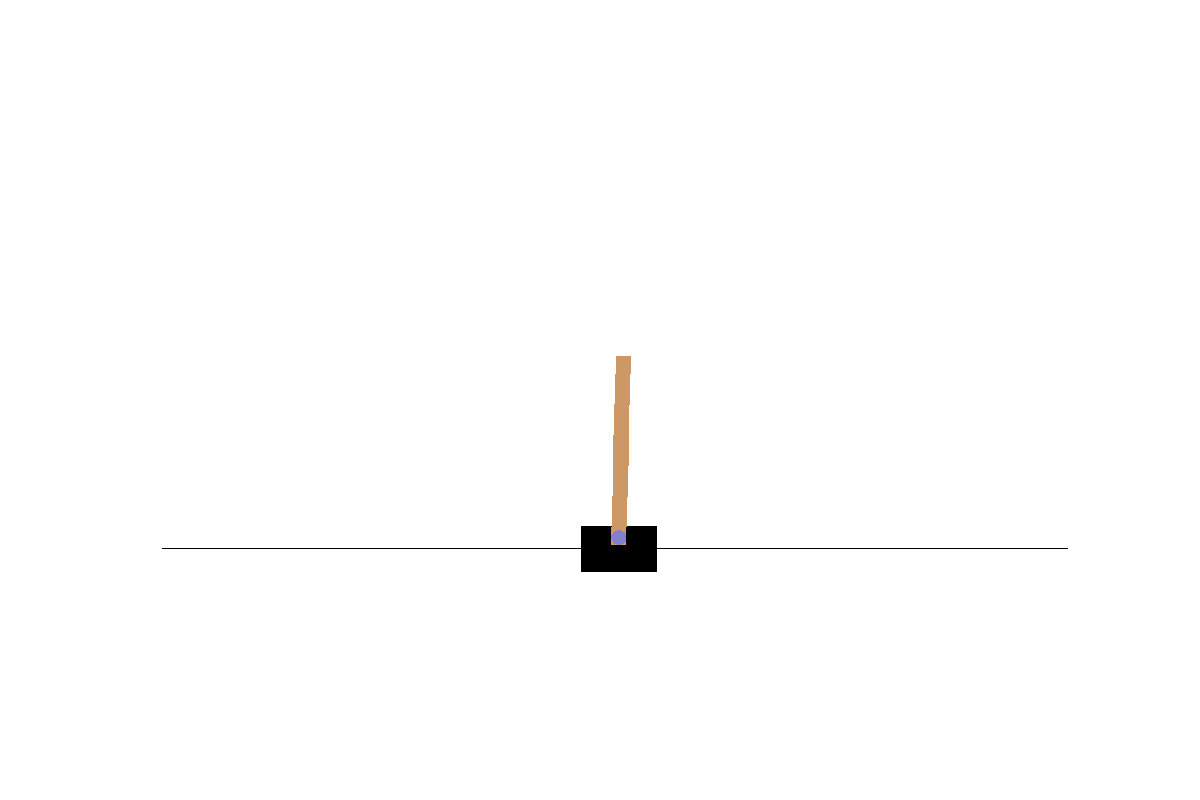
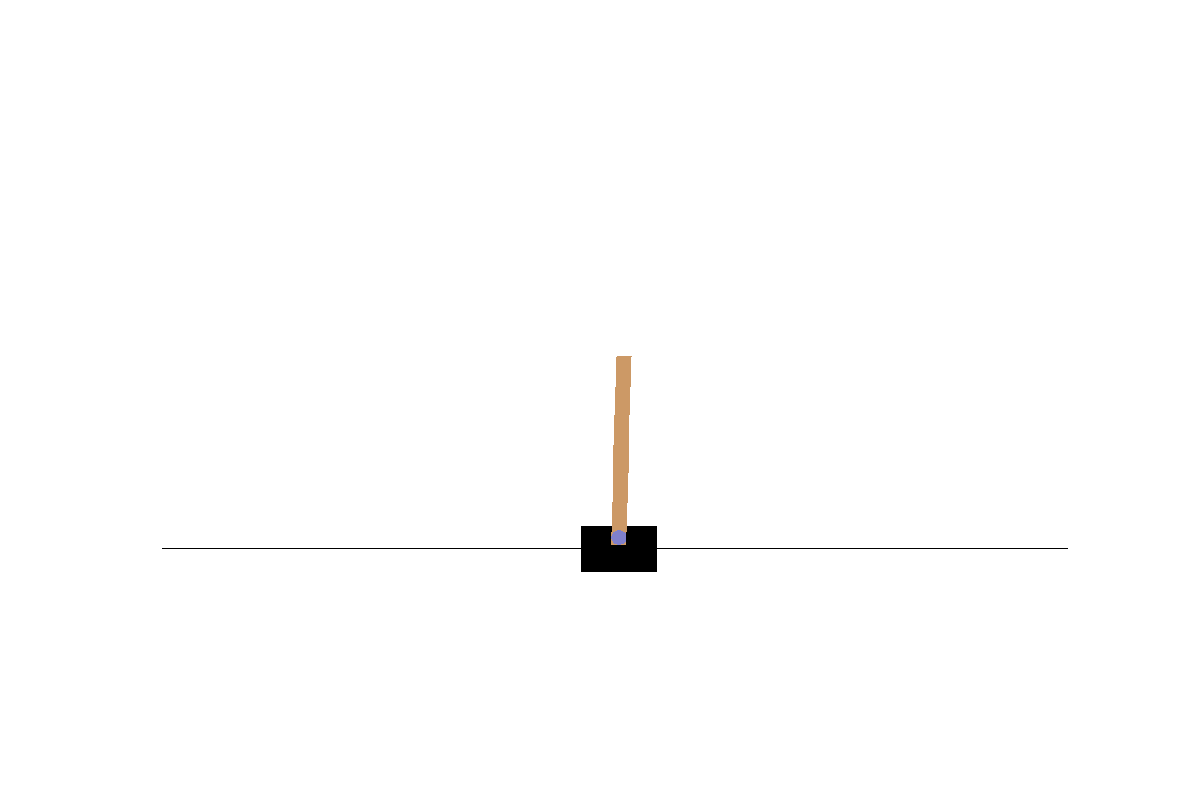
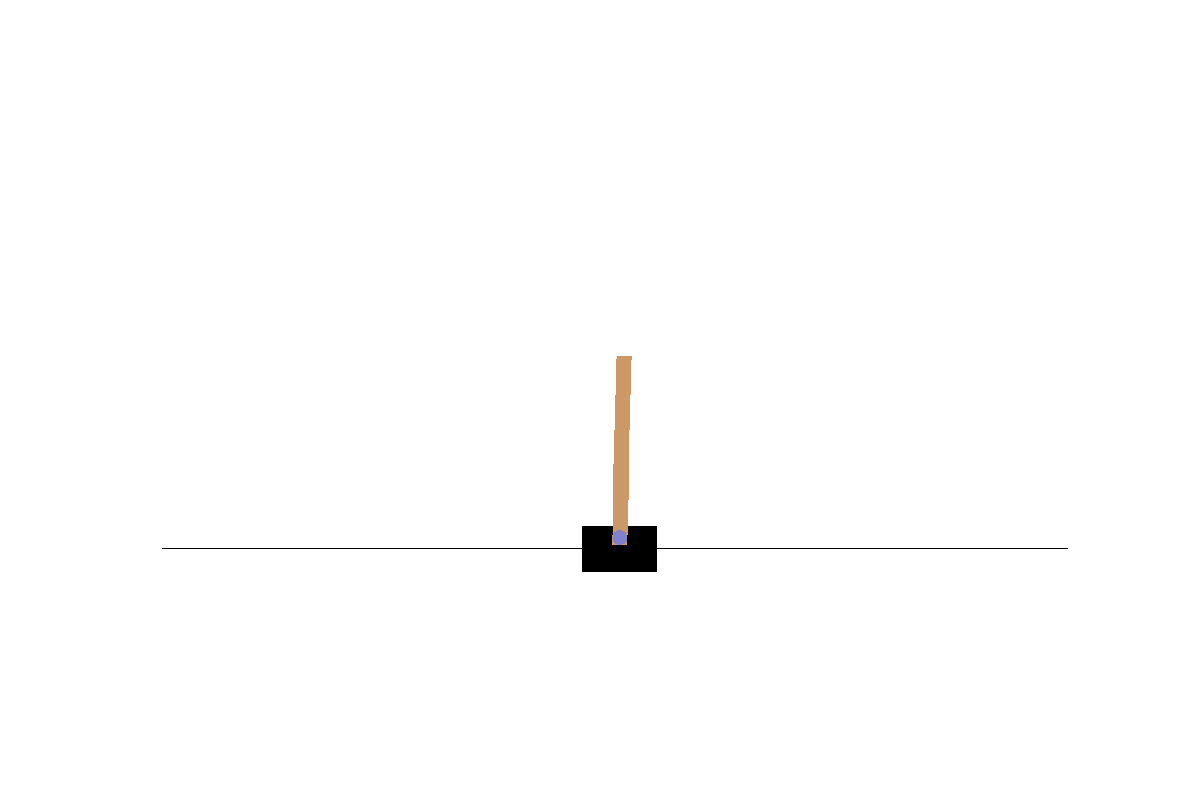
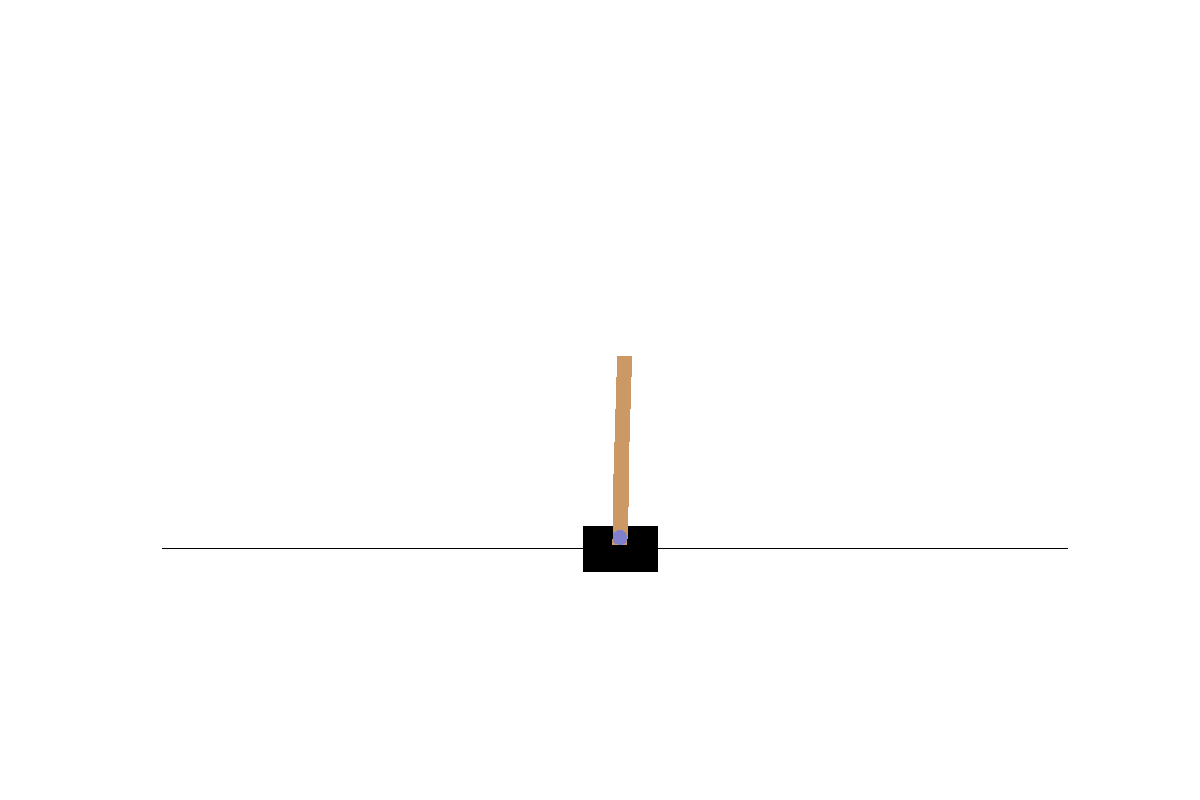
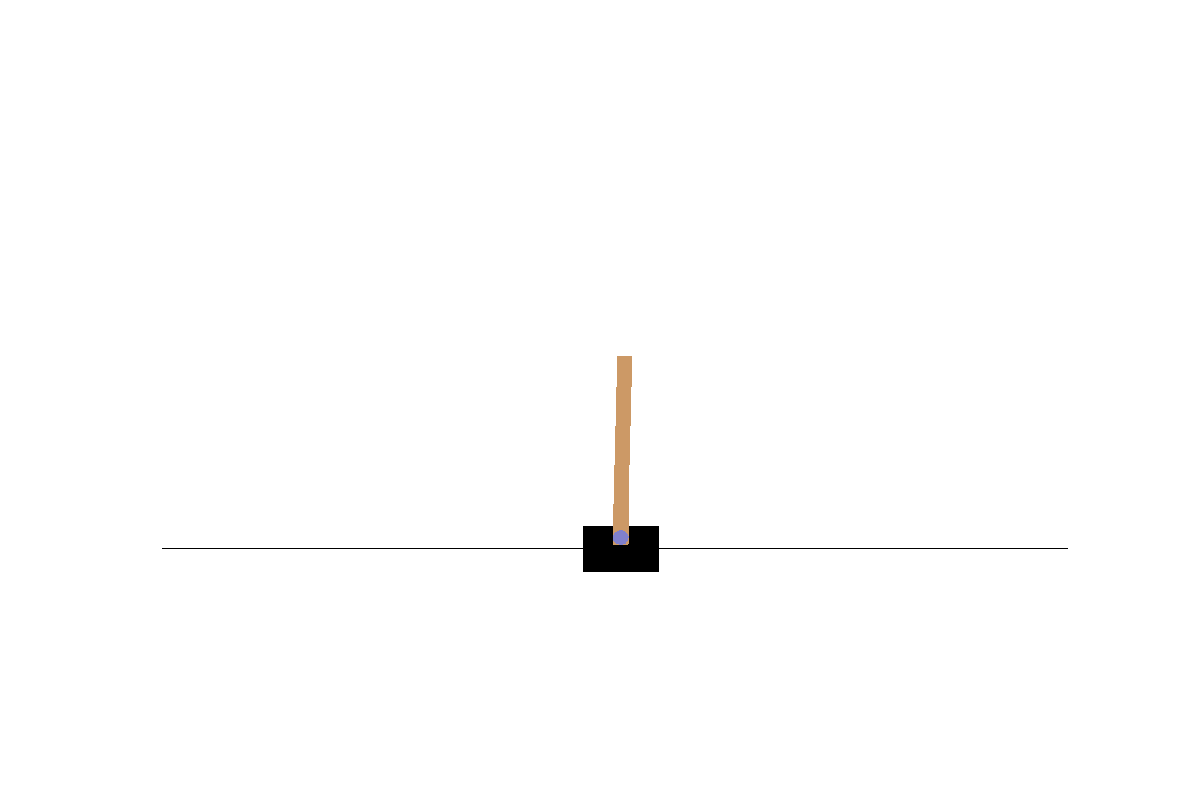
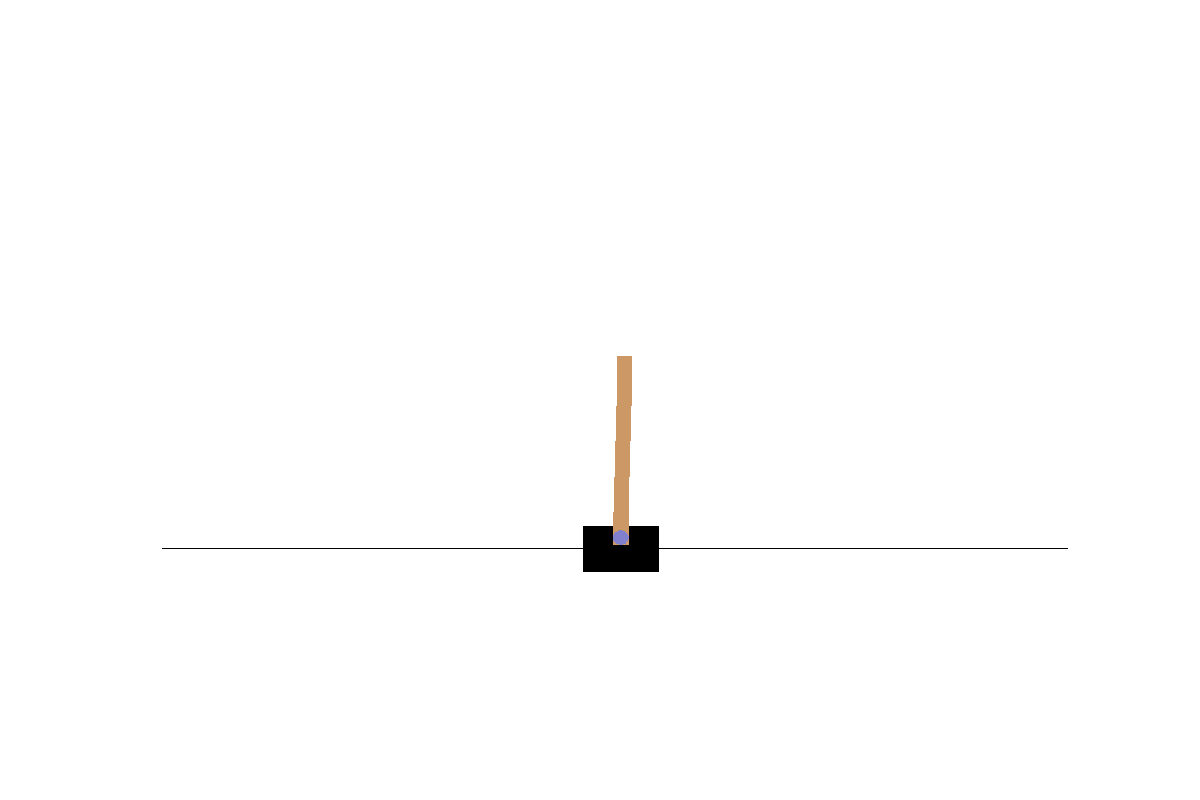
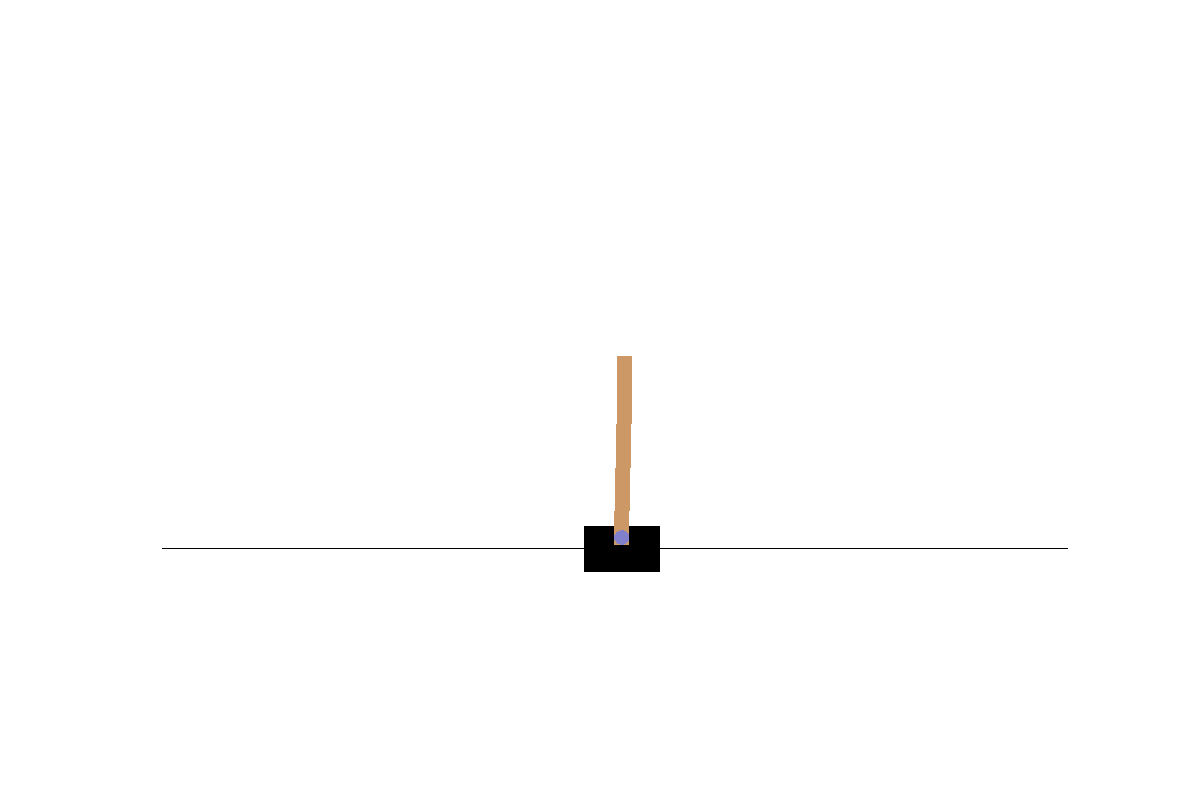
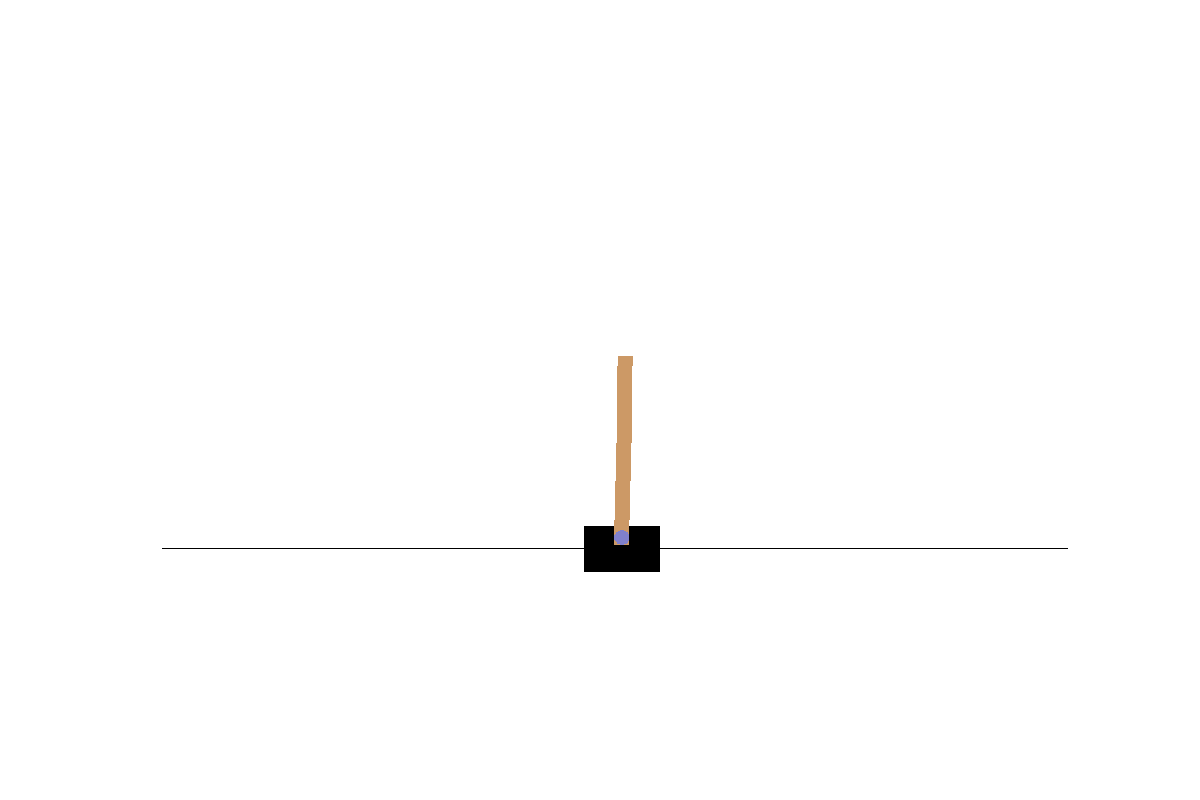
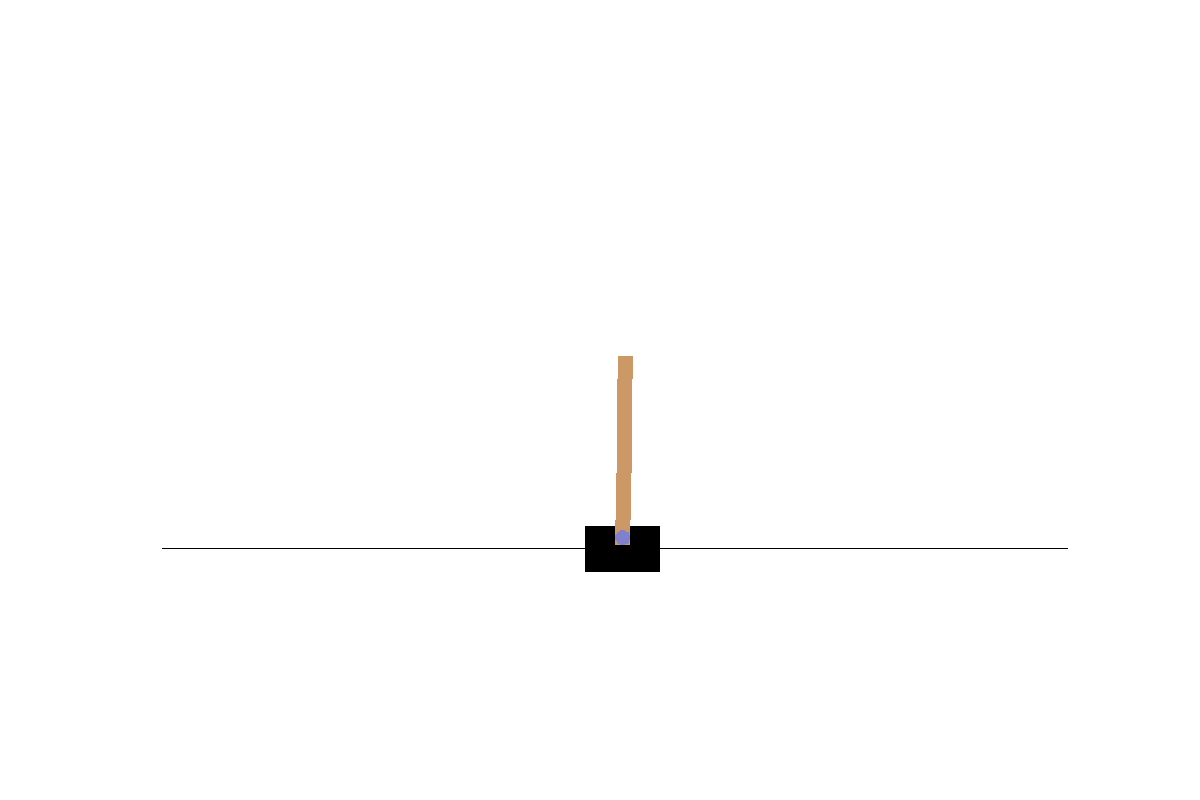
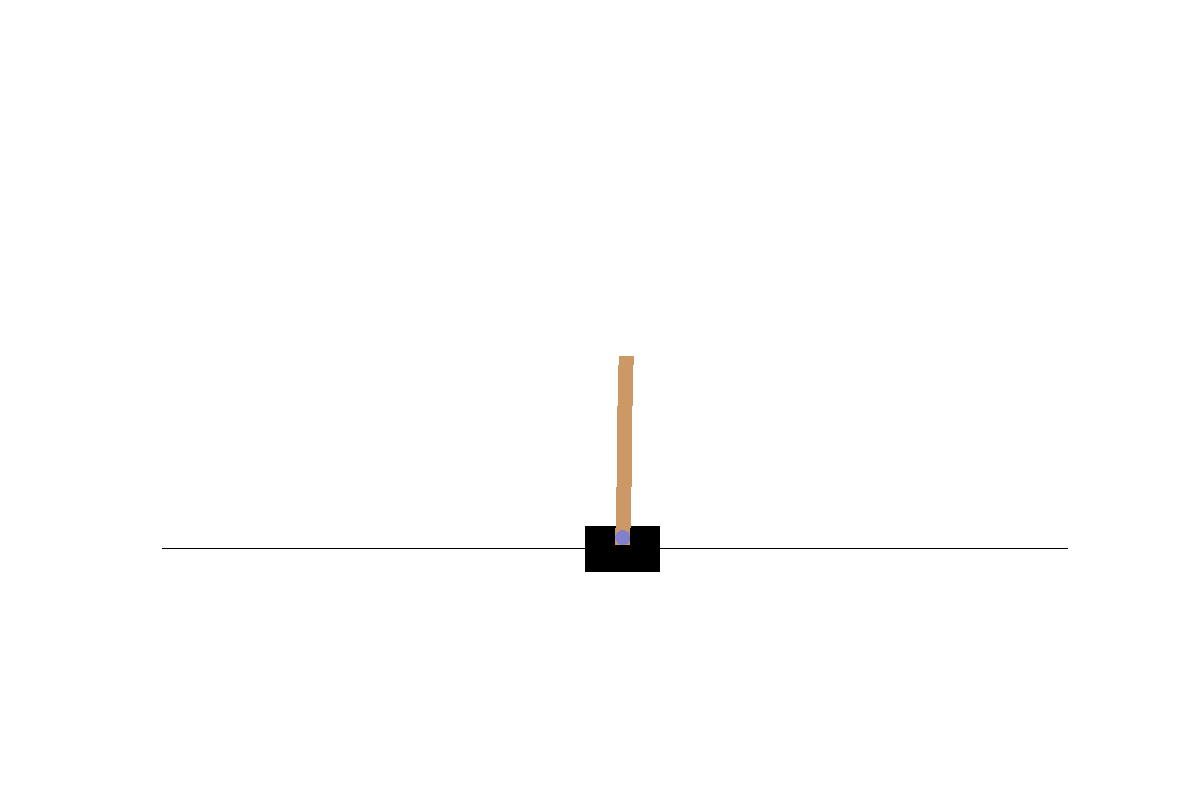
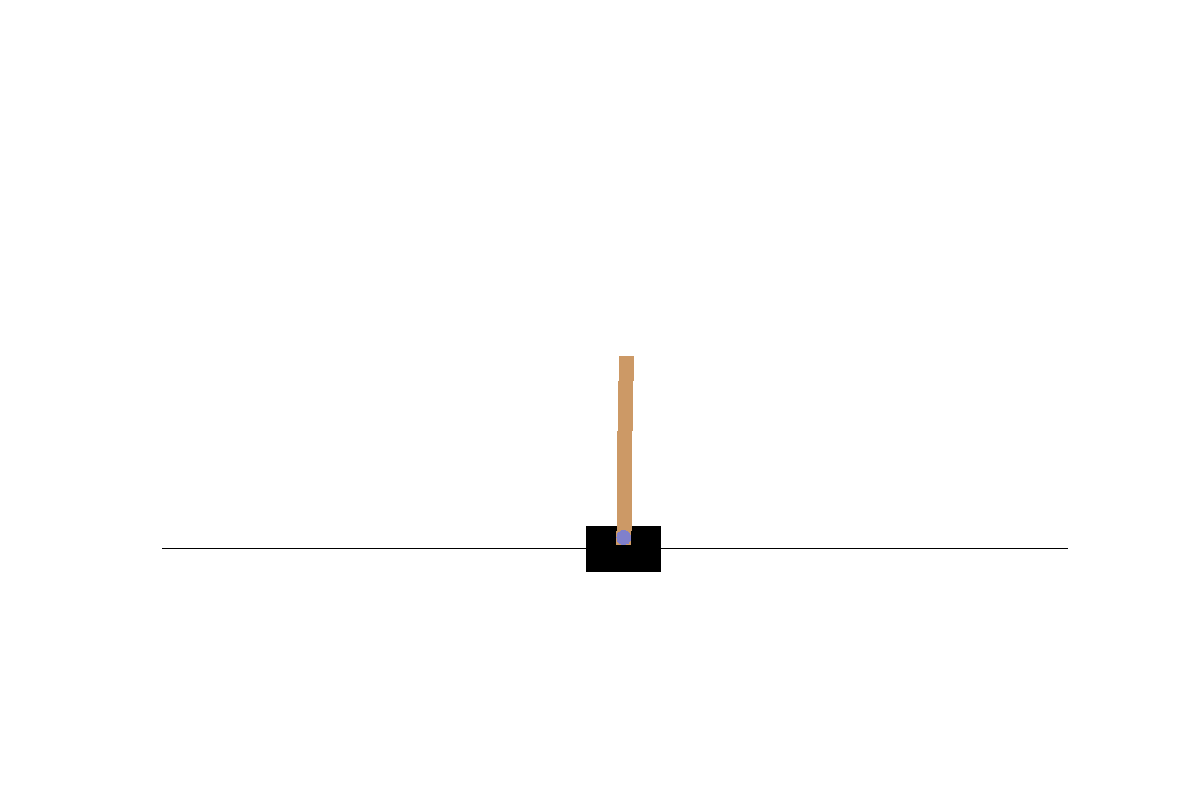
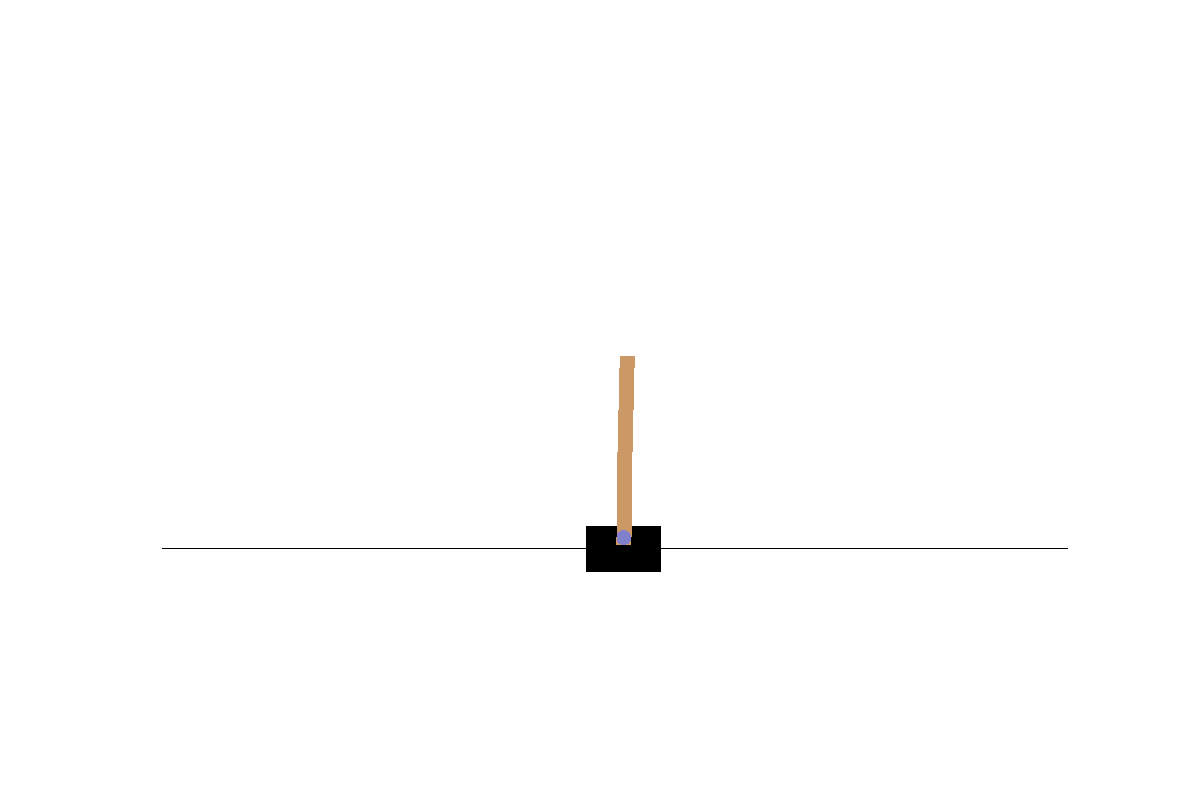
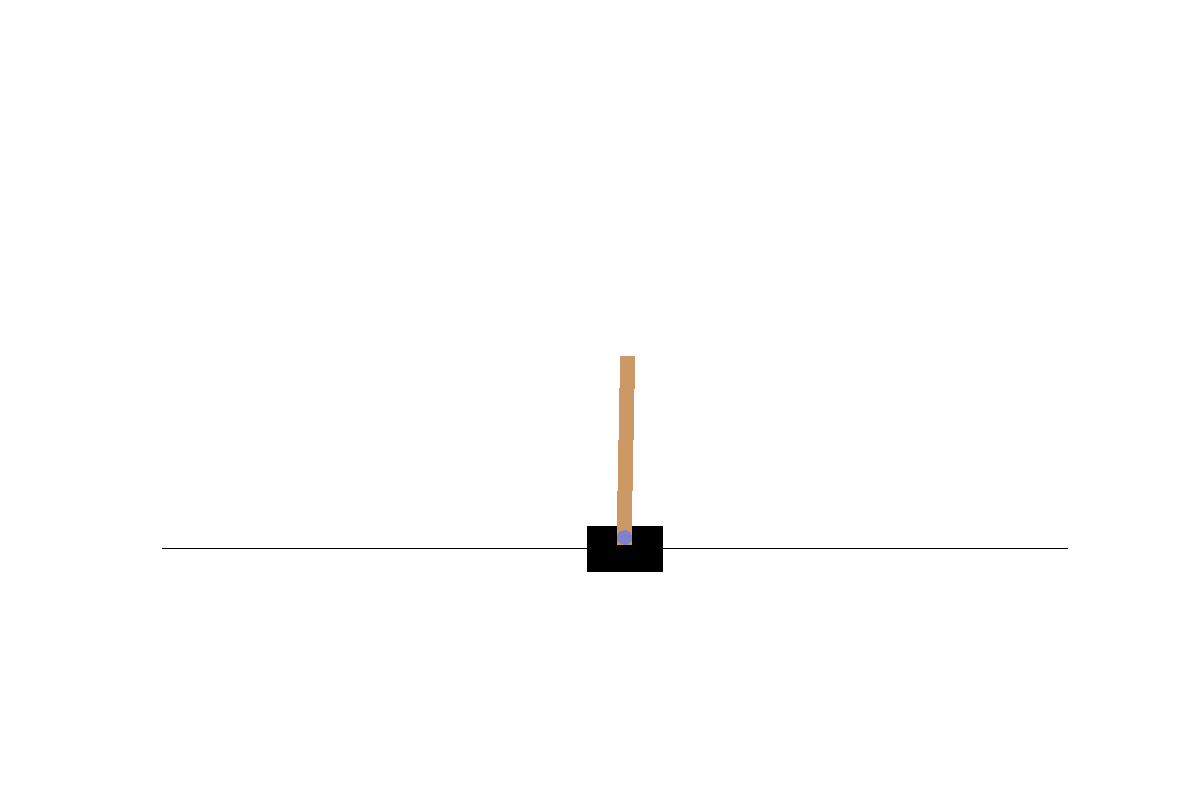
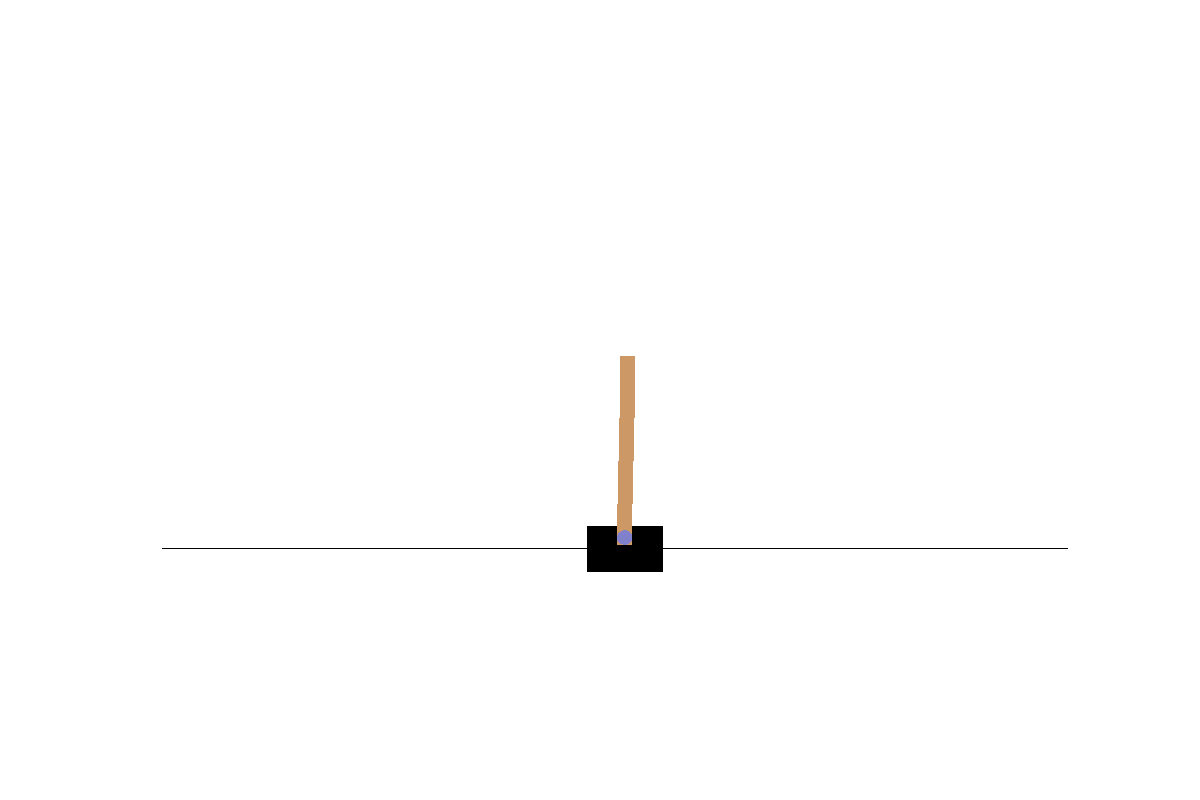
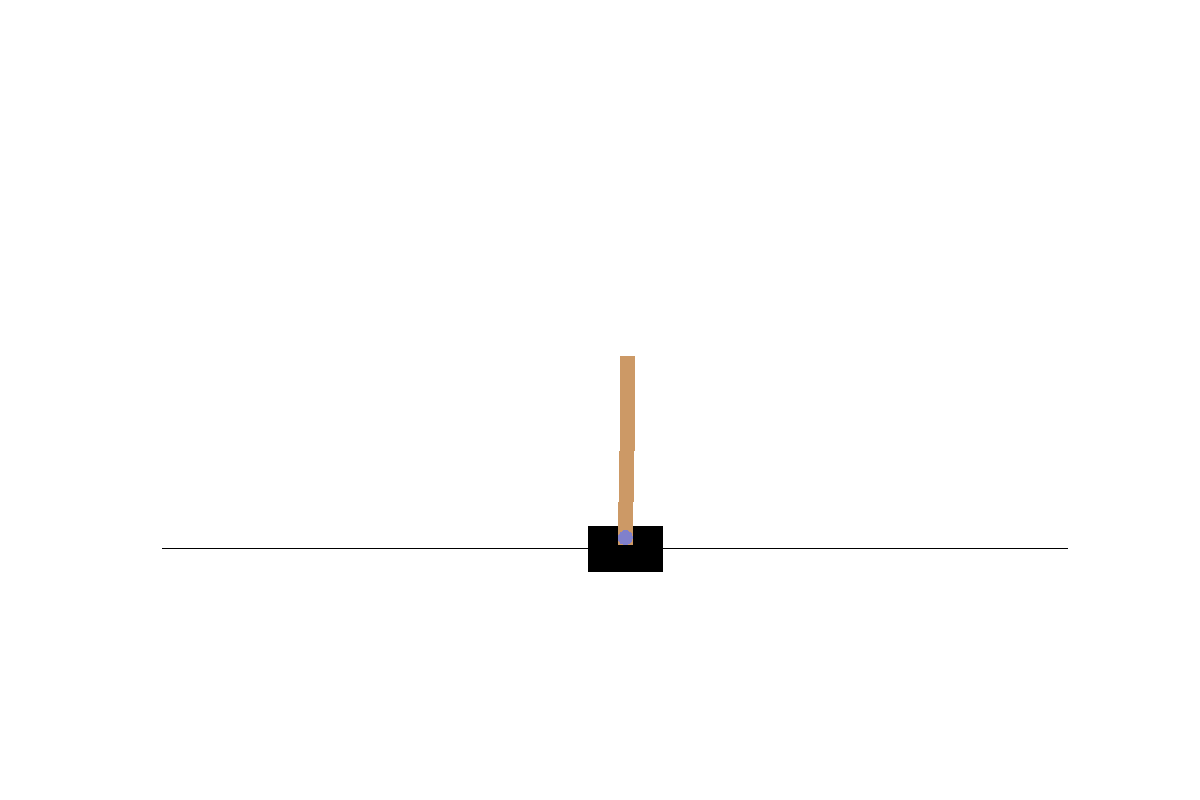
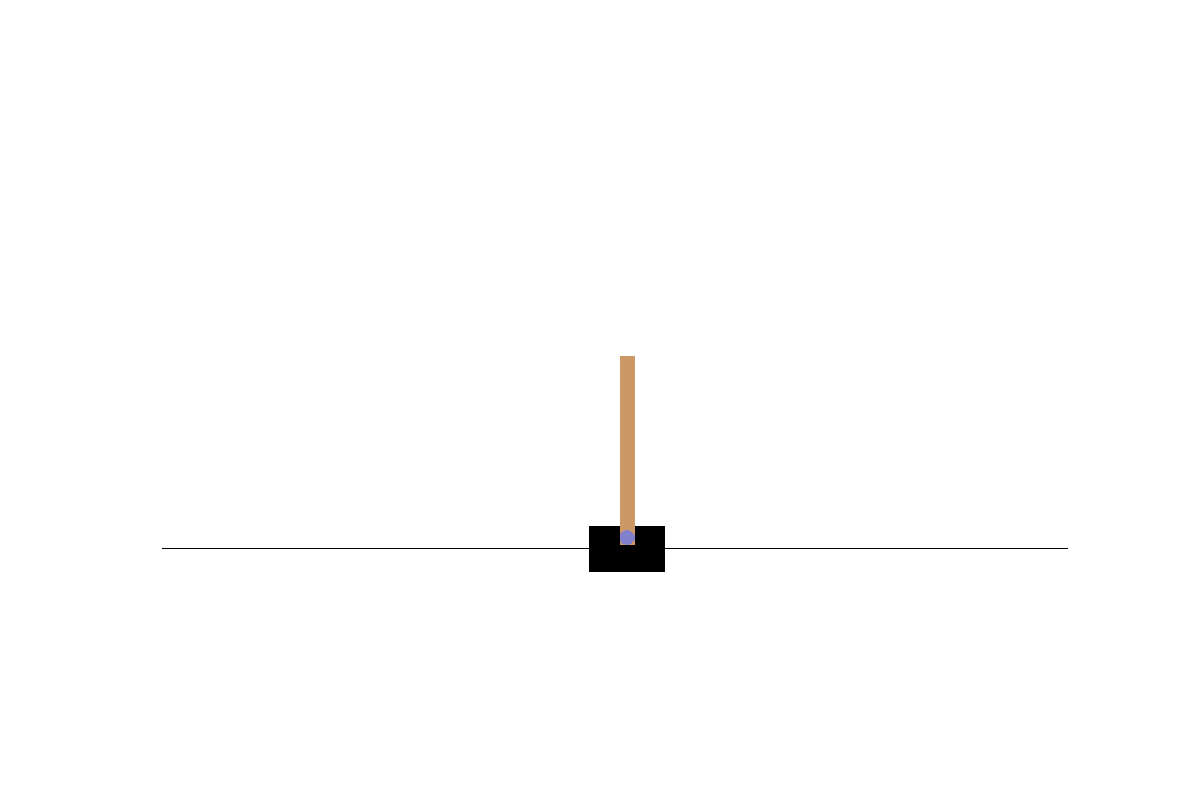
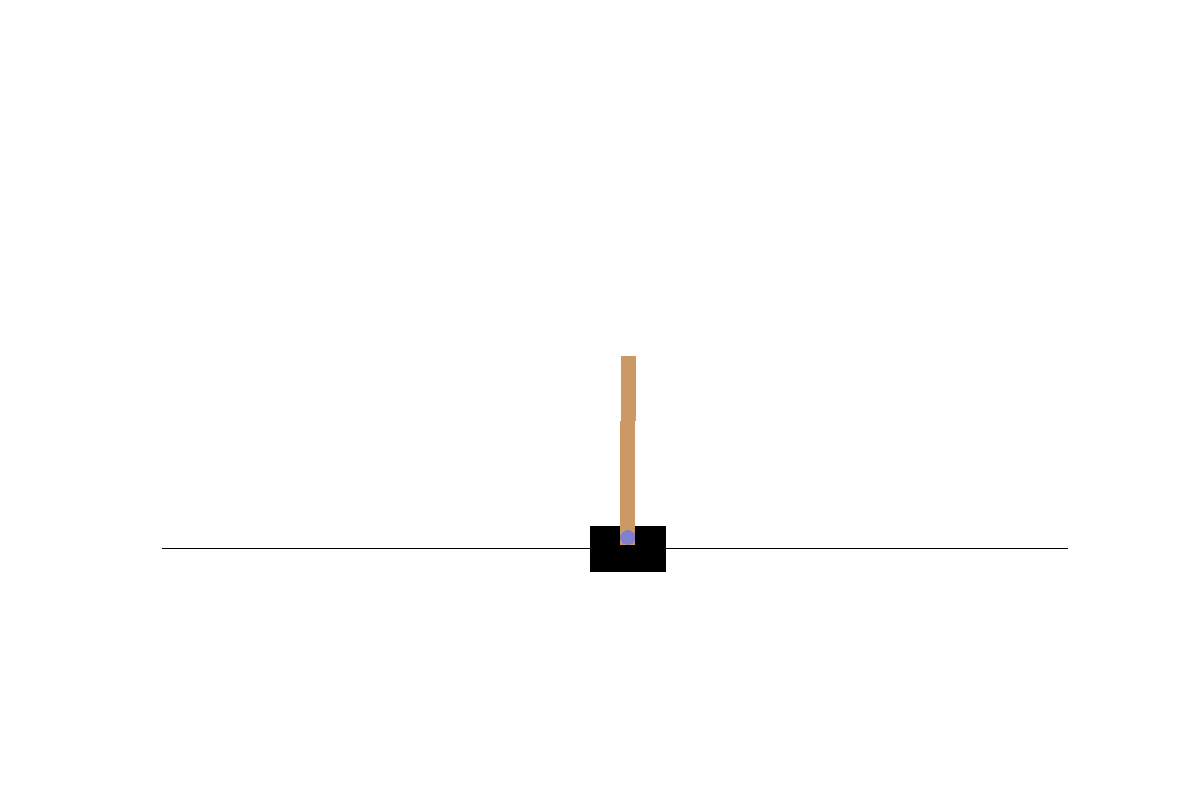
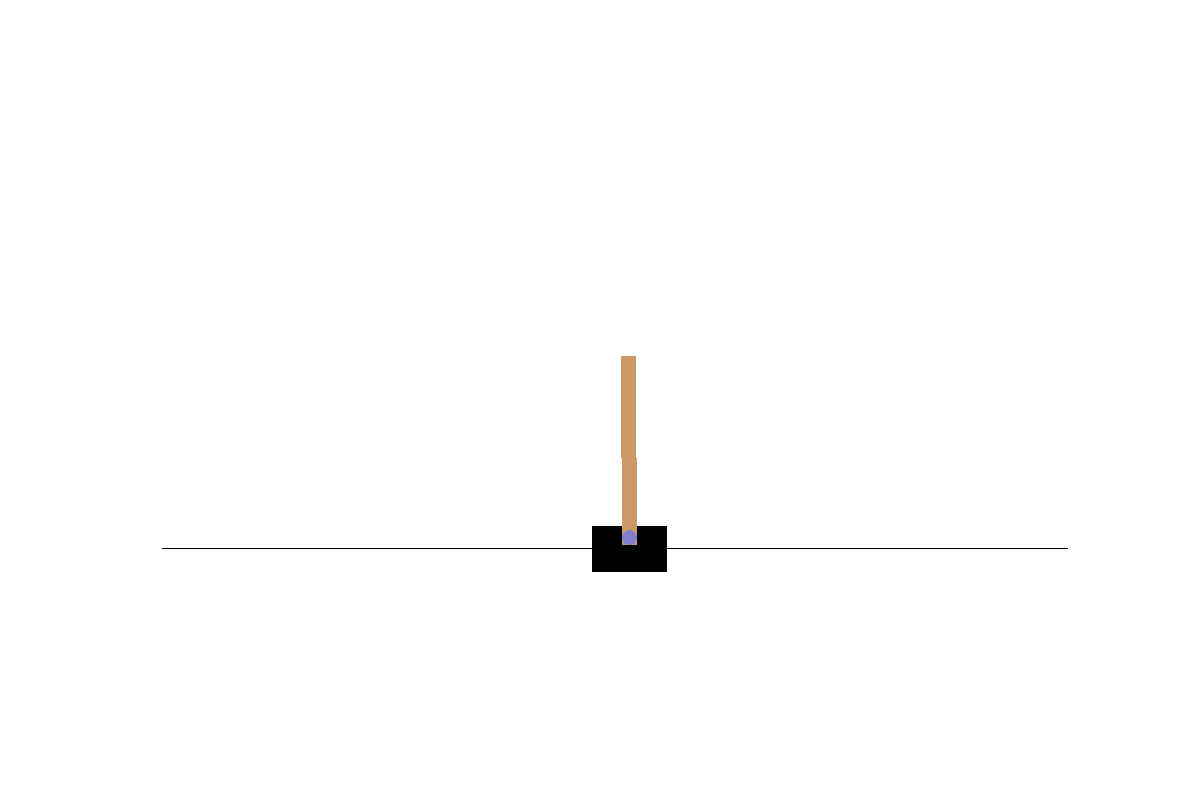
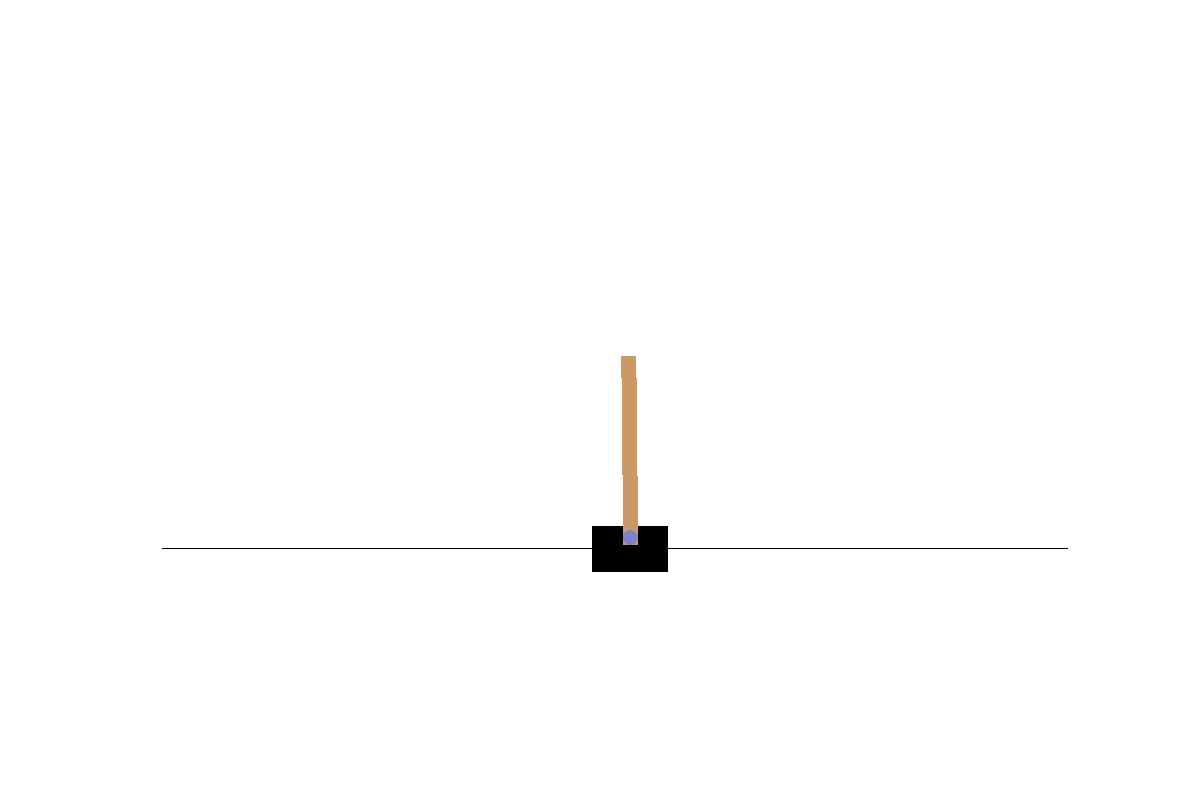
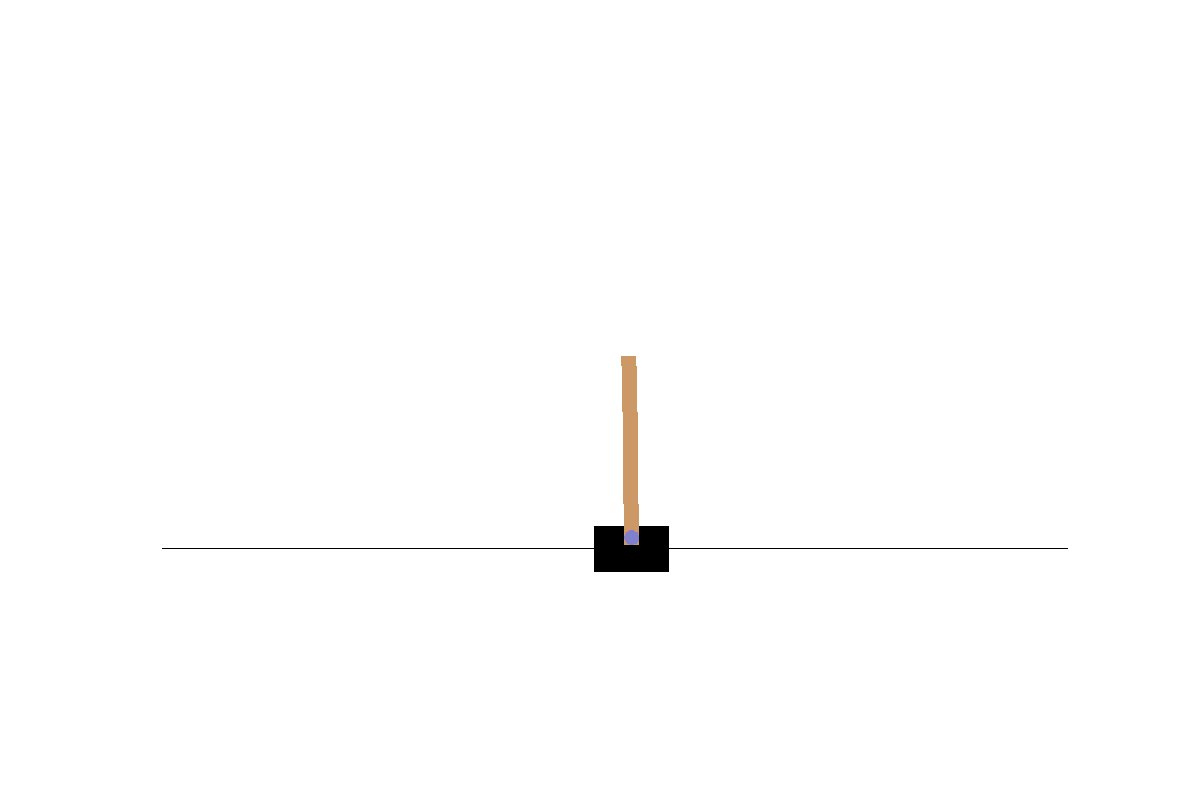
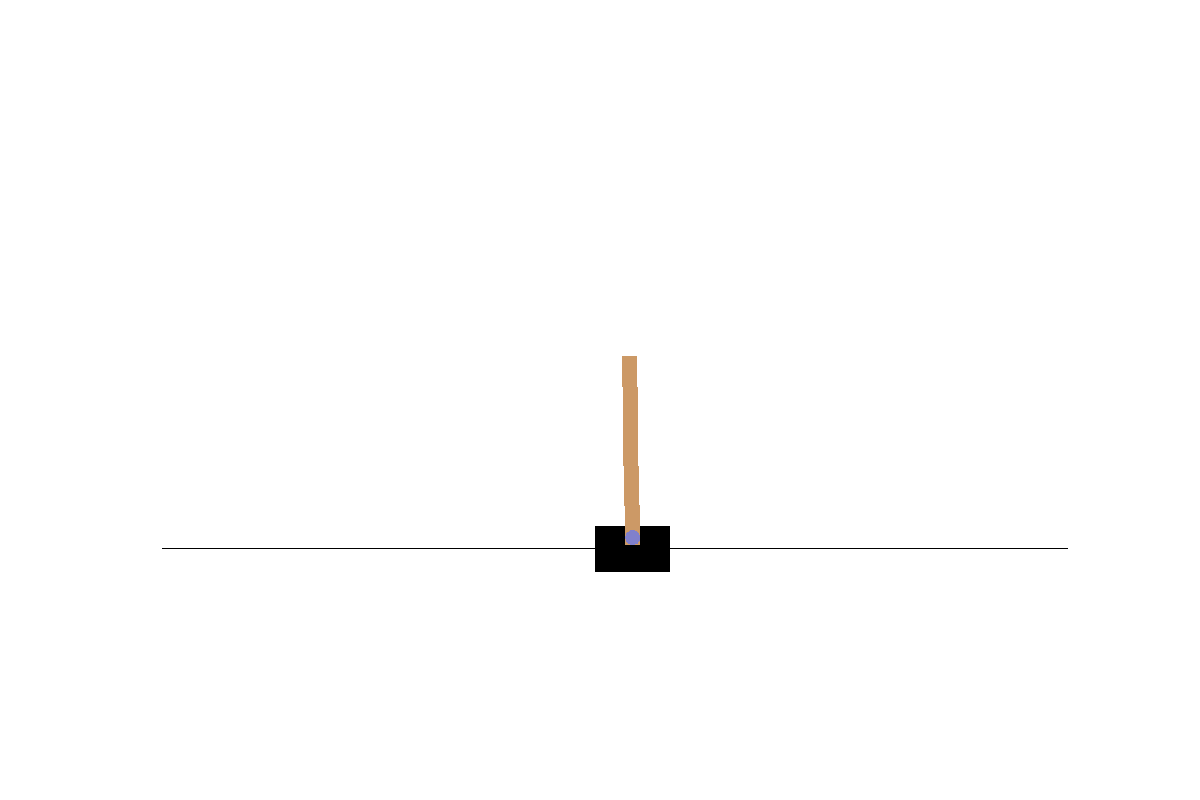
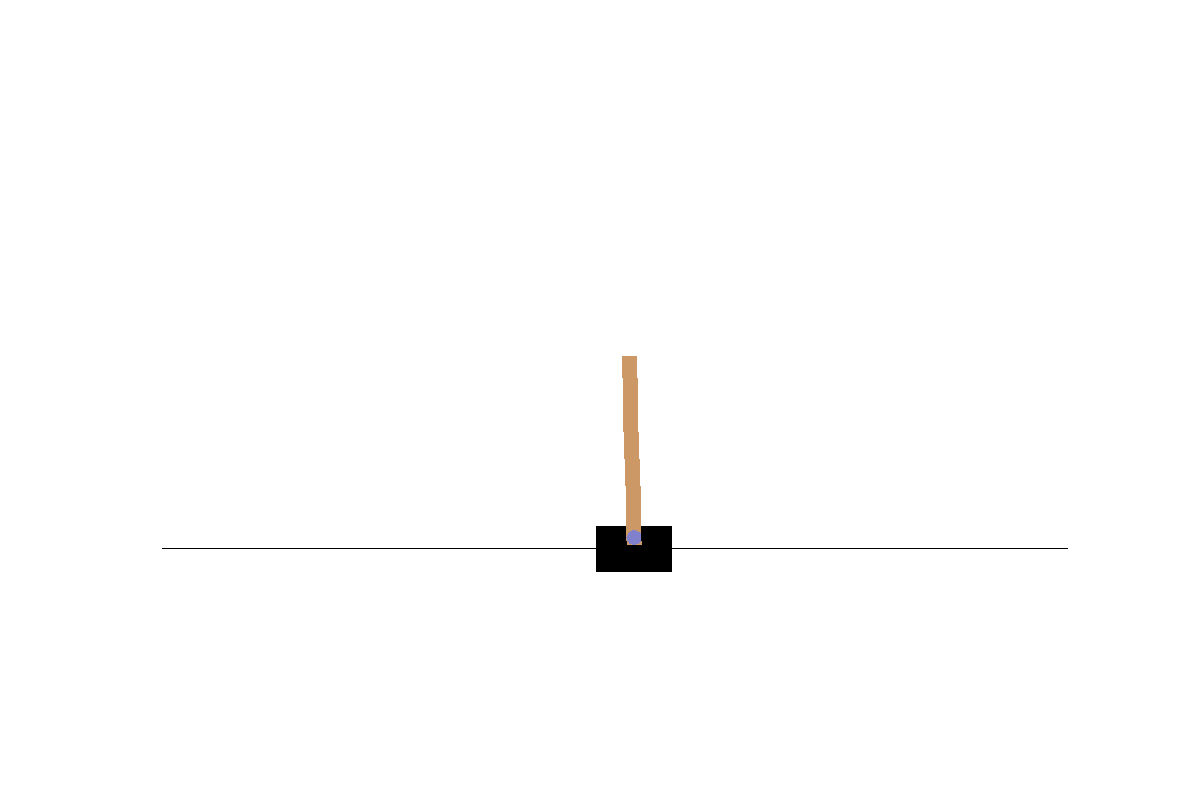
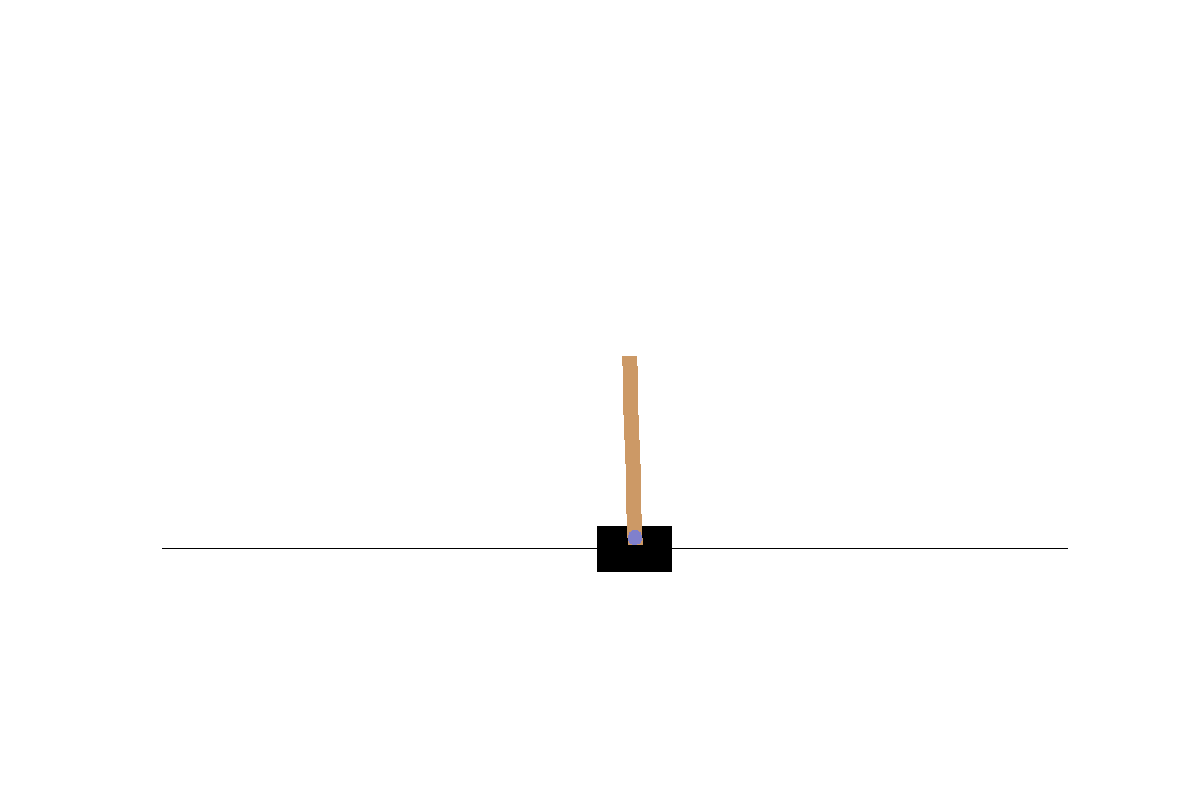
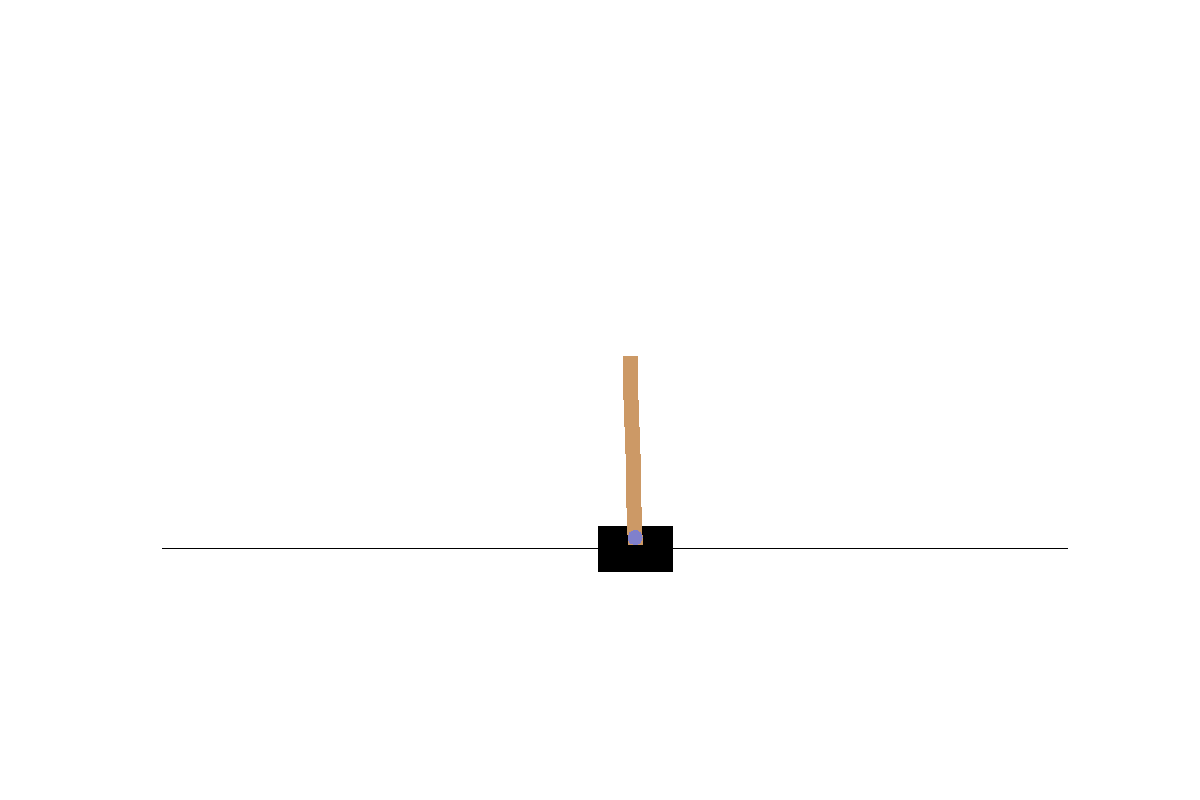
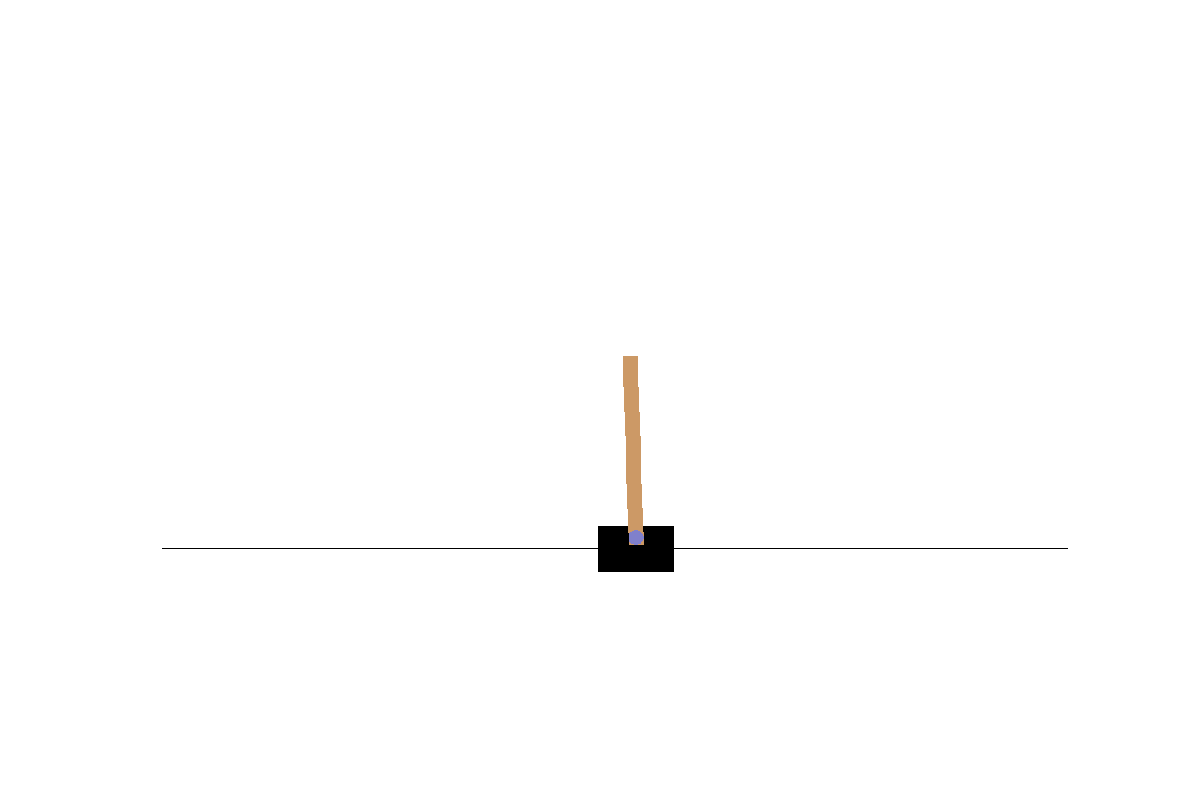
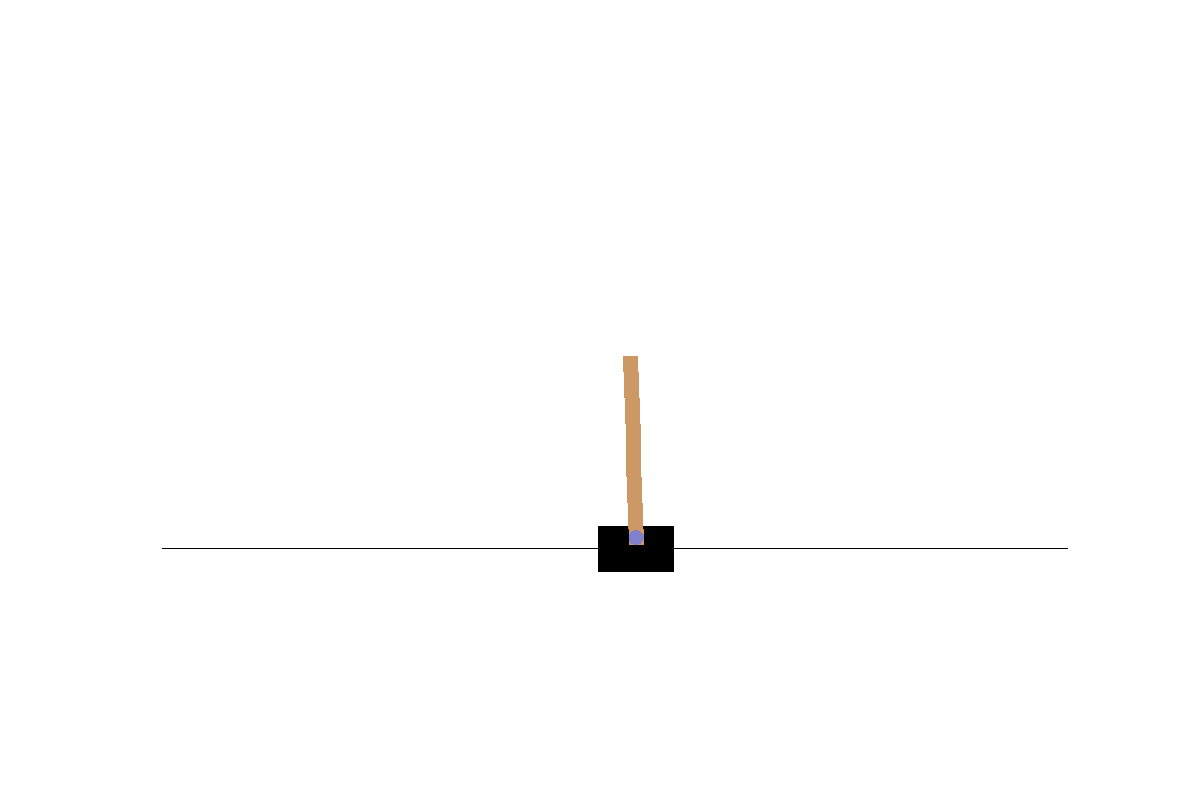
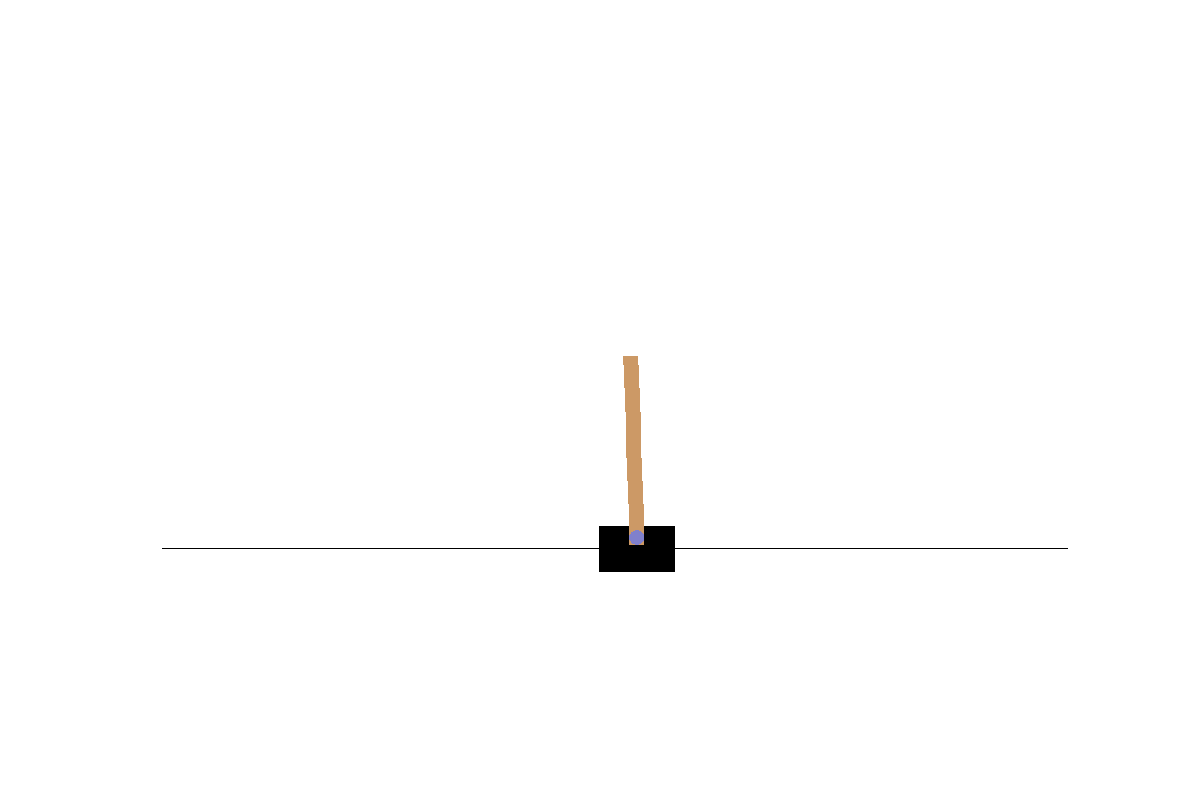
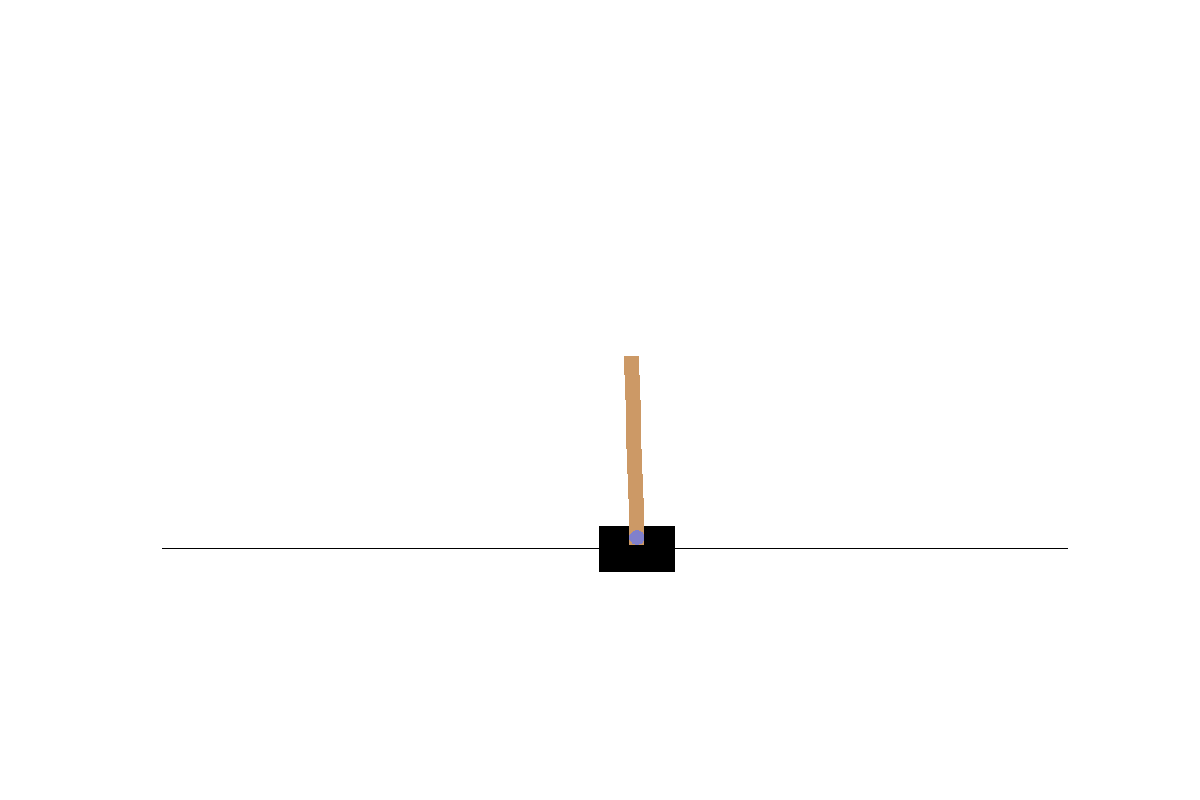
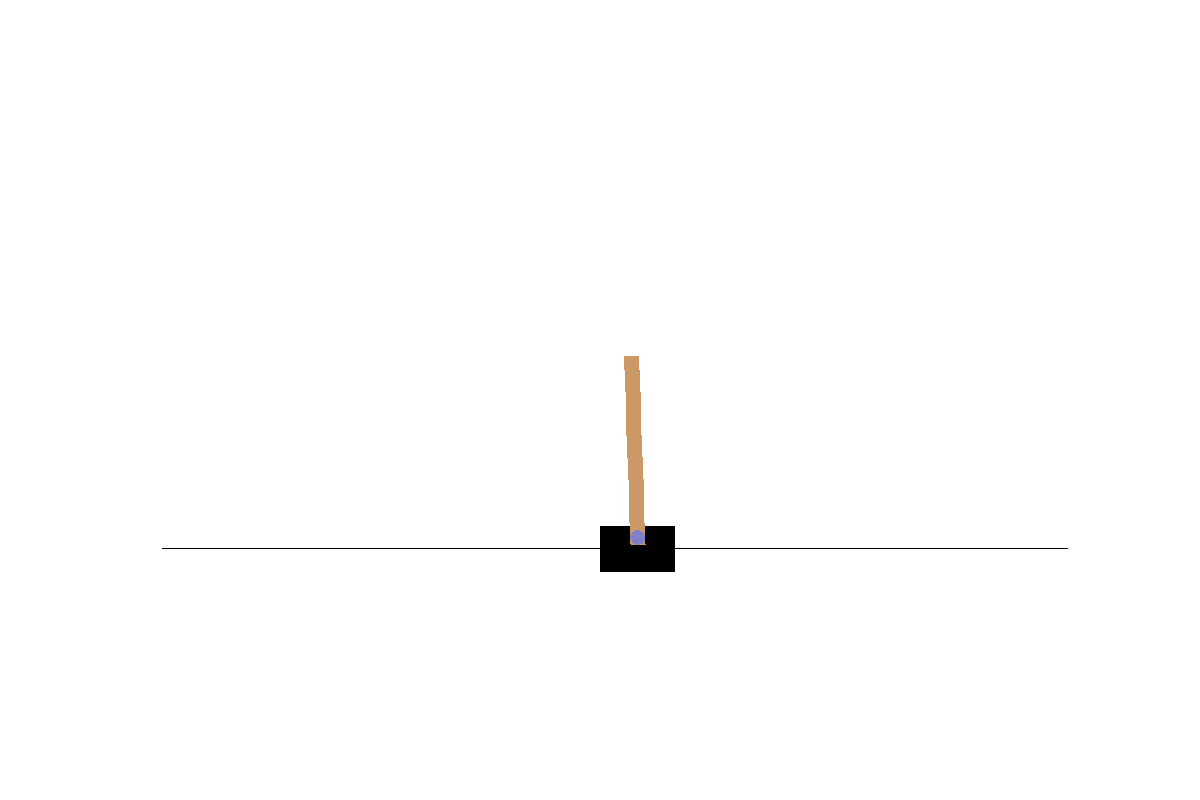
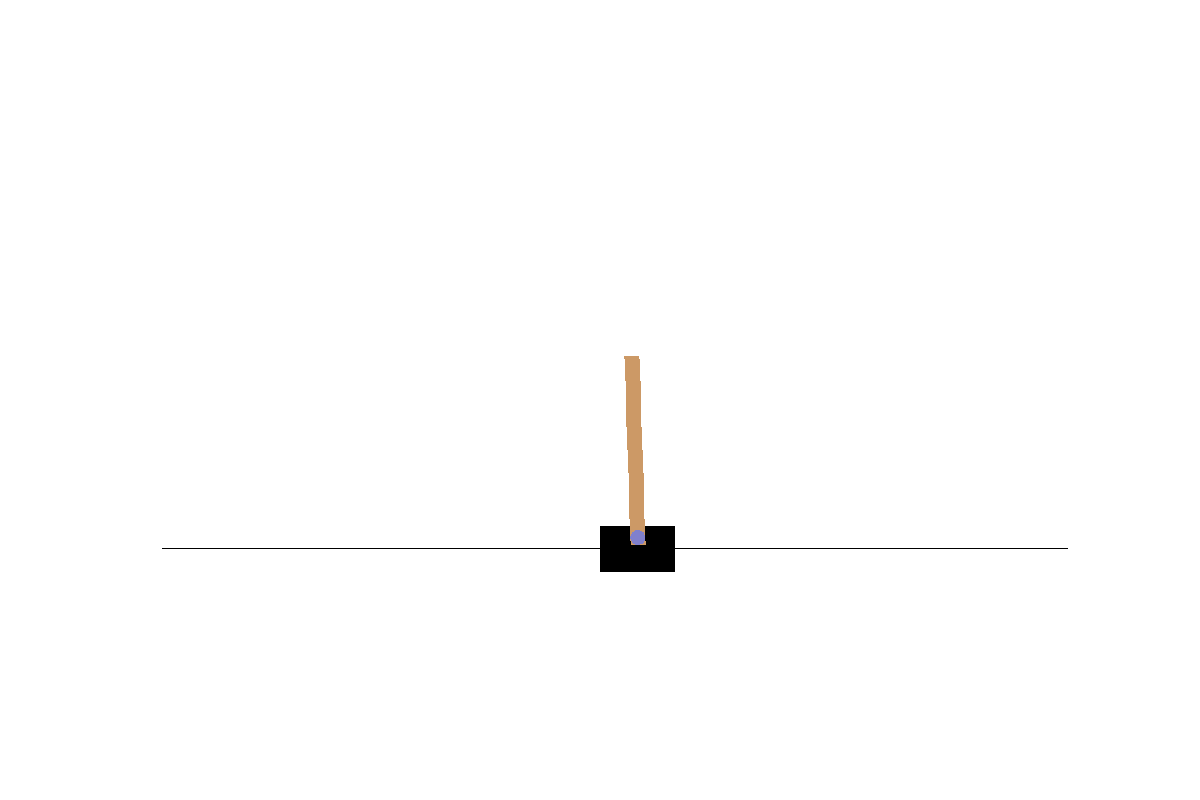
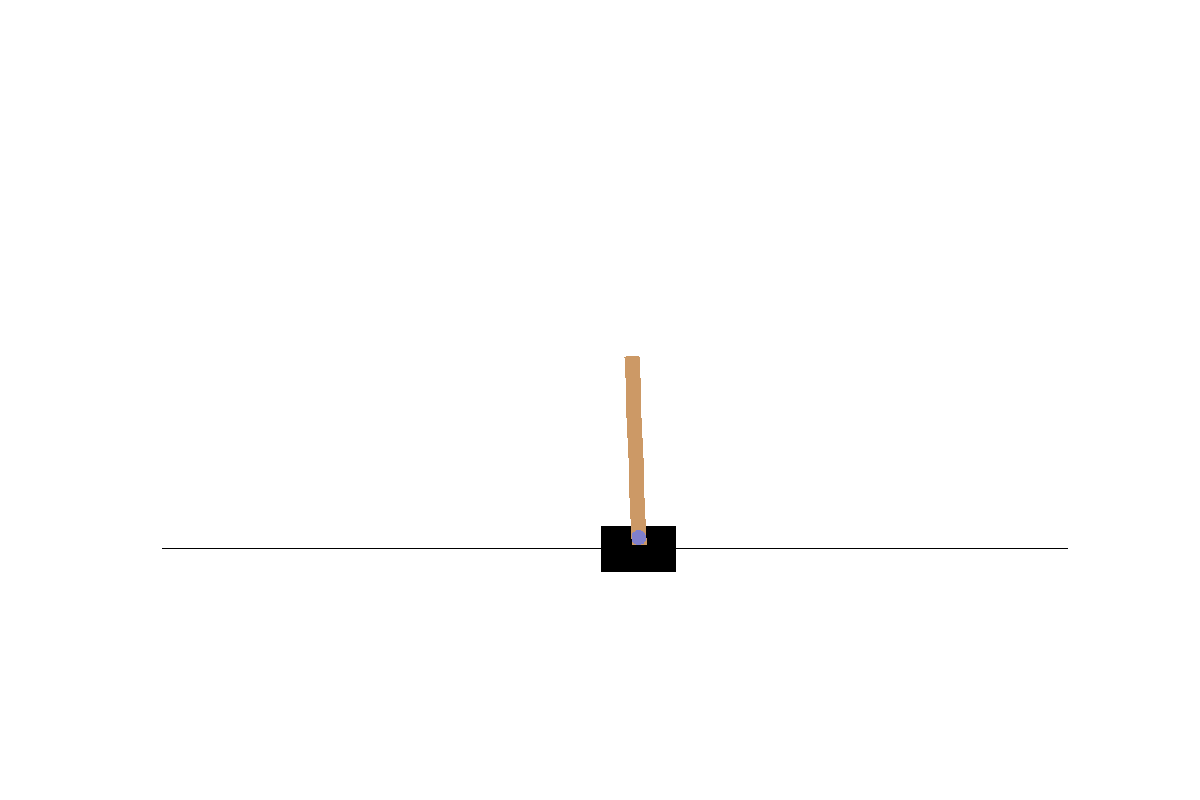
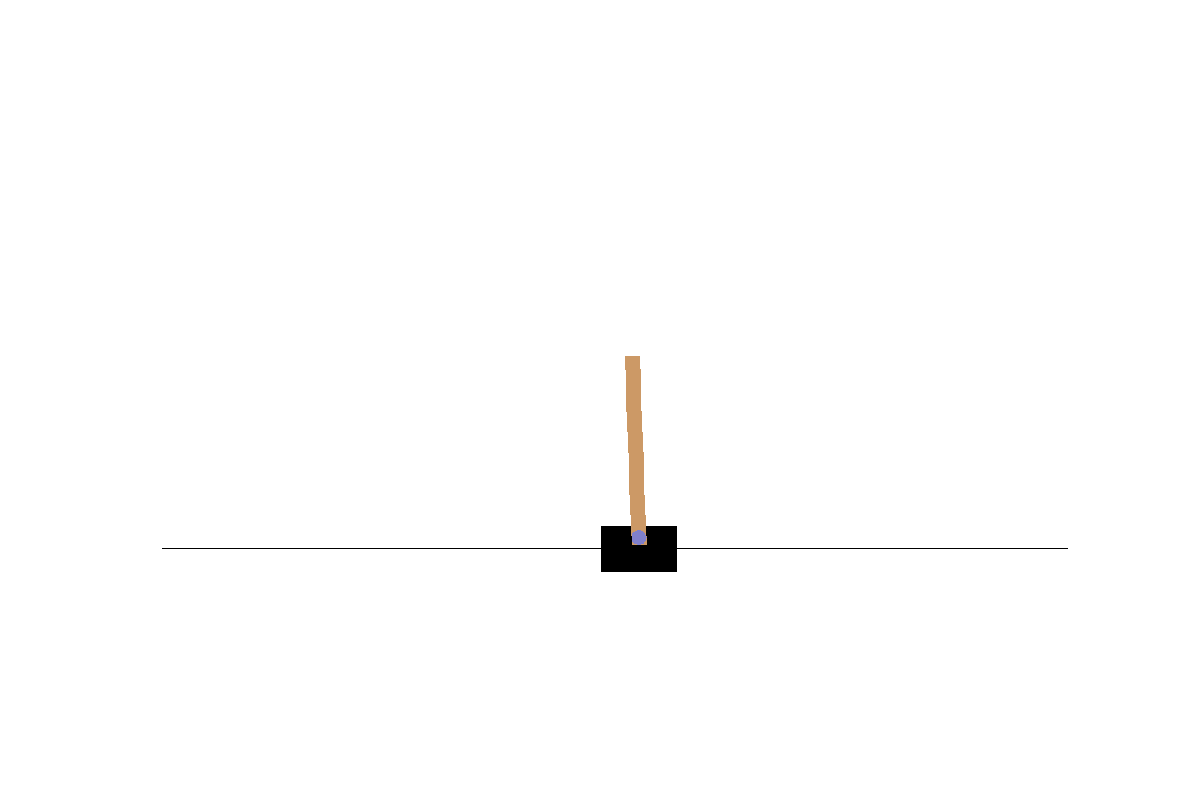
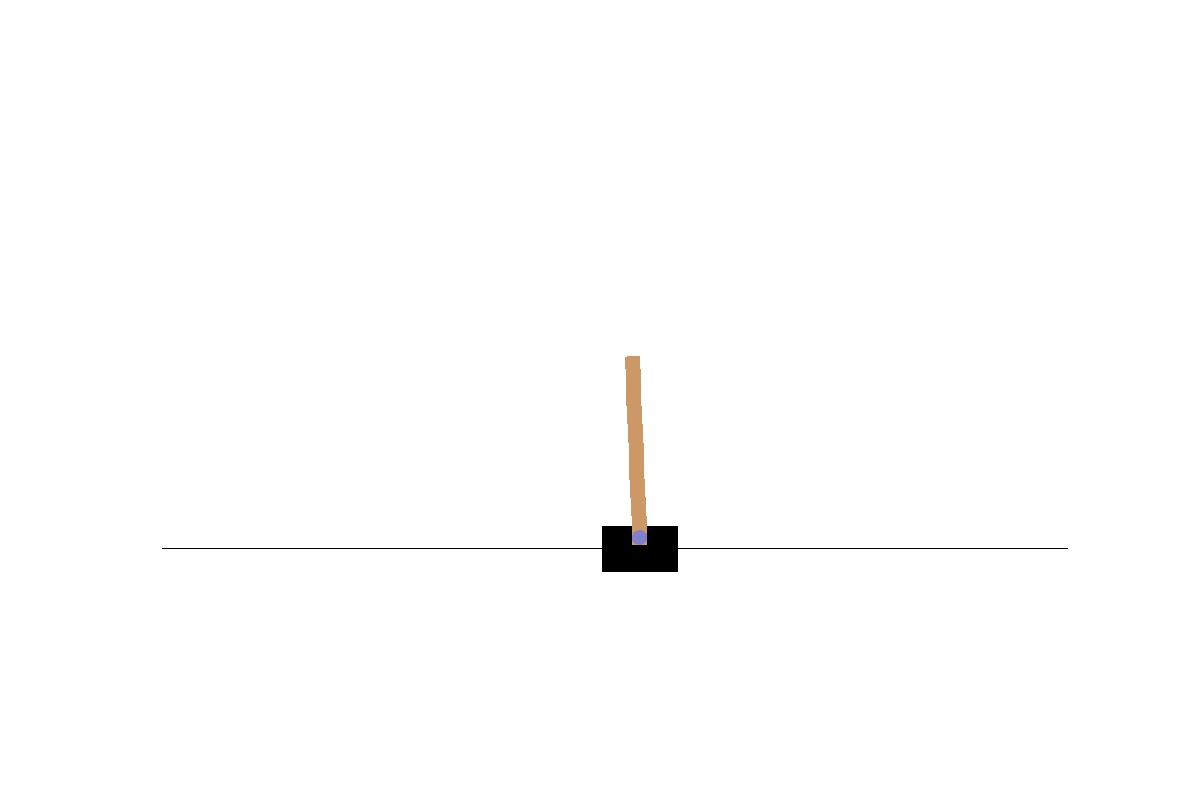
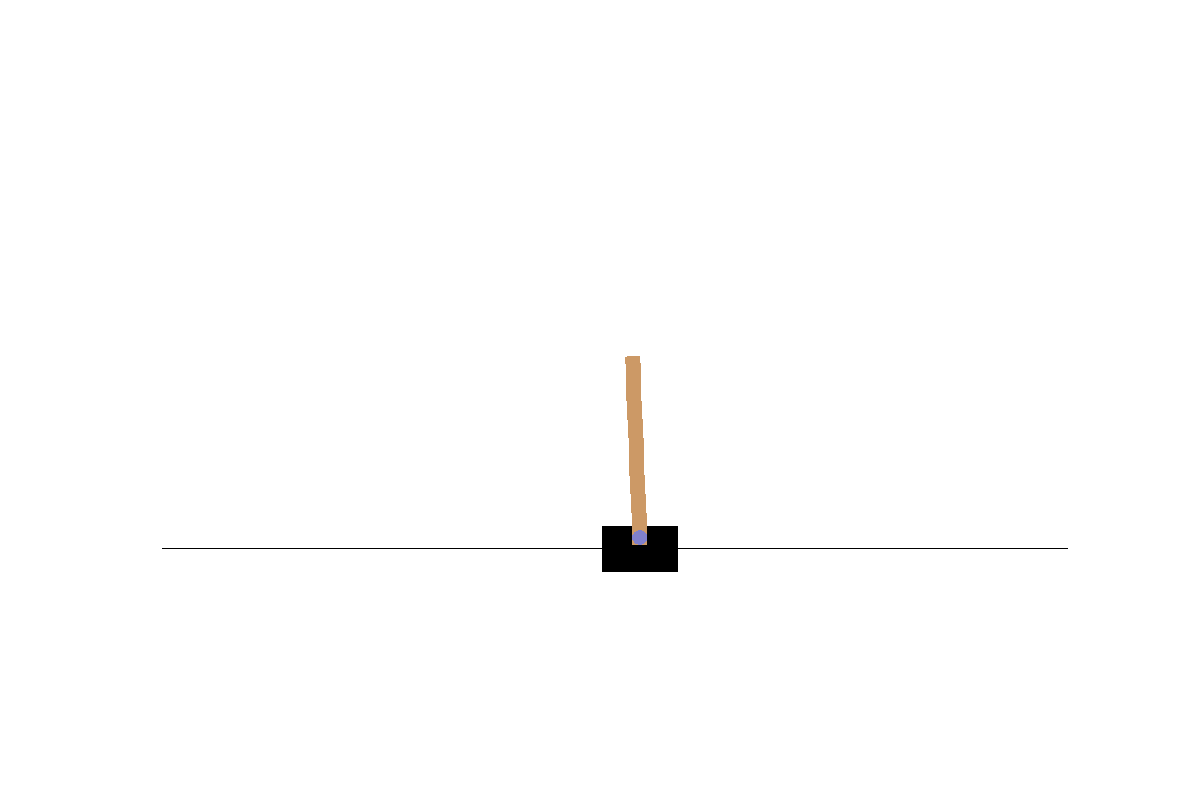
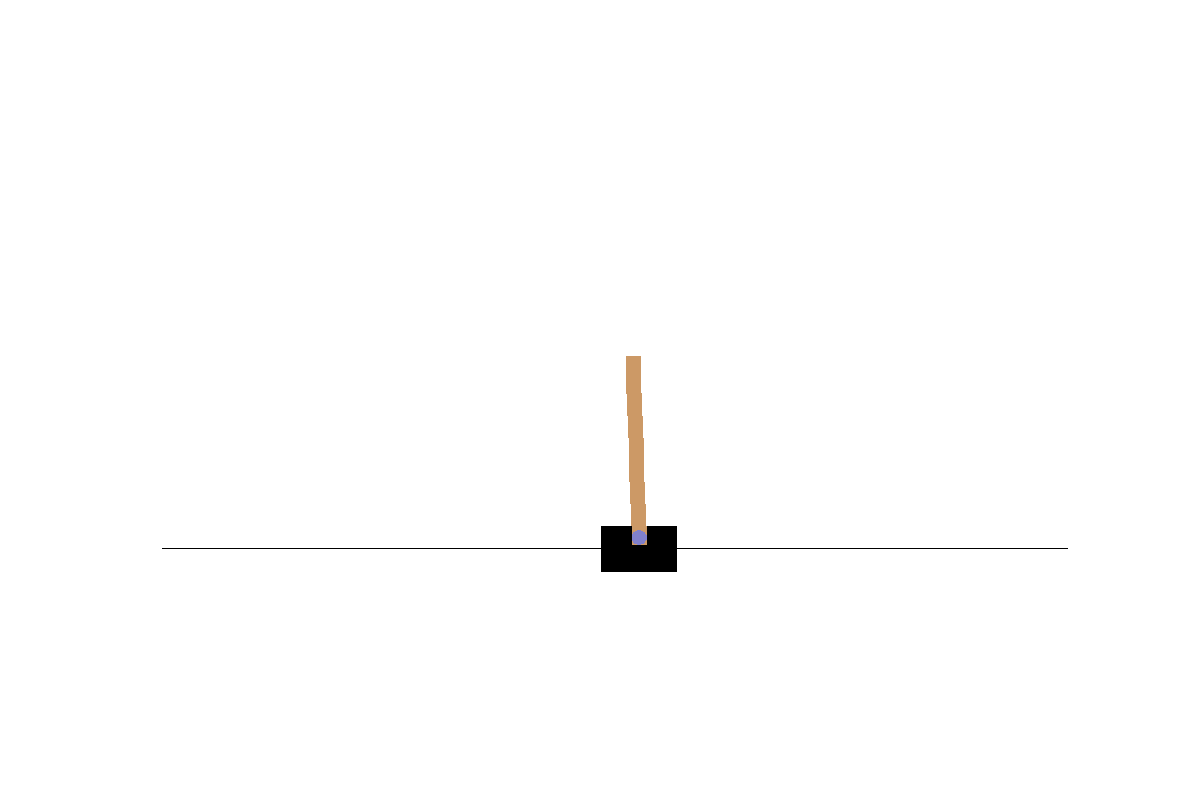
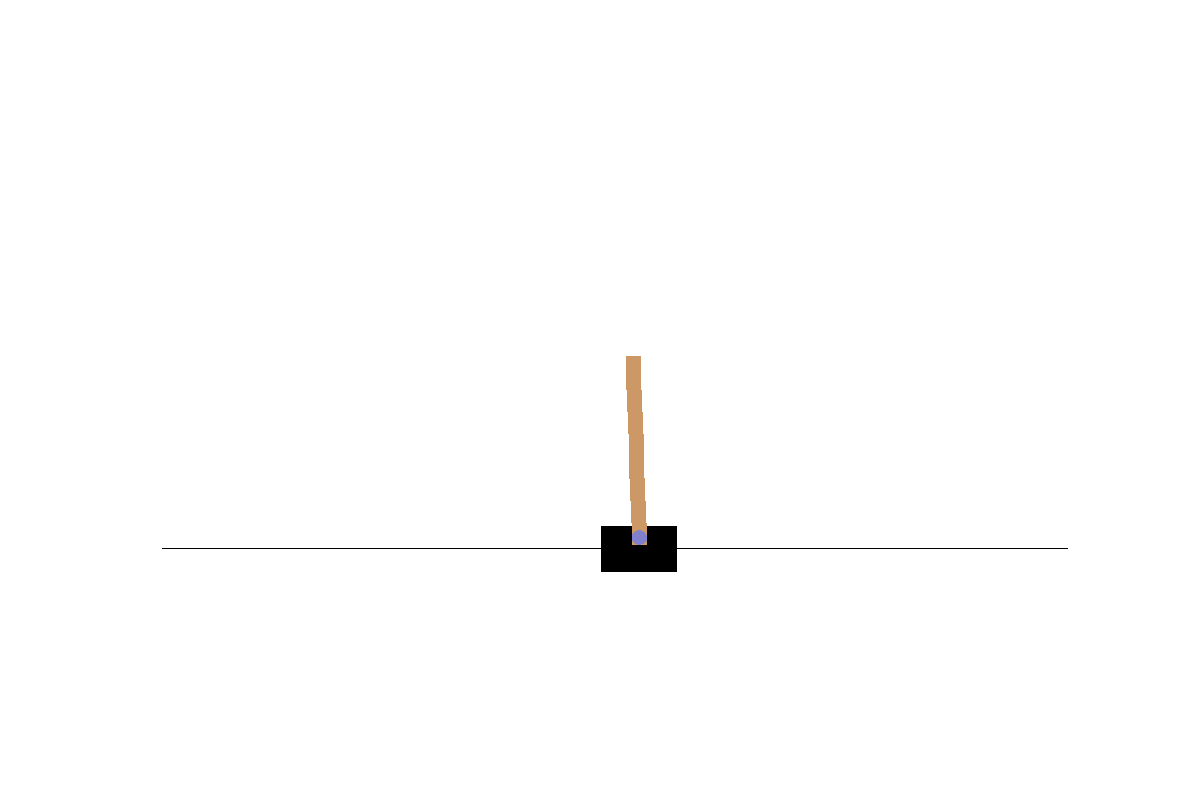
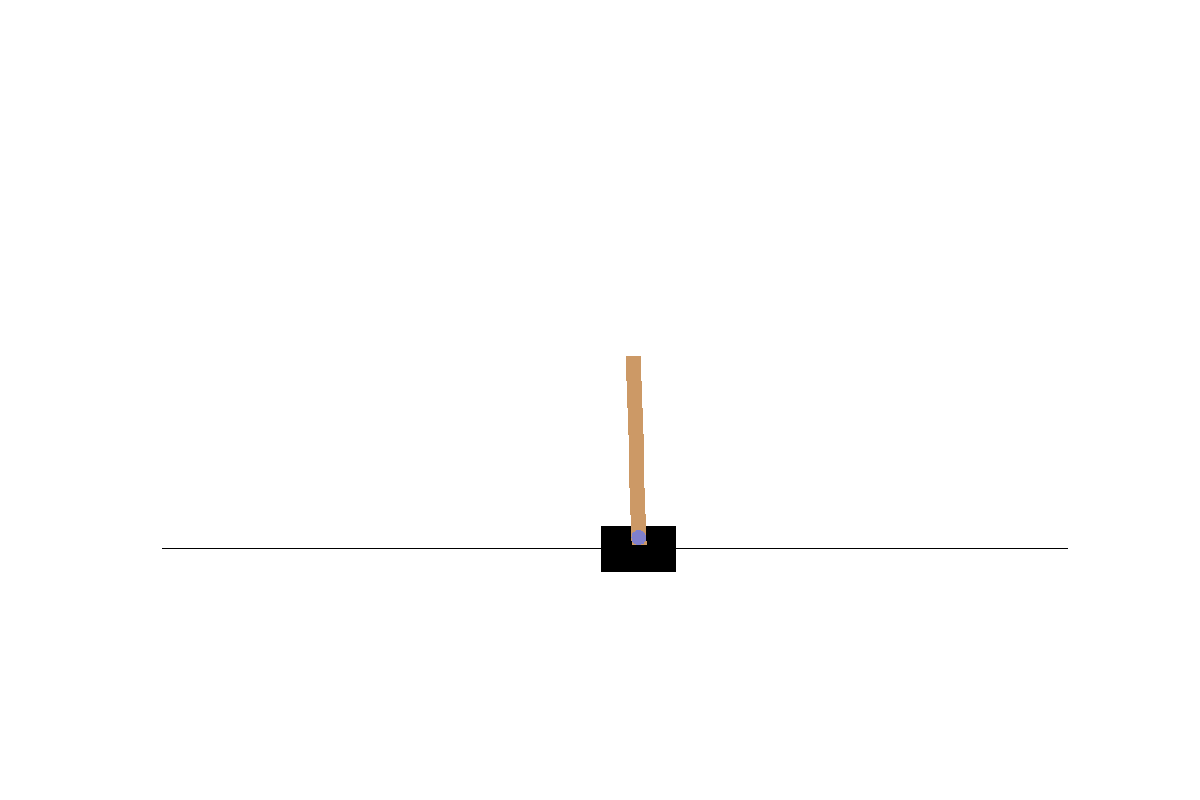
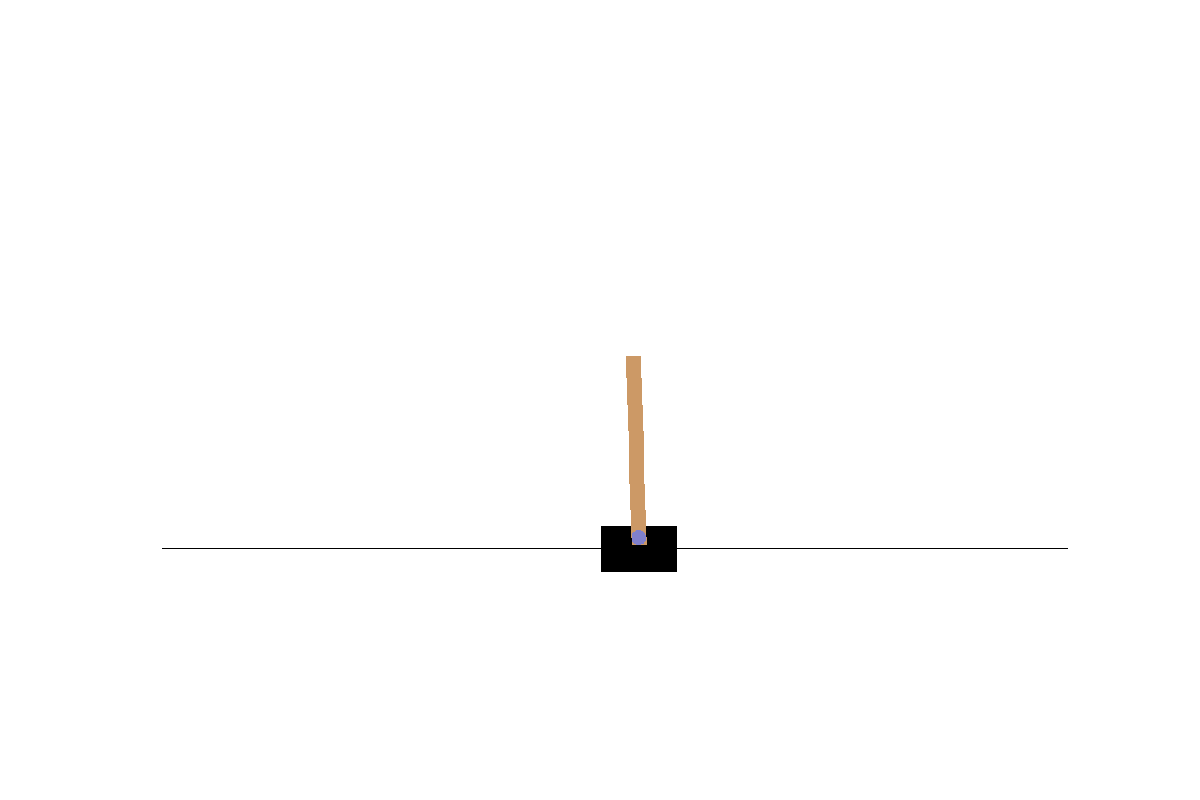
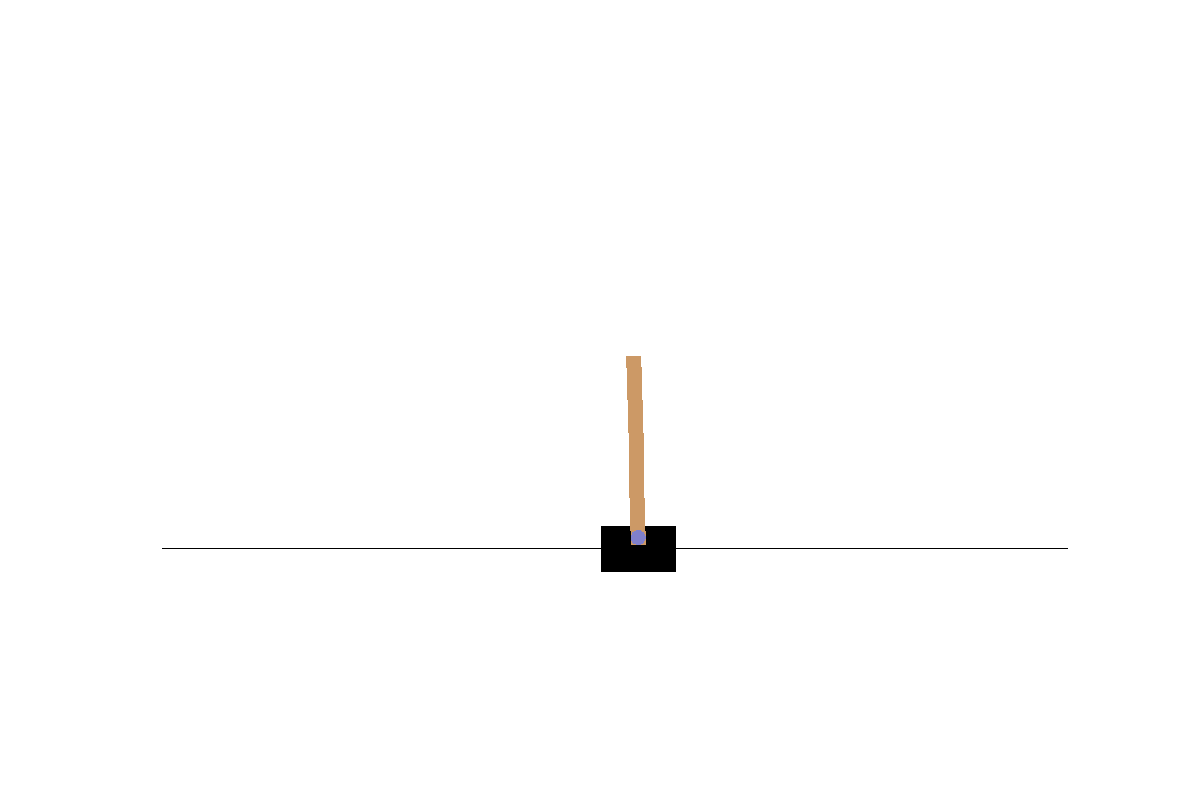
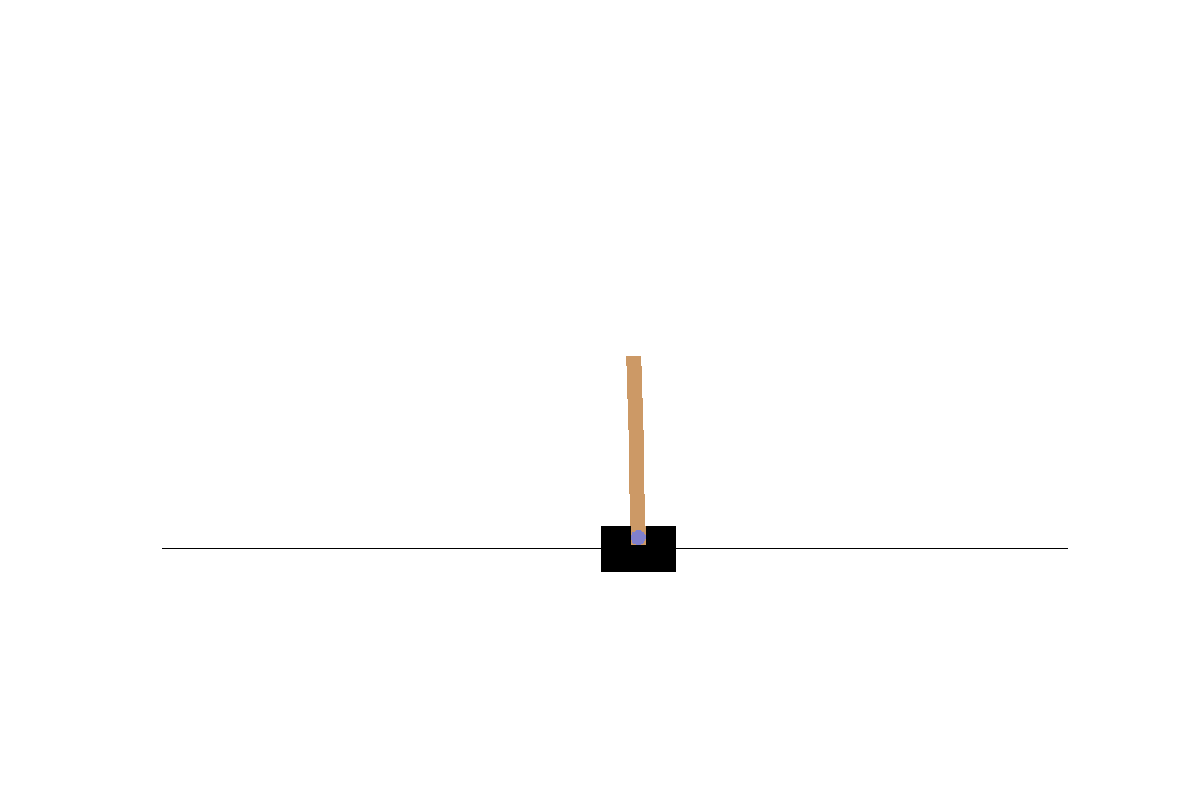
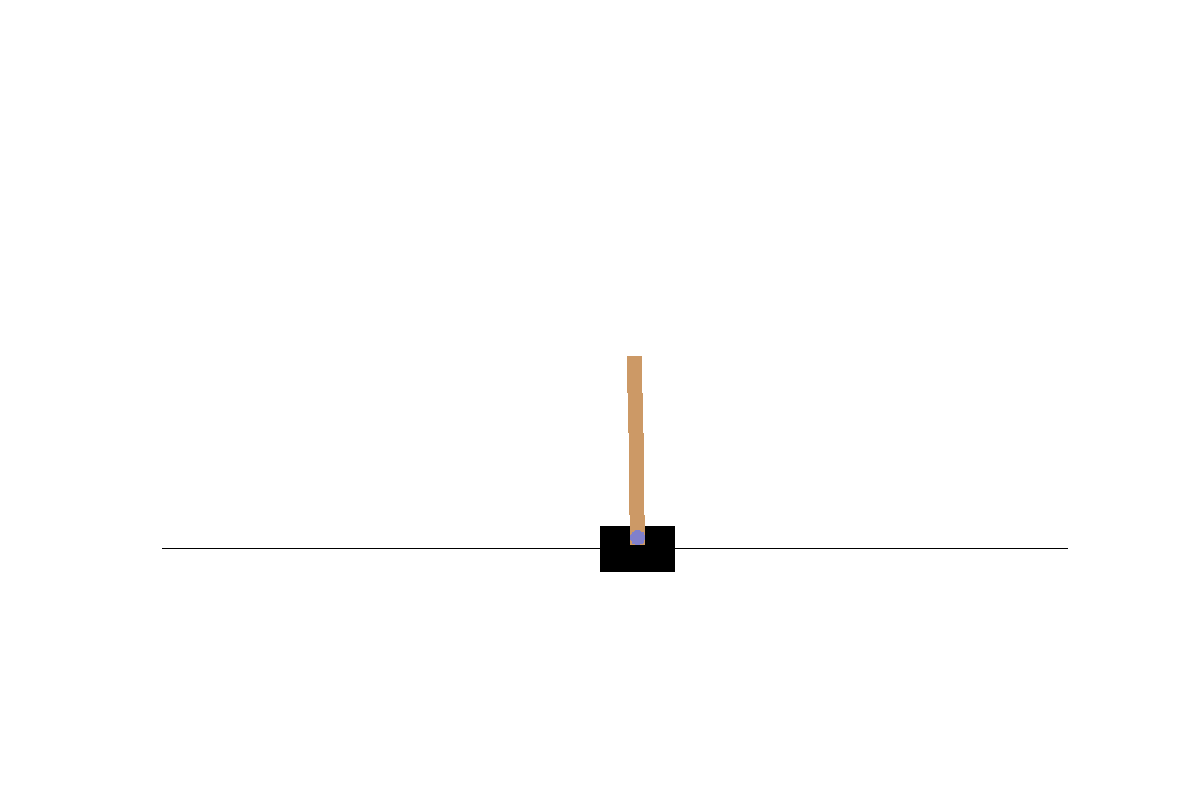
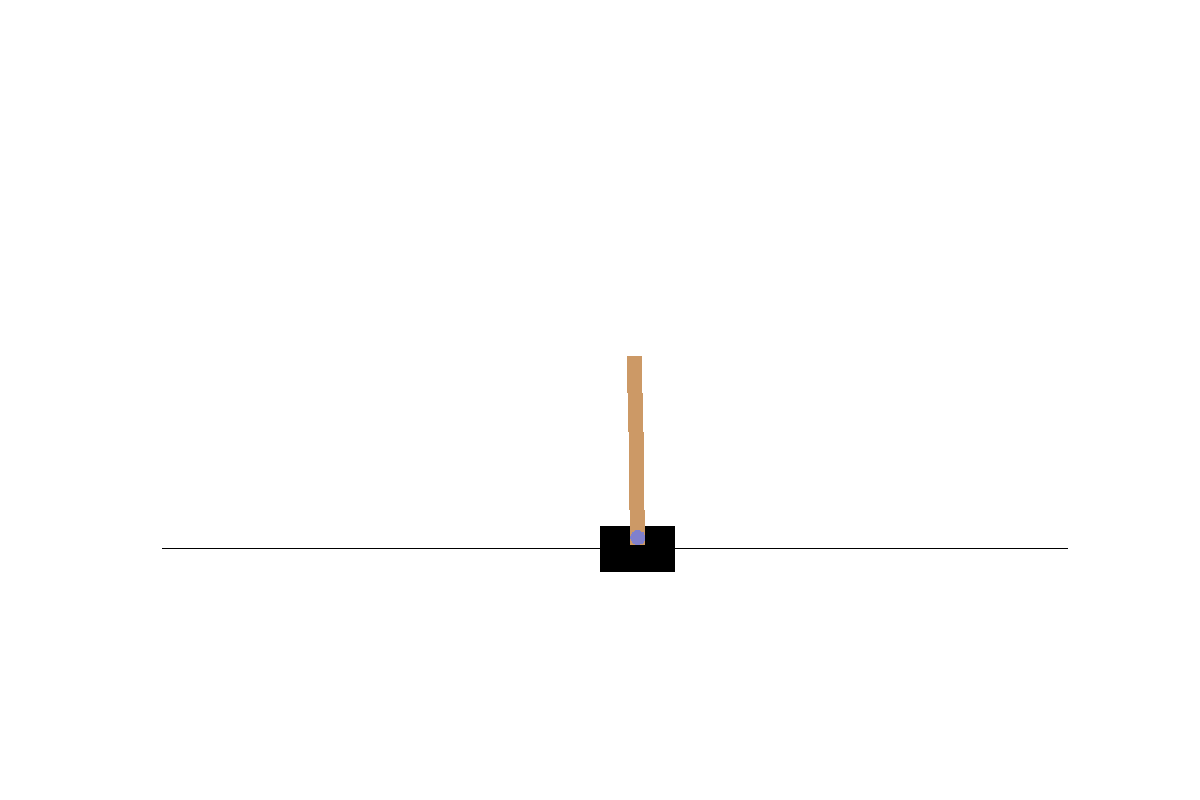
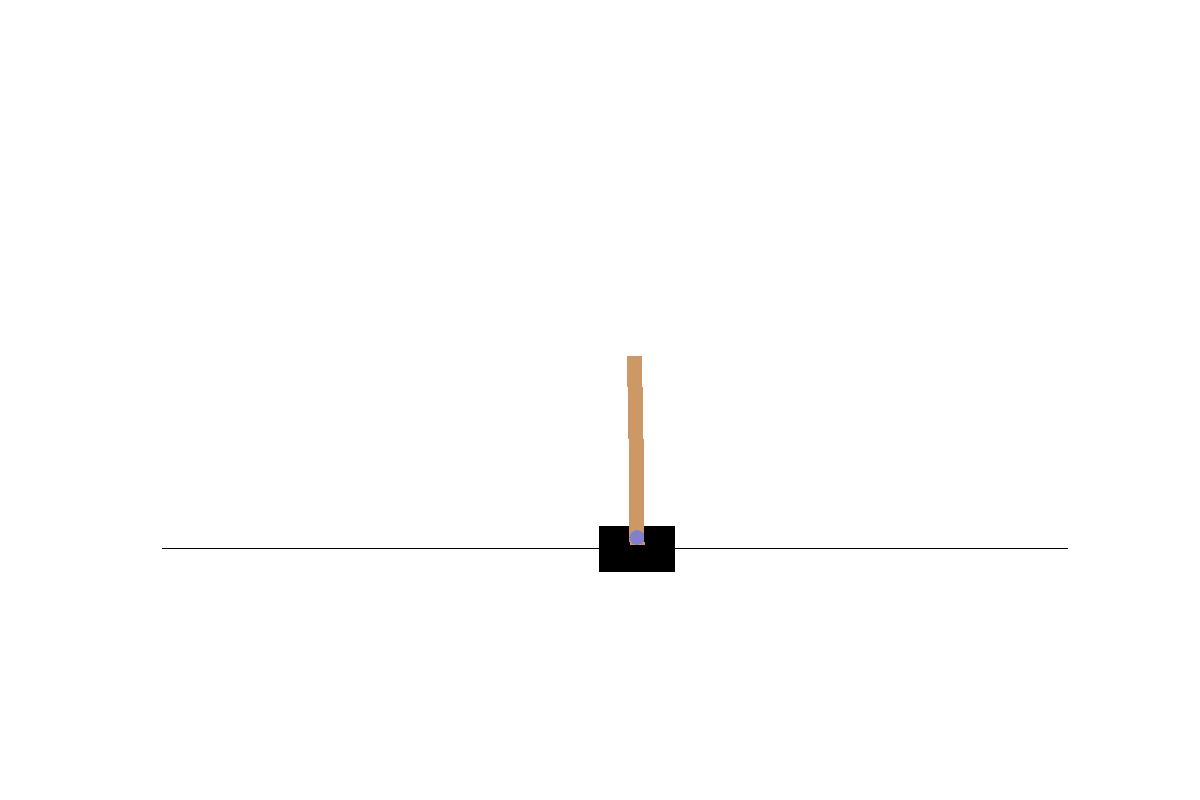
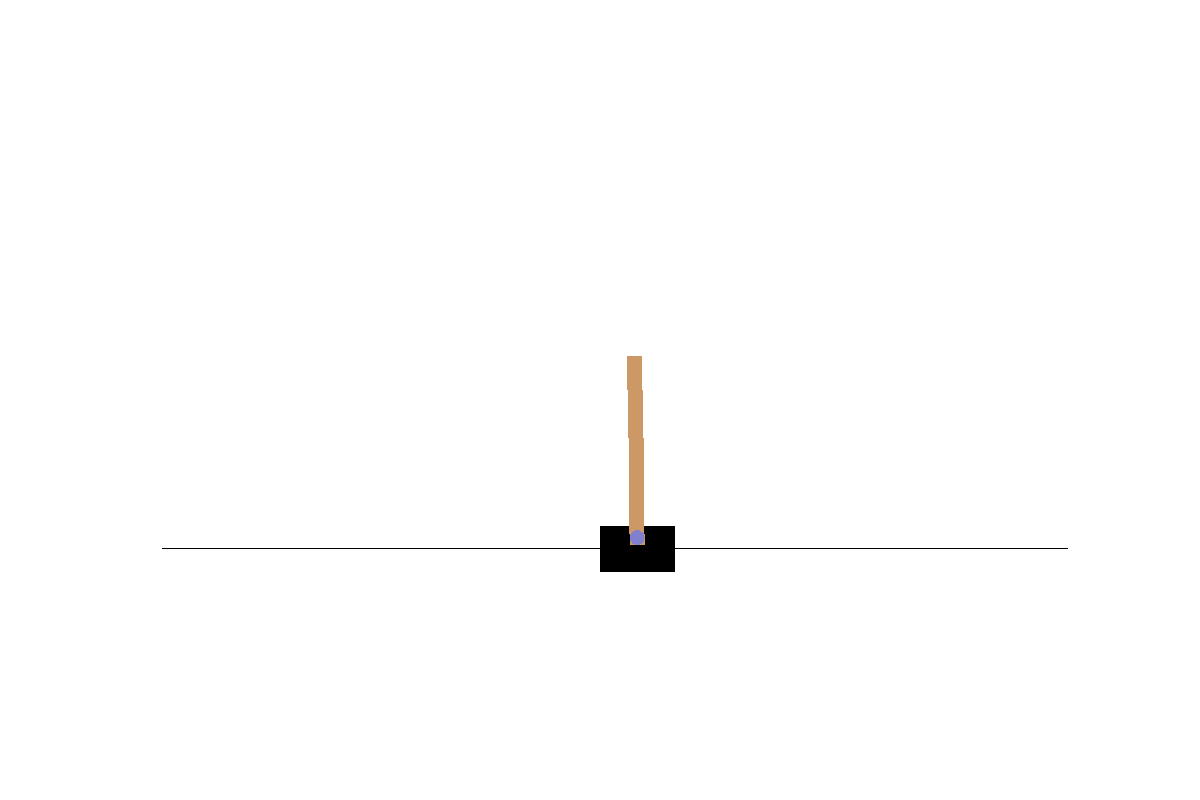
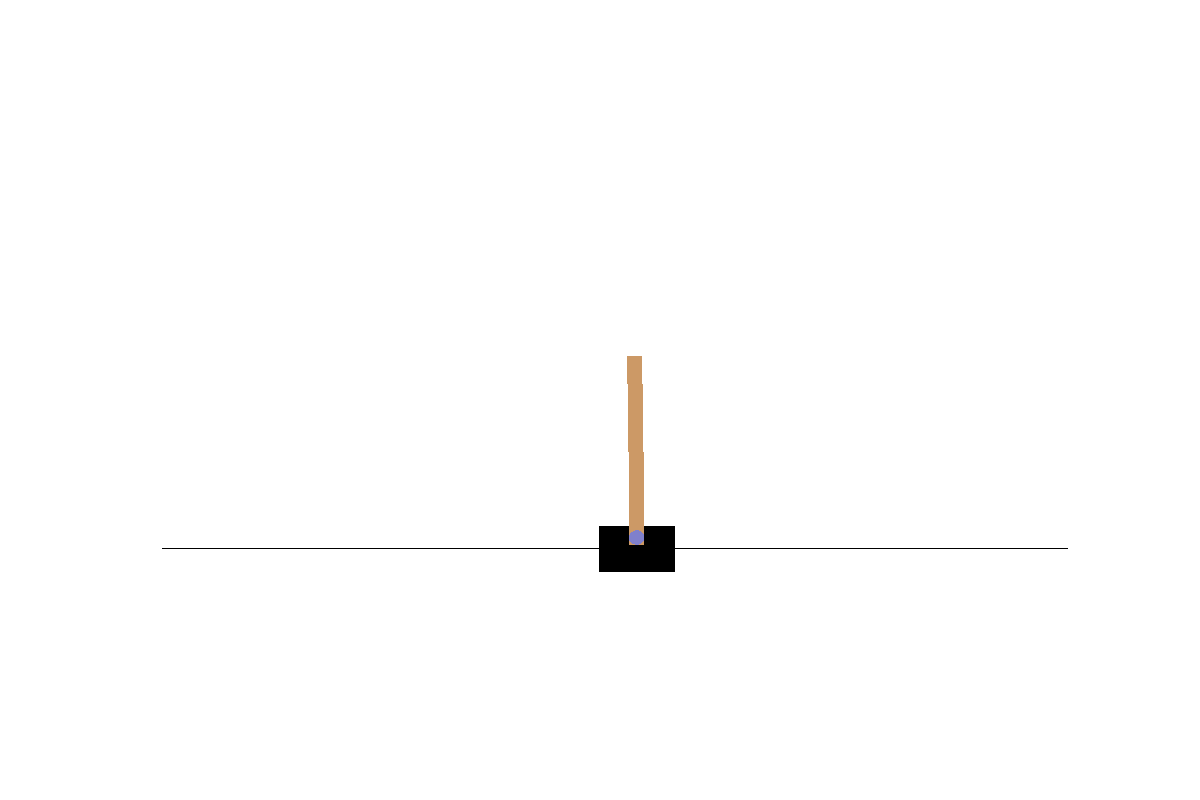
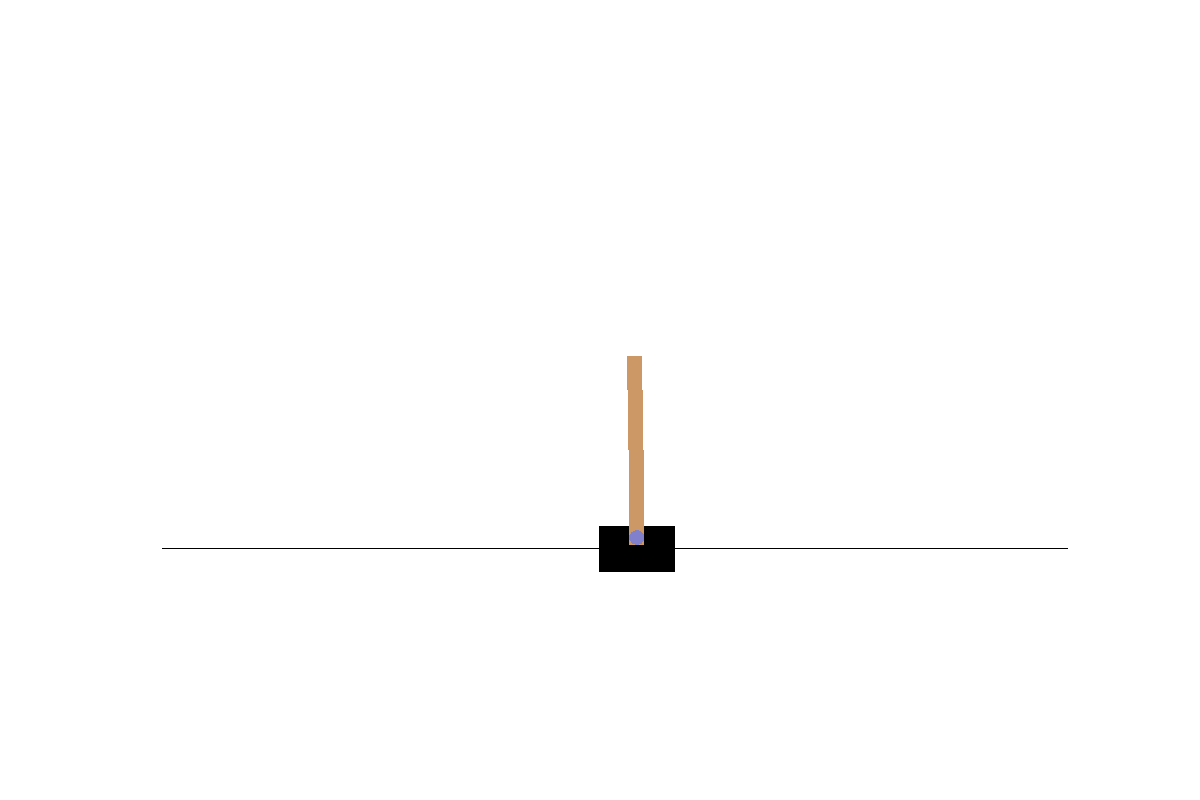
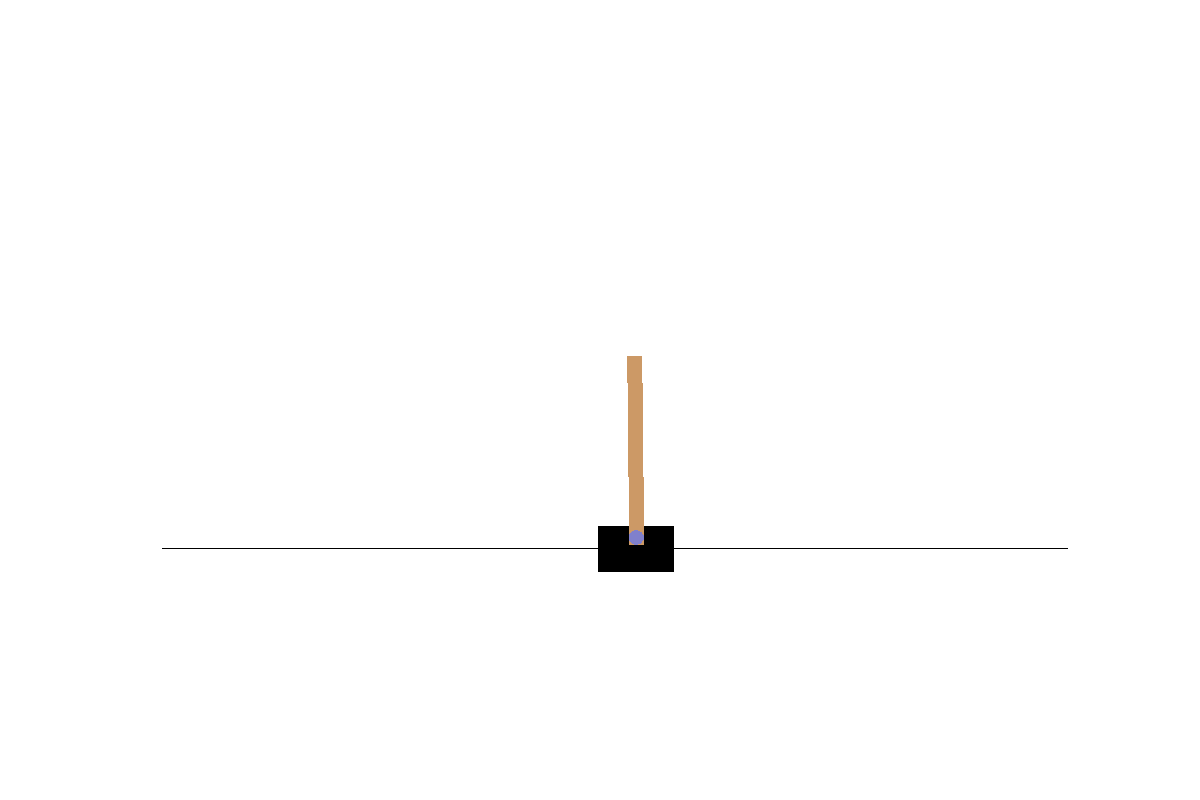
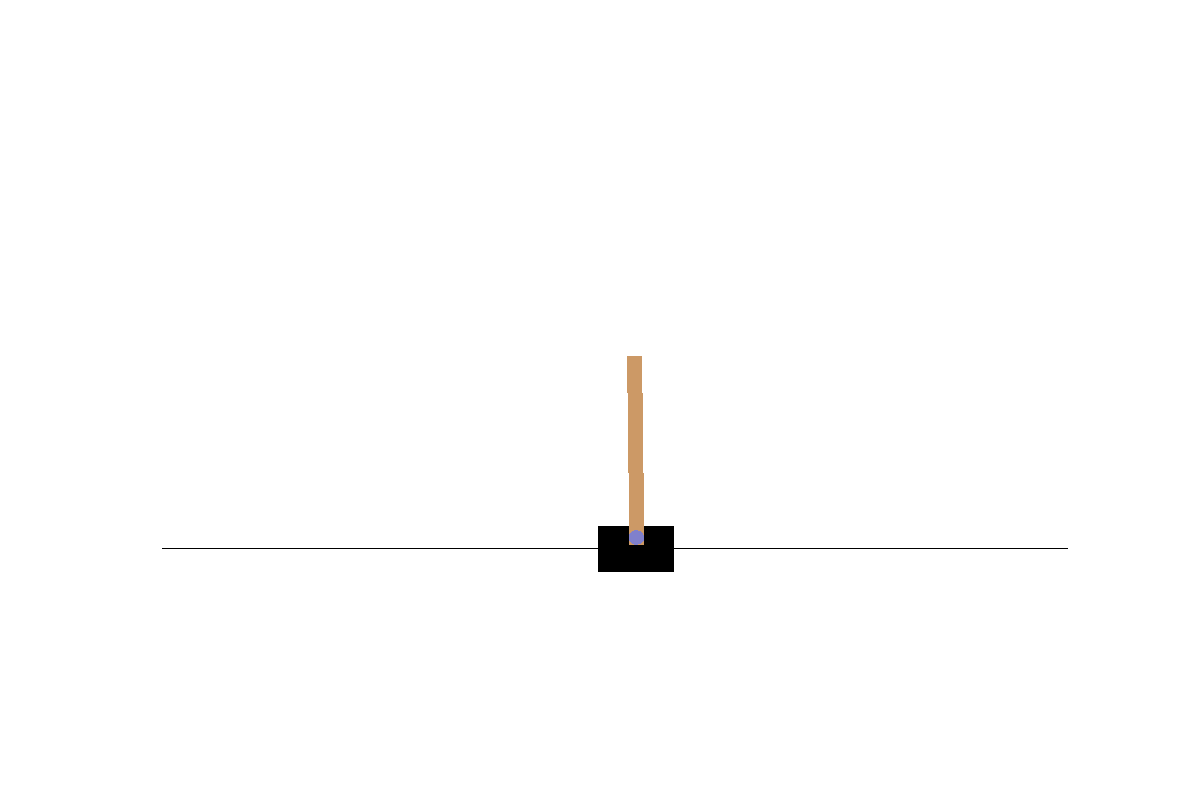
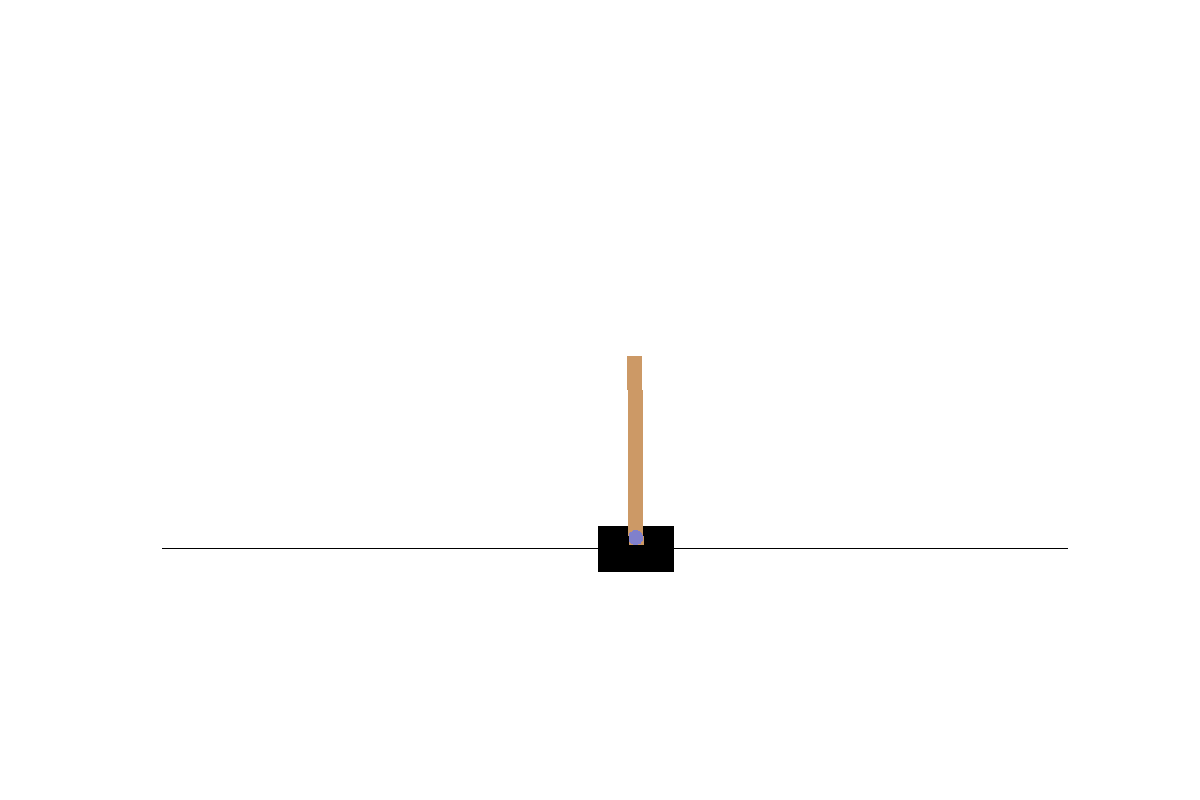
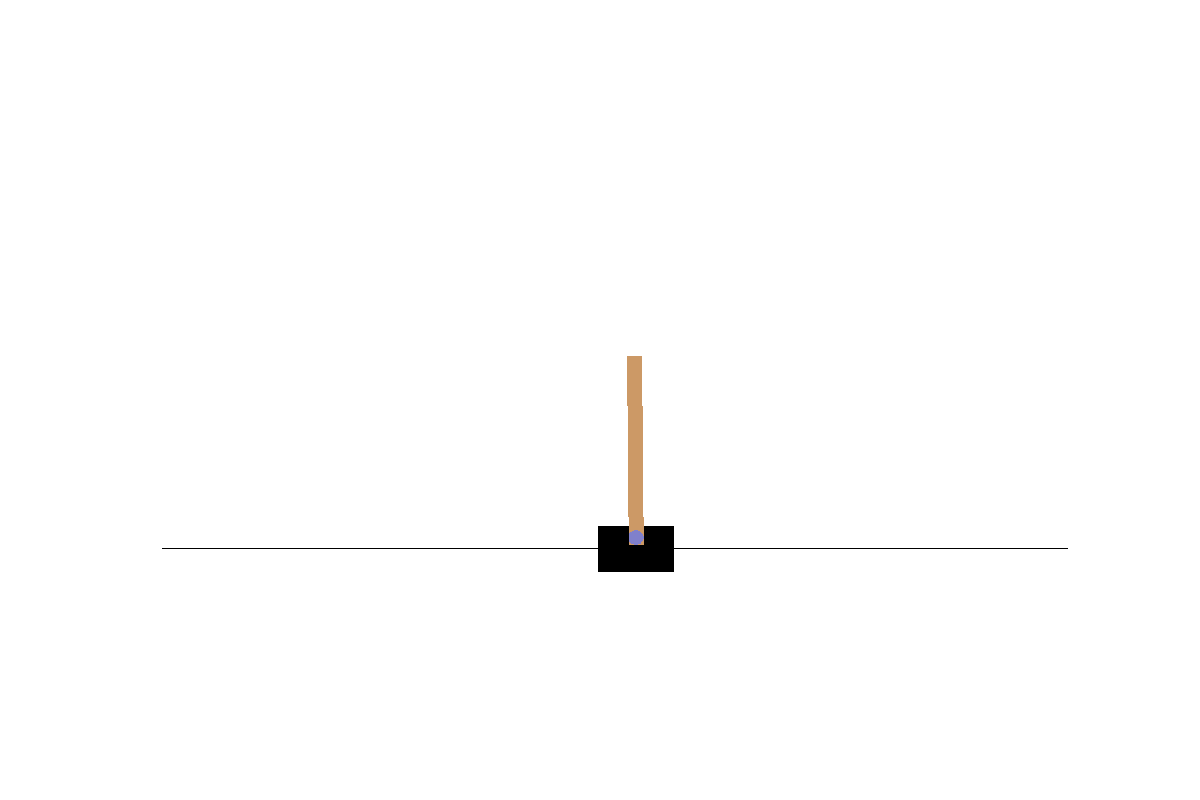
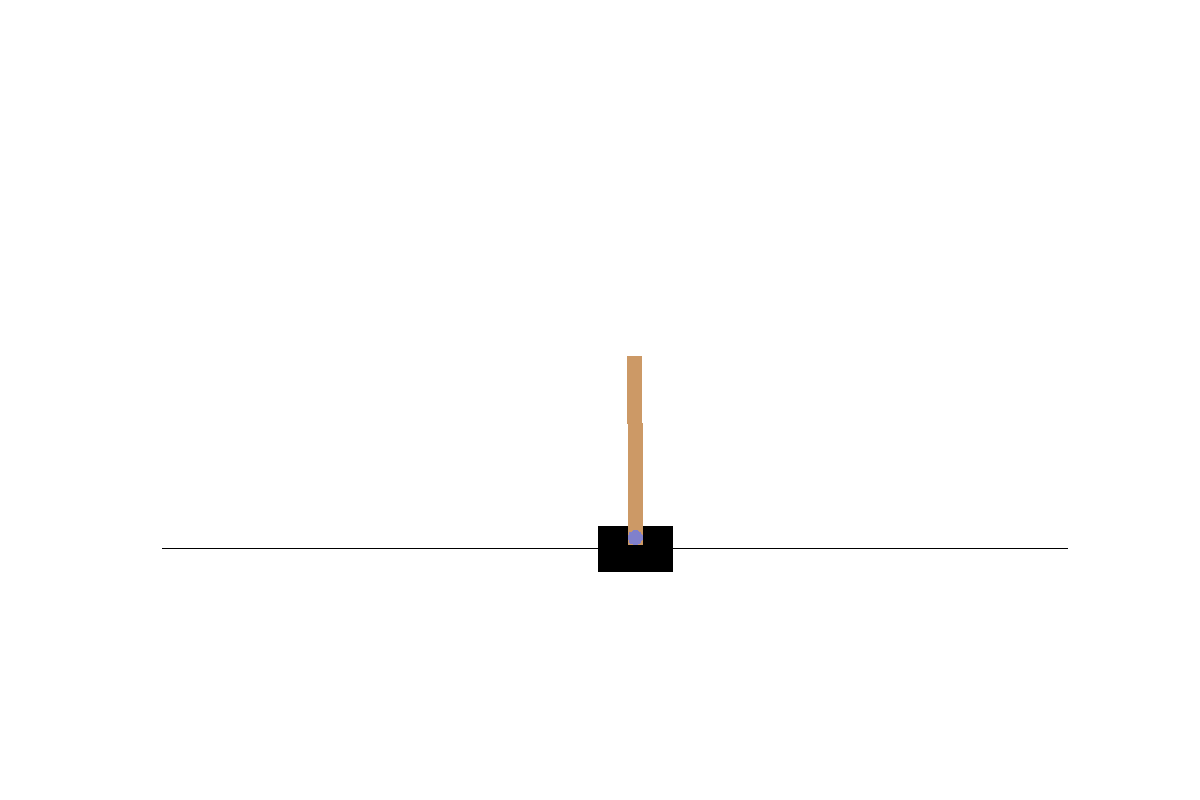
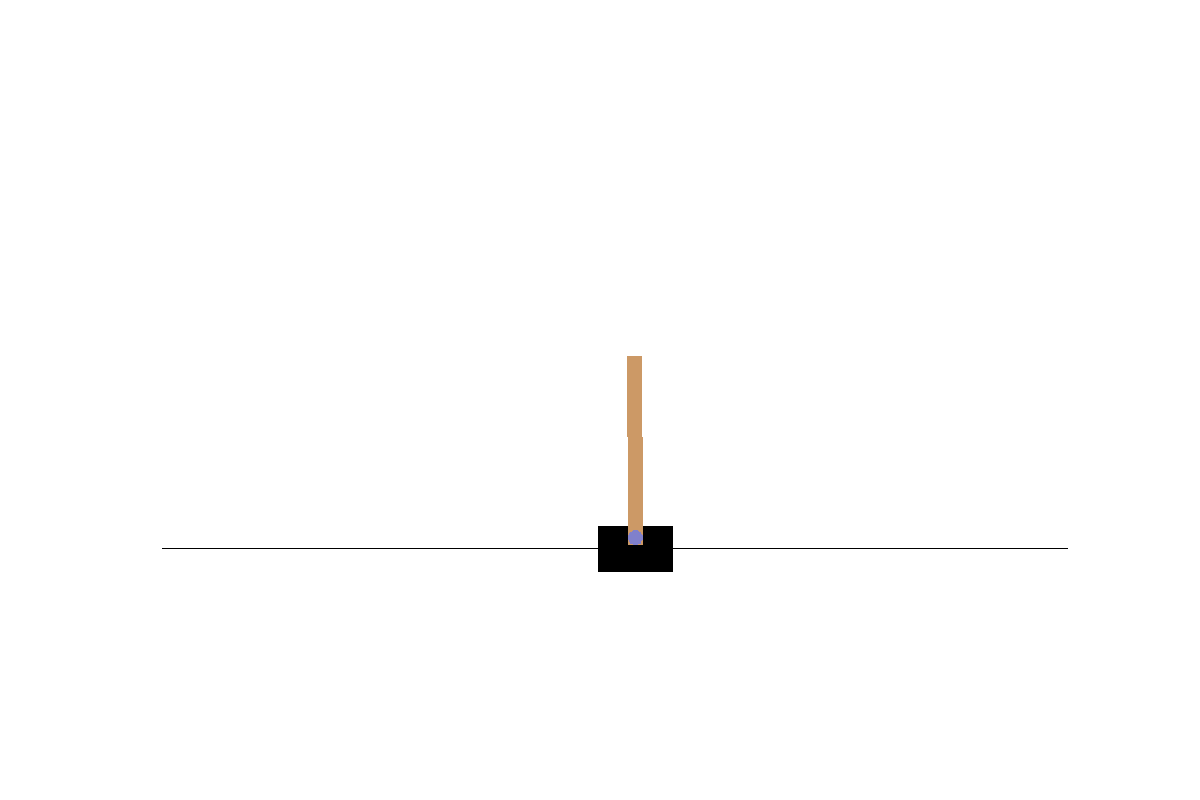
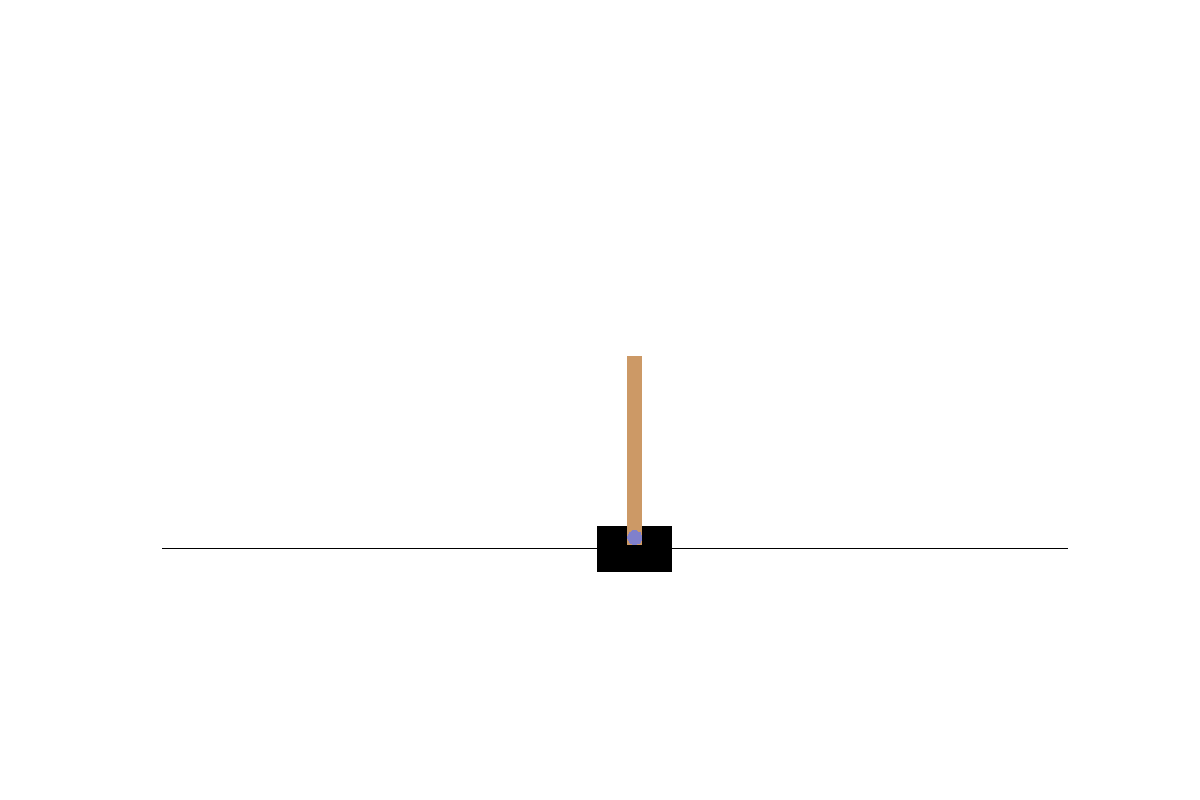
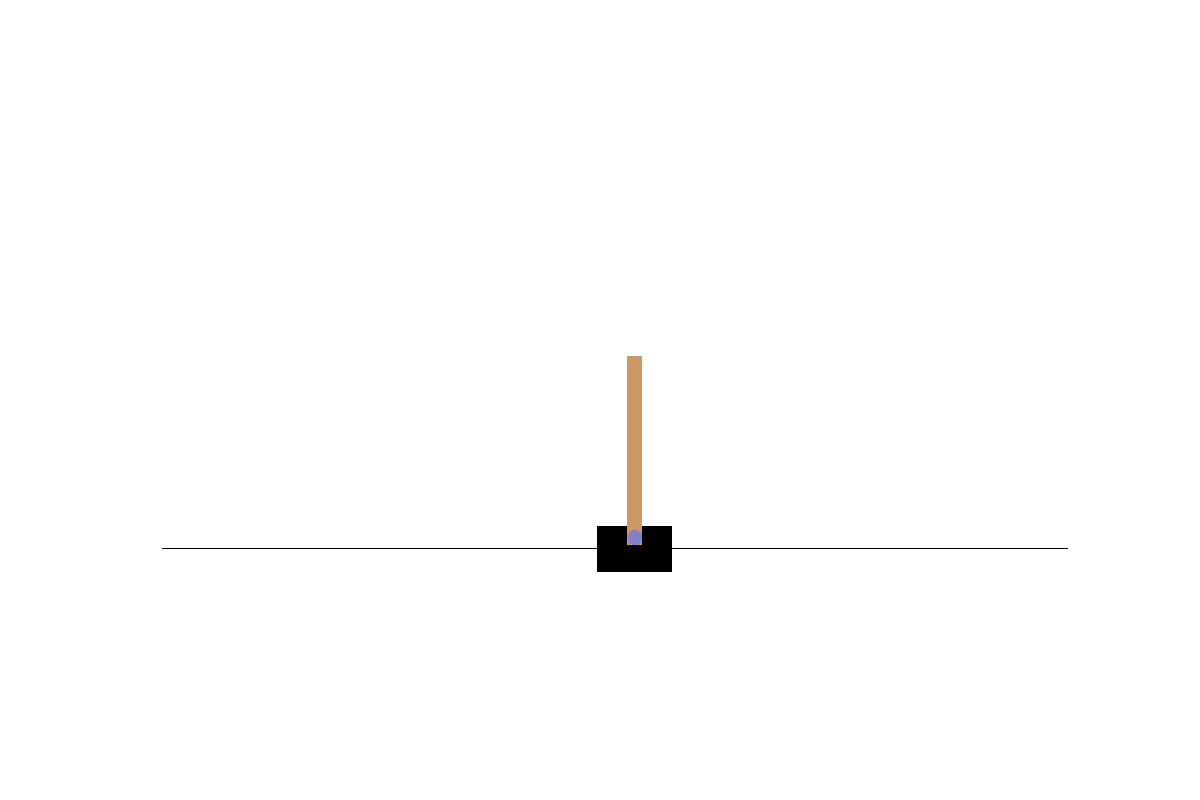
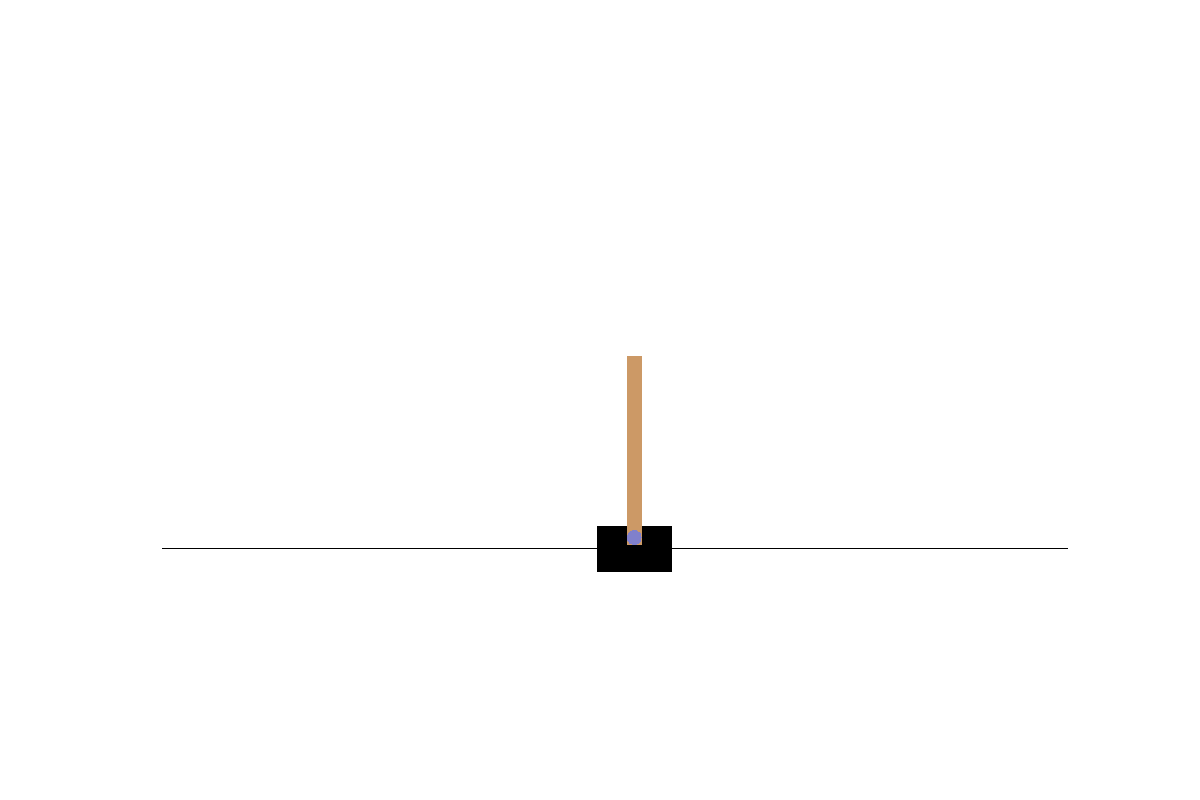
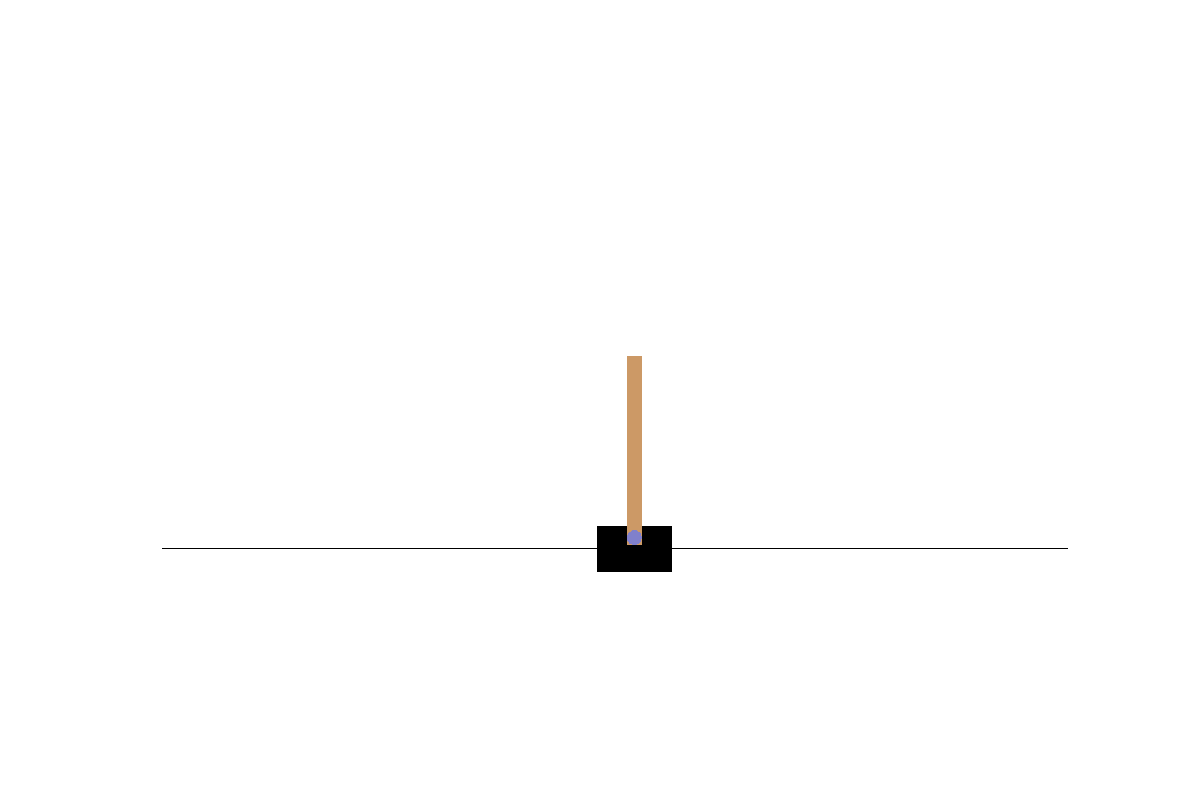
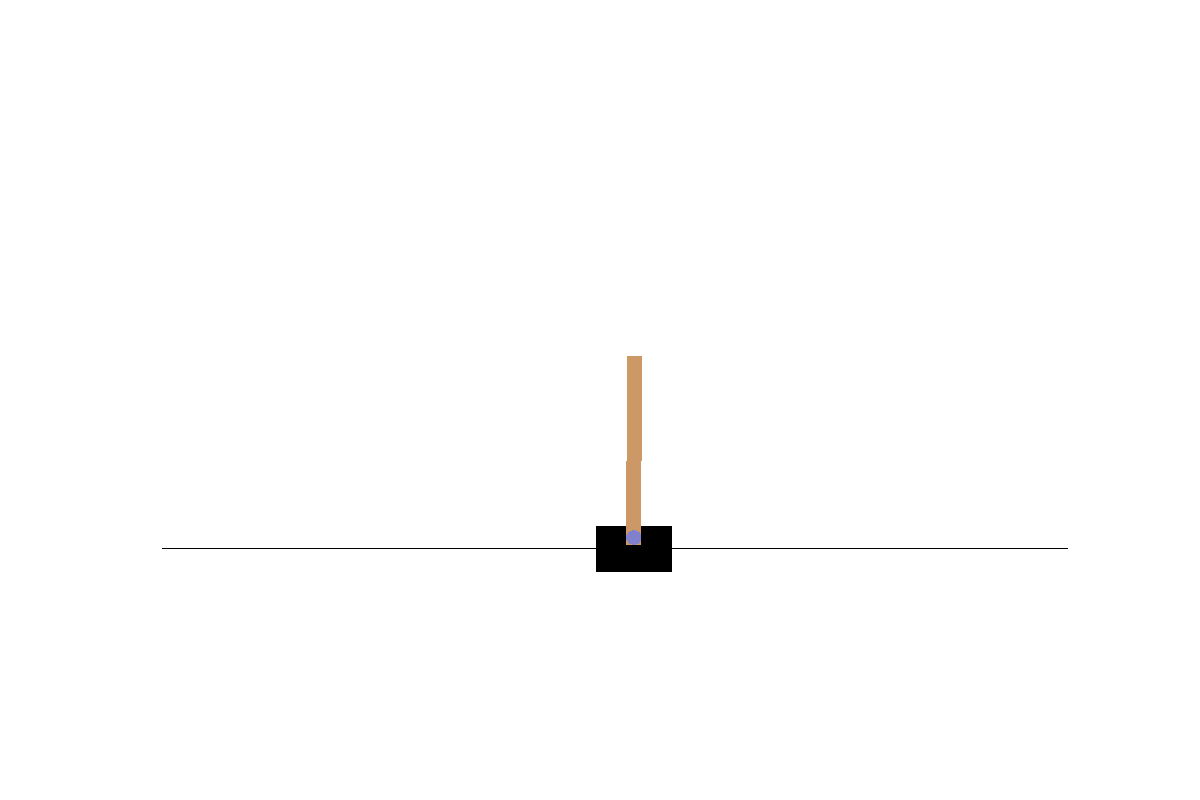
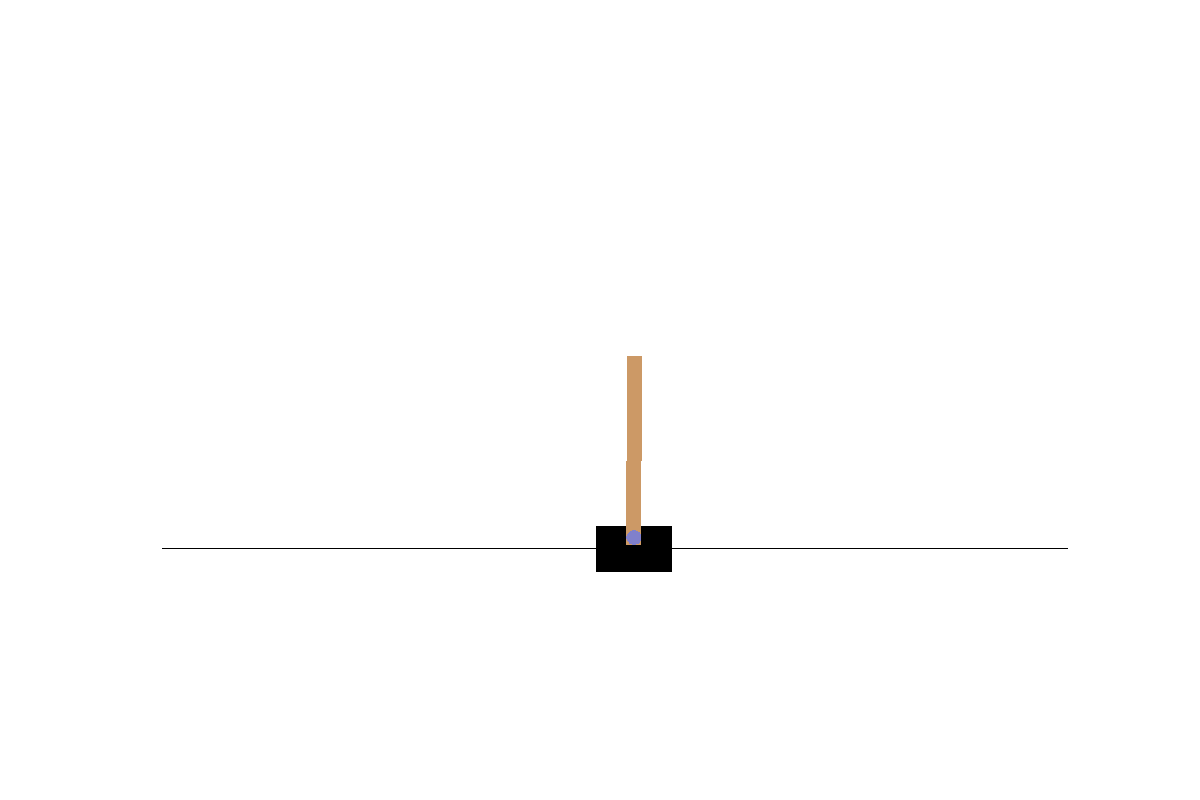
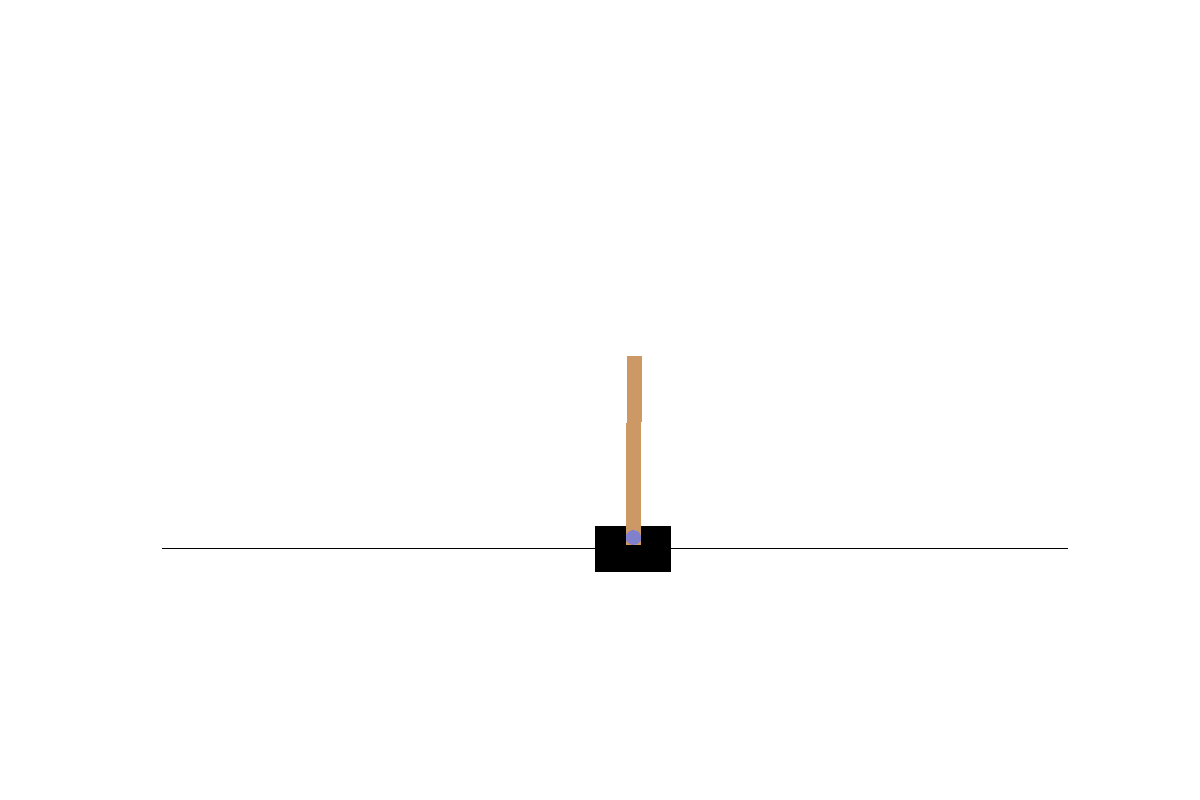
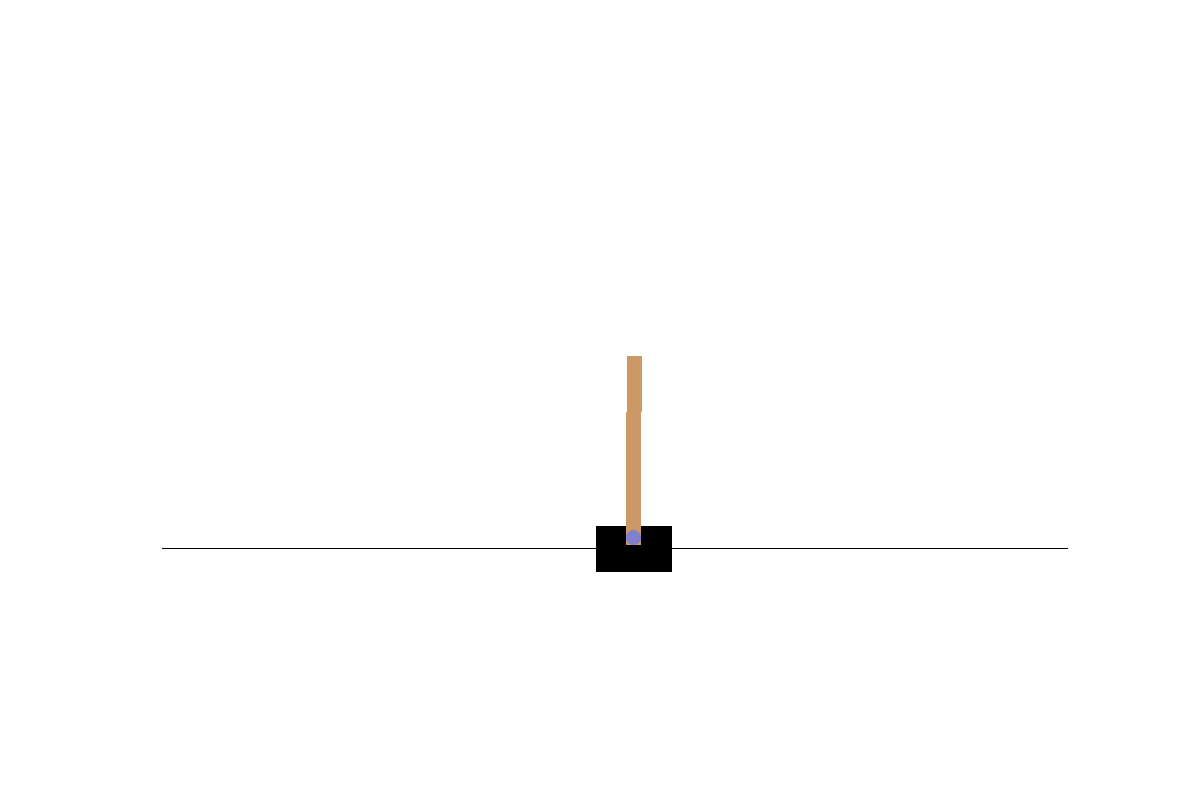
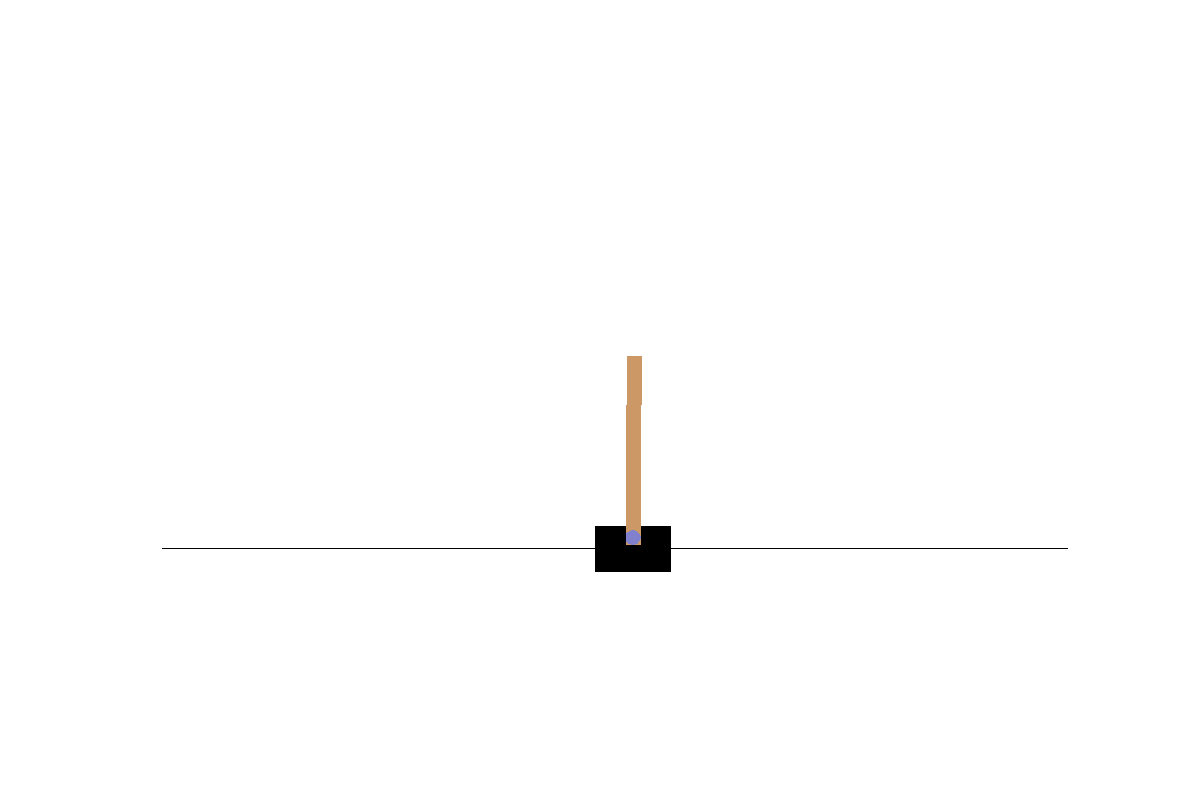
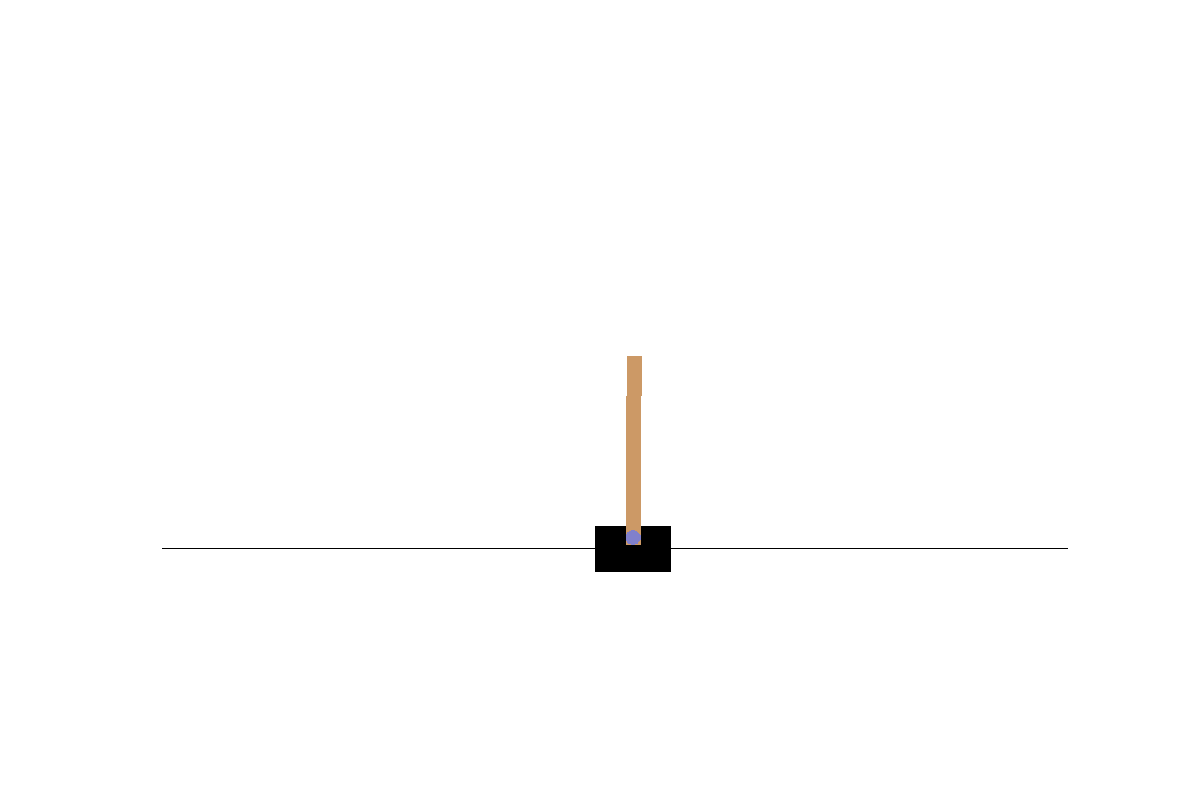
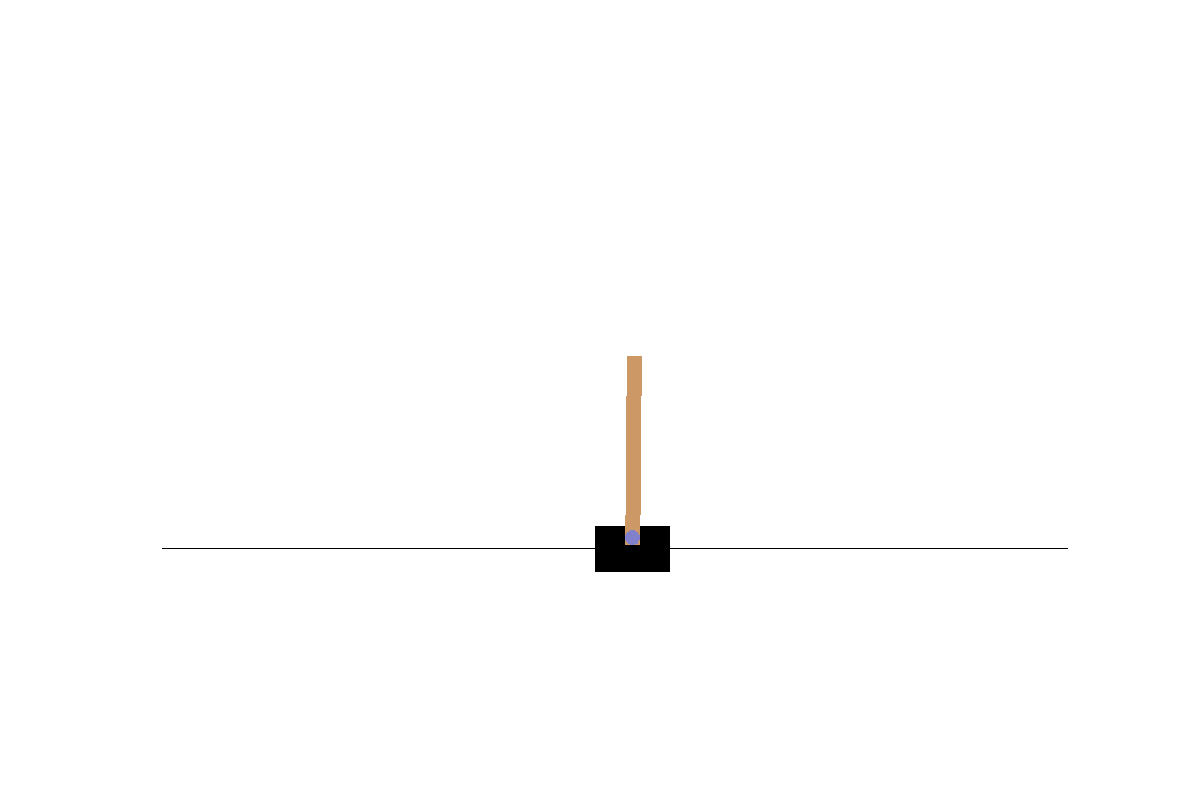
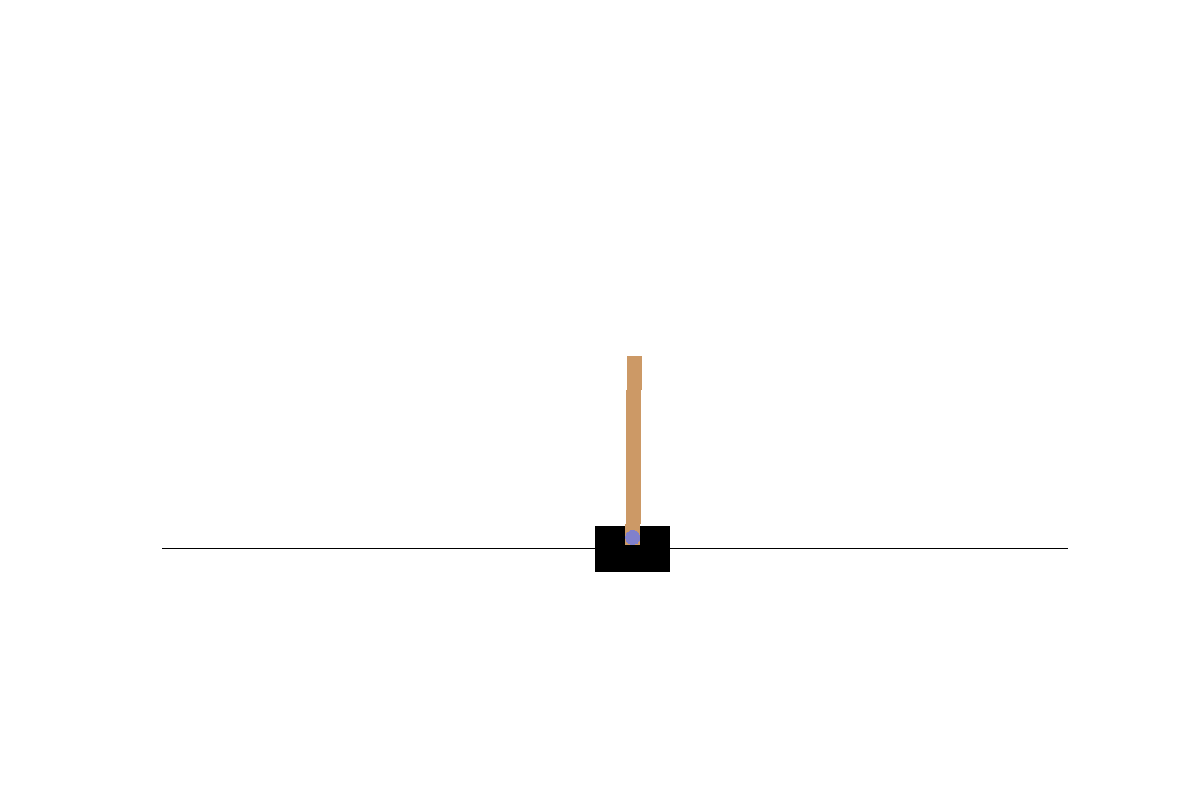
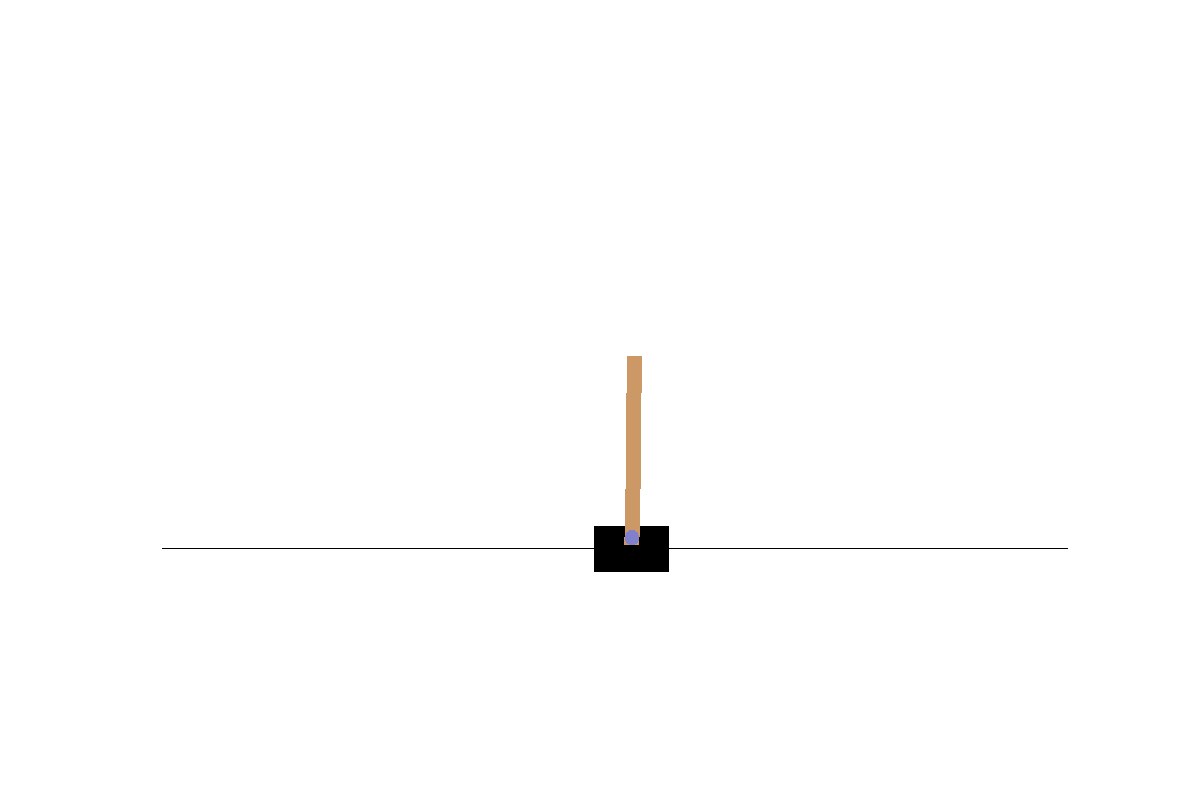
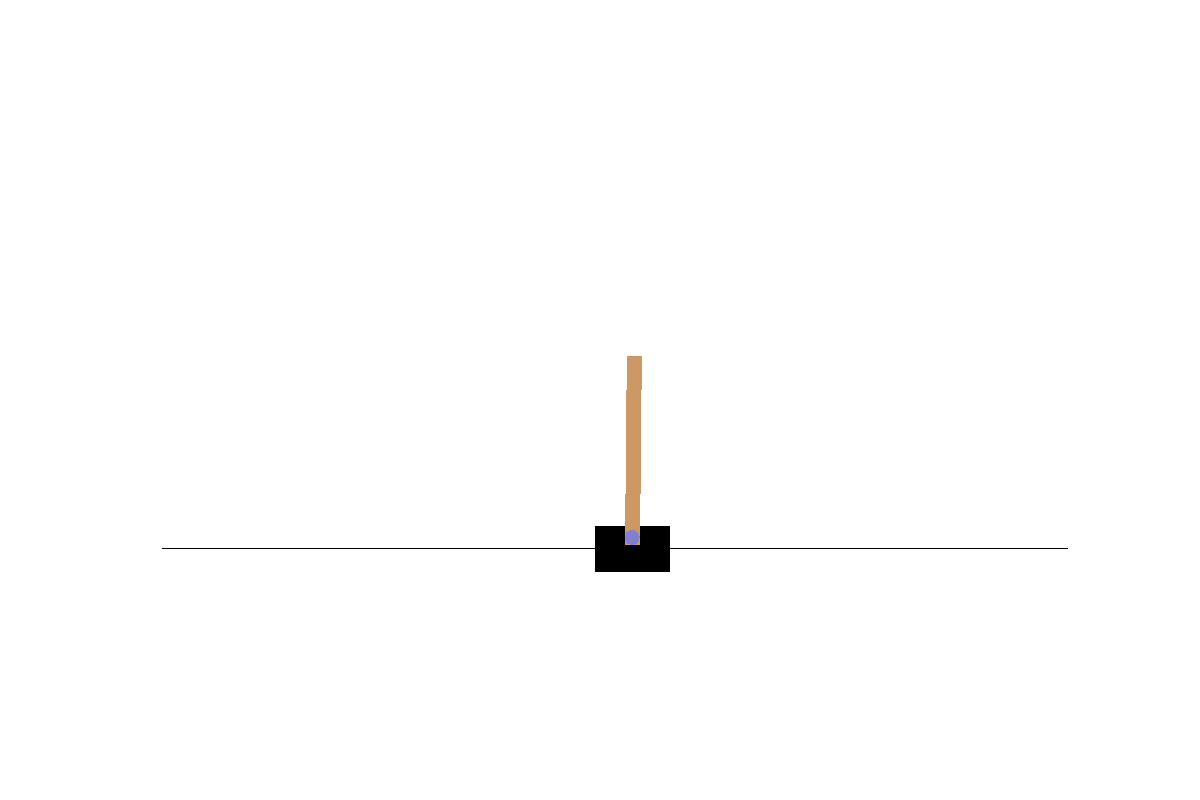
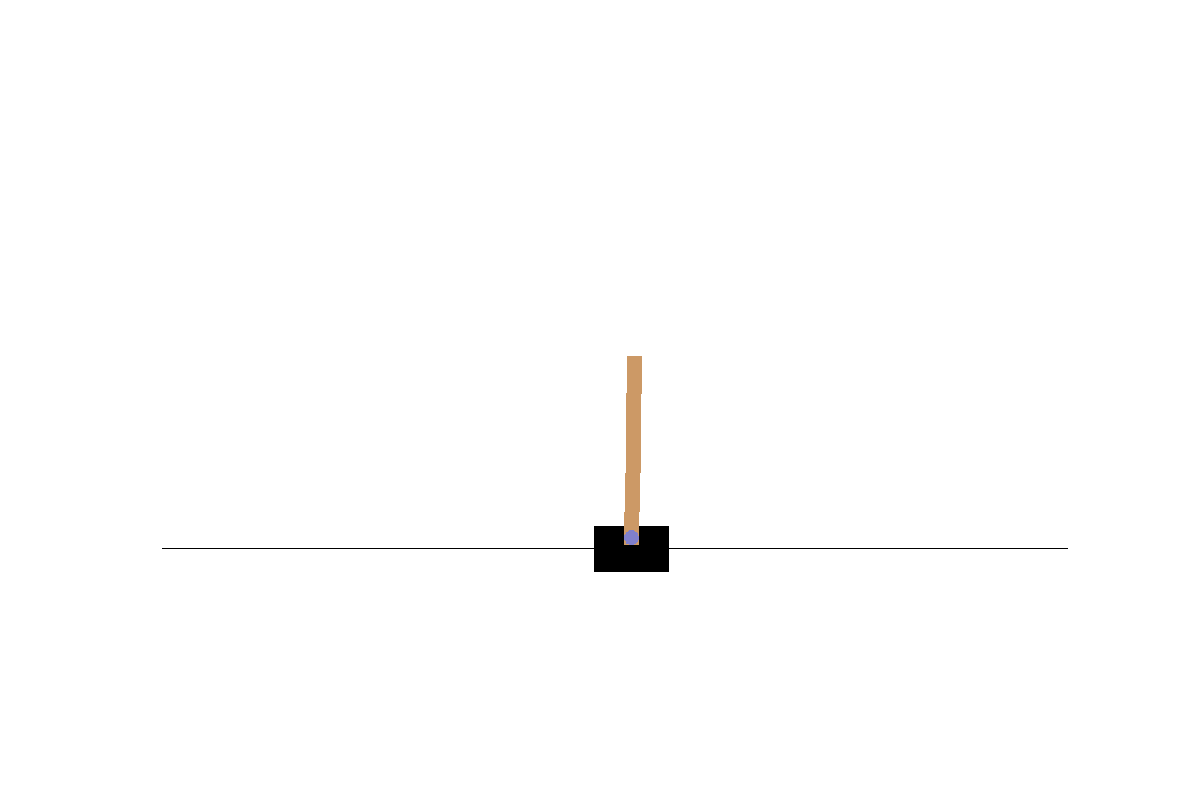
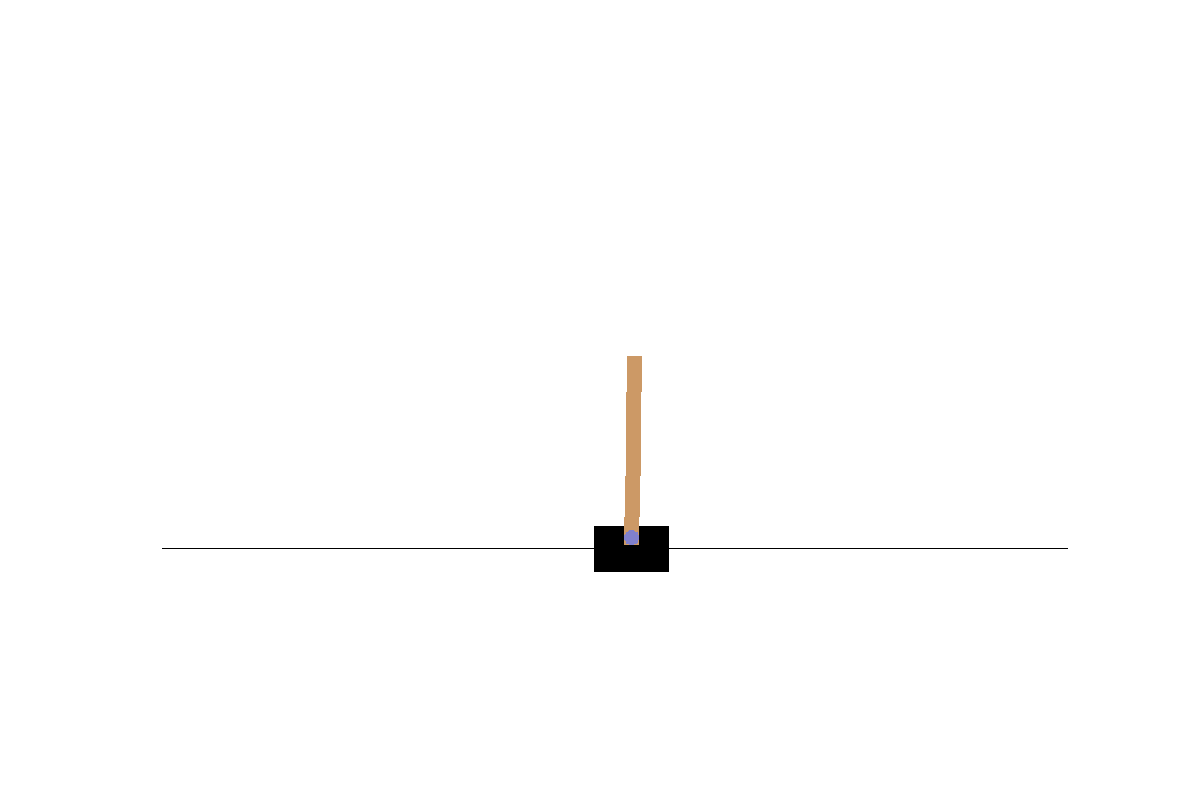
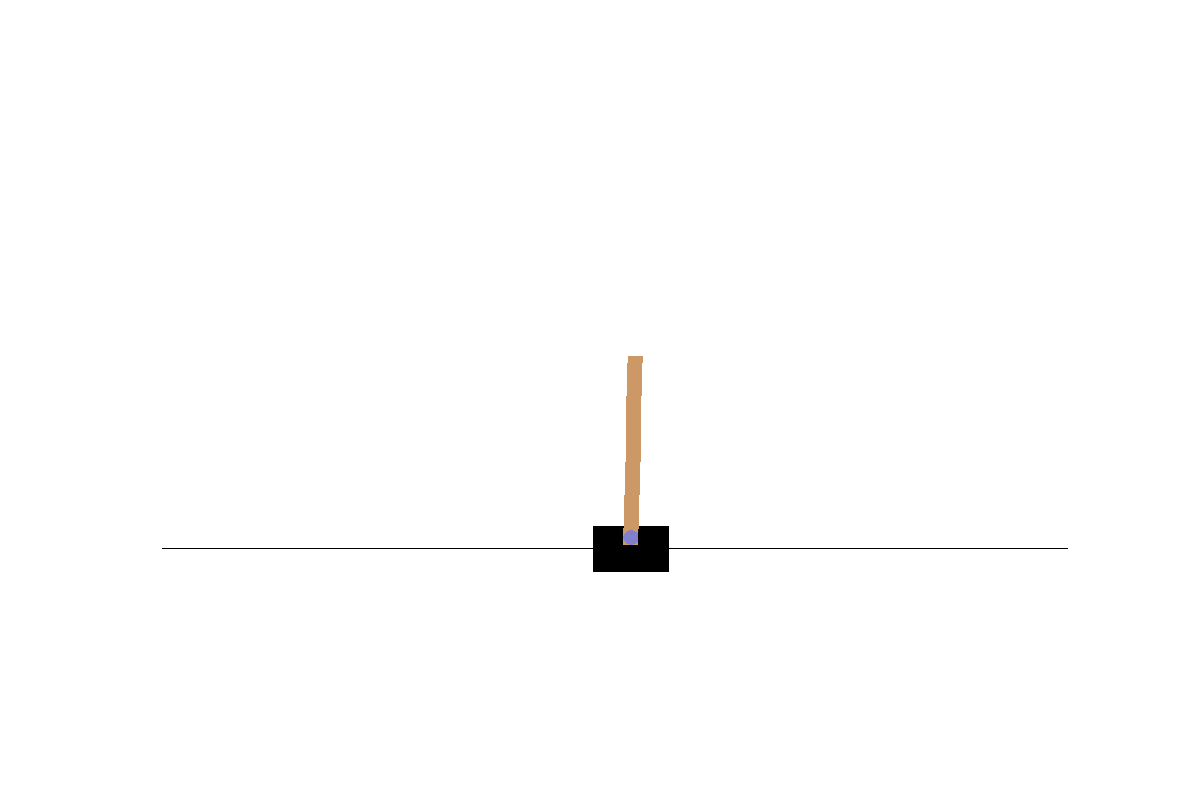
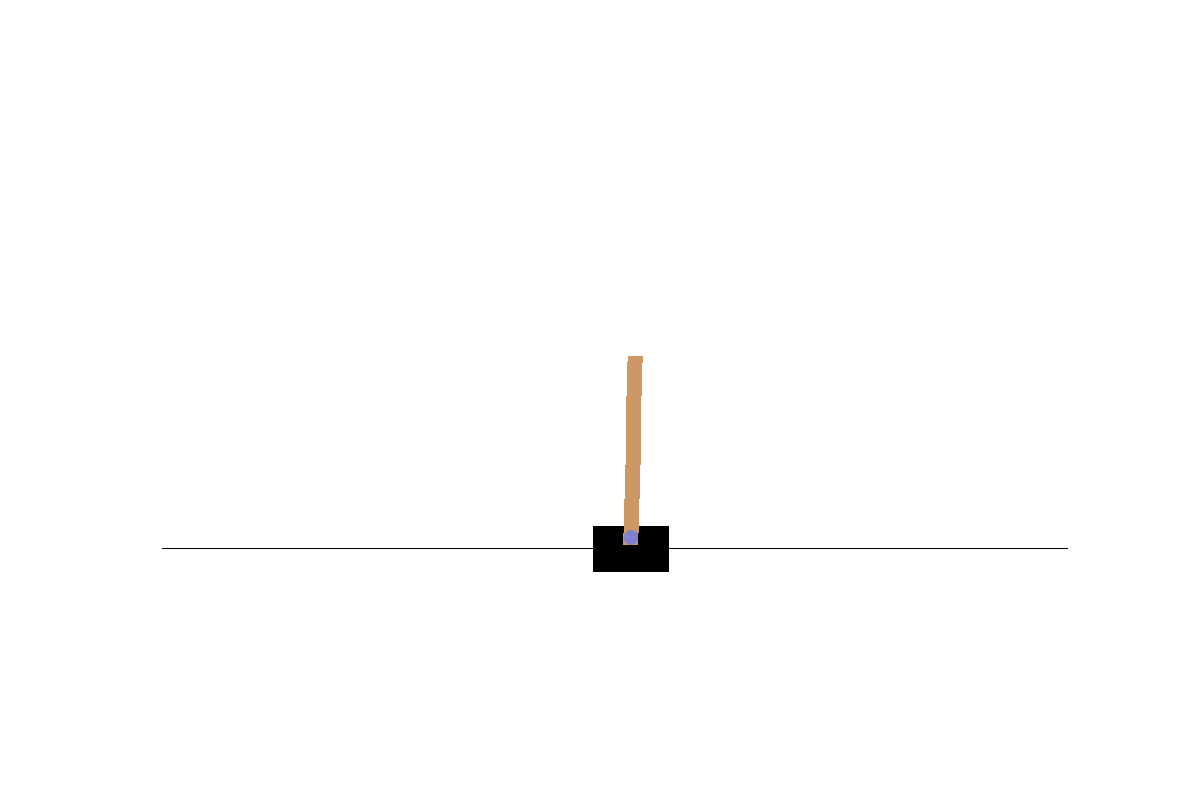
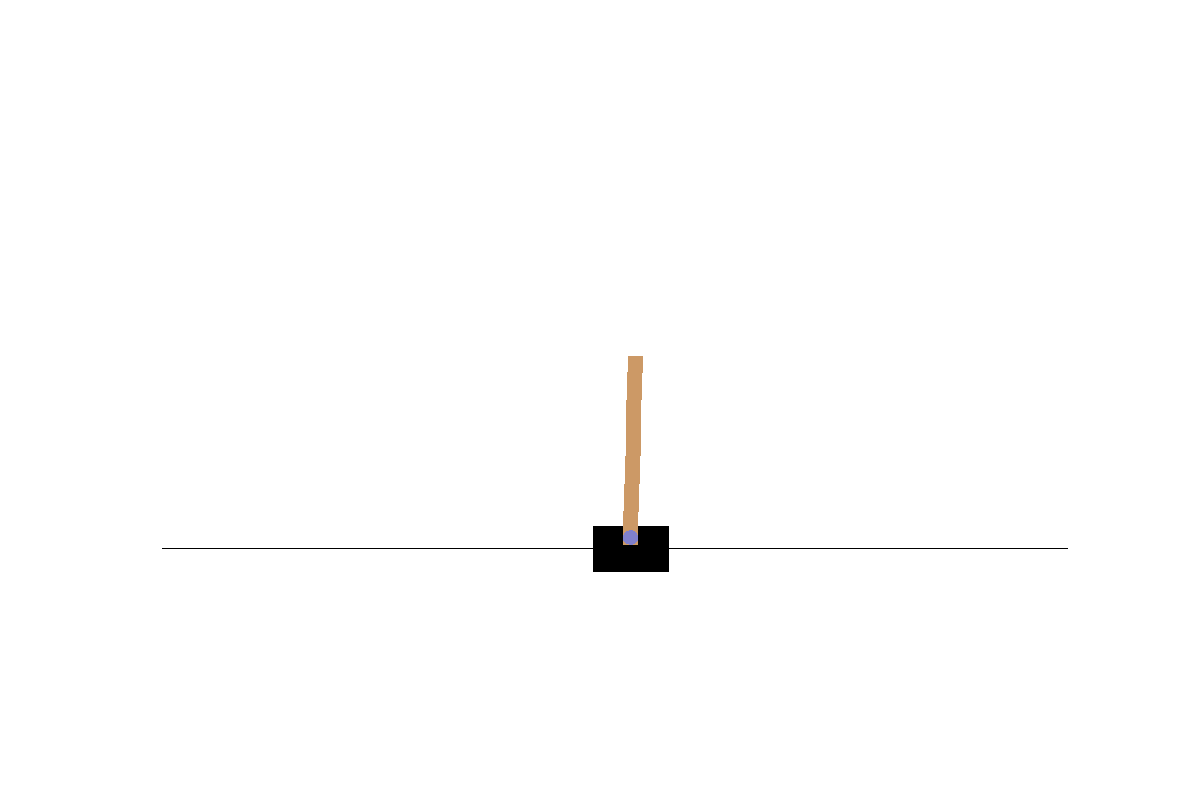
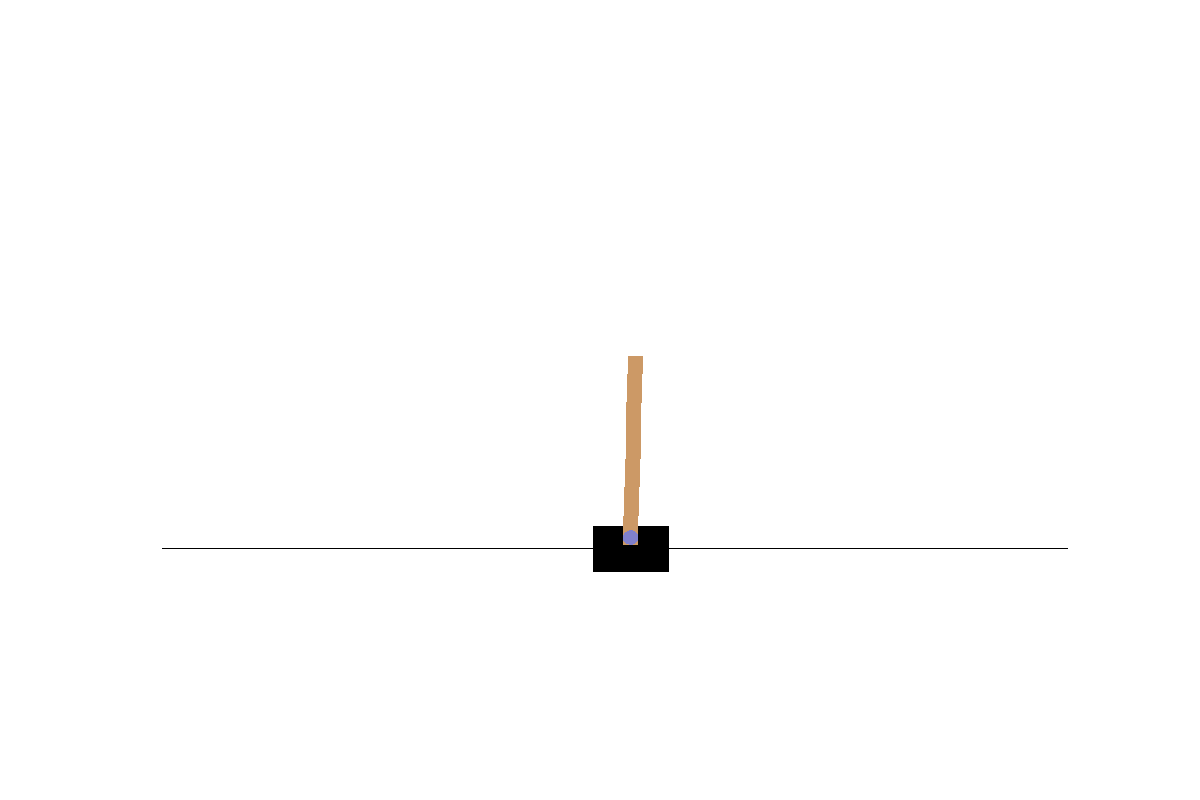
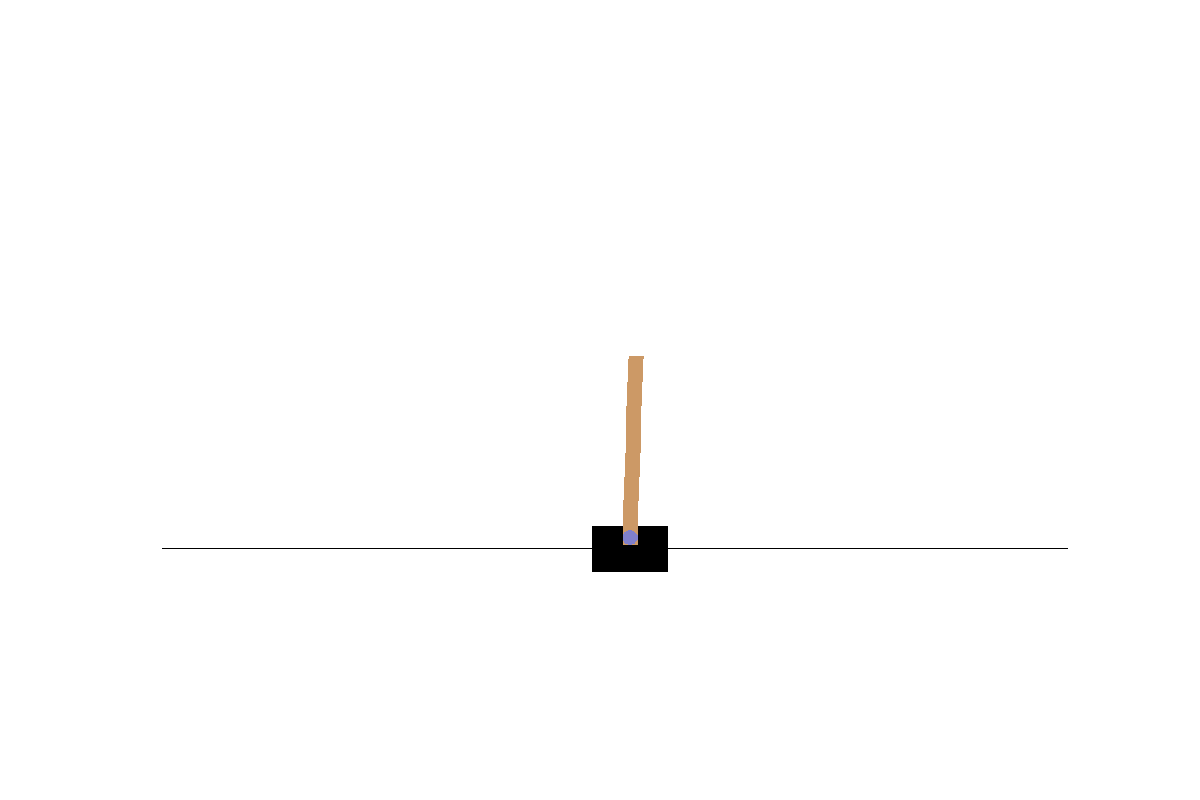
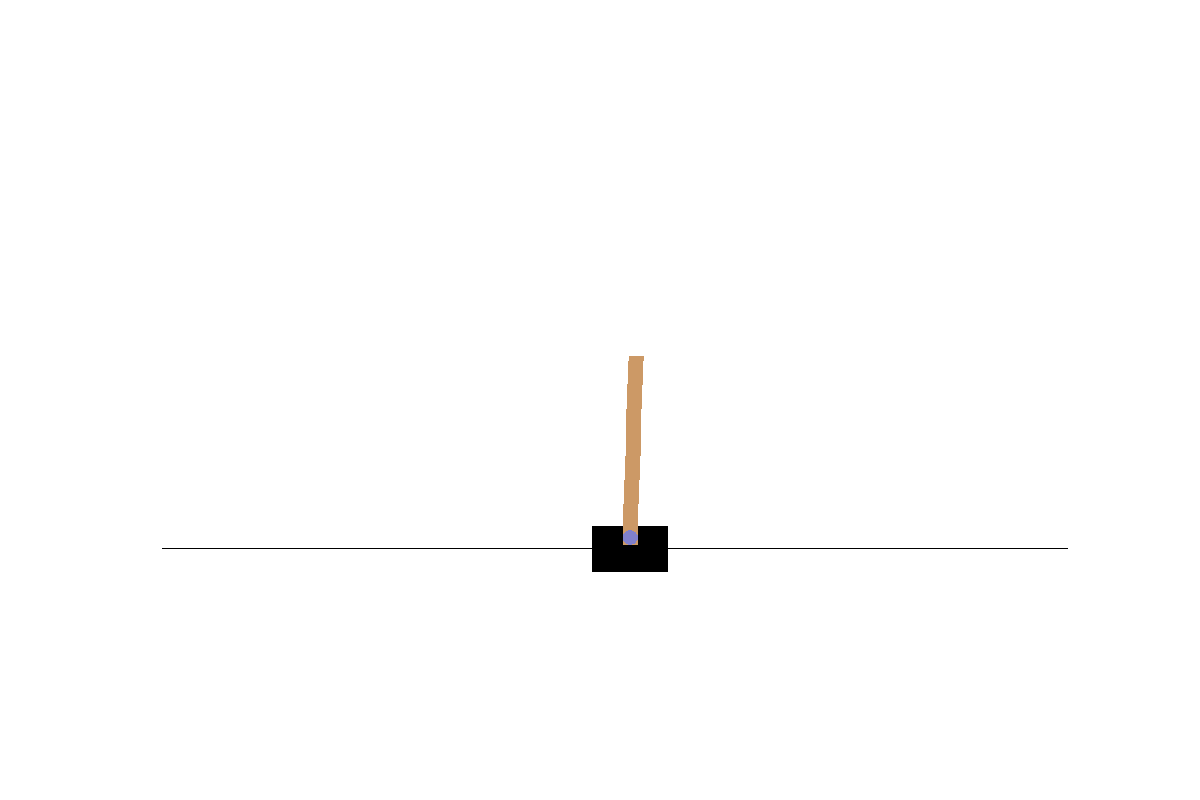
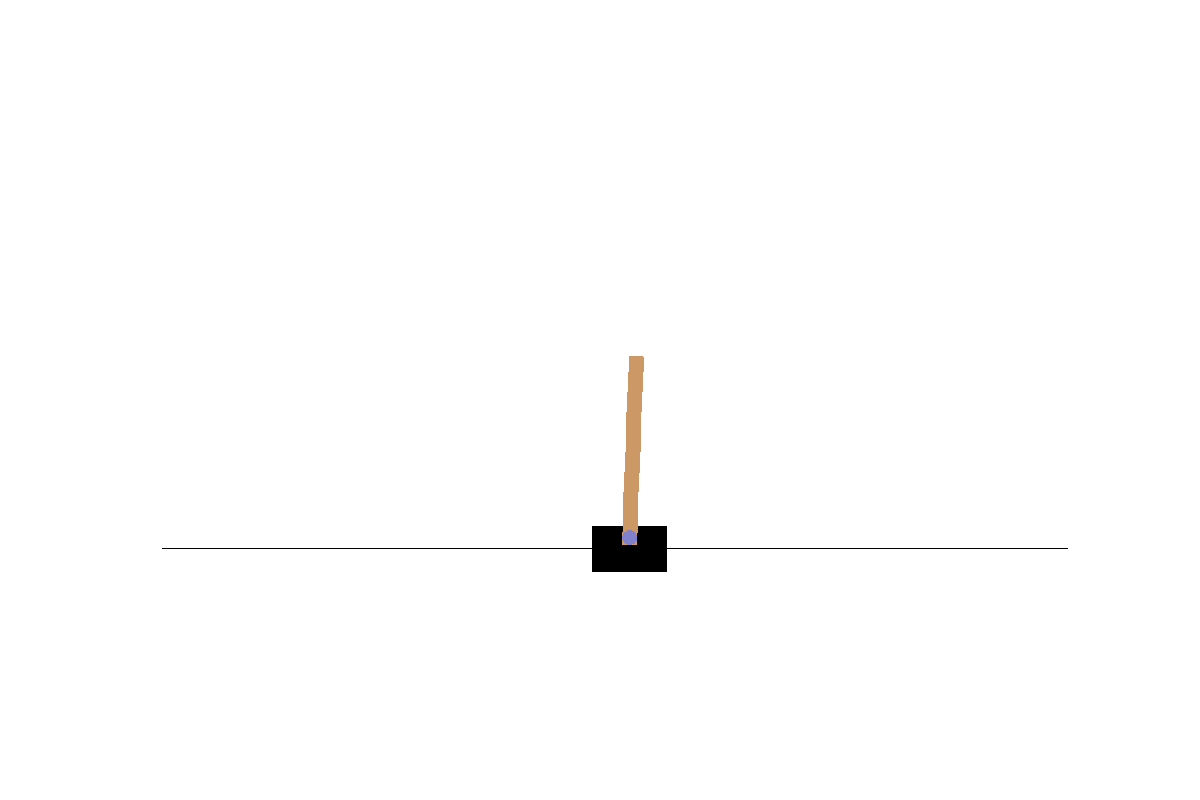
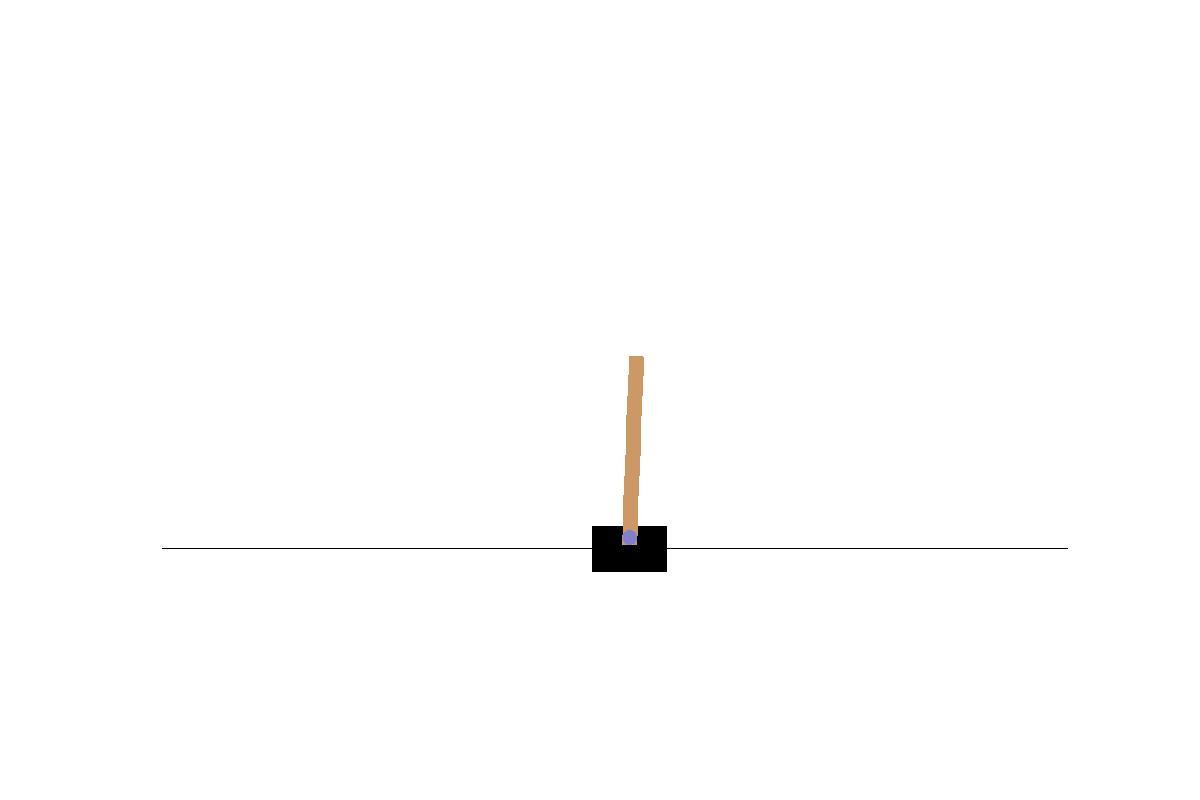
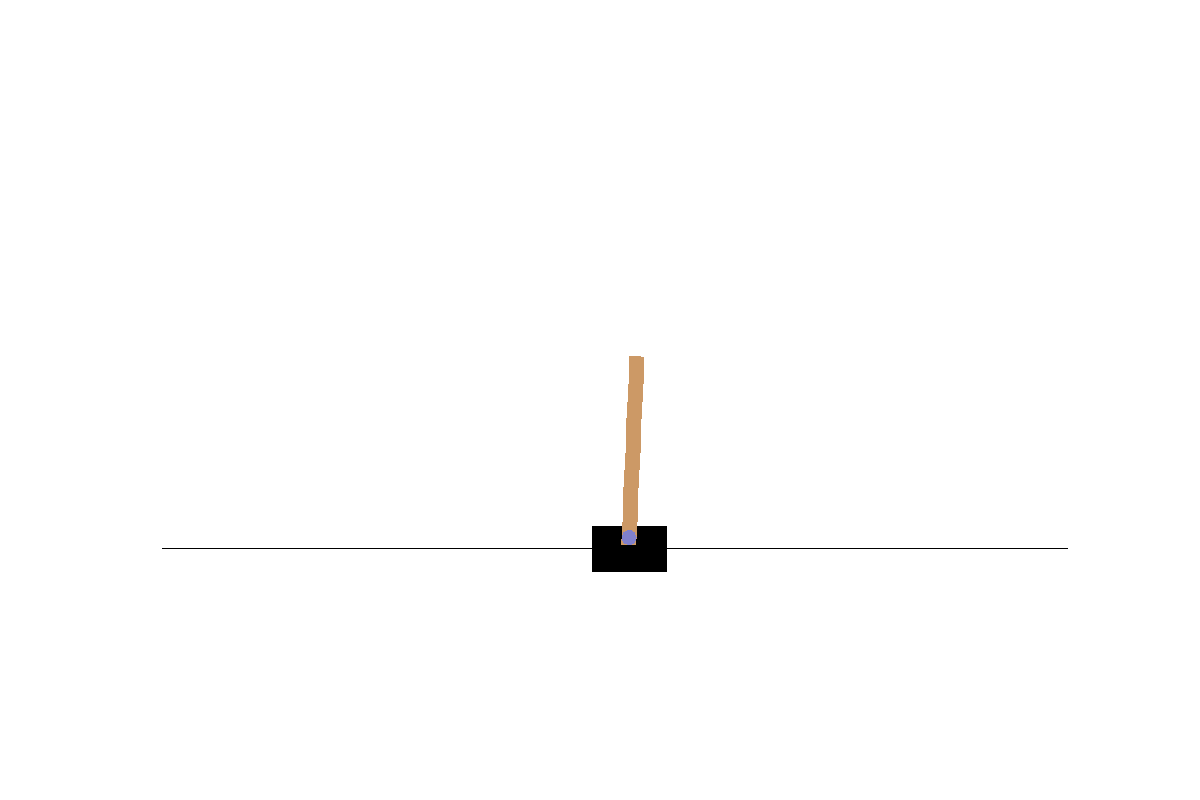
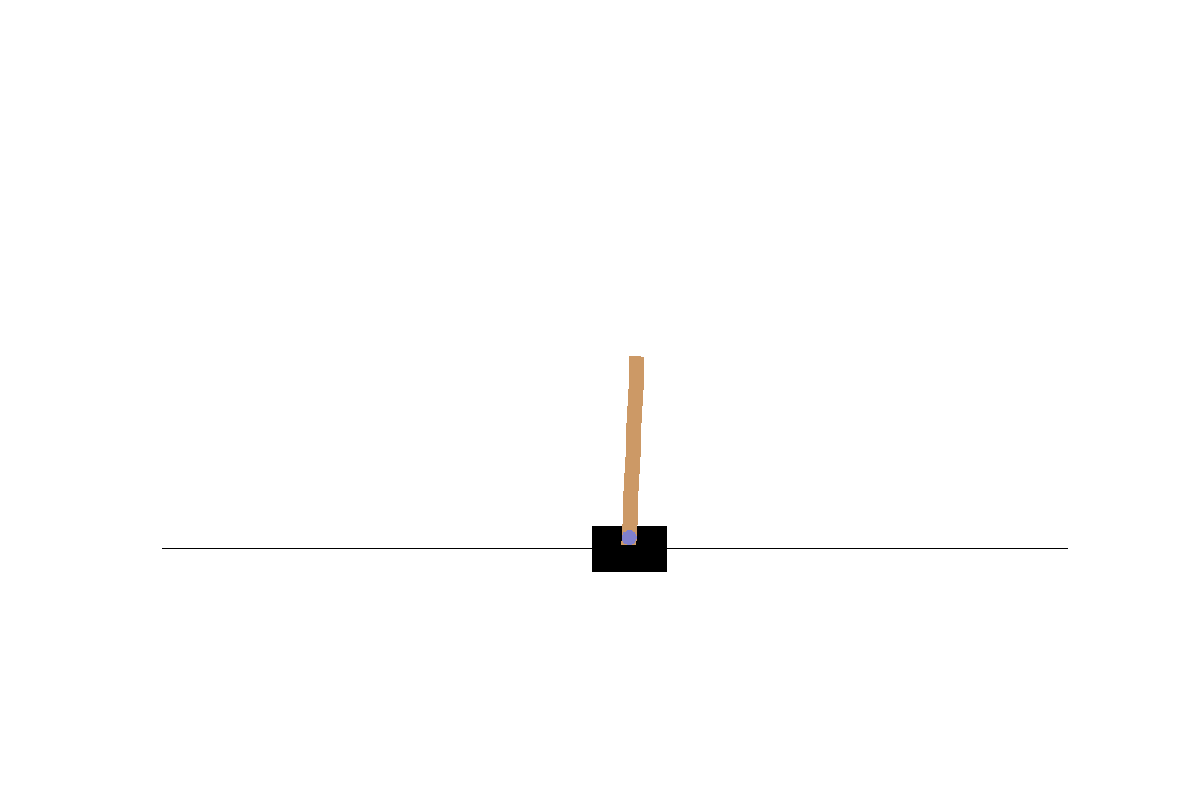
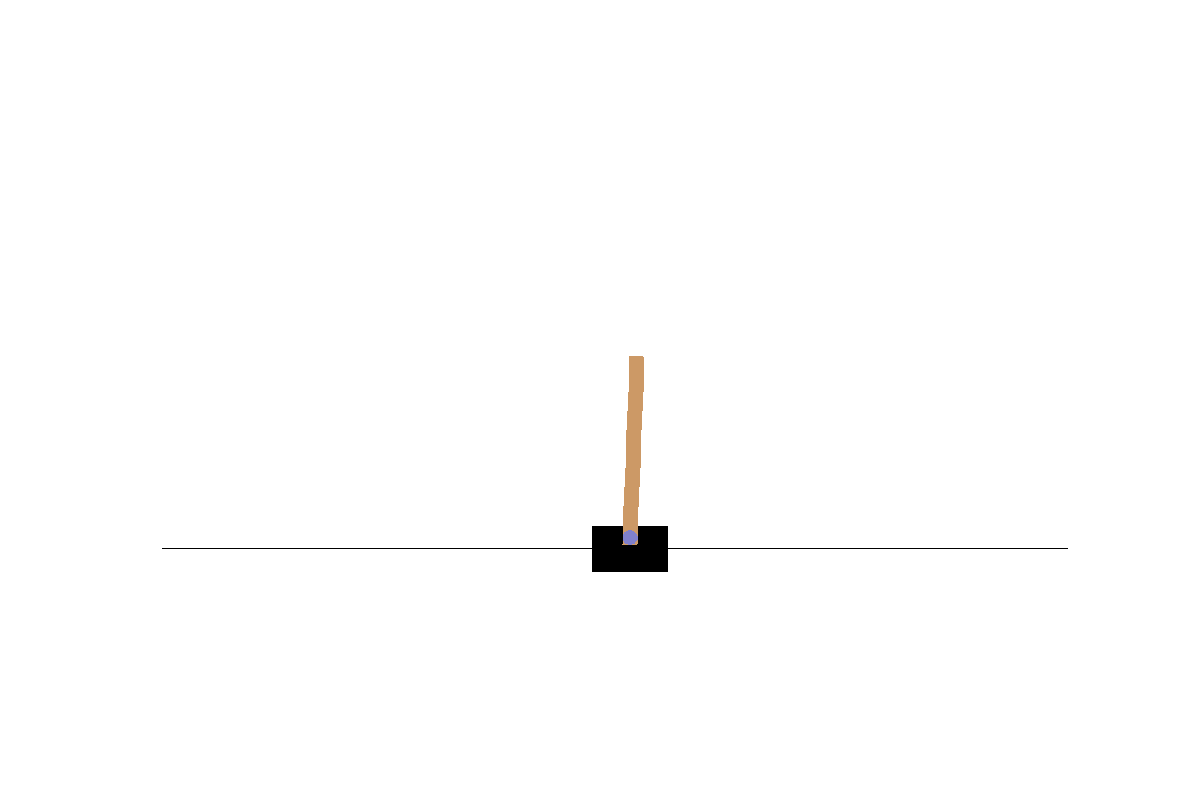
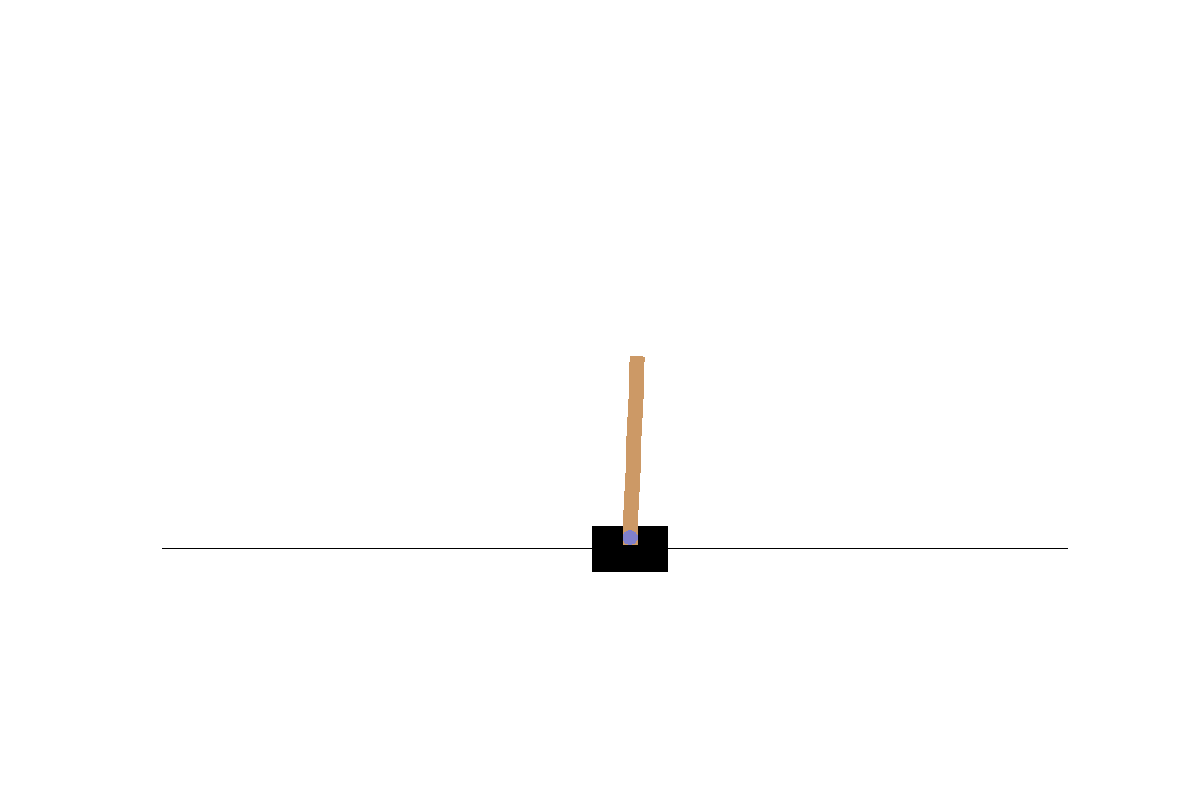
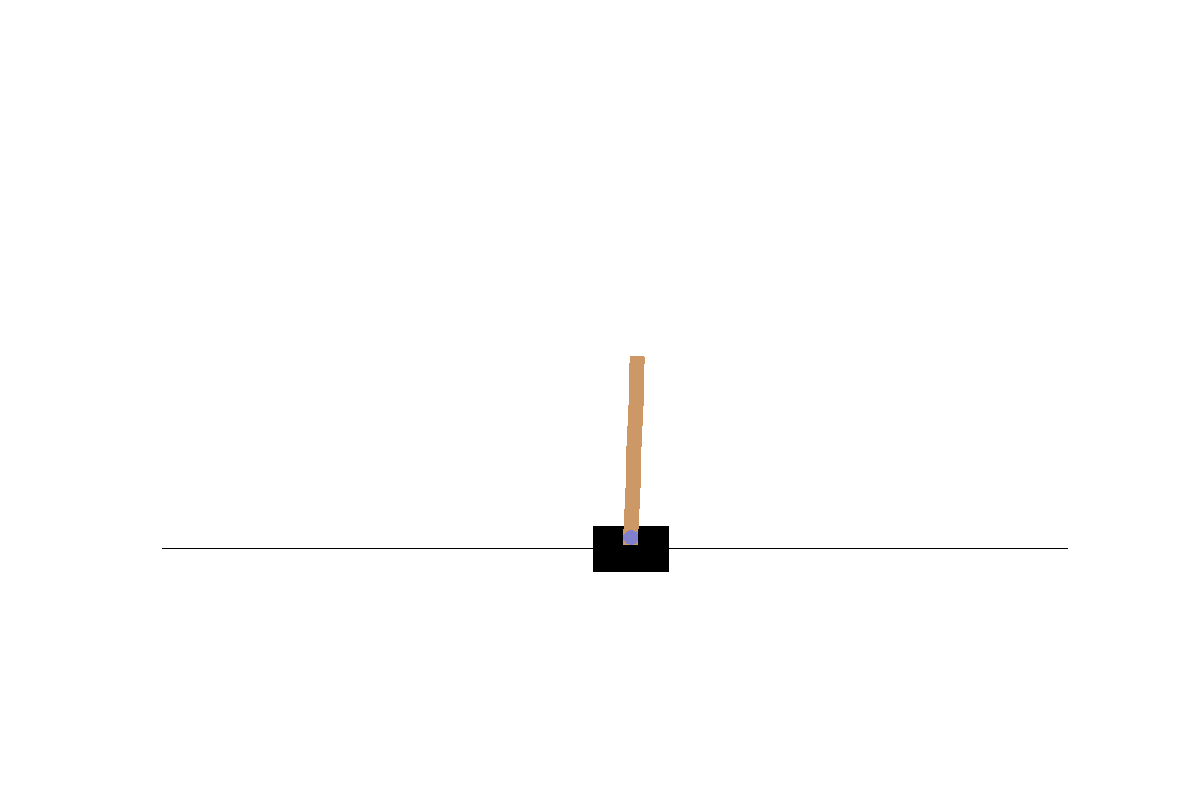
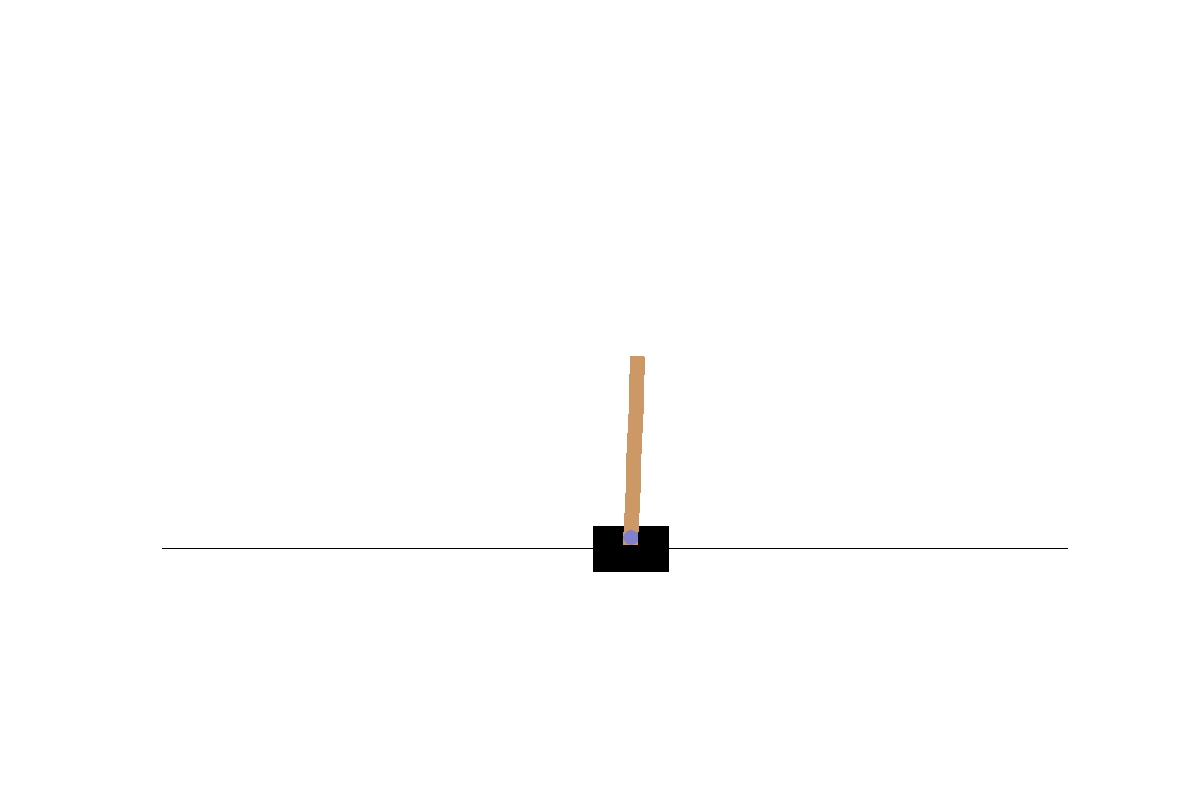
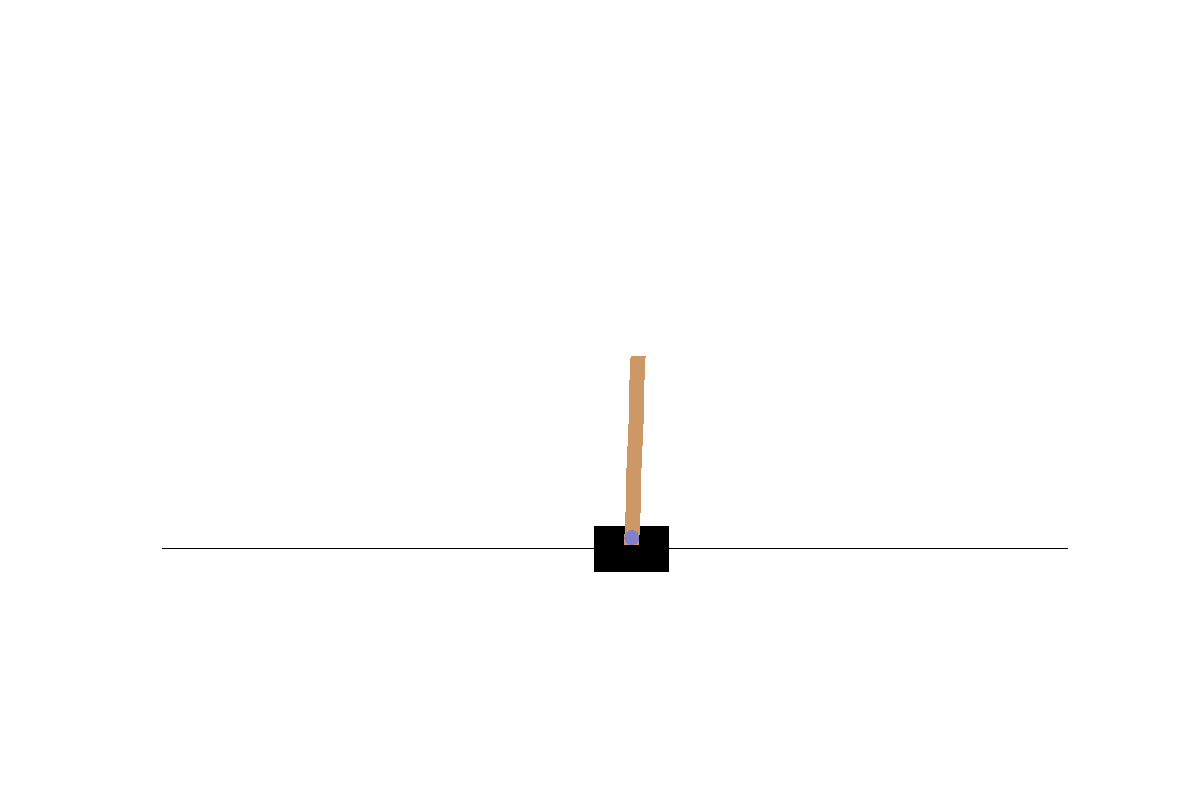
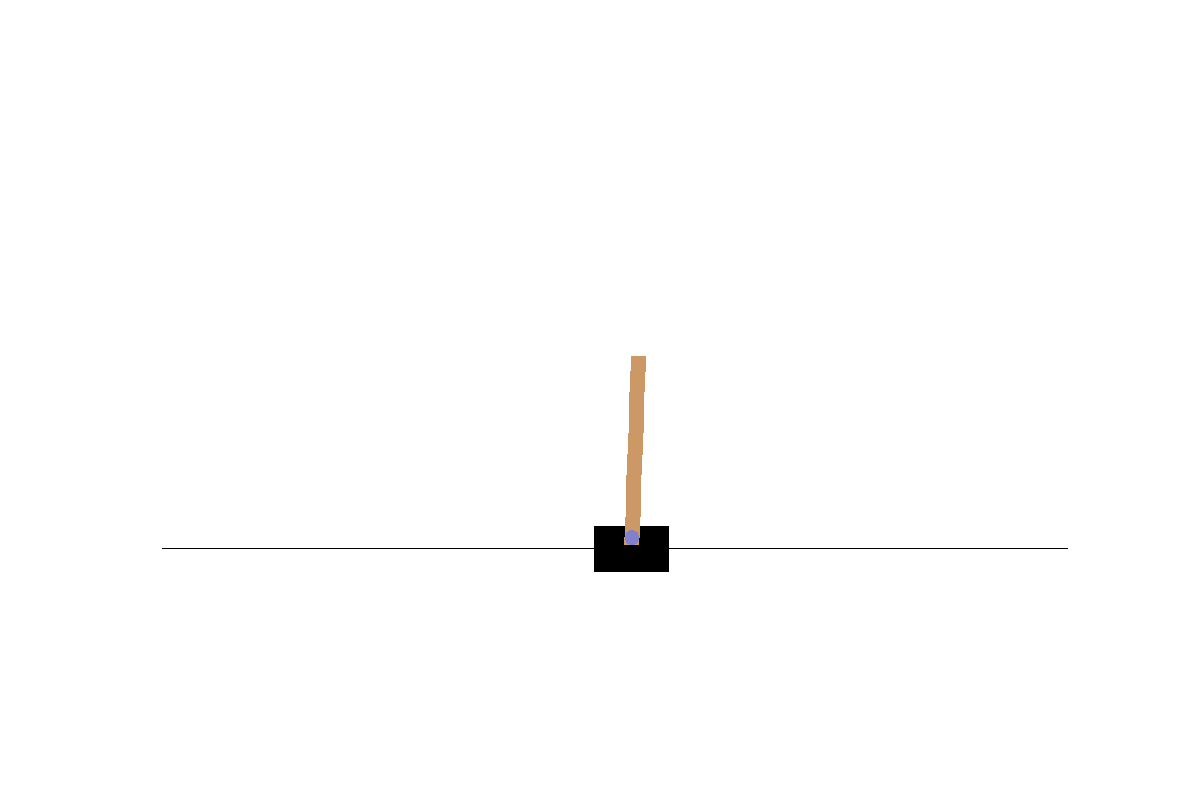
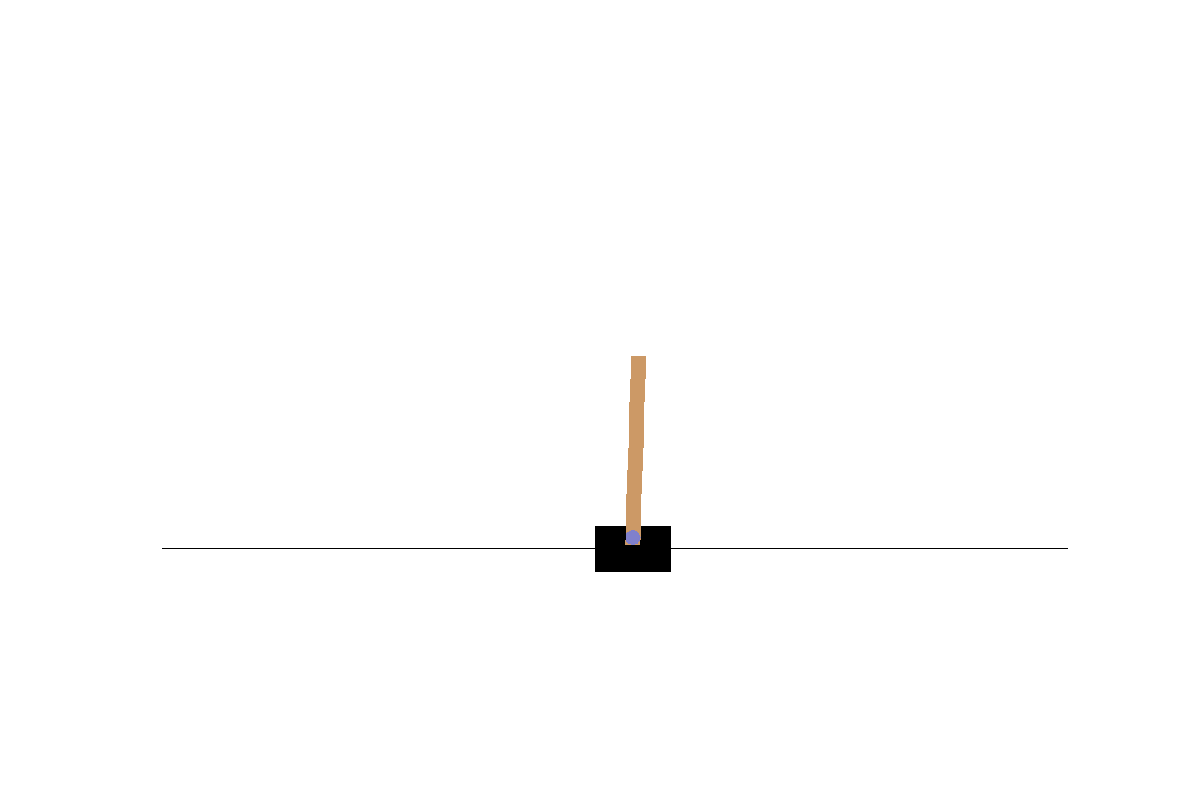
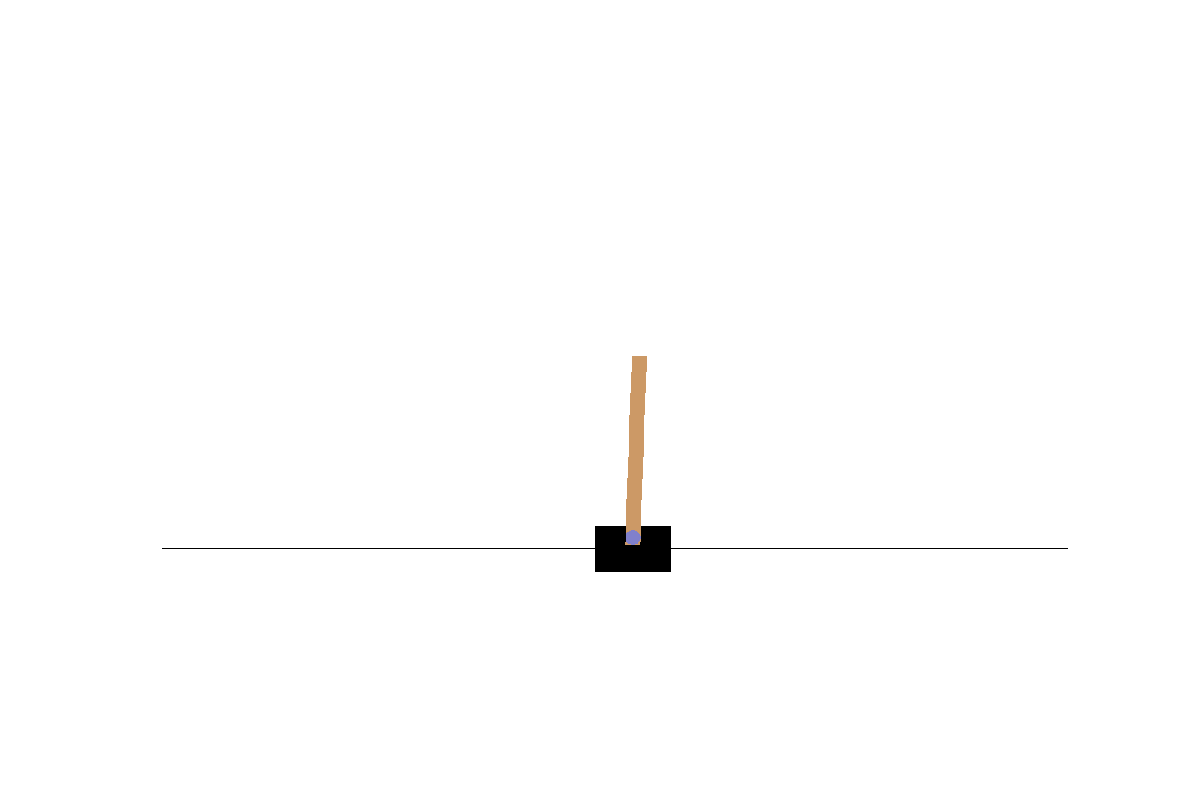
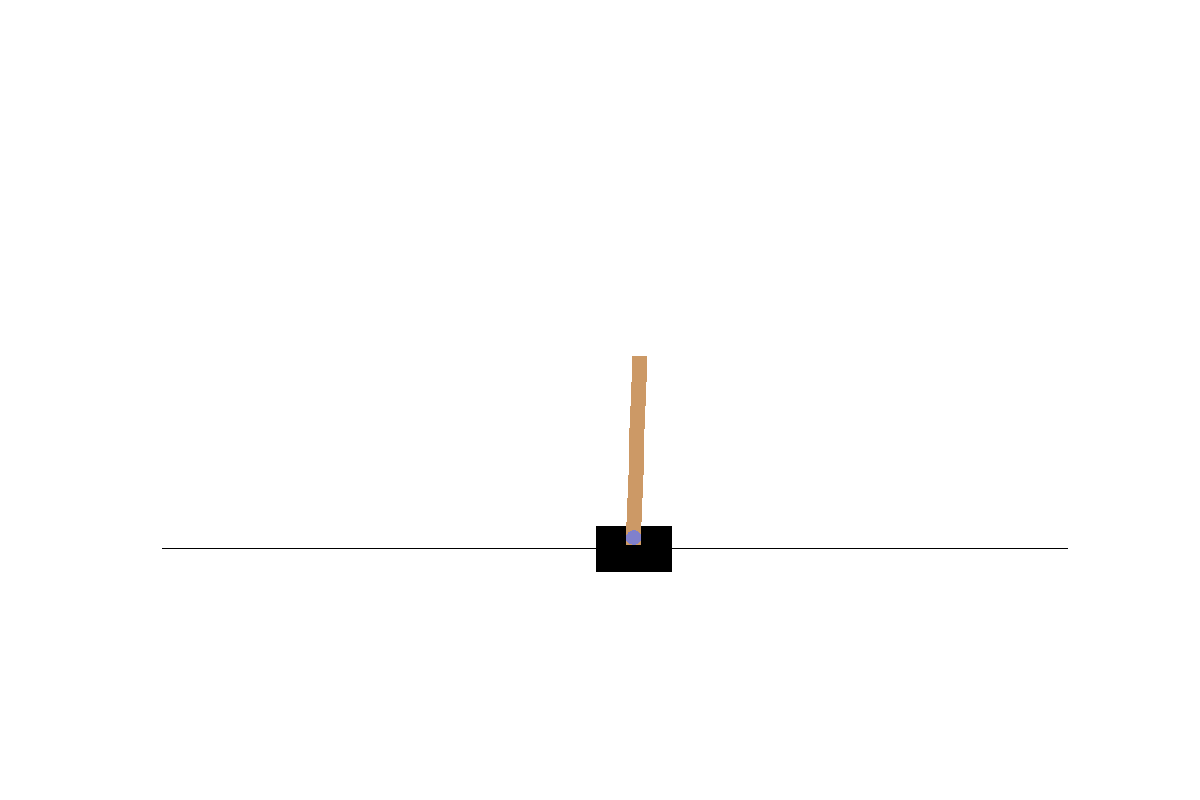
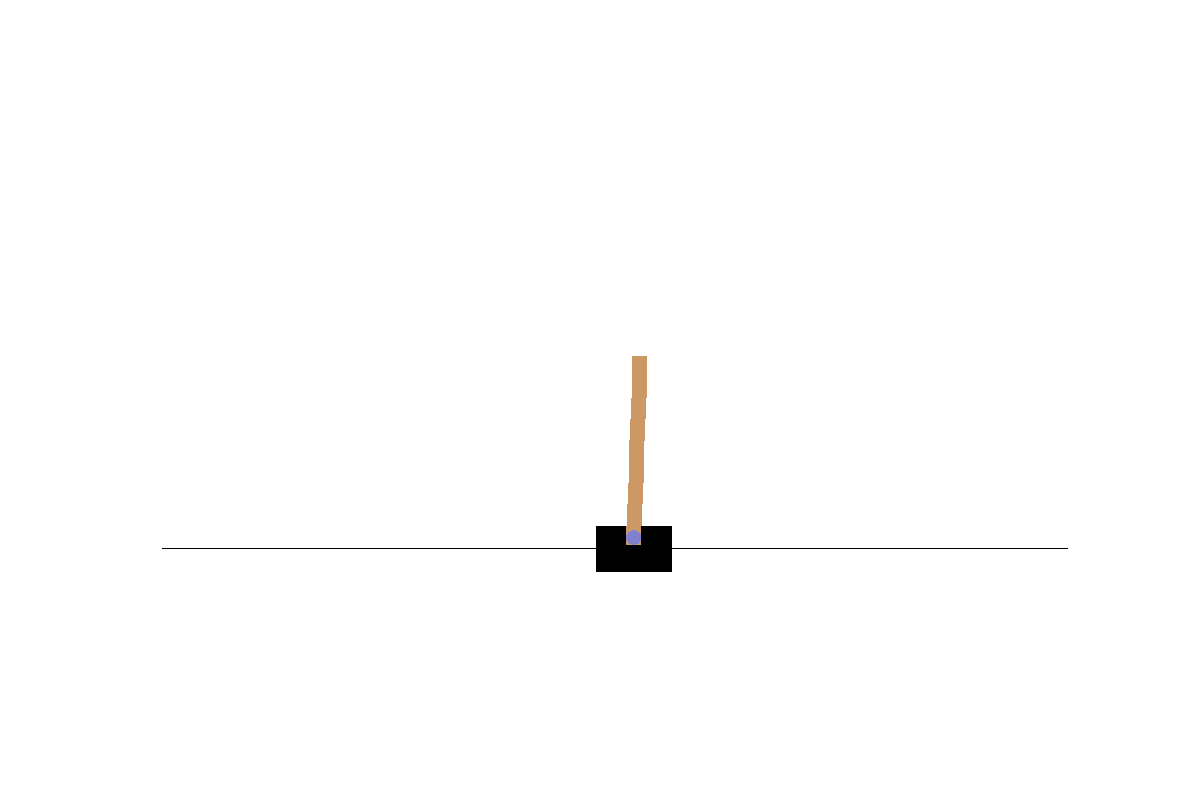
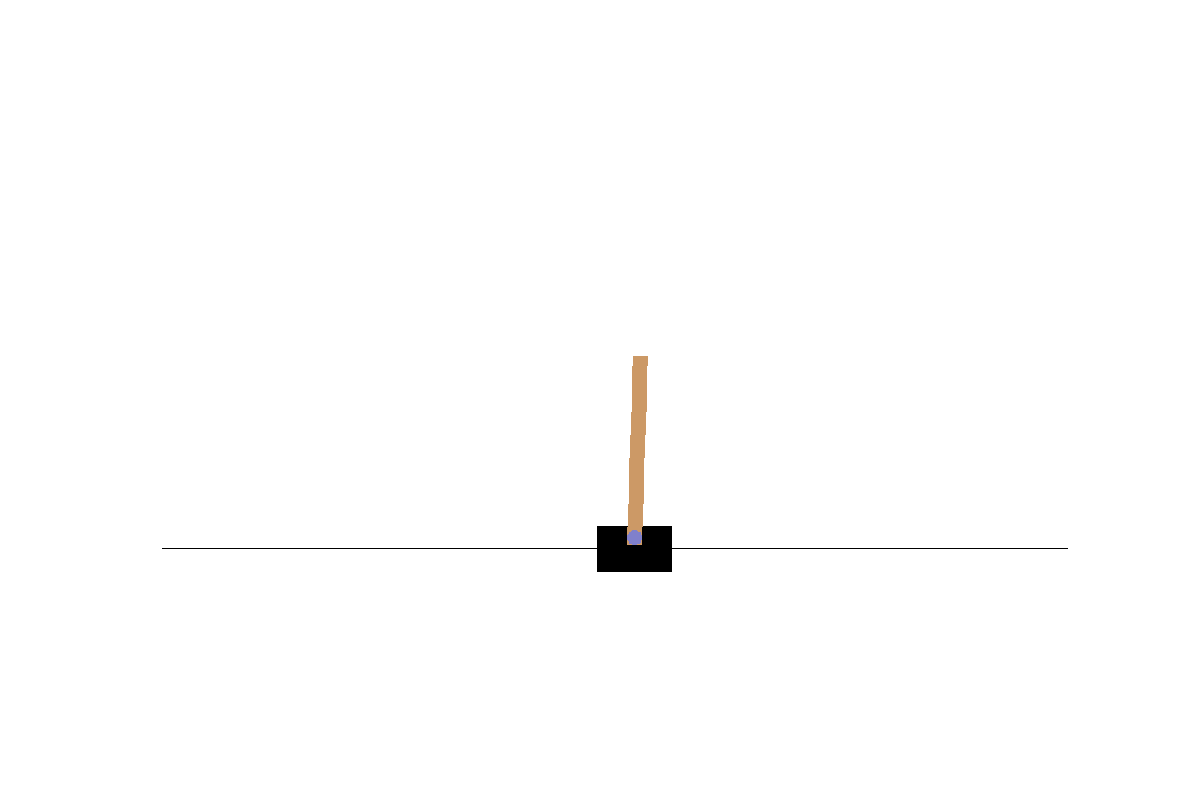
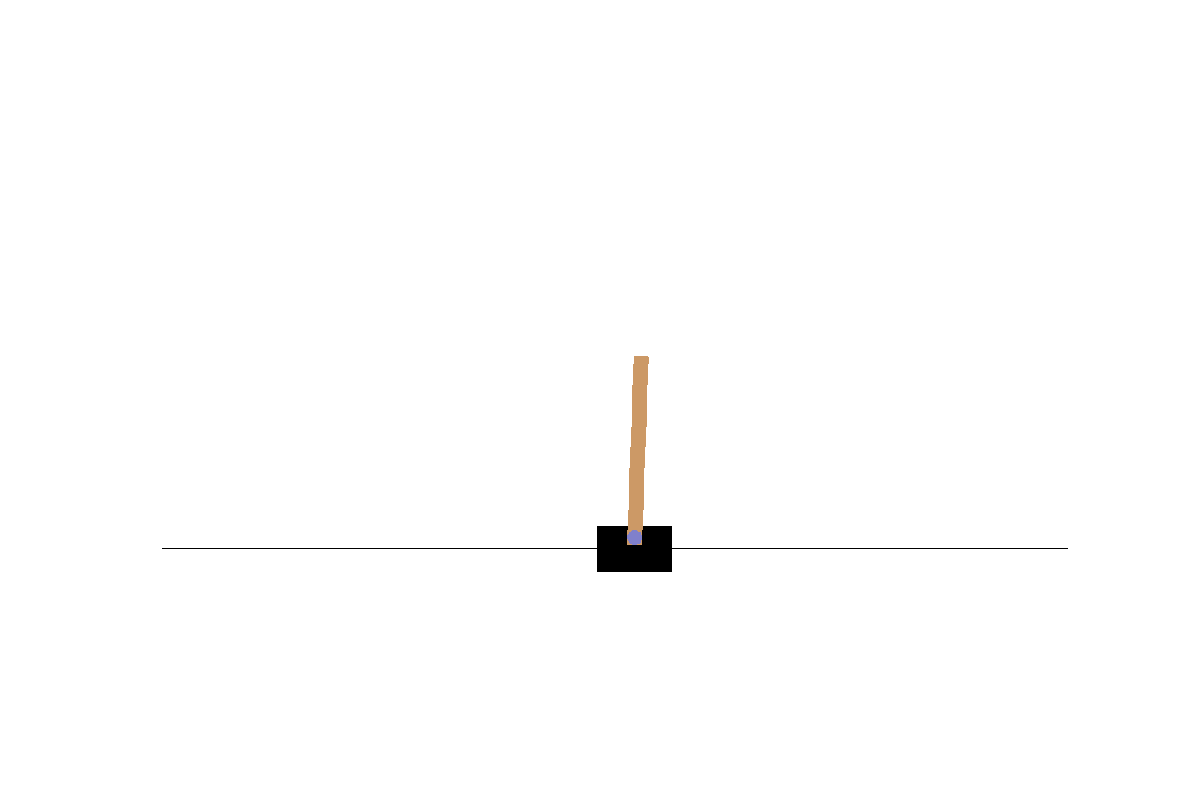
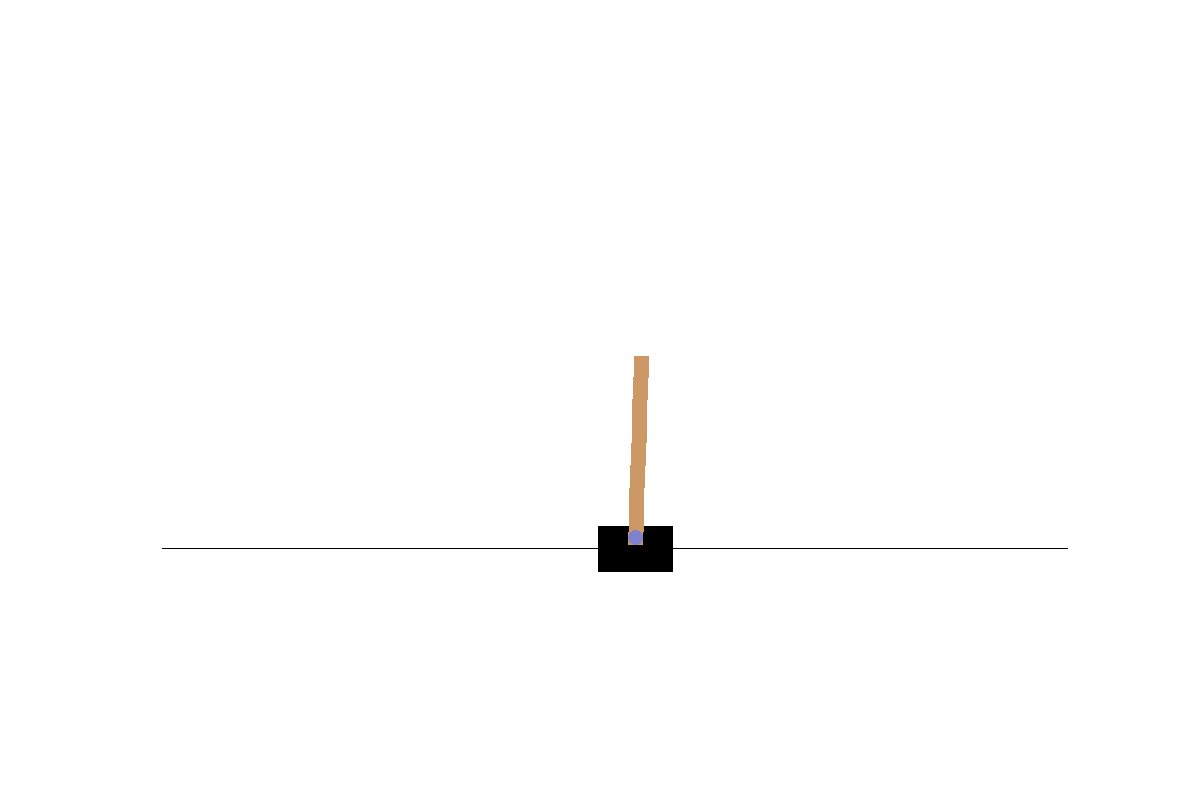
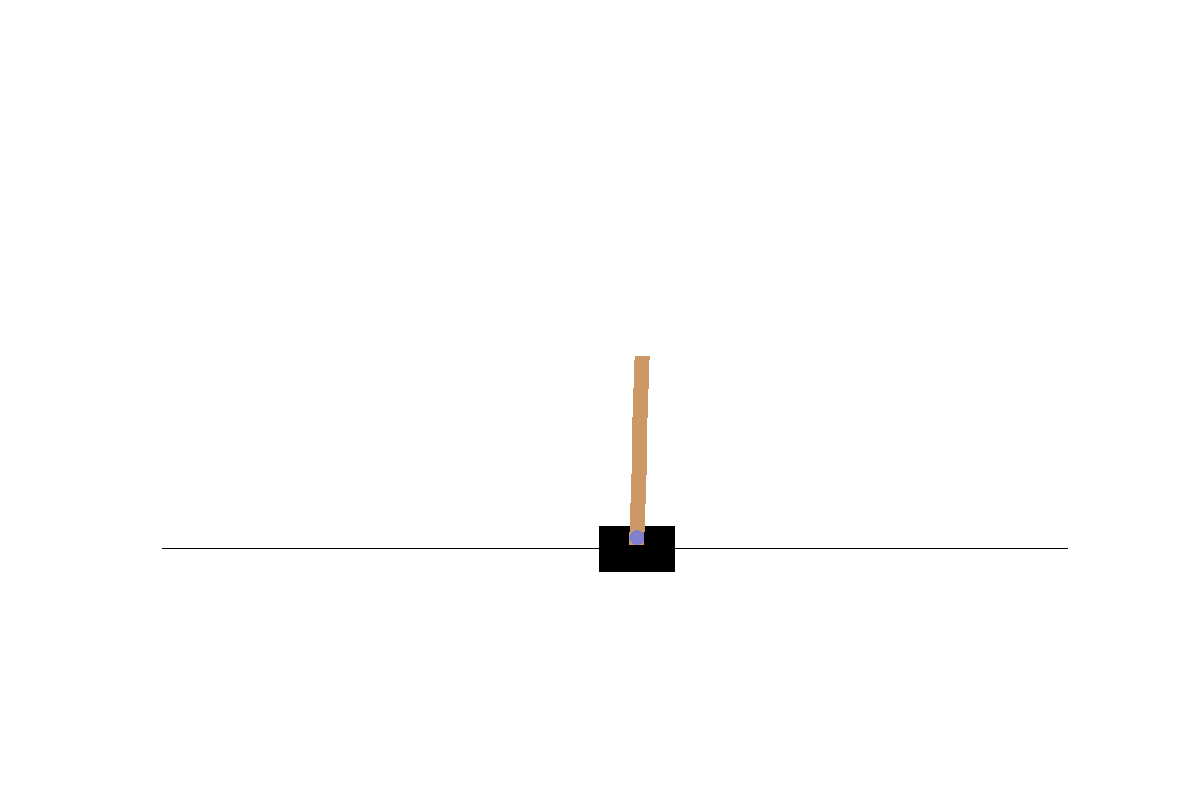
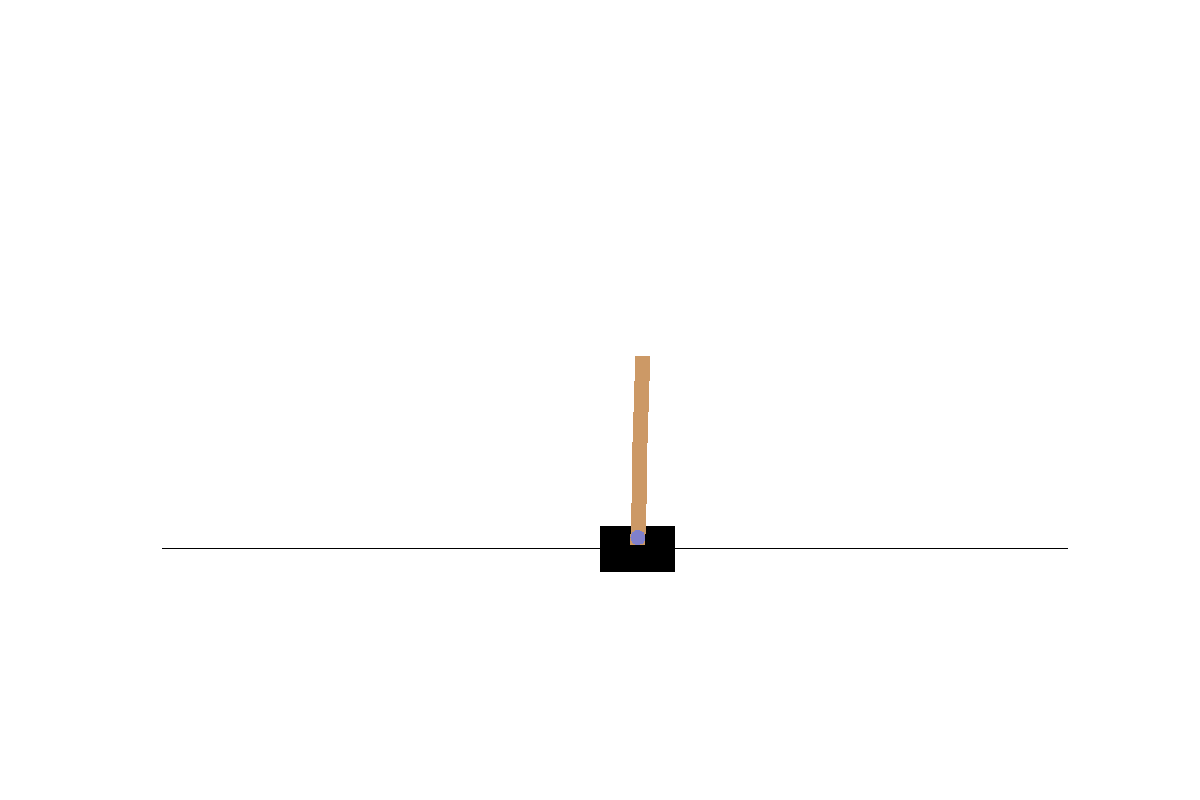
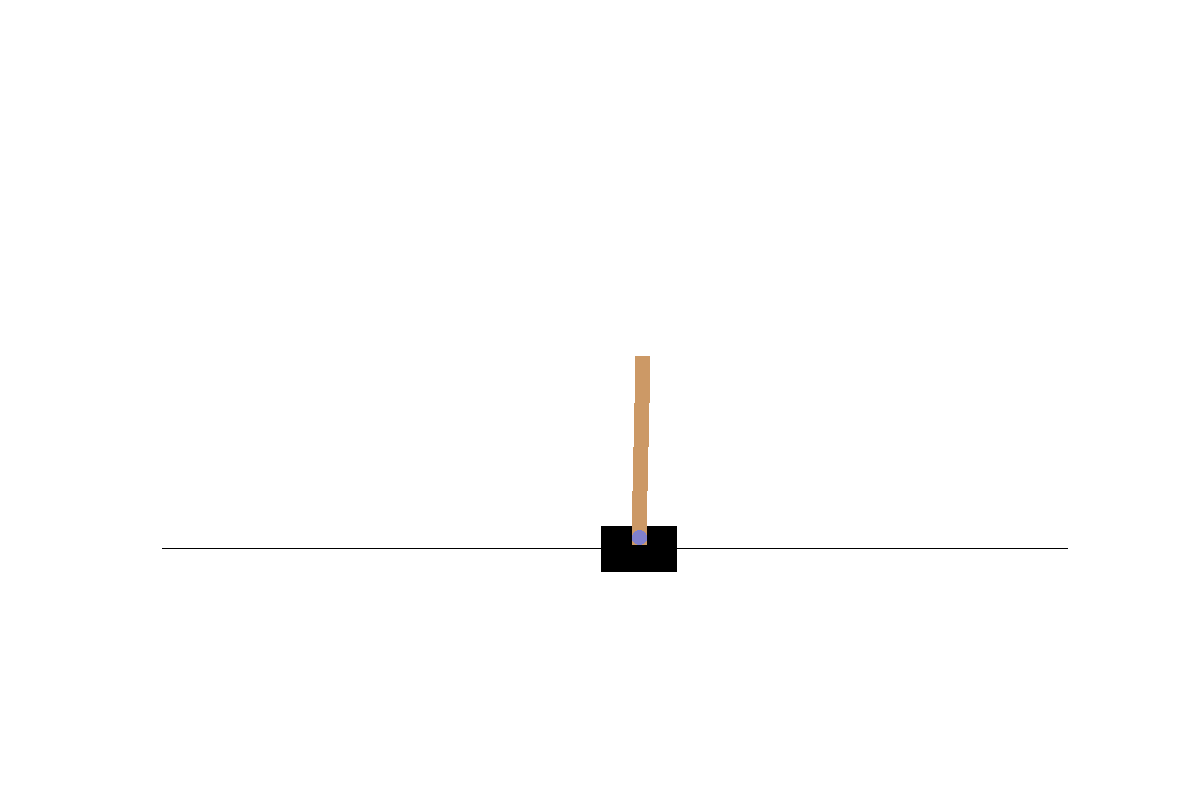
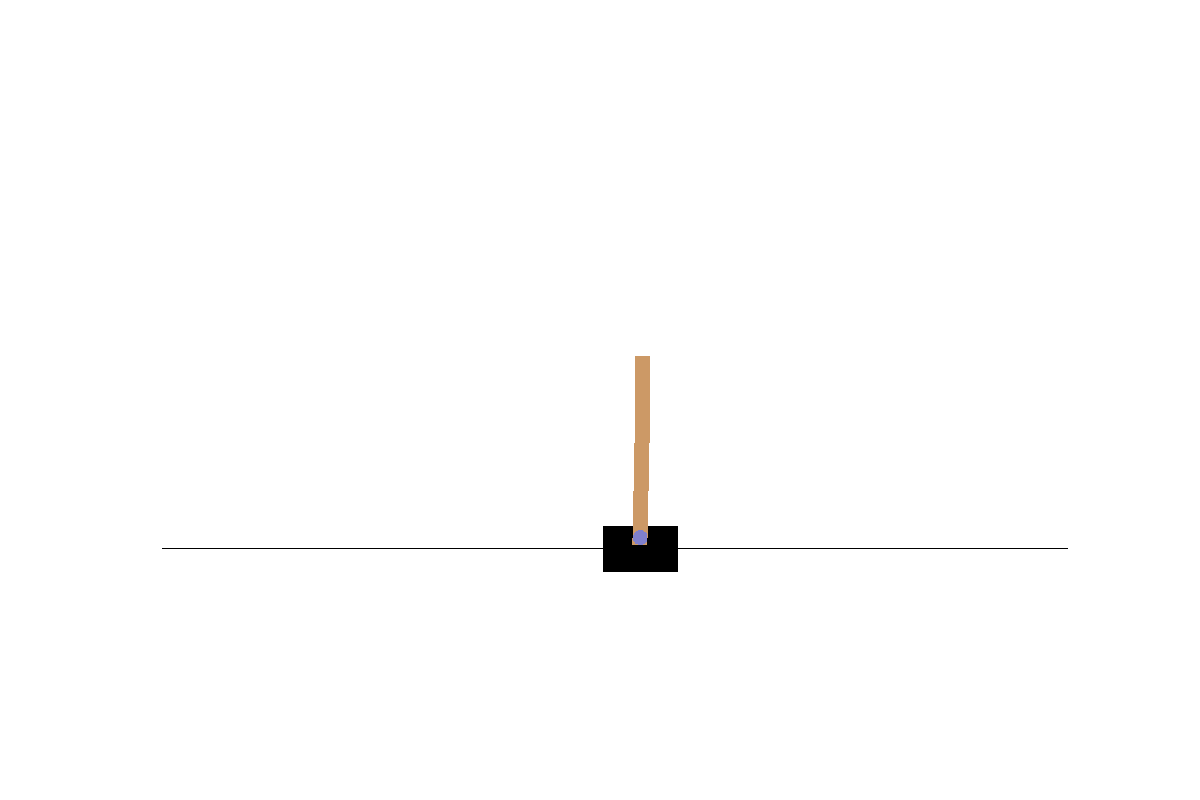
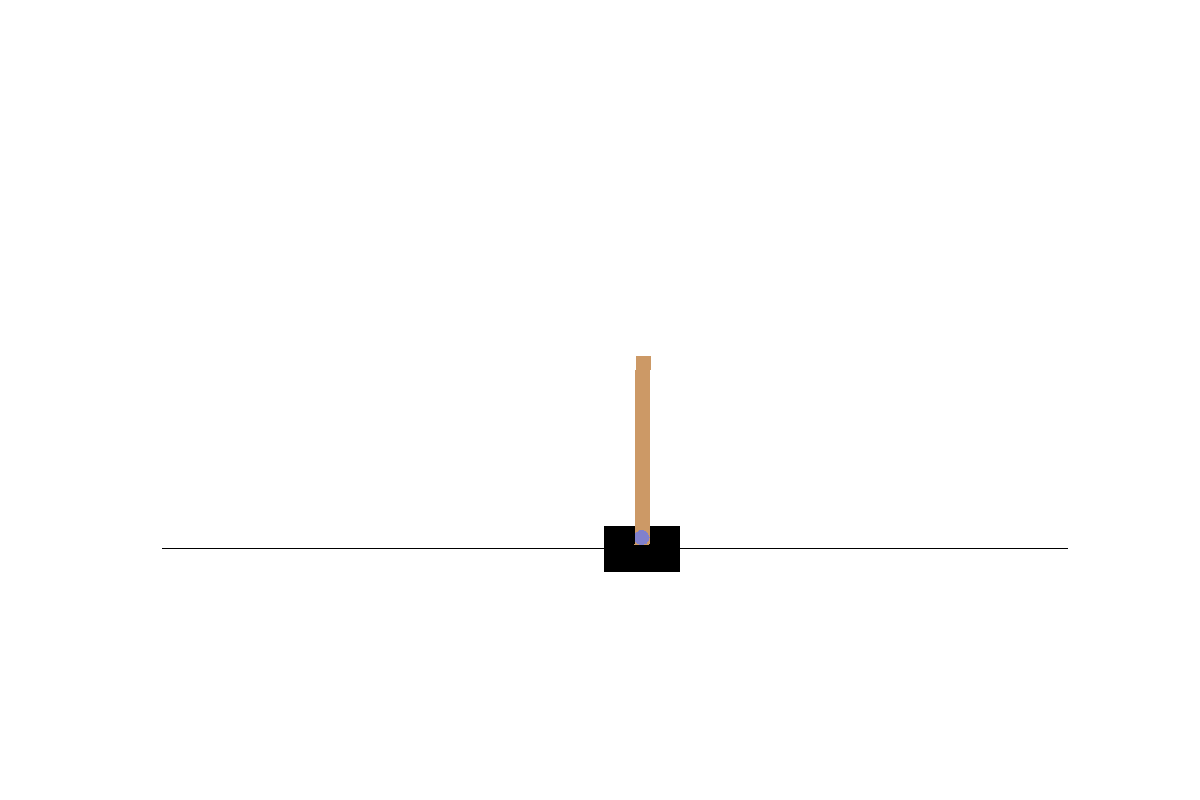
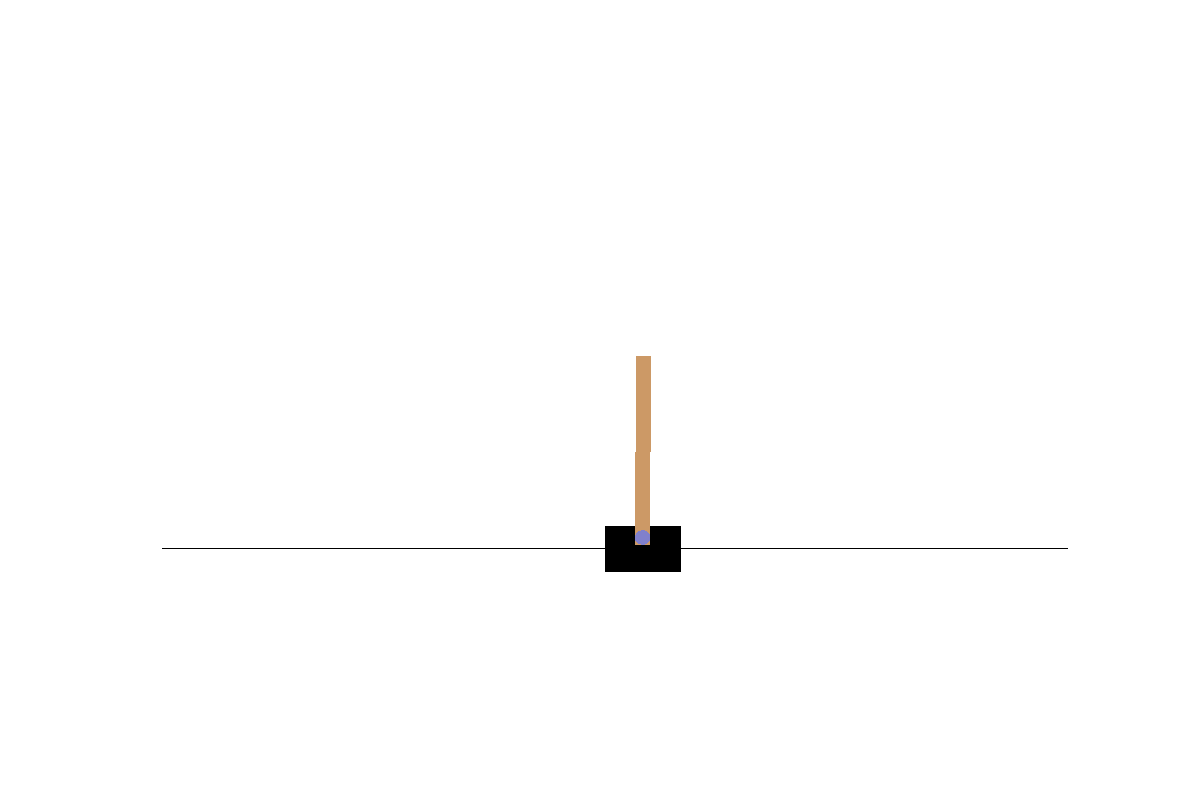
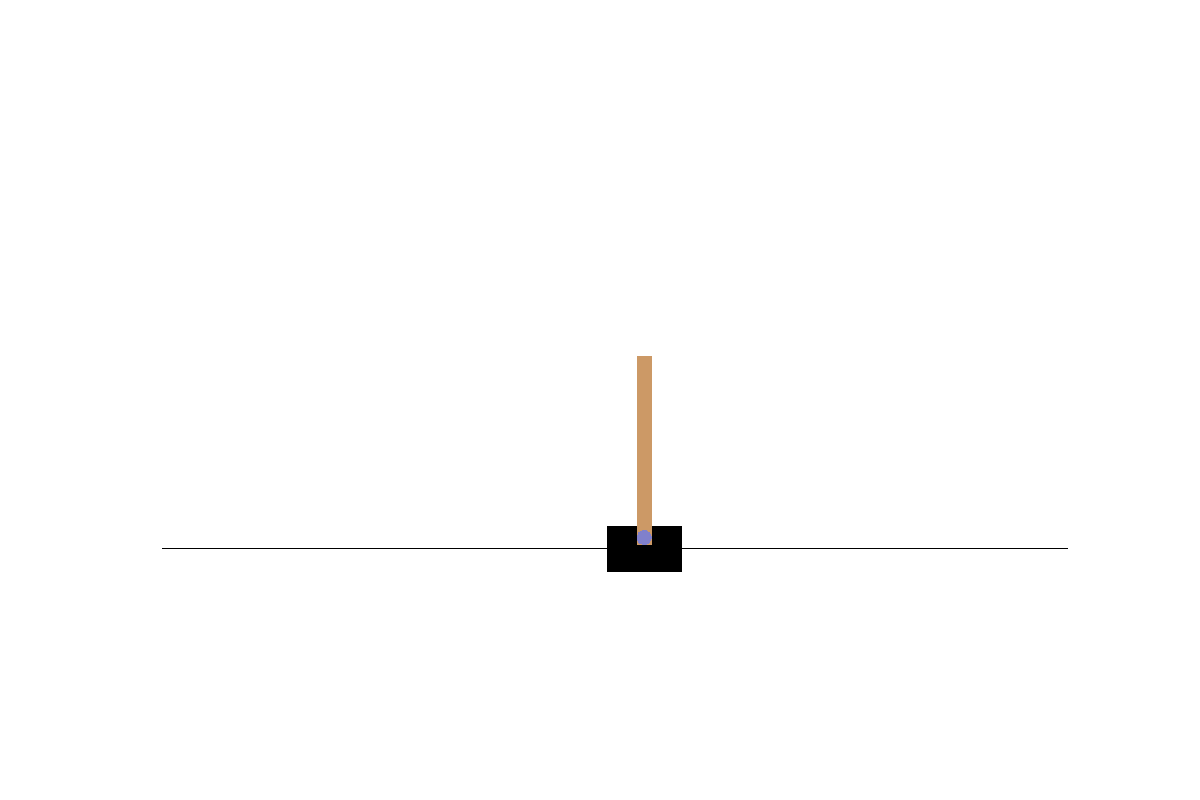
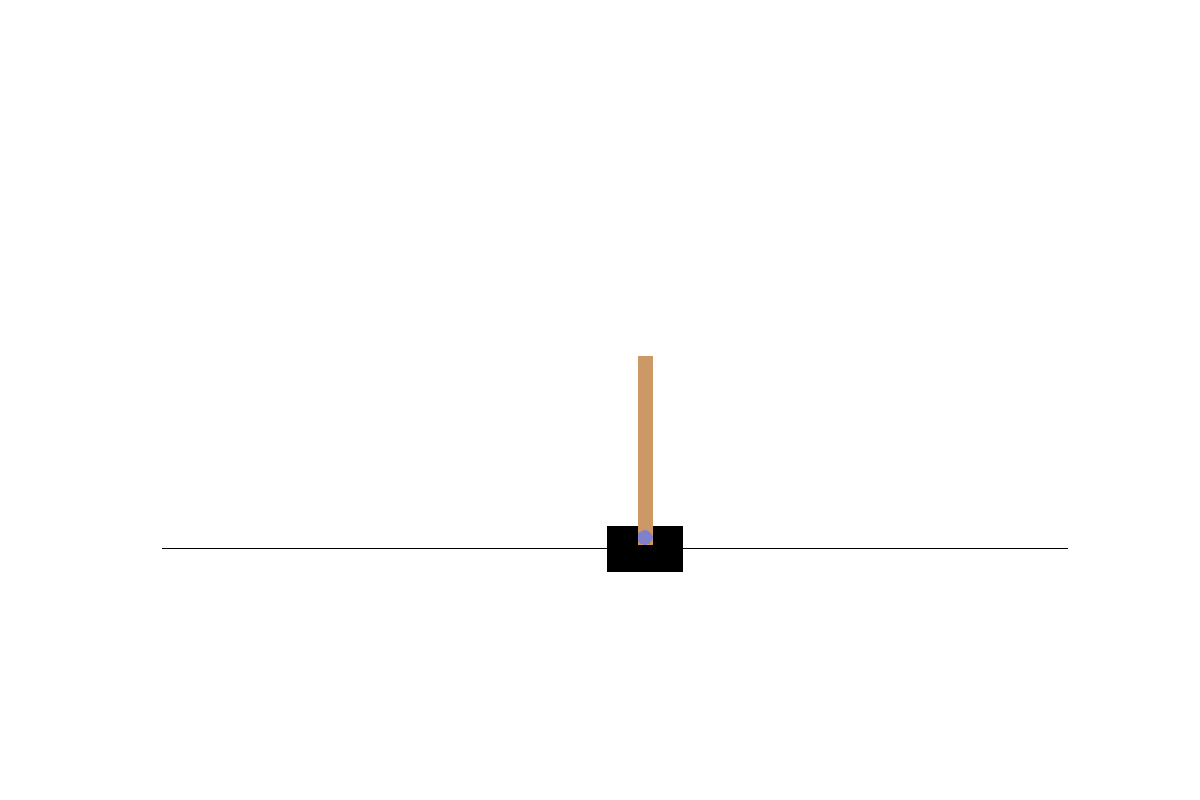
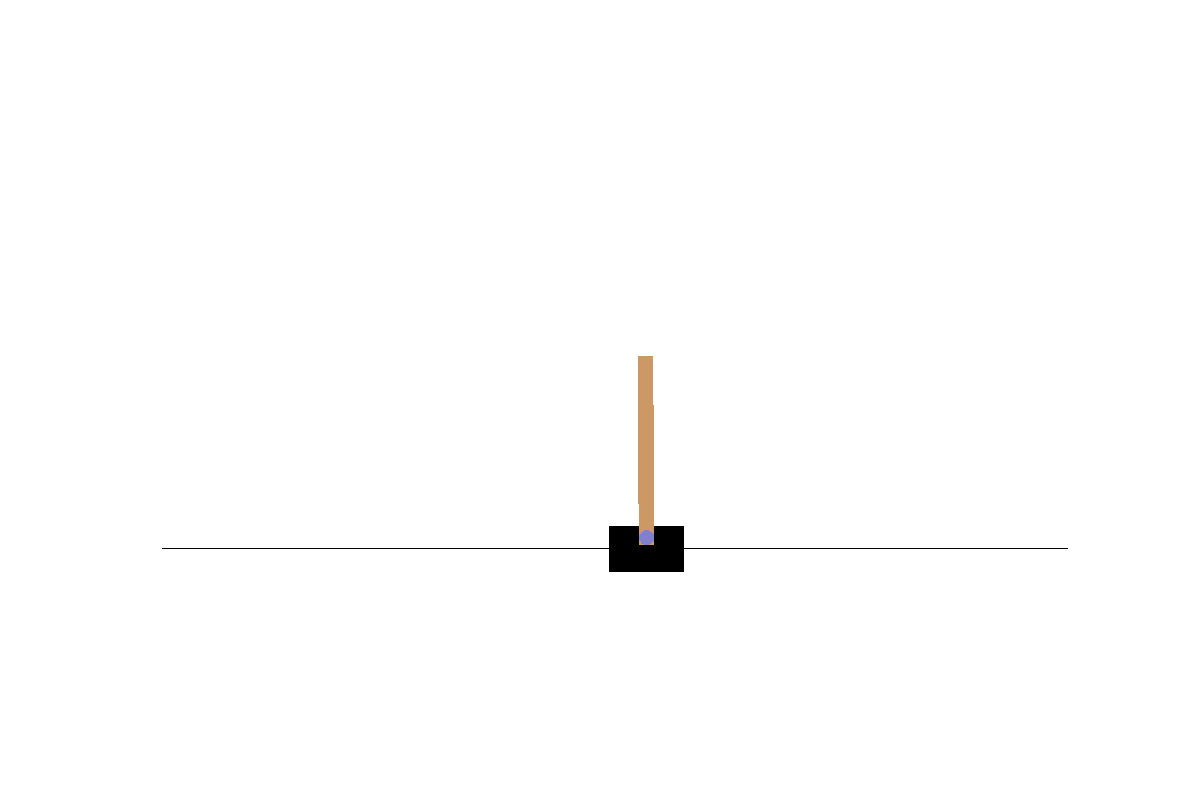
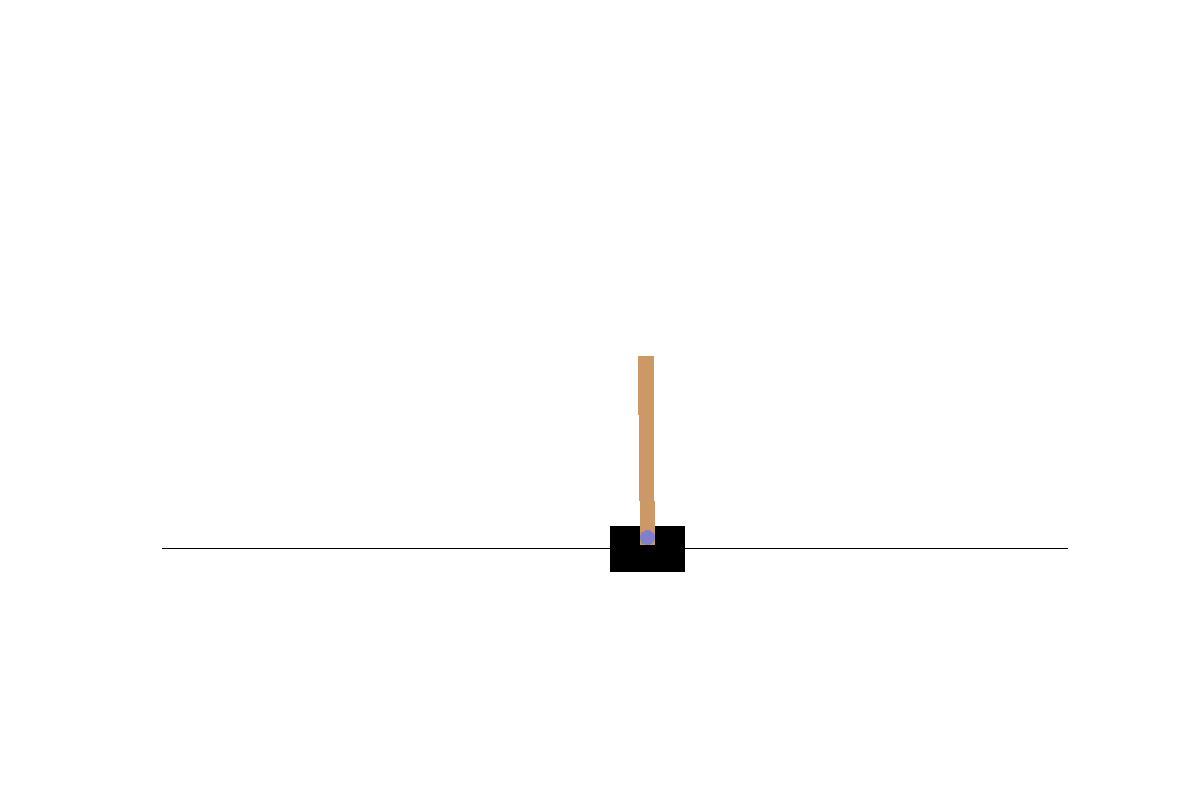
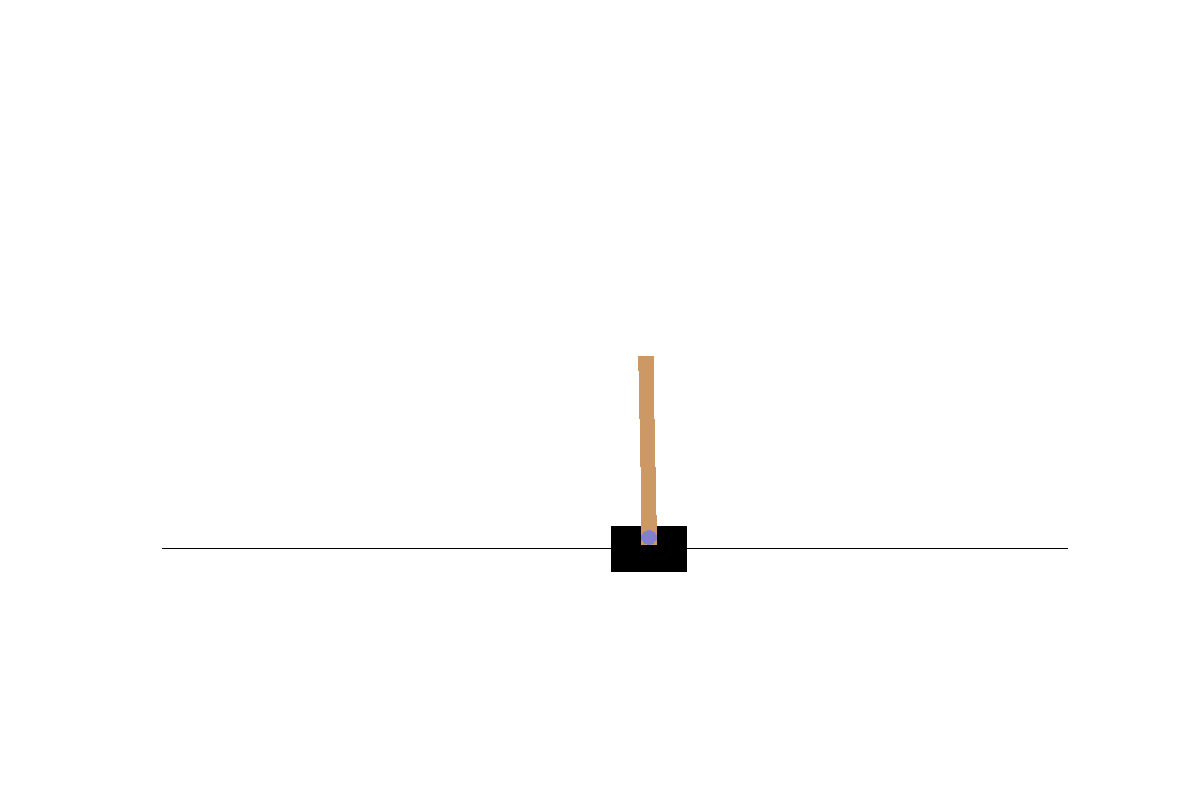
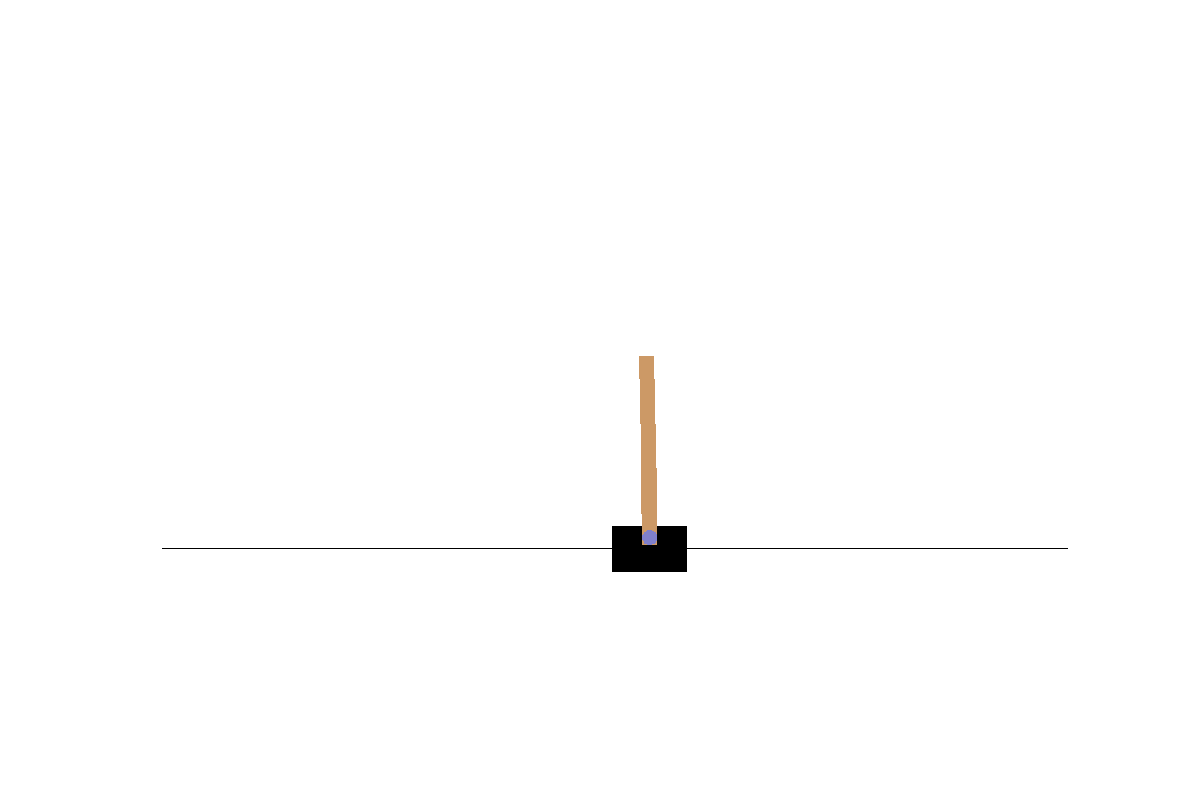
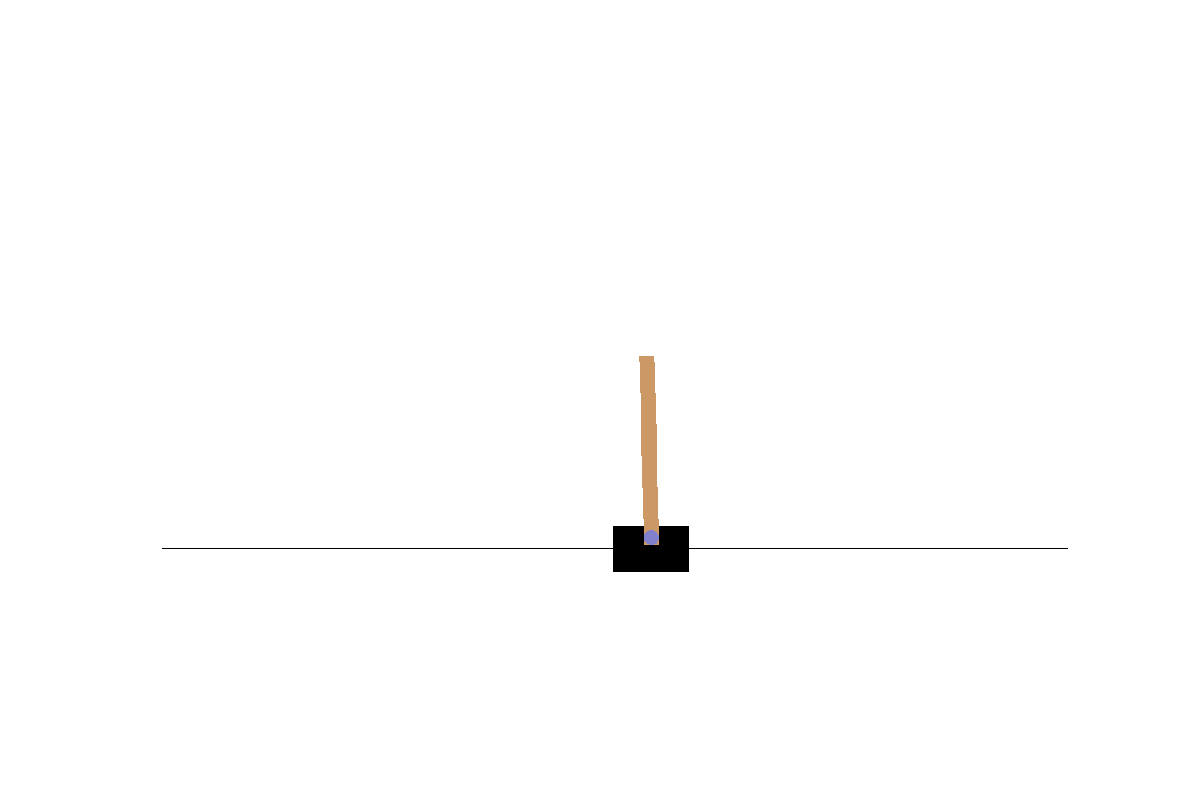
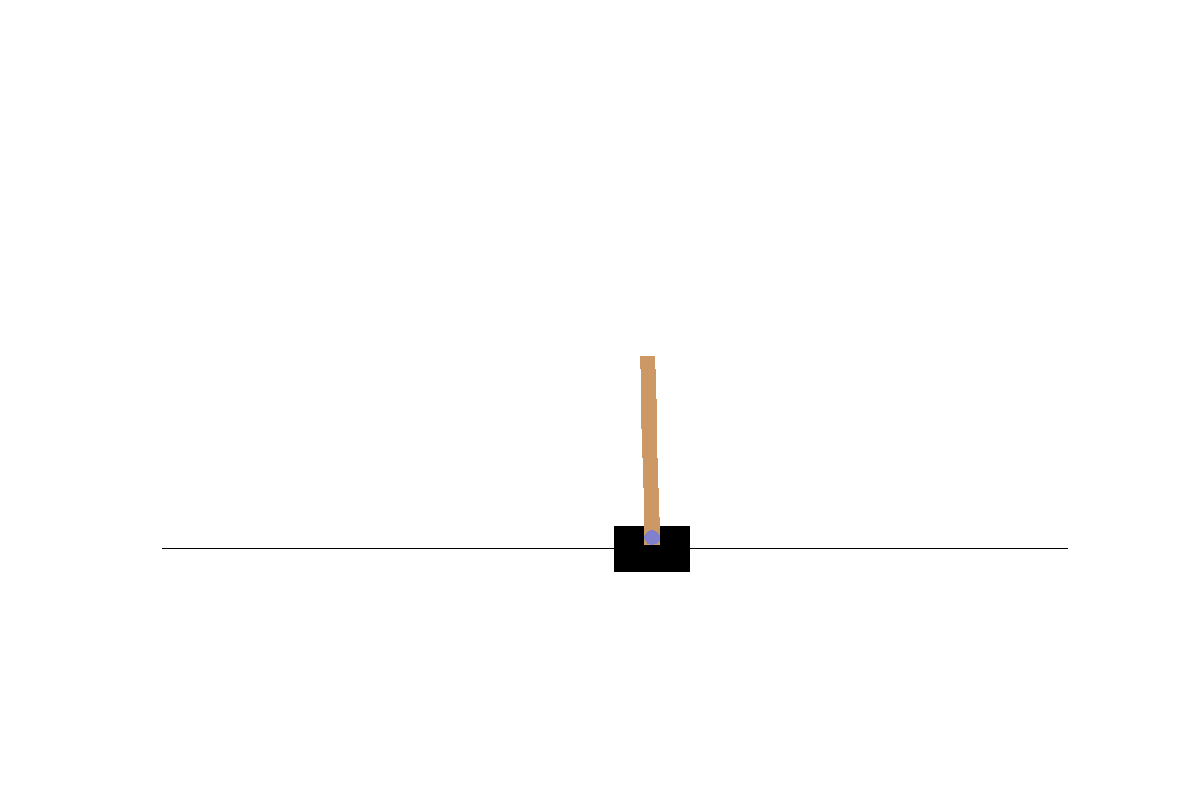

200.0

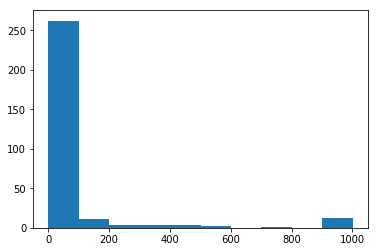

In [186]:
def hillClimb( starting_spread=1, noise_spread=0.2 ):
    weights = np.random.normal( 0, starting_spread, size=( 4 ) )
    start_weights = weights

    max_reward = 0
    runs = 0
    while max_reward != 200.0:
        runs += 1
        new_weights = np.random.normal( weights, noise_spread )
        reward = runSimulation( linearChoiceFactory( new_weights ) )
        if reward >= max_reward:
            weights = new_weights
            max_reward = reward
        if( runs > 1000 ):
            break
    return weights, runs

def hillClimbAverage( sample_count=100, starting_spread=1, noise_spread=0.2 ):
    run_sum = 0
    all_runs = []
    all_weights = []
    for i in range( sample_count ):
        weights, runs = hillClimb( starting_spread=starting_spread, noise_spread=noise_spread )
        run_sum += runs
        all_weights.append( weights )
        all_runs.append( runs )
    return np.array( all_runs ), all_weights

samples = 300
all_runs, all_weights = hillClimbAverage(samples, 5, 5)
plt.hist(all_runs)
print( 'Average: ', np.average( all_runs ) )
runSimulation( linearChoiceFactory( all_weights[ all_runs.argmin() ] ), render=True )